In [1]:
import numpy as np
import argparse
import pandas as pd
import pickle
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from dataset import BrainImages
from network import LeNet5
import torch.nn as nn
import torch.optim as optim
import torch
import torch.nn.init as I
import os
from torch.utils.data import Dataset
import nibabel
import numpy as np
import random
from PIL import Image
import torch
import torch.nn as nn
import statistics as stat
from skimage import io
from collections import OrderedDict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import torch.nn as nn
from collections import OrderedDict


class net3d(nn.Module):
    def __init__(self, paramstopredict):
        super(net3d, self).__init__()
        
        self.paramstopredict = paramstopredict
        self.convnet = nn.Sequential(OrderedDict([
            ('c1', nn.Conv3d(1, 8, (3, 3, 3))),
            ('relu1', nn.LeakyReLU(0.1)),
            ('max1', nn.MaxPool3d((2, 2, 2), stride=2)),
            
            ('c2', nn.Conv3d(8, 16, (3, 3, 3))),
            ('relu2', nn.LeakyReLU(0.1)),
            ('max2', nn.MaxPool3d((2, 2, 2), stride=2)),
            
            ('c3', nn.Conv3d(16, 32, (3, 3, 3))),
            ('relu3', nn.LeakyReLU(0.1)),
            ('max3', nn.MaxPool3d((2, 2, 2), stride=2)),
            
            ('c4', nn.Conv3d(32, 64, (3, 3, 3))),
            ('relu4', nn.LeakyReLU(0.1)),
            ('max4', nn.MaxPool3d((2, 2, 2), stride=2)),
            
            ('c5', nn.Conv3d(64, 128, (3, 3, 3))),
            ('relu5', nn.LeakyReLU(0.1)),
            ('max5', nn.MaxPool3d((2, 2, 2), stride=2))
        ]))

        self.fc = nn.Sequential(OrderedDict([
            ('f6', nn.Linear(4608, self.paramstopredict))
        ]))

    def forward(self, img):
        conv_out = self.convnet(img)
        shaped = conv_out.view(-1, 4608)
        output = self.fc(shaped)
        return output

In [3]:
class BrainImages(Dataset):
    def __init__(self, label_dict, subjects, slice_type='top_to_bottom', prep=False, augment=False, train_data=False, flipping=False, rotation=False, translation=False, gaussian=False):

        self.flipping = flipping
        self.rotation = rotation
        self.translation = translation
        self.train_data = train_data
        self.subjects = subjects
        self.label_dict = label_dict
        self.prep = prep
        self.augment = augment
        self.gaussian = gaussian
        self.slice_type = slice_type
        self.mean_img = io.imread('avg_image.png')[:, :, 0]
        
    def __len__(self):
        return len(self.subjects)

    def __getitem__(self, idx):
        subject = self.subjects[idx]
        image_path = "/gpfs/data/cbi/hcp/hcp_seg/aseg_all_slices/" + self.slice_type + "/"+subject+"/T1_images"
        target_label = self.label_dict[int(subject)]
        img_tensor = torch.empty((110,256,256))
        for i in range(100,210):
            img_orig = nibabel.freesurfer.mghformat.MGHImage.from_filename(image_path+"/image{}.mgz".format(i))
            image = img_orig.get_data().astype(np.float64)
            im = Image.fromarray(image[0])
            
            if self.augment:
                flip = random.random() > 0.5
                angle = random.uniform(-10, 10)
                dx = np.round(random.uniform(-25, 25))
                dy = np.round(random.uniform(-25, 25))

                if self.train_data:
                    if self.flipping and flip:
                        im = im.transpose(0)
                    if self.rotation:
                        im = im.rotate(angle)
                    if self.translation:
                        im = im.transform((256, 256), 0, (1, 0, dx, 0, 1, dy))
            if self.prep:    
                im = np.array(im, np.float64, copy=False)
                
                min_im = np.min(im)
                max_im = np.max(im)
                im = (im - min_im)/(max_im - min_im + 1e-4)
                

            if self.gaussian:
                gaussian_flag = random.random() > 0.5
                if self.train_data and gaussian_flag:
                    sigma_rand = random.uniform(0.65,1.0)
                    im_sigma = gaussian(im, sigma = sigma_rand)
                    gamma_rand = random.uniform(1.6,2.4)
                    im_sigma_gamma = exposure.adjust_gamma(im_sigma, gamma_rand)
                    im = (im_sigma_gamma - np.min(im_sigma_gamma))/(np.max(im_sigma_gamma)-np.min(im_sigma_gamma)+1e-4)
        
            im = torch.from_numpy(np.array(im, np.float64, copy=False).reshape((256, 256))).float()   
            img_tensor[i-100,:,:]= im    
        img_tensor = img_tensor.reshape((1,110,256,256)) 
        img_tensor = img_tensor
        target_label = np.array(list(target_label))
        target_label = torch.from_numpy(target_label).float()
        sample = {'x': img_tensor, 'y': target_label}
        return sample

In [4]:
def to_grayscale(image):
    """
    input is (d,w,h)
    converts 3D image tensor to grayscale images corresponding to each channel
    """
    image = torch.sum(image, dim=0)
    image = torch.sum(image, dim=0)
    #image = torch.div(image, image.shape[0])
    return image

In [5]:
def to_grayscale_filter(image):
    """
    input is (d,w,h)
    converts 3D image tensor to grayscale images corresponding to each channel
    """
    image = torch.sum(image, dim=1)
    #image = torch.div(image, image.shape[0])
    return image

In [6]:
def to_grayscale_niceplot(image):
    """
    input is (d,w,h)
    converts 3D image tensor to grayscale images corresponding to each channel
    """
    image = torch.sum(image, dim=0)
    #image = torch.div(image, image.shape[0])
    return image


In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        I.xavier_normal_(m.weight.data)
        print('here')
    if classname.find('Linear') != -1:
        I.normal_(m.weight.data)
        print('lhere')

def pickling(file,path):
    pickle.dump(file,open(path,'wb'))

def unpickling(path):
    file_return=pickle.load(open(path,'rb'))
    return file_return

In [8]:
model = torch.load('bmimodel')
model.eval()
from scipy.misc import imresize
torch.cuda.empty_cache()
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from nilearn import plotting
import nibabel as nib
import numpy as np
#import cv2

def create_heatmap(images, true_val, k=3, stride=8): 
    """
    Input images : (1, c,d, w, h) typically (1, 1,110, 256, 256)
    true_class is a number corresponding to imagenet classes
    k in the filter size (c, k, k, k)
    """
    with torch.no_grad():
        torch.cuda.empty_cache()
        print("image shape 1: {}".format(images.shape))
        images = images.reshape((1,1,110,256,256))
        heatmaps = torch.zeros(int((images.shape[2])), int(((images.shape[3]-k)/stride)+1), int(((images.shape[4]-k)/stride)+1))
        print(heatmaps.shape)
        images = images.data
        i = 0
        a = 0
        

        while i<images.shape[2]:
            j = 0 
            b = 0
            while j<=images.shape[3]-k:
                l = 0
                c = 0
                while l<=images.shape[4]-k:
                    print("i{} j{} l{}".format(i,j,l))
                    h_filter = torch.ones(images.shape)
                    h_filter[:,:,i,j:j+k,l:l+k] = 0
                    temp_images = images * h_filter
                    temp_pred = model(temp_images.to(device))
                    heatmaps[a][b][c] = (true_val.to('cpu') - temp_pred.to('cpu'))**2
                    l += stride
                    c += 1
                j += stride
                b += 1
            i += 1
            a += 1
        print('here')
        
        heatmaps = heatmaps.numpy()
            
        zeros = np.zeros((heatmaps.shape[0],256,256))
        for i in range(heatmaps.shape[0]):
            zeros[i] = imresize(heatmaps[i], (256, 256), interp='bilinear')
            zeros[i] = np.uint8(255 * zeros[i])
        zeros = torch.from_numpy(zeros)      
    return zeros

/gpfs/share/skynet/apps/anaconda3/envs/tensorflow_1_12_pytorch_1_0/lib/python3.6/site-packages/nilearn/plotting/__init__.py:20: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('Agg')
/gpfs/share/skynet/apps/anaconda3/envs/tensorflow_1_12_pytorch_1_0/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [9]:
model = torch.load('bmimodel')
model.eval()
from scipy.misc import imresize
torch.cuda.empty_cache()
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from nilearn import plotting
import nibabel as nib
import numpy as np

def draw_one(h, images): 
    with torch.no_grad():
        torch.cuda.empty_cache()
        print("image shape 1: {}".format(images.shape))
        images = images.reshape((1,1,110,256,256))
        images = images.data
        
        
        plt.figure(figsize=(14, 5))
        plt.subplot(1, 2, 1)
        plt.axis('off')
        
        images = images.squeeze()
        matr = to_grayscale_niceplot(images)
        print("image shape {}".format(matr.shape))
        mi = matr.max()
        mii = matr.min()
        print("max i {}".format(mi))
        print("min i {}".format(mii))
        
        plt.imshow(matr, interpolation=None,cmap=plt.cm.Greys_r,
                   vmax=matr.max(), vmin=matr.min())
        
        print('done here')
        matr2 = to_grayscale_niceplot(h)
        matr2 = matr2.numpy()
        
        #matr2 = np.uint8(matr2) #optional gives lines good!
        m = matr2.max()
        mi = matr2.min()
        matr2 = (matr2-mi)/(m - mi + 1e-4)
        matr2 = np.uint8(255 * matr2)
        m = matr2.max()
        mi = matr2.min()
        print("heatmap shape {}".format(matr2.shape))
        print("max h {}".format(m))
        print("min h {}".format(mi))
        #plt.subplot(1, 2, 2)
        #print(matr.shape)
        plt.imshow(np.ma.masked_where(matr2 < 2*m/3.0, matr2),interpolation=None,
                   vmax=matr2.max(), vmin=matr2.min(),alpha=.8)
        print('here')
        cbar = plt.colorbar()
        cbar.ax.tick_params(labelsize=8)
        
        plt.savefig('FinalOneBMI.jpg', bbox_inches='tight')
        plt.show()
    pass

In [14]:
model = torch.load('bmimodel')
model.eval()
from scipy.misc import imresize
torch.cuda.empty_cache()
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from nilearn import plotting
import nibabel as nib
import numpy as np
#import cv2

def draw_all(h, images): 
    with torch.no_grad():
        torch.cuda.empty_cache()
        print("image shape 1: {}".format(images.shape))
        images = images.reshape((1,1,110,256,256))
        images = images.data
        
        plt.figure(figsize=(14, 5))
        plt.subplot(1, 2, 1)
        plt.axis('off')
        
        images = images.squeeze().numpy()
        fig = plt.figure()
        h = h.numpy()
        print("image size in draw_All {}".format(images.shape))
        print("heatmap size in draw_All {}".format(h.shape))
        plt.rcParams["figure.figsize"] = (20, 20)
        for i in range(int(np.sqrt(h.shape[0])) * int(np.sqrt(h.shape[0]))):
            
            matr2 = h[i]
            m = matr2.max()
            mi = matr2.min()
            matr2 = (matr2-mi)/(m - mi + 1e-4)
            matr2 = np.uint8(255 * matr2)
            m = matr2.max()
            mi = matr2.min()
            fig.add_subplot(np.sqrt(h.shape[0]), np.sqrt(h.shape[0]),i+1)
            plt.imshow(images[i], interpolation=None,cmap=plt.cm.Greys_r,
                   vmax=images[i].max(), vmin=images[i].min())
            plt.imshow(np.ma.masked_where(matr2 < 2*m/3.0, matr2),interpolation=None,
                       vmax=matr2.max(), vmin=matr2.min(),alpha=.8)
            cbar = plt.colorbar()
            cbar.ax.tick_params(labelsize=20)
            plt.axis('off')
            
        plt.savefig('FinalAllBMI.jpg', bbox_inches='tight')
    pass

In [11]:
expname = 'Visbmi'
paramstopredict = 1
targetparams = ['BMI']
loss_criterion_list = [nn.MSELoss()]
log = False
lr = 0.0001
batchsize = 1
acc_check = 2
epochs = 50
target_norm = False
init = False
pwd = os.getcwd()
folder_path = pwd+'/'+expname
print(folder_path)
os.makedirs(folder_path, exist_ok=True)
means = []
stdev = []
file = open(folder_path+'/results_test.txt', 'w+')

with open("subjects") as f:
    content = f.readlines()
subject_inds = content[0].split(' ')
subject_inds[-1] = subject_inds[-1].split('\n')[0]

subject_train = subject_inds[0:668]
subject_val = subject_inds[668:891] #223
subject_test = subject_inds[891:] #222
labels = pd.read_csv('merged_target.csv', skipinitialspace=True)
s = [pd.Series(labels[targetparams[i]]) for i in range(len(targetparams))]

s = [s[i].fillna(0) for i in range(len(targetparams))]
if target_norm:
    means =  [stat.mean(s[i]) for i in range(len(targetparams))]
    stdev =  [stat.stdev(s[i]) for i in range(len(targetparams))]
    s = [(s[i]-means[i])/stdev[i] for i in range(len(targetparams))]

print(means)
print(stdev)
z = zip(*s)
label_dict = dict(zip(labels['Subject'], z))

transformed_dataset = {
    'train': BrainImages(label_dict, subject_train,slice_type='top_to_bottom', prep=True, augment=True, translation=True, train_data=True),
    'validate': BrainImages(label_dict, subject_val, prep=True),
    'test': BrainImages(label_dict, subject_test, prep=True)
    }


dataloader = {x: DataLoader(transformed_dataset[x], batch_size=batchsize,
                            shuffle=True, num_workers=0) for x in ['train', 'validate', 'test']}
"""transformed_dataset['train'].__getitem__(650)
print('tr'*50)
transformed_dataset['validate'].__getitem__(100)
print('v'*50)
transformed_dataset['test'].__getitem__(100)
print('-te'*50)
"""
data_sizes = {x: len(transformed_dataset[x]) for x in ['train', 'validate', 'test']}
torch.cuda.empty_cache()
data = transformed_dataset['validate'].__getitem__(50)
heatmaps = create_heatmap(data['x'], data['y'])

/gpfs/data/cbi/hcp/hcp_seg/mlhc/Visbmi
[]
[]
image shape 1: torch.Size([1, 110, 256, 256])
torch.Size([110, 32, 32])
i0 j0 l0
i0 j0 l8
i0 j0 l16
i0 j0 l24
i0 j0 l32
i0 j0 l40
i0 j0 l48
i0 j0 l56
i0 j0 l64
i0 j0 l72
i0 j0 l80
i0 j0 l88
i0 j0 l96
i0 j0 l104
i0 j0 l112
i0 j0 l120
i0 j0 l128
i0 j0 l136
i0 j0 l144
i0 j0 l152
i0 j0 l160
i0 j0 l168
i0 j0 l176
i0 j0 l184
i0 j0 l192
i0 j0 l200
i0 j0 l208
i0 j0 l216
i0 j0 l224
i0 j0 l232
i0 j0 l240
i0 j0 l248
i0 j8 l0
i0 j8 l8
i0 j8 l16
i0 j8 l24
i0 j8 l32
i0 j8 l40
i0 j8 l48
i0 j8 l56
i0 j8 l64
i0 j8 l72
i0 j8 l80
i0 j8 l88
i0 j8 l96
i0 j8 l104
i0 j8 l112
i0 j8 l120
i0 j8 l128
i0 j8 l136
i0 j8 l144
i0 j8 l152
i0 j8 l160
i0 j8 l168
i0 j8 l176
i0 j8 l184
i0 j8 l192
i0 j8 l200
i0 j8 l208
i0 j8 l216
i0 j8 l224
i0 j8 l232
i0 j8 l240
i0 j8 l248
i0 j16 l0
i0 j16 l8
i0 j16 l16
i0 j16 l24
i0 j16 l32
i0 j16 l40
i0 j16 l48
i0 j16 l56
i0 j16 l64
i0 j16 l72
i0 j16 l80
i0 j16 l88
i0 j16 l96
i0 j16 l104
i0 j16 l112
i0 j16 l120
i0 j16 l128
i0 j16 l136
i0 j16 l

i0 j168 l104
i0 j168 l112
i0 j168 l120
i0 j168 l128
i0 j168 l136
i0 j168 l144
i0 j168 l152
i0 j168 l160
i0 j168 l168
i0 j168 l176
i0 j168 l184
i0 j168 l192
i0 j168 l200
i0 j168 l208
i0 j168 l216
i0 j168 l224
i0 j168 l232
i0 j168 l240
i0 j168 l248
i0 j176 l0
i0 j176 l8
i0 j176 l16
i0 j176 l24
i0 j176 l32
i0 j176 l40
i0 j176 l48
i0 j176 l56
i0 j176 l64
i0 j176 l72
i0 j176 l80
i0 j176 l88
i0 j176 l96
i0 j176 l104
i0 j176 l112
i0 j176 l120
i0 j176 l128
i0 j176 l136
i0 j176 l144
i0 j176 l152
i0 j176 l160
i0 j176 l168
i0 j176 l176
i0 j176 l184
i0 j176 l192
i0 j176 l200
i0 j176 l208
i0 j176 l216
i0 j176 l224
i0 j176 l232
i0 j176 l240
i0 j176 l248
i0 j184 l0
i0 j184 l8
i0 j184 l16
i0 j184 l24
i0 j184 l32
i0 j184 l40
i0 j184 l48
i0 j184 l56
i0 j184 l64
i0 j184 l72
i0 j184 l80
i0 j184 l88
i0 j184 l96
i0 j184 l104
i0 j184 l112
i0 j184 l120
i0 j184 l128
i0 j184 l136
i0 j184 l144
i0 j184 l152
i0 j184 l160
i0 j184 l168
i0 j184 l176
i0 j184 l184
i0 j184 l192
i0 j184 l200
i0 j184 l208
i0 j184 l216
i0 

i1 j80 l240
i1 j80 l248
i1 j88 l0
i1 j88 l8
i1 j88 l16
i1 j88 l24
i1 j88 l32
i1 j88 l40
i1 j88 l48
i1 j88 l56
i1 j88 l64
i1 j88 l72
i1 j88 l80
i1 j88 l88
i1 j88 l96
i1 j88 l104
i1 j88 l112
i1 j88 l120
i1 j88 l128
i1 j88 l136
i1 j88 l144
i1 j88 l152
i1 j88 l160
i1 j88 l168
i1 j88 l176
i1 j88 l184
i1 j88 l192
i1 j88 l200
i1 j88 l208
i1 j88 l216
i1 j88 l224
i1 j88 l232
i1 j88 l240
i1 j88 l248
i1 j96 l0
i1 j96 l8
i1 j96 l16
i1 j96 l24
i1 j96 l32
i1 j96 l40
i1 j96 l48
i1 j96 l56
i1 j96 l64
i1 j96 l72
i1 j96 l80
i1 j96 l88
i1 j96 l96
i1 j96 l104
i1 j96 l112
i1 j96 l120
i1 j96 l128
i1 j96 l136
i1 j96 l144
i1 j96 l152
i1 j96 l160
i1 j96 l168
i1 j96 l176
i1 j96 l184
i1 j96 l192
i1 j96 l200
i1 j96 l208
i1 j96 l216
i1 j96 l224
i1 j96 l232
i1 j96 l240
i1 j96 l248
i1 j104 l0
i1 j104 l8
i1 j104 l16
i1 j104 l24
i1 j104 l32
i1 j104 l40
i1 j104 l48
i1 j104 l56
i1 j104 l64
i1 j104 l72
i1 j104 l80
i1 j104 l88
i1 j104 l96
i1 j104 l104
i1 j104 l112
i1 j104 l120
i1 j104 l128
i1 j104 l136
i1 j104 l144
i1 j10

i1 j248 l144
i1 j248 l152
i1 j248 l160
i1 j248 l168
i1 j248 l176
i1 j248 l184
i1 j248 l192
i1 j248 l200
i1 j248 l208
i1 j248 l216
i1 j248 l224
i1 j248 l232
i1 j248 l240
i1 j248 l248
i2 j0 l0
i2 j0 l8
i2 j0 l16
i2 j0 l24
i2 j0 l32
i2 j0 l40
i2 j0 l48
i2 j0 l56
i2 j0 l64
i2 j0 l72
i2 j0 l80
i2 j0 l88
i2 j0 l96
i2 j0 l104
i2 j0 l112
i2 j0 l120
i2 j0 l128
i2 j0 l136
i2 j0 l144
i2 j0 l152
i2 j0 l160
i2 j0 l168
i2 j0 l176
i2 j0 l184
i2 j0 l192
i2 j0 l200
i2 j0 l208
i2 j0 l216
i2 j0 l224
i2 j0 l232
i2 j0 l240
i2 j0 l248
i2 j8 l0
i2 j8 l8
i2 j8 l16
i2 j8 l24
i2 j8 l32
i2 j8 l40
i2 j8 l48
i2 j8 l56
i2 j8 l64
i2 j8 l72
i2 j8 l80
i2 j8 l88
i2 j8 l96
i2 j8 l104
i2 j8 l112
i2 j8 l120
i2 j8 l128
i2 j8 l136
i2 j8 l144
i2 j8 l152
i2 j8 l160
i2 j8 l168
i2 j8 l176
i2 j8 l184
i2 j8 l192
i2 j8 l200
i2 j8 l208
i2 j8 l216
i2 j8 l224
i2 j8 l232
i2 j8 l240
i2 j8 l248
i2 j16 l0
i2 j16 l8
i2 j16 l16
i2 j16 l24
i2 j16 l32
i2 j16 l40
i2 j16 l48
i2 j16 l56
i2 j16 l64
i2 j16 l72
i2 j16 l80
i2 j16 l88
i2 j16 l96
i2 

i2 j168 l56
i2 j168 l64
i2 j168 l72
i2 j168 l80
i2 j168 l88
i2 j168 l96
i2 j168 l104
i2 j168 l112
i2 j168 l120
i2 j168 l128
i2 j168 l136
i2 j168 l144
i2 j168 l152
i2 j168 l160
i2 j168 l168
i2 j168 l176
i2 j168 l184
i2 j168 l192
i2 j168 l200
i2 j168 l208
i2 j168 l216
i2 j168 l224
i2 j168 l232
i2 j168 l240
i2 j168 l248
i2 j176 l0
i2 j176 l8
i2 j176 l16
i2 j176 l24
i2 j176 l32
i2 j176 l40
i2 j176 l48
i2 j176 l56
i2 j176 l64
i2 j176 l72
i2 j176 l80
i2 j176 l88
i2 j176 l96
i2 j176 l104
i2 j176 l112
i2 j176 l120
i2 j176 l128
i2 j176 l136
i2 j176 l144
i2 j176 l152
i2 j176 l160
i2 j176 l168
i2 j176 l176
i2 j176 l184
i2 j176 l192
i2 j176 l200
i2 j176 l208
i2 j176 l216
i2 j176 l224
i2 j176 l232
i2 j176 l240
i2 j176 l248
i2 j184 l0
i2 j184 l8
i2 j184 l16
i2 j184 l24
i2 j184 l32
i2 j184 l40
i2 j184 l48
i2 j184 l56
i2 j184 l64
i2 j184 l72
i2 j184 l80
i2 j184 l88
i2 j184 l96
i2 j184 l104
i2 j184 l112
i2 j184 l120
i2 j184 l128
i2 j184 l136
i2 j184 l144
i2 j184 l152
i2 j184 l160
i2 j184 l168
i2 j184 l

i3 j80 l200
i3 j80 l208
i3 j80 l216
i3 j80 l224
i3 j80 l232
i3 j80 l240
i3 j80 l248
i3 j88 l0
i3 j88 l8
i3 j88 l16
i3 j88 l24
i3 j88 l32
i3 j88 l40
i3 j88 l48
i3 j88 l56
i3 j88 l64
i3 j88 l72
i3 j88 l80
i3 j88 l88
i3 j88 l96
i3 j88 l104
i3 j88 l112
i3 j88 l120
i3 j88 l128
i3 j88 l136
i3 j88 l144
i3 j88 l152
i3 j88 l160
i3 j88 l168
i3 j88 l176
i3 j88 l184
i3 j88 l192
i3 j88 l200
i3 j88 l208
i3 j88 l216
i3 j88 l224
i3 j88 l232
i3 j88 l240
i3 j88 l248
i3 j96 l0
i3 j96 l8
i3 j96 l16
i3 j96 l24
i3 j96 l32
i3 j96 l40
i3 j96 l48
i3 j96 l56
i3 j96 l64
i3 j96 l72
i3 j96 l80
i3 j96 l88
i3 j96 l96
i3 j96 l104
i3 j96 l112
i3 j96 l120
i3 j96 l128
i3 j96 l136
i3 j96 l144
i3 j96 l152
i3 j96 l160
i3 j96 l168
i3 j96 l176
i3 j96 l184
i3 j96 l192
i3 j96 l200
i3 j96 l208
i3 j96 l216
i3 j96 l224
i3 j96 l232
i3 j96 l240
i3 j96 l248
i3 j104 l0
i3 j104 l8
i3 j104 l16
i3 j104 l24
i3 j104 l32
i3 j104 l40
i3 j104 l48
i3 j104 l56
i3 j104 l64
i3 j104 l72
i3 j104 l80
i3 j104 l88
i3 j104 l96
i3 j104 l104
i3 j104 l11

i3 j248 l104
i3 j248 l112
i3 j248 l120
i3 j248 l128
i3 j248 l136
i3 j248 l144
i3 j248 l152
i3 j248 l160
i3 j248 l168
i3 j248 l176
i3 j248 l184
i3 j248 l192
i3 j248 l200
i3 j248 l208
i3 j248 l216
i3 j248 l224
i3 j248 l232
i3 j248 l240
i3 j248 l248
i4 j0 l0
i4 j0 l8
i4 j0 l16
i4 j0 l24
i4 j0 l32
i4 j0 l40
i4 j0 l48
i4 j0 l56
i4 j0 l64
i4 j0 l72
i4 j0 l80
i4 j0 l88
i4 j0 l96
i4 j0 l104
i4 j0 l112
i4 j0 l120
i4 j0 l128
i4 j0 l136
i4 j0 l144
i4 j0 l152
i4 j0 l160
i4 j0 l168
i4 j0 l176
i4 j0 l184
i4 j0 l192
i4 j0 l200
i4 j0 l208
i4 j0 l216
i4 j0 l224
i4 j0 l232
i4 j0 l240
i4 j0 l248
i4 j8 l0
i4 j8 l8
i4 j8 l16
i4 j8 l24
i4 j8 l32
i4 j8 l40
i4 j8 l48
i4 j8 l56
i4 j8 l64
i4 j8 l72
i4 j8 l80
i4 j8 l88
i4 j8 l96
i4 j8 l104
i4 j8 l112
i4 j8 l120
i4 j8 l128
i4 j8 l136
i4 j8 l144
i4 j8 l152
i4 j8 l160
i4 j8 l168
i4 j8 l176
i4 j8 l184
i4 j8 l192
i4 j8 l200
i4 j8 l208
i4 j8 l216
i4 j8 l224
i4 j8 l232
i4 j8 l240
i4 j8 l248
i4 j16 l0
i4 j16 l8
i4 j16 l16
i4 j16 l24
i4 j16 l32
i4 j16 l40
i4 j16 l48
i4 j

i4 j168 l40
i4 j168 l48
i4 j168 l56
i4 j168 l64
i4 j168 l72
i4 j168 l80
i4 j168 l88
i4 j168 l96
i4 j168 l104
i4 j168 l112
i4 j168 l120
i4 j168 l128
i4 j168 l136
i4 j168 l144
i4 j168 l152
i4 j168 l160
i4 j168 l168
i4 j168 l176
i4 j168 l184
i4 j168 l192
i4 j168 l200
i4 j168 l208
i4 j168 l216
i4 j168 l224
i4 j168 l232
i4 j168 l240
i4 j168 l248
i4 j176 l0
i4 j176 l8
i4 j176 l16
i4 j176 l24
i4 j176 l32
i4 j176 l40
i4 j176 l48
i4 j176 l56
i4 j176 l64
i4 j176 l72
i4 j176 l80
i4 j176 l88
i4 j176 l96
i4 j176 l104
i4 j176 l112
i4 j176 l120
i4 j176 l128
i4 j176 l136
i4 j176 l144
i4 j176 l152
i4 j176 l160
i4 j176 l168
i4 j176 l176
i4 j176 l184
i4 j176 l192
i4 j176 l200
i4 j176 l208
i4 j176 l216
i4 j176 l224
i4 j176 l232
i4 j176 l240
i4 j176 l248
i4 j184 l0
i4 j184 l8
i4 j184 l16
i4 j184 l24
i4 j184 l32
i4 j184 l40
i4 j184 l48
i4 j184 l56
i4 j184 l64
i4 j184 l72
i4 j184 l80
i4 j184 l88
i4 j184 l96
i4 j184 l104
i4 j184 l112
i4 j184 l120
i4 j184 l128
i4 j184 l136
i4 j184 l144
i4 j184 l152
i4 j184 l16

i5 j80 l192
i5 j80 l200
i5 j80 l208
i5 j80 l216
i5 j80 l224
i5 j80 l232
i5 j80 l240
i5 j80 l248
i5 j88 l0
i5 j88 l8
i5 j88 l16
i5 j88 l24
i5 j88 l32
i5 j88 l40
i5 j88 l48
i5 j88 l56
i5 j88 l64
i5 j88 l72
i5 j88 l80
i5 j88 l88
i5 j88 l96
i5 j88 l104
i5 j88 l112
i5 j88 l120
i5 j88 l128
i5 j88 l136
i5 j88 l144
i5 j88 l152
i5 j88 l160
i5 j88 l168
i5 j88 l176
i5 j88 l184
i5 j88 l192
i5 j88 l200
i5 j88 l208
i5 j88 l216
i5 j88 l224
i5 j88 l232
i5 j88 l240
i5 j88 l248
i5 j96 l0
i5 j96 l8
i5 j96 l16
i5 j96 l24
i5 j96 l32
i5 j96 l40
i5 j96 l48
i5 j96 l56
i5 j96 l64
i5 j96 l72
i5 j96 l80
i5 j96 l88
i5 j96 l96
i5 j96 l104
i5 j96 l112
i5 j96 l120
i5 j96 l128
i5 j96 l136
i5 j96 l144
i5 j96 l152
i5 j96 l160
i5 j96 l168
i5 j96 l176
i5 j96 l184
i5 j96 l192
i5 j96 l200
i5 j96 l208
i5 j96 l216
i5 j96 l224
i5 j96 l232
i5 j96 l240
i5 j96 l248
i5 j104 l0
i5 j104 l8
i5 j104 l16
i5 j104 l24
i5 j104 l32
i5 j104 l40
i5 j104 l48
i5 j104 l56
i5 j104 l64
i5 j104 l72
i5 j104 l80
i5 j104 l88
i5 j104 l96
i5 j104 l104

i5 j248 l96
i5 j248 l104
i5 j248 l112
i5 j248 l120
i5 j248 l128
i5 j248 l136
i5 j248 l144
i5 j248 l152
i5 j248 l160
i5 j248 l168
i5 j248 l176
i5 j248 l184
i5 j248 l192
i5 j248 l200
i5 j248 l208
i5 j248 l216
i5 j248 l224
i5 j248 l232
i5 j248 l240
i5 j248 l248
i6 j0 l0
i6 j0 l8
i6 j0 l16
i6 j0 l24
i6 j0 l32
i6 j0 l40
i6 j0 l48
i6 j0 l56
i6 j0 l64
i6 j0 l72
i6 j0 l80
i6 j0 l88
i6 j0 l96
i6 j0 l104
i6 j0 l112
i6 j0 l120
i6 j0 l128
i6 j0 l136
i6 j0 l144
i6 j0 l152
i6 j0 l160
i6 j0 l168
i6 j0 l176
i6 j0 l184
i6 j0 l192
i6 j0 l200
i6 j0 l208
i6 j0 l216
i6 j0 l224
i6 j0 l232
i6 j0 l240
i6 j0 l248
i6 j8 l0
i6 j8 l8
i6 j8 l16
i6 j8 l24
i6 j8 l32
i6 j8 l40
i6 j8 l48
i6 j8 l56
i6 j8 l64
i6 j8 l72
i6 j8 l80
i6 j8 l88
i6 j8 l96
i6 j8 l104
i6 j8 l112
i6 j8 l120
i6 j8 l128
i6 j8 l136
i6 j8 l144
i6 j8 l152
i6 j8 l160
i6 j8 l168
i6 j8 l176
i6 j8 l184
i6 j8 l192
i6 j8 l200
i6 j8 l208
i6 j8 l216
i6 j8 l224
i6 j8 l232
i6 j8 l240
i6 j8 l248
i6 j16 l0
i6 j16 l8
i6 j16 l16
i6 j16 l24
i6 j16 l32
i6 j16 l40
i6 

i6 j168 l32
i6 j168 l40
i6 j168 l48
i6 j168 l56
i6 j168 l64
i6 j168 l72
i6 j168 l80
i6 j168 l88
i6 j168 l96
i6 j168 l104
i6 j168 l112
i6 j168 l120
i6 j168 l128
i6 j168 l136
i6 j168 l144
i6 j168 l152
i6 j168 l160
i6 j168 l168
i6 j168 l176
i6 j168 l184
i6 j168 l192
i6 j168 l200
i6 j168 l208
i6 j168 l216
i6 j168 l224
i6 j168 l232
i6 j168 l240
i6 j168 l248
i6 j176 l0
i6 j176 l8
i6 j176 l16
i6 j176 l24
i6 j176 l32
i6 j176 l40
i6 j176 l48
i6 j176 l56
i6 j176 l64
i6 j176 l72
i6 j176 l80
i6 j176 l88
i6 j176 l96
i6 j176 l104
i6 j176 l112
i6 j176 l120
i6 j176 l128
i6 j176 l136
i6 j176 l144
i6 j176 l152
i6 j176 l160
i6 j176 l168
i6 j176 l176
i6 j176 l184
i6 j176 l192
i6 j176 l200
i6 j176 l208
i6 j176 l216
i6 j176 l224
i6 j176 l232
i6 j176 l240
i6 j176 l248
i6 j184 l0
i6 j184 l8
i6 j184 l16
i6 j184 l24
i6 j184 l32
i6 j184 l40
i6 j184 l48
i6 j184 l56
i6 j184 l64
i6 j184 l72
i6 j184 l80
i6 j184 l88
i6 j184 l96
i6 j184 l104
i6 j184 l112
i6 j184 l120
i6 j184 l128
i6 j184 l136
i6 j184 l144
i6 j184 l152

i7 j80 l176
i7 j80 l184
i7 j80 l192
i7 j80 l200
i7 j80 l208
i7 j80 l216
i7 j80 l224
i7 j80 l232
i7 j80 l240
i7 j80 l248
i7 j88 l0
i7 j88 l8
i7 j88 l16
i7 j88 l24
i7 j88 l32
i7 j88 l40
i7 j88 l48
i7 j88 l56
i7 j88 l64
i7 j88 l72
i7 j88 l80
i7 j88 l88
i7 j88 l96
i7 j88 l104
i7 j88 l112
i7 j88 l120
i7 j88 l128
i7 j88 l136
i7 j88 l144
i7 j88 l152
i7 j88 l160
i7 j88 l168
i7 j88 l176
i7 j88 l184
i7 j88 l192
i7 j88 l200
i7 j88 l208
i7 j88 l216
i7 j88 l224
i7 j88 l232
i7 j88 l240
i7 j88 l248
i7 j96 l0
i7 j96 l8
i7 j96 l16
i7 j96 l24
i7 j96 l32
i7 j96 l40
i7 j96 l48
i7 j96 l56
i7 j96 l64
i7 j96 l72
i7 j96 l80
i7 j96 l88
i7 j96 l96
i7 j96 l104
i7 j96 l112
i7 j96 l120
i7 j96 l128
i7 j96 l136
i7 j96 l144
i7 j96 l152
i7 j96 l160
i7 j96 l168
i7 j96 l176
i7 j96 l184
i7 j96 l192
i7 j96 l200
i7 j96 l208
i7 j96 l216
i7 j96 l224
i7 j96 l232
i7 j96 l240
i7 j96 l248
i7 j104 l0
i7 j104 l8
i7 j104 l16
i7 j104 l24
i7 j104 l32
i7 j104 l40
i7 j104 l48
i7 j104 l56
i7 j104 l64
i7 j104 l72
i7 j104 l80
i7 j104 l88


i7 j248 l80
i7 j248 l88
i7 j248 l96
i7 j248 l104
i7 j248 l112
i7 j248 l120
i7 j248 l128
i7 j248 l136
i7 j248 l144
i7 j248 l152
i7 j248 l160
i7 j248 l168
i7 j248 l176
i7 j248 l184
i7 j248 l192
i7 j248 l200
i7 j248 l208
i7 j248 l216
i7 j248 l224
i7 j248 l232
i7 j248 l240
i7 j248 l248
i8 j0 l0
i8 j0 l8
i8 j0 l16
i8 j0 l24
i8 j0 l32
i8 j0 l40
i8 j0 l48
i8 j0 l56
i8 j0 l64
i8 j0 l72
i8 j0 l80
i8 j0 l88
i8 j0 l96
i8 j0 l104
i8 j0 l112
i8 j0 l120
i8 j0 l128
i8 j0 l136
i8 j0 l144
i8 j0 l152
i8 j0 l160
i8 j0 l168
i8 j0 l176
i8 j0 l184
i8 j0 l192
i8 j0 l200
i8 j0 l208
i8 j0 l216
i8 j0 l224
i8 j0 l232
i8 j0 l240
i8 j0 l248
i8 j8 l0
i8 j8 l8
i8 j8 l16
i8 j8 l24
i8 j8 l32
i8 j8 l40
i8 j8 l48
i8 j8 l56
i8 j8 l64
i8 j8 l72
i8 j8 l80
i8 j8 l88
i8 j8 l96
i8 j8 l104
i8 j8 l112
i8 j8 l120
i8 j8 l128
i8 j8 l136
i8 j8 l144
i8 j8 l152
i8 j8 l160
i8 j8 l168
i8 j8 l176
i8 j8 l184
i8 j8 l192
i8 j8 l200
i8 j8 l208
i8 j8 l216
i8 j8 l224
i8 j8 l232
i8 j8 l240
i8 j8 l248
i8 j16 l0
i8 j16 l8
i8 j16 l16
i8 j16 l24
i

i11 j136 l64
i11 j136 l72
i11 j136 l80
i11 j136 l88
i11 j136 l96
i11 j136 l104
i11 j136 l112
i11 j136 l120
i11 j136 l128
i11 j136 l136
i11 j136 l144
i11 j136 l152
i11 j136 l160
i11 j136 l168
i11 j136 l176
i11 j136 l184
i11 j136 l192
i11 j136 l200
i11 j136 l208
i11 j136 l216
i11 j136 l224
i11 j136 l232
i11 j136 l240
i11 j136 l248
i11 j144 l0
i11 j144 l8
i11 j144 l16
i11 j144 l24
i11 j144 l32
i11 j144 l40
i11 j144 l48
i11 j144 l56
i11 j144 l64
i11 j144 l72
i11 j144 l80
i11 j144 l88
i11 j144 l96
i11 j144 l104
i11 j144 l112
i11 j144 l120
i11 j144 l128
i11 j144 l136
i11 j144 l144
i11 j144 l152
i11 j144 l160
i11 j144 l168
i11 j144 l176
i11 j144 l184
i11 j144 l192
i11 j144 l200
i11 j144 l208
i11 j144 l216
i11 j144 l224
i11 j144 l232
i11 j144 l240
i11 j144 l248
i11 j152 l0
i11 j152 l8
i11 j152 l16
i11 j152 l24
i11 j152 l32
i11 j152 l40
i11 j152 l48
i11 j152 l56
i11 j152 l64
i11 j152 l72
i11 j152 l80
i11 j152 l88
i11 j152 l96
i11 j152 l104
i11 j152 l112
i11 j152 l120
i11 j152 l128
i11 j152 l136

i12 j32 l176
i12 j32 l184
i12 j32 l192
i12 j32 l200
i12 j32 l208
i12 j32 l216
i12 j32 l224
i12 j32 l232
i12 j32 l240
i12 j32 l248
i12 j40 l0
i12 j40 l8
i12 j40 l16
i12 j40 l24
i12 j40 l32
i12 j40 l40
i12 j40 l48
i12 j40 l56
i12 j40 l64
i12 j40 l72
i12 j40 l80
i12 j40 l88
i12 j40 l96
i12 j40 l104
i12 j40 l112
i12 j40 l120
i12 j40 l128
i12 j40 l136
i12 j40 l144
i12 j40 l152
i12 j40 l160
i12 j40 l168
i12 j40 l176
i12 j40 l184
i12 j40 l192
i12 j40 l200
i12 j40 l208
i12 j40 l216
i12 j40 l224
i12 j40 l232
i12 j40 l240
i12 j40 l248
i12 j48 l0
i12 j48 l8
i12 j48 l16
i12 j48 l24
i12 j48 l32
i12 j48 l40
i12 j48 l48
i12 j48 l56
i12 j48 l64
i12 j48 l72
i12 j48 l80
i12 j48 l88
i12 j48 l96
i12 j48 l104
i12 j48 l112
i12 j48 l120
i12 j48 l128
i12 j48 l136
i12 j48 l144
i12 j48 l152
i12 j48 l160
i12 j48 l168
i12 j48 l176
i12 j48 l184
i12 j48 l192
i12 j48 l200
i12 j48 l208
i12 j48 l216
i12 j48 l224
i12 j48 l232
i12 j48 l240
i12 j48 l248
i12 j56 l0
i12 j56 l8
i12 j56 l16
i12 j56 l24
i12 j56 l32
i12 j56 l4

i12 j192 l96
i12 j192 l104
i12 j192 l112
i12 j192 l120
i12 j192 l128
i12 j192 l136
i12 j192 l144
i12 j192 l152
i12 j192 l160
i12 j192 l168
i12 j192 l176
i12 j192 l184
i12 j192 l192
i12 j192 l200
i12 j192 l208
i12 j192 l216
i12 j192 l224
i12 j192 l232
i12 j192 l240
i12 j192 l248
i12 j200 l0
i12 j200 l8
i12 j200 l16
i12 j200 l24
i12 j200 l32
i12 j200 l40
i12 j200 l48
i12 j200 l56
i12 j200 l64
i12 j200 l72
i12 j200 l80
i12 j200 l88
i12 j200 l96
i12 j200 l104
i12 j200 l112
i12 j200 l120
i12 j200 l128
i12 j200 l136
i12 j200 l144
i12 j200 l152
i12 j200 l160
i12 j200 l168
i12 j200 l176
i12 j200 l184
i12 j200 l192
i12 j200 l200
i12 j200 l208
i12 j200 l216
i12 j200 l224
i12 j200 l232
i12 j200 l240
i12 j200 l248
i12 j208 l0
i12 j208 l8
i12 j208 l16
i12 j208 l24
i12 j208 l32
i12 j208 l40
i12 j208 l48
i12 j208 l56
i12 j208 l64
i12 j208 l72
i12 j208 l80
i12 j208 l88
i12 j208 l96
i12 j208 l104
i12 j208 l112
i12 j208 l120
i12 j208 l128
i12 j208 l136
i12 j208 l144
i12 j208 l152
i12 j208 l160
i12 j208 

i13 j96 l128
i13 j96 l136
i13 j96 l144
i13 j96 l152
i13 j96 l160
i13 j96 l168
i13 j96 l176
i13 j96 l184
i13 j96 l192
i13 j96 l200
i13 j96 l208
i13 j96 l216
i13 j96 l224
i13 j96 l232
i13 j96 l240
i13 j96 l248
i13 j104 l0
i13 j104 l8
i13 j104 l16
i13 j104 l24
i13 j104 l32
i13 j104 l40
i13 j104 l48
i13 j104 l56
i13 j104 l64
i13 j104 l72
i13 j104 l80
i13 j104 l88
i13 j104 l96
i13 j104 l104
i13 j104 l112
i13 j104 l120
i13 j104 l128
i13 j104 l136
i13 j104 l144
i13 j104 l152
i13 j104 l160
i13 j104 l168
i13 j104 l176
i13 j104 l184
i13 j104 l192
i13 j104 l200
i13 j104 l208
i13 j104 l216
i13 j104 l224
i13 j104 l232
i13 j104 l240
i13 j104 l248
i13 j112 l0
i13 j112 l8
i13 j112 l16
i13 j112 l24
i13 j112 l32
i13 j112 l40
i13 j112 l48
i13 j112 l56
i13 j112 l64
i13 j112 l72
i13 j112 l80
i13 j112 l88
i13 j112 l96
i13 j112 l104
i13 j112 l112
i13 j112 l120
i13 j112 l128
i13 j112 l136
i13 j112 l144
i13 j112 l152
i13 j112 l160
i13 j112 l168
i13 j112 l176
i13 j112 l184
i13 j112 l192
i13 j112 l200
i13 j112 l

i13 j248 l160
i13 j248 l168
i13 j248 l176
i13 j248 l184
i13 j248 l192
i13 j248 l200
i13 j248 l208
i13 j248 l216
i13 j248 l224
i13 j248 l232
i13 j248 l240
i13 j248 l248
i14 j0 l0
i14 j0 l8
i14 j0 l16
i14 j0 l24
i14 j0 l32
i14 j0 l40
i14 j0 l48
i14 j0 l56
i14 j0 l64
i14 j0 l72
i14 j0 l80
i14 j0 l88
i14 j0 l96
i14 j0 l104
i14 j0 l112
i14 j0 l120
i14 j0 l128
i14 j0 l136
i14 j0 l144
i14 j0 l152
i14 j0 l160
i14 j0 l168
i14 j0 l176
i14 j0 l184
i14 j0 l192
i14 j0 l200
i14 j0 l208
i14 j0 l216
i14 j0 l224
i14 j0 l232
i14 j0 l240
i14 j0 l248
i14 j8 l0
i14 j8 l8
i14 j8 l16
i14 j8 l24
i14 j8 l32
i14 j8 l40
i14 j8 l48
i14 j8 l56
i14 j8 l64
i14 j8 l72
i14 j8 l80
i14 j8 l88
i14 j8 l96
i14 j8 l104
i14 j8 l112
i14 j8 l120
i14 j8 l128
i14 j8 l136
i14 j8 l144
i14 j8 l152
i14 j8 l160
i14 j8 l168
i14 j8 l176
i14 j8 l184
i14 j8 l192
i14 j8 l200
i14 j8 l208
i14 j8 l216
i14 j8 l224
i14 j8 l232
i14 j8 l240
i14 j8 l248
i14 j16 l0
i14 j16 l8
i14 j16 l16
i14 j16 l24
i14 j16 l32
i14 j16 l40
i14 j16 l48
i14 j16 l56


i14 j152 l176
i14 j152 l184
i14 j152 l192
i14 j152 l200
i14 j152 l208
i14 j152 l216
i14 j152 l224
i14 j152 l232
i14 j152 l240
i14 j152 l248
i14 j160 l0
i14 j160 l8
i14 j160 l16
i14 j160 l24
i14 j160 l32
i14 j160 l40
i14 j160 l48
i14 j160 l56
i14 j160 l64
i14 j160 l72
i14 j160 l80
i14 j160 l88
i14 j160 l96
i14 j160 l104
i14 j160 l112
i14 j160 l120
i14 j160 l128
i14 j160 l136
i14 j160 l144
i14 j160 l152
i14 j160 l160
i14 j160 l168
i14 j160 l176
i14 j160 l184
i14 j160 l192
i14 j160 l200
i14 j160 l208
i14 j160 l216
i14 j160 l224
i14 j160 l232
i14 j160 l240
i14 j160 l248
i14 j168 l0
i14 j168 l8
i14 j168 l16
i14 j168 l24
i14 j168 l32
i14 j168 l40
i14 j168 l48
i14 j168 l56
i14 j168 l64
i14 j168 l72
i14 j168 l80
i14 j168 l88
i14 j168 l96
i14 j168 l104
i14 j168 l112
i14 j168 l120
i14 j168 l128
i14 j168 l136
i14 j168 l144
i14 j168 l152
i14 j168 l160
i14 j168 l168
i14 j168 l176
i14 j168 l184
i14 j168 l192
i14 j168 l200
i14 j168 l208
i14 j168 l216
i14 j168 l224
i14 j168 l232
i14 j168 l240
i14 j168

i15 j56 l96
i15 j56 l104
i15 j56 l112
i15 j56 l120
i15 j56 l128
i15 j56 l136
i15 j56 l144
i15 j56 l152
i15 j56 l160
i15 j56 l168
i15 j56 l176
i15 j56 l184
i15 j56 l192
i15 j56 l200
i15 j56 l208
i15 j56 l216
i15 j56 l224
i15 j56 l232
i15 j56 l240
i15 j56 l248
i15 j64 l0
i15 j64 l8
i15 j64 l16
i15 j64 l24
i15 j64 l32
i15 j64 l40
i15 j64 l48
i15 j64 l56
i15 j64 l64
i15 j64 l72
i15 j64 l80
i15 j64 l88
i15 j64 l96
i15 j64 l104
i15 j64 l112
i15 j64 l120
i15 j64 l128
i15 j64 l136
i15 j64 l144
i15 j64 l152
i15 j64 l160
i15 j64 l168
i15 j64 l176
i15 j64 l184
i15 j64 l192
i15 j64 l200
i15 j64 l208
i15 j64 l216
i15 j64 l224
i15 j64 l232
i15 j64 l240
i15 j64 l248
i15 j72 l0
i15 j72 l8
i15 j72 l16
i15 j72 l24
i15 j72 l32
i15 j72 l40
i15 j72 l48
i15 j72 l56
i15 j72 l64
i15 j72 l72
i15 j72 l80
i15 j72 l88
i15 j72 l96
i15 j72 l104
i15 j72 l112
i15 j72 l120
i15 j72 l128
i15 j72 l136
i15 j72 l144
i15 j72 l152
i15 j72 l160
i15 j72 l168
i15 j72 l176
i15 j72 l184
i15 j72 l192
i15 j72 l200
i15 j72 l208
i15 

i15 j208 l200
i15 j208 l208
i15 j208 l216
i15 j208 l224
i15 j208 l232
i15 j208 l240
i15 j208 l248
i15 j216 l0
i15 j216 l8
i15 j216 l16
i15 j216 l24
i15 j216 l32
i15 j216 l40
i15 j216 l48
i15 j216 l56
i15 j216 l64
i15 j216 l72
i15 j216 l80
i15 j216 l88
i15 j216 l96
i15 j216 l104
i15 j216 l112
i15 j216 l120
i15 j216 l128
i15 j216 l136
i15 j216 l144
i15 j216 l152
i15 j216 l160
i15 j216 l168
i15 j216 l176
i15 j216 l184
i15 j216 l192
i15 j216 l200
i15 j216 l208
i15 j216 l216
i15 j216 l224
i15 j216 l232
i15 j216 l240
i15 j216 l248
i15 j224 l0
i15 j224 l8
i15 j224 l16
i15 j224 l24
i15 j224 l32
i15 j224 l40
i15 j224 l48
i15 j224 l56
i15 j224 l64
i15 j224 l72
i15 j224 l80
i15 j224 l88
i15 j224 l96
i15 j224 l104
i15 j224 l112
i15 j224 l120
i15 j224 l128
i15 j224 l136
i15 j224 l144
i15 j224 l152
i15 j224 l160
i15 j224 l168
i15 j224 l176
i15 j224 l184
i15 j224 l192
i15 j224 l200
i15 j224 l208
i15 j224 l216
i15 j224 l224
i15 j224 l232
i15 j224 l240
i15 j224 l248
i15 j232 l0
i15 j232 l8
i15 j232 l16

i16 j112 l216
i16 j112 l224
i16 j112 l232
i16 j112 l240
i16 j112 l248
i16 j120 l0
i16 j120 l8
i16 j120 l16
i16 j120 l24
i16 j120 l32
i16 j120 l40
i16 j120 l48
i16 j120 l56
i16 j120 l64
i16 j120 l72
i16 j120 l80
i16 j120 l88
i16 j120 l96
i16 j120 l104
i16 j120 l112
i16 j120 l120
i16 j120 l128
i16 j120 l136
i16 j120 l144
i16 j120 l152
i16 j120 l160
i16 j120 l168
i16 j120 l176
i16 j120 l184
i16 j120 l192
i16 j120 l200
i16 j120 l208
i16 j120 l216
i16 j120 l224
i16 j120 l232
i16 j120 l240
i16 j120 l248
i16 j128 l0
i16 j128 l8
i16 j128 l16
i16 j128 l24
i16 j128 l32
i16 j128 l40
i16 j128 l48
i16 j128 l56
i16 j128 l64
i16 j128 l72
i16 j128 l80
i16 j128 l88
i16 j128 l96
i16 j128 l104
i16 j128 l112
i16 j128 l120
i16 j128 l128
i16 j128 l136
i16 j128 l144
i16 j128 l152
i16 j128 l160
i16 j128 l168
i16 j128 l176
i16 j128 l184
i16 j128 l192
i16 j128 l200
i16 j128 l208
i16 j128 l216
i16 j128 l224
i16 j128 l232
i16 j128 l240
i16 j128 l248
i16 j136 l0
i16 j136 l8
i16 j136 l16
i16 j136 l24
i16 j136 l32
i

i17 j16 l40
i17 j16 l48
i17 j16 l56
i17 j16 l64
i17 j16 l72
i17 j16 l80
i17 j16 l88
i17 j16 l96
i17 j16 l104
i17 j16 l112
i17 j16 l120
i17 j16 l128
i17 j16 l136
i17 j16 l144
i17 j16 l152
i17 j16 l160
i17 j16 l168
i17 j16 l176
i17 j16 l184
i17 j16 l192
i17 j16 l200
i17 j16 l208
i17 j16 l216
i17 j16 l224
i17 j16 l232
i17 j16 l240
i17 j16 l248
i17 j24 l0
i17 j24 l8
i17 j24 l16
i17 j24 l24
i17 j24 l32
i17 j24 l40
i17 j24 l48
i17 j24 l56
i17 j24 l64
i17 j24 l72
i17 j24 l80
i17 j24 l88
i17 j24 l96
i17 j24 l104
i17 j24 l112
i17 j24 l120
i17 j24 l128
i17 j24 l136
i17 j24 l144
i17 j24 l152
i17 j24 l160
i17 j24 l168
i17 j24 l176
i17 j24 l184
i17 j24 l192
i17 j24 l200
i17 j24 l208
i17 j24 l216
i17 j24 l224
i17 j24 l232
i17 j24 l240
i17 j24 l248
i17 j32 l0
i17 j32 l8
i17 j32 l16
i17 j32 l24
i17 j32 l32
i17 j32 l40
i17 j32 l48
i17 j32 l56
i17 j32 l64
i17 j32 l72
i17 j32 l80
i17 j32 l88
i17 j32 l96
i17 j32 l104
i17 j32 l112
i17 j32 l120
i17 j32 l128
i17 j32 l136
i17 j32 l144
i17 j32 l152
i17 j32 l16

i17 j176 l8
i17 j176 l16
i17 j176 l24
i17 j176 l32
i17 j176 l40
i17 j176 l48
i17 j176 l56
i17 j176 l64
i17 j176 l72
i17 j176 l80
i17 j176 l88
i17 j176 l96
i17 j176 l104
i17 j176 l112
i17 j176 l120
i17 j176 l128
i17 j176 l136
i17 j176 l144
i17 j176 l152
i17 j176 l160
i17 j176 l168
i17 j176 l176
i17 j176 l184
i17 j176 l192
i17 j176 l200
i17 j176 l208
i17 j176 l216
i17 j176 l224
i17 j176 l232
i17 j176 l240
i17 j176 l248
i17 j184 l0
i17 j184 l8
i17 j184 l16
i17 j184 l24
i17 j184 l32
i17 j184 l40
i17 j184 l48
i17 j184 l56
i17 j184 l64
i17 j184 l72
i17 j184 l80
i17 j184 l88
i17 j184 l96
i17 j184 l104
i17 j184 l112
i17 j184 l120
i17 j184 l128
i17 j184 l136
i17 j184 l144
i17 j184 l152
i17 j184 l160
i17 j184 l168
i17 j184 l176
i17 j184 l184
i17 j184 l192
i17 j184 l200
i17 j184 l208
i17 j184 l216
i17 j184 l224
i17 j184 l232
i17 j184 l240
i17 j184 l248
i17 j192 l0
i17 j192 l8
i17 j192 l16
i17 j192 l24
i17 j192 l32
i17 j192 l40
i17 j192 l48
i17 j192 l56
i17 j192 l64
i17 j192 l72
i17 j192 l80
i17 j

i18 j72 l232
i18 j72 l240
i18 j72 l248
i18 j80 l0
i18 j80 l8
i18 j80 l16
i18 j80 l24
i18 j80 l32
i18 j80 l40
i18 j80 l48
i18 j80 l56
i18 j80 l64
i18 j80 l72
i18 j80 l80
i18 j80 l88
i18 j80 l96
i18 j80 l104
i18 j80 l112
i18 j80 l120
i18 j80 l128
i18 j80 l136
i18 j80 l144
i18 j80 l152
i18 j80 l160
i18 j80 l168
i18 j80 l176
i18 j80 l184
i18 j80 l192
i18 j80 l200
i18 j80 l208
i18 j80 l216
i18 j80 l224
i18 j80 l232
i18 j80 l240
i18 j80 l248
i18 j88 l0
i18 j88 l8
i18 j88 l16
i18 j88 l24
i18 j88 l32
i18 j88 l40
i18 j88 l48
i18 j88 l56
i18 j88 l64
i18 j88 l72
i18 j88 l80
i18 j88 l88
i18 j88 l96
i18 j88 l104
i18 j88 l112
i18 j88 l120
i18 j88 l128
i18 j88 l136
i18 j88 l144
i18 j88 l152
i18 j88 l160
i18 j88 l168
i18 j88 l176
i18 j88 l184
i18 j88 l192
i18 j88 l200
i18 j88 l208
i18 j88 l216
i18 j88 l224
i18 j88 l232
i18 j88 l240
i18 j88 l248
i18 j96 l0
i18 j96 l8
i18 j96 l16
i18 j96 l24
i18 j96 l32
i18 j96 l40
i18 j96 l48
i18 j96 l56
i18 j96 l64
i18 j96 l72
i18 j96 l80
i18 j96 l88
i18 j96 l96
i18 j

i18 j232 l56
i18 j232 l64
i18 j232 l72
i18 j232 l80
i18 j232 l88
i18 j232 l96
i18 j232 l104
i18 j232 l112
i18 j232 l120
i18 j232 l128
i18 j232 l136
i18 j232 l144
i18 j232 l152
i18 j232 l160
i18 j232 l168
i18 j232 l176
i18 j232 l184
i18 j232 l192
i18 j232 l200
i18 j232 l208
i18 j232 l216
i18 j232 l224
i18 j232 l232
i18 j232 l240
i18 j232 l248
i18 j240 l0
i18 j240 l8
i18 j240 l16
i18 j240 l24
i18 j240 l32
i18 j240 l40
i18 j240 l48
i18 j240 l56
i18 j240 l64
i18 j240 l72
i18 j240 l80
i18 j240 l88
i18 j240 l96
i18 j240 l104
i18 j240 l112
i18 j240 l120
i18 j240 l128
i18 j240 l136
i18 j240 l144
i18 j240 l152
i18 j240 l160
i18 j240 l168
i18 j240 l176
i18 j240 l184
i18 j240 l192
i18 j240 l200
i18 j240 l208
i18 j240 l216
i18 j240 l224
i18 j240 l232
i18 j240 l240
i18 j240 l248
i18 j248 l0
i18 j248 l8
i18 j248 l16
i18 j248 l24
i18 j248 l32
i18 j248 l40
i18 j248 l48
i18 j248 l56
i18 j248 l64
i18 j248 l72
i18 j248 l80
i18 j248 l88
i18 j248 l96
i18 j248 l104
i18 j248 l112
i18 j248 l120
i18 j248 l128


i19 j136 l88
i19 j136 l96
i19 j136 l104
i19 j136 l112
i19 j136 l120
i19 j136 l128
i19 j136 l136
i19 j136 l144
i19 j136 l152
i19 j136 l160
i19 j136 l168
i19 j136 l176
i19 j136 l184
i19 j136 l192
i19 j136 l200
i19 j136 l208
i19 j136 l216
i19 j136 l224
i19 j136 l232
i19 j136 l240
i19 j136 l248
i19 j144 l0
i19 j144 l8
i19 j144 l16
i19 j144 l24
i19 j144 l32
i19 j144 l40
i19 j144 l48
i19 j144 l56
i19 j144 l64
i19 j144 l72
i19 j144 l80
i19 j144 l88
i19 j144 l96
i19 j144 l104
i19 j144 l112
i19 j144 l120
i19 j144 l128
i19 j144 l136
i19 j144 l144
i19 j144 l152
i19 j144 l160
i19 j144 l168
i19 j144 l176
i19 j144 l184
i19 j144 l192
i19 j144 l200
i19 j144 l208
i19 j144 l216
i19 j144 l224
i19 j144 l232
i19 j144 l240
i19 j144 l248
i19 j152 l0
i19 j152 l8
i19 j152 l16
i19 j152 l24
i19 j152 l32
i19 j152 l40
i19 j152 l48
i19 j152 l56
i19 j152 l64
i19 j152 l72
i19 j152 l80
i19 j152 l88
i19 j152 l96
i19 j152 l104
i19 j152 l112
i19 j152 l120
i19 j152 l128
i19 j152 l136
i19 j152 l144
i19 j152 l152
i19 j152 l

i20 j32 l216
i20 j32 l224
i20 j32 l232
i20 j32 l240
i20 j32 l248
i20 j40 l0
i20 j40 l8
i20 j40 l16
i20 j40 l24
i20 j40 l32
i20 j40 l40
i20 j40 l48
i20 j40 l56
i20 j40 l64
i20 j40 l72
i20 j40 l80
i20 j40 l88
i20 j40 l96
i20 j40 l104
i20 j40 l112
i20 j40 l120
i20 j40 l128
i20 j40 l136
i20 j40 l144
i20 j40 l152
i20 j40 l160
i20 j40 l168
i20 j40 l176
i20 j40 l184
i20 j40 l192
i20 j40 l200
i20 j40 l208
i20 j40 l216
i20 j40 l224
i20 j40 l232
i20 j40 l240
i20 j40 l248
i20 j48 l0
i20 j48 l8
i20 j48 l16
i20 j48 l24
i20 j48 l32
i20 j48 l40
i20 j48 l48
i20 j48 l56
i20 j48 l64
i20 j48 l72
i20 j48 l80
i20 j48 l88
i20 j48 l96
i20 j48 l104
i20 j48 l112
i20 j48 l120
i20 j48 l128
i20 j48 l136
i20 j48 l144
i20 j48 l152
i20 j48 l160
i20 j48 l168
i20 j48 l176
i20 j48 l184
i20 j48 l192
i20 j48 l200
i20 j48 l208
i20 j48 l216
i20 j48 l224
i20 j48 l232
i20 j48 l240
i20 j48 l248
i20 j56 l0
i20 j56 l8
i20 j56 l16
i20 j56 l24
i20 j56 l32
i20 j56 l40
i20 j56 l48
i20 j56 l56
i20 j56 l64
i20 j56 l72
i20 j56 l80
i20

i20 j192 l136
i20 j192 l144
i20 j192 l152
i20 j192 l160
i20 j192 l168
i20 j192 l176
i20 j192 l184
i20 j192 l192
i20 j192 l200
i20 j192 l208
i20 j192 l216
i20 j192 l224
i20 j192 l232
i20 j192 l240
i20 j192 l248
i20 j200 l0
i20 j200 l8
i20 j200 l16
i20 j200 l24
i20 j200 l32
i20 j200 l40
i20 j200 l48
i20 j200 l56
i20 j200 l64
i20 j200 l72
i20 j200 l80
i20 j200 l88
i20 j200 l96
i20 j200 l104
i20 j200 l112
i20 j200 l120
i20 j200 l128
i20 j200 l136
i20 j200 l144
i20 j200 l152
i20 j200 l160
i20 j200 l168
i20 j200 l176
i20 j200 l184
i20 j200 l192
i20 j200 l200
i20 j200 l208
i20 j200 l216
i20 j200 l224
i20 j200 l232
i20 j200 l240
i20 j200 l248
i20 j208 l0
i20 j208 l8
i20 j208 l16
i20 j208 l24
i20 j208 l32
i20 j208 l40
i20 j208 l48
i20 j208 l56
i20 j208 l64
i20 j208 l72
i20 j208 l80
i20 j208 l88
i20 j208 l96
i20 j208 l104
i20 j208 l112
i20 j208 l120
i20 j208 l128
i20 j208 l136
i20 j208 l144
i20 j208 l152
i20 j208 l160
i20 j208 l168
i20 j208 l176
i20 j208 l184
i20 j208 l192
i20 j208 l200
i20 j208

i21 j96 l152
i21 j96 l160
i21 j96 l168
i21 j96 l176
i21 j96 l184
i21 j96 l192
i21 j96 l200
i21 j96 l208
i21 j96 l216
i21 j96 l224
i21 j96 l232
i21 j96 l240
i21 j96 l248
i21 j104 l0
i21 j104 l8
i21 j104 l16
i21 j104 l24
i21 j104 l32
i21 j104 l40
i21 j104 l48
i21 j104 l56
i21 j104 l64
i21 j104 l72
i21 j104 l80
i21 j104 l88
i21 j104 l96
i21 j104 l104
i21 j104 l112
i21 j104 l120
i21 j104 l128
i21 j104 l136
i21 j104 l144
i21 j104 l152
i21 j104 l160
i21 j104 l168
i21 j104 l176
i21 j104 l184
i21 j104 l192
i21 j104 l200
i21 j104 l208
i21 j104 l216
i21 j104 l224
i21 j104 l232
i21 j104 l240
i21 j104 l248
i21 j112 l0
i21 j112 l8
i21 j112 l16
i21 j112 l24
i21 j112 l32
i21 j112 l40
i21 j112 l48
i21 j112 l56
i21 j112 l64
i21 j112 l72
i21 j112 l80
i21 j112 l88
i21 j112 l96
i21 j112 l104
i21 j112 l112
i21 j112 l120
i21 j112 l128
i21 j112 l136
i21 j112 l144
i21 j112 l152
i21 j112 l160
i21 j112 l168
i21 j112 l176
i21 j112 l184
i21 j112 l192
i21 j112 l200
i21 j112 l208
i21 j112 l216
i21 j112 l224
i21 j11

i21 j248 l184
i21 j248 l192
i21 j248 l200
i21 j248 l208
i21 j248 l216
i21 j248 l224
i21 j248 l232
i21 j248 l240
i21 j248 l248
i22 j0 l0
i22 j0 l8
i22 j0 l16
i22 j0 l24
i22 j0 l32
i22 j0 l40
i22 j0 l48
i22 j0 l56
i22 j0 l64
i22 j0 l72
i22 j0 l80
i22 j0 l88
i22 j0 l96
i22 j0 l104
i22 j0 l112
i22 j0 l120
i22 j0 l128
i22 j0 l136
i22 j0 l144
i22 j0 l152
i22 j0 l160
i22 j0 l168
i22 j0 l176
i22 j0 l184
i22 j0 l192
i22 j0 l200
i22 j0 l208
i22 j0 l216
i22 j0 l224
i22 j0 l232
i22 j0 l240
i22 j0 l248
i22 j8 l0
i22 j8 l8
i22 j8 l16
i22 j8 l24
i22 j8 l32
i22 j8 l40
i22 j8 l48
i22 j8 l56
i22 j8 l64
i22 j8 l72
i22 j8 l80
i22 j8 l88
i22 j8 l96
i22 j8 l104
i22 j8 l112
i22 j8 l120
i22 j8 l128
i22 j8 l136
i22 j8 l144
i22 j8 l152
i22 j8 l160
i22 j8 l168
i22 j8 l176
i22 j8 l184
i22 j8 l192
i22 j8 l200
i22 j8 l208
i22 j8 l216
i22 j8 l224
i22 j8 l232
i22 j8 l240
i22 j8 l248
i22 j16 l0
i22 j16 l8
i22 j16 l16
i22 j16 l24
i22 j16 l32
i22 j16 l40
i22 j16 l48
i22 j16 l56
i22 j16 l64
i22 j16 l72
i22 j16 l80
i22 j1

i22 j152 l200
i22 j152 l208
i22 j152 l216
i22 j152 l224
i22 j152 l232
i22 j152 l240
i22 j152 l248
i22 j160 l0
i22 j160 l8
i22 j160 l16
i22 j160 l24
i22 j160 l32
i22 j160 l40
i22 j160 l48
i22 j160 l56
i22 j160 l64
i22 j160 l72
i22 j160 l80
i22 j160 l88
i22 j160 l96
i22 j160 l104
i22 j160 l112
i22 j160 l120
i22 j160 l128
i22 j160 l136
i22 j160 l144
i22 j160 l152
i22 j160 l160
i22 j160 l168
i22 j160 l176
i22 j160 l184
i22 j160 l192
i22 j160 l200
i22 j160 l208
i22 j160 l216
i22 j160 l224
i22 j160 l232
i22 j160 l240
i22 j160 l248
i22 j168 l0
i22 j168 l8
i22 j168 l16
i22 j168 l24
i22 j168 l32
i22 j168 l40
i22 j168 l48
i22 j168 l56
i22 j168 l64
i22 j168 l72
i22 j168 l80
i22 j168 l88
i22 j168 l96
i22 j168 l104
i22 j168 l112
i22 j168 l120
i22 j168 l128
i22 j168 l136
i22 j168 l144
i22 j168 l152
i22 j168 l160
i22 j168 l168
i22 j168 l176
i22 j168 l184
i22 j168 l192
i22 j168 l200
i22 j168 l208
i22 j168 l216
i22 j168 l224
i22 j168 l232
i22 j168 l240
i22 j168 l248
i22 j176 l0
i22 j176 l8
i22 j176 l16

i23 j56 l152
i23 j56 l160
i23 j56 l168
i23 j56 l176
i23 j56 l184
i23 j56 l192
i23 j56 l200
i23 j56 l208
i23 j56 l216
i23 j56 l224
i23 j56 l232
i23 j56 l240
i23 j56 l248
i23 j64 l0
i23 j64 l8
i23 j64 l16
i23 j64 l24
i23 j64 l32
i23 j64 l40
i23 j64 l48
i23 j64 l56
i23 j64 l64
i23 j64 l72
i23 j64 l80
i23 j64 l88
i23 j64 l96
i23 j64 l104
i23 j64 l112
i23 j64 l120
i23 j64 l128
i23 j64 l136
i23 j64 l144
i23 j64 l152
i23 j64 l160
i23 j64 l168
i23 j64 l176
i23 j64 l184
i23 j64 l192
i23 j64 l200
i23 j64 l208
i23 j64 l216
i23 j64 l224
i23 j64 l232
i23 j64 l240
i23 j64 l248
i23 j72 l0
i23 j72 l8
i23 j72 l16
i23 j72 l24
i23 j72 l32
i23 j72 l40
i23 j72 l48
i23 j72 l56
i23 j72 l64
i23 j72 l72
i23 j72 l80
i23 j72 l88
i23 j72 l96
i23 j72 l104
i23 j72 l112
i23 j72 l120
i23 j72 l128
i23 j72 l136
i23 j72 l144
i23 j72 l152
i23 j72 l160
i23 j72 l168
i23 j72 l176
i23 j72 l184
i23 j72 l192
i23 j72 l200
i23 j72 l208
i23 j72 l216
i23 j72 l224
i23 j72 l232
i23 j72 l240
i23 j72 l248
i23 j80 l0
i23 j80 l8
i23 j80

i23 j208 l232
i23 j208 l240
i23 j208 l248
i23 j216 l0
i23 j216 l8
i23 j216 l16
i23 j216 l24
i23 j216 l32
i23 j216 l40
i23 j216 l48
i23 j216 l56
i23 j216 l64
i23 j216 l72
i23 j216 l80
i23 j216 l88
i23 j216 l96
i23 j216 l104
i23 j216 l112
i23 j216 l120
i23 j216 l128
i23 j216 l136
i23 j216 l144
i23 j216 l152
i23 j216 l160
i23 j216 l168
i23 j216 l176
i23 j216 l184
i23 j216 l192
i23 j216 l200
i23 j216 l208
i23 j216 l216
i23 j216 l224
i23 j216 l232
i23 j216 l240
i23 j216 l248
i23 j224 l0
i23 j224 l8
i23 j224 l16
i23 j224 l24
i23 j224 l32
i23 j224 l40
i23 j224 l48
i23 j224 l56
i23 j224 l64
i23 j224 l72
i23 j224 l80
i23 j224 l88
i23 j224 l96
i23 j224 l104
i23 j224 l112
i23 j224 l120
i23 j224 l128
i23 j224 l136
i23 j224 l144
i23 j224 l152
i23 j224 l160
i23 j224 l168
i23 j224 l176
i23 j224 l184
i23 j224 l192
i23 j224 l200
i23 j224 l208
i23 j224 l216
i23 j224 l224
i23 j224 l232
i23 j224 l240
i23 j224 l248
i23 j232 l0
i23 j232 l8
i23 j232 l16
i23 j232 l24
i23 j232 l32
i23 j232 l40
i23 j232 l48
i23

i24 j112 l248
i24 j120 l0
i24 j120 l8
i24 j120 l16
i24 j120 l24
i24 j120 l32
i24 j120 l40
i24 j120 l48
i24 j120 l56
i24 j120 l64
i24 j120 l72
i24 j120 l80
i24 j120 l88
i24 j120 l96
i24 j120 l104
i24 j120 l112
i24 j120 l120
i24 j120 l128
i24 j120 l136
i24 j120 l144
i24 j120 l152
i24 j120 l160
i24 j120 l168
i24 j120 l176
i24 j120 l184
i24 j120 l192
i24 j120 l200
i24 j120 l208
i24 j120 l216
i24 j120 l224
i24 j120 l232
i24 j120 l240
i24 j120 l248
i24 j128 l0
i24 j128 l8
i24 j128 l16
i24 j128 l24
i24 j128 l32
i24 j128 l40
i24 j128 l48
i24 j128 l56
i24 j128 l64
i24 j128 l72
i24 j128 l80
i24 j128 l88
i24 j128 l96
i24 j128 l104
i24 j128 l112
i24 j128 l120
i24 j128 l128
i24 j128 l136
i24 j128 l144
i24 j128 l152
i24 j128 l160
i24 j128 l168
i24 j128 l176
i24 j128 l184
i24 j128 l192
i24 j128 l200
i24 j128 l208
i24 j128 l216
i24 j128 l224
i24 j128 l232
i24 j128 l240
i24 j128 l248
i24 j136 l0
i24 j136 l8
i24 j136 l16
i24 j136 l24
i24 j136 l32
i24 j136 l40
i24 j136 l48
i24 j136 l56
i24 j136 l64
i24 j

i25 j16 l72
i25 j16 l80
i25 j16 l88
i25 j16 l96
i25 j16 l104
i25 j16 l112
i25 j16 l120
i25 j16 l128
i25 j16 l136
i25 j16 l144
i25 j16 l152
i25 j16 l160
i25 j16 l168
i25 j16 l176
i25 j16 l184
i25 j16 l192
i25 j16 l200
i25 j16 l208
i25 j16 l216
i25 j16 l224
i25 j16 l232
i25 j16 l240
i25 j16 l248
i25 j24 l0
i25 j24 l8
i25 j24 l16
i25 j24 l24
i25 j24 l32
i25 j24 l40
i25 j24 l48
i25 j24 l56
i25 j24 l64
i25 j24 l72
i25 j24 l80
i25 j24 l88
i25 j24 l96
i25 j24 l104
i25 j24 l112
i25 j24 l120
i25 j24 l128
i25 j24 l136
i25 j24 l144
i25 j24 l152
i25 j24 l160
i25 j24 l168
i25 j24 l176
i25 j24 l184
i25 j24 l192
i25 j24 l200
i25 j24 l208
i25 j24 l216
i25 j24 l224
i25 j24 l232
i25 j24 l240
i25 j24 l248
i25 j32 l0
i25 j32 l8
i25 j32 l16
i25 j32 l24
i25 j32 l32
i25 j32 l40
i25 j32 l48
i25 j32 l56
i25 j32 l64
i25 j32 l72
i25 j32 l80
i25 j32 l88
i25 j32 l96
i25 j32 l104
i25 j32 l112
i25 j32 l120
i25 j32 l128
i25 j32 l136
i25 j32 l144
i25 j32 l152
i25 j32 l160
i25 j32 l168
i25 j32 l176
i25 j32 l184
i25 j32

i25 j176 l40
i25 j176 l48
i25 j176 l56
i25 j176 l64
i25 j176 l72
i25 j176 l80
i25 j176 l88
i25 j176 l96
i25 j176 l104
i25 j176 l112
i25 j176 l120
i25 j176 l128
i25 j176 l136
i25 j176 l144
i25 j176 l152
i25 j176 l160
i25 j176 l168
i25 j176 l176
i25 j176 l184
i25 j176 l192
i25 j176 l200
i25 j176 l208
i25 j176 l216
i25 j176 l224
i25 j176 l232
i25 j176 l240
i25 j176 l248
i25 j184 l0
i25 j184 l8
i25 j184 l16
i25 j184 l24
i25 j184 l32
i25 j184 l40
i25 j184 l48
i25 j184 l56
i25 j184 l64
i25 j184 l72
i25 j184 l80
i25 j184 l88
i25 j184 l96
i25 j184 l104
i25 j184 l112
i25 j184 l120
i25 j184 l128
i25 j184 l136
i25 j184 l144
i25 j184 l152
i25 j184 l160
i25 j184 l168
i25 j184 l176
i25 j184 l184
i25 j184 l192
i25 j184 l200
i25 j184 l208
i25 j184 l216
i25 j184 l224
i25 j184 l232
i25 j184 l240
i25 j184 l248
i25 j192 l0
i25 j192 l8
i25 j192 l16
i25 j192 l24
i25 j192 l32
i25 j192 l40
i25 j192 l48
i25 j192 l56
i25 j192 l64
i25 j192 l72
i25 j192 l80
i25 j192 l88
i25 j192 l96
i25 j192 l104
i25 j192 l112
i2

i26 j80 l24
i26 j80 l32
i26 j80 l40
i26 j80 l48
i26 j80 l56
i26 j80 l64
i26 j80 l72
i26 j80 l80
i26 j80 l88
i26 j80 l96
i26 j80 l104
i26 j80 l112
i26 j80 l120
i26 j80 l128
i26 j80 l136
i26 j80 l144
i26 j80 l152
i26 j80 l160
i26 j80 l168
i26 j80 l176
i26 j80 l184
i26 j80 l192
i26 j80 l200
i26 j80 l208
i26 j80 l216
i26 j80 l224
i26 j80 l232
i26 j80 l240
i26 j80 l248
i26 j88 l0
i26 j88 l8
i26 j88 l16
i26 j88 l24
i26 j88 l32
i26 j88 l40
i26 j88 l48
i26 j88 l56
i26 j88 l64
i26 j88 l72
i26 j88 l80
i26 j88 l88
i26 j88 l96
i26 j88 l104
i26 j88 l112
i26 j88 l120
i26 j88 l128
i26 j88 l136
i26 j88 l144
i26 j88 l152
i26 j88 l160
i26 j88 l168
i26 j88 l176
i26 j88 l184
i26 j88 l192
i26 j88 l200
i26 j88 l208
i26 j88 l216
i26 j88 l224
i26 j88 l232
i26 j88 l240
i26 j88 l248
i26 j96 l0
i26 j96 l8
i26 j96 l16
i26 j96 l24
i26 j96 l32
i26 j96 l40
i26 j96 l48
i26 j96 l56
i26 j96 l64
i26 j96 l72
i26 j96 l80
i26 j96 l88
i26 j96 l96
i26 j96 l104
i26 j96 l112
i26 j96 l120
i26 j96 l128
i26 j96 l136
i26 j96 l144


i26 j232 l104
i26 j232 l112
i26 j232 l120
i26 j232 l128
i26 j232 l136
i26 j232 l144
i26 j232 l152
i26 j232 l160
i26 j232 l168
i26 j232 l176
i26 j232 l184
i26 j232 l192
i26 j232 l200
i26 j232 l208
i26 j232 l216
i26 j232 l224
i26 j232 l232
i26 j232 l240
i26 j232 l248
i26 j240 l0
i26 j240 l8
i26 j240 l16
i26 j240 l24
i26 j240 l32
i26 j240 l40
i26 j240 l48
i26 j240 l56
i26 j240 l64
i26 j240 l72
i26 j240 l80
i26 j240 l88
i26 j240 l96
i26 j240 l104
i26 j240 l112
i26 j240 l120
i26 j240 l128
i26 j240 l136
i26 j240 l144
i26 j240 l152
i26 j240 l160
i26 j240 l168
i26 j240 l176
i26 j240 l184
i26 j240 l192
i26 j240 l200
i26 j240 l208
i26 j240 l216
i26 j240 l224
i26 j240 l232
i26 j240 l240
i26 j240 l248
i26 j248 l0
i26 j248 l8
i26 j248 l16
i26 j248 l24
i26 j248 l32
i26 j248 l40
i26 j248 l48
i26 j248 l56
i26 j248 l64
i26 j248 l72
i26 j248 l80
i26 j248 l88
i26 j248 l96
i26 j248 l104
i26 j248 l112
i26 j248 l120
i26 j248 l128
i26 j248 l136
i26 j248 l144
i26 j248 l152
i26 j248 l160
i26 j248 l168
i26 j248

i27 j136 l120
i27 j136 l128
i27 j136 l136
i27 j136 l144
i27 j136 l152
i27 j136 l160
i27 j136 l168
i27 j136 l176
i27 j136 l184
i27 j136 l192
i27 j136 l200
i27 j136 l208
i27 j136 l216
i27 j136 l224
i27 j136 l232
i27 j136 l240
i27 j136 l248
i27 j144 l0
i27 j144 l8
i27 j144 l16
i27 j144 l24
i27 j144 l32
i27 j144 l40
i27 j144 l48
i27 j144 l56
i27 j144 l64
i27 j144 l72
i27 j144 l80
i27 j144 l88
i27 j144 l96
i27 j144 l104
i27 j144 l112
i27 j144 l120
i27 j144 l128
i27 j144 l136
i27 j144 l144
i27 j144 l152
i27 j144 l160
i27 j144 l168
i27 j144 l176
i27 j144 l184
i27 j144 l192
i27 j144 l200
i27 j144 l208
i27 j144 l216
i27 j144 l224
i27 j144 l232
i27 j144 l240
i27 j144 l248
i27 j152 l0
i27 j152 l8
i27 j152 l16
i27 j152 l24
i27 j152 l32
i27 j152 l40
i27 j152 l48
i27 j152 l56
i27 j152 l64
i27 j152 l72
i27 j152 l80
i27 j152 l88
i27 j152 l96
i27 j152 l104
i27 j152 l112
i27 j152 l120
i27 j152 l128
i27 j152 l136
i27 j152 l144
i27 j152 l152
i27 j152 l160
i27 j152 l168
i27 j152 l176
i27 j152 l184
i27 j152

i28 j32 l248
i28 j40 l0
i28 j40 l8
i28 j40 l16
i28 j40 l24
i28 j40 l32
i28 j40 l40
i28 j40 l48
i28 j40 l56
i28 j40 l64
i28 j40 l72
i28 j40 l80
i28 j40 l88
i28 j40 l96
i28 j40 l104
i28 j40 l112
i28 j40 l120
i28 j40 l128
i28 j40 l136
i28 j40 l144
i28 j40 l152
i28 j40 l160
i28 j40 l168
i28 j40 l176
i28 j40 l184
i28 j40 l192
i28 j40 l200
i28 j40 l208
i28 j40 l216
i28 j40 l224
i28 j40 l232
i28 j40 l240
i28 j40 l248
i28 j48 l0
i28 j48 l8
i28 j48 l16
i28 j48 l24
i28 j48 l32
i28 j48 l40
i28 j48 l48
i28 j48 l56
i28 j48 l64
i28 j48 l72
i28 j48 l80
i28 j48 l88
i28 j48 l96
i28 j48 l104
i28 j48 l112
i28 j48 l120
i28 j48 l128
i28 j48 l136
i28 j48 l144
i28 j48 l152
i28 j48 l160
i28 j48 l168
i28 j48 l176
i28 j48 l184
i28 j48 l192
i28 j48 l200
i28 j48 l208
i28 j48 l216
i28 j48 l224
i28 j48 l232
i28 j48 l240
i28 j48 l248
i28 j56 l0
i28 j56 l8
i28 j56 l16
i28 j56 l24
i28 j56 l32
i28 j56 l40
i28 j56 l48
i28 j56 l56
i28 j56 l64
i28 j56 l72
i28 j56 l80
i28 j56 l88
i28 j56 l96
i28 j56 l104
i28 j56 l112
i28 j

i28 j192 l168
i28 j192 l176
i28 j192 l184
i28 j192 l192
i28 j192 l200
i28 j192 l208
i28 j192 l216
i28 j192 l224
i28 j192 l232
i28 j192 l240
i28 j192 l248
i28 j200 l0
i28 j200 l8
i28 j200 l16
i28 j200 l24
i28 j200 l32
i28 j200 l40
i28 j200 l48
i28 j200 l56
i28 j200 l64
i28 j200 l72
i28 j200 l80
i28 j200 l88
i28 j200 l96
i28 j200 l104
i28 j200 l112
i28 j200 l120
i28 j200 l128
i28 j200 l136
i28 j200 l144
i28 j200 l152
i28 j200 l160
i28 j200 l168
i28 j200 l176
i28 j200 l184
i28 j200 l192
i28 j200 l200
i28 j200 l208
i28 j200 l216
i28 j200 l224
i28 j200 l232
i28 j200 l240
i28 j200 l248
i28 j208 l0
i28 j208 l8
i28 j208 l16
i28 j208 l24
i28 j208 l32
i28 j208 l40
i28 j208 l48
i28 j208 l56
i28 j208 l64
i28 j208 l72
i28 j208 l80
i28 j208 l88
i28 j208 l96
i28 j208 l104
i28 j208 l112
i28 j208 l120
i28 j208 l128
i28 j208 l136
i28 j208 l144
i28 j208 l152
i28 j208 l160
i28 j208 l168
i28 j208 l176
i28 j208 l184
i28 j208 l192
i28 j208 l200
i28 j208 l208
i28 j208 l216
i28 j208 l224
i28 j208 l232
i28 j208

i29 j96 l184
i29 j96 l192
i29 j96 l200
i29 j96 l208
i29 j96 l216
i29 j96 l224
i29 j96 l232
i29 j96 l240
i29 j96 l248
i29 j104 l0
i29 j104 l8
i29 j104 l16
i29 j104 l24
i29 j104 l32
i29 j104 l40
i29 j104 l48
i29 j104 l56
i29 j104 l64
i29 j104 l72
i29 j104 l80
i29 j104 l88
i29 j104 l96
i29 j104 l104
i29 j104 l112
i29 j104 l120
i29 j104 l128
i29 j104 l136
i29 j104 l144
i29 j104 l152
i29 j104 l160
i29 j104 l168
i29 j104 l176
i29 j104 l184
i29 j104 l192
i29 j104 l200
i29 j104 l208
i29 j104 l216
i29 j104 l224
i29 j104 l232
i29 j104 l240
i29 j104 l248
i29 j112 l0
i29 j112 l8
i29 j112 l16
i29 j112 l24
i29 j112 l32
i29 j112 l40
i29 j112 l48
i29 j112 l56
i29 j112 l64
i29 j112 l72
i29 j112 l80
i29 j112 l88
i29 j112 l96
i29 j112 l104
i29 j112 l112
i29 j112 l120
i29 j112 l128
i29 j112 l136
i29 j112 l144
i29 j112 l152
i29 j112 l160
i29 j112 l168
i29 j112 l176
i29 j112 l184
i29 j112 l192
i29 j112 l200
i29 j112 l208
i29 j112 l216
i29 j112 l224
i29 j112 l232
i29 j112 l240
i29 j112 l248
i29 j120 l0
i29 j

i29 j248 l192
i29 j248 l200
i29 j248 l208
i29 j248 l216
i29 j248 l224
i29 j248 l232
i29 j248 l240
i29 j248 l248
i30 j0 l0
i30 j0 l8
i30 j0 l16
i30 j0 l24
i30 j0 l32
i30 j0 l40
i30 j0 l48
i30 j0 l56
i30 j0 l64
i30 j0 l72
i30 j0 l80
i30 j0 l88
i30 j0 l96
i30 j0 l104
i30 j0 l112
i30 j0 l120
i30 j0 l128
i30 j0 l136
i30 j0 l144
i30 j0 l152
i30 j0 l160
i30 j0 l168
i30 j0 l176
i30 j0 l184
i30 j0 l192
i30 j0 l200
i30 j0 l208
i30 j0 l216
i30 j0 l224
i30 j0 l232
i30 j0 l240
i30 j0 l248
i30 j8 l0
i30 j8 l8
i30 j8 l16
i30 j8 l24
i30 j8 l32
i30 j8 l40
i30 j8 l48
i30 j8 l56
i30 j8 l64
i30 j8 l72
i30 j8 l80
i30 j8 l88
i30 j8 l96
i30 j8 l104
i30 j8 l112
i30 j8 l120
i30 j8 l128
i30 j8 l136
i30 j8 l144
i30 j8 l152
i30 j8 l160
i30 j8 l168
i30 j8 l176
i30 j8 l184
i30 j8 l192
i30 j8 l200
i30 j8 l208
i30 j8 l216
i30 j8 l224
i30 j8 l232
i30 j8 l240
i30 j8 l248
i30 j16 l0
i30 j16 l8
i30 j16 l16
i30 j16 l24
i30 j16 l32
i30 j16 l40
i30 j16 l48
i30 j16 l56
i30 j16 l64
i30 j16 l72
i30 j16 l80
i30 j16 l88
i30 j16 

i30 j152 l200
i30 j152 l208
i30 j152 l216
i30 j152 l224
i30 j152 l232
i30 j152 l240
i30 j152 l248
i30 j160 l0
i30 j160 l8
i30 j160 l16
i30 j160 l24
i30 j160 l32
i30 j160 l40
i30 j160 l48
i30 j160 l56
i30 j160 l64
i30 j160 l72
i30 j160 l80
i30 j160 l88
i30 j160 l96
i30 j160 l104
i30 j160 l112
i30 j160 l120
i30 j160 l128
i30 j160 l136
i30 j160 l144
i30 j160 l152
i30 j160 l160
i30 j160 l168
i30 j160 l176
i30 j160 l184
i30 j160 l192
i30 j160 l200
i30 j160 l208
i30 j160 l216
i30 j160 l224
i30 j160 l232
i30 j160 l240
i30 j160 l248
i30 j168 l0
i30 j168 l8
i30 j168 l16
i30 j168 l24
i30 j168 l32
i30 j168 l40
i30 j168 l48
i30 j168 l56
i30 j168 l64
i30 j168 l72
i30 j168 l80
i30 j168 l88
i30 j168 l96
i30 j168 l104
i30 j168 l112
i30 j168 l120
i30 j168 l128
i30 j168 l136
i30 j168 l144
i30 j168 l152
i30 j168 l160
i30 j168 l168
i30 j168 l176
i30 j168 l184
i30 j168 l192
i30 j168 l200
i30 j168 l208
i30 j168 l216
i30 j168 l224
i30 j168 l232
i30 j168 l240
i30 j168 l248
i30 j176 l0
i30 j176 l8
i30 j176 l16

i31 j56 l120
i31 j56 l128
i31 j56 l136
i31 j56 l144
i31 j56 l152
i31 j56 l160
i31 j56 l168
i31 j56 l176
i31 j56 l184
i31 j56 l192
i31 j56 l200
i31 j56 l208
i31 j56 l216
i31 j56 l224
i31 j56 l232
i31 j56 l240
i31 j56 l248
i31 j64 l0
i31 j64 l8
i31 j64 l16
i31 j64 l24
i31 j64 l32
i31 j64 l40
i31 j64 l48
i31 j64 l56
i31 j64 l64
i31 j64 l72
i31 j64 l80
i31 j64 l88
i31 j64 l96
i31 j64 l104
i31 j64 l112
i31 j64 l120
i31 j64 l128
i31 j64 l136
i31 j64 l144
i31 j64 l152
i31 j64 l160
i31 j64 l168
i31 j64 l176
i31 j64 l184
i31 j64 l192
i31 j64 l200
i31 j64 l208
i31 j64 l216
i31 j64 l224
i31 j64 l232
i31 j64 l240
i31 j64 l248
i31 j72 l0
i31 j72 l8
i31 j72 l16
i31 j72 l24
i31 j72 l32
i31 j72 l40
i31 j72 l48
i31 j72 l56
i31 j72 l64
i31 j72 l72
i31 j72 l80
i31 j72 l88
i31 j72 l96
i31 j72 l104
i31 j72 l112
i31 j72 l120
i31 j72 l128
i31 j72 l136
i31 j72 l144
i31 j72 l152
i31 j72 l160
i31 j72 l168
i31 j72 l176
i31 j72 l184
i31 j72 l192
i31 j72 l200
i31 j72 l208
i31 j72 l216
i31 j72 l224
i31 j72 l232
i31

i31 j208 l248
i31 j216 l0
i31 j216 l8
i31 j216 l16
i31 j216 l24
i31 j216 l32
i31 j216 l40
i31 j216 l48
i31 j216 l56
i31 j216 l64
i31 j216 l72
i31 j216 l80
i31 j216 l88
i31 j216 l96
i31 j216 l104
i31 j216 l112
i31 j216 l120
i31 j216 l128
i31 j216 l136
i31 j216 l144
i31 j216 l152
i31 j216 l160
i31 j216 l168
i31 j216 l176
i31 j216 l184
i31 j216 l192
i31 j216 l200
i31 j216 l208
i31 j216 l216
i31 j216 l224
i31 j216 l232
i31 j216 l240
i31 j216 l248
i31 j224 l0
i31 j224 l8
i31 j224 l16
i31 j224 l24
i31 j224 l32
i31 j224 l40
i31 j224 l48
i31 j224 l56
i31 j224 l64
i31 j224 l72
i31 j224 l80
i31 j224 l88
i31 j224 l96
i31 j224 l104
i31 j224 l112
i31 j224 l120
i31 j224 l128
i31 j224 l136
i31 j224 l144
i31 j224 l152
i31 j224 l160
i31 j224 l168
i31 j224 l176
i31 j224 l184
i31 j224 l192
i31 j224 l200
i31 j224 l208
i31 j224 l216
i31 j224 l224
i31 j224 l232
i31 j224 l240
i31 j224 l248
i31 j232 l0
i31 j232 l8
i31 j232 l16
i31 j232 l24
i31 j232 l32
i31 j232 l40
i31 j232 l48
i31 j232 l56
i31 j232 l64
i31 j

i32 j120 l8
i32 j120 l16
i32 j120 l24
i32 j120 l32
i32 j120 l40
i32 j120 l48
i32 j120 l56
i32 j120 l64
i32 j120 l72
i32 j120 l80
i32 j120 l88
i32 j120 l96
i32 j120 l104
i32 j120 l112
i32 j120 l120
i32 j120 l128
i32 j120 l136
i32 j120 l144
i32 j120 l152
i32 j120 l160
i32 j120 l168
i32 j120 l176
i32 j120 l184
i32 j120 l192
i32 j120 l200
i32 j120 l208
i32 j120 l216
i32 j120 l224
i32 j120 l232
i32 j120 l240
i32 j120 l248
i32 j128 l0
i32 j128 l8
i32 j128 l16
i32 j128 l24
i32 j128 l32
i32 j128 l40
i32 j128 l48
i32 j128 l56
i32 j128 l64
i32 j128 l72
i32 j128 l80
i32 j128 l88
i32 j128 l96
i32 j128 l104
i32 j128 l112
i32 j128 l120
i32 j128 l128
i32 j128 l136
i32 j128 l144
i32 j128 l152
i32 j128 l160
i32 j128 l168
i32 j128 l176
i32 j128 l184
i32 j128 l192
i32 j128 l200
i32 j128 l208
i32 j128 l216
i32 j128 l224
i32 j128 l232
i32 j128 l240
i32 j128 l248
i32 j136 l0
i32 j136 l8
i32 j136 l16
i32 j136 l24
i32 j136 l32
i32 j136 l40
i32 j136 l48
i32 j136 l56
i32 j136 l64
i32 j136 l72
i32 j136 l80
i32 j

i33 j16 l88
i33 j16 l96
i33 j16 l104
i33 j16 l112
i33 j16 l120
i33 j16 l128
i33 j16 l136
i33 j16 l144
i33 j16 l152
i33 j16 l160
i33 j16 l168
i33 j16 l176
i33 j16 l184
i33 j16 l192
i33 j16 l200
i33 j16 l208
i33 j16 l216
i33 j16 l224
i33 j16 l232
i33 j16 l240
i33 j16 l248
i33 j24 l0
i33 j24 l8
i33 j24 l16
i33 j24 l24
i33 j24 l32
i33 j24 l40
i33 j24 l48
i33 j24 l56
i33 j24 l64
i33 j24 l72
i33 j24 l80
i33 j24 l88
i33 j24 l96
i33 j24 l104
i33 j24 l112
i33 j24 l120
i33 j24 l128
i33 j24 l136
i33 j24 l144
i33 j24 l152
i33 j24 l160
i33 j24 l168
i33 j24 l176
i33 j24 l184
i33 j24 l192
i33 j24 l200
i33 j24 l208
i33 j24 l216
i33 j24 l224
i33 j24 l232
i33 j24 l240
i33 j24 l248
i33 j32 l0
i33 j32 l8
i33 j32 l16
i33 j32 l24
i33 j32 l32
i33 j32 l40
i33 j32 l48
i33 j32 l56
i33 j32 l64
i33 j32 l72
i33 j32 l80
i33 j32 l88
i33 j32 l96
i33 j32 l104
i33 j32 l112
i33 j32 l120
i33 j32 l128
i33 j32 l136
i33 j32 l144
i33 j32 l152
i33 j32 l160
i33 j32 l168
i33 j32 l176
i33 j32 l184
i33 j32 l192
i33 j32 l200
i33 j

i33 j176 l48
i33 j176 l56
i33 j176 l64
i33 j176 l72
i33 j176 l80
i33 j176 l88
i33 j176 l96
i33 j176 l104
i33 j176 l112
i33 j176 l120
i33 j176 l128
i33 j176 l136
i33 j176 l144
i33 j176 l152
i33 j176 l160
i33 j176 l168
i33 j176 l176
i33 j176 l184
i33 j176 l192
i33 j176 l200
i33 j176 l208
i33 j176 l216
i33 j176 l224
i33 j176 l232
i33 j176 l240
i33 j176 l248
i33 j184 l0
i33 j184 l8
i33 j184 l16
i33 j184 l24
i33 j184 l32
i33 j184 l40
i33 j184 l48
i33 j184 l56
i33 j184 l64
i33 j184 l72
i33 j184 l80
i33 j184 l88
i33 j184 l96
i33 j184 l104
i33 j184 l112
i33 j184 l120
i33 j184 l128
i33 j184 l136
i33 j184 l144
i33 j184 l152
i33 j184 l160
i33 j184 l168
i33 j184 l176
i33 j184 l184
i33 j184 l192
i33 j184 l200
i33 j184 l208
i33 j184 l216
i33 j184 l224
i33 j184 l232
i33 j184 l240
i33 j184 l248
i33 j192 l0
i33 j192 l8
i33 j192 l16
i33 j192 l24
i33 j192 l32
i33 j192 l40
i33 j192 l48
i33 j192 l56
i33 j192 l64
i33 j192 l72
i33 j192 l80
i33 j192 l88
i33 j192 l96
i33 j192 l104
i33 j192 l112
i33 j192 l120
i

i34 j80 l16
i34 j80 l24
i34 j80 l32
i34 j80 l40
i34 j80 l48
i34 j80 l56
i34 j80 l64
i34 j80 l72
i34 j80 l80
i34 j80 l88
i34 j80 l96
i34 j80 l104
i34 j80 l112
i34 j80 l120
i34 j80 l128
i34 j80 l136
i34 j80 l144
i34 j80 l152
i34 j80 l160
i34 j80 l168
i34 j80 l176
i34 j80 l184
i34 j80 l192
i34 j80 l200
i34 j80 l208
i34 j80 l216
i34 j80 l224
i34 j80 l232
i34 j80 l240
i34 j80 l248
i34 j88 l0
i34 j88 l8
i34 j88 l16
i34 j88 l24
i34 j88 l32
i34 j88 l40
i34 j88 l48
i34 j88 l56
i34 j88 l64
i34 j88 l72
i34 j88 l80
i34 j88 l88
i34 j88 l96
i34 j88 l104
i34 j88 l112
i34 j88 l120
i34 j88 l128
i34 j88 l136
i34 j88 l144
i34 j88 l152
i34 j88 l160
i34 j88 l168
i34 j88 l176
i34 j88 l184
i34 j88 l192
i34 j88 l200
i34 j88 l208
i34 j88 l216
i34 j88 l224
i34 j88 l232
i34 j88 l240
i34 j88 l248
i34 j96 l0
i34 j96 l8
i34 j96 l16
i34 j96 l24
i34 j96 l32
i34 j96 l40
i34 j96 l48
i34 j96 l56
i34 j96 l64
i34 j96 l72
i34 j96 l80
i34 j96 l88
i34 j96 l96
i34 j96 l104
i34 j96 l112
i34 j96 l120
i34 j96 l128
i34 j96 l136
i

i34 j232 l96
i34 j232 l104
i34 j232 l112
i34 j232 l120
i34 j232 l128
i34 j232 l136
i34 j232 l144
i34 j232 l152
i34 j232 l160
i34 j232 l168
i34 j232 l176
i34 j232 l184
i34 j232 l192
i34 j232 l200
i34 j232 l208
i34 j232 l216
i34 j232 l224
i34 j232 l232
i34 j232 l240
i34 j232 l248
i34 j240 l0
i34 j240 l8
i34 j240 l16
i34 j240 l24
i34 j240 l32
i34 j240 l40
i34 j240 l48
i34 j240 l56
i34 j240 l64
i34 j240 l72
i34 j240 l80
i34 j240 l88
i34 j240 l96
i34 j240 l104
i34 j240 l112
i34 j240 l120
i34 j240 l128
i34 j240 l136
i34 j240 l144
i34 j240 l152
i34 j240 l160
i34 j240 l168
i34 j240 l176
i34 j240 l184
i34 j240 l192
i34 j240 l200
i34 j240 l208
i34 j240 l216
i34 j240 l224
i34 j240 l232
i34 j240 l240
i34 j240 l248
i34 j248 l0
i34 j248 l8
i34 j248 l16
i34 j248 l24
i34 j248 l32
i34 j248 l40
i34 j248 l48
i34 j248 l56
i34 j248 l64
i34 j248 l72
i34 j248 l80
i34 j248 l88
i34 j248 l96
i34 j248 l104
i34 j248 l112
i34 j248 l120
i34 j248 l128
i34 j248 l136
i34 j248 l144
i34 j248 l152
i34 j248 l160
i34 j248 

i35 j136 l112
i35 j136 l120
i35 j136 l128
i35 j136 l136
i35 j136 l144
i35 j136 l152
i35 j136 l160
i35 j136 l168
i35 j136 l176
i35 j136 l184
i35 j136 l192
i35 j136 l200
i35 j136 l208
i35 j136 l216
i35 j136 l224
i35 j136 l232
i35 j136 l240
i35 j136 l248
i35 j144 l0
i35 j144 l8
i35 j144 l16
i35 j144 l24
i35 j144 l32
i35 j144 l40
i35 j144 l48
i35 j144 l56
i35 j144 l64
i35 j144 l72
i35 j144 l80
i35 j144 l88
i35 j144 l96
i35 j144 l104
i35 j144 l112
i35 j144 l120
i35 j144 l128
i35 j144 l136
i35 j144 l144
i35 j144 l152
i35 j144 l160
i35 j144 l168
i35 j144 l176
i35 j144 l184
i35 j144 l192
i35 j144 l200
i35 j144 l208
i35 j144 l216
i35 j144 l224
i35 j144 l232
i35 j144 l240
i35 j144 l248
i35 j152 l0
i35 j152 l8
i35 j152 l16
i35 j152 l24
i35 j152 l32
i35 j152 l40
i35 j152 l48
i35 j152 l56
i35 j152 l64
i35 j152 l72
i35 j152 l80
i35 j152 l88
i35 j152 l96
i35 j152 l104
i35 j152 l112
i35 j152 l120
i35 j152 l128
i35 j152 l136
i35 j152 l144
i35 j152 l152
i35 j152 l160
i35 j152 l168
i35 j152 l176
i35 j152

i36 j32 l240
i36 j32 l248
i36 j40 l0
i36 j40 l8
i36 j40 l16
i36 j40 l24
i36 j40 l32
i36 j40 l40
i36 j40 l48
i36 j40 l56
i36 j40 l64
i36 j40 l72
i36 j40 l80
i36 j40 l88
i36 j40 l96
i36 j40 l104
i36 j40 l112
i36 j40 l120
i36 j40 l128
i36 j40 l136
i36 j40 l144
i36 j40 l152
i36 j40 l160
i36 j40 l168
i36 j40 l176
i36 j40 l184
i36 j40 l192
i36 j40 l200
i36 j40 l208
i36 j40 l216
i36 j40 l224
i36 j40 l232
i36 j40 l240
i36 j40 l248
i36 j48 l0
i36 j48 l8
i36 j48 l16
i36 j48 l24
i36 j48 l32
i36 j48 l40
i36 j48 l48
i36 j48 l56
i36 j48 l64
i36 j48 l72
i36 j48 l80
i36 j48 l88
i36 j48 l96
i36 j48 l104
i36 j48 l112
i36 j48 l120
i36 j48 l128
i36 j48 l136
i36 j48 l144
i36 j48 l152
i36 j48 l160
i36 j48 l168
i36 j48 l176
i36 j48 l184
i36 j48 l192
i36 j48 l200
i36 j48 l208
i36 j48 l216
i36 j48 l224
i36 j48 l232
i36 j48 l240
i36 j48 l248
i36 j56 l0
i36 j56 l8
i36 j56 l16
i36 j56 l24
i36 j56 l32
i36 j56 l40
i36 j56 l48
i36 j56 l56
i36 j56 l64
i36 j56 l72
i36 j56 l80
i36 j56 l88
i36 j56 l96
i36 j56 l104
i36 j

i36 j192 l128
i36 j192 l136
i36 j192 l144
i36 j192 l152
i36 j192 l160
i36 j192 l168
i36 j192 l176
i36 j192 l184
i36 j192 l192
i36 j192 l200
i36 j192 l208
i36 j192 l216
i36 j192 l224
i36 j192 l232
i36 j192 l240
i36 j192 l248
i36 j200 l0
i36 j200 l8
i36 j200 l16
i36 j200 l24
i36 j200 l32
i36 j200 l40
i36 j200 l48
i36 j200 l56
i36 j200 l64
i36 j200 l72
i36 j200 l80
i36 j200 l88
i36 j200 l96
i36 j200 l104
i36 j200 l112
i36 j200 l120
i36 j200 l128
i36 j200 l136
i36 j200 l144
i36 j200 l152
i36 j200 l160
i36 j200 l168
i36 j200 l176
i36 j200 l184
i36 j200 l192
i36 j200 l200
i36 j200 l208
i36 j200 l216
i36 j200 l224
i36 j200 l232
i36 j200 l240
i36 j200 l248
i36 j208 l0
i36 j208 l8
i36 j208 l16
i36 j208 l24
i36 j208 l32
i36 j208 l40
i36 j208 l48
i36 j208 l56
i36 j208 l64
i36 j208 l72
i36 j208 l80
i36 j208 l88
i36 j208 l96
i36 j208 l104
i36 j208 l112
i36 j208 l120
i36 j208 l128
i36 j208 l136
i36 j208 l144
i36 j208 l152
i36 j208 l160
i36 j208 l168
i36 j208 l176
i36 j208 l184
i36 j208 l192
i36 j208

i37 j96 l144
i37 j96 l152
i37 j96 l160
i37 j96 l168
i37 j96 l176
i37 j96 l184
i37 j96 l192
i37 j96 l200
i37 j96 l208
i37 j96 l216
i37 j96 l224
i37 j96 l232
i37 j96 l240
i37 j96 l248
i37 j104 l0
i37 j104 l8
i37 j104 l16
i37 j104 l24
i37 j104 l32
i37 j104 l40
i37 j104 l48
i37 j104 l56
i37 j104 l64
i37 j104 l72
i37 j104 l80
i37 j104 l88
i37 j104 l96
i37 j104 l104
i37 j104 l112
i37 j104 l120
i37 j104 l128
i37 j104 l136
i37 j104 l144
i37 j104 l152
i37 j104 l160
i37 j104 l168
i37 j104 l176
i37 j104 l184
i37 j104 l192
i37 j104 l200
i37 j104 l208
i37 j104 l216
i37 j104 l224
i37 j104 l232
i37 j104 l240
i37 j104 l248
i37 j112 l0
i37 j112 l8
i37 j112 l16
i37 j112 l24
i37 j112 l32
i37 j112 l40
i37 j112 l48
i37 j112 l56
i37 j112 l64
i37 j112 l72
i37 j112 l80
i37 j112 l88
i37 j112 l96
i37 j112 l104
i37 j112 l112
i37 j112 l120
i37 j112 l128
i37 j112 l136
i37 j112 l144
i37 j112 l152
i37 j112 l160
i37 j112 l168
i37 j112 l176
i37 j112 l184
i37 j112 l192
i37 j112 l200
i37 j112 l208
i37 j112 l216
i37 j112

i37 j248 l176
i37 j248 l184
i37 j248 l192
i37 j248 l200
i37 j248 l208
i37 j248 l216
i37 j248 l224
i37 j248 l232
i37 j248 l240
i37 j248 l248
i38 j0 l0
i38 j0 l8
i38 j0 l16
i38 j0 l24
i38 j0 l32
i38 j0 l40
i38 j0 l48
i38 j0 l56
i38 j0 l64
i38 j0 l72
i38 j0 l80
i38 j0 l88
i38 j0 l96
i38 j0 l104
i38 j0 l112
i38 j0 l120
i38 j0 l128
i38 j0 l136
i38 j0 l144
i38 j0 l152
i38 j0 l160
i38 j0 l168
i38 j0 l176
i38 j0 l184
i38 j0 l192
i38 j0 l200
i38 j0 l208
i38 j0 l216
i38 j0 l224
i38 j0 l232
i38 j0 l240
i38 j0 l248
i38 j8 l0
i38 j8 l8
i38 j8 l16
i38 j8 l24
i38 j8 l32
i38 j8 l40
i38 j8 l48
i38 j8 l56
i38 j8 l64
i38 j8 l72
i38 j8 l80
i38 j8 l88
i38 j8 l96
i38 j8 l104
i38 j8 l112
i38 j8 l120
i38 j8 l128
i38 j8 l136
i38 j8 l144
i38 j8 l152
i38 j8 l160
i38 j8 l168
i38 j8 l176
i38 j8 l184
i38 j8 l192
i38 j8 l200
i38 j8 l208
i38 j8 l216
i38 j8 l224
i38 j8 l232
i38 j8 l240
i38 j8 l248
i38 j16 l0
i38 j16 l8
i38 j16 l16
i38 j16 l24
i38 j16 l32
i38 j16 l40
i38 j16 l48
i38 j16 l56
i38 j16 l64
i38 j16 l72
i38 

i38 j152 l192
i38 j152 l200
i38 j152 l208
i38 j152 l216
i38 j152 l224
i38 j152 l232
i38 j152 l240
i38 j152 l248
i38 j160 l0
i38 j160 l8
i38 j160 l16
i38 j160 l24
i38 j160 l32
i38 j160 l40
i38 j160 l48
i38 j160 l56
i38 j160 l64
i38 j160 l72
i38 j160 l80
i38 j160 l88
i38 j160 l96
i38 j160 l104
i38 j160 l112
i38 j160 l120
i38 j160 l128
i38 j160 l136
i38 j160 l144
i38 j160 l152
i38 j160 l160
i38 j160 l168
i38 j160 l176
i38 j160 l184
i38 j160 l192
i38 j160 l200
i38 j160 l208
i38 j160 l216
i38 j160 l224
i38 j160 l232
i38 j160 l240
i38 j160 l248
i38 j168 l0
i38 j168 l8
i38 j168 l16
i38 j168 l24
i38 j168 l32
i38 j168 l40
i38 j168 l48
i38 j168 l56
i38 j168 l64
i38 j168 l72
i38 j168 l80
i38 j168 l88
i38 j168 l96
i38 j168 l104
i38 j168 l112
i38 j168 l120
i38 j168 l128
i38 j168 l136
i38 j168 l144
i38 j168 l152
i38 j168 l160
i38 j168 l168
i38 j168 l176
i38 j168 l184
i38 j168 l192
i38 j168 l200
i38 j168 l208
i38 j168 l216
i38 j168 l224
i38 j168 l232
i38 j168 l240
i38 j168 l248
i38 j176 l0
i38 j176 l

i39 j56 l112
i39 j56 l120
i39 j56 l128
i39 j56 l136
i39 j56 l144
i39 j56 l152
i39 j56 l160
i39 j56 l168
i39 j56 l176
i39 j56 l184
i39 j56 l192
i39 j56 l200
i39 j56 l208
i39 j56 l216
i39 j56 l224
i39 j56 l232
i39 j56 l240
i39 j56 l248
i39 j64 l0
i39 j64 l8
i39 j64 l16
i39 j64 l24
i39 j64 l32
i39 j64 l40
i39 j64 l48
i39 j64 l56
i39 j64 l64
i39 j64 l72
i39 j64 l80
i39 j64 l88
i39 j64 l96
i39 j64 l104
i39 j64 l112
i39 j64 l120
i39 j64 l128
i39 j64 l136
i39 j64 l144
i39 j64 l152
i39 j64 l160
i39 j64 l168
i39 j64 l176
i39 j64 l184
i39 j64 l192
i39 j64 l200
i39 j64 l208
i39 j64 l216
i39 j64 l224
i39 j64 l232
i39 j64 l240
i39 j64 l248
i39 j72 l0
i39 j72 l8
i39 j72 l16
i39 j72 l24
i39 j72 l32
i39 j72 l40
i39 j72 l48
i39 j72 l56
i39 j72 l64
i39 j72 l72
i39 j72 l80
i39 j72 l88
i39 j72 l96
i39 j72 l104
i39 j72 l112
i39 j72 l120
i39 j72 l128
i39 j72 l136
i39 j72 l144
i39 j72 l152
i39 j72 l160
i39 j72 l168
i39 j72 l176
i39 j72 l184
i39 j72 l192
i39 j72 l200
i39 j72 l208
i39 j72 l216
i39 j72 l224
i39

i39 j208 l240
i39 j208 l248
i39 j216 l0
i39 j216 l8
i39 j216 l16
i39 j216 l24
i39 j216 l32
i39 j216 l40
i39 j216 l48
i39 j216 l56
i39 j216 l64
i39 j216 l72
i39 j216 l80
i39 j216 l88
i39 j216 l96
i39 j216 l104
i39 j216 l112
i39 j216 l120
i39 j216 l128
i39 j216 l136
i39 j216 l144
i39 j216 l152
i39 j216 l160
i39 j216 l168
i39 j216 l176
i39 j216 l184
i39 j216 l192
i39 j216 l200
i39 j216 l208
i39 j216 l216
i39 j216 l224
i39 j216 l232
i39 j216 l240
i39 j216 l248
i39 j224 l0
i39 j224 l8
i39 j224 l16
i39 j224 l24
i39 j224 l32
i39 j224 l40
i39 j224 l48
i39 j224 l56
i39 j224 l64
i39 j224 l72
i39 j224 l80
i39 j224 l88
i39 j224 l96
i39 j224 l104
i39 j224 l112
i39 j224 l120
i39 j224 l128
i39 j224 l136
i39 j224 l144
i39 j224 l152
i39 j224 l160
i39 j224 l168
i39 j224 l176
i39 j224 l184
i39 j224 l192
i39 j224 l200
i39 j224 l208
i39 j224 l216
i39 j224 l224
i39 j224 l232
i39 j224 l240
i39 j224 l248
i39 j232 l0
i39 j232 l8
i39 j232 l16
i39 j232 l24
i39 j232 l32
i39 j232 l40
i39 j232 l48
i39 j232 l56
i39 

i40 j120 l24
i40 j120 l32
i40 j120 l40
i40 j120 l48
i40 j120 l56
i40 j120 l64
i40 j120 l72
i40 j120 l80
i40 j120 l88
i40 j120 l96
i40 j120 l104
i40 j120 l112
i40 j120 l120
i40 j120 l128
i40 j120 l136
i40 j120 l144
i40 j120 l152
i40 j120 l160
i40 j120 l168
i40 j120 l176
i40 j120 l184
i40 j120 l192
i40 j120 l200
i40 j120 l208
i40 j120 l216
i40 j120 l224
i40 j120 l232
i40 j120 l240
i40 j120 l248
i40 j128 l0
i40 j128 l8
i40 j128 l16
i40 j128 l24
i40 j128 l32
i40 j128 l40
i40 j128 l48
i40 j128 l56
i40 j128 l64
i40 j128 l72
i40 j128 l80
i40 j128 l88
i40 j128 l96
i40 j128 l104
i40 j128 l112
i40 j128 l120
i40 j128 l128
i40 j128 l136
i40 j128 l144
i40 j128 l152
i40 j128 l160
i40 j128 l168
i40 j128 l176
i40 j128 l184
i40 j128 l192
i40 j128 l200
i40 j128 l208
i40 j128 l216
i40 j128 l224
i40 j128 l232
i40 j128 l240
i40 j128 l248
i40 j136 l0
i40 j136 l8
i40 j136 l16
i40 j136 l24
i40 j136 l32
i40 j136 l40
i40 j136 l48
i40 j136 l56
i40 j136 l64
i40 j136 l72
i40 j136 l80
i40 j136 l88
i40 j136 l96
i40 

i41 j16 l104
i41 j16 l112
i41 j16 l120
i41 j16 l128
i41 j16 l136
i41 j16 l144
i41 j16 l152
i41 j16 l160
i41 j16 l168
i41 j16 l176
i41 j16 l184
i41 j16 l192
i41 j16 l200
i41 j16 l208
i41 j16 l216
i41 j16 l224
i41 j16 l232
i41 j16 l240
i41 j16 l248
i41 j24 l0
i41 j24 l8
i41 j24 l16
i41 j24 l24
i41 j24 l32
i41 j24 l40
i41 j24 l48
i41 j24 l56
i41 j24 l64
i41 j24 l72
i41 j24 l80
i41 j24 l88
i41 j24 l96
i41 j24 l104
i41 j24 l112
i41 j24 l120
i41 j24 l128
i41 j24 l136
i41 j24 l144
i41 j24 l152
i41 j24 l160
i41 j24 l168
i41 j24 l176
i41 j24 l184
i41 j24 l192
i41 j24 l200
i41 j24 l208
i41 j24 l216
i41 j24 l224
i41 j24 l232
i41 j24 l240
i41 j24 l248
i41 j32 l0
i41 j32 l8
i41 j32 l16
i41 j32 l24
i41 j32 l32
i41 j32 l40
i41 j32 l48
i41 j32 l56
i41 j32 l64
i41 j32 l72
i41 j32 l80
i41 j32 l88
i41 j32 l96
i41 j32 l104
i41 j32 l112
i41 j32 l120
i41 j32 l128
i41 j32 l136
i41 j32 l144
i41 j32 l152
i41 j32 l160
i41 j32 l168
i41 j32 l176
i41 j32 l184
i41 j32 l192
i41 j32 l200
i41 j32 l208
i41 j32 l216
i41

i41 j176 l64
i41 j176 l72
i41 j176 l80
i41 j176 l88
i41 j176 l96
i41 j176 l104
i41 j176 l112
i41 j176 l120
i41 j176 l128
i41 j176 l136
i41 j176 l144
i41 j176 l152
i41 j176 l160
i41 j176 l168
i41 j176 l176
i41 j176 l184
i41 j176 l192
i41 j176 l200
i41 j176 l208
i41 j176 l216
i41 j176 l224
i41 j176 l232
i41 j176 l240
i41 j176 l248
i41 j184 l0
i41 j184 l8
i41 j184 l16
i41 j184 l24
i41 j184 l32
i41 j184 l40
i41 j184 l48
i41 j184 l56
i41 j184 l64
i41 j184 l72
i41 j184 l80
i41 j184 l88
i41 j184 l96
i41 j184 l104
i41 j184 l112
i41 j184 l120
i41 j184 l128
i41 j184 l136
i41 j184 l144
i41 j184 l152
i41 j184 l160
i41 j184 l168
i41 j184 l176
i41 j184 l184
i41 j184 l192
i41 j184 l200
i41 j184 l208
i41 j184 l216
i41 j184 l224
i41 j184 l232
i41 j184 l240
i41 j184 l248
i41 j192 l0
i41 j192 l8
i41 j192 l16
i41 j192 l24
i41 j192 l32
i41 j192 l40
i41 j192 l48
i41 j192 l56
i41 j192 l64
i41 j192 l72
i41 j192 l80
i41 j192 l88
i41 j192 l96
i41 j192 l104
i41 j192 l112
i41 j192 l120
i41 j192 l128
i41 j192 l136

i42 j80 l32
i42 j80 l40
i42 j80 l48
i42 j80 l56
i42 j80 l64
i42 j80 l72
i42 j80 l80
i42 j80 l88
i42 j80 l96
i42 j80 l104
i42 j80 l112
i42 j80 l120
i42 j80 l128
i42 j80 l136
i42 j80 l144
i42 j80 l152
i42 j80 l160
i42 j80 l168
i42 j80 l176
i42 j80 l184
i42 j80 l192
i42 j80 l200
i42 j80 l208
i42 j80 l216
i42 j80 l224
i42 j80 l232
i42 j80 l240
i42 j80 l248
i42 j88 l0
i42 j88 l8
i42 j88 l16
i42 j88 l24
i42 j88 l32
i42 j88 l40
i42 j88 l48
i42 j88 l56
i42 j88 l64
i42 j88 l72
i42 j88 l80
i42 j88 l88
i42 j88 l96
i42 j88 l104
i42 j88 l112
i42 j88 l120
i42 j88 l128
i42 j88 l136
i42 j88 l144
i42 j88 l152
i42 j88 l160
i42 j88 l168
i42 j88 l176
i42 j88 l184
i42 j88 l192
i42 j88 l200
i42 j88 l208
i42 j88 l216
i42 j88 l224
i42 j88 l232
i42 j88 l240
i42 j88 l248
i42 j96 l0
i42 j96 l8
i42 j96 l16
i42 j96 l24
i42 j96 l32
i42 j96 l40
i42 j96 l48
i42 j96 l56
i42 j96 l64
i42 j96 l72
i42 j96 l80
i42 j96 l88
i42 j96 l96
i42 j96 l104
i42 j96 l112
i42 j96 l120
i42 j96 l128
i42 j96 l136
i42 j96 l144
i42 j96 l152

i42 j232 l112
i42 j232 l120
i42 j232 l128
i42 j232 l136
i42 j232 l144
i42 j232 l152
i42 j232 l160
i42 j232 l168
i42 j232 l176
i42 j232 l184
i42 j232 l192
i42 j232 l200
i42 j232 l208
i42 j232 l216
i42 j232 l224
i42 j232 l232
i42 j232 l240
i42 j232 l248
i42 j240 l0
i42 j240 l8
i42 j240 l16
i42 j240 l24
i42 j240 l32
i42 j240 l40
i42 j240 l48
i42 j240 l56
i42 j240 l64
i42 j240 l72
i42 j240 l80
i42 j240 l88
i42 j240 l96
i42 j240 l104
i42 j240 l112
i42 j240 l120
i42 j240 l128
i42 j240 l136
i42 j240 l144
i42 j240 l152
i42 j240 l160
i42 j240 l168
i42 j240 l176
i42 j240 l184
i42 j240 l192
i42 j240 l200
i42 j240 l208
i42 j240 l216
i42 j240 l224
i42 j240 l232
i42 j240 l240
i42 j240 l248
i42 j248 l0
i42 j248 l8
i42 j248 l16
i42 j248 l24
i42 j248 l32
i42 j248 l40
i42 j248 l48
i42 j248 l56
i42 j248 l64
i42 j248 l72
i42 j248 l80
i42 j248 l88
i42 j248 l96
i42 j248 l104
i42 j248 l112
i42 j248 l120
i42 j248 l128
i42 j248 l136
i42 j248 l144
i42 j248 l152
i42 j248 l160
i42 j248 l168
i42 j248 l176
i42 j248

i43 j136 l128
i43 j136 l136
i43 j136 l144
i43 j136 l152
i43 j136 l160
i43 j136 l168
i43 j136 l176
i43 j136 l184
i43 j136 l192
i43 j136 l200
i43 j136 l208
i43 j136 l216
i43 j136 l224
i43 j136 l232
i43 j136 l240
i43 j136 l248
i43 j144 l0
i43 j144 l8
i43 j144 l16
i43 j144 l24
i43 j144 l32
i43 j144 l40
i43 j144 l48
i43 j144 l56
i43 j144 l64
i43 j144 l72
i43 j144 l80
i43 j144 l88
i43 j144 l96
i43 j144 l104
i43 j144 l112
i43 j144 l120
i43 j144 l128
i43 j144 l136
i43 j144 l144
i43 j144 l152
i43 j144 l160
i43 j144 l168
i43 j144 l176
i43 j144 l184
i43 j144 l192
i43 j144 l200
i43 j144 l208
i43 j144 l216
i43 j144 l224
i43 j144 l232
i43 j144 l240
i43 j144 l248
i43 j152 l0
i43 j152 l8
i43 j152 l16
i43 j152 l24
i43 j152 l32
i43 j152 l40
i43 j152 l48
i43 j152 l56
i43 j152 l64
i43 j152 l72
i43 j152 l80
i43 j152 l88
i43 j152 l96
i43 j152 l104
i43 j152 l112
i43 j152 l120
i43 j152 l128
i43 j152 l136
i43 j152 l144
i43 j152 l152
i43 j152 l160
i43 j152 l168
i43 j152 l176
i43 j152 l184
i43 j152 l192
i43 j152

i44 j40 l16
i44 j40 l24
i44 j40 l32
i44 j40 l40
i44 j40 l48
i44 j40 l56
i44 j40 l64
i44 j40 l72
i44 j40 l80
i44 j40 l88
i44 j40 l96
i44 j40 l104
i44 j40 l112
i44 j40 l120
i44 j40 l128
i44 j40 l136
i44 j40 l144
i44 j40 l152
i44 j40 l160
i44 j40 l168
i44 j40 l176
i44 j40 l184
i44 j40 l192
i44 j40 l200
i44 j40 l208
i44 j40 l216
i44 j40 l224
i44 j40 l232
i44 j40 l240
i44 j40 l248
i44 j48 l0
i44 j48 l8
i44 j48 l16
i44 j48 l24
i44 j48 l32
i44 j48 l40
i44 j48 l48
i44 j48 l56
i44 j48 l64
i44 j48 l72
i44 j48 l80
i44 j48 l88
i44 j48 l96
i44 j48 l104
i44 j48 l112
i44 j48 l120
i44 j48 l128
i44 j48 l136
i44 j48 l144
i44 j48 l152
i44 j48 l160
i44 j48 l168
i44 j48 l176
i44 j48 l184
i44 j48 l192
i44 j48 l200
i44 j48 l208
i44 j48 l216
i44 j48 l224
i44 j48 l232
i44 j48 l240
i44 j48 l248
i44 j56 l0
i44 j56 l8
i44 j56 l16
i44 j56 l24
i44 j56 l32
i44 j56 l40
i44 j56 l48
i44 j56 l56
i44 j56 l64
i44 j56 l72
i44 j56 l80
i44 j56 l88
i44 j56 l96
i44 j56 l104
i44 j56 l112
i44 j56 l120
i44 j56 l128
i44 j56 l136
i

i44 j192 l192
i44 j192 l200
i44 j192 l208
i44 j192 l216
i44 j192 l224
i44 j192 l232
i44 j192 l240
i44 j192 l248
i44 j200 l0
i44 j200 l8
i44 j200 l16
i44 j200 l24
i44 j200 l32
i44 j200 l40
i44 j200 l48
i44 j200 l56
i44 j200 l64
i44 j200 l72
i44 j200 l80
i44 j200 l88
i44 j200 l96
i44 j200 l104
i44 j200 l112
i44 j200 l120
i44 j200 l128
i44 j200 l136
i44 j200 l144
i44 j200 l152
i44 j200 l160
i44 j200 l168
i44 j200 l176
i44 j200 l184
i44 j200 l192
i44 j200 l200
i44 j200 l208
i44 j200 l216
i44 j200 l224
i44 j200 l232
i44 j200 l240
i44 j200 l248
i44 j208 l0
i44 j208 l8
i44 j208 l16
i44 j208 l24
i44 j208 l32
i44 j208 l40
i44 j208 l48
i44 j208 l56
i44 j208 l64
i44 j208 l72
i44 j208 l80
i44 j208 l88
i44 j208 l96
i44 j208 l104
i44 j208 l112
i44 j208 l120
i44 j208 l128
i44 j208 l136
i44 j208 l144
i44 j208 l152
i44 j208 l160
i44 j208 l168
i44 j208 l176
i44 j208 l184
i44 j208 l192
i44 j208 l200
i44 j208 l208
i44 j208 l216
i44 j208 l224
i44 j208 l232
i44 j208 l240
i44 j208 l248
i44 j216 l0
i44 j216 l

i45 j96 l208
i45 j96 l216
i45 j96 l224
i45 j96 l232
i45 j96 l240
i45 j96 l248
i45 j104 l0
i45 j104 l8
i45 j104 l16
i45 j104 l24
i45 j104 l32
i45 j104 l40
i45 j104 l48
i45 j104 l56
i45 j104 l64
i45 j104 l72
i45 j104 l80
i45 j104 l88
i45 j104 l96
i45 j104 l104
i45 j104 l112
i45 j104 l120
i45 j104 l128
i45 j104 l136
i45 j104 l144
i45 j104 l152
i45 j104 l160
i45 j104 l168
i45 j104 l176
i45 j104 l184
i45 j104 l192
i45 j104 l200
i45 j104 l208
i45 j104 l216
i45 j104 l224
i45 j104 l232
i45 j104 l240
i45 j104 l248
i45 j112 l0
i45 j112 l8
i45 j112 l16
i45 j112 l24
i45 j112 l32
i45 j112 l40
i45 j112 l48
i45 j112 l56
i45 j112 l64
i45 j112 l72
i45 j112 l80
i45 j112 l88
i45 j112 l96
i45 j112 l104
i45 j112 l112
i45 j112 l120
i45 j112 l128
i45 j112 l136
i45 j112 l144
i45 j112 l152
i45 j112 l160
i45 j112 l168
i45 j112 l176
i45 j112 l184
i45 j112 l192
i45 j112 l200
i45 j112 l208
i45 j112 l216
i45 j112 l224
i45 j112 l232
i45 j112 l240
i45 j112 l248
i45 j120 l0
i45 j120 l8
i45 j120 l16
i45 j120 l24
i45 j1

i45 j248 l192
i45 j248 l200
i45 j248 l208
i45 j248 l216
i45 j248 l224
i45 j248 l232
i45 j248 l240
i45 j248 l248
i46 j0 l0
i46 j0 l8
i46 j0 l16
i46 j0 l24
i46 j0 l32
i46 j0 l40
i46 j0 l48
i46 j0 l56
i46 j0 l64
i46 j0 l72
i46 j0 l80
i46 j0 l88
i46 j0 l96
i46 j0 l104
i46 j0 l112
i46 j0 l120
i46 j0 l128
i46 j0 l136
i46 j0 l144
i46 j0 l152
i46 j0 l160
i46 j0 l168
i46 j0 l176
i46 j0 l184
i46 j0 l192
i46 j0 l200
i46 j0 l208
i46 j0 l216
i46 j0 l224
i46 j0 l232
i46 j0 l240
i46 j0 l248
i46 j8 l0
i46 j8 l8
i46 j8 l16
i46 j8 l24
i46 j8 l32
i46 j8 l40
i46 j8 l48
i46 j8 l56
i46 j8 l64
i46 j8 l72
i46 j8 l80
i46 j8 l88
i46 j8 l96
i46 j8 l104
i46 j8 l112
i46 j8 l120
i46 j8 l128
i46 j8 l136
i46 j8 l144
i46 j8 l152
i46 j8 l160
i46 j8 l168
i46 j8 l176
i46 j8 l184
i46 j8 l192
i46 j8 l200
i46 j8 l208
i46 j8 l216
i46 j8 l224
i46 j8 l232
i46 j8 l240
i46 j8 l248
i46 j16 l0
i46 j16 l8
i46 j16 l16
i46 j16 l24
i46 j16 l32
i46 j16 l40
i46 j16 l48
i46 j16 l56
i46 j16 l64
i46 j16 l72
i46 j16 l80
i46 j16 l88
i46 j16 

i46 j152 l208
i46 j152 l216
i46 j152 l224
i46 j152 l232
i46 j152 l240
i46 j152 l248
i46 j160 l0
i46 j160 l8
i46 j160 l16
i46 j160 l24
i46 j160 l32
i46 j160 l40
i46 j160 l48
i46 j160 l56
i46 j160 l64
i46 j160 l72
i46 j160 l80
i46 j160 l88
i46 j160 l96
i46 j160 l104
i46 j160 l112
i46 j160 l120
i46 j160 l128
i46 j160 l136
i46 j160 l144
i46 j160 l152
i46 j160 l160
i46 j160 l168
i46 j160 l176
i46 j160 l184
i46 j160 l192
i46 j160 l200
i46 j160 l208
i46 j160 l216
i46 j160 l224
i46 j160 l232
i46 j160 l240
i46 j160 l248
i46 j168 l0
i46 j168 l8
i46 j168 l16
i46 j168 l24
i46 j168 l32
i46 j168 l40
i46 j168 l48
i46 j168 l56
i46 j168 l64
i46 j168 l72
i46 j168 l80
i46 j168 l88
i46 j168 l96
i46 j168 l104
i46 j168 l112
i46 j168 l120
i46 j168 l128
i46 j168 l136
i46 j168 l144
i46 j168 l152
i46 j168 l160
i46 j168 l168
i46 j168 l176
i46 j168 l184
i46 j168 l192
i46 j168 l200
i46 j168 l208
i46 j168 l216
i46 j168 l224
i46 j168 l232
i46 j168 l240
i46 j168 l248
i46 j176 l0
i46 j176 l8
i46 j176 l16
i46 j176 l24


i47 j56 l144
i47 j56 l152
i47 j56 l160
i47 j56 l168
i47 j56 l176
i47 j56 l184
i47 j56 l192
i47 j56 l200
i47 j56 l208
i47 j56 l216
i47 j56 l224
i47 j56 l232
i47 j56 l240
i47 j56 l248
i47 j64 l0
i47 j64 l8
i47 j64 l16
i47 j64 l24
i47 j64 l32
i47 j64 l40
i47 j64 l48
i47 j64 l56
i47 j64 l64
i47 j64 l72
i47 j64 l80
i47 j64 l88
i47 j64 l96
i47 j64 l104
i47 j64 l112
i47 j64 l120
i47 j64 l128
i47 j64 l136
i47 j64 l144
i47 j64 l152
i47 j64 l160
i47 j64 l168
i47 j64 l176
i47 j64 l184
i47 j64 l192
i47 j64 l200
i47 j64 l208
i47 j64 l216
i47 j64 l224
i47 j64 l232
i47 j64 l240
i47 j64 l248
i47 j72 l0
i47 j72 l8
i47 j72 l16
i47 j72 l24
i47 j72 l32
i47 j72 l40
i47 j72 l48
i47 j72 l56
i47 j72 l64
i47 j72 l72
i47 j72 l80
i47 j72 l88
i47 j72 l96
i47 j72 l104
i47 j72 l112
i47 j72 l120
i47 j72 l128
i47 j72 l136
i47 j72 l144
i47 j72 l152
i47 j72 l160
i47 j72 l168
i47 j72 l176
i47 j72 l184
i47 j72 l192
i47 j72 l200
i47 j72 l208
i47 j72 l216
i47 j72 l224
i47 j72 l232
i47 j72 l240
i47 j72 l248
i47 j80 l0
i47 j

i47 j208 l248
i47 j216 l0
i47 j216 l8
i47 j216 l16
i47 j216 l24
i47 j216 l32
i47 j216 l40
i47 j216 l48
i47 j216 l56
i47 j216 l64
i47 j216 l72
i47 j216 l80
i47 j216 l88
i47 j216 l96
i47 j216 l104
i47 j216 l112
i47 j216 l120
i47 j216 l128
i47 j216 l136
i47 j216 l144
i47 j216 l152
i47 j216 l160
i47 j216 l168
i47 j216 l176
i47 j216 l184
i47 j216 l192
i47 j216 l200
i47 j216 l208
i47 j216 l216
i47 j216 l224
i47 j216 l232
i47 j216 l240
i47 j216 l248
i47 j224 l0
i47 j224 l8
i47 j224 l16
i47 j224 l24
i47 j224 l32
i47 j224 l40
i47 j224 l48
i47 j224 l56
i47 j224 l64
i47 j224 l72
i47 j224 l80
i47 j224 l88
i47 j224 l96
i47 j224 l104
i47 j224 l112
i47 j224 l120
i47 j224 l128
i47 j224 l136
i47 j224 l144
i47 j224 l152
i47 j224 l160
i47 j224 l168
i47 j224 l176
i47 j224 l184
i47 j224 l192
i47 j224 l200
i47 j224 l208
i47 j224 l216
i47 j224 l224
i47 j224 l232
i47 j224 l240
i47 j224 l248
i47 j232 l0
i47 j232 l8
i47 j232 l16
i47 j232 l24
i47 j232 l32
i47 j232 l40
i47 j232 l48
i47 j232 l56
i47 j232 l64
i47 j

i48 j120 l8
i48 j120 l16
i48 j120 l24
i48 j120 l32
i48 j120 l40
i48 j120 l48
i48 j120 l56
i48 j120 l64
i48 j120 l72
i48 j120 l80
i48 j120 l88
i48 j120 l96
i48 j120 l104
i48 j120 l112
i48 j120 l120
i48 j120 l128
i48 j120 l136
i48 j120 l144
i48 j120 l152
i48 j120 l160
i48 j120 l168
i48 j120 l176
i48 j120 l184
i48 j120 l192
i48 j120 l200
i48 j120 l208
i48 j120 l216
i48 j120 l224
i48 j120 l232
i48 j120 l240
i48 j120 l248
i48 j128 l0
i48 j128 l8
i48 j128 l16
i48 j128 l24
i48 j128 l32
i48 j128 l40
i48 j128 l48
i48 j128 l56
i48 j128 l64
i48 j128 l72
i48 j128 l80
i48 j128 l88
i48 j128 l96
i48 j128 l104
i48 j128 l112
i48 j128 l120
i48 j128 l128
i48 j128 l136
i48 j128 l144
i48 j128 l152
i48 j128 l160
i48 j128 l168
i48 j128 l176
i48 j128 l184
i48 j128 l192
i48 j128 l200
i48 j128 l208
i48 j128 l216
i48 j128 l224
i48 j128 l232
i48 j128 l240
i48 j128 l248
i48 j136 l0
i48 j136 l8
i48 j136 l16
i48 j136 l24
i48 j136 l32
i48 j136 l40
i48 j136 l48
i48 j136 l56
i48 j136 l64
i48 j136 l72
i48 j136 l80
i48 j

i49 j16 l88
i49 j16 l96
i49 j16 l104
i49 j16 l112
i49 j16 l120
i49 j16 l128
i49 j16 l136
i49 j16 l144
i49 j16 l152
i49 j16 l160
i49 j16 l168
i49 j16 l176
i49 j16 l184
i49 j16 l192
i49 j16 l200
i49 j16 l208
i49 j16 l216
i49 j16 l224
i49 j16 l232
i49 j16 l240
i49 j16 l248
i49 j24 l0
i49 j24 l8
i49 j24 l16
i49 j24 l24
i49 j24 l32
i49 j24 l40
i49 j24 l48
i49 j24 l56
i49 j24 l64
i49 j24 l72
i49 j24 l80
i49 j24 l88
i49 j24 l96
i49 j24 l104
i49 j24 l112
i49 j24 l120
i49 j24 l128
i49 j24 l136
i49 j24 l144
i49 j24 l152
i49 j24 l160
i49 j24 l168
i49 j24 l176
i49 j24 l184
i49 j24 l192
i49 j24 l200
i49 j24 l208
i49 j24 l216
i49 j24 l224
i49 j24 l232
i49 j24 l240
i49 j24 l248
i49 j32 l0
i49 j32 l8
i49 j32 l16
i49 j32 l24
i49 j32 l32
i49 j32 l40
i49 j32 l48
i49 j32 l56
i49 j32 l64
i49 j32 l72
i49 j32 l80
i49 j32 l88
i49 j32 l96
i49 j32 l104
i49 j32 l112
i49 j32 l120
i49 j32 l128
i49 j32 l136
i49 j32 l144
i49 j32 l152
i49 j32 l160
i49 j32 l168
i49 j32 l176
i49 j32 l184
i49 j32 l192
i49 j32 l200
i49 j

i49 j176 l56
i49 j176 l64
i49 j176 l72
i49 j176 l80
i49 j176 l88
i49 j176 l96
i49 j176 l104
i49 j176 l112
i49 j176 l120
i49 j176 l128
i49 j176 l136
i49 j176 l144
i49 j176 l152
i49 j176 l160
i49 j176 l168
i49 j176 l176
i49 j176 l184
i49 j176 l192
i49 j176 l200
i49 j176 l208
i49 j176 l216
i49 j176 l224
i49 j176 l232
i49 j176 l240
i49 j176 l248
i49 j184 l0
i49 j184 l8
i49 j184 l16
i49 j184 l24
i49 j184 l32
i49 j184 l40
i49 j184 l48
i49 j184 l56
i49 j184 l64
i49 j184 l72
i49 j184 l80
i49 j184 l88
i49 j184 l96
i49 j184 l104
i49 j184 l112
i49 j184 l120
i49 j184 l128
i49 j184 l136
i49 j184 l144
i49 j184 l152
i49 j184 l160
i49 j184 l168
i49 j184 l176
i49 j184 l184
i49 j184 l192
i49 j184 l200
i49 j184 l208
i49 j184 l216
i49 j184 l224
i49 j184 l232
i49 j184 l240
i49 j184 l248
i49 j192 l0
i49 j192 l8
i49 j192 l16
i49 j192 l24
i49 j192 l32
i49 j192 l40
i49 j192 l48
i49 j192 l56
i49 j192 l64
i49 j192 l72
i49 j192 l80
i49 j192 l88
i49 j192 l96
i49 j192 l104
i49 j192 l112
i49 j192 l120
i49 j192 l128


i50 j80 l24
i50 j80 l32
i50 j80 l40
i50 j80 l48
i50 j80 l56
i50 j80 l64
i50 j80 l72
i50 j80 l80
i50 j80 l88
i50 j80 l96
i50 j80 l104
i50 j80 l112
i50 j80 l120
i50 j80 l128
i50 j80 l136
i50 j80 l144
i50 j80 l152
i50 j80 l160
i50 j80 l168
i50 j80 l176
i50 j80 l184
i50 j80 l192
i50 j80 l200
i50 j80 l208
i50 j80 l216
i50 j80 l224
i50 j80 l232
i50 j80 l240
i50 j80 l248
i50 j88 l0
i50 j88 l8
i50 j88 l16
i50 j88 l24
i50 j88 l32
i50 j88 l40
i50 j88 l48
i50 j88 l56
i50 j88 l64
i50 j88 l72
i50 j88 l80
i50 j88 l88
i50 j88 l96
i50 j88 l104
i50 j88 l112
i50 j88 l120
i50 j88 l128
i50 j88 l136
i50 j88 l144
i50 j88 l152
i50 j88 l160
i50 j88 l168
i50 j88 l176
i50 j88 l184
i50 j88 l192
i50 j88 l200
i50 j88 l208
i50 j88 l216
i50 j88 l224
i50 j88 l232
i50 j88 l240
i50 j88 l248
i50 j96 l0
i50 j96 l8
i50 j96 l16
i50 j96 l24
i50 j96 l32
i50 j96 l40
i50 j96 l48
i50 j96 l56
i50 j96 l64
i50 j96 l72
i50 j96 l80
i50 j96 l88
i50 j96 l96
i50 j96 l104
i50 j96 l112
i50 j96 l120
i50 j96 l128
i50 j96 l136
i50 j96 l144


i50 j232 l72
i50 j232 l80
i50 j232 l88
i50 j232 l96
i50 j232 l104
i50 j232 l112
i50 j232 l120
i50 j232 l128
i50 j232 l136
i50 j232 l144
i50 j232 l152
i50 j232 l160
i50 j232 l168
i50 j232 l176
i50 j232 l184
i50 j232 l192
i50 j232 l200
i50 j232 l208
i50 j232 l216
i50 j232 l224
i50 j232 l232
i50 j232 l240
i50 j232 l248
i50 j240 l0
i50 j240 l8
i50 j240 l16
i50 j240 l24
i50 j240 l32
i50 j240 l40
i50 j240 l48
i50 j240 l56
i50 j240 l64
i50 j240 l72
i50 j240 l80
i50 j240 l88
i50 j240 l96
i50 j240 l104
i50 j240 l112
i50 j240 l120
i50 j240 l128
i50 j240 l136
i50 j240 l144
i50 j240 l152
i50 j240 l160
i50 j240 l168
i50 j240 l176
i50 j240 l184
i50 j240 l192
i50 j240 l200
i50 j240 l208
i50 j240 l216
i50 j240 l224
i50 j240 l232
i50 j240 l240
i50 j240 l248
i50 j248 l0
i50 j248 l8
i50 j248 l16
i50 j248 l24
i50 j248 l32
i50 j248 l40
i50 j248 l48
i50 j248 l56
i50 j248 l64
i50 j248 l72
i50 j248 l80
i50 j248 l88
i50 j248 l96
i50 j248 l104
i50 j248 l112
i50 j248 l120
i50 j248 l128
i50 j248 l136
i50 j248 l14

i51 j136 l88
i51 j136 l96
i51 j136 l104
i51 j136 l112
i51 j136 l120
i51 j136 l128
i51 j136 l136
i51 j136 l144
i51 j136 l152
i51 j136 l160
i51 j136 l168
i51 j136 l176
i51 j136 l184
i51 j136 l192
i51 j136 l200
i51 j136 l208
i51 j136 l216
i51 j136 l224
i51 j136 l232
i51 j136 l240
i51 j136 l248
i51 j144 l0
i51 j144 l8
i51 j144 l16
i51 j144 l24
i51 j144 l32
i51 j144 l40
i51 j144 l48
i51 j144 l56
i51 j144 l64
i51 j144 l72
i51 j144 l80
i51 j144 l88
i51 j144 l96
i51 j144 l104
i51 j144 l112
i51 j144 l120
i51 j144 l128
i51 j144 l136
i51 j144 l144
i51 j144 l152
i51 j144 l160
i51 j144 l168
i51 j144 l176
i51 j144 l184
i51 j144 l192
i51 j144 l200
i51 j144 l208
i51 j144 l216
i51 j144 l224
i51 j144 l232
i51 j144 l240
i51 j144 l248
i51 j152 l0
i51 j152 l8
i51 j152 l16
i51 j152 l24
i51 j152 l32
i51 j152 l40
i51 j152 l48
i51 j152 l56
i51 j152 l64
i51 j152 l72
i51 j152 l80
i51 j152 l88
i51 j152 l96
i51 j152 l104
i51 j152 l112
i51 j152 l120
i51 j152 l128
i51 j152 l136
i51 j152 l144
i51 j152 l152
i51 j152 l

i52 j32 l216
i52 j32 l224
i52 j32 l232
i52 j32 l240
i52 j32 l248
i52 j40 l0
i52 j40 l8
i52 j40 l16
i52 j40 l24
i52 j40 l32
i52 j40 l40
i52 j40 l48
i52 j40 l56
i52 j40 l64
i52 j40 l72
i52 j40 l80
i52 j40 l88
i52 j40 l96
i52 j40 l104
i52 j40 l112
i52 j40 l120
i52 j40 l128
i52 j40 l136
i52 j40 l144
i52 j40 l152
i52 j40 l160
i52 j40 l168
i52 j40 l176
i52 j40 l184
i52 j40 l192
i52 j40 l200
i52 j40 l208
i52 j40 l216
i52 j40 l224
i52 j40 l232
i52 j40 l240
i52 j40 l248
i52 j48 l0
i52 j48 l8
i52 j48 l16
i52 j48 l24
i52 j48 l32
i52 j48 l40
i52 j48 l48
i52 j48 l56
i52 j48 l64
i52 j48 l72
i52 j48 l80
i52 j48 l88
i52 j48 l96
i52 j48 l104
i52 j48 l112
i52 j48 l120
i52 j48 l128
i52 j48 l136
i52 j48 l144
i52 j48 l152
i52 j48 l160
i52 j48 l168
i52 j48 l176
i52 j48 l184
i52 j48 l192
i52 j48 l200
i52 j48 l208
i52 j48 l216
i52 j48 l224
i52 j48 l232
i52 j48 l240
i52 j48 l248
i52 j56 l0
i52 j56 l8
i52 j56 l16
i52 j56 l24
i52 j56 l32
i52 j56 l40
i52 j56 l48
i52 j56 l56
i52 j56 l64
i52 j56 l72
i52 j56 l80
i52

i52 j192 l136
i52 j192 l144
i52 j192 l152
i52 j192 l160
i52 j192 l168
i52 j192 l176
i52 j192 l184
i52 j192 l192
i52 j192 l200
i52 j192 l208
i52 j192 l216
i52 j192 l224
i52 j192 l232
i52 j192 l240
i52 j192 l248
i52 j200 l0
i52 j200 l8
i52 j200 l16
i52 j200 l24
i52 j200 l32
i52 j200 l40
i52 j200 l48
i52 j200 l56
i52 j200 l64
i52 j200 l72
i52 j200 l80
i52 j200 l88
i52 j200 l96
i52 j200 l104
i52 j200 l112
i52 j200 l120
i52 j200 l128
i52 j200 l136
i52 j200 l144
i52 j200 l152
i52 j200 l160
i52 j200 l168
i52 j200 l176
i52 j200 l184
i52 j200 l192
i52 j200 l200
i52 j200 l208
i52 j200 l216
i52 j200 l224
i52 j200 l232
i52 j200 l240
i52 j200 l248
i52 j208 l0
i52 j208 l8
i52 j208 l16
i52 j208 l24
i52 j208 l32
i52 j208 l40
i52 j208 l48
i52 j208 l56
i52 j208 l64
i52 j208 l72
i52 j208 l80
i52 j208 l88
i52 j208 l96
i52 j208 l104
i52 j208 l112
i52 j208 l120
i52 j208 l128
i52 j208 l136
i52 j208 l144
i52 j208 l152
i52 j208 l160
i52 j208 l168
i52 j208 l176
i52 j208 l184
i52 j208 l192
i52 j208 l200
i52 j208

i53 j96 l152
i53 j96 l160
i53 j96 l168
i53 j96 l176
i53 j96 l184
i53 j96 l192
i53 j96 l200
i53 j96 l208
i53 j96 l216
i53 j96 l224
i53 j96 l232
i53 j96 l240
i53 j96 l248
i53 j104 l0
i53 j104 l8
i53 j104 l16
i53 j104 l24
i53 j104 l32
i53 j104 l40
i53 j104 l48
i53 j104 l56
i53 j104 l64
i53 j104 l72
i53 j104 l80
i53 j104 l88
i53 j104 l96
i53 j104 l104
i53 j104 l112
i53 j104 l120
i53 j104 l128
i53 j104 l136
i53 j104 l144
i53 j104 l152
i53 j104 l160
i53 j104 l168
i53 j104 l176
i53 j104 l184
i53 j104 l192
i53 j104 l200
i53 j104 l208
i53 j104 l216
i53 j104 l224
i53 j104 l232
i53 j104 l240
i53 j104 l248
i53 j112 l0
i53 j112 l8
i53 j112 l16
i53 j112 l24
i53 j112 l32
i53 j112 l40
i53 j112 l48
i53 j112 l56
i53 j112 l64
i53 j112 l72
i53 j112 l80
i53 j112 l88
i53 j112 l96
i53 j112 l104
i53 j112 l112
i53 j112 l120
i53 j112 l128
i53 j112 l136
i53 j112 l144
i53 j112 l152
i53 j112 l160
i53 j112 l168
i53 j112 l176
i53 j112 l184
i53 j112 l192
i53 j112 l200
i53 j112 l208
i53 j112 l216
i53 j112 l224
i53 j11

i53 j248 l184
i53 j248 l192
i53 j248 l200
i53 j248 l208
i53 j248 l216
i53 j248 l224
i53 j248 l232
i53 j248 l240
i53 j248 l248
i54 j0 l0
i54 j0 l8
i54 j0 l16
i54 j0 l24
i54 j0 l32
i54 j0 l40
i54 j0 l48
i54 j0 l56
i54 j0 l64
i54 j0 l72
i54 j0 l80
i54 j0 l88
i54 j0 l96
i54 j0 l104
i54 j0 l112
i54 j0 l120
i54 j0 l128
i54 j0 l136
i54 j0 l144
i54 j0 l152
i54 j0 l160
i54 j0 l168
i54 j0 l176
i54 j0 l184
i54 j0 l192
i54 j0 l200
i54 j0 l208
i54 j0 l216
i54 j0 l224
i54 j0 l232
i54 j0 l240
i54 j0 l248
i54 j8 l0
i54 j8 l8
i54 j8 l16
i54 j8 l24
i54 j8 l32
i54 j8 l40
i54 j8 l48
i54 j8 l56
i54 j8 l64
i54 j8 l72
i54 j8 l80
i54 j8 l88
i54 j8 l96
i54 j8 l104
i54 j8 l112
i54 j8 l120
i54 j8 l128
i54 j8 l136
i54 j8 l144
i54 j8 l152
i54 j8 l160
i54 j8 l168
i54 j8 l176
i54 j8 l184
i54 j8 l192
i54 j8 l200
i54 j8 l208
i54 j8 l216
i54 j8 l224
i54 j8 l232
i54 j8 l240
i54 j8 l248
i54 j16 l0
i54 j16 l8
i54 j16 l16
i54 j16 l24
i54 j16 l32
i54 j16 l40
i54 j16 l48
i54 j16 l56
i54 j16 l64
i54 j16 l72
i54 j16 l80
i54 j1

i54 j152 l232
i54 j152 l240
i54 j152 l248
i54 j160 l0
i54 j160 l8
i54 j160 l16
i54 j160 l24
i54 j160 l32
i54 j160 l40
i54 j160 l48
i54 j160 l56
i54 j160 l64
i54 j160 l72
i54 j160 l80
i54 j160 l88
i54 j160 l96
i54 j160 l104
i54 j160 l112
i54 j160 l120
i54 j160 l128
i54 j160 l136
i54 j160 l144
i54 j160 l152
i54 j160 l160
i54 j160 l168
i54 j160 l176
i54 j160 l184
i54 j160 l192
i54 j160 l200
i54 j160 l208
i54 j160 l216
i54 j160 l224
i54 j160 l232
i54 j160 l240
i54 j160 l248
i54 j168 l0
i54 j168 l8
i54 j168 l16
i54 j168 l24
i54 j168 l32
i54 j168 l40
i54 j168 l48
i54 j168 l56
i54 j168 l64
i54 j168 l72
i54 j168 l80
i54 j168 l88
i54 j168 l96
i54 j168 l104
i54 j168 l112
i54 j168 l120
i54 j168 l128
i54 j168 l136
i54 j168 l144
i54 j168 l152
i54 j168 l160
i54 j168 l168
i54 j168 l176
i54 j168 l184
i54 j168 l192
i54 j168 l200
i54 j168 l208
i54 j168 l216
i54 j168 l224
i54 j168 l232
i54 j168 l240
i54 j168 l248
i54 j176 l0
i54 j176 l8
i54 j176 l16
i54 j176 l24
i54 j176 l32
i54 j176 l40
i54 j176 l48
i54

i55 j56 l152
i55 j56 l160
i55 j56 l168
i55 j56 l176
i55 j56 l184
i55 j56 l192
i55 j56 l200
i55 j56 l208
i55 j56 l216
i55 j56 l224
i55 j56 l232
i55 j56 l240
i55 j56 l248
i55 j64 l0
i55 j64 l8
i55 j64 l16
i55 j64 l24
i55 j64 l32
i55 j64 l40
i55 j64 l48
i55 j64 l56
i55 j64 l64
i55 j64 l72
i55 j64 l80
i55 j64 l88
i55 j64 l96
i55 j64 l104
i55 j64 l112
i55 j64 l120
i55 j64 l128
i55 j64 l136
i55 j64 l144
i55 j64 l152
i55 j64 l160
i55 j64 l168
i55 j64 l176
i55 j64 l184
i55 j64 l192
i55 j64 l200
i55 j64 l208
i55 j64 l216
i55 j64 l224
i55 j64 l232
i55 j64 l240
i55 j64 l248
i55 j72 l0
i55 j72 l8
i55 j72 l16
i55 j72 l24
i55 j72 l32
i55 j72 l40
i55 j72 l48
i55 j72 l56
i55 j72 l64
i55 j72 l72
i55 j72 l80
i55 j72 l88
i55 j72 l96
i55 j72 l104
i55 j72 l112
i55 j72 l120
i55 j72 l128
i55 j72 l136
i55 j72 l144
i55 j72 l152
i55 j72 l160
i55 j72 l168
i55 j72 l176
i55 j72 l184
i55 j72 l192
i55 j72 l200
i55 j72 l208
i55 j72 l216
i55 j72 l224
i55 j72 l232
i55 j72 l240
i55 j72 l248
i55 j80 l0
i55 j80 l8
i55 j80

i55 j208 l232
i55 j208 l240
i55 j208 l248
i55 j216 l0
i55 j216 l8
i55 j216 l16
i55 j216 l24
i55 j216 l32
i55 j216 l40
i55 j216 l48
i55 j216 l56
i55 j216 l64
i55 j216 l72
i55 j216 l80
i55 j216 l88
i55 j216 l96
i55 j216 l104
i55 j216 l112
i55 j216 l120
i55 j216 l128
i55 j216 l136
i55 j216 l144
i55 j216 l152
i55 j216 l160
i55 j216 l168
i55 j216 l176
i55 j216 l184
i55 j216 l192
i55 j216 l200
i55 j216 l208
i55 j216 l216
i55 j216 l224
i55 j216 l232
i55 j216 l240
i55 j216 l248
i55 j224 l0
i55 j224 l8
i55 j224 l16
i55 j224 l24
i55 j224 l32
i55 j224 l40
i55 j224 l48
i55 j224 l56
i55 j224 l64
i55 j224 l72
i55 j224 l80
i55 j224 l88
i55 j224 l96
i55 j224 l104
i55 j224 l112
i55 j224 l120
i55 j224 l128
i55 j224 l136
i55 j224 l144
i55 j224 l152
i55 j224 l160
i55 j224 l168
i55 j224 l176
i55 j224 l184
i55 j224 l192
i55 j224 l200
i55 j224 l208
i55 j224 l216
i55 j224 l224
i55 j224 l232
i55 j224 l240
i55 j224 l248
i55 j232 l0
i55 j232 l8
i55 j232 l16
i55 j232 l24
i55 j232 l32
i55 j232 l40
i55 j232 l48
i55

i56 j112 l248
i56 j120 l0
i56 j120 l8
i56 j120 l16
i56 j120 l24
i56 j120 l32
i56 j120 l40
i56 j120 l48
i56 j120 l56
i56 j120 l64
i56 j120 l72
i56 j120 l80
i56 j120 l88
i56 j120 l96
i56 j120 l104
i56 j120 l112
i56 j120 l120
i56 j120 l128
i56 j120 l136
i56 j120 l144
i56 j120 l152
i56 j120 l160
i56 j120 l168
i56 j120 l176
i56 j120 l184
i56 j120 l192
i56 j120 l200
i56 j120 l208
i56 j120 l216
i56 j120 l224
i56 j120 l232
i56 j120 l240
i56 j120 l248
i56 j128 l0
i56 j128 l8
i56 j128 l16
i56 j128 l24
i56 j128 l32
i56 j128 l40
i56 j128 l48
i56 j128 l56
i56 j128 l64
i56 j128 l72
i56 j128 l80
i56 j128 l88
i56 j128 l96
i56 j128 l104
i56 j128 l112
i56 j128 l120
i56 j128 l128
i56 j128 l136
i56 j128 l144
i56 j128 l152
i56 j128 l160
i56 j128 l168
i56 j128 l176
i56 j128 l184
i56 j128 l192
i56 j128 l200
i56 j128 l208
i56 j128 l216
i56 j128 l224
i56 j128 l232
i56 j128 l240
i56 j128 l248
i56 j136 l0
i56 j136 l8
i56 j136 l16
i56 j136 l24
i56 j136 l32
i56 j136 l40
i56 j136 l48
i56 j136 l56
i56 j136 l64
i56 j

i57 j16 l72
i57 j16 l80
i57 j16 l88
i57 j16 l96
i57 j16 l104
i57 j16 l112
i57 j16 l120
i57 j16 l128
i57 j16 l136
i57 j16 l144
i57 j16 l152
i57 j16 l160
i57 j16 l168
i57 j16 l176
i57 j16 l184
i57 j16 l192
i57 j16 l200
i57 j16 l208
i57 j16 l216
i57 j16 l224
i57 j16 l232
i57 j16 l240
i57 j16 l248
i57 j24 l0
i57 j24 l8
i57 j24 l16
i57 j24 l24
i57 j24 l32
i57 j24 l40
i57 j24 l48
i57 j24 l56
i57 j24 l64
i57 j24 l72
i57 j24 l80
i57 j24 l88
i57 j24 l96
i57 j24 l104
i57 j24 l112
i57 j24 l120
i57 j24 l128
i57 j24 l136
i57 j24 l144
i57 j24 l152
i57 j24 l160
i57 j24 l168
i57 j24 l176
i57 j24 l184
i57 j24 l192
i57 j24 l200
i57 j24 l208
i57 j24 l216
i57 j24 l224
i57 j24 l232
i57 j24 l240
i57 j24 l248
i57 j32 l0
i57 j32 l8
i57 j32 l16
i57 j32 l24
i57 j32 l32
i57 j32 l40
i57 j32 l48
i57 j32 l56
i57 j32 l64
i57 j32 l72
i57 j32 l80
i57 j32 l88
i57 j32 l96
i57 j32 l104
i57 j32 l112
i57 j32 l120
i57 j32 l128
i57 j32 l136
i57 j32 l144
i57 j32 l152
i57 j32 l160
i57 j32 l168
i57 j32 l176
i57 j32 l184
i57 j32

i57 j176 l40
i57 j176 l48
i57 j176 l56
i57 j176 l64
i57 j176 l72
i57 j176 l80
i57 j176 l88
i57 j176 l96
i57 j176 l104
i57 j176 l112
i57 j176 l120
i57 j176 l128
i57 j176 l136
i57 j176 l144
i57 j176 l152
i57 j176 l160
i57 j176 l168
i57 j176 l176
i57 j176 l184
i57 j176 l192
i57 j176 l200
i57 j176 l208
i57 j176 l216
i57 j176 l224
i57 j176 l232
i57 j176 l240
i57 j176 l248
i57 j184 l0
i57 j184 l8
i57 j184 l16
i57 j184 l24
i57 j184 l32
i57 j184 l40
i57 j184 l48
i57 j184 l56
i57 j184 l64
i57 j184 l72
i57 j184 l80
i57 j184 l88
i57 j184 l96
i57 j184 l104
i57 j184 l112
i57 j184 l120
i57 j184 l128
i57 j184 l136
i57 j184 l144
i57 j184 l152
i57 j184 l160
i57 j184 l168
i57 j184 l176
i57 j184 l184
i57 j184 l192
i57 j184 l200
i57 j184 l208
i57 j184 l216
i57 j184 l224
i57 j184 l232
i57 j184 l240
i57 j184 l248
i57 j192 l0
i57 j192 l8
i57 j192 l16
i57 j192 l24
i57 j192 l32
i57 j192 l40
i57 j192 l48
i57 j192 l56
i57 j192 l64
i57 j192 l72
i57 j192 l80
i57 j192 l88
i57 j192 l96
i57 j192 l104
i57 j192 l112
i5

i58 j80 l32
i58 j80 l40
i58 j80 l48
i58 j80 l56
i58 j80 l64
i58 j80 l72
i58 j80 l80
i58 j80 l88
i58 j80 l96
i58 j80 l104
i58 j80 l112
i58 j80 l120
i58 j80 l128
i58 j80 l136
i58 j80 l144
i58 j80 l152
i58 j80 l160
i58 j80 l168
i58 j80 l176
i58 j80 l184
i58 j80 l192
i58 j80 l200
i58 j80 l208
i58 j80 l216
i58 j80 l224
i58 j80 l232
i58 j80 l240
i58 j80 l248
i58 j88 l0
i58 j88 l8
i58 j88 l16
i58 j88 l24
i58 j88 l32
i58 j88 l40
i58 j88 l48
i58 j88 l56
i58 j88 l64
i58 j88 l72
i58 j88 l80
i58 j88 l88
i58 j88 l96
i58 j88 l104
i58 j88 l112
i58 j88 l120
i58 j88 l128
i58 j88 l136
i58 j88 l144
i58 j88 l152
i58 j88 l160
i58 j88 l168
i58 j88 l176
i58 j88 l184
i58 j88 l192
i58 j88 l200
i58 j88 l208
i58 j88 l216
i58 j88 l224
i58 j88 l232
i58 j88 l240
i58 j88 l248
i58 j96 l0
i58 j96 l8
i58 j96 l16
i58 j96 l24
i58 j96 l32
i58 j96 l40
i58 j96 l48
i58 j96 l56
i58 j96 l64
i58 j96 l72
i58 j96 l80
i58 j96 l88
i58 j96 l96
i58 j96 l104
i58 j96 l112
i58 j96 l120
i58 j96 l128
i58 j96 l136
i58 j96 l144
i58 j96 l152

i58 j232 l112
i58 j232 l120
i58 j232 l128
i58 j232 l136
i58 j232 l144
i58 j232 l152
i58 j232 l160
i58 j232 l168
i58 j232 l176
i58 j232 l184
i58 j232 l192
i58 j232 l200
i58 j232 l208
i58 j232 l216
i58 j232 l224
i58 j232 l232
i58 j232 l240
i58 j232 l248
i58 j240 l0
i58 j240 l8
i58 j240 l16
i58 j240 l24
i58 j240 l32
i58 j240 l40
i58 j240 l48
i58 j240 l56
i58 j240 l64
i58 j240 l72
i58 j240 l80
i58 j240 l88
i58 j240 l96
i58 j240 l104
i58 j240 l112
i58 j240 l120
i58 j240 l128
i58 j240 l136
i58 j240 l144
i58 j240 l152
i58 j240 l160
i58 j240 l168
i58 j240 l176
i58 j240 l184
i58 j240 l192
i58 j240 l200
i58 j240 l208
i58 j240 l216
i58 j240 l224
i58 j240 l232
i58 j240 l240
i58 j240 l248
i58 j248 l0
i58 j248 l8
i58 j248 l16
i58 j248 l24
i58 j248 l32
i58 j248 l40
i58 j248 l48
i58 j248 l56
i58 j248 l64
i58 j248 l72
i58 j248 l80
i58 j248 l88
i58 j248 l96
i58 j248 l104
i58 j248 l112
i58 j248 l120
i58 j248 l128
i58 j248 l136
i58 j248 l144
i58 j248 l152
i58 j248 l160
i58 j248 l168
i58 j248 l176
i58 j248

i59 j136 l128
i59 j136 l136
i59 j136 l144
i59 j136 l152
i59 j136 l160
i59 j136 l168
i59 j136 l176
i59 j136 l184
i59 j136 l192
i59 j136 l200
i59 j136 l208
i59 j136 l216
i59 j136 l224
i59 j136 l232
i59 j136 l240
i59 j136 l248
i59 j144 l0
i59 j144 l8
i59 j144 l16
i59 j144 l24
i59 j144 l32
i59 j144 l40
i59 j144 l48
i59 j144 l56
i59 j144 l64
i59 j144 l72
i59 j144 l80
i59 j144 l88
i59 j144 l96
i59 j144 l104
i59 j144 l112
i59 j144 l120
i59 j144 l128
i59 j144 l136
i59 j144 l144
i59 j144 l152
i59 j144 l160
i59 j144 l168
i59 j144 l176
i59 j144 l184
i59 j144 l192
i59 j144 l200
i59 j144 l208
i59 j144 l216
i59 j144 l224
i59 j144 l232
i59 j144 l240
i59 j144 l248
i59 j152 l0
i59 j152 l8
i59 j152 l16
i59 j152 l24
i59 j152 l32
i59 j152 l40
i59 j152 l48
i59 j152 l56
i59 j152 l64
i59 j152 l72
i59 j152 l80
i59 j152 l88
i59 j152 l96
i59 j152 l104
i59 j152 l112
i59 j152 l120
i59 j152 l128
i59 j152 l136
i59 j152 l144
i59 j152 l152
i59 j152 l160
i59 j152 l168
i59 j152 l176
i59 j152 l184
i59 j152 l192
i59 j152

i60 j40 l0
i60 j40 l8
i60 j40 l16
i60 j40 l24
i60 j40 l32
i60 j40 l40
i60 j40 l48
i60 j40 l56
i60 j40 l64
i60 j40 l72
i60 j40 l80
i60 j40 l88
i60 j40 l96
i60 j40 l104
i60 j40 l112
i60 j40 l120
i60 j40 l128
i60 j40 l136
i60 j40 l144
i60 j40 l152
i60 j40 l160
i60 j40 l168
i60 j40 l176
i60 j40 l184
i60 j40 l192
i60 j40 l200
i60 j40 l208
i60 j40 l216
i60 j40 l224
i60 j40 l232
i60 j40 l240
i60 j40 l248
i60 j48 l0
i60 j48 l8
i60 j48 l16
i60 j48 l24
i60 j48 l32
i60 j48 l40
i60 j48 l48
i60 j48 l56
i60 j48 l64
i60 j48 l72
i60 j48 l80
i60 j48 l88
i60 j48 l96
i60 j48 l104
i60 j48 l112
i60 j48 l120
i60 j48 l128
i60 j48 l136
i60 j48 l144
i60 j48 l152
i60 j48 l160
i60 j48 l168
i60 j48 l176
i60 j48 l184
i60 j48 l192
i60 j48 l200
i60 j48 l208
i60 j48 l216
i60 j48 l224
i60 j48 l232
i60 j48 l240
i60 j48 l248
i60 j56 l0
i60 j56 l8
i60 j56 l16
i60 j56 l24
i60 j56 l32
i60 j56 l40
i60 j56 l48
i60 j56 l56
i60 j56 l64
i60 j56 l72
i60 j56 l80
i60 j56 l88
i60 j56 l96
i60 j56 l104
i60 j56 l112
i60 j56 l120
i60 j

i60 j192 l176
i60 j192 l184
i60 j192 l192
i60 j192 l200
i60 j192 l208
i60 j192 l216
i60 j192 l224
i60 j192 l232
i60 j192 l240
i60 j192 l248
i60 j200 l0
i60 j200 l8
i60 j200 l16
i60 j200 l24
i60 j200 l32
i60 j200 l40
i60 j200 l48
i60 j200 l56
i60 j200 l64
i60 j200 l72
i60 j200 l80
i60 j200 l88
i60 j200 l96
i60 j200 l104
i60 j200 l112
i60 j200 l120
i60 j200 l128
i60 j200 l136
i60 j200 l144
i60 j200 l152
i60 j200 l160
i60 j200 l168
i60 j200 l176
i60 j200 l184
i60 j200 l192
i60 j200 l200
i60 j200 l208
i60 j200 l216
i60 j200 l224
i60 j200 l232
i60 j200 l240
i60 j200 l248
i60 j208 l0
i60 j208 l8
i60 j208 l16
i60 j208 l24
i60 j208 l32
i60 j208 l40
i60 j208 l48
i60 j208 l56
i60 j208 l64
i60 j208 l72
i60 j208 l80
i60 j208 l88
i60 j208 l96
i60 j208 l104
i60 j208 l112
i60 j208 l120
i60 j208 l128
i60 j208 l136
i60 j208 l144
i60 j208 l152
i60 j208 l160
i60 j208 l168
i60 j208 l176
i60 j208 l184
i60 j208 l192
i60 j208 l200
i60 j208 l208
i60 j208 l216
i60 j208 l224
i60 j208 l232
i60 j208 l240
i60 j208

i61 j96 l192
i61 j96 l200
i61 j96 l208
i61 j96 l216
i61 j96 l224
i61 j96 l232
i61 j96 l240
i61 j96 l248
i61 j104 l0
i61 j104 l8
i61 j104 l16
i61 j104 l24
i61 j104 l32
i61 j104 l40
i61 j104 l48
i61 j104 l56
i61 j104 l64
i61 j104 l72
i61 j104 l80
i61 j104 l88
i61 j104 l96
i61 j104 l104
i61 j104 l112
i61 j104 l120
i61 j104 l128
i61 j104 l136
i61 j104 l144
i61 j104 l152
i61 j104 l160
i61 j104 l168
i61 j104 l176
i61 j104 l184
i61 j104 l192
i61 j104 l200
i61 j104 l208
i61 j104 l216
i61 j104 l224
i61 j104 l232
i61 j104 l240
i61 j104 l248
i61 j112 l0
i61 j112 l8
i61 j112 l16
i61 j112 l24
i61 j112 l32
i61 j112 l40
i61 j112 l48
i61 j112 l56
i61 j112 l64
i61 j112 l72
i61 j112 l80
i61 j112 l88
i61 j112 l96
i61 j112 l104
i61 j112 l112
i61 j112 l120
i61 j112 l128
i61 j112 l136
i61 j112 l144
i61 j112 l152
i61 j112 l160
i61 j112 l168
i61 j112 l176
i61 j112 l184
i61 j112 l192
i61 j112 l200
i61 j112 l208
i61 j112 l216
i61 j112 l224
i61 j112 l232
i61 j112 l240
i61 j112 l248
i61 j120 l0
i61 j120 l8
i61 j1

i61 j248 l216
i61 j248 l224
i61 j248 l232
i61 j248 l240
i61 j248 l248
i62 j0 l0
i62 j0 l8
i62 j0 l16
i62 j0 l24
i62 j0 l32
i62 j0 l40
i62 j0 l48
i62 j0 l56
i62 j0 l64
i62 j0 l72
i62 j0 l80
i62 j0 l88
i62 j0 l96
i62 j0 l104
i62 j0 l112
i62 j0 l120
i62 j0 l128
i62 j0 l136
i62 j0 l144
i62 j0 l152
i62 j0 l160
i62 j0 l168
i62 j0 l176
i62 j0 l184
i62 j0 l192
i62 j0 l200
i62 j0 l208
i62 j0 l216
i62 j0 l224
i62 j0 l232
i62 j0 l240
i62 j0 l248
i62 j8 l0
i62 j8 l8
i62 j8 l16
i62 j8 l24
i62 j8 l32
i62 j8 l40
i62 j8 l48
i62 j8 l56
i62 j8 l64
i62 j8 l72
i62 j8 l80
i62 j8 l88
i62 j8 l96
i62 j8 l104
i62 j8 l112
i62 j8 l120
i62 j8 l128
i62 j8 l136
i62 j8 l144
i62 j8 l152
i62 j8 l160
i62 j8 l168
i62 j8 l176
i62 j8 l184
i62 j8 l192
i62 j8 l200
i62 j8 l208
i62 j8 l216
i62 j8 l224
i62 j8 l232
i62 j8 l240
i62 j8 l248
i62 j16 l0
i62 j16 l8
i62 j16 l16
i62 j16 l24
i62 j16 l32
i62 j16 l40
i62 j16 l48
i62 j16 l56
i62 j16 l64
i62 j16 l72
i62 j16 l80
i62 j16 l88
i62 j16 l96
i62 j16 l104
i62 j16 l112
i62 j16 l120

i62 j152 l232
i62 j152 l240
i62 j152 l248
i62 j160 l0
i62 j160 l8
i62 j160 l16
i62 j160 l24
i62 j160 l32
i62 j160 l40
i62 j160 l48
i62 j160 l56
i62 j160 l64
i62 j160 l72
i62 j160 l80
i62 j160 l88
i62 j160 l96
i62 j160 l104
i62 j160 l112
i62 j160 l120
i62 j160 l128
i62 j160 l136
i62 j160 l144
i62 j160 l152
i62 j160 l160
i62 j160 l168
i62 j160 l176
i62 j160 l184
i62 j160 l192
i62 j160 l200
i62 j160 l208
i62 j160 l216
i62 j160 l224
i62 j160 l232
i62 j160 l240
i62 j160 l248
i62 j168 l0
i62 j168 l8
i62 j168 l16
i62 j168 l24
i62 j168 l32
i62 j168 l40
i62 j168 l48
i62 j168 l56
i62 j168 l64
i62 j168 l72
i62 j168 l80
i62 j168 l88
i62 j168 l96
i62 j168 l104
i62 j168 l112
i62 j168 l120
i62 j168 l128
i62 j168 l136
i62 j168 l144
i62 j168 l152
i62 j168 l160
i62 j168 l168
i62 j168 l176
i62 j168 l184
i62 j168 l192
i62 j168 l200
i62 j168 l208
i62 j168 l216
i62 j168 l224
i62 j168 l232
i62 j168 l240
i62 j168 l248
i62 j176 l0
i62 j176 l8
i62 j176 l16
i62 j176 l24
i62 j176 l32
i62 j176 l40
i62 j176 l48
i62

i63 j56 l152
i63 j56 l160
i63 j56 l168
i63 j56 l176
i63 j56 l184
i63 j56 l192
i63 j56 l200
i63 j56 l208
i63 j56 l216
i63 j56 l224
i63 j56 l232
i63 j56 l240
i63 j56 l248
i63 j64 l0
i63 j64 l8
i63 j64 l16
i63 j64 l24
i63 j64 l32
i63 j64 l40
i63 j64 l48
i63 j64 l56
i63 j64 l64
i63 j64 l72
i63 j64 l80
i63 j64 l88
i63 j64 l96
i63 j64 l104
i63 j64 l112
i63 j64 l120
i63 j64 l128
i63 j64 l136
i63 j64 l144
i63 j64 l152
i63 j64 l160
i63 j64 l168
i63 j64 l176
i63 j64 l184
i63 j64 l192
i63 j64 l200
i63 j64 l208
i63 j64 l216
i63 j64 l224
i63 j64 l232
i63 j64 l240
i63 j64 l248
i63 j72 l0
i63 j72 l8
i63 j72 l16
i63 j72 l24
i63 j72 l32
i63 j72 l40
i63 j72 l48
i63 j72 l56
i63 j72 l64
i63 j72 l72
i63 j72 l80
i63 j72 l88
i63 j72 l96
i63 j72 l104
i63 j72 l112
i63 j72 l120
i63 j72 l128
i63 j72 l136
i63 j72 l144
i63 j72 l152
i63 j72 l160
i63 j72 l168
i63 j72 l176
i63 j72 l184
i63 j72 l192
i63 j72 l200
i63 j72 l208
i63 j72 l216
i63 j72 l224
i63 j72 l232
i63 j72 l240
i63 j72 l248
i63 j80 l0
i63 j80 l8
i63 j80

i63 j208 l232
i63 j208 l240
i63 j208 l248
i63 j216 l0
i63 j216 l8
i63 j216 l16
i63 j216 l24
i63 j216 l32
i63 j216 l40
i63 j216 l48
i63 j216 l56
i63 j216 l64
i63 j216 l72
i63 j216 l80
i63 j216 l88
i63 j216 l96
i63 j216 l104
i63 j216 l112
i63 j216 l120
i63 j216 l128
i63 j216 l136
i63 j216 l144
i63 j216 l152
i63 j216 l160
i63 j216 l168
i63 j216 l176
i63 j216 l184
i63 j216 l192
i63 j216 l200
i63 j216 l208
i63 j216 l216
i63 j216 l224
i63 j216 l232
i63 j216 l240
i63 j216 l248
i63 j224 l0
i63 j224 l8
i63 j224 l16
i63 j224 l24
i63 j224 l32
i63 j224 l40
i63 j224 l48
i63 j224 l56
i63 j224 l64
i63 j224 l72
i63 j224 l80
i63 j224 l88
i63 j224 l96
i63 j224 l104
i63 j224 l112
i63 j224 l120
i63 j224 l128
i63 j224 l136
i63 j224 l144
i63 j224 l152
i63 j224 l160
i63 j224 l168
i63 j224 l176
i63 j224 l184
i63 j224 l192
i63 j224 l200
i63 j224 l208
i63 j224 l216
i63 j224 l224
i63 j224 l232
i63 j224 l240
i63 j224 l248
i63 j232 l0
i63 j232 l8
i63 j232 l16
i63 j232 l24
i63 j232 l32
i63 j232 l40
i63 j232 l48
i63

i64 j112 l248
i64 j120 l0
i64 j120 l8
i64 j120 l16
i64 j120 l24
i64 j120 l32
i64 j120 l40
i64 j120 l48
i64 j120 l56
i64 j120 l64
i64 j120 l72
i64 j120 l80
i64 j120 l88
i64 j120 l96
i64 j120 l104
i64 j120 l112
i64 j120 l120
i64 j120 l128
i64 j120 l136
i64 j120 l144
i64 j120 l152
i64 j120 l160
i64 j120 l168
i64 j120 l176
i64 j120 l184
i64 j120 l192
i64 j120 l200
i64 j120 l208
i64 j120 l216
i64 j120 l224
i64 j120 l232
i64 j120 l240
i64 j120 l248
i64 j128 l0
i64 j128 l8
i64 j128 l16
i64 j128 l24
i64 j128 l32
i64 j128 l40
i64 j128 l48
i64 j128 l56
i64 j128 l64
i64 j128 l72
i64 j128 l80
i64 j128 l88
i64 j128 l96
i64 j128 l104
i64 j128 l112
i64 j128 l120
i64 j128 l128
i64 j128 l136
i64 j128 l144
i64 j128 l152
i64 j128 l160
i64 j128 l168
i64 j128 l176
i64 j128 l184
i64 j128 l192
i64 j128 l200
i64 j128 l208
i64 j128 l216
i64 j128 l224
i64 j128 l232
i64 j128 l240
i64 j128 l248
i64 j136 l0
i64 j136 l8
i64 j136 l16
i64 j136 l24
i64 j136 l32
i64 j136 l40
i64 j136 l48
i64 j136 l56
i64 j136 l64
i64 j

i65 j16 l88
i65 j16 l96
i65 j16 l104
i65 j16 l112
i65 j16 l120
i65 j16 l128
i65 j16 l136
i65 j16 l144
i65 j16 l152
i65 j16 l160
i65 j16 l168
i65 j16 l176
i65 j16 l184
i65 j16 l192
i65 j16 l200
i65 j16 l208
i65 j16 l216
i65 j16 l224
i65 j16 l232
i65 j16 l240
i65 j16 l248
i65 j24 l0
i65 j24 l8
i65 j24 l16
i65 j24 l24
i65 j24 l32
i65 j24 l40
i65 j24 l48
i65 j24 l56
i65 j24 l64
i65 j24 l72
i65 j24 l80
i65 j24 l88
i65 j24 l96
i65 j24 l104
i65 j24 l112
i65 j24 l120
i65 j24 l128
i65 j24 l136
i65 j24 l144
i65 j24 l152
i65 j24 l160
i65 j24 l168
i65 j24 l176
i65 j24 l184
i65 j24 l192
i65 j24 l200
i65 j24 l208
i65 j24 l216
i65 j24 l224
i65 j24 l232
i65 j24 l240
i65 j24 l248
i65 j32 l0
i65 j32 l8
i65 j32 l16
i65 j32 l24
i65 j32 l32
i65 j32 l40
i65 j32 l48
i65 j32 l56
i65 j32 l64
i65 j32 l72
i65 j32 l80
i65 j32 l88
i65 j32 l96
i65 j32 l104
i65 j32 l112
i65 j32 l120
i65 j32 l128
i65 j32 l136
i65 j32 l144
i65 j32 l152
i65 j32 l160
i65 j32 l168
i65 j32 l176
i65 j32 l184
i65 j32 l192
i65 j32 l200
i65 j

i65 j176 l56
i65 j176 l64
i65 j176 l72
i65 j176 l80
i65 j176 l88
i65 j176 l96
i65 j176 l104
i65 j176 l112
i65 j176 l120
i65 j176 l128
i65 j176 l136
i65 j176 l144
i65 j176 l152
i65 j176 l160
i65 j176 l168
i65 j176 l176
i65 j176 l184
i65 j176 l192
i65 j176 l200
i65 j176 l208
i65 j176 l216
i65 j176 l224
i65 j176 l232
i65 j176 l240
i65 j176 l248
i65 j184 l0
i65 j184 l8
i65 j184 l16
i65 j184 l24
i65 j184 l32
i65 j184 l40
i65 j184 l48
i65 j184 l56
i65 j184 l64
i65 j184 l72
i65 j184 l80
i65 j184 l88
i65 j184 l96
i65 j184 l104
i65 j184 l112
i65 j184 l120
i65 j184 l128
i65 j184 l136
i65 j184 l144
i65 j184 l152
i65 j184 l160
i65 j184 l168
i65 j184 l176
i65 j184 l184
i65 j184 l192
i65 j184 l200
i65 j184 l208
i65 j184 l216
i65 j184 l224
i65 j184 l232
i65 j184 l240
i65 j184 l248
i65 j192 l0
i65 j192 l8
i65 j192 l16
i65 j192 l24
i65 j192 l32
i65 j192 l40
i65 j192 l48
i65 j192 l56
i65 j192 l64
i65 j192 l72
i65 j192 l80
i65 j192 l88
i65 j192 l96
i65 j192 l104
i65 j192 l112
i65 j192 l120
i65 j192 l128


i66 j80 l24
i66 j80 l32
i66 j80 l40
i66 j80 l48
i66 j80 l56
i66 j80 l64
i66 j80 l72
i66 j80 l80
i66 j80 l88
i66 j80 l96
i66 j80 l104
i66 j80 l112
i66 j80 l120
i66 j80 l128
i66 j80 l136
i66 j80 l144
i66 j80 l152
i66 j80 l160
i66 j80 l168
i66 j80 l176
i66 j80 l184
i66 j80 l192
i66 j80 l200
i66 j80 l208
i66 j80 l216
i66 j80 l224
i66 j80 l232
i66 j80 l240
i66 j80 l248
i66 j88 l0
i66 j88 l8
i66 j88 l16
i66 j88 l24
i66 j88 l32
i66 j88 l40
i66 j88 l48
i66 j88 l56
i66 j88 l64
i66 j88 l72
i66 j88 l80
i66 j88 l88
i66 j88 l96
i66 j88 l104
i66 j88 l112
i66 j88 l120
i66 j88 l128
i66 j88 l136
i66 j88 l144
i66 j88 l152
i66 j88 l160
i66 j88 l168
i66 j88 l176
i66 j88 l184
i66 j88 l192
i66 j88 l200
i66 j88 l208
i66 j88 l216
i66 j88 l224
i66 j88 l232
i66 j88 l240
i66 j88 l248
i66 j96 l0
i66 j96 l8
i66 j96 l16
i66 j96 l24
i66 j96 l32
i66 j96 l40
i66 j96 l48
i66 j96 l56
i66 j96 l64
i66 j96 l72
i66 j96 l80
i66 j96 l88
i66 j96 l96
i66 j96 l104
i66 j96 l112
i66 j96 l120
i66 j96 l128
i66 j96 l136
i66 j96 l144


i66 j232 l104
i66 j232 l112
i66 j232 l120
i66 j232 l128
i66 j232 l136
i66 j232 l144
i66 j232 l152
i66 j232 l160
i66 j232 l168
i66 j232 l176
i66 j232 l184
i66 j232 l192
i66 j232 l200
i66 j232 l208
i66 j232 l216
i66 j232 l224
i66 j232 l232
i66 j232 l240
i66 j232 l248
i66 j240 l0
i66 j240 l8
i66 j240 l16
i66 j240 l24
i66 j240 l32
i66 j240 l40
i66 j240 l48
i66 j240 l56
i66 j240 l64
i66 j240 l72
i66 j240 l80
i66 j240 l88
i66 j240 l96
i66 j240 l104
i66 j240 l112
i66 j240 l120
i66 j240 l128
i66 j240 l136
i66 j240 l144
i66 j240 l152
i66 j240 l160
i66 j240 l168
i66 j240 l176
i66 j240 l184
i66 j240 l192
i66 j240 l200
i66 j240 l208
i66 j240 l216
i66 j240 l224
i66 j240 l232
i66 j240 l240
i66 j240 l248
i66 j248 l0
i66 j248 l8
i66 j248 l16
i66 j248 l24
i66 j248 l32
i66 j248 l40
i66 j248 l48
i66 j248 l56
i66 j248 l64
i66 j248 l72
i66 j248 l80
i66 j248 l88
i66 j248 l96
i66 j248 l104
i66 j248 l112
i66 j248 l120
i66 j248 l128
i66 j248 l136
i66 j248 l144
i66 j248 l152
i66 j248 l160
i66 j248 l168
i66 j248

i67 j136 l120
i67 j136 l128
i67 j136 l136
i67 j136 l144
i67 j136 l152
i67 j136 l160
i67 j136 l168
i67 j136 l176
i67 j136 l184
i67 j136 l192
i67 j136 l200
i67 j136 l208
i67 j136 l216
i67 j136 l224
i67 j136 l232
i67 j136 l240
i67 j136 l248
i67 j144 l0
i67 j144 l8
i67 j144 l16
i67 j144 l24
i67 j144 l32
i67 j144 l40
i67 j144 l48
i67 j144 l56
i67 j144 l64
i67 j144 l72
i67 j144 l80
i67 j144 l88
i67 j144 l96
i67 j144 l104
i67 j144 l112
i67 j144 l120
i67 j144 l128
i67 j144 l136
i67 j144 l144
i67 j144 l152
i67 j144 l160
i67 j144 l168
i67 j144 l176
i67 j144 l184
i67 j144 l192
i67 j144 l200
i67 j144 l208
i67 j144 l216
i67 j144 l224
i67 j144 l232
i67 j144 l240
i67 j144 l248
i67 j152 l0
i67 j152 l8
i67 j152 l16
i67 j152 l24
i67 j152 l32
i67 j152 l40
i67 j152 l48
i67 j152 l56
i67 j152 l64
i67 j152 l72
i67 j152 l80
i67 j152 l88
i67 j152 l96
i67 j152 l104
i67 j152 l112
i67 j152 l120
i67 j152 l128
i67 j152 l136
i67 j152 l144
i67 j152 l152
i67 j152 l160
i67 j152 l168
i67 j152 l176
i67 j152 l184
i67 j152

i68 j32 l248
i68 j40 l0
i68 j40 l8
i68 j40 l16
i68 j40 l24
i68 j40 l32
i68 j40 l40
i68 j40 l48
i68 j40 l56
i68 j40 l64
i68 j40 l72
i68 j40 l80
i68 j40 l88
i68 j40 l96
i68 j40 l104
i68 j40 l112
i68 j40 l120
i68 j40 l128
i68 j40 l136
i68 j40 l144
i68 j40 l152
i68 j40 l160
i68 j40 l168
i68 j40 l176
i68 j40 l184
i68 j40 l192
i68 j40 l200
i68 j40 l208
i68 j40 l216
i68 j40 l224
i68 j40 l232
i68 j40 l240
i68 j40 l248
i68 j48 l0
i68 j48 l8
i68 j48 l16
i68 j48 l24
i68 j48 l32
i68 j48 l40
i68 j48 l48
i68 j48 l56
i68 j48 l64
i68 j48 l72
i68 j48 l80
i68 j48 l88
i68 j48 l96
i68 j48 l104
i68 j48 l112
i68 j48 l120
i68 j48 l128
i68 j48 l136
i68 j48 l144
i68 j48 l152
i68 j48 l160
i68 j48 l168
i68 j48 l176
i68 j48 l184
i68 j48 l192
i68 j48 l200
i68 j48 l208
i68 j48 l216
i68 j48 l224
i68 j48 l232
i68 j48 l240
i68 j48 l248
i68 j56 l0
i68 j56 l8
i68 j56 l16
i68 j56 l24
i68 j56 l32
i68 j56 l40
i68 j56 l48
i68 j56 l56
i68 j56 l64
i68 j56 l72
i68 j56 l80
i68 j56 l88
i68 j56 l96
i68 j56 l104
i68 j56 l112
i68 j

i68 j192 l144
i68 j192 l152
i68 j192 l160
i68 j192 l168
i68 j192 l176
i68 j192 l184
i68 j192 l192
i68 j192 l200
i68 j192 l208
i68 j192 l216
i68 j192 l224
i68 j192 l232
i68 j192 l240
i68 j192 l248
i68 j200 l0
i68 j200 l8
i68 j200 l16
i68 j200 l24
i68 j200 l32
i68 j200 l40
i68 j200 l48
i68 j200 l56
i68 j200 l64
i68 j200 l72
i68 j200 l80
i68 j200 l88
i68 j200 l96
i68 j200 l104
i68 j200 l112
i68 j200 l120
i68 j200 l128
i68 j200 l136
i68 j200 l144
i68 j200 l152
i68 j200 l160
i68 j200 l168
i68 j200 l176
i68 j200 l184
i68 j200 l192
i68 j200 l200
i68 j200 l208
i68 j200 l216
i68 j200 l224
i68 j200 l232
i68 j200 l240
i68 j200 l248
i68 j208 l0
i68 j208 l8
i68 j208 l16
i68 j208 l24
i68 j208 l32
i68 j208 l40
i68 j208 l48
i68 j208 l56
i68 j208 l64
i68 j208 l72
i68 j208 l80
i68 j208 l88
i68 j208 l96
i68 j208 l104
i68 j208 l112
i68 j208 l120
i68 j208 l128
i68 j208 l136
i68 j208 l144
i68 j208 l152
i68 j208 l160
i68 j208 l168
i68 j208 l176
i68 j208 l184
i68 j208 l192
i68 j208 l200
i68 j208 l208
i68 j208

i69 j96 l160
i69 j96 l168
i69 j96 l176
i69 j96 l184
i69 j96 l192
i69 j96 l200
i69 j96 l208
i69 j96 l216
i69 j96 l224
i69 j96 l232
i69 j96 l240
i69 j96 l248
i69 j104 l0
i69 j104 l8
i69 j104 l16
i69 j104 l24
i69 j104 l32
i69 j104 l40
i69 j104 l48
i69 j104 l56
i69 j104 l64
i69 j104 l72
i69 j104 l80
i69 j104 l88
i69 j104 l96
i69 j104 l104
i69 j104 l112
i69 j104 l120
i69 j104 l128
i69 j104 l136
i69 j104 l144
i69 j104 l152
i69 j104 l160
i69 j104 l168
i69 j104 l176
i69 j104 l184
i69 j104 l192
i69 j104 l200
i69 j104 l208
i69 j104 l216
i69 j104 l224
i69 j104 l232
i69 j104 l240
i69 j104 l248
i69 j112 l0
i69 j112 l8
i69 j112 l16
i69 j112 l24
i69 j112 l32
i69 j112 l40
i69 j112 l48
i69 j112 l56
i69 j112 l64
i69 j112 l72
i69 j112 l80
i69 j112 l88
i69 j112 l96
i69 j112 l104
i69 j112 l112
i69 j112 l120
i69 j112 l128
i69 j112 l136
i69 j112 l144
i69 j112 l152
i69 j112 l160
i69 j112 l168
i69 j112 l176
i69 j112 l184
i69 j112 l192
i69 j112 l200
i69 j112 l208
i69 j112 l216
i69 j112 l224
i69 j112 l232
i69 j1

i69 j248 l192
i69 j248 l200
i69 j248 l208
i69 j248 l216
i69 j248 l224
i69 j248 l232
i69 j248 l240
i69 j248 l248
i70 j0 l0
i70 j0 l8
i70 j0 l16
i70 j0 l24
i70 j0 l32
i70 j0 l40
i70 j0 l48
i70 j0 l56
i70 j0 l64
i70 j0 l72
i70 j0 l80
i70 j0 l88
i70 j0 l96
i70 j0 l104
i70 j0 l112
i70 j0 l120
i70 j0 l128
i70 j0 l136
i70 j0 l144
i70 j0 l152
i70 j0 l160
i70 j0 l168
i70 j0 l176
i70 j0 l184
i70 j0 l192
i70 j0 l200
i70 j0 l208
i70 j0 l216
i70 j0 l224
i70 j0 l232
i70 j0 l240
i70 j0 l248
i70 j8 l0
i70 j8 l8
i70 j8 l16
i70 j8 l24
i70 j8 l32
i70 j8 l40
i70 j8 l48
i70 j8 l56
i70 j8 l64
i70 j8 l72
i70 j8 l80
i70 j8 l88
i70 j8 l96
i70 j8 l104
i70 j8 l112
i70 j8 l120
i70 j8 l128
i70 j8 l136
i70 j8 l144
i70 j8 l152
i70 j8 l160
i70 j8 l168
i70 j8 l176
i70 j8 l184
i70 j8 l192
i70 j8 l200
i70 j8 l208
i70 j8 l216
i70 j8 l224
i70 j8 l232
i70 j8 l240
i70 j8 l248
i70 j16 l0
i70 j16 l8
i70 j16 l16
i70 j16 l24
i70 j16 l32
i70 j16 l40
i70 j16 l48
i70 j16 l56
i70 j16 l64
i70 j16 l72
i70 j16 l80
i70 j16 l88
i70 j16 

i70 j152 l208
i70 j152 l216
i70 j152 l224
i70 j152 l232
i70 j152 l240
i70 j152 l248
i70 j160 l0
i70 j160 l8
i70 j160 l16
i70 j160 l24
i70 j160 l32
i70 j160 l40
i70 j160 l48
i70 j160 l56
i70 j160 l64
i70 j160 l72
i70 j160 l80
i70 j160 l88
i70 j160 l96
i70 j160 l104
i70 j160 l112
i70 j160 l120
i70 j160 l128
i70 j160 l136
i70 j160 l144
i70 j160 l152
i70 j160 l160
i70 j160 l168
i70 j160 l176
i70 j160 l184
i70 j160 l192
i70 j160 l200
i70 j160 l208
i70 j160 l216
i70 j160 l224
i70 j160 l232
i70 j160 l240
i70 j160 l248
i70 j168 l0
i70 j168 l8
i70 j168 l16
i70 j168 l24
i70 j168 l32
i70 j168 l40
i70 j168 l48
i70 j168 l56
i70 j168 l64
i70 j168 l72
i70 j168 l80
i70 j168 l88
i70 j168 l96
i70 j168 l104
i70 j168 l112
i70 j168 l120
i70 j168 l128
i70 j168 l136
i70 j168 l144
i70 j168 l152
i70 j168 l160
i70 j168 l168
i70 j168 l176
i70 j168 l184
i70 j168 l192
i70 j168 l200
i70 j168 l208
i70 j168 l216
i70 j168 l224
i70 j168 l232
i70 j168 l240
i70 j168 l248
i70 j176 l0
i70 j176 l8
i70 j176 l16
i70 j176 l24


i71 j56 l128
i71 j56 l136
i71 j56 l144
i71 j56 l152
i71 j56 l160
i71 j56 l168
i71 j56 l176
i71 j56 l184
i71 j56 l192
i71 j56 l200
i71 j56 l208
i71 j56 l216
i71 j56 l224
i71 j56 l232
i71 j56 l240
i71 j56 l248
i71 j64 l0
i71 j64 l8
i71 j64 l16
i71 j64 l24
i71 j64 l32
i71 j64 l40
i71 j64 l48
i71 j64 l56
i71 j64 l64
i71 j64 l72
i71 j64 l80
i71 j64 l88
i71 j64 l96
i71 j64 l104
i71 j64 l112
i71 j64 l120
i71 j64 l128
i71 j64 l136
i71 j64 l144
i71 j64 l152
i71 j64 l160
i71 j64 l168
i71 j64 l176
i71 j64 l184
i71 j64 l192
i71 j64 l200
i71 j64 l208
i71 j64 l216
i71 j64 l224
i71 j64 l232
i71 j64 l240
i71 j64 l248
i71 j72 l0
i71 j72 l8
i71 j72 l16
i71 j72 l24
i71 j72 l32
i71 j72 l40
i71 j72 l48
i71 j72 l56
i71 j72 l64
i71 j72 l72
i71 j72 l80
i71 j72 l88
i71 j72 l96
i71 j72 l104
i71 j72 l112
i71 j72 l120
i71 j72 l128
i71 j72 l136
i71 j72 l144
i71 j72 l152
i71 j72 l160
i71 j72 l168
i71 j72 l176
i71 j72 l184
i71 j72 l192
i71 j72 l200
i71 j72 l208
i71 j72 l216
i71 j72 l224
i71 j72 l232
i71 j72 l240
i71

i71 j208 l224
i71 j208 l232
i71 j208 l240
i71 j208 l248
i71 j216 l0
i71 j216 l8
i71 j216 l16
i71 j216 l24
i71 j216 l32
i71 j216 l40
i71 j216 l48
i71 j216 l56
i71 j216 l64
i71 j216 l72
i71 j216 l80
i71 j216 l88
i71 j216 l96
i71 j216 l104
i71 j216 l112
i71 j216 l120
i71 j216 l128
i71 j216 l136
i71 j216 l144
i71 j216 l152
i71 j216 l160
i71 j216 l168
i71 j216 l176
i71 j216 l184
i71 j216 l192
i71 j216 l200
i71 j216 l208
i71 j216 l216
i71 j216 l224
i71 j216 l232
i71 j216 l240
i71 j216 l248
i71 j224 l0
i71 j224 l8
i71 j224 l16
i71 j224 l24
i71 j224 l32
i71 j224 l40
i71 j224 l48
i71 j224 l56
i71 j224 l64
i71 j224 l72
i71 j224 l80
i71 j224 l88
i71 j224 l96
i71 j224 l104
i71 j224 l112
i71 j224 l120
i71 j224 l128
i71 j224 l136
i71 j224 l144
i71 j224 l152
i71 j224 l160
i71 j224 l168
i71 j224 l176
i71 j224 l184
i71 j224 l192
i71 j224 l200
i71 j224 l208
i71 j224 l216
i71 j224 l224
i71 j224 l232
i71 j224 l240
i71 j224 l248
i71 j232 l0
i71 j232 l8
i71 j232 l16
i71 j232 l24
i71 j232 l32
i71 j232 l40
i7

i72 j112 l240
i72 j112 l248
i72 j120 l0
i72 j120 l8
i72 j120 l16
i72 j120 l24
i72 j120 l32
i72 j120 l40
i72 j120 l48
i72 j120 l56
i72 j120 l64
i72 j120 l72
i72 j120 l80
i72 j120 l88
i72 j120 l96
i72 j120 l104
i72 j120 l112
i72 j120 l120
i72 j120 l128
i72 j120 l136
i72 j120 l144
i72 j120 l152
i72 j120 l160
i72 j120 l168
i72 j120 l176
i72 j120 l184
i72 j120 l192
i72 j120 l200
i72 j120 l208
i72 j120 l216
i72 j120 l224
i72 j120 l232
i72 j120 l240
i72 j120 l248
i72 j128 l0
i72 j128 l8
i72 j128 l16
i72 j128 l24
i72 j128 l32
i72 j128 l40
i72 j128 l48
i72 j128 l56
i72 j128 l64
i72 j128 l72
i72 j128 l80
i72 j128 l88
i72 j128 l96
i72 j128 l104
i72 j128 l112
i72 j128 l120
i72 j128 l128
i72 j128 l136
i72 j128 l144
i72 j128 l152
i72 j128 l160
i72 j128 l168
i72 j128 l176
i72 j128 l184
i72 j128 l192
i72 j128 l200
i72 j128 l208
i72 j128 l216
i72 j128 l224
i72 j128 l232
i72 j128 l240
i72 j128 l248
i72 j136 l0
i72 j136 l8
i72 j136 l16
i72 j136 l24
i72 j136 l32
i72 j136 l40
i72 j136 l48
i72 j136 l56
i72 

i73 j16 l64
i73 j16 l72
i73 j16 l80
i73 j16 l88
i73 j16 l96
i73 j16 l104
i73 j16 l112
i73 j16 l120
i73 j16 l128
i73 j16 l136
i73 j16 l144
i73 j16 l152
i73 j16 l160
i73 j16 l168
i73 j16 l176
i73 j16 l184
i73 j16 l192
i73 j16 l200
i73 j16 l208
i73 j16 l216
i73 j16 l224
i73 j16 l232
i73 j16 l240
i73 j16 l248
i73 j24 l0
i73 j24 l8
i73 j24 l16
i73 j24 l24
i73 j24 l32
i73 j24 l40
i73 j24 l48
i73 j24 l56
i73 j24 l64
i73 j24 l72
i73 j24 l80
i73 j24 l88
i73 j24 l96
i73 j24 l104
i73 j24 l112
i73 j24 l120
i73 j24 l128
i73 j24 l136
i73 j24 l144
i73 j24 l152
i73 j24 l160
i73 j24 l168
i73 j24 l176
i73 j24 l184
i73 j24 l192
i73 j24 l200
i73 j24 l208
i73 j24 l216
i73 j24 l224
i73 j24 l232
i73 j24 l240
i73 j24 l248
i73 j32 l0
i73 j32 l8
i73 j32 l16
i73 j32 l24
i73 j32 l32
i73 j32 l40
i73 j32 l48
i73 j32 l56
i73 j32 l64
i73 j32 l72
i73 j32 l80
i73 j32 l88
i73 j32 l96
i73 j32 l104
i73 j32 l112
i73 j32 l120
i73 j32 l128
i73 j32 l136
i73 j32 l144
i73 j32 l152
i73 j32 l160
i73 j32 l168
i73 j32 l176
i73 j32 

i73 j176 l32
i73 j176 l40
i73 j176 l48
i73 j176 l56
i73 j176 l64
i73 j176 l72
i73 j176 l80
i73 j176 l88
i73 j176 l96
i73 j176 l104
i73 j176 l112
i73 j176 l120
i73 j176 l128
i73 j176 l136
i73 j176 l144
i73 j176 l152
i73 j176 l160
i73 j176 l168
i73 j176 l176
i73 j176 l184
i73 j176 l192
i73 j176 l200
i73 j176 l208
i73 j176 l216
i73 j176 l224
i73 j176 l232
i73 j176 l240
i73 j176 l248
i73 j184 l0
i73 j184 l8
i73 j184 l16
i73 j184 l24
i73 j184 l32
i73 j184 l40
i73 j184 l48
i73 j184 l56
i73 j184 l64
i73 j184 l72
i73 j184 l80
i73 j184 l88
i73 j184 l96
i73 j184 l104
i73 j184 l112
i73 j184 l120
i73 j184 l128
i73 j184 l136
i73 j184 l144
i73 j184 l152
i73 j184 l160
i73 j184 l168
i73 j184 l176
i73 j184 l184
i73 j184 l192
i73 j184 l200
i73 j184 l208
i73 j184 l216
i73 j184 l224
i73 j184 l232
i73 j184 l240
i73 j184 l248
i73 j192 l0
i73 j192 l8
i73 j192 l16
i73 j192 l24
i73 j192 l32
i73 j192 l40
i73 j192 l48
i73 j192 l56
i73 j192 l64
i73 j192 l72
i73 j192 l80
i73 j192 l88
i73 j192 l96
i73 j192 l104
i73

i74 j80 l0
i74 j80 l8
i74 j80 l16
i74 j80 l24
i74 j80 l32
i74 j80 l40
i74 j80 l48
i74 j80 l56
i74 j80 l64
i74 j80 l72
i74 j80 l80
i74 j80 l88
i74 j80 l96
i74 j80 l104
i74 j80 l112
i74 j80 l120
i74 j80 l128
i74 j80 l136
i74 j80 l144
i74 j80 l152
i74 j80 l160
i74 j80 l168
i74 j80 l176
i74 j80 l184
i74 j80 l192
i74 j80 l200
i74 j80 l208
i74 j80 l216
i74 j80 l224
i74 j80 l232
i74 j80 l240
i74 j80 l248
i74 j88 l0
i74 j88 l8
i74 j88 l16
i74 j88 l24
i74 j88 l32
i74 j88 l40
i74 j88 l48
i74 j88 l56
i74 j88 l64
i74 j88 l72
i74 j88 l80
i74 j88 l88
i74 j88 l96
i74 j88 l104
i74 j88 l112
i74 j88 l120
i74 j88 l128
i74 j88 l136
i74 j88 l144
i74 j88 l152
i74 j88 l160
i74 j88 l168
i74 j88 l176
i74 j88 l184
i74 j88 l192
i74 j88 l200
i74 j88 l208
i74 j88 l216
i74 j88 l224
i74 j88 l232
i74 j88 l240
i74 j88 l248
i74 j96 l0
i74 j96 l8
i74 j96 l16
i74 j96 l24
i74 j96 l32
i74 j96 l40
i74 j96 l48
i74 j96 l56
i74 j96 l64
i74 j96 l72
i74 j96 l80
i74 j96 l88
i74 j96 l96
i74 j96 l104
i74 j96 l112
i74 j96 l120
i74 j

i74 j232 l80
i74 j232 l88
i74 j232 l96
i74 j232 l104
i74 j232 l112
i74 j232 l120
i74 j232 l128
i74 j232 l136
i74 j232 l144
i74 j232 l152
i74 j232 l160
i74 j232 l168
i74 j232 l176
i74 j232 l184
i74 j232 l192
i74 j232 l200
i74 j232 l208
i74 j232 l216
i74 j232 l224
i74 j232 l232
i74 j232 l240
i74 j232 l248
i74 j240 l0
i74 j240 l8
i74 j240 l16
i74 j240 l24
i74 j240 l32
i74 j240 l40
i74 j240 l48
i74 j240 l56
i74 j240 l64
i74 j240 l72
i74 j240 l80
i74 j240 l88
i74 j240 l96
i74 j240 l104
i74 j240 l112
i74 j240 l120
i74 j240 l128
i74 j240 l136
i74 j240 l144
i74 j240 l152
i74 j240 l160
i74 j240 l168
i74 j240 l176
i74 j240 l184
i74 j240 l192
i74 j240 l200
i74 j240 l208
i74 j240 l216
i74 j240 l224
i74 j240 l232
i74 j240 l240
i74 j240 l248
i74 j248 l0
i74 j248 l8
i74 j248 l16
i74 j248 l24
i74 j248 l32
i74 j248 l40
i74 j248 l48
i74 j248 l56
i74 j248 l64
i74 j248 l72
i74 j248 l80
i74 j248 l88
i74 j248 l96
i74 j248 l104
i74 j248 l112
i74 j248 l120
i74 j248 l128
i74 j248 l136
i74 j248 l144
i74 j248 l1

i75 j136 l96
i75 j136 l104
i75 j136 l112
i75 j136 l120
i75 j136 l128
i75 j136 l136
i75 j136 l144
i75 j136 l152
i75 j136 l160
i75 j136 l168
i75 j136 l176
i75 j136 l184
i75 j136 l192
i75 j136 l200
i75 j136 l208
i75 j136 l216
i75 j136 l224
i75 j136 l232
i75 j136 l240
i75 j136 l248
i75 j144 l0
i75 j144 l8
i75 j144 l16
i75 j144 l24
i75 j144 l32
i75 j144 l40
i75 j144 l48
i75 j144 l56
i75 j144 l64
i75 j144 l72
i75 j144 l80
i75 j144 l88
i75 j144 l96
i75 j144 l104
i75 j144 l112
i75 j144 l120
i75 j144 l128
i75 j144 l136
i75 j144 l144
i75 j144 l152
i75 j144 l160
i75 j144 l168
i75 j144 l176
i75 j144 l184
i75 j144 l192
i75 j144 l200
i75 j144 l208
i75 j144 l216
i75 j144 l224
i75 j144 l232
i75 j144 l240
i75 j144 l248
i75 j152 l0
i75 j152 l8
i75 j152 l16
i75 j152 l24
i75 j152 l32
i75 j152 l40
i75 j152 l48
i75 j152 l56
i75 j152 l64
i75 j152 l72
i75 j152 l80
i75 j152 l88
i75 j152 l96
i75 j152 l104
i75 j152 l112
i75 j152 l120
i75 j152 l128
i75 j152 l136
i75 j152 l144
i75 j152 l152
i75 j152 l160
i75 j152 

i76 j32 l224
i76 j32 l232
i76 j32 l240
i76 j32 l248
i76 j40 l0
i76 j40 l8
i76 j40 l16
i76 j40 l24
i76 j40 l32
i76 j40 l40
i76 j40 l48
i76 j40 l56
i76 j40 l64
i76 j40 l72
i76 j40 l80
i76 j40 l88
i76 j40 l96
i76 j40 l104
i76 j40 l112
i76 j40 l120
i76 j40 l128
i76 j40 l136
i76 j40 l144
i76 j40 l152
i76 j40 l160
i76 j40 l168
i76 j40 l176
i76 j40 l184
i76 j40 l192
i76 j40 l200
i76 j40 l208
i76 j40 l216
i76 j40 l224
i76 j40 l232
i76 j40 l240
i76 j40 l248
i76 j48 l0
i76 j48 l8
i76 j48 l16
i76 j48 l24
i76 j48 l32
i76 j48 l40
i76 j48 l48
i76 j48 l56
i76 j48 l64
i76 j48 l72
i76 j48 l80
i76 j48 l88
i76 j48 l96
i76 j48 l104
i76 j48 l112
i76 j48 l120
i76 j48 l128
i76 j48 l136
i76 j48 l144
i76 j48 l152
i76 j48 l160
i76 j48 l168
i76 j48 l176
i76 j48 l184
i76 j48 l192
i76 j48 l200
i76 j48 l208
i76 j48 l216
i76 j48 l224
i76 j48 l232
i76 j48 l240
i76 j48 l248
i76 j56 l0
i76 j56 l8
i76 j56 l16
i76 j56 l24
i76 j56 l32
i76 j56 l40
i76 j56 l48
i76 j56 l56
i76 j56 l64
i76 j56 l72
i76 j56 l80
i76 j56 l88
i76 

i76 j192 l152
i76 j192 l160
i76 j192 l168
i76 j192 l176
i76 j192 l184
i76 j192 l192
i76 j192 l200
i76 j192 l208
i76 j192 l216
i76 j192 l224
i76 j192 l232
i76 j192 l240
i76 j192 l248
i76 j200 l0
i76 j200 l8
i76 j200 l16
i76 j200 l24
i76 j200 l32
i76 j200 l40
i76 j200 l48
i76 j200 l56
i76 j200 l64
i76 j200 l72
i76 j200 l80
i76 j200 l88
i76 j200 l96
i76 j200 l104
i76 j200 l112
i76 j200 l120
i76 j200 l128
i76 j200 l136
i76 j200 l144
i76 j200 l152
i76 j200 l160
i76 j200 l168
i76 j200 l176
i76 j200 l184
i76 j200 l192
i76 j200 l200
i76 j200 l208
i76 j200 l216
i76 j200 l224
i76 j200 l232
i76 j200 l240
i76 j200 l248
i76 j208 l0
i76 j208 l8
i76 j208 l16
i76 j208 l24
i76 j208 l32
i76 j208 l40
i76 j208 l48
i76 j208 l56
i76 j208 l64
i76 j208 l72
i76 j208 l80
i76 j208 l88
i76 j208 l96
i76 j208 l104
i76 j208 l112
i76 j208 l120
i76 j208 l128
i76 j208 l136
i76 j208 l144
i76 j208 l152
i76 j208 l160
i76 j208 l168
i76 j208 l176
i76 j208 l184
i76 j208 l192
i76 j208 l200
i76 j208 l208
i76 j208 l216
i76 j208

i77 j96 l168
i77 j96 l176
i77 j96 l184
i77 j96 l192
i77 j96 l200
i77 j96 l208
i77 j96 l216
i77 j96 l224
i77 j96 l232
i77 j96 l240
i77 j96 l248
i77 j104 l0
i77 j104 l8
i77 j104 l16
i77 j104 l24
i77 j104 l32
i77 j104 l40
i77 j104 l48
i77 j104 l56
i77 j104 l64
i77 j104 l72
i77 j104 l80
i77 j104 l88
i77 j104 l96
i77 j104 l104
i77 j104 l112
i77 j104 l120
i77 j104 l128
i77 j104 l136
i77 j104 l144
i77 j104 l152
i77 j104 l160
i77 j104 l168
i77 j104 l176
i77 j104 l184
i77 j104 l192
i77 j104 l200
i77 j104 l208
i77 j104 l216
i77 j104 l224
i77 j104 l232
i77 j104 l240
i77 j104 l248
i77 j112 l0
i77 j112 l8
i77 j112 l16
i77 j112 l24
i77 j112 l32
i77 j112 l40
i77 j112 l48
i77 j112 l56
i77 j112 l64
i77 j112 l72
i77 j112 l80
i77 j112 l88
i77 j112 l96
i77 j112 l104
i77 j112 l112
i77 j112 l120
i77 j112 l128
i77 j112 l136
i77 j112 l144
i77 j112 l152
i77 j112 l160
i77 j112 l168
i77 j112 l176
i77 j112 l184
i77 j112 l192
i77 j112 l200
i77 j112 l208
i77 j112 l216
i77 j112 l224
i77 j112 l232
i77 j112 l240
i77 j

i77 j248 l200
i77 j248 l208
i77 j248 l216
i77 j248 l224
i77 j248 l232
i77 j248 l240
i77 j248 l248
i78 j0 l0
i78 j0 l8
i78 j0 l16
i78 j0 l24
i78 j0 l32
i78 j0 l40
i78 j0 l48
i78 j0 l56
i78 j0 l64
i78 j0 l72
i78 j0 l80
i78 j0 l88
i78 j0 l96
i78 j0 l104
i78 j0 l112
i78 j0 l120
i78 j0 l128
i78 j0 l136
i78 j0 l144
i78 j0 l152
i78 j0 l160
i78 j0 l168
i78 j0 l176
i78 j0 l184
i78 j0 l192
i78 j0 l200
i78 j0 l208
i78 j0 l216
i78 j0 l224
i78 j0 l232
i78 j0 l240
i78 j0 l248
i78 j8 l0
i78 j8 l8
i78 j8 l16
i78 j8 l24
i78 j8 l32
i78 j8 l40
i78 j8 l48
i78 j8 l56
i78 j8 l64
i78 j8 l72
i78 j8 l80
i78 j8 l88
i78 j8 l96
i78 j8 l104
i78 j8 l112
i78 j8 l120
i78 j8 l128
i78 j8 l136
i78 j8 l144
i78 j8 l152
i78 j8 l160
i78 j8 l168
i78 j8 l176
i78 j8 l184
i78 j8 l192
i78 j8 l200
i78 j8 l208
i78 j8 l216
i78 j8 l224
i78 j8 l232
i78 j8 l240
i78 j8 l248
i78 j16 l0
i78 j16 l8
i78 j16 l16
i78 j16 l24
i78 j16 l32
i78 j16 l40
i78 j16 l48
i78 j16 l56
i78 j16 l64
i78 j16 l72
i78 j16 l80
i78 j16 l88
i78 j16 l96
i78 j16 l1

i78 j152 l216
i78 j152 l224
i78 j152 l232
i78 j152 l240
i78 j152 l248
i78 j160 l0
i78 j160 l8
i78 j160 l16
i78 j160 l24
i78 j160 l32
i78 j160 l40
i78 j160 l48
i78 j160 l56
i78 j160 l64
i78 j160 l72
i78 j160 l80
i78 j160 l88
i78 j160 l96
i78 j160 l104
i78 j160 l112
i78 j160 l120
i78 j160 l128
i78 j160 l136
i78 j160 l144
i78 j160 l152
i78 j160 l160
i78 j160 l168
i78 j160 l176
i78 j160 l184
i78 j160 l192
i78 j160 l200
i78 j160 l208
i78 j160 l216
i78 j160 l224
i78 j160 l232
i78 j160 l240
i78 j160 l248
i78 j168 l0
i78 j168 l8
i78 j168 l16
i78 j168 l24
i78 j168 l32
i78 j168 l40
i78 j168 l48
i78 j168 l56
i78 j168 l64
i78 j168 l72
i78 j168 l80
i78 j168 l88
i78 j168 l96
i78 j168 l104
i78 j168 l112
i78 j168 l120
i78 j168 l128
i78 j168 l136
i78 j168 l144
i78 j168 l152
i78 j168 l160
i78 j168 l168
i78 j168 l176
i78 j168 l184
i78 j168 l192
i78 j168 l200
i78 j168 l208
i78 j168 l216
i78 j168 l224
i78 j168 l232
i78 j168 l240
i78 j168 l248
i78 j176 l0
i78 j176 l8
i78 j176 l16
i78 j176 l24
i78 j176 l32
i

i79 j56 l136
i79 j56 l144
i79 j56 l152
i79 j56 l160
i79 j56 l168
i79 j56 l176
i79 j56 l184
i79 j56 l192
i79 j56 l200
i79 j56 l208
i79 j56 l216
i79 j56 l224
i79 j56 l232
i79 j56 l240
i79 j56 l248
i79 j64 l0
i79 j64 l8
i79 j64 l16
i79 j64 l24
i79 j64 l32
i79 j64 l40
i79 j64 l48
i79 j64 l56
i79 j64 l64
i79 j64 l72
i79 j64 l80
i79 j64 l88
i79 j64 l96
i79 j64 l104
i79 j64 l112
i79 j64 l120
i79 j64 l128
i79 j64 l136
i79 j64 l144
i79 j64 l152
i79 j64 l160
i79 j64 l168
i79 j64 l176
i79 j64 l184
i79 j64 l192
i79 j64 l200
i79 j64 l208
i79 j64 l216
i79 j64 l224
i79 j64 l232
i79 j64 l240
i79 j64 l248
i79 j72 l0
i79 j72 l8
i79 j72 l16
i79 j72 l24
i79 j72 l32
i79 j72 l40
i79 j72 l48
i79 j72 l56
i79 j72 l64
i79 j72 l72
i79 j72 l80
i79 j72 l88
i79 j72 l96
i79 j72 l104
i79 j72 l112
i79 j72 l120
i79 j72 l128
i79 j72 l136
i79 j72 l144
i79 j72 l152
i79 j72 l160
i79 j72 l168
i79 j72 l176
i79 j72 l184
i79 j72 l192
i79 j72 l200
i79 j72 l208
i79 j72 l216
i79 j72 l224
i79 j72 l232
i79 j72 l240
i79 j72 l248
i79

i79 j216 l8
i79 j216 l16
i79 j216 l24
i79 j216 l32
i79 j216 l40
i79 j216 l48
i79 j216 l56
i79 j216 l64
i79 j216 l72
i79 j216 l80
i79 j216 l88
i79 j216 l96
i79 j216 l104
i79 j216 l112
i79 j216 l120
i79 j216 l128
i79 j216 l136
i79 j216 l144
i79 j216 l152
i79 j216 l160
i79 j216 l168
i79 j216 l176
i79 j216 l184
i79 j216 l192
i79 j216 l200
i79 j216 l208
i79 j216 l216
i79 j216 l224
i79 j216 l232
i79 j216 l240
i79 j216 l248
i79 j224 l0
i79 j224 l8
i79 j224 l16
i79 j224 l24
i79 j224 l32
i79 j224 l40
i79 j224 l48
i79 j224 l56
i79 j224 l64
i79 j224 l72
i79 j224 l80
i79 j224 l88
i79 j224 l96
i79 j224 l104
i79 j224 l112
i79 j224 l120
i79 j224 l128
i79 j224 l136
i79 j224 l144
i79 j224 l152
i79 j224 l160
i79 j224 l168
i79 j224 l176
i79 j224 l184
i79 j224 l192
i79 j224 l200
i79 j224 l208
i79 j224 l216
i79 j224 l224
i79 j224 l232
i79 j224 l240
i79 j224 l248
i79 j232 l0
i79 j232 l8
i79 j232 l16
i79 j232 l24
i79 j232 l32
i79 j232 l40
i79 j232 l48
i79 j232 l56
i79 j232 l64
i79 j232 l72
i79 j232 l80
i79 j

i80 j120 l24
i80 j120 l32
i80 j120 l40
i80 j120 l48
i80 j120 l56
i80 j120 l64
i80 j120 l72
i80 j120 l80
i80 j120 l88
i80 j120 l96
i80 j120 l104
i80 j120 l112
i80 j120 l120
i80 j120 l128
i80 j120 l136
i80 j120 l144
i80 j120 l152
i80 j120 l160
i80 j120 l168
i80 j120 l176
i80 j120 l184
i80 j120 l192
i80 j120 l200
i80 j120 l208
i80 j120 l216
i80 j120 l224
i80 j120 l232
i80 j120 l240
i80 j120 l248
i80 j128 l0
i80 j128 l8
i80 j128 l16
i80 j128 l24
i80 j128 l32
i80 j128 l40
i80 j128 l48
i80 j128 l56
i80 j128 l64
i80 j128 l72
i80 j128 l80
i80 j128 l88
i80 j128 l96
i80 j128 l104
i80 j128 l112
i80 j128 l120
i80 j128 l128
i80 j128 l136
i80 j128 l144
i80 j128 l152
i80 j128 l160
i80 j128 l168
i80 j128 l176
i80 j128 l184
i80 j128 l192
i80 j128 l200
i80 j128 l208
i80 j128 l216
i80 j128 l224
i80 j128 l232
i80 j128 l240
i80 j128 l248
i80 j136 l0
i80 j136 l8
i80 j136 l16
i80 j136 l24
i80 j136 l32
i80 j136 l40
i80 j136 l48
i80 j136 l56
i80 j136 l64
i80 j136 l72
i80 j136 l80
i80 j136 l88
i80 j136 l96
i80 

i81 j16 l104
i81 j16 l112
i81 j16 l120
i81 j16 l128
i81 j16 l136
i81 j16 l144
i81 j16 l152
i81 j16 l160
i81 j16 l168
i81 j16 l176
i81 j16 l184
i81 j16 l192
i81 j16 l200
i81 j16 l208
i81 j16 l216
i81 j16 l224
i81 j16 l232
i81 j16 l240
i81 j16 l248
i81 j24 l0
i81 j24 l8
i81 j24 l16
i81 j24 l24
i81 j24 l32
i81 j24 l40
i81 j24 l48
i81 j24 l56
i81 j24 l64
i81 j24 l72
i81 j24 l80
i81 j24 l88
i81 j24 l96
i81 j24 l104
i81 j24 l112
i81 j24 l120
i81 j24 l128
i81 j24 l136
i81 j24 l144
i81 j24 l152
i81 j24 l160
i81 j24 l168
i81 j24 l176
i81 j24 l184
i81 j24 l192
i81 j24 l200
i81 j24 l208
i81 j24 l216
i81 j24 l224
i81 j24 l232
i81 j24 l240
i81 j24 l248
i81 j32 l0
i81 j32 l8
i81 j32 l16
i81 j32 l24
i81 j32 l32
i81 j32 l40
i81 j32 l48
i81 j32 l56
i81 j32 l64
i81 j32 l72
i81 j32 l80
i81 j32 l88
i81 j32 l96
i81 j32 l104
i81 j32 l112
i81 j32 l120
i81 j32 l128
i81 j32 l136
i81 j32 l144
i81 j32 l152
i81 j32 l160
i81 j32 l168
i81 j32 l176
i81 j32 l184
i81 j32 l192
i81 j32 l200
i81 j32 l208
i81 j32 l216
i81

i81 j176 l72
i81 j176 l80
i81 j176 l88
i81 j176 l96
i81 j176 l104
i81 j176 l112
i81 j176 l120
i81 j176 l128
i81 j176 l136
i81 j176 l144
i81 j176 l152
i81 j176 l160
i81 j176 l168
i81 j176 l176
i81 j176 l184
i81 j176 l192
i81 j176 l200
i81 j176 l208
i81 j176 l216
i81 j176 l224
i81 j176 l232
i81 j176 l240
i81 j176 l248
i81 j184 l0
i81 j184 l8
i81 j184 l16
i81 j184 l24
i81 j184 l32
i81 j184 l40
i81 j184 l48
i81 j184 l56
i81 j184 l64
i81 j184 l72
i81 j184 l80
i81 j184 l88
i81 j184 l96
i81 j184 l104
i81 j184 l112
i81 j184 l120
i81 j184 l128
i81 j184 l136
i81 j184 l144
i81 j184 l152
i81 j184 l160
i81 j184 l168
i81 j184 l176
i81 j184 l184
i81 j184 l192
i81 j184 l200
i81 j184 l208
i81 j184 l216
i81 j184 l224
i81 j184 l232
i81 j184 l240
i81 j184 l248
i81 j192 l0
i81 j192 l8
i81 j192 l16
i81 j192 l24
i81 j192 l32
i81 j192 l40
i81 j192 l48
i81 j192 l56
i81 j192 l64
i81 j192 l72
i81 j192 l80
i81 j192 l88
i81 j192 l96
i81 j192 l104
i81 j192 l112
i81 j192 l120
i81 j192 l128
i81 j192 l136
i81 j192 l14

i82 j80 l40
i82 j80 l48
i82 j80 l56
i82 j80 l64
i82 j80 l72
i82 j80 l80
i82 j80 l88
i82 j80 l96
i82 j80 l104
i82 j80 l112
i82 j80 l120
i82 j80 l128
i82 j80 l136
i82 j80 l144
i82 j80 l152
i82 j80 l160
i82 j80 l168
i82 j80 l176
i82 j80 l184
i82 j80 l192
i82 j80 l200
i82 j80 l208
i82 j80 l216
i82 j80 l224
i82 j80 l232
i82 j80 l240
i82 j80 l248
i82 j88 l0
i82 j88 l8
i82 j88 l16
i82 j88 l24
i82 j88 l32
i82 j88 l40
i82 j88 l48
i82 j88 l56
i82 j88 l64
i82 j88 l72
i82 j88 l80
i82 j88 l88
i82 j88 l96
i82 j88 l104
i82 j88 l112
i82 j88 l120
i82 j88 l128
i82 j88 l136
i82 j88 l144
i82 j88 l152
i82 j88 l160
i82 j88 l168
i82 j88 l176
i82 j88 l184
i82 j88 l192
i82 j88 l200
i82 j88 l208
i82 j88 l216
i82 j88 l224
i82 j88 l232
i82 j88 l240
i82 j88 l248
i82 j96 l0
i82 j96 l8
i82 j96 l16
i82 j96 l24
i82 j96 l32
i82 j96 l40
i82 j96 l48
i82 j96 l56
i82 j96 l64
i82 j96 l72
i82 j96 l80
i82 j96 l88
i82 j96 l96
i82 j96 l104
i82 j96 l112
i82 j96 l120
i82 j96 l128
i82 j96 l136
i82 j96 l144
i82 j96 l152
i82 j96 l16

i82 j232 l120
i82 j232 l128
i82 j232 l136
i82 j232 l144
i82 j232 l152
i82 j232 l160
i82 j232 l168
i82 j232 l176
i82 j232 l184
i82 j232 l192
i82 j232 l200
i82 j232 l208
i82 j232 l216
i82 j232 l224
i82 j232 l232
i82 j232 l240
i82 j232 l248
i82 j240 l0
i82 j240 l8
i82 j240 l16
i82 j240 l24
i82 j240 l32
i82 j240 l40
i82 j240 l48
i82 j240 l56
i82 j240 l64
i82 j240 l72
i82 j240 l80
i82 j240 l88
i82 j240 l96
i82 j240 l104
i82 j240 l112
i82 j240 l120
i82 j240 l128
i82 j240 l136
i82 j240 l144
i82 j240 l152
i82 j240 l160
i82 j240 l168
i82 j240 l176
i82 j240 l184
i82 j240 l192
i82 j240 l200
i82 j240 l208
i82 j240 l216
i82 j240 l224
i82 j240 l232
i82 j240 l240
i82 j240 l248
i82 j248 l0
i82 j248 l8
i82 j248 l16
i82 j248 l24
i82 j248 l32
i82 j248 l40
i82 j248 l48
i82 j248 l56
i82 j248 l64
i82 j248 l72
i82 j248 l80
i82 j248 l88
i82 j248 l96
i82 j248 l104
i82 j248 l112
i82 j248 l120
i82 j248 l128
i82 j248 l136
i82 j248 l144
i82 j248 l152
i82 j248 l160
i82 j248 l168
i82 j248 l176
i82 j248 l184
i82 j248

i83 j136 l136
i83 j136 l144
i83 j136 l152
i83 j136 l160
i83 j136 l168
i83 j136 l176
i83 j136 l184
i83 j136 l192
i83 j136 l200
i83 j136 l208
i83 j136 l216
i83 j136 l224
i83 j136 l232
i83 j136 l240
i83 j136 l248
i83 j144 l0
i83 j144 l8
i83 j144 l16
i83 j144 l24
i83 j144 l32
i83 j144 l40
i83 j144 l48
i83 j144 l56
i83 j144 l64
i83 j144 l72
i83 j144 l80
i83 j144 l88
i83 j144 l96
i83 j144 l104
i83 j144 l112
i83 j144 l120
i83 j144 l128
i83 j144 l136
i83 j144 l144
i83 j144 l152
i83 j144 l160
i83 j144 l168
i83 j144 l176
i83 j144 l184
i83 j144 l192
i83 j144 l200
i83 j144 l208
i83 j144 l216
i83 j144 l224
i83 j144 l232
i83 j144 l240
i83 j144 l248
i83 j152 l0
i83 j152 l8
i83 j152 l16
i83 j152 l24
i83 j152 l32
i83 j152 l40
i83 j152 l48
i83 j152 l56
i83 j152 l64
i83 j152 l72
i83 j152 l80
i83 j152 l88
i83 j152 l96
i83 j152 l104
i83 j152 l112
i83 j152 l120
i83 j152 l128
i83 j152 l136
i83 j152 l144
i83 j152 l152
i83 j152 l160
i83 j152 l168
i83 j152 l176
i83 j152 l184
i83 j152 l192
i83 j152 l200
i83 j152

i84 j40 l0
i84 j40 l8
i84 j40 l16
i84 j40 l24
i84 j40 l32
i84 j40 l40
i84 j40 l48
i84 j40 l56
i84 j40 l64
i84 j40 l72
i84 j40 l80
i84 j40 l88
i84 j40 l96
i84 j40 l104
i84 j40 l112
i84 j40 l120
i84 j40 l128
i84 j40 l136
i84 j40 l144
i84 j40 l152
i84 j40 l160
i84 j40 l168
i84 j40 l176
i84 j40 l184
i84 j40 l192
i84 j40 l200
i84 j40 l208
i84 j40 l216
i84 j40 l224
i84 j40 l232
i84 j40 l240
i84 j40 l248
i84 j48 l0
i84 j48 l8
i84 j48 l16
i84 j48 l24
i84 j48 l32
i84 j48 l40
i84 j48 l48
i84 j48 l56
i84 j48 l64
i84 j48 l72
i84 j48 l80
i84 j48 l88
i84 j48 l96
i84 j48 l104
i84 j48 l112
i84 j48 l120
i84 j48 l128
i84 j48 l136
i84 j48 l144
i84 j48 l152
i84 j48 l160
i84 j48 l168
i84 j48 l176
i84 j48 l184
i84 j48 l192
i84 j48 l200
i84 j48 l208
i84 j48 l216
i84 j48 l224
i84 j48 l232
i84 j48 l240
i84 j48 l248
i84 j56 l0
i84 j56 l8
i84 j56 l16
i84 j56 l24
i84 j56 l32
i84 j56 l40
i84 j56 l48
i84 j56 l56
i84 j56 l64
i84 j56 l72
i84 j56 l80
i84 j56 l88
i84 j56 l96
i84 j56 l104
i84 j56 l112
i84 j56 l120
i84 j

i84 j192 l176
i84 j192 l184
i84 j192 l192
i84 j192 l200
i84 j192 l208
i84 j192 l216
i84 j192 l224
i84 j192 l232
i84 j192 l240
i84 j192 l248
i84 j200 l0
i84 j200 l8
i84 j200 l16
i84 j200 l24
i84 j200 l32
i84 j200 l40
i84 j200 l48
i84 j200 l56
i84 j200 l64
i84 j200 l72
i84 j200 l80
i84 j200 l88
i84 j200 l96
i84 j200 l104
i84 j200 l112
i84 j200 l120
i84 j200 l128
i84 j200 l136
i84 j200 l144
i84 j200 l152
i84 j200 l160
i84 j200 l168
i84 j200 l176
i84 j200 l184
i84 j200 l192
i84 j200 l200
i84 j200 l208
i84 j200 l216
i84 j200 l224
i84 j200 l232
i84 j200 l240
i84 j200 l248
i84 j208 l0
i84 j208 l8
i84 j208 l16
i84 j208 l24
i84 j208 l32
i84 j208 l40
i84 j208 l48
i84 j208 l56
i84 j208 l64
i84 j208 l72
i84 j208 l80
i84 j208 l88
i84 j208 l96
i84 j208 l104
i84 j208 l112
i84 j208 l120
i84 j208 l128
i84 j208 l136
i84 j208 l144
i84 j208 l152
i84 j208 l160
i84 j208 l168
i84 j208 l176
i84 j208 l184
i84 j208 l192
i84 j208 l200
i84 j208 l208
i84 j208 l216
i84 j208 l224
i84 j208 l232
i84 j208 l240
i84 j208

i85 j96 l192
i85 j96 l200
i85 j96 l208
i85 j96 l216
i85 j96 l224
i85 j96 l232
i85 j96 l240
i85 j96 l248
i85 j104 l0
i85 j104 l8
i85 j104 l16
i85 j104 l24
i85 j104 l32
i85 j104 l40
i85 j104 l48
i85 j104 l56
i85 j104 l64
i85 j104 l72
i85 j104 l80
i85 j104 l88
i85 j104 l96
i85 j104 l104
i85 j104 l112
i85 j104 l120
i85 j104 l128
i85 j104 l136
i85 j104 l144
i85 j104 l152
i85 j104 l160
i85 j104 l168
i85 j104 l176
i85 j104 l184
i85 j104 l192
i85 j104 l200
i85 j104 l208
i85 j104 l216
i85 j104 l224
i85 j104 l232
i85 j104 l240
i85 j104 l248
i85 j112 l0
i85 j112 l8
i85 j112 l16
i85 j112 l24
i85 j112 l32
i85 j112 l40
i85 j112 l48
i85 j112 l56
i85 j112 l64
i85 j112 l72
i85 j112 l80
i85 j112 l88
i85 j112 l96
i85 j112 l104
i85 j112 l112
i85 j112 l120
i85 j112 l128
i85 j112 l136
i85 j112 l144
i85 j112 l152
i85 j112 l160
i85 j112 l168
i85 j112 l176
i85 j112 l184
i85 j112 l192
i85 j112 l200
i85 j112 l208
i85 j112 l216
i85 j112 l224
i85 j112 l232
i85 j112 l240
i85 j112 l248
i85 j120 l0
i85 j120 l8
i85 j1

i85 j248 l224
i85 j248 l232
i85 j248 l240
i85 j248 l248
i86 j0 l0
i86 j0 l8
i86 j0 l16
i86 j0 l24
i86 j0 l32
i86 j0 l40
i86 j0 l48
i86 j0 l56
i86 j0 l64
i86 j0 l72
i86 j0 l80
i86 j0 l88
i86 j0 l96
i86 j0 l104
i86 j0 l112
i86 j0 l120
i86 j0 l128
i86 j0 l136
i86 j0 l144
i86 j0 l152
i86 j0 l160
i86 j0 l168
i86 j0 l176
i86 j0 l184
i86 j0 l192
i86 j0 l200
i86 j0 l208
i86 j0 l216
i86 j0 l224
i86 j0 l232
i86 j0 l240
i86 j0 l248
i86 j8 l0
i86 j8 l8
i86 j8 l16
i86 j8 l24
i86 j8 l32
i86 j8 l40
i86 j8 l48
i86 j8 l56
i86 j8 l64
i86 j8 l72
i86 j8 l80
i86 j8 l88
i86 j8 l96
i86 j8 l104
i86 j8 l112
i86 j8 l120
i86 j8 l128
i86 j8 l136
i86 j8 l144
i86 j8 l152
i86 j8 l160
i86 j8 l168
i86 j8 l176
i86 j8 l184
i86 j8 l192
i86 j8 l200
i86 j8 l208
i86 j8 l216
i86 j8 l224
i86 j8 l232
i86 j8 l240
i86 j8 l248
i86 j16 l0
i86 j16 l8
i86 j16 l16
i86 j16 l24
i86 j16 l32
i86 j16 l40
i86 j16 l48
i86 j16 l56
i86 j16 l64
i86 j16 l72
i86 j16 l80
i86 j16 l88
i86 j16 l96
i86 j16 l104
i86 j16 l112
i86 j16 l120
i86 j16 l128


i86 j152 l240
i86 j152 l248
i86 j160 l0
i86 j160 l8
i86 j160 l16
i86 j160 l24
i86 j160 l32
i86 j160 l40
i86 j160 l48
i86 j160 l56
i86 j160 l64
i86 j160 l72
i86 j160 l80
i86 j160 l88
i86 j160 l96
i86 j160 l104
i86 j160 l112
i86 j160 l120
i86 j160 l128
i86 j160 l136
i86 j160 l144
i86 j160 l152
i86 j160 l160
i86 j160 l168
i86 j160 l176
i86 j160 l184
i86 j160 l192
i86 j160 l200
i86 j160 l208
i86 j160 l216
i86 j160 l224
i86 j160 l232
i86 j160 l240
i86 j160 l248
i86 j168 l0
i86 j168 l8
i86 j168 l16
i86 j168 l24
i86 j168 l32
i86 j168 l40
i86 j168 l48
i86 j168 l56
i86 j168 l64
i86 j168 l72
i86 j168 l80
i86 j168 l88
i86 j168 l96
i86 j168 l104
i86 j168 l112
i86 j168 l120
i86 j168 l128
i86 j168 l136
i86 j168 l144
i86 j168 l152
i86 j168 l160
i86 j168 l168
i86 j168 l176
i86 j168 l184
i86 j168 l192
i86 j168 l200
i86 j168 l208
i86 j168 l216
i86 j168 l224
i86 j168 l232
i86 j168 l240
i86 j168 l248
i86 j176 l0
i86 j176 l8
i86 j176 l16
i86 j176 l24
i86 j176 l32
i86 j176 l40
i86 j176 l48
i86 j176 l56
i86 

i87 j56 l160
i87 j56 l168
i87 j56 l176
i87 j56 l184
i87 j56 l192
i87 j56 l200
i87 j56 l208
i87 j56 l216
i87 j56 l224
i87 j56 l232
i87 j56 l240
i87 j56 l248
i87 j64 l0
i87 j64 l8
i87 j64 l16
i87 j64 l24
i87 j64 l32
i87 j64 l40
i87 j64 l48
i87 j64 l56
i87 j64 l64
i87 j64 l72
i87 j64 l80
i87 j64 l88
i87 j64 l96
i87 j64 l104
i87 j64 l112
i87 j64 l120
i87 j64 l128
i87 j64 l136
i87 j64 l144
i87 j64 l152
i87 j64 l160
i87 j64 l168
i87 j64 l176
i87 j64 l184
i87 j64 l192
i87 j64 l200
i87 j64 l208
i87 j64 l216
i87 j64 l224
i87 j64 l232
i87 j64 l240
i87 j64 l248
i87 j72 l0
i87 j72 l8
i87 j72 l16
i87 j72 l24
i87 j72 l32
i87 j72 l40
i87 j72 l48
i87 j72 l56
i87 j72 l64
i87 j72 l72
i87 j72 l80
i87 j72 l88
i87 j72 l96
i87 j72 l104
i87 j72 l112
i87 j72 l120
i87 j72 l128
i87 j72 l136
i87 j72 l144
i87 j72 l152
i87 j72 l160
i87 j72 l168
i87 j72 l176
i87 j72 l184
i87 j72 l192
i87 j72 l200
i87 j72 l208
i87 j72 l216
i87 j72 l224
i87 j72 l232
i87 j72 l240
i87 j72 l248
i87 j80 l0
i87 j80 l8
i87 j80 l16
i87 j80 

i87 j208 l240
i87 j208 l248
i87 j216 l0
i87 j216 l8
i87 j216 l16
i87 j216 l24
i87 j216 l32
i87 j216 l40
i87 j216 l48
i87 j216 l56
i87 j216 l64
i87 j216 l72
i87 j216 l80
i87 j216 l88
i87 j216 l96
i87 j216 l104
i87 j216 l112
i87 j216 l120
i87 j216 l128
i87 j216 l136
i87 j216 l144
i87 j216 l152
i87 j216 l160
i87 j216 l168
i87 j216 l176
i87 j216 l184
i87 j216 l192
i87 j216 l200
i87 j216 l208
i87 j216 l216
i87 j216 l224
i87 j216 l232
i87 j216 l240
i87 j216 l248
i87 j224 l0
i87 j224 l8
i87 j224 l16
i87 j224 l24
i87 j224 l32
i87 j224 l40
i87 j224 l48
i87 j224 l56
i87 j224 l64
i87 j224 l72
i87 j224 l80
i87 j224 l88
i87 j224 l96
i87 j224 l104
i87 j224 l112
i87 j224 l120
i87 j224 l128
i87 j224 l136
i87 j224 l144
i87 j224 l152
i87 j224 l160
i87 j224 l168
i87 j224 l176
i87 j224 l184
i87 j224 l192
i87 j224 l200
i87 j224 l208
i87 j224 l216
i87 j224 l224
i87 j224 l232
i87 j224 l240
i87 j224 l248
i87 j232 l0
i87 j232 l8
i87 j232 l16
i87 j232 l24
i87 j232 l32
i87 j232 l40
i87 j232 l48
i87 j232 l56
i87 

i88 j112 l248
i88 j120 l0
i88 j120 l8
i88 j120 l16
i88 j120 l24
i88 j120 l32
i88 j120 l40
i88 j120 l48
i88 j120 l56
i88 j120 l64
i88 j120 l72
i88 j120 l80
i88 j120 l88
i88 j120 l96
i88 j120 l104
i88 j120 l112
i88 j120 l120
i88 j120 l128
i88 j120 l136
i88 j120 l144
i88 j120 l152
i88 j120 l160
i88 j120 l168
i88 j120 l176
i88 j120 l184
i88 j120 l192
i88 j120 l200
i88 j120 l208
i88 j120 l216
i88 j120 l224
i88 j120 l232
i88 j120 l240
i88 j120 l248
i88 j128 l0
i88 j128 l8
i88 j128 l16
i88 j128 l24
i88 j128 l32
i88 j128 l40
i88 j128 l48
i88 j128 l56
i88 j128 l64
i88 j128 l72
i88 j128 l80
i88 j128 l88
i88 j128 l96
i88 j128 l104
i88 j128 l112
i88 j128 l120
i88 j128 l128
i88 j128 l136
i88 j128 l144
i88 j128 l152
i88 j128 l160
i88 j128 l168
i88 j128 l176
i88 j128 l184
i88 j128 l192
i88 j128 l200
i88 j128 l208
i88 j128 l216
i88 j128 l224
i88 j128 l232
i88 j128 l240
i88 j128 l248
i88 j136 l0
i88 j136 l8
i88 j136 l16
i88 j136 l24
i88 j136 l32
i88 j136 l40
i88 j136 l48
i88 j136 l56
i88 j136 l64
i88 j

i89 j16 l72
i89 j16 l80
i89 j16 l88
i89 j16 l96
i89 j16 l104
i89 j16 l112
i89 j16 l120
i89 j16 l128
i89 j16 l136
i89 j16 l144
i89 j16 l152
i89 j16 l160
i89 j16 l168
i89 j16 l176
i89 j16 l184
i89 j16 l192
i89 j16 l200
i89 j16 l208
i89 j16 l216
i89 j16 l224
i89 j16 l232
i89 j16 l240
i89 j16 l248
i89 j24 l0
i89 j24 l8
i89 j24 l16
i89 j24 l24
i89 j24 l32
i89 j24 l40
i89 j24 l48
i89 j24 l56
i89 j24 l64
i89 j24 l72
i89 j24 l80
i89 j24 l88
i89 j24 l96
i89 j24 l104
i89 j24 l112
i89 j24 l120
i89 j24 l128
i89 j24 l136
i89 j24 l144
i89 j24 l152
i89 j24 l160
i89 j24 l168
i89 j24 l176
i89 j24 l184
i89 j24 l192
i89 j24 l200
i89 j24 l208
i89 j24 l216
i89 j24 l224
i89 j24 l232
i89 j24 l240
i89 j24 l248
i89 j32 l0
i89 j32 l8
i89 j32 l16
i89 j32 l24
i89 j32 l32
i89 j32 l40
i89 j32 l48
i89 j32 l56
i89 j32 l64
i89 j32 l72
i89 j32 l80
i89 j32 l88
i89 j32 l96
i89 j32 l104
i89 j32 l112
i89 j32 l120
i89 j32 l128
i89 j32 l136
i89 j32 l144
i89 j32 l152
i89 j32 l160
i89 j32 l168
i89 j32 l176
i89 j32 l184
i89 j32

i89 j176 l24
i89 j176 l32
i89 j176 l40
i89 j176 l48
i89 j176 l56
i89 j176 l64
i89 j176 l72
i89 j176 l80
i89 j176 l88
i89 j176 l96
i89 j176 l104
i89 j176 l112
i89 j176 l120
i89 j176 l128
i89 j176 l136
i89 j176 l144
i89 j176 l152
i89 j176 l160
i89 j176 l168
i89 j176 l176
i89 j176 l184
i89 j176 l192
i89 j176 l200
i89 j176 l208
i89 j176 l216
i89 j176 l224
i89 j176 l232
i89 j176 l240
i89 j176 l248
i89 j184 l0
i89 j184 l8
i89 j184 l16
i89 j184 l24
i89 j184 l32
i89 j184 l40
i89 j184 l48
i89 j184 l56
i89 j184 l64
i89 j184 l72
i89 j184 l80
i89 j184 l88
i89 j184 l96
i89 j184 l104
i89 j184 l112
i89 j184 l120
i89 j184 l128
i89 j184 l136
i89 j184 l144
i89 j184 l152
i89 j184 l160
i89 j184 l168
i89 j184 l176
i89 j184 l184
i89 j184 l192
i89 j184 l200
i89 j184 l208
i89 j184 l216
i89 j184 l224
i89 j184 l232
i89 j184 l240
i89 j184 l248
i89 j192 l0
i89 j192 l8
i89 j192 l16
i89 j192 l24
i89 j192 l32
i89 j192 l40
i89 j192 l48
i89 j192 l56
i89 j192 l64
i89 j192 l72
i89 j192 l80
i89 j192 l88
i89 j192 l96
i89 

i90 j72 l240
i90 j72 l248
i90 j80 l0
i90 j80 l8
i90 j80 l16
i90 j80 l24
i90 j80 l32
i90 j80 l40
i90 j80 l48
i90 j80 l56
i90 j80 l64
i90 j80 l72
i90 j80 l80
i90 j80 l88
i90 j80 l96
i90 j80 l104
i90 j80 l112
i90 j80 l120
i90 j80 l128
i90 j80 l136
i90 j80 l144
i90 j80 l152
i90 j80 l160
i90 j80 l168
i90 j80 l176
i90 j80 l184
i90 j80 l192
i90 j80 l200
i90 j80 l208
i90 j80 l216
i90 j80 l224
i90 j80 l232
i90 j80 l240
i90 j80 l248
i90 j88 l0
i90 j88 l8
i90 j88 l16
i90 j88 l24
i90 j88 l32
i90 j88 l40
i90 j88 l48
i90 j88 l56
i90 j88 l64
i90 j88 l72
i90 j88 l80
i90 j88 l88
i90 j88 l96
i90 j88 l104
i90 j88 l112
i90 j88 l120
i90 j88 l128
i90 j88 l136
i90 j88 l144
i90 j88 l152
i90 j88 l160
i90 j88 l168
i90 j88 l176
i90 j88 l184
i90 j88 l192
i90 j88 l200
i90 j88 l208
i90 j88 l216
i90 j88 l224
i90 j88 l232
i90 j88 l240
i90 j88 l248
i90 j96 l0
i90 j96 l8
i90 j96 l16
i90 j96 l24
i90 j96 l32
i90 j96 l40
i90 j96 l48
i90 j96 l56
i90 j96 l64
i90 j96 l72
i90 j96 l80
i90 j96 l88
i90 j96 l96
i90 j96 l104
i90 j

i90 j232 l64
i90 j232 l72
i90 j232 l80
i90 j232 l88
i90 j232 l96
i90 j232 l104
i90 j232 l112
i90 j232 l120
i90 j232 l128
i90 j232 l136
i90 j232 l144
i90 j232 l152
i90 j232 l160
i90 j232 l168
i90 j232 l176
i90 j232 l184
i90 j232 l192
i90 j232 l200
i90 j232 l208
i90 j232 l216
i90 j232 l224
i90 j232 l232
i90 j232 l240
i90 j232 l248
i90 j240 l0
i90 j240 l8
i90 j240 l16
i90 j240 l24
i90 j240 l32
i90 j240 l40
i90 j240 l48
i90 j240 l56
i90 j240 l64
i90 j240 l72
i90 j240 l80
i90 j240 l88
i90 j240 l96
i90 j240 l104
i90 j240 l112
i90 j240 l120
i90 j240 l128
i90 j240 l136
i90 j240 l144
i90 j240 l152
i90 j240 l160
i90 j240 l168
i90 j240 l176
i90 j240 l184
i90 j240 l192
i90 j240 l200
i90 j240 l208
i90 j240 l216
i90 j240 l224
i90 j240 l232
i90 j240 l240
i90 j240 l248
i90 j248 l0
i90 j248 l8
i90 j248 l16
i90 j248 l24
i90 j248 l32
i90 j248 l40
i90 j248 l48
i90 j248 l56
i90 j248 l64
i90 j248 l72
i90 j248 l80
i90 j248 l88
i90 j248 l96
i90 j248 l104
i90 j248 l112
i90 j248 l120
i90 j248 l128
i90 j248 l136

i91 j136 l72
i91 j136 l80
i91 j136 l88
i91 j136 l96
i91 j136 l104
i91 j136 l112
i91 j136 l120
i91 j136 l128
i91 j136 l136
i91 j136 l144
i91 j136 l152
i91 j136 l160
i91 j136 l168
i91 j136 l176
i91 j136 l184
i91 j136 l192
i91 j136 l200
i91 j136 l208
i91 j136 l216
i91 j136 l224
i91 j136 l232
i91 j136 l240
i91 j136 l248
i91 j144 l0
i91 j144 l8
i91 j144 l16
i91 j144 l24
i91 j144 l32
i91 j144 l40
i91 j144 l48
i91 j144 l56
i91 j144 l64
i91 j144 l72
i91 j144 l80
i91 j144 l88
i91 j144 l96
i91 j144 l104
i91 j144 l112
i91 j144 l120
i91 j144 l128
i91 j144 l136
i91 j144 l144
i91 j144 l152
i91 j144 l160
i91 j144 l168
i91 j144 l176
i91 j144 l184
i91 j144 l192
i91 j144 l200
i91 j144 l208
i91 j144 l216
i91 j144 l224
i91 j144 l232
i91 j144 l240
i91 j144 l248
i91 j152 l0
i91 j152 l8
i91 j152 l16
i91 j152 l24
i91 j152 l32
i91 j152 l40
i91 j152 l48
i91 j152 l56
i91 j152 l64
i91 j152 l72
i91 j152 l80
i91 j152 l88
i91 j152 l96
i91 j152 l104
i91 j152 l112
i91 j152 l120
i91 j152 l128
i91 j152 l136
i91 j152 l14

i92 j32 l200
i92 j32 l208
i92 j32 l216
i92 j32 l224
i92 j32 l232
i92 j32 l240
i92 j32 l248
i92 j40 l0
i92 j40 l8
i92 j40 l16
i92 j40 l24
i92 j40 l32
i92 j40 l40
i92 j40 l48
i92 j40 l56
i92 j40 l64
i92 j40 l72
i92 j40 l80
i92 j40 l88
i92 j40 l96
i92 j40 l104
i92 j40 l112
i92 j40 l120
i92 j40 l128
i92 j40 l136
i92 j40 l144
i92 j40 l152
i92 j40 l160
i92 j40 l168
i92 j40 l176
i92 j40 l184
i92 j40 l192
i92 j40 l200
i92 j40 l208
i92 j40 l216
i92 j40 l224
i92 j40 l232
i92 j40 l240
i92 j40 l248
i92 j48 l0
i92 j48 l8
i92 j48 l16
i92 j48 l24
i92 j48 l32
i92 j48 l40
i92 j48 l48
i92 j48 l56
i92 j48 l64
i92 j48 l72
i92 j48 l80
i92 j48 l88
i92 j48 l96
i92 j48 l104
i92 j48 l112
i92 j48 l120
i92 j48 l128
i92 j48 l136
i92 j48 l144
i92 j48 l152
i92 j48 l160
i92 j48 l168
i92 j48 l176
i92 j48 l184
i92 j48 l192
i92 j48 l200
i92 j48 l208
i92 j48 l216
i92 j48 l224
i92 j48 l232
i92 j48 l240
i92 j48 l248
i92 j56 l0
i92 j56 l8
i92 j56 l16
i92 j56 l24
i92 j56 l32
i92 j56 l40
i92 j56 l48
i92 j56 l56
i92 j56 l64
i

i92 j192 l120
i92 j192 l128
i92 j192 l136
i92 j192 l144
i92 j192 l152
i92 j192 l160
i92 j192 l168
i92 j192 l176
i92 j192 l184
i92 j192 l192
i92 j192 l200
i92 j192 l208
i92 j192 l216
i92 j192 l224
i92 j192 l232
i92 j192 l240
i92 j192 l248
i92 j200 l0
i92 j200 l8
i92 j200 l16
i92 j200 l24
i92 j200 l32
i92 j200 l40
i92 j200 l48
i92 j200 l56
i92 j200 l64
i92 j200 l72
i92 j200 l80
i92 j200 l88
i92 j200 l96
i92 j200 l104
i92 j200 l112
i92 j200 l120
i92 j200 l128
i92 j200 l136
i92 j200 l144
i92 j200 l152
i92 j200 l160
i92 j200 l168
i92 j200 l176
i92 j200 l184
i92 j200 l192
i92 j200 l200
i92 j200 l208
i92 j200 l216
i92 j200 l224
i92 j200 l232
i92 j200 l240
i92 j200 l248
i92 j208 l0
i92 j208 l8
i92 j208 l16
i92 j208 l24
i92 j208 l32
i92 j208 l40
i92 j208 l48
i92 j208 l56
i92 j208 l64
i92 j208 l72
i92 j208 l80
i92 j208 l88
i92 j208 l96
i92 j208 l104
i92 j208 l112
i92 j208 l120
i92 j208 l128
i92 j208 l136
i92 j208 l144
i92 j208 l152
i92 j208 l160
i92 j208 l168
i92 j208 l176
i92 j208 l184
i92 j208

i93 j96 l136
i93 j96 l144
i93 j96 l152
i93 j96 l160
i93 j96 l168
i93 j96 l176
i93 j96 l184
i93 j96 l192
i93 j96 l200
i93 j96 l208
i93 j96 l216
i93 j96 l224
i93 j96 l232
i93 j96 l240
i93 j96 l248
i93 j104 l0
i93 j104 l8
i93 j104 l16
i93 j104 l24
i93 j104 l32
i93 j104 l40
i93 j104 l48
i93 j104 l56
i93 j104 l64
i93 j104 l72
i93 j104 l80
i93 j104 l88
i93 j104 l96
i93 j104 l104
i93 j104 l112
i93 j104 l120
i93 j104 l128
i93 j104 l136
i93 j104 l144
i93 j104 l152
i93 j104 l160
i93 j104 l168
i93 j104 l176
i93 j104 l184
i93 j104 l192
i93 j104 l200
i93 j104 l208
i93 j104 l216
i93 j104 l224
i93 j104 l232
i93 j104 l240
i93 j104 l248
i93 j112 l0
i93 j112 l8
i93 j112 l16
i93 j112 l24
i93 j112 l32
i93 j112 l40
i93 j112 l48
i93 j112 l56
i93 j112 l64
i93 j112 l72
i93 j112 l80
i93 j112 l88
i93 j112 l96
i93 j112 l104
i93 j112 l112
i93 j112 l120
i93 j112 l128
i93 j112 l136
i93 j112 l144
i93 j112 l152
i93 j112 l160
i93 j112 l168
i93 j112 l176
i93 j112 l184
i93 j112 l192
i93 j112 l200
i93 j112 l208
i93 j112 

i93 j248 l168
i93 j248 l176
i93 j248 l184
i93 j248 l192
i93 j248 l200
i93 j248 l208
i93 j248 l216
i93 j248 l224
i93 j248 l232
i93 j248 l240
i93 j248 l248
i94 j0 l0
i94 j0 l8
i94 j0 l16
i94 j0 l24
i94 j0 l32
i94 j0 l40
i94 j0 l48
i94 j0 l56
i94 j0 l64
i94 j0 l72
i94 j0 l80
i94 j0 l88
i94 j0 l96
i94 j0 l104
i94 j0 l112
i94 j0 l120
i94 j0 l128
i94 j0 l136
i94 j0 l144
i94 j0 l152
i94 j0 l160
i94 j0 l168
i94 j0 l176
i94 j0 l184
i94 j0 l192
i94 j0 l200
i94 j0 l208
i94 j0 l216
i94 j0 l224
i94 j0 l232
i94 j0 l240
i94 j0 l248
i94 j8 l0
i94 j8 l8
i94 j8 l16
i94 j8 l24
i94 j8 l32
i94 j8 l40
i94 j8 l48
i94 j8 l56
i94 j8 l64
i94 j8 l72
i94 j8 l80
i94 j8 l88
i94 j8 l96
i94 j8 l104
i94 j8 l112
i94 j8 l120
i94 j8 l128
i94 j8 l136
i94 j8 l144
i94 j8 l152
i94 j8 l160
i94 j8 l168
i94 j8 l176
i94 j8 l184
i94 j8 l192
i94 j8 l200
i94 j8 l208
i94 j8 l216
i94 j8 l224
i94 j8 l232
i94 j8 l240
i94 j8 l248
i94 j16 l0
i94 j16 l8
i94 j16 l16
i94 j16 l24
i94 j16 l32
i94 j16 l40
i94 j16 l48
i94 j16 l56
i94 j16 l64
i9

i94 j152 l184
i94 j152 l192
i94 j152 l200
i94 j152 l208
i94 j152 l216
i94 j152 l224
i94 j152 l232
i94 j152 l240
i94 j152 l248
i94 j160 l0
i94 j160 l8
i94 j160 l16
i94 j160 l24
i94 j160 l32
i94 j160 l40
i94 j160 l48
i94 j160 l56
i94 j160 l64
i94 j160 l72
i94 j160 l80
i94 j160 l88
i94 j160 l96
i94 j160 l104
i94 j160 l112
i94 j160 l120
i94 j160 l128
i94 j160 l136
i94 j160 l144
i94 j160 l152
i94 j160 l160
i94 j160 l168
i94 j160 l176
i94 j160 l184
i94 j160 l192
i94 j160 l200
i94 j160 l208
i94 j160 l216
i94 j160 l224
i94 j160 l232
i94 j160 l240
i94 j160 l248
i94 j168 l0
i94 j168 l8
i94 j168 l16
i94 j168 l24
i94 j168 l32
i94 j168 l40
i94 j168 l48
i94 j168 l56
i94 j168 l64
i94 j168 l72
i94 j168 l80
i94 j168 l88
i94 j168 l96
i94 j168 l104
i94 j168 l112
i94 j168 l120
i94 j168 l128
i94 j168 l136
i94 j168 l144
i94 j168 l152
i94 j168 l160
i94 j168 l168
i94 j168 l176
i94 j168 l184
i94 j168 l192
i94 j168 l200
i94 j168 l208
i94 j168 l216
i94 j168 l224
i94 j168 l232
i94 j168 l240
i94 j168 l248
i94 j176

i95 j56 l104
i95 j56 l112
i95 j56 l120
i95 j56 l128
i95 j56 l136
i95 j56 l144
i95 j56 l152
i95 j56 l160
i95 j56 l168
i95 j56 l176
i95 j56 l184
i95 j56 l192
i95 j56 l200
i95 j56 l208
i95 j56 l216
i95 j56 l224
i95 j56 l232
i95 j56 l240
i95 j56 l248
i95 j64 l0
i95 j64 l8
i95 j64 l16
i95 j64 l24
i95 j64 l32
i95 j64 l40
i95 j64 l48
i95 j64 l56
i95 j64 l64
i95 j64 l72
i95 j64 l80
i95 j64 l88
i95 j64 l96
i95 j64 l104
i95 j64 l112
i95 j64 l120
i95 j64 l128
i95 j64 l136
i95 j64 l144
i95 j64 l152
i95 j64 l160
i95 j64 l168
i95 j64 l176
i95 j64 l184
i95 j64 l192
i95 j64 l200
i95 j64 l208
i95 j64 l216
i95 j64 l224
i95 j64 l232
i95 j64 l240
i95 j64 l248
i95 j72 l0
i95 j72 l8
i95 j72 l16
i95 j72 l24
i95 j72 l32
i95 j72 l40
i95 j72 l48
i95 j72 l56
i95 j72 l64
i95 j72 l72
i95 j72 l80
i95 j72 l88
i95 j72 l96
i95 j72 l104
i95 j72 l112
i95 j72 l120
i95 j72 l128
i95 j72 l136
i95 j72 l144
i95 j72 l152
i95 j72 l160
i95 j72 l168
i95 j72 l176
i95 j72 l184
i95 j72 l192
i95 j72 l200
i95 j72 l208
i95 j72 l216
i95

i95 j208 l232
i95 j208 l240
i95 j208 l248
i95 j216 l0
i95 j216 l8
i95 j216 l16
i95 j216 l24
i95 j216 l32
i95 j216 l40
i95 j216 l48
i95 j216 l56
i95 j216 l64
i95 j216 l72
i95 j216 l80
i95 j216 l88
i95 j216 l96
i95 j216 l104
i95 j216 l112
i95 j216 l120
i95 j216 l128
i95 j216 l136
i95 j216 l144
i95 j216 l152
i95 j216 l160
i95 j216 l168
i95 j216 l176
i95 j216 l184
i95 j216 l192
i95 j216 l200
i95 j216 l208
i95 j216 l216
i95 j216 l224
i95 j216 l232
i95 j216 l240
i95 j216 l248
i95 j224 l0
i95 j224 l8
i95 j224 l16
i95 j224 l24
i95 j224 l32
i95 j224 l40
i95 j224 l48
i95 j224 l56
i95 j224 l64
i95 j224 l72
i95 j224 l80
i95 j224 l88
i95 j224 l96
i95 j224 l104
i95 j224 l112
i95 j224 l120
i95 j224 l128
i95 j224 l136
i95 j224 l144
i95 j224 l152
i95 j224 l160
i95 j224 l168
i95 j224 l176
i95 j224 l184
i95 j224 l192
i95 j224 l200
i95 j224 l208
i95 j224 l216
i95 j224 l224
i95 j224 l232
i95 j224 l240
i95 j224 l248
i95 j232 l0
i95 j232 l8
i95 j232 l16
i95 j232 l24
i95 j232 l32
i95 j232 l40
i95 j232 l48
i95

i96 j112 l248
i96 j120 l0
i96 j120 l8
i96 j120 l16
i96 j120 l24
i96 j120 l32
i96 j120 l40
i96 j120 l48
i96 j120 l56
i96 j120 l64
i96 j120 l72
i96 j120 l80
i96 j120 l88
i96 j120 l96
i96 j120 l104
i96 j120 l112
i96 j120 l120
i96 j120 l128
i96 j120 l136
i96 j120 l144
i96 j120 l152
i96 j120 l160
i96 j120 l168
i96 j120 l176
i96 j120 l184
i96 j120 l192
i96 j120 l200
i96 j120 l208
i96 j120 l216
i96 j120 l224
i96 j120 l232
i96 j120 l240
i96 j120 l248
i96 j128 l0
i96 j128 l8
i96 j128 l16
i96 j128 l24
i96 j128 l32
i96 j128 l40
i96 j128 l48
i96 j128 l56
i96 j128 l64
i96 j128 l72
i96 j128 l80
i96 j128 l88
i96 j128 l96
i96 j128 l104
i96 j128 l112
i96 j128 l120
i96 j128 l128
i96 j128 l136
i96 j128 l144
i96 j128 l152
i96 j128 l160
i96 j128 l168
i96 j128 l176
i96 j128 l184
i96 j128 l192
i96 j128 l200
i96 j128 l208
i96 j128 l216
i96 j128 l224
i96 j128 l232
i96 j128 l240
i96 j128 l248
i96 j136 l0
i96 j136 l8
i96 j136 l16
i96 j136 l24
i96 j136 l32
i96 j136 l40
i96 j136 l48
i96 j136 l56
i96 j136 l64
i96 j

i97 j16 l72
i97 j16 l80
i97 j16 l88
i97 j16 l96
i97 j16 l104
i97 j16 l112
i97 j16 l120
i97 j16 l128
i97 j16 l136
i97 j16 l144
i97 j16 l152
i97 j16 l160
i97 j16 l168
i97 j16 l176
i97 j16 l184
i97 j16 l192
i97 j16 l200
i97 j16 l208
i97 j16 l216
i97 j16 l224
i97 j16 l232
i97 j16 l240
i97 j16 l248
i97 j24 l0
i97 j24 l8
i97 j24 l16
i97 j24 l24
i97 j24 l32
i97 j24 l40
i97 j24 l48
i97 j24 l56
i97 j24 l64
i97 j24 l72
i97 j24 l80
i97 j24 l88
i97 j24 l96
i97 j24 l104
i97 j24 l112
i97 j24 l120
i97 j24 l128
i97 j24 l136
i97 j24 l144
i97 j24 l152
i97 j24 l160
i97 j24 l168
i97 j24 l176
i97 j24 l184
i97 j24 l192
i97 j24 l200
i97 j24 l208
i97 j24 l216
i97 j24 l224
i97 j24 l232
i97 j24 l240
i97 j24 l248
i97 j32 l0
i97 j32 l8
i97 j32 l16
i97 j32 l24
i97 j32 l32
i97 j32 l40
i97 j32 l48
i97 j32 l56
i97 j32 l64
i97 j32 l72
i97 j32 l80
i97 j32 l88
i97 j32 l96
i97 j32 l104
i97 j32 l112
i97 j32 l120
i97 j32 l128
i97 j32 l136
i97 j32 l144
i97 j32 l152
i97 j32 l160
i97 j32 l168
i97 j32 l176
i97 j32 l184
i97 j32

i97 j176 l40
i97 j176 l48
i97 j176 l56
i97 j176 l64
i97 j176 l72
i97 j176 l80
i97 j176 l88
i97 j176 l96
i97 j176 l104
i97 j176 l112
i97 j176 l120
i97 j176 l128
i97 j176 l136
i97 j176 l144
i97 j176 l152
i97 j176 l160
i97 j176 l168
i97 j176 l176
i97 j176 l184
i97 j176 l192
i97 j176 l200
i97 j176 l208
i97 j176 l216
i97 j176 l224
i97 j176 l232
i97 j176 l240
i97 j176 l248
i97 j184 l0
i97 j184 l8
i97 j184 l16
i97 j184 l24
i97 j184 l32
i97 j184 l40
i97 j184 l48
i97 j184 l56
i97 j184 l64
i97 j184 l72
i97 j184 l80
i97 j184 l88
i97 j184 l96
i97 j184 l104
i97 j184 l112
i97 j184 l120
i97 j184 l128
i97 j184 l136
i97 j184 l144
i97 j184 l152
i97 j184 l160
i97 j184 l168
i97 j184 l176
i97 j184 l184
i97 j184 l192
i97 j184 l200
i97 j184 l208
i97 j184 l216
i97 j184 l224
i97 j184 l232
i97 j184 l240
i97 j184 l248
i97 j192 l0
i97 j192 l8
i97 j192 l16
i97 j192 l24
i97 j192 l32
i97 j192 l40
i97 j192 l48
i97 j192 l56
i97 j192 l64
i97 j192 l72
i97 j192 l80
i97 j192 l88
i97 j192 l96
i97 j192 l104
i97 j192 l112
i9

i98 j80 l0
i98 j80 l8
i98 j80 l16
i98 j80 l24
i98 j80 l32
i98 j80 l40
i98 j80 l48
i98 j80 l56
i98 j80 l64
i98 j80 l72
i98 j80 l80
i98 j80 l88
i98 j80 l96
i98 j80 l104
i98 j80 l112
i98 j80 l120
i98 j80 l128
i98 j80 l136
i98 j80 l144
i98 j80 l152
i98 j80 l160
i98 j80 l168
i98 j80 l176
i98 j80 l184
i98 j80 l192
i98 j80 l200
i98 j80 l208
i98 j80 l216
i98 j80 l224
i98 j80 l232
i98 j80 l240
i98 j80 l248
i98 j88 l0
i98 j88 l8
i98 j88 l16
i98 j88 l24
i98 j88 l32
i98 j88 l40
i98 j88 l48
i98 j88 l56
i98 j88 l64
i98 j88 l72
i98 j88 l80
i98 j88 l88
i98 j88 l96
i98 j88 l104
i98 j88 l112
i98 j88 l120
i98 j88 l128
i98 j88 l136
i98 j88 l144
i98 j88 l152
i98 j88 l160
i98 j88 l168
i98 j88 l176
i98 j88 l184
i98 j88 l192
i98 j88 l200
i98 j88 l208
i98 j88 l216
i98 j88 l224
i98 j88 l232
i98 j88 l240
i98 j88 l248
i98 j96 l0
i98 j96 l8
i98 j96 l16
i98 j96 l24
i98 j96 l32
i98 j96 l40
i98 j96 l48
i98 j96 l56
i98 j96 l64
i98 j96 l72
i98 j96 l80
i98 j96 l88
i98 j96 l96
i98 j96 l104
i98 j96 l112
i98 j96 l120
i98 j

i98 j232 l80
i98 j232 l88
i98 j232 l96
i98 j232 l104
i98 j232 l112
i98 j232 l120
i98 j232 l128
i98 j232 l136
i98 j232 l144
i98 j232 l152
i98 j232 l160
i98 j232 l168
i98 j232 l176
i98 j232 l184
i98 j232 l192
i98 j232 l200
i98 j232 l208
i98 j232 l216
i98 j232 l224
i98 j232 l232
i98 j232 l240
i98 j232 l248
i98 j240 l0
i98 j240 l8
i98 j240 l16
i98 j240 l24
i98 j240 l32
i98 j240 l40
i98 j240 l48
i98 j240 l56
i98 j240 l64
i98 j240 l72
i98 j240 l80
i98 j240 l88
i98 j240 l96
i98 j240 l104
i98 j240 l112
i98 j240 l120
i98 j240 l128
i98 j240 l136
i98 j240 l144
i98 j240 l152
i98 j240 l160
i98 j240 l168
i98 j240 l176
i98 j240 l184
i98 j240 l192
i98 j240 l200
i98 j240 l208
i98 j240 l216
i98 j240 l224
i98 j240 l232
i98 j240 l240
i98 j240 l248
i98 j248 l0
i98 j248 l8
i98 j248 l16
i98 j248 l24
i98 j248 l32
i98 j248 l40
i98 j248 l48
i98 j248 l56
i98 j248 l64
i98 j248 l72
i98 j248 l80
i98 j248 l88
i98 j248 l96
i98 j248 l104
i98 j248 l112
i98 j248 l120
i98 j248 l128
i98 j248 l136
i98 j248 l144
i98 j248 l1

i99 j136 l96
i99 j136 l104
i99 j136 l112
i99 j136 l120
i99 j136 l128
i99 j136 l136
i99 j136 l144
i99 j136 l152
i99 j136 l160
i99 j136 l168
i99 j136 l176
i99 j136 l184
i99 j136 l192
i99 j136 l200
i99 j136 l208
i99 j136 l216
i99 j136 l224
i99 j136 l232
i99 j136 l240
i99 j136 l248
i99 j144 l0
i99 j144 l8
i99 j144 l16
i99 j144 l24
i99 j144 l32
i99 j144 l40
i99 j144 l48
i99 j144 l56
i99 j144 l64
i99 j144 l72
i99 j144 l80
i99 j144 l88
i99 j144 l96
i99 j144 l104
i99 j144 l112
i99 j144 l120
i99 j144 l128
i99 j144 l136
i99 j144 l144
i99 j144 l152
i99 j144 l160
i99 j144 l168
i99 j144 l176
i99 j144 l184
i99 j144 l192
i99 j144 l200
i99 j144 l208
i99 j144 l216
i99 j144 l224
i99 j144 l232
i99 j144 l240
i99 j144 l248
i99 j152 l0
i99 j152 l8
i99 j152 l16
i99 j152 l24
i99 j152 l32
i99 j152 l40
i99 j152 l48
i99 j152 l56
i99 j152 l64
i99 j152 l72
i99 j152 l80
i99 j152 l88
i99 j152 l96
i99 j152 l104
i99 j152 l112
i99 j152 l120
i99 j152 l128
i99 j152 l136
i99 j152 l144
i99 j152 l152
i99 j152 l160
i99 j152 

i100 j32 l128
i100 j32 l136
i100 j32 l144
i100 j32 l152
i100 j32 l160
i100 j32 l168
i100 j32 l176
i100 j32 l184
i100 j32 l192
i100 j32 l200
i100 j32 l208
i100 j32 l216
i100 j32 l224
i100 j32 l232
i100 j32 l240
i100 j32 l248
i100 j40 l0
i100 j40 l8
i100 j40 l16
i100 j40 l24
i100 j40 l32
i100 j40 l40
i100 j40 l48
i100 j40 l56
i100 j40 l64
i100 j40 l72
i100 j40 l80
i100 j40 l88
i100 j40 l96
i100 j40 l104
i100 j40 l112
i100 j40 l120
i100 j40 l128
i100 j40 l136
i100 j40 l144
i100 j40 l152
i100 j40 l160
i100 j40 l168
i100 j40 l176
i100 j40 l184
i100 j40 l192
i100 j40 l200
i100 j40 l208
i100 j40 l216
i100 j40 l224
i100 j40 l232
i100 j40 l240
i100 j40 l248
i100 j48 l0
i100 j48 l8
i100 j48 l16
i100 j48 l24
i100 j48 l32
i100 j48 l40
i100 j48 l48
i100 j48 l56
i100 j48 l64
i100 j48 l72
i100 j48 l80
i100 j48 l88
i100 j48 l96
i100 j48 l104
i100 j48 l112
i100 j48 l120
i100 j48 l128
i100 j48 l136
i100 j48 l144
i100 j48 l152
i100 j48 l160
i100 j48 l168
i100 j48 l176
i100 j48 l184
i100 j48 l192
i100 j48

i100 j176 l224
i100 j176 l232
i100 j176 l240
i100 j176 l248
i100 j184 l0
i100 j184 l8
i100 j184 l16
i100 j184 l24
i100 j184 l32
i100 j184 l40
i100 j184 l48
i100 j184 l56
i100 j184 l64
i100 j184 l72
i100 j184 l80
i100 j184 l88
i100 j184 l96
i100 j184 l104
i100 j184 l112
i100 j184 l120
i100 j184 l128
i100 j184 l136
i100 j184 l144
i100 j184 l152
i100 j184 l160
i100 j184 l168
i100 j184 l176
i100 j184 l184
i100 j184 l192
i100 j184 l200
i100 j184 l208
i100 j184 l216
i100 j184 l224
i100 j184 l232
i100 j184 l240
i100 j184 l248
i100 j192 l0
i100 j192 l8
i100 j192 l16
i100 j192 l24
i100 j192 l32
i100 j192 l40
i100 j192 l48
i100 j192 l56
i100 j192 l64
i100 j192 l72
i100 j192 l80
i100 j192 l88
i100 j192 l96
i100 j192 l104
i100 j192 l112
i100 j192 l120
i100 j192 l128
i100 j192 l136
i100 j192 l144
i100 j192 l152
i100 j192 l160
i100 j192 l168
i100 j192 l176
i100 j192 l184
i100 j192 l192
i100 j192 l200
i100 j192 l208
i100 j192 l216
i100 j192 l224
i100 j192 l232
i100 j192 l240
i100 j192 l248
i100 j200 

i101 j72 l112
i101 j72 l120
i101 j72 l128
i101 j72 l136
i101 j72 l144
i101 j72 l152
i101 j72 l160
i101 j72 l168
i101 j72 l176
i101 j72 l184
i101 j72 l192
i101 j72 l200
i101 j72 l208
i101 j72 l216
i101 j72 l224
i101 j72 l232
i101 j72 l240
i101 j72 l248
i101 j80 l0
i101 j80 l8
i101 j80 l16
i101 j80 l24
i101 j80 l32
i101 j80 l40
i101 j80 l48
i101 j80 l56
i101 j80 l64
i101 j80 l72
i101 j80 l80
i101 j80 l88
i101 j80 l96
i101 j80 l104
i101 j80 l112
i101 j80 l120
i101 j80 l128
i101 j80 l136
i101 j80 l144
i101 j80 l152
i101 j80 l160
i101 j80 l168
i101 j80 l176
i101 j80 l184
i101 j80 l192
i101 j80 l200
i101 j80 l208
i101 j80 l216
i101 j80 l224
i101 j80 l232
i101 j80 l240
i101 j80 l248
i101 j88 l0
i101 j88 l8
i101 j88 l16
i101 j88 l24
i101 j88 l32
i101 j88 l40
i101 j88 l48
i101 j88 l56
i101 j88 l64
i101 j88 l72
i101 j88 l80
i101 j88 l88
i101 j88 l96
i101 j88 l104
i101 j88 l112
i101 j88 l120
i101 j88 l128
i101 j88 l136
i101 j88 l144
i101 j88 l152
i101 j88 l160
i101 j88 l168
i101 j88 l176
i101 j88

i101 j216 l112
i101 j216 l120
i101 j216 l128
i101 j216 l136
i101 j216 l144
i101 j216 l152
i101 j216 l160
i101 j216 l168
i101 j216 l176
i101 j216 l184
i101 j216 l192
i101 j216 l200
i101 j216 l208
i101 j216 l216
i101 j216 l224
i101 j216 l232
i101 j216 l240
i101 j216 l248
i101 j224 l0
i101 j224 l8
i101 j224 l16
i101 j224 l24
i101 j224 l32
i101 j224 l40
i101 j224 l48
i101 j224 l56
i101 j224 l64
i101 j224 l72
i101 j224 l80
i101 j224 l88
i101 j224 l96
i101 j224 l104
i101 j224 l112
i101 j224 l120
i101 j224 l128
i101 j224 l136
i101 j224 l144
i101 j224 l152
i101 j224 l160
i101 j224 l168
i101 j224 l176
i101 j224 l184
i101 j224 l192
i101 j224 l200
i101 j224 l208
i101 j224 l216
i101 j224 l224
i101 j224 l232
i101 j224 l240
i101 j224 l248
i101 j232 l0
i101 j232 l8
i101 j232 l16
i101 j232 l24
i101 j232 l32
i101 j232 l40
i101 j232 l48
i101 j232 l56
i101 j232 l64
i101 j232 l72
i101 j232 l80
i101 j232 l88
i101 j232 l96
i101 j232 l104
i101 j232 l112
i101 j232 l120
i101 j232 l128
i101 j232 l136
i101 j232 

i102 j112 l48
i102 j112 l56
i102 j112 l64
i102 j112 l72
i102 j112 l80
i102 j112 l88
i102 j112 l96
i102 j112 l104
i102 j112 l112
i102 j112 l120
i102 j112 l128
i102 j112 l136
i102 j112 l144
i102 j112 l152
i102 j112 l160
i102 j112 l168
i102 j112 l176
i102 j112 l184
i102 j112 l192
i102 j112 l200
i102 j112 l208
i102 j112 l216
i102 j112 l224
i102 j112 l232
i102 j112 l240
i102 j112 l248
i102 j120 l0
i102 j120 l8
i102 j120 l16
i102 j120 l24
i102 j120 l32
i102 j120 l40
i102 j120 l48
i102 j120 l56
i102 j120 l64
i102 j120 l72
i102 j120 l80
i102 j120 l88
i102 j120 l96
i102 j120 l104
i102 j120 l112
i102 j120 l120
i102 j120 l128
i102 j120 l136
i102 j120 l144
i102 j120 l152
i102 j120 l160
i102 j120 l168
i102 j120 l176
i102 j120 l184
i102 j120 l192
i102 j120 l200
i102 j120 l208
i102 j120 l216
i102 j120 l224
i102 j120 l232
i102 j120 l240
i102 j120 l248
i102 j128 l0
i102 j128 l8
i102 j128 l16
i102 j128 l24
i102 j128 l32
i102 j128 l40
i102 j128 l48
i102 j128 l56
i102 j128 l64
i102 j128 l72
i102 j128 l80


i102 j248 l248
i103 j0 l0
i103 j0 l8
i103 j0 l16
i103 j0 l24
i103 j0 l32
i103 j0 l40
i103 j0 l48
i103 j0 l56
i103 j0 l64
i103 j0 l72
i103 j0 l80
i103 j0 l88
i103 j0 l96
i103 j0 l104
i103 j0 l112
i103 j0 l120
i103 j0 l128
i103 j0 l136
i103 j0 l144
i103 j0 l152
i103 j0 l160
i103 j0 l168
i103 j0 l176
i103 j0 l184
i103 j0 l192
i103 j0 l200
i103 j0 l208
i103 j0 l216
i103 j0 l224
i103 j0 l232
i103 j0 l240
i103 j0 l248
i103 j8 l0
i103 j8 l8
i103 j8 l16
i103 j8 l24
i103 j8 l32
i103 j8 l40
i103 j8 l48
i103 j8 l56
i103 j8 l64
i103 j8 l72
i103 j8 l80
i103 j8 l88
i103 j8 l96
i103 j8 l104
i103 j8 l112
i103 j8 l120
i103 j8 l128
i103 j8 l136
i103 j8 l144
i103 j8 l152
i103 j8 l160
i103 j8 l168
i103 j8 l176
i103 j8 l184
i103 j8 l192
i103 j8 l200
i103 j8 l208
i103 j8 l216
i103 j8 l224
i103 j8 l232
i103 j8 l240
i103 j8 l248
i103 j16 l0
i103 j16 l8
i103 j16 l16
i103 j16 l24
i103 j16 l32
i103 j16 l40
i103 j16 l48
i103 j16 l56
i103 j16 l64
i103 j16 l72
i103 j16 l80
i103 j16 l88
i103 j16 l96
i103 j16 l104
i1

i103 j144 l184
i103 j144 l192
i103 j144 l200
i103 j144 l208
i103 j144 l216
i103 j144 l224
i103 j144 l232
i103 j144 l240
i103 j144 l248
i103 j152 l0
i103 j152 l8
i103 j152 l16
i103 j152 l24
i103 j152 l32
i103 j152 l40
i103 j152 l48
i103 j152 l56
i103 j152 l64
i103 j152 l72
i103 j152 l80
i103 j152 l88
i103 j152 l96
i103 j152 l104
i103 j152 l112
i103 j152 l120
i103 j152 l128
i103 j152 l136
i103 j152 l144
i103 j152 l152
i103 j152 l160
i103 j152 l168
i103 j152 l176
i103 j152 l184
i103 j152 l192
i103 j152 l200
i103 j152 l208
i103 j152 l216
i103 j152 l224
i103 j152 l232
i103 j152 l240
i103 j152 l248
i103 j160 l0
i103 j160 l8
i103 j160 l16
i103 j160 l24
i103 j160 l32
i103 j160 l40
i103 j160 l48
i103 j160 l56
i103 j160 l64
i103 j160 l72
i103 j160 l80
i103 j160 l88
i103 j160 l96
i103 j160 l104
i103 j160 l112
i103 j160 l120
i103 j160 l128
i103 j160 l136
i103 j160 l144
i103 j160 l152
i103 j160 l160
i103 j160 l168
i103 j160 l176
i103 j160 l184
i103 j160 l192
i103 j160 l200
i103 j160 l208
i103 j160 

i104 j32 l232
i104 j32 l240
i104 j32 l248
i104 j40 l0
i104 j40 l8
i104 j40 l16
i104 j40 l24
i104 j40 l32
i104 j40 l40
i104 j40 l48
i104 j40 l56
i104 j40 l64
i104 j40 l72
i104 j40 l80
i104 j40 l88
i104 j40 l96
i104 j40 l104
i104 j40 l112
i104 j40 l120
i104 j40 l128
i104 j40 l136
i104 j40 l144
i104 j40 l152
i104 j40 l160
i104 j40 l168
i104 j40 l176
i104 j40 l184
i104 j40 l192
i104 j40 l200
i104 j40 l208
i104 j40 l216
i104 j40 l224
i104 j40 l232
i104 j40 l240
i104 j40 l248
i104 j48 l0
i104 j48 l8
i104 j48 l16
i104 j48 l24
i104 j48 l32
i104 j48 l40
i104 j48 l48
i104 j48 l56
i104 j48 l64
i104 j48 l72
i104 j48 l80
i104 j48 l88
i104 j48 l96
i104 j48 l104
i104 j48 l112
i104 j48 l120
i104 j48 l128
i104 j48 l136
i104 j48 l144
i104 j48 l152
i104 j48 l160
i104 j48 l168
i104 j48 l176
i104 j48 l184
i104 j48 l192
i104 j48 l200
i104 j48 l208
i104 j48 l216
i104 j48 l224
i104 j48 l232
i104 j48 l240
i104 j48 l248
i104 j56 l0
i104 j56 l8
i104 j56 l16
i104 j56 l24
i104 j56 l32
i104 j56 l40
i104 j56 l48
i10

i104 j184 l24
i104 j184 l32
i104 j184 l40
i104 j184 l48
i104 j184 l56
i104 j184 l64
i104 j184 l72
i104 j184 l80
i104 j184 l88
i104 j184 l96
i104 j184 l104
i104 j184 l112
i104 j184 l120
i104 j184 l128
i104 j184 l136
i104 j184 l144
i104 j184 l152
i104 j184 l160
i104 j184 l168
i104 j184 l176
i104 j184 l184
i104 j184 l192
i104 j184 l200
i104 j184 l208
i104 j184 l216
i104 j184 l224
i104 j184 l232
i104 j184 l240
i104 j184 l248
i104 j192 l0
i104 j192 l8
i104 j192 l16
i104 j192 l24
i104 j192 l32
i104 j192 l40
i104 j192 l48
i104 j192 l56
i104 j192 l64
i104 j192 l72
i104 j192 l80
i104 j192 l88
i104 j192 l96
i104 j192 l104
i104 j192 l112
i104 j192 l120
i104 j192 l128
i104 j192 l136
i104 j192 l144
i104 j192 l152
i104 j192 l160
i104 j192 l168
i104 j192 l176
i104 j192 l184
i104 j192 l192
i104 j192 l200
i104 j192 l208
i104 j192 l216
i104 j192 l224
i104 j192 l232
i104 j192 l240
i104 j192 l248
i104 j200 l0
i104 j200 l8
i104 j200 l16
i104 j200 l24
i104 j200 l32
i104 j200 l40
i104 j200 l48
i104 j200 l56


i105 j72 l168
i105 j72 l176
i105 j72 l184
i105 j72 l192
i105 j72 l200
i105 j72 l208
i105 j72 l216
i105 j72 l224
i105 j72 l232
i105 j72 l240
i105 j72 l248
i105 j80 l0
i105 j80 l8
i105 j80 l16
i105 j80 l24
i105 j80 l32
i105 j80 l40
i105 j80 l48
i105 j80 l56
i105 j80 l64
i105 j80 l72
i105 j80 l80
i105 j80 l88
i105 j80 l96
i105 j80 l104
i105 j80 l112
i105 j80 l120
i105 j80 l128
i105 j80 l136
i105 j80 l144
i105 j80 l152
i105 j80 l160
i105 j80 l168
i105 j80 l176
i105 j80 l184
i105 j80 l192
i105 j80 l200
i105 j80 l208
i105 j80 l216
i105 j80 l224
i105 j80 l232
i105 j80 l240
i105 j80 l248
i105 j88 l0
i105 j88 l8
i105 j88 l16
i105 j88 l24
i105 j88 l32
i105 j88 l40
i105 j88 l48
i105 j88 l56
i105 j88 l64
i105 j88 l72
i105 j88 l80
i105 j88 l88
i105 j88 l96
i105 j88 l104
i105 j88 l112
i105 j88 l120
i105 j88 l128
i105 j88 l136
i105 j88 l144
i105 j88 l152
i105 j88 l160
i105 j88 l168
i105 j88 l176
i105 j88 l184
i105 j88 l192
i105 j88 l200
i105 j88 l208
i105 j88 l216
i105 j88 l224
i105 j88 l232
i105 j88

i105 j216 l168
i105 j216 l176
i105 j216 l184
i105 j216 l192
i105 j216 l200
i105 j216 l208
i105 j216 l216
i105 j216 l224
i105 j216 l232
i105 j216 l240
i105 j216 l248
i105 j224 l0
i105 j224 l8
i105 j224 l16
i105 j224 l24
i105 j224 l32
i105 j224 l40
i105 j224 l48
i105 j224 l56
i105 j224 l64
i105 j224 l72
i105 j224 l80
i105 j224 l88
i105 j224 l96
i105 j224 l104
i105 j224 l112
i105 j224 l120
i105 j224 l128
i105 j224 l136
i105 j224 l144
i105 j224 l152
i105 j224 l160
i105 j224 l168
i105 j224 l176
i105 j224 l184
i105 j224 l192
i105 j224 l200
i105 j224 l208
i105 j224 l216
i105 j224 l224
i105 j224 l232
i105 j224 l240
i105 j224 l248
i105 j232 l0
i105 j232 l8
i105 j232 l16
i105 j232 l24
i105 j232 l32
i105 j232 l40
i105 j232 l48
i105 j232 l56
i105 j232 l64
i105 j232 l72
i105 j232 l80
i105 j232 l88
i105 j232 l96
i105 j232 l104
i105 j232 l112
i105 j232 l120
i105 j232 l128
i105 j232 l136
i105 j232 l144
i105 j232 l152
i105 j232 l160
i105 j232 l168
i105 j232 l176
i105 j232 l184
i105 j232 l192
i105 j232 

i106 j112 l104
i106 j112 l112
i106 j112 l120
i106 j112 l128
i106 j112 l136
i106 j112 l144
i106 j112 l152
i106 j112 l160
i106 j112 l168
i106 j112 l176
i106 j112 l184
i106 j112 l192
i106 j112 l200
i106 j112 l208
i106 j112 l216
i106 j112 l224
i106 j112 l232
i106 j112 l240
i106 j112 l248
i106 j120 l0
i106 j120 l8
i106 j120 l16
i106 j120 l24
i106 j120 l32
i106 j120 l40
i106 j120 l48
i106 j120 l56
i106 j120 l64
i106 j120 l72
i106 j120 l80
i106 j120 l88
i106 j120 l96
i106 j120 l104
i106 j120 l112
i106 j120 l120
i106 j120 l128
i106 j120 l136
i106 j120 l144
i106 j120 l152
i106 j120 l160
i106 j120 l168
i106 j120 l176
i106 j120 l184
i106 j120 l192
i106 j120 l200
i106 j120 l208
i106 j120 l216
i106 j120 l224
i106 j120 l232
i106 j120 l240
i106 j120 l248
i106 j128 l0
i106 j128 l8
i106 j128 l16
i106 j128 l24
i106 j128 l32
i106 j128 l40
i106 j128 l48
i106 j128 l56
i106 j128 l64
i106 j128 l72
i106 j128 l80
i106 j128 l88
i106 j128 l96
i106 j128 l104
i106 j128 l112
i106 j128 l120
i106 j128 l128
i106 j128 

i107 j0 l8
i107 j0 l16
i107 j0 l24
i107 j0 l32
i107 j0 l40
i107 j0 l48
i107 j0 l56
i107 j0 l64
i107 j0 l72
i107 j0 l80
i107 j0 l88
i107 j0 l96
i107 j0 l104
i107 j0 l112
i107 j0 l120
i107 j0 l128
i107 j0 l136
i107 j0 l144
i107 j0 l152
i107 j0 l160
i107 j0 l168
i107 j0 l176
i107 j0 l184
i107 j0 l192
i107 j0 l200
i107 j0 l208
i107 j0 l216
i107 j0 l224
i107 j0 l232
i107 j0 l240
i107 j0 l248
i107 j8 l0
i107 j8 l8
i107 j8 l16
i107 j8 l24
i107 j8 l32
i107 j8 l40
i107 j8 l48
i107 j8 l56
i107 j8 l64
i107 j8 l72
i107 j8 l80
i107 j8 l88
i107 j8 l96
i107 j8 l104
i107 j8 l112
i107 j8 l120
i107 j8 l128
i107 j8 l136
i107 j8 l144
i107 j8 l152
i107 j8 l160
i107 j8 l168
i107 j8 l176
i107 j8 l184
i107 j8 l192
i107 j8 l200
i107 j8 l208
i107 j8 l216
i107 j8 l224
i107 j8 l232
i107 j8 l240
i107 j8 l248
i107 j16 l0
i107 j16 l8
i107 j16 l16
i107 j16 l24
i107 j16 l32
i107 j16 l40
i107 j16 l48
i107 j16 l56
i107 j16 l64
i107 j16 l72
i107 j16 l80
i107 j16 l88
i107 j16 l96
i107 j16 l104
i107 j16 l112
i107 j16 l120


i107 j144 l200
i107 j144 l208
i107 j144 l216
i107 j144 l224
i107 j144 l232
i107 j144 l240
i107 j144 l248
i107 j152 l0
i107 j152 l8
i107 j152 l16
i107 j152 l24
i107 j152 l32
i107 j152 l40
i107 j152 l48
i107 j152 l56
i107 j152 l64
i107 j152 l72
i107 j152 l80
i107 j152 l88
i107 j152 l96
i107 j152 l104
i107 j152 l112
i107 j152 l120
i107 j152 l128
i107 j152 l136
i107 j152 l144
i107 j152 l152
i107 j152 l160
i107 j152 l168
i107 j152 l176
i107 j152 l184
i107 j152 l192
i107 j152 l200
i107 j152 l208
i107 j152 l216
i107 j152 l224
i107 j152 l232
i107 j152 l240
i107 j152 l248
i107 j160 l0
i107 j160 l8
i107 j160 l16
i107 j160 l24
i107 j160 l32
i107 j160 l40
i107 j160 l48
i107 j160 l56
i107 j160 l64
i107 j160 l72
i107 j160 l80
i107 j160 l88
i107 j160 l96
i107 j160 l104
i107 j160 l112
i107 j160 l120
i107 j160 l128
i107 j160 l136
i107 j160 l144
i107 j160 l152
i107 j160 l160
i107 j160 l168
i107 j160 l176
i107 j160 l184
i107 j160 l192
i107 j160 l200
i107 j160 l208
i107 j160 l216
i107 j160 l224
i107 j160 

i108 j32 l248
i108 j40 l0
i108 j40 l8
i108 j40 l16
i108 j40 l24
i108 j40 l32
i108 j40 l40
i108 j40 l48
i108 j40 l56
i108 j40 l64
i108 j40 l72
i108 j40 l80
i108 j40 l88
i108 j40 l96
i108 j40 l104
i108 j40 l112
i108 j40 l120
i108 j40 l128
i108 j40 l136
i108 j40 l144
i108 j40 l152
i108 j40 l160
i108 j40 l168
i108 j40 l176
i108 j40 l184
i108 j40 l192
i108 j40 l200
i108 j40 l208
i108 j40 l216
i108 j40 l224
i108 j40 l232
i108 j40 l240
i108 j40 l248
i108 j48 l0
i108 j48 l8
i108 j48 l16
i108 j48 l24
i108 j48 l32
i108 j48 l40
i108 j48 l48
i108 j48 l56
i108 j48 l64
i108 j48 l72
i108 j48 l80
i108 j48 l88
i108 j48 l96
i108 j48 l104
i108 j48 l112
i108 j48 l120
i108 j48 l128
i108 j48 l136
i108 j48 l144
i108 j48 l152
i108 j48 l160
i108 j48 l168
i108 j48 l176
i108 j48 l184
i108 j48 l192
i108 j48 l200
i108 j48 l208
i108 j48 l216
i108 j48 l224
i108 j48 l232
i108 j48 l240
i108 j48 l248
i108 j56 l0
i108 j56 l8
i108 j56 l16
i108 j56 l24
i108 j56 l32
i108 j56 l40
i108 j56 l48
i108 j56 l56
i108 j56 l64
i108 

i108 j184 l40
i108 j184 l48
i108 j184 l56
i108 j184 l64
i108 j184 l72
i108 j184 l80
i108 j184 l88
i108 j184 l96
i108 j184 l104
i108 j184 l112
i108 j184 l120
i108 j184 l128
i108 j184 l136
i108 j184 l144
i108 j184 l152
i108 j184 l160
i108 j184 l168
i108 j184 l176
i108 j184 l184
i108 j184 l192
i108 j184 l200
i108 j184 l208
i108 j184 l216
i108 j184 l224
i108 j184 l232
i108 j184 l240
i108 j184 l248
i108 j192 l0
i108 j192 l8
i108 j192 l16
i108 j192 l24
i108 j192 l32
i108 j192 l40
i108 j192 l48
i108 j192 l56
i108 j192 l64
i108 j192 l72
i108 j192 l80
i108 j192 l88
i108 j192 l96
i108 j192 l104
i108 j192 l112
i108 j192 l120
i108 j192 l128
i108 j192 l136
i108 j192 l144
i108 j192 l152
i108 j192 l160
i108 j192 l168
i108 j192 l176
i108 j192 l184
i108 j192 l192
i108 j192 l200
i108 j192 l208
i108 j192 l216
i108 j192 l224
i108 j192 l232
i108 j192 l240
i108 j192 l248
i108 j200 l0
i108 j200 l8
i108 j200 l16
i108 j200 l24
i108 j200 l32
i108 j200 l40
i108 j200 l48
i108 j200 l56
i108 j200 l64
i108 j200 l72


i109 j72 l184
i109 j72 l192
i109 j72 l200
i109 j72 l208
i109 j72 l216
i109 j72 l224
i109 j72 l232
i109 j72 l240
i109 j72 l248
i109 j80 l0
i109 j80 l8
i109 j80 l16
i109 j80 l24
i109 j80 l32
i109 j80 l40
i109 j80 l48
i109 j80 l56
i109 j80 l64
i109 j80 l72
i109 j80 l80
i109 j80 l88
i109 j80 l96
i109 j80 l104
i109 j80 l112
i109 j80 l120
i109 j80 l128
i109 j80 l136
i109 j80 l144
i109 j80 l152
i109 j80 l160
i109 j80 l168
i109 j80 l176
i109 j80 l184
i109 j80 l192
i109 j80 l200
i109 j80 l208
i109 j80 l216
i109 j80 l224
i109 j80 l232
i109 j80 l240
i109 j80 l248
i109 j88 l0
i109 j88 l8
i109 j88 l16
i109 j88 l24
i109 j88 l32
i109 j88 l40
i109 j88 l48
i109 j88 l56
i109 j88 l64
i109 j88 l72
i109 j88 l80
i109 j88 l88
i109 j88 l96
i109 j88 l104
i109 j88 l112
i109 j88 l120
i109 j88 l128
i109 j88 l136
i109 j88 l144
i109 j88 l152
i109 j88 l160
i109 j88 l168
i109 j88 l176
i109 j88 l184
i109 j88 l192
i109 j88 l200
i109 j88 l208
i109 j88 l216
i109 j88 l224
i109 j88 l232
i109 j88 l240
i109 j88 l248
i109 j96

i109 j216 l184
i109 j216 l192
i109 j216 l200
i109 j216 l208
i109 j216 l216
i109 j216 l224
i109 j216 l232
i109 j216 l240
i109 j216 l248
i109 j224 l0
i109 j224 l8
i109 j224 l16
i109 j224 l24
i109 j224 l32
i109 j224 l40
i109 j224 l48
i109 j224 l56
i109 j224 l64
i109 j224 l72
i109 j224 l80
i109 j224 l88
i109 j224 l96
i109 j224 l104
i109 j224 l112
i109 j224 l120
i109 j224 l128
i109 j224 l136
i109 j224 l144
i109 j224 l152
i109 j224 l160
i109 j224 l168
i109 j224 l176
i109 j224 l184
i109 j224 l192
i109 j224 l200
i109 j224 l208
i109 j224 l216
i109 j224 l224
i109 j224 l232
i109 j224 l240
i109 j224 l248
i109 j232 l0
i109 j232 l8
i109 j232 l16
i109 j232 l24
i109 j232 l32
i109 j232 l40
i109 j232 l48
i109 j232 l56
i109 j232 l64
i109 j232 l72
i109 j232 l80
i109 j232 l88
i109 j232 l96
i109 j232 l104
i109 j232 l112
i109 j232 l120
i109 j232 l128
i109 j232 l136
i109 j232 l144
i109 j232 l152
i109 j232 l160
i109 j232 l168
i109 j232 l176
i109 j232 l184
i109 j232 l192
i109 j232 l200
i109 j232 l208
i109 j232 

/gpfs/share/skynet/apps/anaconda3/envs/tensorflow_1_12_pytorch_1_0/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/gpfs/share/skynet/apps/anaconda3/envs/tensorflow_1_12_pytorch_1_0/lib/python3.6/site-packages/scipy/misc/pilutil.py:555: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  im = toimage(arr, mode=mode)
/gpfs/share/skynet/apps/anaconda3/envs/tensorflow_1_12_pytorch_1_0/lib/python3.6/site-packages/scipy/misc/pilutil.py:337: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
  cmin=cmin, cmax=cmax)
/gpfs/share/skynet/apps/anaconda3/envs/tensorflow_1_12_pytorch_1_0/lib/python3.6/site-packages/scipy/misc/pilutil.py:566: DeprecationWar

image shape 1: torch.Size([1, 110, 256, 256])
image shape torch.Size([256, 256])
max i 74.03457641601562
min i 0.0
done here
heatmap shape (256, 256)
max h 254
min h 0
here


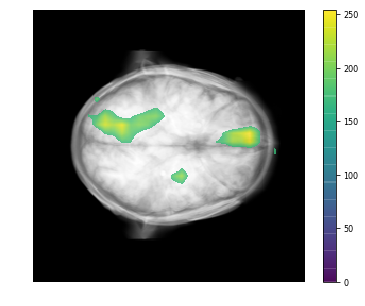

In [12]:
draw_one(heatmaps, data['x'])

image shape 1: torch.Size([1, 110, 256, 256])
image size in draw_All (110, 256, 256)
heatmap size in draw_All (110, 256, 256)


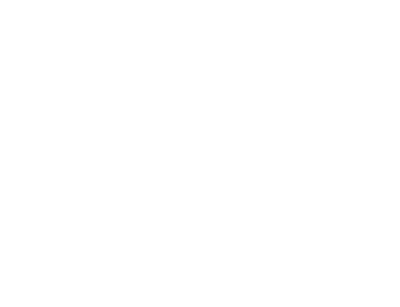

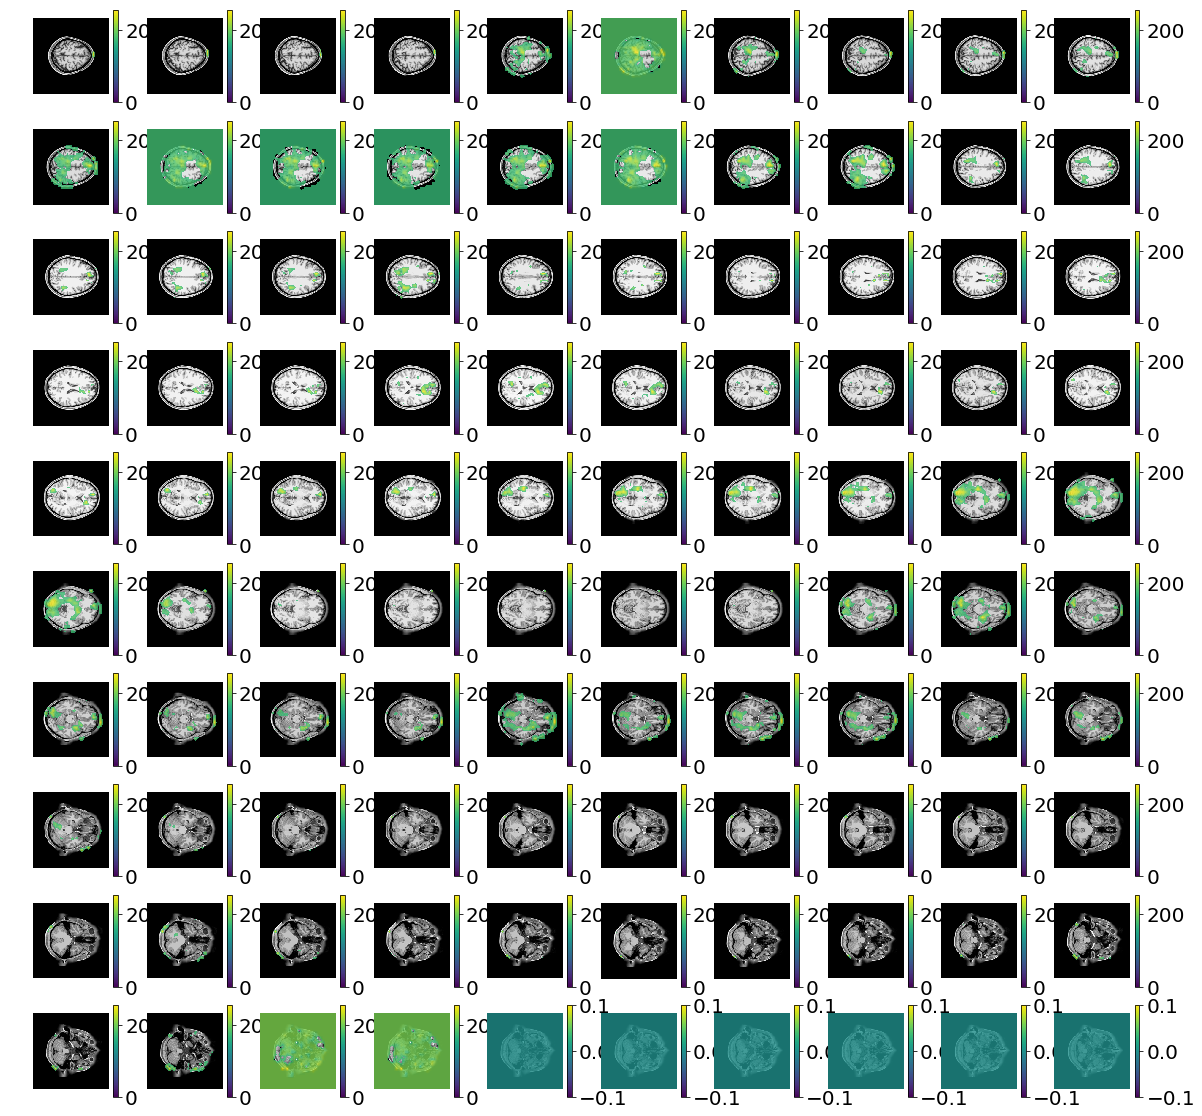

In [15]:
draw_all(heatmaps, data['x'])

/gpfs/data/cbi/hcp/hcp_seg/mlhc/3Dmodelbijuinoneoutputgradclipwithtorchnogradnodropoutonlypreptargetsmallnetworkwithbnormsample
[]
[]
image shape 1: torch.Size([1, 110, 256, 256])
torch.Size([110, 32, 32])
i0 j0 l0
i0 j0 l8
i0 j0 l16
i0 j0 l24
i0 j0 l32
i0 j0 l40
i0 j0 l48
i0 j0 l56
i0 j0 l64
i0 j0 l72
i0 j0 l80
i0 j0 l88
i0 j0 l96
i0 j0 l104
i0 j0 l112
i0 j0 l120
i0 j0 l128
i0 j0 l136
i0 j0 l144
i0 j0 l152
i0 j0 l160
i0 j0 l168
i0 j0 l176
i0 j0 l184
i0 j0 l192
i0 j0 l200
i0 j0 l208
i0 j0 l216
i0 j0 l224
i0 j0 l232
i0 j0 l240
i0 j0 l248
i0 j8 l0
i0 j8 l8
i0 j8 l16
i0 j8 l24
i0 j8 l32
i0 j8 l40
i0 j8 l48
i0 j8 l56
i0 j8 l64
i0 j8 l72
i0 j8 l80
i0 j8 l88
i0 j8 l96
i0 j8 l104
i0 j8 l112
i0 j8 l120
i0 j8 l128
i0 j8 l136
i0 j8 l144
i0 j8 l152
i0 j8 l160
i0 j8 l168
i0 j8 l176
i0 j8 l184
i0 j8 l192
i0 j8 l200
i0 j8 l208
i0 j8 l216
i0 j8 l224
i0 j8 l232
i0 j8 l240
i0 j8 l248
i0 j16 l0
i0 j16 l8
i0 j16 l16
i0 j16 l24
i0 j16 l32
i0 j16 l40
i0 j16 l48
i0 j16 l56
i0 j16 l64
i0 j16 l72
i0 j16 l80
i

i0 j168 l40
i0 j168 l48
i0 j168 l56
i0 j168 l64
i0 j168 l72
i0 j168 l80
i0 j168 l88
i0 j168 l96
i0 j168 l104
i0 j168 l112
i0 j168 l120
i0 j168 l128
i0 j168 l136
i0 j168 l144
i0 j168 l152
i0 j168 l160
i0 j168 l168
i0 j168 l176
i0 j168 l184
i0 j168 l192
i0 j168 l200
i0 j168 l208
i0 j168 l216
i0 j168 l224
i0 j168 l232
i0 j168 l240
i0 j168 l248
i0 j176 l0
i0 j176 l8
i0 j176 l16
i0 j176 l24
i0 j176 l32
i0 j176 l40
i0 j176 l48
i0 j176 l56
i0 j176 l64
i0 j176 l72
i0 j176 l80
i0 j176 l88
i0 j176 l96
i0 j176 l104
i0 j176 l112
i0 j176 l120
i0 j176 l128
i0 j176 l136
i0 j176 l144
i0 j176 l152
i0 j176 l160
i0 j176 l168
i0 j176 l176
i0 j176 l184
i0 j176 l192
i0 j176 l200
i0 j176 l208
i0 j176 l216
i0 j176 l224
i0 j176 l232
i0 j176 l240
i0 j176 l248
i0 j184 l0
i0 j184 l8
i0 j184 l16
i0 j184 l24
i0 j184 l32
i0 j184 l40
i0 j184 l48
i0 j184 l56
i0 j184 l64
i0 j184 l72
i0 j184 l80
i0 j184 l88
i0 j184 l96
i0 j184 l104
i0 j184 l112
i0 j184 l120
i0 j184 l128
i0 j184 l136
i0 j184 l144
i0 j184 l152
i0 j184 l16

i1 j80 l168
i1 j80 l176
i1 j80 l184
i1 j80 l192
i1 j80 l200
i1 j80 l208
i1 j80 l216
i1 j80 l224
i1 j80 l232
i1 j80 l240
i1 j80 l248
i1 j88 l0
i1 j88 l8
i1 j88 l16
i1 j88 l24
i1 j88 l32
i1 j88 l40
i1 j88 l48
i1 j88 l56
i1 j88 l64
i1 j88 l72
i1 j88 l80
i1 j88 l88
i1 j88 l96
i1 j88 l104
i1 j88 l112
i1 j88 l120
i1 j88 l128
i1 j88 l136
i1 j88 l144
i1 j88 l152
i1 j88 l160
i1 j88 l168
i1 j88 l176
i1 j88 l184
i1 j88 l192
i1 j88 l200
i1 j88 l208
i1 j88 l216
i1 j88 l224
i1 j88 l232
i1 j88 l240
i1 j88 l248
i1 j96 l0
i1 j96 l8
i1 j96 l16
i1 j96 l24
i1 j96 l32
i1 j96 l40
i1 j96 l48
i1 j96 l56
i1 j96 l64
i1 j96 l72
i1 j96 l80
i1 j96 l88
i1 j96 l96
i1 j96 l104
i1 j96 l112
i1 j96 l120
i1 j96 l128
i1 j96 l136
i1 j96 l144
i1 j96 l152
i1 j96 l160
i1 j96 l168
i1 j96 l176
i1 j96 l184
i1 j96 l192
i1 j96 l200
i1 j96 l208
i1 j96 l216
i1 j96 l224
i1 j96 l232
i1 j96 l240
i1 j96 l248
i1 j104 l0
i1 j104 l8
i1 j104 l16
i1 j104 l24
i1 j104 l32
i1 j104 l40
i1 j104 l48
i1 j104 l56
i1 j104 l64
i1 j104 l72
i1 j104 l80


i1 j248 l72
i1 j248 l80
i1 j248 l88
i1 j248 l96
i1 j248 l104
i1 j248 l112
i1 j248 l120
i1 j248 l128
i1 j248 l136
i1 j248 l144
i1 j248 l152
i1 j248 l160
i1 j248 l168
i1 j248 l176
i1 j248 l184
i1 j248 l192
i1 j248 l200
i1 j248 l208
i1 j248 l216
i1 j248 l224
i1 j248 l232
i1 j248 l240
i1 j248 l248
i2 j0 l0
i2 j0 l8
i2 j0 l16
i2 j0 l24
i2 j0 l32
i2 j0 l40
i2 j0 l48
i2 j0 l56
i2 j0 l64
i2 j0 l72
i2 j0 l80
i2 j0 l88
i2 j0 l96
i2 j0 l104
i2 j0 l112
i2 j0 l120
i2 j0 l128
i2 j0 l136
i2 j0 l144
i2 j0 l152
i2 j0 l160
i2 j0 l168
i2 j0 l176
i2 j0 l184
i2 j0 l192
i2 j0 l200
i2 j0 l208
i2 j0 l216
i2 j0 l224
i2 j0 l232
i2 j0 l240
i2 j0 l248
i2 j8 l0
i2 j8 l8
i2 j8 l16
i2 j8 l24
i2 j8 l32
i2 j8 l40
i2 j8 l48
i2 j8 l56
i2 j8 l64
i2 j8 l72
i2 j8 l80
i2 j8 l88
i2 j8 l96
i2 j8 l104
i2 j8 l112
i2 j8 l120
i2 j8 l128
i2 j8 l136
i2 j8 l144
i2 j8 l152
i2 j8 l160
i2 j8 l168
i2 j8 l176
i2 j8 l184
i2 j8 l192
i2 j8 l200
i2 j8 l208
i2 j8 l216
i2 j8 l224
i2 j8 l232
i2 j8 l240
i2 j8 l248
i2 j16 l0
i2 j16 l8
i2 j16 l16


i2 j168 l0
i2 j168 l8
i2 j168 l16
i2 j168 l24
i2 j168 l32
i2 j168 l40
i2 j168 l48
i2 j168 l56
i2 j168 l64
i2 j168 l72
i2 j168 l80
i2 j168 l88
i2 j168 l96
i2 j168 l104
i2 j168 l112
i2 j168 l120
i2 j168 l128
i2 j168 l136
i2 j168 l144
i2 j168 l152
i2 j168 l160
i2 j168 l168
i2 j168 l176
i2 j168 l184
i2 j168 l192
i2 j168 l200
i2 j168 l208
i2 j168 l216
i2 j168 l224
i2 j168 l232
i2 j168 l240
i2 j168 l248
i2 j176 l0
i2 j176 l8
i2 j176 l16
i2 j176 l24
i2 j176 l32
i2 j176 l40
i2 j176 l48
i2 j176 l56
i2 j176 l64
i2 j176 l72
i2 j176 l80
i2 j176 l88
i2 j176 l96
i2 j176 l104
i2 j176 l112
i2 j176 l120
i2 j176 l128
i2 j176 l136
i2 j176 l144
i2 j176 l152
i2 j176 l160
i2 j176 l168
i2 j176 l176
i2 j176 l184
i2 j176 l192
i2 j176 l200
i2 j176 l208
i2 j176 l216
i2 j176 l224
i2 j176 l232
i2 j176 l240
i2 j176 l248
i2 j184 l0
i2 j184 l8
i2 j184 l16
i2 j184 l24
i2 j184 l32
i2 j184 l40
i2 j184 l48
i2 j184 l56
i2 j184 l64
i2 j184 l72
i2 j184 l80
i2 j184 l88
i2 j184 l96
i2 j184 l104
i2 j184 l112
i2 j184 l120
i2 j1

i3 j80 l144
i3 j80 l152
i3 j80 l160
i3 j80 l168
i3 j80 l176
i3 j80 l184
i3 j80 l192
i3 j80 l200
i3 j80 l208
i3 j80 l216
i3 j80 l224
i3 j80 l232
i3 j80 l240
i3 j80 l248
i3 j88 l0
i3 j88 l8
i3 j88 l16
i3 j88 l24
i3 j88 l32
i3 j88 l40
i3 j88 l48
i3 j88 l56
i3 j88 l64
i3 j88 l72
i3 j88 l80
i3 j88 l88
i3 j88 l96
i3 j88 l104
i3 j88 l112
i3 j88 l120
i3 j88 l128
i3 j88 l136
i3 j88 l144
i3 j88 l152
i3 j88 l160
i3 j88 l168
i3 j88 l176
i3 j88 l184
i3 j88 l192
i3 j88 l200
i3 j88 l208
i3 j88 l216
i3 j88 l224
i3 j88 l232
i3 j88 l240
i3 j88 l248
i3 j96 l0
i3 j96 l8
i3 j96 l16
i3 j96 l24
i3 j96 l32
i3 j96 l40
i3 j96 l48
i3 j96 l56
i3 j96 l64
i3 j96 l72
i3 j96 l80
i3 j96 l88
i3 j96 l96
i3 j96 l104
i3 j96 l112
i3 j96 l120
i3 j96 l128
i3 j96 l136
i3 j96 l144
i3 j96 l152
i3 j96 l160
i3 j96 l168
i3 j96 l176
i3 j96 l184
i3 j96 l192
i3 j96 l200
i3 j96 l208
i3 j96 l216
i3 j96 l224
i3 j96 l232
i3 j96 l240
i3 j96 l248
i3 j104 l0
i3 j104 l8
i3 j104 l16
i3 j104 l24
i3 j104 l32
i3 j104 l40
i3 j104 l48
i3 j104 l56


i3 j248 l72
i3 j248 l80
i3 j248 l88
i3 j248 l96
i3 j248 l104
i3 j248 l112
i3 j248 l120
i3 j248 l128
i3 j248 l136
i3 j248 l144
i3 j248 l152
i3 j248 l160
i3 j248 l168
i3 j248 l176
i3 j248 l184
i3 j248 l192
i3 j248 l200
i3 j248 l208
i3 j248 l216
i3 j248 l224
i3 j248 l232
i3 j248 l240
i3 j248 l248
i4 j0 l0
i4 j0 l8
i4 j0 l16
i4 j0 l24
i4 j0 l32
i4 j0 l40
i4 j0 l48
i4 j0 l56
i4 j0 l64
i4 j0 l72
i4 j0 l80
i4 j0 l88
i4 j0 l96
i4 j0 l104
i4 j0 l112
i4 j0 l120
i4 j0 l128
i4 j0 l136
i4 j0 l144
i4 j0 l152
i4 j0 l160
i4 j0 l168
i4 j0 l176
i4 j0 l184
i4 j0 l192
i4 j0 l200
i4 j0 l208
i4 j0 l216
i4 j0 l224
i4 j0 l232
i4 j0 l240
i4 j0 l248
i4 j8 l0
i4 j8 l8
i4 j8 l16
i4 j8 l24
i4 j8 l32
i4 j8 l40
i4 j8 l48
i4 j8 l56
i4 j8 l64
i4 j8 l72
i4 j8 l80
i4 j8 l88
i4 j8 l96
i4 j8 l104
i4 j8 l112
i4 j8 l120
i4 j8 l128
i4 j8 l136
i4 j8 l144
i4 j8 l152
i4 j8 l160
i4 j8 l168
i4 j8 l176
i4 j8 l184
i4 j8 l192
i4 j8 l200
i4 j8 l208
i4 j8 l216
i4 j8 l224
i4 j8 l232
i4 j8 l240
i4 j8 l248
i4 j16 l0
i4 j16 l8
i4 j16 l16


i4 j168 l0
i4 j168 l8
i4 j168 l16
i4 j168 l24
i4 j168 l32
i4 j168 l40
i4 j168 l48
i4 j168 l56
i4 j168 l64
i4 j168 l72
i4 j168 l80
i4 j168 l88
i4 j168 l96
i4 j168 l104
i4 j168 l112
i4 j168 l120
i4 j168 l128
i4 j168 l136
i4 j168 l144
i4 j168 l152
i4 j168 l160
i4 j168 l168
i4 j168 l176
i4 j168 l184
i4 j168 l192
i4 j168 l200
i4 j168 l208
i4 j168 l216
i4 j168 l224
i4 j168 l232
i4 j168 l240
i4 j168 l248
i4 j176 l0
i4 j176 l8
i4 j176 l16
i4 j176 l24
i4 j176 l32
i4 j176 l40
i4 j176 l48
i4 j176 l56
i4 j176 l64
i4 j176 l72
i4 j176 l80
i4 j176 l88
i4 j176 l96
i4 j176 l104
i4 j176 l112
i4 j176 l120
i4 j176 l128
i4 j176 l136
i4 j176 l144
i4 j176 l152
i4 j176 l160
i4 j176 l168
i4 j176 l176
i4 j176 l184
i4 j176 l192
i4 j176 l200
i4 j176 l208
i4 j176 l216
i4 j176 l224
i4 j176 l232
i4 j176 l240
i4 j176 l248
i4 j184 l0
i4 j184 l8
i4 j184 l16
i4 j184 l24
i4 j184 l32
i4 j184 l40
i4 j184 l48
i4 j184 l56
i4 j184 l64
i4 j184 l72
i4 j184 l80
i4 j184 l88
i4 j184 l96
i4 j184 l104
i4 j184 l112
i4 j184 l120
i4 j1

i5 j80 l144
i5 j80 l152
i5 j80 l160
i5 j80 l168
i5 j80 l176
i5 j80 l184
i5 j80 l192
i5 j80 l200
i5 j80 l208
i5 j80 l216
i5 j80 l224
i5 j80 l232
i5 j80 l240
i5 j80 l248
i5 j88 l0
i5 j88 l8
i5 j88 l16
i5 j88 l24
i5 j88 l32
i5 j88 l40
i5 j88 l48
i5 j88 l56
i5 j88 l64
i5 j88 l72
i5 j88 l80
i5 j88 l88
i5 j88 l96
i5 j88 l104
i5 j88 l112
i5 j88 l120
i5 j88 l128
i5 j88 l136
i5 j88 l144
i5 j88 l152
i5 j88 l160
i5 j88 l168
i5 j88 l176
i5 j88 l184
i5 j88 l192
i5 j88 l200
i5 j88 l208
i5 j88 l216
i5 j88 l224
i5 j88 l232
i5 j88 l240
i5 j88 l248
i5 j96 l0
i5 j96 l8
i5 j96 l16
i5 j96 l24
i5 j96 l32
i5 j96 l40
i5 j96 l48
i5 j96 l56
i5 j96 l64
i5 j96 l72
i5 j96 l80
i5 j96 l88
i5 j96 l96
i5 j96 l104
i5 j96 l112
i5 j96 l120
i5 j96 l128
i5 j96 l136
i5 j96 l144
i5 j96 l152
i5 j96 l160
i5 j96 l168
i5 j96 l176
i5 j96 l184
i5 j96 l192
i5 j96 l200
i5 j96 l208
i5 j96 l216
i5 j96 l224
i5 j96 l232
i5 j96 l240
i5 j96 l248
i5 j104 l0
i5 j104 l8
i5 j104 l16
i5 j104 l24
i5 j104 l32
i5 j104 l40
i5 j104 l48
i5 j104 l56


i5 j248 l48
i5 j248 l56
i5 j248 l64
i5 j248 l72
i5 j248 l80
i5 j248 l88
i5 j248 l96
i5 j248 l104
i5 j248 l112
i5 j248 l120
i5 j248 l128
i5 j248 l136
i5 j248 l144
i5 j248 l152
i5 j248 l160
i5 j248 l168
i5 j248 l176
i5 j248 l184
i5 j248 l192
i5 j248 l200
i5 j248 l208
i5 j248 l216
i5 j248 l224
i5 j248 l232
i5 j248 l240
i5 j248 l248
i6 j0 l0
i6 j0 l8
i6 j0 l16
i6 j0 l24
i6 j0 l32
i6 j0 l40
i6 j0 l48
i6 j0 l56
i6 j0 l64
i6 j0 l72
i6 j0 l80
i6 j0 l88
i6 j0 l96
i6 j0 l104
i6 j0 l112
i6 j0 l120
i6 j0 l128
i6 j0 l136
i6 j0 l144
i6 j0 l152
i6 j0 l160
i6 j0 l168
i6 j0 l176
i6 j0 l184
i6 j0 l192
i6 j0 l200
i6 j0 l208
i6 j0 l216
i6 j0 l224
i6 j0 l232
i6 j0 l240
i6 j0 l248
i6 j8 l0
i6 j8 l8
i6 j8 l16
i6 j8 l24
i6 j8 l32
i6 j8 l40
i6 j8 l48
i6 j8 l56
i6 j8 l64
i6 j8 l72
i6 j8 l80
i6 j8 l88
i6 j8 l96
i6 j8 l104
i6 j8 l112
i6 j8 l120
i6 j8 l128
i6 j8 l136
i6 j8 l144
i6 j8 l152
i6 j8 l160
i6 j8 l168
i6 j8 l176
i6 j8 l184
i6 j8 l192
i6 j8 l200
i6 j8 l208
i6 j8 l216
i6 j8 l224
i6 j8 l232
i6 j8 l240
i6 j8 

i6 j160 l216
i6 j160 l224
i6 j160 l232
i6 j160 l240
i6 j160 l248
i6 j168 l0
i6 j168 l8
i6 j168 l16
i6 j168 l24
i6 j168 l32
i6 j168 l40
i6 j168 l48
i6 j168 l56
i6 j168 l64
i6 j168 l72
i6 j168 l80
i6 j168 l88
i6 j168 l96
i6 j168 l104
i6 j168 l112
i6 j168 l120
i6 j168 l128
i6 j168 l136
i6 j168 l144
i6 j168 l152
i6 j168 l160
i6 j168 l168
i6 j168 l176
i6 j168 l184
i6 j168 l192
i6 j168 l200
i6 j168 l208
i6 j168 l216
i6 j168 l224
i6 j168 l232
i6 j168 l240
i6 j168 l248
i6 j176 l0
i6 j176 l8
i6 j176 l16
i6 j176 l24
i6 j176 l32
i6 j176 l40
i6 j176 l48
i6 j176 l56
i6 j176 l64
i6 j176 l72
i6 j176 l80
i6 j176 l88
i6 j176 l96
i6 j176 l104
i6 j176 l112
i6 j176 l120
i6 j176 l128
i6 j176 l136
i6 j176 l144
i6 j176 l152
i6 j176 l160
i6 j176 l168
i6 j176 l176
i6 j176 l184
i6 j176 l192
i6 j176 l200
i6 j176 l208
i6 j176 l216
i6 j176 l224
i6 j176 l232
i6 j176 l240
i6 j176 l248
i6 j184 l0
i6 j184 l8
i6 j184 l16
i6 j184 l24
i6 j184 l32
i6 j184 l40
i6 j184 l48
i6 j184 l56
i6 j184 l64
i6 j184 l72
i6 j184 l80
i6 

i7 j80 l104
i7 j80 l112
i7 j80 l120
i7 j80 l128
i7 j80 l136
i7 j80 l144
i7 j80 l152
i7 j80 l160
i7 j80 l168
i7 j80 l176
i7 j80 l184
i7 j80 l192
i7 j80 l200
i7 j80 l208
i7 j80 l216
i7 j80 l224
i7 j80 l232
i7 j80 l240
i7 j80 l248
i7 j88 l0
i7 j88 l8
i7 j88 l16
i7 j88 l24
i7 j88 l32
i7 j88 l40
i7 j88 l48
i7 j88 l56
i7 j88 l64
i7 j88 l72
i7 j88 l80
i7 j88 l88
i7 j88 l96
i7 j88 l104
i7 j88 l112
i7 j88 l120
i7 j88 l128
i7 j88 l136
i7 j88 l144
i7 j88 l152
i7 j88 l160
i7 j88 l168
i7 j88 l176
i7 j88 l184
i7 j88 l192
i7 j88 l200
i7 j88 l208
i7 j88 l216
i7 j88 l224
i7 j88 l232
i7 j88 l240
i7 j88 l248
i7 j96 l0
i7 j96 l8
i7 j96 l16
i7 j96 l24
i7 j96 l32
i7 j96 l40
i7 j96 l48
i7 j96 l56
i7 j96 l64
i7 j96 l72
i7 j96 l80
i7 j96 l88
i7 j96 l96
i7 j96 l104
i7 j96 l112
i7 j96 l120
i7 j96 l128
i7 j96 l136
i7 j96 l144
i7 j96 l152
i7 j96 l160
i7 j96 l168
i7 j96 l176
i7 j96 l184
i7 j96 l192
i7 j96 l200
i7 j96 l208
i7 j96 l216
i7 j96 l224
i7 j96 l232
i7 j96 l240
i7 j96 l248
i7 j104 l0
i7 j104 l8
i7 j104 l16


i7 j248 l8
i7 j248 l16
i7 j248 l24
i7 j248 l32
i7 j248 l40
i7 j248 l48
i7 j248 l56
i7 j248 l64
i7 j248 l72
i7 j248 l80
i7 j248 l88
i7 j248 l96
i7 j248 l104
i7 j248 l112
i7 j248 l120
i7 j248 l128
i7 j248 l136
i7 j248 l144
i7 j248 l152
i7 j248 l160
i7 j248 l168
i7 j248 l176
i7 j248 l184
i7 j248 l192
i7 j248 l200
i7 j248 l208
i7 j248 l216
i7 j248 l224
i7 j248 l232
i7 j248 l240
i7 j248 l248
i8 j0 l0
i8 j0 l8
i8 j0 l16
i8 j0 l24
i8 j0 l32
i8 j0 l40
i8 j0 l48
i8 j0 l56
i8 j0 l64
i8 j0 l72
i8 j0 l80
i8 j0 l88
i8 j0 l96
i8 j0 l104
i8 j0 l112
i8 j0 l120
i8 j0 l128
i8 j0 l136
i8 j0 l144
i8 j0 l152
i8 j0 l160
i8 j0 l168
i8 j0 l176
i8 j0 l184
i8 j0 l192
i8 j0 l200
i8 j0 l208
i8 j0 l216
i8 j0 l224
i8 j0 l232
i8 j0 l240
i8 j0 l248
i8 j8 l0
i8 j8 l8
i8 j8 l16
i8 j8 l24
i8 j8 l32
i8 j8 l40
i8 j8 l48
i8 j8 l56
i8 j8 l64
i8 j8 l72
i8 j8 l80
i8 j8 l88
i8 j8 l96
i8 j8 l104
i8 j8 l112
i8 j8 l120
i8 j8 l128
i8 j8 l136
i8 j8 l144
i8 j8 l152
i8 j8 l160
i8 j8 l168
i8 j8 l176
i8 j8 l184
i8 j8 l192
i8 j8 l200
i8

i8 j160 l192
i8 j160 l200
i8 j160 l208
i8 j160 l216
i8 j160 l224
i8 j160 l232
i8 j160 l240
i8 j160 l248
i8 j168 l0
i8 j168 l8
i8 j168 l16
i8 j168 l24
i8 j168 l32
i8 j168 l40
i8 j168 l48
i8 j168 l56
i8 j168 l64
i8 j168 l72
i8 j168 l80
i8 j168 l88
i8 j168 l96
i8 j168 l104
i8 j168 l112
i8 j168 l120
i8 j168 l128
i8 j168 l136
i8 j168 l144
i8 j168 l152
i8 j168 l160
i8 j168 l168
i8 j168 l176
i8 j168 l184
i8 j168 l192
i8 j168 l200
i8 j168 l208
i8 j168 l216
i8 j168 l224
i8 j168 l232
i8 j168 l240
i8 j168 l248
i8 j176 l0
i8 j176 l8
i8 j176 l16
i8 j176 l24
i8 j176 l32
i8 j176 l40
i8 j176 l48
i8 j176 l56
i8 j176 l64
i8 j176 l72
i8 j176 l80
i8 j176 l88
i8 j176 l96
i8 j176 l104
i8 j176 l112
i8 j176 l120
i8 j176 l128
i8 j176 l136
i8 j176 l144
i8 j176 l152
i8 j176 l160
i8 j176 l168
i8 j176 l176
i8 j176 l184
i8 j176 l192
i8 j176 l200
i8 j176 l208
i8 j176 l216
i8 j176 l224
i8 j176 l232
i8 j176 l240
i8 j176 l248
i8 j184 l0
i8 j184 l8
i8 j184 l16
i8 j184 l24
i8 j184 l32
i8 j184 l40
i8 j184 l48
i8 j184 l56


i9 j80 l72
i9 j80 l80
i9 j80 l88
i9 j80 l96
i9 j80 l104
i9 j80 l112
i9 j80 l120
i9 j80 l128
i9 j80 l136
i9 j80 l144
i9 j80 l152
i9 j80 l160
i9 j80 l168
i9 j80 l176
i9 j80 l184
i9 j80 l192
i9 j80 l200
i9 j80 l208
i9 j80 l216
i9 j80 l224
i9 j80 l232
i9 j80 l240
i9 j80 l248
i9 j88 l0
i9 j88 l8
i9 j88 l16
i9 j88 l24
i9 j88 l32
i9 j88 l40
i9 j88 l48
i9 j88 l56
i9 j88 l64
i9 j88 l72
i9 j88 l80
i9 j88 l88
i9 j88 l96
i9 j88 l104
i9 j88 l112
i9 j88 l120
i9 j88 l128
i9 j88 l136
i9 j88 l144
i9 j88 l152
i9 j88 l160
i9 j88 l168
i9 j88 l176
i9 j88 l184
i9 j88 l192
i9 j88 l200
i9 j88 l208
i9 j88 l216
i9 j88 l224
i9 j88 l232
i9 j88 l240
i9 j88 l248
i9 j96 l0
i9 j96 l8
i9 j96 l16
i9 j96 l24
i9 j96 l32
i9 j96 l40
i9 j96 l48
i9 j96 l56
i9 j96 l64
i9 j96 l72
i9 j96 l80
i9 j96 l88
i9 j96 l96
i9 j96 l104
i9 j96 l112
i9 j96 l120
i9 j96 l128
i9 j96 l136
i9 j96 l144
i9 j96 l152
i9 j96 l160
i9 j96 l168
i9 j96 l176
i9 j96 l184
i9 j96 l192
i9 j96 l200
i9 j96 l208
i9 j96 l216
i9 j96 l224
i9 j96 l232
i9 j96 l240
i9

i9 j248 l16
i9 j248 l24
i9 j248 l32
i9 j248 l40
i9 j248 l48
i9 j248 l56
i9 j248 l64
i9 j248 l72
i9 j248 l80
i9 j248 l88
i9 j248 l96
i9 j248 l104
i9 j248 l112
i9 j248 l120
i9 j248 l128
i9 j248 l136
i9 j248 l144
i9 j248 l152
i9 j248 l160
i9 j248 l168
i9 j248 l176
i9 j248 l184
i9 j248 l192
i9 j248 l200
i9 j248 l208
i9 j248 l216
i9 j248 l224
i9 j248 l232
i9 j248 l240
i9 j248 l248
i10 j0 l0
i10 j0 l8
i10 j0 l16
i10 j0 l24
i10 j0 l32
i10 j0 l40
i10 j0 l48
i10 j0 l56
i10 j0 l64
i10 j0 l72
i10 j0 l80
i10 j0 l88
i10 j0 l96
i10 j0 l104
i10 j0 l112
i10 j0 l120
i10 j0 l128
i10 j0 l136
i10 j0 l144
i10 j0 l152
i10 j0 l160
i10 j0 l168
i10 j0 l176
i10 j0 l184
i10 j0 l192
i10 j0 l200
i10 j0 l208
i10 j0 l216
i10 j0 l224
i10 j0 l232
i10 j0 l240
i10 j0 l248
i10 j8 l0
i10 j8 l8
i10 j8 l16
i10 j8 l24
i10 j8 l32
i10 j8 l40
i10 j8 l48
i10 j8 l56
i10 j8 l64
i10 j8 l72
i10 j8 l80
i10 j8 l88
i10 j8 l96
i10 j8 l104
i10 j8 l112
i10 j8 l120
i10 j8 l128
i10 j8 l136
i10 j8 l144
i10 j8 l152
i10 j8 l160
i10 j8 l168
i10

i10 j152 l80
i10 j152 l88
i10 j152 l96
i10 j152 l104
i10 j152 l112
i10 j152 l120
i10 j152 l128
i10 j152 l136
i10 j152 l144
i10 j152 l152
i10 j152 l160
i10 j152 l168
i10 j152 l176
i10 j152 l184
i10 j152 l192
i10 j152 l200
i10 j152 l208
i10 j152 l216
i10 j152 l224
i10 j152 l232
i10 j152 l240
i10 j152 l248
i10 j160 l0
i10 j160 l8
i10 j160 l16
i10 j160 l24
i10 j160 l32
i10 j160 l40
i10 j160 l48
i10 j160 l56
i10 j160 l64
i10 j160 l72
i10 j160 l80
i10 j160 l88
i10 j160 l96
i10 j160 l104
i10 j160 l112
i10 j160 l120
i10 j160 l128
i10 j160 l136
i10 j160 l144
i10 j160 l152
i10 j160 l160
i10 j160 l168
i10 j160 l176
i10 j160 l184
i10 j160 l192
i10 j160 l200
i10 j160 l208
i10 j160 l216
i10 j160 l224
i10 j160 l232
i10 j160 l240
i10 j160 l248
i10 j168 l0
i10 j168 l8
i10 j168 l16
i10 j168 l24
i10 j168 l32
i10 j168 l40
i10 j168 l48
i10 j168 l56
i10 j168 l64
i10 j168 l72
i10 j168 l80
i10 j168 l88
i10 j168 l96
i10 j168 l104
i10 j168 l112
i10 j168 l120
i10 j168 l128
i10 j168 l136
i10 j168 l144
i10 j168 l1

i11 j48 l240
i11 j48 l248
i11 j56 l0
i11 j56 l8
i11 j56 l16
i11 j56 l24
i11 j56 l32
i11 j56 l40
i11 j56 l48
i11 j56 l56
i11 j56 l64
i11 j56 l72
i11 j56 l80
i11 j56 l88
i11 j56 l96
i11 j56 l104
i11 j56 l112
i11 j56 l120
i11 j56 l128
i11 j56 l136
i11 j56 l144
i11 j56 l152
i11 j56 l160
i11 j56 l168
i11 j56 l176
i11 j56 l184
i11 j56 l192
i11 j56 l200
i11 j56 l208
i11 j56 l216
i11 j56 l224
i11 j56 l232
i11 j56 l240
i11 j56 l248
i11 j64 l0
i11 j64 l8
i11 j64 l16
i11 j64 l24
i11 j64 l32
i11 j64 l40
i11 j64 l48
i11 j64 l56
i11 j64 l64
i11 j64 l72
i11 j64 l80
i11 j64 l88
i11 j64 l96
i11 j64 l104
i11 j64 l112
i11 j64 l120
i11 j64 l128
i11 j64 l136
i11 j64 l144
i11 j64 l152
i11 j64 l160
i11 j64 l168
i11 j64 l176
i11 j64 l184
i11 j64 l192
i11 j64 l200
i11 j64 l208
i11 j64 l216
i11 j64 l224
i11 j64 l232
i11 j64 l240
i11 j64 l248
i11 j72 l0
i11 j72 l8
i11 j72 l16
i11 j72 l24
i11 j72 l32
i11 j72 l40
i11 j72 l48
i11 j72 l56
i11 j72 l64
i11 j72 l72
i11 j72 l80
i11 j72 l88
i11 j72 l96
i11 j72 l104
i11 j

i11 j208 l120
i11 j208 l128
i11 j208 l136
i11 j208 l144
i11 j208 l152
i11 j208 l160
i11 j208 l168
i11 j208 l176
i11 j208 l184
i11 j208 l192
i11 j208 l200
i11 j208 l208
i11 j208 l216
i11 j208 l224
i11 j208 l232
i11 j208 l240
i11 j208 l248
i11 j216 l0
i11 j216 l8
i11 j216 l16
i11 j216 l24
i11 j216 l32
i11 j216 l40
i11 j216 l48
i11 j216 l56
i11 j216 l64
i11 j216 l72
i11 j216 l80
i11 j216 l88
i11 j216 l96
i11 j216 l104
i11 j216 l112
i11 j216 l120
i11 j216 l128
i11 j216 l136
i11 j216 l144
i11 j216 l152
i11 j216 l160
i11 j216 l168
i11 j216 l176
i11 j216 l184
i11 j216 l192
i11 j216 l200
i11 j216 l208
i11 j216 l216
i11 j216 l224
i11 j216 l232
i11 j216 l240
i11 j216 l248
i11 j224 l0
i11 j224 l8
i11 j224 l16
i11 j224 l24
i11 j224 l32
i11 j224 l40
i11 j224 l48
i11 j224 l56
i11 j224 l64
i11 j224 l72
i11 j224 l80
i11 j224 l88
i11 j224 l96
i11 j224 l104
i11 j224 l112
i11 j224 l120
i11 j224 l128
i11 j224 l136
i11 j224 l144
i11 j224 l152
i11 j224 l160
i11 j224 l168
i11 j224 l176
i11 j224 l184
i11 j224

i12 j112 l128
i12 j112 l136
i12 j112 l144
i12 j112 l152
i12 j112 l160
i12 j112 l168
i12 j112 l176
i12 j112 l184
i12 j112 l192
i12 j112 l200
i12 j112 l208
i12 j112 l216
i12 j112 l224
i12 j112 l232
i12 j112 l240
i12 j112 l248
i12 j120 l0
i12 j120 l8
i12 j120 l16
i12 j120 l24
i12 j120 l32
i12 j120 l40
i12 j120 l48
i12 j120 l56
i12 j120 l64
i12 j120 l72
i12 j120 l80
i12 j120 l88
i12 j120 l96
i12 j120 l104
i12 j120 l112
i12 j120 l120
i12 j120 l128
i12 j120 l136
i12 j120 l144
i12 j120 l152
i12 j120 l160
i12 j120 l168
i12 j120 l176
i12 j120 l184
i12 j120 l192
i12 j120 l200
i12 j120 l208
i12 j120 l216
i12 j120 l224
i12 j120 l232
i12 j120 l240
i12 j120 l248
i12 j128 l0
i12 j128 l8
i12 j128 l16
i12 j128 l24
i12 j128 l32
i12 j128 l40
i12 j128 l48
i12 j128 l56
i12 j128 l64
i12 j128 l72
i12 j128 l80
i12 j128 l88
i12 j128 l96
i12 j128 l104
i12 j128 l112
i12 j128 l120
i12 j128 l128
i12 j128 l136
i12 j128 l144
i12 j128 l152
i12 j128 l160
i12 j128 l168
i12 j128 l176
i12 j128 l184
i12 j128 l192
i12 j128

i13 j8 l200
i13 j8 l208
i13 j8 l216
i13 j8 l224
i13 j8 l232
i13 j8 l240
i13 j8 l248
i13 j16 l0
i13 j16 l8
i13 j16 l16
i13 j16 l24
i13 j16 l32
i13 j16 l40
i13 j16 l48
i13 j16 l56
i13 j16 l64
i13 j16 l72
i13 j16 l80
i13 j16 l88
i13 j16 l96
i13 j16 l104
i13 j16 l112
i13 j16 l120
i13 j16 l128
i13 j16 l136
i13 j16 l144
i13 j16 l152
i13 j16 l160
i13 j16 l168
i13 j16 l176
i13 j16 l184
i13 j16 l192
i13 j16 l200
i13 j16 l208
i13 j16 l216
i13 j16 l224
i13 j16 l232
i13 j16 l240
i13 j16 l248
i13 j24 l0
i13 j24 l8
i13 j24 l16
i13 j24 l24
i13 j24 l32
i13 j24 l40
i13 j24 l48
i13 j24 l56
i13 j24 l64
i13 j24 l72
i13 j24 l80
i13 j24 l88
i13 j24 l96
i13 j24 l104
i13 j24 l112
i13 j24 l120
i13 j24 l128
i13 j24 l136
i13 j24 l144
i13 j24 l152
i13 j24 l160
i13 j24 l168
i13 j24 l176
i13 j24 l184
i13 j24 l192
i13 j24 l200
i13 j24 l208
i13 j24 l216
i13 j24 l224
i13 j24 l232
i13 j24 l240
i13 j24 l248
i13 j32 l0
i13 j32 l8
i13 j32 l16
i13 j32 l24
i13 j32 l32
i13 j32 l40
i13 j32 l48
i13 j32 l56
i13 j32 l64
i13 j32 

i13 j168 l168
i13 j168 l176
i13 j168 l184
i13 j168 l192
i13 j168 l200
i13 j168 l208
i13 j168 l216
i13 j168 l224
i13 j168 l232
i13 j168 l240
i13 j168 l248
i13 j176 l0
i13 j176 l8
i13 j176 l16
i13 j176 l24
i13 j176 l32
i13 j176 l40
i13 j176 l48
i13 j176 l56
i13 j176 l64
i13 j176 l72
i13 j176 l80
i13 j176 l88
i13 j176 l96
i13 j176 l104
i13 j176 l112
i13 j176 l120
i13 j176 l128
i13 j176 l136
i13 j176 l144
i13 j176 l152
i13 j176 l160
i13 j176 l168
i13 j176 l176
i13 j176 l184
i13 j176 l192
i13 j176 l200
i13 j176 l208
i13 j176 l216
i13 j176 l224
i13 j176 l232
i13 j176 l240
i13 j176 l248
i13 j184 l0
i13 j184 l8
i13 j184 l16
i13 j184 l24
i13 j184 l32
i13 j184 l40
i13 j184 l48
i13 j184 l56
i13 j184 l64
i13 j184 l72
i13 j184 l80
i13 j184 l88
i13 j184 l96
i13 j184 l104
i13 j184 l112
i13 j184 l120
i13 j184 l128
i13 j184 l136
i13 j184 l144
i13 j184 l152
i13 j184 l160
i13 j184 l168
i13 j184 l176
i13 j184 l184
i13 j184 l192
i13 j184 l200
i13 j184 l208
i13 j184 l216
i13 j184 l224
i13 j184 l232
i13 j184

i14 j72 l136
i14 j72 l144
i14 j72 l152
i14 j72 l160
i14 j72 l168
i14 j72 l176
i14 j72 l184
i14 j72 l192
i14 j72 l200
i14 j72 l208
i14 j72 l216
i14 j72 l224
i14 j72 l232
i14 j72 l240
i14 j72 l248
i14 j80 l0
i14 j80 l8
i14 j80 l16
i14 j80 l24
i14 j80 l32
i14 j80 l40
i14 j80 l48
i14 j80 l56
i14 j80 l64
i14 j80 l72
i14 j80 l80
i14 j80 l88
i14 j80 l96
i14 j80 l104
i14 j80 l112
i14 j80 l120
i14 j80 l128
i14 j80 l136
i14 j80 l144
i14 j80 l152
i14 j80 l160
i14 j80 l168
i14 j80 l176
i14 j80 l184
i14 j80 l192
i14 j80 l200
i14 j80 l208
i14 j80 l216
i14 j80 l224
i14 j80 l232
i14 j80 l240
i14 j80 l248
i14 j88 l0
i14 j88 l8
i14 j88 l16
i14 j88 l24
i14 j88 l32
i14 j88 l40
i14 j88 l48
i14 j88 l56
i14 j88 l64
i14 j88 l72
i14 j88 l80
i14 j88 l88
i14 j88 l96
i14 j88 l104
i14 j88 l112
i14 j88 l120
i14 j88 l128
i14 j88 l136
i14 j88 l144
i14 j88 l152
i14 j88 l160
i14 j88 l168
i14 j88 l176
i14 j88 l184
i14 j88 l192
i14 j88 l200
i14 j88 l208
i14 j88 l216
i14 j88 l224
i14 j88 l232
i14 j88 l240
i14 j88 l248
i14

i14 j224 l200
i14 j224 l208
i14 j224 l216
i14 j224 l224
i14 j224 l232
i14 j224 l240
i14 j224 l248
i14 j232 l0
i14 j232 l8
i14 j232 l16
i14 j232 l24
i14 j232 l32
i14 j232 l40
i14 j232 l48
i14 j232 l56
i14 j232 l64
i14 j232 l72
i14 j232 l80
i14 j232 l88
i14 j232 l96
i14 j232 l104
i14 j232 l112
i14 j232 l120
i14 j232 l128
i14 j232 l136
i14 j232 l144
i14 j232 l152
i14 j232 l160
i14 j232 l168
i14 j232 l176
i14 j232 l184
i14 j232 l192
i14 j232 l200
i14 j232 l208
i14 j232 l216
i14 j232 l224
i14 j232 l232
i14 j232 l240
i14 j232 l248
i14 j240 l0
i14 j240 l8
i14 j240 l16
i14 j240 l24
i14 j240 l32
i14 j240 l40
i14 j240 l48
i14 j240 l56
i14 j240 l64
i14 j240 l72
i14 j240 l80
i14 j240 l88
i14 j240 l96
i14 j240 l104
i14 j240 l112
i14 j240 l120
i14 j240 l128
i14 j240 l136
i14 j240 l144
i14 j240 l152
i14 j240 l160
i14 j240 l168
i14 j240 l176
i14 j240 l184
i14 j240 l192
i14 j240 l200
i14 j240 l208
i14 j240 l216
i14 j240 l224
i14 j240 l232
i14 j240 l240
i14 j240 l248
i14 j248 l0
i14 j248 l8
i14 j248 l16

i15 j128 l208
i15 j128 l216
i15 j128 l224
i15 j128 l232
i15 j128 l240
i15 j128 l248
i15 j136 l0
i15 j136 l8
i15 j136 l16
i15 j136 l24
i15 j136 l32
i15 j136 l40
i15 j136 l48
i15 j136 l56
i15 j136 l64
i15 j136 l72
i15 j136 l80
i15 j136 l88
i15 j136 l96
i15 j136 l104
i15 j136 l112
i15 j136 l120
i15 j136 l128
i15 j136 l136
i15 j136 l144
i15 j136 l152
i15 j136 l160
i15 j136 l168
i15 j136 l176
i15 j136 l184
i15 j136 l192
i15 j136 l200
i15 j136 l208
i15 j136 l216
i15 j136 l224
i15 j136 l232
i15 j136 l240
i15 j136 l248
i15 j144 l0
i15 j144 l8
i15 j144 l16
i15 j144 l24
i15 j144 l32
i15 j144 l40
i15 j144 l48
i15 j144 l56
i15 j144 l64
i15 j144 l72
i15 j144 l80
i15 j144 l88
i15 j144 l96
i15 j144 l104
i15 j144 l112
i15 j144 l120
i15 j144 l128
i15 j144 l136
i15 j144 l144
i15 j144 l152
i15 j144 l160
i15 j144 l168
i15 j144 l176
i15 j144 l184
i15 j144 l192
i15 j144 l200
i15 j144 l208
i15 j144 l216
i15 j144 l224
i15 j144 l232
i15 j144 l240
i15 j144 l248
i15 j152 l0
i15 j152 l8
i15 j152 l16
i15 j152 l24


i16 j32 l64
i16 j32 l72
i16 j32 l80
i16 j32 l88
i16 j32 l96
i16 j32 l104
i16 j32 l112
i16 j32 l120
i16 j32 l128
i16 j32 l136
i16 j32 l144
i16 j32 l152
i16 j32 l160
i16 j32 l168
i16 j32 l176
i16 j32 l184
i16 j32 l192
i16 j32 l200
i16 j32 l208
i16 j32 l216
i16 j32 l224
i16 j32 l232
i16 j32 l240
i16 j32 l248
i16 j40 l0
i16 j40 l8
i16 j40 l16
i16 j40 l24
i16 j40 l32
i16 j40 l40
i16 j40 l48
i16 j40 l56
i16 j40 l64
i16 j40 l72
i16 j40 l80
i16 j40 l88
i16 j40 l96
i16 j40 l104
i16 j40 l112
i16 j40 l120
i16 j40 l128
i16 j40 l136
i16 j40 l144
i16 j40 l152
i16 j40 l160
i16 j40 l168
i16 j40 l176
i16 j40 l184
i16 j40 l192
i16 j40 l200
i16 j40 l208
i16 j40 l216
i16 j40 l224
i16 j40 l232
i16 j40 l240
i16 j40 l248
i16 j48 l0
i16 j48 l8
i16 j48 l16
i16 j48 l24
i16 j48 l32
i16 j48 l40
i16 j48 l48
i16 j48 l56
i16 j48 l64
i16 j48 l72
i16 j48 l80
i16 j48 l88
i16 j48 l96
i16 j48 l104
i16 j48 l112
i16 j48 l120
i16 j48 l128
i16 j48 l136
i16 j48 l144
i16 j48 l152
i16 j48 l160
i16 j48 l168
i16 j48 l176
i16 j48 

i16 j184 l240
i16 j184 l248
i16 j192 l0
i16 j192 l8
i16 j192 l16
i16 j192 l24
i16 j192 l32
i16 j192 l40
i16 j192 l48
i16 j192 l56
i16 j192 l64
i16 j192 l72
i16 j192 l80
i16 j192 l88
i16 j192 l96
i16 j192 l104
i16 j192 l112
i16 j192 l120
i16 j192 l128
i16 j192 l136
i16 j192 l144
i16 j192 l152
i16 j192 l160
i16 j192 l168
i16 j192 l176
i16 j192 l184
i16 j192 l192
i16 j192 l200
i16 j192 l208
i16 j192 l216
i16 j192 l224
i16 j192 l232
i16 j192 l240
i16 j192 l248
i16 j200 l0
i16 j200 l8
i16 j200 l16
i16 j200 l24
i16 j200 l32
i16 j200 l40
i16 j200 l48
i16 j200 l56
i16 j200 l64
i16 j200 l72
i16 j200 l80
i16 j200 l88
i16 j200 l96
i16 j200 l104
i16 j200 l112
i16 j200 l120
i16 j200 l128
i16 j200 l136
i16 j200 l144
i16 j200 l152
i16 j200 l160
i16 j200 l168
i16 j200 l176
i16 j200 l184
i16 j200 l192
i16 j200 l200
i16 j200 l208
i16 j200 l216
i16 j200 l224
i16 j200 l232
i16 j200 l240
i16 j200 l248
i16 j208 l0
i16 j208 l8
i16 j208 l16
i16 j208 l24
i16 j208 l32
i16 j208 l40
i16 j208 l48
i16 j208 l56
i16 

i17 j96 l0
i17 j96 l8
i17 j96 l16
i17 j96 l24
i17 j96 l32
i17 j96 l40
i17 j96 l48
i17 j96 l56
i17 j96 l64
i17 j96 l72
i17 j96 l80
i17 j96 l88
i17 j96 l96
i17 j96 l104
i17 j96 l112
i17 j96 l120
i17 j96 l128
i17 j96 l136
i17 j96 l144
i17 j96 l152
i17 j96 l160
i17 j96 l168
i17 j96 l176
i17 j96 l184
i17 j96 l192
i17 j96 l200
i17 j96 l208
i17 j96 l216
i17 j96 l224
i17 j96 l232
i17 j96 l240
i17 j96 l248
i17 j104 l0
i17 j104 l8
i17 j104 l16
i17 j104 l24
i17 j104 l32
i17 j104 l40
i17 j104 l48
i17 j104 l56
i17 j104 l64
i17 j104 l72
i17 j104 l80
i17 j104 l88
i17 j104 l96
i17 j104 l104
i17 j104 l112
i17 j104 l120
i17 j104 l128
i17 j104 l136
i17 j104 l144
i17 j104 l152
i17 j104 l160
i17 j104 l168
i17 j104 l176
i17 j104 l184
i17 j104 l192
i17 j104 l200
i17 j104 l208
i17 j104 l216
i17 j104 l224
i17 j104 l232
i17 j104 l240
i17 j104 l248
i17 j112 l0
i17 j112 l8
i17 j112 l16
i17 j112 l24
i17 j112 l32
i17 j112 l40
i17 j112 l48
i17 j112 l56
i17 j112 l64
i17 j112 l72
i17 j112 l80
i17 j112 l88
i17 j112 l96

i17 j248 l16
i17 j248 l24
i17 j248 l32
i17 j248 l40
i17 j248 l48
i17 j248 l56
i17 j248 l64
i17 j248 l72
i17 j248 l80
i17 j248 l88
i17 j248 l96
i17 j248 l104
i17 j248 l112
i17 j248 l120
i17 j248 l128
i17 j248 l136
i17 j248 l144
i17 j248 l152
i17 j248 l160
i17 j248 l168
i17 j248 l176
i17 j248 l184
i17 j248 l192
i17 j248 l200
i17 j248 l208
i17 j248 l216
i17 j248 l224
i17 j248 l232
i17 j248 l240
i17 j248 l248
i18 j0 l0
i18 j0 l8
i18 j0 l16
i18 j0 l24
i18 j0 l32
i18 j0 l40
i18 j0 l48
i18 j0 l56
i18 j0 l64
i18 j0 l72
i18 j0 l80
i18 j0 l88
i18 j0 l96
i18 j0 l104
i18 j0 l112
i18 j0 l120
i18 j0 l128
i18 j0 l136
i18 j0 l144
i18 j0 l152
i18 j0 l160
i18 j0 l168
i18 j0 l176
i18 j0 l184
i18 j0 l192
i18 j0 l200
i18 j0 l208
i18 j0 l216
i18 j0 l224
i18 j0 l232
i18 j0 l240
i18 j0 l248
i18 j8 l0
i18 j8 l8
i18 j8 l16
i18 j8 l24
i18 j8 l32
i18 j8 l40
i18 j8 l48
i18 j8 l56
i18 j8 l64
i18 j8 l72
i18 j8 l80
i18 j8 l88
i18 j8 l96
i18 j8 l104
i18 j8 l112
i18 j8 l120
i18 j8 l128
i18 j8 l136
i18 j8 l144
i18 j8 l1

i18 j152 l56
i18 j152 l64
i18 j152 l72
i18 j152 l80
i18 j152 l88
i18 j152 l96
i18 j152 l104
i18 j152 l112
i18 j152 l120
i18 j152 l128
i18 j152 l136
i18 j152 l144
i18 j152 l152
i18 j152 l160
i18 j152 l168
i18 j152 l176
i18 j152 l184
i18 j152 l192
i18 j152 l200
i18 j152 l208
i18 j152 l216
i18 j152 l224
i18 j152 l232
i18 j152 l240
i18 j152 l248
i18 j160 l0
i18 j160 l8
i18 j160 l16
i18 j160 l24
i18 j160 l32
i18 j160 l40
i18 j160 l48
i18 j160 l56
i18 j160 l64
i18 j160 l72
i18 j160 l80
i18 j160 l88
i18 j160 l96
i18 j160 l104
i18 j160 l112
i18 j160 l120
i18 j160 l128
i18 j160 l136
i18 j160 l144
i18 j160 l152
i18 j160 l160
i18 j160 l168
i18 j160 l176
i18 j160 l184
i18 j160 l192
i18 j160 l200
i18 j160 l208
i18 j160 l216
i18 j160 l224
i18 j160 l232
i18 j160 l240
i18 j160 l248
i18 j168 l0
i18 j168 l8
i18 j168 l16
i18 j168 l24
i18 j168 l32
i18 j168 l40
i18 j168 l48
i18 j168 l56
i18 j168 l64
i18 j168 l72
i18 j168 l80
i18 j168 l88
i18 j168 l96
i18 j168 l104
i18 j168 l112
i18 j168 l120
i18 j168 l128


i19 j48 l232
i19 j48 l240
i19 j48 l248
i19 j56 l0
i19 j56 l8
i19 j56 l16
i19 j56 l24
i19 j56 l32
i19 j56 l40
i19 j56 l48
i19 j56 l56
i19 j56 l64
i19 j56 l72
i19 j56 l80
i19 j56 l88
i19 j56 l96
i19 j56 l104
i19 j56 l112
i19 j56 l120
i19 j56 l128
i19 j56 l136
i19 j56 l144
i19 j56 l152
i19 j56 l160
i19 j56 l168
i19 j56 l176
i19 j56 l184
i19 j56 l192
i19 j56 l200
i19 j56 l208
i19 j56 l216
i19 j56 l224
i19 j56 l232
i19 j56 l240
i19 j56 l248
i19 j64 l0
i19 j64 l8
i19 j64 l16
i19 j64 l24
i19 j64 l32
i19 j64 l40
i19 j64 l48
i19 j64 l56
i19 j64 l64
i19 j64 l72
i19 j64 l80
i19 j64 l88
i19 j64 l96
i19 j64 l104
i19 j64 l112
i19 j64 l120
i19 j64 l128
i19 j64 l136
i19 j64 l144
i19 j64 l152
i19 j64 l160
i19 j64 l168
i19 j64 l176
i19 j64 l184
i19 j64 l192
i19 j64 l200
i19 j64 l208
i19 j64 l216
i19 j64 l224
i19 j64 l232
i19 j64 l240
i19 j64 l248
i19 j72 l0
i19 j72 l8
i19 j72 l16
i19 j72 l24
i19 j72 l32
i19 j72 l40
i19 j72 l48
i19 j72 l56
i19 j72 l64
i19 j72 l72
i19 j72 l80
i19 j72 l88
i19 j72 l96
i19 j

i19 j208 l112
i19 j208 l120
i19 j208 l128
i19 j208 l136
i19 j208 l144
i19 j208 l152
i19 j208 l160
i19 j208 l168
i19 j208 l176
i19 j208 l184
i19 j208 l192
i19 j208 l200
i19 j208 l208
i19 j208 l216
i19 j208 l224
i19 j208 l232
i19 j208 l240
i19 j208 l248
i19 j216 l0
i19 j216 l8
i19 j216 l16
i19 j216 l24
i19 j216 l32
i19 j216 l40
i19 j216 l48
i19 j216 l56
i19 j216 l64
i19 j216 l72
i19 j216 l80
i19 j216 l88
i19 j216 l96
i19 j216 l104
i19 j216 l112
i19 j216 l120
i19 j216 l128
i19 j216 l136
i19 j216 l144
i19 j216 l152
i19 j216 l160
i19 j216 l168
i19 j216 l176
i19 j216 l184
i19 j216 l192
i19 j216 l200
i19 j216 l208
i19 j216 l216
i19 j216 l224
i19 j216 l232
i19 j216 l240
i19 j216 l248
i19 j224 l0
i19 j224 l8
i19 j224 l16
i19 j224 l24
i19 j224 l32
i19 j224 l40
i19 j224 l48
i19 j224 l56
i19 j224 l64
i19 j224 l72
i19 j224 l80
i19 j224 l88
i19 j224 l96
i19 j224 l104
i19 j224 l112
i19 j224 l120
i19 j224 l128
i19 j224 l136
i19 j224 l144
i19 j224 l152
i19 j224 l160
i19 j224 l168
i19 j224 l176
i19 j224

i20 j112 l152
i20 j112 l160
i20 j112 l168
i20 j112 l176
i20 j112 l184
i20 j112 l192
i20 j112 l200
i20 j112 l208
i20 j112 l216
i20 j112 l224
i20 j112 l232
i20 j112 l240
i20 j112 l248
i20 j120 l0
i20 j120 l8
i20 j120 l16
i20 j120 l24
i20 j120 l32
i20 j120 l40
i20 j120 l48
i20 j120 l56
i20 j120 l64
i20 j120 l72
i20 j120 l80
i20 j120 l88
i20 j120 l96
i20 j120 l104
i20 j120 l112
i20 j120 l120
i20 j120 l128
i20 j120 l136
i20 j120 l144
i20 j120 l152
i20 j120 l160
i20 j120 l168
i20 j120 l176
i20 j120 l184
i20 j120 l192
i20 j120 l200
i20 j120 l208
i20 j120 l216
i20 j120 l224
i20 j120 l232
i20 j120 l240
i20 j120 l248
i20 j128 l0
i20 j128 l8
i20 j128 l16
i20 j128 l24
i20 j128 l32
i20 j128 l40
i20 j128 l48
i20 j128 l56
i20 j128 l64
i20 j128 l72
i20 j128 l80
i20 j128 l88
i20 j128 l96
i20 j128 l104
i20 j128 l112
i20 j128 l120
i20 j128 l128
i20 j128 l136
i20 j128 l144
i20 j128 l152
i20 j128 l160
i20 j128 l168
i20 j128 l176
i20 j128 l184
i20 j128 l192
i20 j128 l200
i20 j128 l208
i20 j128 l216
i20 j128

i21 j8 l224
i21 j8 l232
i21 j8 l240
i21 j8 l248
i21 j16 l0
i21 j16 l8
i21 j16 l16
i21 j16 l24
i21 j16 l32
i21 j16 l40
i21 j16 l48
i21 j16 l56
i21 j16 l64
i21 j16 l72
i21 j16 l80
i21 j16 l88
i21 j16 l96
i21 j16 l104
i21 j16 l112
i21 j16 l120
i21 j16 l128
i21 j16 l136
i21 j16 l144
i21 j16 l152
i21 j16 l160
i21 j16 l168
i21 j16 l176
i21 j16 l184
i21 j16 l192
i21 j16 l200
i21 j16 l208
i21 j16 l216
i21 j16 l224
i21 j16 l232
i21 j16 l240
i21 j16 l248
i21 j24 l0
i21 j24 l8
i21 j24 l16
i21 j24 l24
i21 j24 l32
i21 j24 l40
i21 j24 l48
i21 j24 l56
i21 j24 l64
i21 j24 l72
i21 j24 l80
i21 j24 l88
i21 j24 l96
i21 j24 l104
i21 j24 l112
i21 j24 l120
i21 j24 l128
i21 j24 l136
i21 j24 l144
i21 j24 l152
i21 j24 l160
i21 j24 l168
i21 j24 l176
i21 j24 l184
i21 j24 l192
i21 j24 l200
i21 j24 l208
i21 j24 l216
i21 j24 l224
i21 j24 l232
i21 j24 l240
i21 j24 l248
i21 j32 l0
i21 j32 l8
i21 j32 l16
i21 j32 l24
i21 j32 l32
i21 j32 l40
i21 j32 l48
i21 j32 l56
i21 j32 l64
i21 j32 l72
i21 j32 l80
i21 j32 l88
i21 j32 

i21 j168 l184
i21 j168 l192
i21 j168 l200
i21 j168 l208
i21 j168 l216
i21 j168 l224
i21 j168 l232
i21 j168 l240
i21 j168 l248
i21 j176 l0
i21 j176 l8
i21 j176 l16
i21 j176 l24
i21 j176 l32
i21 j176 l40
i21 j176 l48
i21 j176 l56
i21 j176 l64
i21 j176 l72
i21 j176 l80
i21 j176 l88
i21 j176 l96
i21 j176 l104
i21 j176 l112
i21 j176 l120
i21 j176 l128
i21 j176 l136
i21 j176 l144
i21 j176 l152
i21 j176 l160
i21 j176 l168
i21 j176 l176
i21 j176 l184
i21 j176 l192
i21 j176 l200
i21 j176 l208
i21 j176 l216
i21 j176 l224
i21 j176 l232
i21 j176 l240
i21 j176 l248
i21 j184 l0
i21 j184 l8
i21 j184 l16
i21 j184 l24
i21 j184 l32
i21 j184 l40
i21 j184 l48
i21 j184 l56
i21 j184 l64
i21 j184 l72
i21 j184 l80
i21 j184 l88
i21 j184 l96
i21 j184 l104
i21 j184 l112
i21 j184 l120
i21 j184 l128
i21 j184 l136
i21 j184 l144
i21 j184 l152
i21 j184 l160
i21 j184 l168
i21 j184 l176
i21 j184 l184
i21 j184 l192
i21 j184 l200
i21 j184 l208
i21 j184 l216
i21 j184 l224
i21 j184 l232
i21 j184 l240
i21 j184 l248
i21 j192

i22 j72 l144
i22 j72 l152
i22 j72 l160
i22 j72 l168
i22 j72 l176
i22 j72 l184
i22 j72 l192
i22 j72 l200
i22 j72 l208
i22 j72 l216
i22 j72 l224
i22 j72 l232
i22 j72 l240
i22 j72 l248
i22 j80 l0
i22 j80 l8
i22 j80 l16
i22 j80 l24
i22 j80 l32
i22 j80 l40
i22 j80 l48
i22 j80 l56
i22 j80 l64
i22 j80 l72
i22 j80 l80
i22 j80 l88
i22 j80 l96
i22 j80 l104
i22 j80 l112
i22 j80 l120
i22 j80 l128
i22 j80 l136
i22 j80 l144
i22 j80 l152
i22 j80 l160
i22 j80 l168
i22 j80 l176
i22 j80 l184
i22 j80 l192
i22 j80 l200
i22 j80 l208
i22 j80 l216
i22 j80 l224
i22 j80 l232
i22 j80 l240
i22 j80 l248
i22 j88 l0
i22 j88 l8
i22 j88 l16
i22 j88 l24
i22 j88 l32
i22 j88 l40
i22 j88 l48
i22 j88 l56
i22 j88 l64
i22 j88 l72
i22 j88 l80
i22 j88 l88
i22 j88 l96
i22 j88 l104
i22 j88 l112
i22 j88 l120
i22 j88 l128
i22 j88 l136
i22 j88 l144
i22 j88 l152
i22 j88 l160
i22 j88 l168
i22 j88 l176
i22 j88 l184
i22 j88 l192
i22 j88 l200
i22 j88 l208
i22 j88 l216
i22 j88 l224
i22 j88 l232
i22 j88 l240
i22 j88 l248
i22 j96 l0
i22 j

i22 j224 l208
i22 j224 l216
i22 j224 l224
i22 j224 l232
i22 j224 l240
i22 j224 l248
i22 j232 l0
i22 j232 l8
i22 j232 l16
i22 j232 l24
i22 j232 l32
i22 j232 l40
i22 j232 l48
i22 j232 l56
i22 j232 l64
i22 j232 l72
i22 j232 l80
i22 j232 l88
i22 j232 l96
i22 j232 l104
i22 j232 l112
i22 j232 l120
i22 j232 l128
i22 j232 l136
i22 j232 l144
i22 j232 l152
i22 j232 l160
i22 j232 l168
i22 j232 l176
i22 j232 l184
i22 j232 l192
i22 j232 l200
i22 j232 l208
i22 j232 l216
i22 j232 l224
i22 j232 l232
i22 j232 l240
i22 j232 l248
i22 j240 l0
i22 j240 l8
i22 j240 l16
i22 j240 l24
i22 j240 l32
i22 j240 l40
i22 j240 l48
i22 j240 l56
i22 j240 l64
i22 j240 l72
i22 j240 l80
i22 j240 l88
i22 j240 l96
i22 j240 l104
i22 j240 l112
i22 j240 l120
i22 j240 l128
i22 j240 l136
i22 j240 l144
i22 j240 l152
i22 j240 l160
i22 j240 l168
i22 j240 l176
i22 j240 l184
i22 j240 l192
i22 j240 l200
i22 j240 l208
i22 j240 l216
i22 j240 l224
i22 j240 l232
i22 j240 l240
i22 j240 l248
i22 j248 l0
i22 j248 l8
i22 j248 l16
i22 j248 l24


i23 j128 l232
i23 j128 l240
i23 j128 l248
i23 j136 l0
i23 j136 l8
i23 j136 l16
i23 j136 l24
i23 j136 l32
i23 j136 l40
i23 j136 l48
i23 j136 l56
i23 j136 l64
i23 j136 l72
i23 j136 l80
i23 j136 l88
i23 j136 l96
i23 j136 l104
i23 j136 l112
i23 j136 l120
i23 j136 l128
i23 j136 l136
i23 j136 l144
i23 j136 l152
i23 j136 l160
i23 j136 l168
i23 j136 l176
i23 j136 l184
i23 j136 l192
i23 j136 l200
i23 j136 l208
i23 j136 l216
i23 j136 l224
i23 j136 l232
i23 j136 l240
i23 j136 l248
i23 j144 l0
i23 j144 l8
i23 j144 l16
i23 j144 l24
i23 j144 l32
i23 j144 l40
i23 j144 l48
i23 j144 l56
i23 j144 l64
i23 j144 l72
i23 j144 l80
i23 j144 l88
i23 j144 l96
i23 j144 l104
i23 j144 l112
i23 j144 l120
i23 j144 l128
i23 j144 l136
i23 j144 l144
i23 j144 l152
i23 j144 l160
i23 j144 l168
i23 j144 l176
i23 j144 l184
i23 j144 l192
i23 j144 l200
i23 j144 l208
i23 j144 l216
i23 j144 l224
i23 j144 l232
i23 j144 l240
i23 j144 l248
i23 j152 l0
i23 j152 l8
i23 j152 l16
i23 j152 l24
i23 j152 l32
i23 j152 l40
i23 j152 l48
i23

i24 j32 l88
i24 j32 l96
i24 j32 l104
i24 j32 l112
i24 j32 l120
i24 j32 l128
i24 j32 l136
i24 j32 l144
i24 j32 l152
i24 j32 l160
i24 j32 l168
i24 j32 l176
i24 j32 l184
i24 j32 l192
i24 j32 l200
i24 j32 l208
i24 j32 l216
i24 j32 l224
i24 j32 l232
i24 j32 l240
i24 j32 l248
i24 j40 l0
i24 j40 l8
i24 j40 l16
i24 j40 l24
i24 j40 l32
i24 j40 l40
i24 j40 l48
i24 j40 l56
i24 j40 l64
i24 j40 l72
i24 j40 l80
i24 j40 l88
i24 j40 l96
i24 j40 l104
i24 j40 l112
i24 j40 l120
i24 j40 l128
i24 j40 l136
i24 j40 l144
i24 j40 l152
i24 j40 l160
i24 j40 l168
i24 j40 l176
i24 j40 l184
i24 j40 l192
i24 j40 l200
i24 j40 l208
i24 j40 l216
i24 j40 l224
i24 j40 l232
i24 j40 l240
i24 j40 l248
i24 j48 l0
i24 j48 l8
i24 j48 l16
i24 j48 l24
i24 j48 l32
i24 j48 l40
i24 j48 l48
i24 j48 l56
i24 j48 l64
i24 j48 l72
i24 j48 l80
i24 j48 l88
i24 j48 l96
i24 j48 l104
i24 j48 l112
i24 j48 l120
i24 j48 l128
i24 j48 l136
i24 j48 l144
i24 j48 l152
i24 j48 l160
i24 j48 l168
i24 j48 l176
i24 j48 l184
i24 j48 l192
i24 j48 l200
i24 j

i24 j192 l8
i24 j192 l16
i24 j192 l24
i24 j192 l32
i24 j192 l40
i24 j192 l48
i24 j192 l56
i24 j192 l64
i24 j192 l72
i24 j192 l80
i24 j192 l88
i24 j192 l96
i24 j192 l104
i24 j192 l112
i24 j192 l120
i24 j192 l128
i24 j192 l136
i24 j192 l144
i24 j192 l152
i24 j192 l160
i24 j192 l168
i24 j192 l176
i24 j192 l184
i24 j192 l192
i24 j192 l200
i24 j192 l208
i24 j192 l216
i24 j192 l224
i24 j192 l232
i24 j192 l240
i24 j192 l248
i24 j200 l0
i24 j200 l8
i24 j200 l16
i24 j200 l24
i24 j200 l32
i24 j200 l40
i24 j200 l48
i24 j200 l56
i24 j200 l64
i24 j200 l72
i24 j200 l80
i24 j200 l88
i24 j200 l96
i24 j200 l104
i24 j200 l112
i24 j200 l120
i24 j200 l128
i24 j200 l136
i24 j200 l144
i24 j200 l152
i24 j200 l160
i24 j200 l168
i24 j200 l176
i24 j200 l184
i24 j200 l192
i24 j200 l200
i24 j200 l208
i24 j200 l216
i24 j200 l224
i24 j200 l232
i24 j200 l240
i24 j200 l248
i24 j208 l0
i24 j208 l8
i24 j208 l16
i24 j208 l24
i24 j208 l32
i24 j208 l40
i24 j208 l48
i24 j208 l56
i24 j208 l64
i24 j208 l72
i24 j208 l80
i24 j

i25 j96 l8
i25 j96 l16
i25 j96 l24
i25 j96 l32
i25 j96 l40
i25 j96 l48
i25 j96 l56
i25 j96 l64
i25 j96 l72
i25 j96 l80
i25 j96 l88
i25 j96 l96
i25 j96 l104
i25 j96 l112
i25 j96 l120
i25 j96 l128
i25 j96 l136
i25 j96 l144
i25 j96 l152
i25 j96 l160
i25 j96 l168
i25 j96 l176
i25 j96 l184
i25 j96 l192
i25 j96 l200
i25 j96 l208
i25 j96 l216
i25 j96 l224
i25 j96 l232
i25 j96 l240
i25 j96 l248
i25 j104 l0
i25 j104 l8
i25 j104 l16
i25 j104 l24
i25 j104 l32
i25 j104 l40
i25 j104 l48
i25 j104 l56
i25 j104 l64
i25 j104 l72
i25 j104 l80
i25 j104 l88
i25 j104 l96
i25 j104 l104
i25 j104 l112
i25 j104 l120
i25 j104 l128
i25 j104 l136
i25 j104 l144
i25 j104 l152
i25 j104 l160
i25 j104 l168
i25 j104 l176
i25 j104 l184
i25 j104 l192
i25 j104 l200
i25 j104 l208
i25 j104 l216
i25 j104 l224
i25 j104 l232
i25 j104 l240
i25 j104 l248
i25 j112 l0
i25 j112 l8
i25 j112 l16
i25 j112 l24
i25 j112 l32
i25 j112 l40
i25 j112 l48
i25 j112 l56
i25 j112 l64
i25 j112 l72
i25 j112 l80
i25 j112 l88
i25 j112 l96
i25 j112 l

i25 j248 l40
i25 j248 l48
i25 j248 l56
i25 j248 l64
i25 j248 l72
i25 j248 l80
i25 j248 l88
i25 j248 l96
i25 j248 l104
i25 j248 l112
i25 j248 l120
i25 j248 l128
i25 j248 l136
i25 j248 l144
i25 j248 l152
i25 j248 l160
i25 j248 l168
i25 j248 l176
i25 j248 l184
i25 j248 l192
i25 j248 l200
i25 j248 l208
i25 j248 l216
i25 j248 l224
i25 j248 l232
i25 j248 l240
i25 j248 l248
i26 j0 l0
i26 j0 l8
i26 j0 l16
i26 j0 l24
i26 j0 l32
i26 j0 l40
i26 j0 l48
i26 j0 l56
i26 j0 l64
i26 j0 l72
i26 j0 l80
i26 j0 l88
i26 j0 l96
i26 j0 l104
i26 j0 l112
i26 j0 l120
i26 j0 l128
i26 j0 l136
i26 j0 l144
i26 j0 l152
i26 j0 l160
i26 j0 l168
i26 j0 l176
i26 j0 l184
i26 j0 l192
i26 j0 l200
i26 j0 l208
i26 j0 l216
i26 j0 l224
i26 j0 l232
i26 j0 l240
i26 j0 l248
i26 j8 l0
i26 j8 l8
i26 j8 l16
i26 j8 l24
i26 j8 l32
i26 j8 l40
i26 j8 l48
i26 j8 l56
i26 j8 l64
i26 j8 l72
i26 j8 l80
i26 j8 l88
i26 j8 l96
i26 j8 l104
i26 j8 l112
i26 j8 l120
i26 j8 l128
i26 j8 l136
i26 j8 l144
i26 j8 l152
i26 j8 l160
i26 j8 l168
i26 j8 l176


i26 j152 l56
i26 j152 l64
i26 j152 l72
i26 j152 l80
i26 j152 l88
i26 j152 l96
i26 j152 l104
i26 j152 l112
i26 j152 l120
i26 j152 l128
i26 j152 l136
i26 j152 l144
i26 j152 l152
i26 j152 l160
i26 j152 l168
i26 j152 l176
i26 j152 l184
i26 j152 l192
i26 j152 l200
i26 j152 l208
i26 j152 l216
i26 j152 l224
i26 j152 l232
i26 j152 l240
i26 j152 l248
i26 j160 l0
i26 j160 l8
i26 j160 l16
i26 j160 l24
i26 j160 l32
i26 j160 l40
i26 j160 l48
i26 j160 l56
i26 j160 l64
i26 j160 l72
i26 j160 l80
i26 j160 l88
i26 j160 l96
i26 j160 l104
i26 j160 l112
i26 j160 l120
i26 j160 l128
i26 j160 l136
i26 j160 l144
i26 j160 l152
i26 j160 l160
i26 j160 l168
i26 j160 l176
i26 j160 l184
i26 j160 l192
i26 j160 l200
i26 j160 l208
i26 j160 l216
i26 j160 l224
i26 j160 l232
i26 j160 l240
i26 j160 l248
i26 j168 l0
i26 j168 l8
i26 j168 l16
i26 j168 l24
i26 j168 l32
i26 j168 l40
i26 j168 l48
i26 j168 l56
i26 j168 l64
i26 j168 l72
i26 j168 l80
i26 j168 l88
i26 j168 l96
i26 j168 l104
i26 j168 l112
i26 j168 l120
i26 j168 l128


i27 j48 l248
i27 j56 l0
i27 j56 l8
i27 j56 l16
i27 j56 l24
i27 j56 l32
i27 j56 l40
i27 j56 l48
i27 j56 l56
i27 j56 l64
i27 j56 l72
i27 j56 l80
i27 j56 l88
i27 j56 l96
i27 j56 l104
i27 j56 l112
i27 j56 l120
i27 j56 l128
i27 j56 l136
i27 j56 l144
i27 j56 l152
i27 j56 l160
i27 j56 l168
i27 j56 l176
i27 j56 l184
i27 j56 l192
i27 j56 l200
i27 j56 l208
i27 j56 l216
i27 j56 l224
i27 j56 l232
i27 j56 l240
i27 j56 l248
i27 j64 l0
i27 j64 l8
i27 j64 l16
i27 j64 l24
i27 j64 l32
i27 j64 l40
i27 j64 l48
i27 j64 l56
i27 j64 l64
i27 j64 l72
i27 j64 l80
i27 j64 l88
i27 j64 l96
i27 j64 l104
i27 j64 l112
i27 j64 l120
i27 j64 l128
i27 j64 l136
i27 j64 l144
i27 j64 l152
i27 j64 l160
i27 j64 l168
i27 j64 l176
i27 j64 l184
i27 j64 l192
i27 j64 l200
i27 j64 l208
i27 j64 l216
i27 j64 l224
i27 j64 l232
i27 j64 l240
i27 j64 l248
i27 j72 l0
i27 j72 l8
i27 j72 l16
i27 j72 l24
i27 j72 l32
i27 j72 l40
i27 j72 l48
i27 j72 l56
i27 j72 l64
i27 j72 l72
i27 j72 l80
i27 j72 l88
i27 j72 l96
i27 j72 l104
i27 j72 l112
i27 j

i27 j208 l112
i27 j208 l120
i27 j208 l128
i27 j208 l136
i27 j208 l144
i27 j208 l152
i27 j208 l160
i27 j208 l168
i27 j208 l176
i27 j208 l184
i27 j208 l192
i27 j208 l200
i27 j208 l208
i27 j208 l216
i27 j208 l224
i27 j208 l232
i27 j208 l240
i27 j208 l248
i27 j216 l0
i27 j216 l8
i27 j216 l16
i27 j216 l24
i27 j216 l32
i27 j216 l40
i27 j216 l48
i27 j216 l56
i27 j216 l64
i27 j216 l72
i27 j216 l80
i27 j216 l88
i27 j216 l96
i27 j216 l104
i27 j216 l112
i27 j216 l120
i27 j216 l128
i27 j216 l136
i27 j216 l144
i27 j216 l152
i27 j216 l160
i27 j216 l168
i27 j216 l176
i27 j216 l184
i27 j216 l192
i27 j216 l200
i27 j216 l208
i27 j216 l216
i27 j216 l224
i27 j216 l232
i27 j216 l240
i27 j216 l248
i27 j224 l0
i27 j224 l8
i27 j224 l16
i27 j224 l24
i27 j224 l32
i27 j224 l40
i27 j224 l48
i27 j224 l56
i27 j224 l64
i27 j224 l72
i27 j224 l80
i27 j224 l88
i27 j224 l96
i27 j224 l104
i27 j224 l112
i27 j224 l120
i27 j224 l128
i27 j224 l136
i27 j224 l144
i27 j224 l152
i27 j224 l160
i27 j224 l168
i27 j224 l176
i27 j224

i28 j112 l152
i28 j112 l160
i28 j112 l168
i28 j112 l176
i28 j112 l184
i28 j112 l192
i28 j112 l200
i28 j112 l208
i28 j112 l216
i28 j112 l224
i28 j112 l232
i28 j112 l240
i28 j112 l248
i28 j120 l0
i28 j120 l8
i28 j120 l16
i28 j120 l24
i28 j120 l32
i28 j120 l40
i28 j120 l48
i28 j120 l56
i28 j120 l64
i28 j120 l72
i28 j120 l80
i28 j120 l88
i28 j120 l96
i28 j120 l104
i28 j120 l112
i28 j120 l120
i28 j120 l128
i28 j120 l136
i28 j120 l144
i28 j120 l152
i28 j120 l160
i28 j120 l168
i28 j120 l176
i28 j120 l184
i28 j120 l192
i28 j120 l200
i28 j120 l208
i28 j120 l216
i28 j120 l224
i28 j120 l232
i28 j120 l240
i28 j120 l248
i28 j128 l0
i28 j128 l8
i28 j128 l16
i28 j128 l24
i28 j128 l32
i28 j128 l40
i28 j128 l48
i28 j128 l56
i28 j128 l64
i28 j128 l72
i28 j128 l80
i28 j128 l88
i28 j128 l96
i28 j128 l104
i28 j128 l112
i28 j128 l120
i28 j128 l128
i28 j128 l136
i28 j128 l144
i28 j128 l152
i28 j128 l160
i28 j128 l168
i28 j128 l176
i28 j128 l184
i28 j128 l192
i28 j128 l200
i28 j128 l208
i28 j128 l216
i28 j128

i29 j8 l216
i29 j8 l224
i29 j8 l232
i29 j8 l240
i29 j8 l248
i29 j16 l0
i29 j16 l8
i29 j16 l16
i29 j16 l24
i29 j16 l32
i29 j16 l40
i29 j16 l48
i29 j16 l56
i29 j16 l64
i29 j16 l72
i29 j16 l80
i29 j16 l88
i29 j16 l96
i29 j16 l104
i29 j16 l112
i29 j16 l120
i29 j16 l128
i29 j16 l136
i29 j16 l144
i29 j16 l152
i29 j16 l160
i29 j16 l168
i29 j16 l176
i29 j16 l184
i29 j16 l192
i29 j16 l200
i29 j16 l208
i29 j16 l216
i29 j16 l224
i29 j16 l232
i29 j16 l240
i29 j16 l248
i29 j24 l0
i29 j24 l8
i29 j24 l16
i29 j24 l24
i29 j24 l32
i29 j24 l40
i29 j24 l48
i29 j24 l56
i29 j24 l64
i29 j24 l72
i29 j24 l80
i29 j24 l88
i29 j24 l96
i29 j24 l104
i29 j24 l112
i29 j24 l120
i29 j24 l128
i29 j24 l136
i29 j24 l144
i29 j24 l152
i29 j24 l160
i29 j24 l168
i29 j24 l176
i29 j24 l184
i29 j24 l192
i29 j24 l200
i29 j24 l208
i29 j24 l216
i29 j24 l224
i29 j24 l232
i29 j24 l240
i29 j24 l248
i29 j32 l0
i29 j32 l8
i29 j32 l16
i29 j32 l24
i29 j32 l32
i29 j32 l40
i29 j32 l48
i29 j32 l56
i29 j32 l64
i29 j32 l72
i29 j32 l80
i29 j32 

i29 j168 l192
i29 j168 l200
i29 j168 l208
i29 j168 l216
i29 j168 l224
i29 j168 l232
i29 j168 l240
i29 j168 l248
i29 j176 l0
i29 j176 l8
i29 j176 l16
i29 j176 l24
i29 j176 l32
i29 j176 l40
i29 j176 l48
i29 j176 l56
i29 j176 l64
i29 j176 l72
i29 j176 l80
i29 j176 l88
i29 j176 l96
i29 j176 l104
i29 j176 l112
i29 j176 l120
i29 j176 l128
i29 j176 l136
i29 j176 l144
i29 j176 l152
i29 j176 l160
i29 j176 l168
i29 j176 l176
i29 j176 l184
i29 j176 l192
i29 j176 l200
i29 j176 l208
i29 j176 l216
i29 j176 l224
i29 j176 l232
i29 j176 l240
i29 j176 l248
i29 j184 l0
i29 j184 l8
i29 j184 l16
i29 j184 l24
i29 j184 l32
i29 j184 l40
i29 j184 l48
i29 j184 l56
i29 j184 l64
i29 j184 l72
i29 j184 l80
i29 j184 l88
i29 j184 l96
i29 j184 l104
i29 j184 l112
i29 j184 l120
i29 j184 l128
i29 j184 l136
i29 j184 l144
i29 j184 l152
i29 j184 l160
i29 j184 l168
i29 j184 l176
i29 j184 l184
i29 j184 l192
i29 j184 l200
i29 j184 l208
i29 j184 l216
i29 j184 l224
i29 j184 l232
i29 j184 l240
i29 j184 l248
i29 j192 l0
i29 j192 l

i30 j72 l152
i30 j72 l160
i30 j72 l168
i30 j72 l176
i30 j72 l184
i30 j72 l192
i30 j72 l200
i30 j72 l208
i30 j72 l216
i30 j72 l224
i30 j72 l232
i30 j72 l240
i30 j72 l248
i30 j80 l0
i30 j80 l8
i30 j80 l16
i30 j80 l24
i30 j80 l32
i30 j80 l40
i30 j80 l48
i30 j80 l56
i30 j80 l64
i30 j80 l72
i30 j80 l80
i30 j80 l88
i30 j80 l96
i30 j80 l104
i30 j80 l112
i30 j80 l120
i30 j80 l128
i30 j80 l136
i30 j80 l144
i30 j80 l152
i30 j80 l160
i30 j80 l168
i30 j80 l176
i30 j80 l184
i30 j80 l192
i30 j80 l200
i30 j80 l208
i30 j80 l216
i30 j80 l224
i30 j80 l232
i30 j80 l240
i30 j80 l248
i30 j88 l0
i30 j88 l8
i30 j88 l16
i30 j88 l24
i30 j88 l32
i30 j88 l40
i30 j88 l48
i30 j88 l56
i30 j88 l64
i30 j88 l72
i30 j88 l80
i30 j88 l88
i30 j88 l96
i30 j88 l104
i30 j88 l112
i30 j88 l120
i30 j88 l128
i30 j88 l136
i30 j88 l144
i30 j88 l152
i30 j88 l160
i30 j88 l168
i30 j88 l176
i30 j88 l184
i30 j88 l192
i30 j88 l200
i30 j88 l208
i30 j88 l216
i30 j88 l224
i30 j88 l232
i30 j88 l240
i30 j88 l248
i30 j96 l0
i30 j96 l8
i30 j96

i30 j224 l208
i30 j224 l216
i30 j224 l224
i30 j224 l232
i30 j224 l240
i30 j224 l248
i30 j232 l0
i30 j232 l8
i30 j232 l16
i30 j232 l24
i30 j232 l32
i30 j232 l40
i30 j232 l48
i30 j232 l56
i30 j232 l64
i30 j232 l72
i30 j232 l80
i30 j232 l88
i30 j232 l96
i30 j232 l104
i30 j232 l112
i30 j232 l120
i30 j232 l128
i30 j232 l136
i30 j232 l144
i30 j232 l152
i30 j232 l160
i30 j232 l168
i30 j232 l176
i30 j232 l184
i30 j232 l192
i30 j232 l200
i30 j232 l208
i30 j232 l216
i30 j232 l224
i30 j232 l232
i30 j232 l240
i30 j232 l248
i30 j240 l0
i30 j240 l8
i30 j240 l16
i30 j240 l24
i30 j240 l32
i30 j240 l40
i30 j240 l48
i30 j240 l56
i30 j240 l64
i30 j240 l72
i30 j240 l80
i30 j240 l88
i30 j240 l96
i30 j240 l104
i30 j240 l112
i30 j240 l120
i30 j240 l128
i30 j240 l136
i30 j240 l144
i30 j240 l152
i30 j240 l160
i30 j240 l168
i30 j240 l176
i30 j240 l184
i30 j240 l192
i30 j240 l200
i30 j240 l208
i30 j240 l216
i30 j240 l224
i30 j240 l232
i30 j240 l240
i30 j240 l248
i30 j248 l0
i30 j248 l8
i30 j248 l16
i30 j248 l24


i31 j128 l248
i31 j136 l0
i31 j136 l8
i31 j136 l16
i31 j136 l24
i31 j136 l32
i31 j136 l40
i31 j136 l48
i31 j136 l56
i31 j136 l64
i31 j136 l72
i31 j136 l80
i31 j136 l88
i31 j136 l96
i31 j136 l104
i31 j136 l112
i31 j136 l120
i31 j136 l128
i31 j136 l136
i31 j136 l144
i31 j136 l152
i31 j136 l160
i31 j136 l168
i31 j136 l176
i31 j136 l184
i31 j136 l192
i31 j136 l200
i31 j136 l208
i31 j136 l216
i31 j136 l224
i31 j136 l232
i31 j136 l240
i31 j136 l248
i31 j144 l0
i31 j144 l8
i31 j144 l16
i31 j144 l24
i31 j144 l32
i31 j144 l40
i31 j144 l48
i31 j144 l56
i31 j144 l64
i31 j144 l72
i31 j144 l80
i31 j144 l88
i31 j144 l96
i31 j144 l104
i31 j144 l112
i31 j144 l120
i31 j144 l128
i31 j144 l136
i31 j144 l144
i31 j144 l152
i31 j144 l160
i31 j144 l168
i31 j144 l176
i31 j144 l184
i31 j144 l192
i31 j144 l200
i31 j144 l208
i31 j144 l216
i31 j144 l224
i31 j144 l232
i31 j144 l240
i31 j144 l248
i31 j152 l0
i31 j152 l8
i31 j152 l16
i31 j152 l24
i31 j152 l32
i31 j152 l40
i31 j152 l48
i31 j152 l56
i31 j152 l64
i31 j

i32 j32 l136
i32 j32 l144
i32 j32 l152
i32 j32 l160
i32 j32 l168
i32 j32 l176
i32 j32 l184
i32 j32 l192
i32 j32 l200
i32 j32 l208
i32 j32 l216
i32 j32 l224
i32 j32 l232
i32 j32 l240
i32 j32 l248
i32 j40 l0
i32 j40 l8
i32 j40 l16
i32 j40 l24
i32 j40 l32
i32 j40 l40
i32 j40 l48
i32 j40 l56
i32 j40 l64
i32 j40 l72
i32 j40 l80
i32 j40 l88
i32 j40 l96
i32 j40 l104
i32 j40 l112
i32 j40 l120
i32 j40 l128
i32 j40 l136
i32 j40 l144
i32 j40 l152
i32 j40 l160
i32 j40 l168
i32 j40 l176
i32 j40 l184
i32 j40 l192
i32 j40 l200
i32 j40 l208
i32 j40 l216
i32 j40 l224
i32 j40 l232
i32 j40 l240
i32 j40 l248
i32 j48 l0
i32 j48 l8
i32 j48 l16
i32 j48 l24
i32 j48 l32
i32 j48 l40
i32 j48 l48
i32 j48 l56
i32 j48 l64
i32 j48 l72
i32 j48 l80
i32 j48 l88
i32 j48 l96
i32 j48 l104
i32 j48 l112
i32 j48 l120
i32 j48 l128
i32 j48 l136
i32 j48 l144
i32 j48 l152
i32 j48 l160
i32 j48 l168
i32 j48 l176
i32 j48 l184
i32 j48 l192
i32 j48 l200
i32 j48 l208
i32 j48 l216
i32 j48 l224
i32 j48 l232
i32 j48 l240
i32 j48 l248
i32

i32 j192 l56
i32 j192 l64
i32 j192 l72
i32 j192 l80
i32 j192 l88
i32 j192 l96
i32 j192 l104
i32 j192 l112
i32 j192 l120
i32 j192 l128
i32 j192 l136
i32 j192 l144
i32 j192 l152
i32 j192 l160
i32 j192 l168
i32 j192 l176
i32 j192 l184
i32 j192 l192
i32 j192 l200
i32 j192 l208
i32 j192 l216
i32 j192 l224
i32 j192 l232
i32 j192 l240
i32 j192 l248
i32 j200 l0
i32 j200 l8
i32 j200 l16
i32 j200 l24
i32 j200 l32
i32 j200 l40
i32 j200 l48
i32 j200 l56
i32 j200 l64
i32 j200 l72
i32 j200 l80
i32 j200 l88
i32 j200 l96
i32 j200 l104
i32 j200 l112
i32 j200 l120
i32 j200 l128
i32 j200 l136
i32 j200 l144
i32 j200 l152
i32 j200 l160
i32 j200 l168
i32 j200 l176
i32 j200 l184
i32 j200 l192
i32 j200 l200
i32 j200 l208
i32 j200 l216
i32 j200 l224
i32 j200 l232
i32 j200 l240
i32 j200 l248
i32 j208 l0
i32 j208 l8
i32 j208 l16
i32 j208 l24
i32 j208 l32
i32 j208 l40
i32 j208 l48
i32 j208 l56
i32 j208 l64
i32 j208 l72
i32 j208 l80
i32 j208 l88
i32 j208 l96
i32 j208 l104
i32 j208 l112
i32 j208 l120
i32 j208 l128


i33 j96 l64
i33 j96 l72
i33 j96 l80
i33 j96 l88
i33 j96 l96
i33 j96 l104
i33 j96 l112
i33 j96 l120
i33 j96 l128
i33 j96 l136
i33 j96 l144
i33 j96 l152
i33 j96 l160
i33 j96 l168
i33 j96 l176
i33 j96 l184
i33 j96 l192
i33 j96 l200
i33 j96 l208
i33 j96 l216
i33 j96 l224
i33 j96 l232
i33 j96 l240
i33 j96 l248
i33 j104 l0
i33 j104 l8
i33 j104 l16
i33 j104 l24
i33 j104 l32
i33 j104 l40
i33 j104 l48
i33 j104 l56
i33 j104 l64
i33 j104 l72
i33 j104 l80
i33 j104 l88
i33 j104 l96
i33 j104 l104
i33 j104 l112
i33 j104 l120
i33 j104 l128
i33 j104 l136
i33 j104 l144
i33 j104 l152
i33 j104 l160
i33 j104 l168
i33 j104 l176
i33 j104 l184
i33 j104 l192
i33 j104 l200
i33 j104 l208
i33 j104 l216
i33 j104 l224
i33 j104 l232
i33 j104 l240
i33 j104 l248
i33 j112 l0
i33 j112 l8
i33 j112 l16
i33 j112 l24
i33 j112 l32
i33 j112 l40
i33 j112 l48
i33 j112 l56
i33 j112 l64
i33 j112 l72
i33 j112 l80
i33 j112 l88
i33 j112 l96
i33 j112 l104
i33 j112 l112
i33 j112 l120
i33 j112 l128
i33 j112 l136
i33 j112 l144
i33 j112 

i33 j248 l80
i33 j248 l88
i33 j248 l96
i33 j248 l104
i33 j248 l112
i33 j248 l120
i33 j248 l128
i33 j248 l136
i33 j248 l144
i33 j248 l152
i33 j248 l160
i33 j248 l168
i33 j248 l176
i33 j248 l184
i33 j248 l192
i33 j248 l200
i33 j248 l208
i33 j248 l216
i33 j248 l224
i33 j248 l232
i33 j248 l240
i33 j248 l248
i34 j0 l0
i34 j0 l8
i34 j0 l16
i34 j0 l24
i34 j0 l32
i34 j0 l40
i34 j0 l48
i34 j0 l56
i34 j0 l64
i34 j0 l72
i34 j0 l80
i34 j0 l88
i34 j0 l96
i34 j0 l104
i34 j0 l112
i34 j0 l120
i34 j0 l128
i34 j0 l136
i34 j0 l144
i34 j0 l152
i34 j0 l160
i34 j0 l168
i34 j0 l176
i34 j0 l184
i34 j0 l192
i34 j0 l200
i34 j0 l208
i34 j0 l216
i34 j0 l224
i34 j0 l232
i34 j0 l240
i34 j0 l248
i34 j8 l0
i34 j8 l8
i34 j8 l16
i34 j8 l24
i34 j8 l32
i34 j8 l40
i34 j8 l48
i34 j8 l56
i34 j8 l64
i34 j8 l72
i34 j8 l80
i34 j8 l88
i34 j8 l96
i34 j8 l104
i34 j8 l112
i34 j8 l120
i34 j8 l128
i34 j8 l136
i34 j8 l144
i34 j8 l152
i34 j8 l160
i34 j8 l168
i34 j8 l176
i34 j8 l184
i34 j8 l192
i34 j8 l200
i34 j8 l208
i34 j8 l216
i34 j

i34 j152 l120
i34 j152 l128
i34 j152 l136
i34 j152 l144
i34 j152 l152
i34 j152 l160
i34 j152 l168
i34 j152 l176
i34 j152 l184
i34 j152 l192
i34 j152 l200
i34 j152 l208
i34 j152 l216
i34 j152 l224
i34 j152 l232
i34 j152 l240
i34 j152 l248
i34 j160 l0
i34 j160 l8
i34 j160 l16
i34 j160 l24
i34 j160 l32
i34 j160 l40
i34 j160 l48
i34 j160 l56
i34 j160 l64
i34 j160 l72
i34 j160 l80
i34 j160 l88
i34 j160 l96
i34 j160 l104
i34 j160 l112
i34 j160 l120
i34 j160 l128
i34 j160 l136
i34 j160 l144
i34 j160 l152
i34 j160 l160
i34 j160 l168
i34 j160 l176
i34 j160 l184
i34 j160 l192
i34 j160 l200
i34 j160 l208
i34 j160 l216
i34 j160 l224
i34 j160 l232
i34 j160 l240
i34 j160 l248
i34 j168 l0
i34 j168 l8
i34 j168 l16
i34 j168 l24
i34 j168 l32
i34 j168 l40
i34 j168 l48
i34 j168 l56
i34 j168 l64
i34 j168 l72
i34 j168 l80
i34 j168 l88
i34 j168 l96
i34 j168 l104
i34 j168 l112
i34 j168 l120
i34 j168 l128
i34 j168 l136
i34 j168 l144
i34 j168 l152
i34 j168 l160
i34 j168 l168
i34 j168 l176
i34 j168 l184
i34 j168

i35 j56 l40
i35 j56 l48
i35 j56 l56
i35 j56 l64
i35 j56 l72
i35 j56 l80
i35 j56 l88
i35 j56 l96
i35 j56 l104
i35 j56 l112
i35 j56 l120
i35 j56 l128
i35 j56 l136
i35 j56 l144
i35 j56 l152
i35 j56 l160
i35 j56 l168
i35 j56 l176
i35 j56 l184
i35 j56 l192
i35 j56 l200
i35 j56 l208
i35 j56 l216
i35 j56 l224
i35 j56 l232
i35 j56 l240
i35 j56 l248
i35 j64 l0
i35 j64 l8
i35 j64 l16
i35 j64 l24
i35 j64 l32
i35 j64 l40
i35 j64 l48
i35 j64 l56
i35 j64 l64
i35 j64 l72
i35 j64 l80
i35 j64 l88
i35 j64 l96
i35 j64 l104
i35 j64 l112
i35 j64 l120
i35 j64 l128
i35 j64 l136
i35 j64 l144
i35 j64 l152
i35 j64 l160
i35 j64 l168
i35 j64 l176
i35 j64 l184
i35 j64 l192
i35 j64 l200
i35 j64 l208
i35 j64 l216
i35 j64 l224
i35 j64 l232
i35 j64 l240
i35 j64 l248
i35 j72 l0
i35 j72 l8
i35 j72 l16
i35 j72 l24
i35 j72 l32
i35 j72 l40
i35 j72 l48
i35 j72 l56
i35 j72 l64
i35 j72 l72
i35 j72 l80
i35 j72 l88
i35 j72 l96
i35 j72 l104
i35 j72 l112
i35 j72 l120
i35 j72 l128
i35 j72 l136
i35 j72 l144
i35 j72 l152
i35 j72 l16

i35 j208 l152
i35 j208 l160
i35 j208 l168
i35 j208 l176
i35 j208 l184
i35 j208 l192
i35 j208 l200
i35 j208 l208
i35 j208 l216
i35 j208 l224
i35 j208 l232
i35 j208 l240
i35 j208 l248
i35 j216 l0
i35 j216 l8
i35 j216 l16
i35 j216 l24
i35 j216 l32
i35 j216 l40
i35 j216 l48
i35 j216 l56
i35 j216 l64
i35 j216 l72
i35 j216 l80
i35 j216 l88
i35 j216 l96
i35 j216 l104
i35 j216 l112
i35 j216 l120
i35 j216 l128
i35 j216 l136
i35 j216 l144
i35 j216 l152
i35 j216 l160
i35 j216 l168
i35 j216 l176
i35 j216 l184
i35 j216 l192
i35 j216 l200
i35 j216 l208
i35 j216 l216
i35 j216 l224
i35 j216 l232
i35 j216 l240
i35 j216 l248
i35 j224 l0
i35 j224 l8
i35 j224 l16
i35 j224 l24
i35 j224 l32
i35 j224 l40
i35 j224 l48
i35 j224 l56
i35 j224 l64
i35 j224 l72
i35 j224 l80
i35 j224 l88
i35 j224 l96
i35 j224 l104
i35 j224 l112
i35 j224 l120
i35 j224 l128
i35 j224 l136
i35 j224 l144
i35 j224 l152
i35 j224 l160
i35 j224 l168
i35 j224 l176
i35 j224 l184
i35 j224 l192
i35 j224 l200
i35 j224 l208
i35 j224 l216
i35 j224

i36 j112 l192
i36 j112 l200
i36 j112 l208
i36 j112 l216
i36 j112 l224
i36 j112 l232
i36 j112 l240
i36 j112 l248
i36 j120 l0
i36 j120 l8
i36 j120 l16
i36 j120 l24
i36 j120 l32
i36 j120 l40
i36 j120 l48
i36 j120 l56
i36 j120 l64
i36 j120 l72
i36 j120 l80
i36 j120 l88
i36 j120 l96
i36 j120 l104
i36 j120 l112
i36 j120 l120
i36 j120 l128
i36 j120 l136
i36 j120 l144
i36 j120 l152
i36 j120 l160
i36 j120 l168
i36 j120 l176
i36 j120 l184
i36 j120 l192
i36 j120 l200
i36 j120 l208
i36 j120 l216
i36 j120 l224
i36 j120 l232
i36 j120 l240
i36 j120 l248
i36 j128 l0
i36 j128 l8
i36 j128 l16
i36 j128 l24
i36 j128 l32
i36 j128 l40
i36 j128 l48
i36 j128 l56
i36 j128 l64
i36 j128 l72
i36 j128 l80
i36 j128 l88
i36 j128 l96
i36 j128 l104
i36 j128 l112
i36 j128 l120
i36 j128 l128
i36 j128 l136
i36 j128 l144
i36 j128 l152
i36 j128 l160
i36 j128 l168
i36 j128 l176
i36 j128 l184
i36 j128 l192
i36 j128 l200
i36 j128 l208
i36 j128 l216
i36 j128 l224
i36 j128 l232
i36 j128 l240
i36 j128 l248
i36 j136 l0
i36 j136 l

i37 j16 l8
i37 j16 l16
i37 j16 l24
i37 j16 l32
i37 j16 l40
i37 j16 l48
i37 j16 l56
i37 j16 l64
i37 j16 l72
i37 j16 l80
i37 j16 l88
i37 j16 l96
i37 j16 l104
i37 j16 l112
i37 j16 l120
i37 j16 l128
i37 j16 l136
i37 j16 l144
i37 j16 l152
i37 j16 l160
i37 j16 l168
i37 j16 l176
i37 j16 l184
i37 j16 l192
i37 j16 l200
i37 j16 l208
i37 j16 l216
i37 j16 l224
i37 j16 l232
i37 j16 l240
i37 j16 l248
i37 j24 l0
i37 j24 l8
i37 j24 l16
i37 j24 l24
i37 j24 l32
i37 j24 l40
i37 j24 l48
i37 j24 l56
i37 j24 l64
i37 j24 l72
i37 j24 l80
i37 j24 l88
i37 j24 l96
i37 j24 l104
i37 j24 l112
i37 j24 l120
i37 j24 l128
i37 j24 l136
i37 j24 l144
i37 j24 l152
i37 j24 l160
i37 j24 l168
i37 j24 l176
i37 j24 l184
i37 j24 l192
i37 j24 l200
i37 j24 l208
i37 j24 l216
i37 j24 l224
i37 j24 l232
i37 j24 l240
i37 j24 l248
i37 j32 l0
i37 j32 l8
i37 j32 l16
i37 j32 l24
i37 j32 l32
i37 j32 l40
i37 j32 l48
i37 j32 l56
i37 j32 l64
i37 j32 l72
i37 j32 l80
i37 j32 l88
i37 j32 l96
i37 j32 l104
i37 j32 l112
i37 j32 l120
i37 j32 l128
i37

i37 j168 l200
i37 j168 l208
i37 j168 l216
i37 j168 l224
i37 j168 l232
i37 j168 l240
i37 j168 l248
i37 j176 l0
i37 j176 l8
i37 j176 l16
i37 j176 l24
i37 j176 l32
i37 j176 l40
i37 j176 l48
i37 j176 l56
i37 j176 l64
i37 j176 l72
i37 j176 l80
i37 j176 l88
i37 j176 l96
i37 j176 l104
i37 j176 l112
i37 j176 l120
i37 j176 l128
i37 j176 l136
i37 j176 l144
i37 j176 l152
i37 j176 l160
i37 j176 l168
i37 j176 l176
i37 j176 l184
i37 j176 l192
i37 j176 l200
i37 j176 l208
i37 j176 l216
i37 j176 l224
i37 j176 l232
i37 j176 l240
i37 j176 l248
i37 j184 l0
i37 j184 l8
i37 j184 l16
i37 j184 l24
i37 j184 l32
i37 j184 l40
i37 j184 l48
i37 j184 l56
i37 j184 l64
i37 j184 l72
i37 j184 l80
i37 j184 l88
i37 j184 l96
i37 j184 l104
i37 j184 l112
i37 j184 l120
i37 j184 l128
i37 j184 l136
i37 j184 l144
i37 j184 l152
i37 j184 l160
i37 j184 l168
i37 j184 l176
i37 j184 l184
i37 j184 l192
i37 j184 l200
i37 j184 l208
i37 j184 l216
i37 j184 l224
i37 j184 l232
i37 j184 l240
i37 j184 l248
i37 j192 l0
i37 j192 l8
i37 j192 l16

i38 j72 l160
i38 j72 l168
i38 j72 l176
i38 j72 l184
i38 j72 l192
i38 j72 l200
i38 j72 l208
i38 j72 l216
i38 j72 l224
i38 j72 l232
i38 j72 l240
i38 j72 l248
i38 j80 l0
i38 j80 l8
i38 j80 l16
i38 j80 l24
i38 j80 l32
i38 j80 l40
i38 j80 l48
i38 j80 l56
i38 j80 l64
i38 j80 l72
i38 j80 l80
i38 j80 l88
i38 j80 l96
i38 j80 l104
i38 j80 l112
i38 j80 l120
i38 j80 l128
i38 j80 l136
i38 j80 l144
i38 j80 l152
i38 j80 l160
i38 j80 l168
i38 j80 l176
i38 j80 l184
i38 j80 l192
i38 j80 l200
i38 j80 l208
i38 j80 l216
i38 j80 l224
i38 j80 l232
i38 j80 l240
i38 j80 l248
i38 j88 l0
i38 j88 l8
i38 j88 l16
i38 j88 l24
i38 j88 l32
i38 j88 l40
i38 j88 l48
i38 j88 l56
i38 j88 l64
i38 j88 l72
i38 j88 l80
i38 j88 l88
i38 j88 l96
i38 j88 l104
i38 j88 l112
i38 j88 l120
i38 j88 l128
i38 j88 l136
i38 j88 l144
i38 j88 l152
i38 j88 l160
i38 j88 l168
i38 j88 l176
i38 j88 l184
i38 j88 l192
i38 j88 l200
i38 j88 l208
i38 j88 l216
i38 j88 l224
i38 j88 l232
i38 j88 l240
i38 j88 l248
i38 j96 l0
i38 j96 l8
i38 j96 l16
i38 j96 

i38 j224 l224
i38 j224 l232
i38 j224 l240
i38 j224 l248
i38 j232 l0
i38 j232 l8
i38 j232 l16
i38 j232 l24
i38 j232 l32
i38 j232 l40
i38 j232 l48
i38 j232 l56
i38 j232 l64
i38 j232 l72
i38 j232 l80
i38 j232 l88
i38 j232 l96
i38 j232 l104
i38 j232 l112
i38 j232 l120
i38 j232 l128
i38 j232 l136
i38 j232 l144
i38 j232 l152
i38 j232 l160
i38 j232 l168
i38 j232 l176
i38 j232 l184
i38 j232 l192
i38 j232 l200
i38 j232 l208
i38 j232 l216
i38 j232 l224
i38 j232 l232
i38 j232 l240
i38 j232 l248
i38 j240 l0
i38 j240 l8
i38 j240 l16
i38 j240 l24
i38 j240 l32
i38 j240 l40
i38 j240 l48
i38 j240 l56
i38 j240 l64
i38 j240 l72
i38 j240 l80
i38 j240 l88
i38 j240 l96
i38 j240 l104
i38 j240 l112
i38 j240 l120
i38 j240 l128
i38 j240 l136
i38 j240 l144
i38 j240 l152
i38 j240 l160
i38 j240 l168
i38 j240 l176
i38 j240 l184
i38 j240 l192
i38 j240 l200
i38 j240 l208
i38 j240 l216
i38 j240 l224
i38 j240 l232
i38 j240 l240
i38 j240 l248
i38 j248 l0
i38 j248 l8
i38 j248 l16
i38 j248 l24
i38 j248 l32
i38 j248 l40
i3

i39 j136 l8
i39 j136 l16
i39 j136 l24
i39 j136 l32
i39 j136 l40
i39 j136 l48
i39 j136 l56
i39 j136 l64
i39 j136 l72
i39 j136 l80
i39 j136 l88
i39 j136 l96
i39 j136 l104
i39 j136 l112
i39 j136 l120
i39 j136 l128
i39 j136 l136
i39 j136 l144
i39 j136 l152
i39 j136 l160
i39 j136 l168
i39 j136 l176
i39 j136 l184
i39 j136 l192
i39 j136 l200
i39 j136 l208
i39 j136 l216
i39 j136 l224
i39 j136 l232
i39 j136 l240
i39 j136 l248
i39 j144 l0
i39 j144 l8
i39 j144 l16
i39 j144 l24
i39 j144 l32
i39 j144 l40
i39 j144 l48
i39 j144 l56
i39 j144 l64
i39 j144 l72
i39 j144 l80
i39 j144 l88
i39 j144 l96
i39 j144 l104
i39 j144 l112
i39 j144 l120
i39 j144 l128
i39 j144 l136
i39 j144 l144
i39 j144 l152
i39 j144 l160
i39 j144 l168
i39 j144 l176
i39 j144 l184
i39 j144 l192
i39 j144 l200
i39 j144 l208
i39 j144 l216
i39 j144 l224
i39 j144 l232
i39 j144 l240
i39 j144 l248
i39 j152 l0
i39 j152 l8
i39 j152 l16
i39 j152 l24
i39 j152 l32
i39 j152 l40
i39 j152 l48
i39 j152 l56
i39 j152 l64
i39 j152 l72
i39 j152 l80
i39 j

i40 j32 l144
i40 j32 l152
i40 j32 l160
i40 j32 l168
i40 j32 l176
i40 j32 l184
i40 j32 l192
i40 j32 l200
i40 j32 l208
i40 j32 l216
i40 j32 l224
i40 j32 l232
i40 j32 l240
i40 j32 l248
i40 j40 l0
i40 j40 l8
i40 j40 l16
i40 j40 l24
i40 j40 l32
i40 j40 l40
i40 j40 l48
i40 j40 l56
i40 j40 l64
i40 j40 l72
i40 j40 l80
i40 j40 l88
i40 j40 l96
i40 j40 l104
i40 j40 l112
i40 j40 l120
i40 j40 l128
i40 j40 l136
i40 j40 l144
i40 j40 l152
i40 j40 l160
i40 j40 l168
i40 j40 l176
i40 j40 l184
i40 j40 l192
i40 j40 l200
i40 j40 l208
i40 j40 l216
i40 j40 l224
i40 j40 l232
i40 j40 l240
i40 j40 l248
i40 j48 l0
i40 j48 l8
i40 j48 l16
i40 j48 l24
i40 j48 l32
i40 j48 l40
i40 j48 l48
i40 j48 l56
i40 j48 l64
i40 j48 l72
i40 j48 l80
i40 j48 l88
i40 j48 l96
i40 j48 l104
i40 j48 l112
i40 j48 l120
i40 j48 l128
i40 j48 l136
i40 j48 l144
i40 j48 l152
i40 j48 l160
i40 j48 l168
i40 j48 l176
i40 j48 l184
i40 j48 l192
i40 j48 l200
i40 j48 l208
i40 j48 l216
i40 j48 l224
i40 j48 l232
i40 j48 l240
i40 j48 l248
i40 j56 l0
i40 j

i40 j192 l64
i40 j192 l72
i40 j192 l80
i40 j192 l88
i40 j192 l96
i40 j192 l104
i40 j192 l112
i40 j192 l120
i40 j192 l128
i40 j192 l136
i40 j192 l144
i40 j192 l152
i40 j192 l160
i40 j192 l168
i40 j192 l176
i40 j192 l184
i40 j192 l192
i40 j192 l200
i40 j192 l208
i40 j192 l216
i40 j192 l224
i40 j192 l232
i40 j192 l240
i40 j192 l248
i40 j200 l0
i40 j200 l8
i40 j200 l16
i40 j200 l24
i40 j200 l32
i40 j200 l40
i40 j200 l48
i40 j200 l56
i40 j200 l64
i40 j200 l72
i40 j200 l80
i40 j200 l88
i40 j200 l96
i40 j200 l104
i40 j200 l112
i40 j200 l120
i40 j200 l128
i40 j200 l136
i40 j200 l144
i40 j200 l152
i40 j200 l160
i40 j200 l168
i40 j200 l176
i40 j200 l184
i40 j200 l192
i40 j200 l200
i40 j200 l208
i40 j200 l216
i40 j200 l224
i40 j200 l232
i40 j200 l240
i40 j200 l248
i40 j208 l0
i40 j208 l8
i40 j208 l16
i40 j208 l24
i40 j208 l32
i40 j208 l40
i40 j208 l48
i40 j208 l56
i40 j208 l64
i40 j208 l72
i40 j208 l80
i40 j208 l88
i40 j208 l96
i40 j208 l104
i40 j208 l112
i40 j208 l120
i40 j208 l128
i40 j208 l136

i41 j96 l88
i41 j96 l96
i41 j96 l104
i41 j96 l112
i41 j96 l120
i41 j96 l128
i41 j96 l136
i41 j96 l144
i41 j96 l152
i41 j96 l160
i41 j96 l168
i41 j96 l176
i41 j96 l184
i41 j96 l192
i41 j96 l200
i41 j96 l208
i41 j96 l216
i41 j96 l224
i41 j96 l232
i41 j96 l240
i41 j96 l248
i41 j104 l0
i41 j104 l8
i41 j104 l16
i41 j104 l24
i41 j104 l32
i41 j104 l40
i41 j104 l48
i41 j104 l56
i41 j104 l64
i41 j104 l72
i41 j104 l80
i41 j104 l88
i41 j104 l96
i41 j104 l104
i41 j104 l112
i41 j104 l120
i41 j104 l128
i41 j104 l136
i41 j104 l144
i41 j104 l152
i41 j104 l160
i41 j104 l168
i41 j104 l176
i41 j104 l184
i41 j104 l192
i41 j104 l200
i41 j104 l208
i41 j104 l216
i41 j104 l224
i41 j104 l232
i41 j104 l240
i41 j104 l248
i41 j112 l0
i41 j112 l8
i41 j112 l16
i41 j112 l24
i41 j112 l32
i41 j112 l40
i41 j112 l48
i41 j112 l56
i41 j112 l64
i41 j112 l72
i41 j112 l80
i41 j112 l88
i41 j112 l96
i41 j112 l104
i41 j112 l112
i41 j112 l120
i41 j112 l128
i41 j112 l136
i41 j112 l144
i41 j112 l152
i41 j112 l160
i41 j112 l168
i41

i41 j248 l104
i41 j248 l112
i41 j248 l120
i41 j248 l128
i41 j248 l136
i41 j248 l144
i41 j248 l152
i41 j248 l160
i41 j248 l168
i41 j248 l176
i41 j248 l184
i41 j248 l192
i41 j248 l200
i41 j248 l208
i41 j248 l216
i41 j248 l224
i41 j248 l232
i41 j248 l240
i41 j248 l248
i42 j0 l0
i42 j0 l8
i42 j0 l16
i42 j0 l24
i42 j0 l32
i42 j0 l40
i42 j0 l48
i42 j0 l56
i42 j0 l64
i42 j0 l72
i42 j0 l80
i42 j0 l88
i42 j0 l96
i42 j0 l104
i42 j0 l112
i42 j0 l120
i42 j0 l128
i42 j0 l136
i42 j0 l144
i42 j0 l152
i42 j0 l160
i42 j0 l168
i42 j0 l176
i42 j0 l184
i42 j0 l192
i42 j0 l200
i42 j0 l208
i42 j0 l216
i42 j0 l224
i42 j0 l232
i42 j0 l240
i42 j0 l248
i42 j8 l0
i42 j8 l8
i42 j8 l16
i42 j8 l24
i42 j8 l32
i42 j8 l40
i42 j8 l48
i42 j8 l56
i42 j8 l64
i42 j8 l72
i42 j8 l80
i42 j8 l88
i42 j8 l96
i42 j8 l104
i42 j8 l112
i42 j8 l120
i42 j8 l128
i42 j8 l136
i42 j8 l144
i42 j8 l152
i42 j8 l160
i42 j8 l168
i42 j8 l176
i42 j8 l184
i42 j8 l192
i42 j8 l200
i42 j8 l208
i42 j8 l216
i42 j8 l224
i42 j8 l232
i42 j8 l240
i42 j8 l

i42 j152 l144
i42 j152 l152
i42 j152 l160
i42 j152 l168
i42 j152 l176
i42 j152 l184
i42 j152 l192
i42 j152 l200
i42 j152 l208
i42 j152 l216
i42 j152 l224
i42 j152 l232
i42 j152 l240
i42 j152 l248
i42 j160 l0
i42 j160 l8
i42 j160 l16
i42 j160 l24
i42 j160 l32
i42 j160 l40
i42 j160 l48
i42 j160 l56
i42 j160 l64
i42 j160 l72
i42 j160 l80
i42 j160 l88
i42 j160 l96
i42 j160 l104
i42 j160 l112
i42 j160 l120
i42 j160 l128
i42 j160 l136
i42 j160 l144
i42 j160 l152
i42 j160 l160
i42 j160 l168
i42 j160 l176
i42 j160 l184
i42 j160 l192
i42 j160 l200
i42 j160 l208
i42 j160 l216
i42 j160 l224
i42 j160 l232
i42 j160 l240
i42 j160 l248
i42 j168 l0
i42 j168 l8
i42 j168 l16
i42 j168 l24
i42 j168 l32
i42 j168 l40
i42 j168 l48
i42 j168 l56
i42 j168 l64
i42 j168 l72
i42 j168 l80
i42 j168 l88
i42 j168 l96
i42 j168 l104
i42 j168 l112
i42 j168 l120
i42 j168 l128
i42 j168 l136
i42 j168 l144
i42 j168 l152
i42 j168 l160
i42 j168 l168
i42 j168 l176
i42 j168 l184
i42 j168 l192
i42 j168 l200
i42 j168 l208
i42 j168

i43 j56 l64
i43 j56 l72
i43 j56 l80
i43 j56 l88
i43 j56 l96
i43 j56 l104
i43 j56 l112
i43 j56 l120
i43 j56 l128
i43 j56 l136
i43 j56 l144
i43 j56 l152
i43 j56 l160
i43 j56 l168
i43 j56 l176
i43 j56 l184
i43 j56 l192
i43 j56 l200
i43 j56 l208
i43 j56 l216
i43 j56 l224
i43 j56 l232
i43 j56 l240
i43 j56 l248
i43 j64 l0
i43 j64 l8
i43 j64 l16
i43 j64 l24
i43 j64 l32
i43 j64 l40
i43 j64 l48
i43 j64 l56
i43 j64 l64
i43 j64 l72
i43 j64 l80
i43 j64 l88
i43 j64 l96
i43 j64 l104
i43 j64 l112
i43 j64 l120
i43 j64 l128
i43 j64 l136
i43 j64 l144
i43 j64 l152
i43 j64 l160
i43 j64 l168
i43 j64 l176
i43 j64 l184
i43 j64 l192
i43 j64 l200
i43 j64 l208
i43 j64 l216
i43 j64 l224
i43 j64 l232
i43 j64 l240
i43 j64 l248
i43 j72 l0
i43 j72 l8
i43 j72 l16
i43 j72 l24
i43 j72 l32
i43 j72 l40
i43 j72 l48
i43 j72 l56
i43 j72 l64
i43 j72 l72
i43 j72 l80
i43 j72 l88
i43 j72 l96
i43 j72 l104
i43 j72 l112
i43 j72 l120
i43 j72 l128
i43 j72 l136
i43 j72 l144
i43 j72 l152
i43 j72 l160
i43 j72 l168
i43 j72 l176
i43 j72 

i43 j208 l168
i43 j208 l176
i43 j208 l184
i43 j208 l192
i43 j208 l200
i43 j208 l208
i43 j208 l216
i43 j208 l224
i43 j208 l232
i43 j208 l240
i43 j208 l248
i43 j216 l0
i43 j216 l8
i43 j216 l16
i43 j216 l24
i43 j216 l32
i43 j216 l40
i43 j216 l48
i43 j216 l56
i43 j216 l64
i43 j216 l72
i43 j216 l80
i43 j216 l88
i43 j216 l96
i43 j216 l104
i43 j216 l112
i43 j216 l120
i43 j216 l128
i43 j216 l136
i43 j216 l144
i43 j216 l152
i43 j216 l160
i43 j216 l168
i43 j216 l176
i43 j216 l184
i43 j216 l192
i43 j216 l200
i43 j216 l208
i43 j216 l216
i43 j216 l224
i43 j216 l232
i43 j216 l240
i43 j216 l248
i43 j224 l0
i43 j224 l8
i43 j224 l16
i43 j224 l24
i43 j224 l32
i43 j224 l40
i43 j224 l48
i43 j224 l56
i43 j224 l64
i43 j224 l72
i43 j224 l80
i43 j224 l88
i43 j224 l96
i43 j224 l104
i43 j224 l112
i43 j224 l120
i43 j224 l128
i43 j224 l136
i43 j224 l144
i43 j224 l152
i43 j224 l160
i43 j224 l168
i43 j224 l176
i43 j224 l184
i43 j224 l192
i43 j224 l200
i43 j224 l208
i43 j224 l216
i43 j224 l224
i43 j224 l232
i43 j224

i44 j112 l208
i44 j112 l216
i44 j112 l224
i44 j112 l232
i44 j112 l240
i44 j112 l248
i44 j120 l0
i44 j120 l8
i44 j120 l16
i44 j120 l24
i44 j120 l32
i44 j120 l40
i44 j120 l48
i44 j120 l56
i44 j120 l64
i44 j120 l72
i44 j120 l80
i44 j120 l88
i44 j120 l96
i44 j120 l104
i44 j120 l112
i44 j120 l120
i44 j120 l128
i44 j120 l136
i44 j120 l144
i44 j120 l152
i44 j120 l160
i44 j120 l168
i44 j120 l176
i44 j120 l184
i44 j120 l192
i44 j120 l200
i44 j120 l208
i44 j120 l216
i44 j120 l224
i44 j120 l232
i44 j120 l240
i44 j120 l248
i44 j128 l0
i44 j128 l8
i44 j128 l16
i44 j128 l24
i44 j128 l32
i44 j128 l40
i44 j128 l48
i44 j128 l56
i44 j128 l64
i44 j128 l72
i44 j128 l80
i44 j128 l88
i44 j128 l96
i44 j128 l104
i44 j128 l112
i44 j128 l120
i44 j128 l128
i44 j128 l136
i44 j128 l144
i44 j128 l152
i44 j128 l160
i44 j128 l168
i44 j128 l176
i44 j128 l184
i44 j128 l192
i44 j128 l200
i44 j128 l208
i44 j128 l216
i44 j128 l224
i44 j128 l232
i44 j128 l240
i44 j128 l248
i44 j136 l0
i44 j136 l8
i44 j136 l16
i44 j136 l24


i45 j16 l8
i45 j16 l16
i45 j16 l24
i45 j16 l32
i45 j16 l40
i45 j16 l48
i45 j16 l56
i45 j16 l64
i45 j16 l72
i45 j16 l80
i45 j16 l88
i45 j16 l96
i45 j16 l104
i45 j16 l112
i45 j16 l120
i45 j16 l128
i45 j16 l136
i45 j16 l144
i45 j16 l152
i45 j16 l160
i45 j16 l168
i45 j16 l176
i45 j16 l184
i45 j16 l192
i45 j16 l200
i45 j16 l208
i45 j16 l216
i45 j16 l224
i45 j16 l232
i45 j16 l240
i45 j16 l248
i45 j24 l0
i45 j24 l8
i45 j24 l16
i45 j24 l24
i45 j24 l32
i45 j24 l40
i45 j24 l48
i45 j24 l56
i45 j24 l64
i45 j24 l72
i45 j24 l80
i45 j24 l88
i45 j24 l96
i45 j24 l104
i45 j24 l112
i45 j24 l120
i45 j24 l128
i45 j24 l136
i45 j24 l144
i45 j24 l152
i45 j24 l160
i45 j24 l168
i45 j24 l176
i45 j24 l184
i45 j24 l192
i45 j24 l200
i45 j24 l208
i45 j24 l216
i45 j24 l224
i45 j24 l232
i45 j24 l240
i45 j24 l248
i45 j32 l0
i45 j32 l8
i45 j32 l16
i45 j32 l24
i45 j32 l32
i45 j32 l40
i45 j32 l48
i45 j32 l56
i45 j32 l64
i45 j32 l72
i45 j32 l80
i45 j32 l88
i45 j32 l96
i45 j32 l104
i45 j32 l112
i45 j32 l120
i45 j32 l128
i45

i45 j168 l224
i45 j168 l232
i45 j168 l240
i45 j168 l248
i45 j176 l0
i45 j176 l8
i45 j176 l16
i45 j176 l24
i45 j176 l32
i45 j176 l40
i45 j176 l48
i45 j176 l56
i45 j176 l64
i45 j176 l72
i45 j176 l80
i45 j176 l88
i45 j176 l96
i45 j176 l104
i45 j176 l112
i45 j176 l120
i45 j176 l128
i45 j176 l136
i45 j176 l144
i45 j176 l152
i45 j176 l160
i45 j176 l168
i45 j176 l176
i45 j176 l184
i45 j176 l192
i45 j176 l200
i45 j176 l208
i45 j176 l216
i45 j176 l224
i45 j176 l232
i45 j176 l240
i45 j176 l248
i45 j184 l0
i45 j184 l8
i45 j184 l16
i45 j184 l24
i45 j184 l32
i45 j184 l40
i45 j184 l48
i45 j184 l56
i45 j184 l64
i45 j184 l72
i45 j184 l80
i45 j184 l88
i45 j184 l96
i45 j184 l104
i45 j184 l112
i45 j184 l120
i45 j184 l128
i45 j184 l136
i45 j184 l144
i45 j184 l152
i45 j184 l160
i45 j184 l168
i45 j184 l176
i45 j184 l184
i45 j184 l192
i45 j184 l200
i45 j184 l208
i45 j184 l216
i45 j184 l224
i45 j184 l232
i45 j184 l240
i45 j184 l248
i45 j192 l0
i45 j192 l8
i45 j192 l16
i45 j192 l24
i45 j192 l32
i45 j192 l40
i4

i46 j72 l200
i46 j72 l208
i46 j72 l216
i46 j72 l224
i46 j72 l232
i46 j72 l240
i46 j72 l248
i46 j80 l0
i46 j80 l8
i46 j80 l16
i46 j80 l24
i46 j80 l32
i46 j80 l40
i46 j80 l48
i46 j80 l56
i46 j80 l64
i46 j80 l72
i46 j80 l80
i46 j80 l88
i46 j80 l96
i46 j80 l104
i46 j80 l112
i46 j80 l120
i46 j80 l128
i46 j80 l136
i46 j80 l144
i46 j80 l152
i46 j80 l160
i46 j80 l168
i46 j80 l176
i46 j80 l184
i46 j80 l192
i46 j80 l200
i46 j80 l208
i46 j80 l216
i46 j80 l224
i46 j80 l232
i46 j80 l240
i46 j80 l248
i46 j88 l0
i46 j88 l8
i46 j88 l16
i46 j88 l24
i46 j88 l32
i46 j88 l40
i46 j88 l48
i46 j88 l56
i46 j88 l64
i46 j88 l72
i46 j88 l80
i46 j88 l88
i46 j88 l96
i46 j88 l104
i46 j88 l112
i46 j88 l120
i46 j88 l128
i46 j88 l136
i46 j88 l144
i46 j88 l152
i46 j88 l160
i46 j88 l168
i46 j88 l176
i46 j88 l184
i46 j88 l192
i46 j88 l200
i46 j88 l208
i46 j88 l216
i46 j88 l224
i46 j88 l232
i46 j88 l240
i46 j88 l248
i46 j96 l0
i46 j96 l8
i46 j96 l16
i46 j96 l24
i46 j96 l32
i46 j96 l40
i46 j96 l48
i46 j96 l56
i46 j96 l64
i

i46 j232 l0
i46 j232 l8
i46 j232 l16
i46 j232 l24
i46 j232 l32
i46 j232 l40
i46 j232 l48
i46 j232 l56
i46 j232 l64
i46 j232 l72
i46 j232 l80
i46 j232 l88
i46 j232 l96
i46 j232 l104
i46 j232 l112
i46 j232 l120
i46 j232 l128
i46 j232 l136
i46 j232 l144
i46 j232 l152
i46 j232 l160
i46 j232 l168
i46 j232 l176
i46 j232 l184
i46 j232 l192
i46 j232 l200
i46 j232 l208
i46 j232 l216
i46 j232 l224
i46 j232 l232
i46 j232 l240
i46 j232 l248
i46 j240 l0
i46 j240 l8
i46 j240 l16
i46 j240 l24
i46 j240 l32
i46 j240 l40
i46 j240 l48
i46 j240 l56
i46 j240 l64
i46 j240 l72
i46 j240 l80
i46 j240 l88
i46 j240 l96
i46 j240 l104
i46 j240 l112
i46 j240 l120
i46 j240 l128
i46 j240 l136
i46 j240 l144
i46 j240 l152
i46 j240 l160
i46 j240 l168
i46 j240 l176
i46 j240 l184
i46 j240 l192
i46 j240 l200
i46 j240 l208
i46 j240 l216
i46 j240 l224
i46 j240 l232
i46 j240 l240
i46 j240 l248
i46 j248 l0
i46 j248 l8
i46 j248 l16
i46 j248 l24
i46 j248 l32
i46 j248 l40
i46 j248 l48
i46 j248 l56
i46 j248 l64
i46 j248 l72
i46 j2

i47 j136 l32
i47 j136 l40
i47 j136 l48
i47 j136 l56
i47 j136 l64
i47 j136 l72
i47 j136 l80
i47 j136 l88
i47 j136 l96
i47 j136 l104
i47 j136 l112
i47 j136 l120
i47 j136 l128
i47 j136 l136
i47 j136 l144
i47 j136 l152
i47 j136 l160
i47 j136 l168
i47 j136 l176
i47 j136 l184
i47 j136 l192
i47 j136 l200
i47 j136 l208
i47 j136 l216
i47 j136 l224
i47 j136 l232
i47 j136 l240
i47 j136 l248
i47 j144 l0
i47 j144 l8
i47 j144 l16
i47 j144 l24
i47 j144 l32
i47 j144 l40
i47 j144 l48
i47 j144 l56
i47 j144 l64
i47 j144 l72
i47 j144 l80
i47 j144 l88
i47 j144 l96
i47 j144 l104
i47 j144 l112
i47 j144 l120
i47 j144 l128
i47 j144 l136
i47 j144 l144
i47 j144 l152
i47 j144 l160
i47 j144 l168
i47 j144 l176
i47 j144 l184
i47 j144 l192
i47 j144 l200
i47 j144 l208
i47 j144 l216
i47 j144 l224
i47 j144 l232
i47 j144 l240
i47 j144 l248
i47 j152 l0
i47 j152 l8
i47 j152 l16
i47 j152 l24
i47 j152 l32
i47 j152 l40
i47 j152 l48
i47 j152 l56
i47 j152 l64
i47 j152 l72
i47 j152 l80
i47 j152 l88
i47 j152 l96
i47 j152 l104
i47

i48 j32 l168
i48 j32 l176
i48 j32 l184
i48 j32 l192
i48 j32 l200
i48 j32 l208
i48 j32 l216
i48 j32 l224
i48 j32 l232
i48 j32 l240
i48 j32 l248
i48 j40 l0
i48 j40 l8
i48 j40 l16
i48 j40 l24
i48 j40 l32
i48 j40 l40
i48 j40 l48
i48 j40 l56
i48 j40 l64
i48 j40 l72
i48 j40 l80
i48 j40 l88
i48 j40 l96
i48 j40 l104
i48 j40 l112
i48 j40 l120
i48 j40 l128
i48 j40 l136
i48 j40 l144
i48 j40 l152
i48 j40 l160
i48 j40 l168
i48 j40 l176
i48 j40 l184
i48 j40 l192
i48 j40 l200
i48 j40 l208
i48 j40 l216
i48 j40 l224
i48 j40 l232
i48 j40 l240
i48 j40 l248
i48 j48 l0
i48 j48 l8
i48 j48 l16
i48 j48 l24
i48 j48 l32
i48 j48 l40
i48 j48 l48
i48 j48 l56
i48 j48 l64
i48 j48 l72
i48 j48 l80
i48 j48 l88
i48 j48 l96
i48 j48 l104
i48 j48 l112
i48 j48 l120
i48 j48 l128
i48 j48 l136
i48 j48 l144
i48 j48 l152
i48 j48 l160
i48 j48 l168
i48 j48 l176
i48 j48 l184
i48 j48 l192
i48 j48 l200
i48 j48 l208
i48 j48 l216
i48 j48 l224
i48 j48 l232
i48 j48 l240
i48 j48 l248
i48 j56 l0
i48 j56 l8
i48 j56 l16
i48 j56 l24
i48 j56 l

i48 j192 l88
i48 j192 l96
i48 j192 l104
i48 j192 l112
i48 j192 l120
i48 j192 l128
i48 j192 l136
i48 j192 l144
i48 j192 l152
i48 j192 l160
i48 j192 l168
i48 j192 l176
i48 j192 l184
i48 j192 l192
i48 j192 l200
i48 j192 l208
i48 j192 l216
i48 j192 l224
i48 j192 l232
i48 j192 l240
i48 j192 l248
i48 j200 l0
i48 j200 l8
i48 j200 l16
i48 j200 l24
i48 j200 l32
i48 j200 l40
i48 j200 l48
i48 j200 l56
i48 j200 l64
i48 j200 l72
i48 j200 l80
i48 j200 l88
i48 j200 l96
i48 j200 l104
i48 j200 l112
i48 j200 l120
i48 j200 l128
i48 j200 l136
i48 j200 l144
i48 j200 l152
i48 j200 l160
i48 j200 l168
i48 j200 l176
i48 j200 l184
i48 j200 l192
i48 j200 l200
i48 j200 l208
i48 j200 l216
i48 j200 l224
i48 j200 l232
i48 j200 l240
i48 j200 l248
i48 j208 l0
i48 j208 l8
i48 j208 l16
i48 j208 l24
i48 j208 l32
i48 j208 l40
i48 j208 l48
i48 j208 l56
i48 j208 l64
i48 j208 l72
i48 j208 l80
i48 j208 l88
i48 j208 l96
i48 j208 l104
i48 j208 l112
i48 j208 l120
i48 j208 l128
i48 j208 l136
i48 j208 l144
i48 j208 l152
i48 j208 l

i49 j96 l120
i49 j96 l128
i49 j96 l136
i49 j96 l144
i49 j96 l152
i49 j96 l160
i49 j96 l168
i49 j96 l176
i49 j96 l184
i49 j96 l192
i49 j96 l200
i49 j96 l208
i49 j96 l216
i49 j96 l224
i49 j96 l232
i49 j96 l240
i49 j96 l248
i49 j104 l0
i49 j104 l8
i49 j104 l16
i49 j104 l24
i49 j104 l32
i49 j104 l40
i49 j104 l48
i49 j104 l56
i49 j104 l64
i49 j104 l72
i49 j104 l80
i49 j104 l88
i49 j104 l96
i49 j104 l104
i49 j104 l112
i49 j104 l120
i49 j104 l128
i49 j104 l136
i49 j104 l144
i49 j104 l152
i49 j104 l160
i49 j104 l168
i49 j104 l176
i49 j104 l184
i49 j104 l192
i49 j104 l200
i49 j104 l208
i49 j104 l216
i49 j104 l224
i49 j104 l232
i49 j104 l240
i49 j104 l248
i49 j112 l0
i49 j112 l8
i49 j112 l16
i49 j112 l24
i49 j112 l32
i49 j112 l40
i49 j112 l48
i49 j112 l56
i49 j112 l64
i49 j112 l72
i49 j112 l80
i49 j112 l88
i49 j112 l96
i49 j112 l104
i49 j112 l112
i49 j112 l120
i49 j112 l128
i49 j112 l136
i49 j112 l144
i49 j112 l152
i49 j112 l160
i49 j112 l168
i49 j112 l176
i49 j112 l184
i49 j112 l192
i49 j112 l2

i49 j248 l136
i49 j248 l144
i49 j248 l152
i49 j248 l160
i49 j248 l168
i49 j248 l176
i49 j248 l184
i49 j248 l192
i49 j248 l200
i49 j248 l208
i49 j248 l216
i49 j248 l224
i49 j248 l232
i49 j248 l240
i49 j248 l248
i50 j0 l0
i50 j0 l8
i50 j0 l16
i50 j0 l24
i50 j0 l32
i50 j0 l40
i50 j0 l48
i50 j0 l56
i50 j0 l64
i50 j0 l72
i50 j0 l80
i50 j0 l88
i50 j0 l96
i50 j0 l104
i50 j0 l112
i50 j0 l120
i50 j0 l128
i50 j0 l136
i50 j0 l144
i50 j0 l152
i50 j0 l160
i50 j0 l168
i50 j0 l176
i50 j0 l184
i50 j0 l192
i50 j0 l200
i50 j0 l208
i50 j0 l216
i50 j0 l224
i50 j0 l232
i50 j0 l240
i50 j0 l248
i50 j8 l0
i50 j8 l8
i50 j8 l16
i50 j8 l24
i50 j8 l32
i50 j8 l40
i50 j8 l48
i50 j8 l56
i50 j8 l64
i50 j8 l72
i50 j8 l80
i50 j8 l88
i50 j8 l96
i50 j8 l104
i50 j8 l112
i50 j8 l120
i50 j8 l128
i50 j8 l136
i50 j8 l144
i50 j8 l152
i50 j8 l160
i50 j8 l168
i50 j8 l176
i50 j8 l184
i50 j8 l192
i50 j8 l200
i50 j8 l208
i50 j8 l216
i50 j8 l224
i50 j8 l232
i50 j8 l240
i50 j8 l248
i50 j16 l0
i50 j16 l8
i50 j16 l16
i50 j16 l24
i50 j1

i50 j152 l176
i50 j152 l184
i50 j152 l192
i50 j152 l200
i50 j152 l208
i50 j152 l216
i50 j152 l224
i50 j152 l232
i50 j152 l240
i50 j152 l248
i50 j160 l0
i50 j160 l8
i50 j160 l16
i50 j160 l24
i50 j160 l32
i50 j160 l40
i50 j160 l48
i50 j160 l56
i50 j160 l64
i50 j160 l72
i50 j160 l80
i50 j160 l88
i50 j160 l96
i50 j160 l104
i50 j160 l112
i50 j160 l120
i50 j160 l128
i50 j160 l136
i50 j160 l144
i50 j160 l152
i50 j160 l160
i50 j160 l168
i50 j160 l176
i50 j160 l184
i50 j160 l192
i50 j160 l200
i50 j160 l208
i50 j160 l216
i50 j160 l224
i50 j160 l232
i50 j160 l240
i50 j160 l248
i50 j168 l0
i50 j168 l8
i50 j168 l16
i50 j168 l24
i50 j168 l32
i50 j168 l40
i50 j168 l48
i50 j168 l56
i50 j168 l64
i50 j168 l72
i50 j168 l80
i50 j168 l88
i50 j168 l96
i50 j168 l104
i50 j168 l112
i50 j168 l120
i50 j168 l128
i50 j168 l136
i50 j168 l144
i50 j168 l152
i50 j168 l160
i50 j168 l168
i50 j168 l176
i50 j168 l184
i50 j168 l192
i50 j168 l200
i50 j168 l208
i50 j168 l216
i50 j168 l224
i50 j168 l232
i50 j168 l240
i50 j168

i51 j56 l88
i51 j56 l96
i51 j56 l104
i51 j56 l112
i51 j56 l120
i51 j56 l128
i51 j56 l136
i51 j56 l144
i51 j56 l152
i51 j56 l160
i51 j56 l168
i51 j56 l176
i51 j56 l184
i51 j56 l192
i51 j56 l200
i51 j56 l208
i51 j56 l216
i51 j56 l224
i51 j56 l232
i51 j56 l240
i51 j56 l248
i51 j64 l0
i51 j64 l8
i51 j64 l16
i51 j64 l24
i51 j64 l32
i51 j64 l40
i51 j64 l48
i51 j64 l56
i51 j64 l64
i51 j64 l72
i51 j64 l80
i51 j64 l88
i51 j64 l96
i51 j64 l104
i51 j64 l112
i51 j64 l120
i51 j64 l128
i51 j64 l136
i51 j64 l144
i51 j64 l152
i51 j64 l160
i51 j64 l168
i51 j64 l176
i51 j64 l184
i51 j64 l192
i51 j64 l200
i51 j64 l208
i51 j64 l216
i51 j64 l224
i51 j64 l232
i51 j64 l240
i51 j64 l248
i51 j72 l0
i51 j72 l8
i51 j72 l16
i51 j72 l24
i51 j72 l32
i51 j72 l40
i51 j72 l48
i51 j72 l56
i51 j72 l64
i51 j72 l72
i51 j72 l80
i51 j72 l88
i51 j72 l96
i51 j72 l104
i51 j72 l112
i51 j72 l120
i51 j72 l128
i51 j72 l136
i51 j72 l144
i51 j72 l152
i51 j72 l160
i51 j72 l168
i51 j72 l176
i51 j72 l184
i51 j72 l192
i51 j72 l200
i51 j

i51 j208 l200
i51 j208 l208
i51 j208 l216
i51 j208 l224
i51 j208 l232
i51 j208 l240
i51 j208 l248
i51 j216 l0
i51 j216 l8
i51 j216 l16
i51 j216 l24
i51 j216 l32
i51 j216 l40
i51 j216 l48
i51 j216 l56
i51 j216 l64
i51 j216 l72
i51 j216 l80
i51 j216 l88
i51 j216 l96
i51 j216 l104
i51 j216 l112
i51 j216 l120
i51 j216 l128
i51 j216 l136
i51 j216 l144
i51 j216 l152
i51 j216 l160
i51 j216 l168
i51 j216 l176
i51 j216 l184
i51 j216 l192
i51 j216 l200
i51 j216 l208
i51 j216 l216
i51 j216 l224
i51 j216 l232
i51 j216 l240
i51 j216 l248
i51 j224 l0
i51 j224 l8
i51 j224 l16
i51 j224 l24
i51 j224 l32
i51 j224 l40
i51 j224 l48
i51 j224 l56
i51 j224 l64
i51 j224 l72
i51 j224 l80
i51 j224 l88
i51 j224 l96
i51 j224 l104
i51 j224 l112
i51 j224 l120
i51 j224 l128
i51 j224 l136
i51 j224 l144
i51 j224 l152
i51 j224 l160
i51 j224 l168
i51 j224 l176
i51 j224 l184
i51 j224 l192
i51 j224 l200
i51 j224 l208
i51 j224 l216
i51 j224 l224
i51 j224 l232
i51 j224 l240
i51 j224 l248
i51 j232 l0
i51 j232 l8
i51 j232 l16

i52 j112 l232
i52 j112 l240
i52 j112 l248
i52 j120 l0
i52 j120 l8
i52 j120 l16
i52 j120 l24
i52 j120 l32
i52 j120 l40
i52 j120 l48
i52 j120 l56
i52 j120 l64
i52 j120 l72
i52 j120 l80
i52 j120 l88
i52 j120 l96
i52 j120 l104
i52 j120 l112
i52 j120 l120
i52 j120 l128
i52 j120 l136
i52 j120 l144
i52 j120 l152
i52 j120 l160
i52 j120 l168
i52 j120 l176
i52 j120 l184
i52 j120 l192
i52 j120 l200
i52 j120 l208
i52 j120 l216
i52 j120 l224
i52 j120 l232
i52 j120 l240
i52 j120 l248
i52 j128 l0
i52 j128 l8
i52 j128 l16
i52 j128 l24
i52 j128 l32
i52 j128 l40
i52 j128 l48
i52 j128 l56
i52 j128 l64
i52 j128 l72
i52 j128 l80
i52 j128 l88
i52 j128 l96
i52 j128 l104
i52 j128 l112
i52 j128 l120
i52 j128 l128
i52 j128 l136
i52 j128 l144
i52 j128 l152
i52 j128 l160
i52 j128 l168
i52 j128 l176
i52 j128 l184
i52 j128 l192
i52 j128 l200
i52 j128 l208
i52 j128 l216
i52 j128 l224
i52 j128 l232
i52 j128 l240
i52 j128 l248
i52 j136 l0
i52 j136 l8
i52 j136 l16
i52 j136 l24
i52 j136 l32
i52 j136 l40
i52 j136 l48
i52

i53 j16 l64
i53 j16 l72
i53 j16 l80
i53 j16 l88
i53 j16 l96
i53 j16 l104
i53 j16 l112
i53 j16 l120
i53 j16 l128
i53 j16 l136
i53 j16 l144
i53 j16 l152
i53 j16 l160
i53 j16 l168
i53 j16 l176
i53 j16 l184
i53 j16 l192
i53 j16 l200
i53 j16 l208
i53 j16 l216
i53 j16 l224
i53 j16 l232
i53 j16 l240
i53 j16 l248
i53 j24 l0
i53 j24 l8
i53 j24 l16
i53 j24 l24
i53 j24 l32
i53 j24 l40
i53 j24 l48
i53 j24 l56
i53 j24 l64
i53 j24 l72
i53 j24 l80
i53 j24 l88
i53 j24 l96
i53 j24 l104
i53 j24 l112
i53 j24 l120
i53 j24 l128
i53 j24 l136
i53 j24 l144
i53 j24 l152
i53 j24 l160
i53 j24 l168
i53 j24 l176
i53 j24 l184
i53 j24 l192
i53 j24 l200
i53 j24 l208
i53 j24 l216
i53 j24 l224
i53 j24 l232
i53 j24 l240
i53 j24 l248
i53 j32 l0
i53 j32 l8
i53 j32 l16
i53 j32 l24
i53 j32 l32
i53 j32 l40
i53 j32 l48
i53 j32 l56
i53 j32 l64
i53 j32 l72
i53 j32 l80
i53 j32 l88
i53 j32 l96
i53 j32 l104
i53 j32 l112
i53 j32 l120
i53 j32 l128
i53 j32 l136
i53 j32 l144
i53 j32 l152
i53 j32 l160
i53 j32 l168
i53 j32 l176
i53 j32 

i53 j176 l24
i53 j176 l32
i53 j176 l40
i53 j176 l48
i53 j176 l56
i53 j176 l64
i53 j176 l72
i53 j176 l80
i53 j176 l88
i53 j176 l96
i53 j176 l104
i53 j176 l112
i53 j176 l120
i53 j176 l128
i53 j176 l136
i53 j176 l144
i53 j176 l152
i53 j176 l160
i53 j176 l168
i53 j176 l176
i53 j176 l184
i53 j176 l192
i53 j176 l200
i53 j176 l208
i53 j176 l216
i53 j176 l224
i53 j176 l232
i53 j176 l240
i53 j176 l248
i53 j184 l0
i53 j184 l8
i53 j184 l16
i53 j184 l24
i53 j184 l32
i53 j184 l40
i53 j184 l48
i53 j184 l56
i53 j184 l64
i53 j184 l72
i53 j184 l80
i53 j184 l88
i53 j184 l96
i53 j184 l104
i53 j184 l112
i53 j184 l120
i53 j184 l128
i53 j184 l136
i53 j184 l144
i53 j184 l152
i53 j184 l160
i53 j184 l168
i53 j184 l176
i53 j184 l184
i53 j184 l192
i53 j184 l200
i53 j184 l208
i53 j184 l216
i53 j184 l224
i53 j184 l232
i53 j184 l240
i53 j184 l248
i53 j192 l0
i53 j192 l8
i53 j192 l16
i53 j192 l24
i53 j192 l32
i53 j192 l40
i53 j192 l48
i53 j192 l56
i53 j192 l64
i53 j192 l72
i53 j192 l80
i53 j192 l88
i53 j192 l96
i53 

i54 j72 l240
i54 j72 l248
i54 j80 l0
i54 j80 l8
i54 j80 l16
i54 j80 l24
i54 j80 l32
i54 j80 l40
i54 j80 l48
i54 j80 l56
i54 j80 l64
i54 j80 l72
i54 j80 l80
i54 j80 l88
i54 j80 l96
i54 j80 l104
i54 j80 l112
i54 j80 l120
i54 j80 l128
i54 j80 l136
i54 j80 l144
i54 j80 l152
i54 j80 l160
i54 j80 l168
i54 j80 l176
i54 j80 l184
i54 j80 l192
i54 j80 l200
i54 j80 l208
i54 j80 l216
i54 j80 l224
i54 j80 l232
i54 j80 l240
i54 j80 l248
i54 j88 l0
i54 j88 l8
i54 j88 l16
i54 j88 l24
i54 j88 l32
i54 j88 l40
i54 j88 l48
i54 j88 l56
i54 j88 l64
i54 j88 l72
i54 j88 l80
i54 j88 l88
i54 j88 l96
i54 j88 l104
i54 j88 l112
i54 j88 l120
i54 j88 l128
i54 j88 l136
i54 j88 l144
i54 j88 l152
i54 j88 l160
i54 j88 l168
i54 j88 l176
i54 j88 l184
i54 j88 l192
i54 j88 l200
i54 j88 l208
i54 j88 l216
i54 j88 l224
i54 j88 l232
i54 j88 l240
i54 j88 l248
i54 j96 l0
i54 j96 l8
i54 j96 l16
i54 j96 l24
i54 j96 l32
i54 j96 l40
i54 j96 l48
i54 j96 l56
i54 j96 l64
i54 j96 l72
i54 j96 l80
i54 j96 l88
i54 j96 l96
i54 j96 l104
i54 j

i54 j232 l48
i54 j232 l56
i54 j232 l64
i54 j232 l72
i54 j232 l80
i54 j232 l88
i54 j232 l96
i54 j232 l104
i54 j232 l112
i54 j232 l120
i54 j232 l128
i54 j232 l136
i54 j232 l144
i54 j232 l152
i54 j232 l160
i54 j232 l168
i54 j232 l176
i54 j232 l184
i54 j232 l192
i54 j232 l200
i54 j232 l208
i54 j232 l216
i54 j232 l224
i54 j232 l232
i54 j232 l240
i54 j232 l248
i54 j240 l0
i54 j240 l8
i54 j240 l16
i54 j240 l24
i54 j240 l32
i54 j240 l40
i54 j240 l48
i54 j240 l56
i54 j240 l64
i54 j240 l72
i54 j240 l80
i54 j240 l88
i54 j240 l96
i54 j240 l104
i54 j240 l112
i54 j240 l120
i54 j240 l128
i54 j240 l136
i54 j240 l144
i54 j240 l152
i54 j240 l160
i54 j240 l168
i54 j240 l176
i54 j240 l184
i54 j240 l192
i54 j240 l200
i54 j240 l208
i54 j240 l216
i54 j240 l224
i54 j240 l232
i54 j240 l240
i54 j240 l248
i54 j248 l0
i54 j248 l8
i54 j248 l16
i54 j248 l24
i54 j248 l32
i54 j248 l40
i54 j248 l48
i54 j248 l56
i54 j248 l64
i54 j248 l72
i54 j248 l80
i54 j248 l88
i54 j248 l96
i54 j248 l104
i54 j248 l112
i54 j248 l120
i

i55 j136 l88
i55 j136 l96
i55 j136 l104
i55 j136 l112
i55 j136 l120
i55 j136 l128
i55 j136 l136
i55 j136 l144
i55 j136 l152
i55 j136 l160
i55 j136 l168
i55 j136 l176
i55 j136 l184
i55 j136 l192
i55 j136 l200
i55 j136 l208
i55 j136 l216
i55 j136 l224
i55 j136 l232
i55 j136 l240
i55 j136 l248
i55 j144 l0
i55 j144 l8
i55 j144 l16
i55 j144 l24
i55 j144 l32
i55 j144 l40
i55 j144 l48
i55 j144 l56
i55 j144 l64
i55 j144 l72
i55 j144 l80
i55 j144 l88
i55 j144 l96
i55 j144 l104
i55 j144 l112
i55 j144 l120
i55 j144 l128
i55 j144 l136
i55 j144 l144
i55 j144 l152
i55 j144 l160
i55 j144 l168
i55 j144 l176
i55 j144 l184
i55 j144 l192
i55 j144 l200
i55 j144 l208
i55 j144 l216
i55 j144 l224
i55 j144 l232
i55 j144 l240
i55 j144 l248
i55 j152 l0
i55 j152 l8
i55 j152 l16
i55 j152 l24
i55 j152 l32
i55 j152 l40
i55 j152 l48
i55 j152 l56
i55 j152 l64
i55 j152 l72
i55 j152 l80
i55 j152 l88
i55 j152 l96
i55 j152 l104
i55 j152 l112
i55 j152 l120
i55 j152 l128
i55 j152 l136
i55 j152 l144
i55 j152 l152
i55 j152 l

i56 j32 l224
i56 j32 l232
i56 j32 l240
i56 j32 l248
i56 j40 l0
i56 j40 l8
i56 j40 l16
i56 j40 l24
i56 j40 l32
i56 j40 l40
i56 j40 l48
i56 j40 l56
i56 j40 l64
i56 j40 l72
i56 j40 l80
i56 j40 l88
i56 j40 l96
i56 j40 l104
i56 j40 l112
i56 j40 l120
i56 j40 l128
i56 j40 l136
i56 j40 l144
i56 j40 l152
i56 j40 l160
i56 j40 l168
i56 j40 l176
i56 j40 l184
i56 j40 l192
i56 j40 l200
i56 j40 l208
i56 j40 l216
i56 j40 l224
i56 j40 l232
i56 j40 l240
i56 j40 l248
i56 j48 l0
i56 j48 l8
i56 j48 l16
i56 j48 l24
i56 j48 l32
i56 j48 l40
i56 j48 l48
i56 j48 l56
i56 j48 l64
i56 j48 l72
i56 j48 l80
i56 j48 l88
i56 j48 l96
i56 j48 l104
i56 j48 l112
i56 j48 l120
i56 j48 l128
i56 j48 l136
i56 j48 l144
i56 j48 l152
i56 j48 l160
i56 j48 l168
i56 j48 l176
i56 j48 l184
i56 j48 l192
i56 j48 l200
i56 j48 l208
i56 j48 l216
i56 j48 l224
i56 j48 l232
i56 j48 l240
i56 j48 l248
i56 j56 l0
i56 j56 l8
i56 j56 l16
i56 j56 l24
i56 j56 l32
i56 j56 l40
i56 j56 l48
i56 j56 l56
i56 j56 l64
i56 j56 l72
i56 j56 l80
i56 j56 l88
i56 

i56 j192 l144
i56 j192 l152
i56 j192 l160
i56 j192 l168
i56 j192 l176
i56 j192 l184
i56 j192 l192
i56 j192 l200
i56 j192 l208
i56 j192 l216
i56 j192 l224
i56 j192 l232
i56 j192 l240
i56 j192 l248
i56 j200 l0
i56 j200 l8
i56 j200 l16
i56 j200 l24
i56 j200 l32
i56 j200 l40
i56 j200 l48
i56 j200 l56
i56 j200 l64
i56 j200 l72
i56 j200 l80
i56 j200 l88
i56 j200 l96
i56 j200 l104
i56 j200 l112
i56 j200 l120
i56 j200 l128
i56 j200 l136
i56 j200 l144
i56 j200 l152
i56 j200 l160
i56 j200 l168
i56 j200 l176
i56 j200 l184
i56 j200 l192
i56 j200 l200
i56 j200 l208
i56 j200 l216
i56 j200 l224
i56 j200 l232
i56 j200 l240
i56 j200 l248
i56 j208 l0
i56 j208 l8
i56 j208 l16
i56 j208 l24
i56 j208 l32
i56 j208 l40
i56 j208 l48
i56 j208 l56
i56 j208 l64
i56 j208 l72
i56 j208 l80
i56 j208 l88
i56 j208 l96
i56 j208 l104
i56 j208 l112
i56 j208 l120
i56 j208 l128
i56 j208 l136
i56 j208 l144
i56 j208 l152
i56 j208 l160
i56 j208 l168
i56 j208 l176
i56 j208 l184
i56 j208 l192
i56 j208 l200
i56 j208 l208
i56 j208

i57 j96 l152
i57 j96 l160
i57 j96 l168
i57 j96 l176
i57 j96 l184
i57 j96 l192
i57 j96 l200
i57 j96 l208
i57 j96 l216
i57 j96 l224
i57 j96 l232
i57 j96 l240
i57 j96 l248
i57 j104 l0
i57 j104 l8
i57 j104 l16
i57 j104 l24
i57 j104 l32
i57 j104 l40
i57 j104 l48
i57 j104 l56
i57 j104 l64
i57 j104 l72
i57 j104 l80
i57 j104 l88
i57 j104 l96
i57 j104 l104
i57 j104 l112
i57 j104 l120
i57 j104 l128
i57 j104 l136
i57 j104 l144
i57 j104 l152
i57 j104 l160
i57 j104 l168
i57 j104 l176
i57 j104 l184
i57 j104 l192
i57 j104 l200
i57 j104 l208
i57 j104 l216
i57 j104 l224
i57 j104 l232
i57 j104 l240
i57 j104 l248
i57 j112 l0
i57 j112 l8
i57 j112 l16
i57 j112 l24
i57 j112 l32
i57 j112 l40
i57 j112 l48
i57 j112 l56
i57 j112 l64
i57 j112 l72
i57 j112 l80
i57 j112 l88
i57 j112 l96
i57 j112 l104
i57 j112 l112
i57 j112 l120
i57 j112 l128
i57 j112 l136
i57 j112 l144
i57 j112 l152
i57 j112 l160
i57 j112 l168
i57 j112 l176
i57 j112 l184
i57 j112 l192
i57 j112 l200
i57 j112 l208
i57 j112 l216
i57 j112 l224
i57 j11

i57 j248 l176
i57 j248 l184
i57 j248 l192
i57 j248 l200
i57 j248 l208
i57 j248 l216
i57 j248 l224
i57 j248 l232
i57 j248 l240
i57 j248 l248
i58 j0 l0
i58 j0 l8
i58 j0 l16
i58 j0 l24
i58 j0 l32
i58 j0 l40
i58 j0 l48
i58 j0 l56
i58 j0 l64
i58 j0 l72
i58 j0 l80
i58 j0 l88
i58 j0 l96
i58 j0 l104
i58 j0 l112
i58 j0 l120
i58 j0 l128
i58 j0 l136
i58 j0 l144
i58 j0 l152
i58 j0 l160
i58 j0 l168
i58 j0 l176
i58 j0 l184
i58 j0 l192
i58 j0 l200
i58 j0 l208
i58 j0 l216
i58 j0 l224
i58 j0 l232
i58 j0 l240
i58 j0 l248
i58 j8 l0
i58 j8 l8
i58 j8 l16
i58 j8 l24
i58 j8 l32
i58 j8 l40
i58 j8 l48
i58 j8 l56
i58 j8 l64
i58 j8 l72
i58 j8 l80
i58 j8 l88
i58 j8 l96
i58 j8 l104
i58 j8 l112
i58 j8 l120
i58 j8 l128
i58 j8 l136
i58 j8 l144
i58 j8 l152
i58 j8 l160
i58 j8 l168
i58 j8 l176
i58 j8 l184
i58 j8 l192
i58 j8 l200
i58 j8 l208
i58 j8 l216
i58 j8 l224
i58 j8 l232
i58 j8 l240
i58 j8 l248
i58 j16 l0
i58 j16 l8
i58 j16 l16
i58 j16 l24
i58 j16 l32
i58 j16 l40
i58 j16 l48
i58 j16 l56
i58 j16 l64
i58 j16 l72
i58 

i58 j152 l192
i58 j152 l200
i58 j152 l208
i58 j152 l216
i58 j152 l224
i58 j152 l232
i58 j152 l240
i58 j152 l248
i58 j160 l0
i58 j160 l8
i58 j160 l16
i58 j160 l24
i58 j160 l32
i58 j160 l40
i58 j160 l48
i58 j160 l56
i58 j160 l64
i58 j160 l72
i58 j160 l80
i58 j160 l88
i58 j160 l96
i58 j160 l104
i58 j160 l112
i58 j160 l120
i58 j160 l128
i58 j160 l136
i58 j160 l144
i58 j160 l152
i58 j160 l160
i58 j160 l168
i58 j160 l176
i58 j160 l184
i58 j160 l192
i58 j160 l200
i58 j160 l208
i58 j160 l216
i58 j160 l224
i58 j160 l232
i58 j160 l240
i58 j160 l248
i58 j168 l0
i58 j168 l8
i58 j168 l16
i58 j168 l24
i58 j168 l32
i58 j168 l40
i58 j168 l48
i58 j168 l56
i58 j168 l64
i58 j168 l72
i58 j168 l80
i58 j168 l88
i58 j168 l96
i58 j168 l104
i58 j168 l112
i58 j168 l120
i58 j168 l128
i58 j168 l136
i58 j168 l144
i58 j168 l152
i58 j168 l160
i58 j168 l168
i58 j168 l176
i58 j168 l184
i58 j168 l192
i58 j168 l200
i58 j168 l208
i58 j168 l216
i58 j168 l224
i58 j168 l232
i58 j168 l240
i58 j168 l248
i58 j176 l0
i58 j176 l

i59 j56 l96
i59 j56 l104
i59 j56 l112
i59 j56 l120
i59 j56 l128
i59 j56 l136
i59 j56 l144
i59 j56 l152
i59 j56 l160
i59 j56 l168
i59 j56 l176
i59 j56 l184
i59 j56 l192
i59 j56 l200
i59 j56 l208
i59 j56 l216
i59 j56 l224
i59 j56 l232
i59 j56 l240
i59 j56 l248
i59 j64 l0
i59 j64 l8
i59 j64 l16
i59 j64 l24
i59 j64 l32
i59 j64 l40
i59 j64 l48
i59 j64 l56
i59 j64 l64
i59 j64 l72
i59 j64 l80
i59 j64 l88
i59 j64 l96
i59 j64 l104
i59 j64 l112
i59 j64 l120
i59 j64 l128
i59 j64 l136
i59 j64 l144
i59 j64 l152
i59 j64 l160
i59 j64 l168
i59 j64 l176
i59 j64 l184
i59 j64 l192
i59 j64 l200
i59 j64 l208
i59 j64 l216
i59 j64 l224
i59 j64 l232
i59 j64 l240
i59 j64 l248
i59 j72 l0
i59 j72 l8
i59 j72 l16
i59 j72 l24
i59 j72 l32
i59 j72 l40
i59 j72 l48
i59 j72 l56
i59 j72 l64
i59 j72 l72
i59 j72 l80
i59 j72 l88
i59 j72 l96
i59 j72 l104
i59 j72 l112
i59 j72 l120
i59 j72 l128
i59 j72 l136
i59 j72 l144
i59 j72 l152
i59 j72 l160
i59 j72 l168
i59 j72 l176
i59 j72 l184
i59 j72 l192
i59 j72 l200
i59 j72 l208
i59 

i59 j208 l192
i59 j208 l200
i59 j208 l208
i59 j208 l216
i59 j208 l224
i59 j208 l232
i59 j208 l240
i59 j208 l248
i59 j216 l0
i59 j216 l8
i59 j216 l16
i59 j216 l24
i59 j216 l32
i59 j216 l40
i59 j216 l48
i59 j216 l56
i59 j216 l64
i59 j216 l72
i59 j216 l80
i59 j216 l88
i59 j216 l96
i59 j216 l104
i59 j216 l112
i59 j216 l120
i59 j216 l128
i59 j216 l136
i59 j216 l144
i59 j216 l152
i59 j216 l160
i59 j216 l168
i59 j216 l176
i59 j216 l184
i59 j216 l192
i59 j216 l200
i59 j216 l208
i59 j216 l216
i59 j216 l224
i59 j216 l232
i59 j216 l240
i59 j216 l248
i59 j224 l0
i59 j224 l8
i59 j224 l16
i59 j224 l24
i59 j224 l32
i59 j224 l40
i59 j224 l48
i59 j224 l56
i59 j224 l64
i59 j224 l72
i59 j224 l80
i59 j224 l88
i59 j224 l96
i59 j224 l104
i59 j224 l112
i59 j224 l120
i59 j224 l128
i59 j224 l136
i59 j224 l144
i59 j224 l152
i59 j224 l160
i59 j224 l168
i59 j224 l176
i59 j224 l184
i59 j224 l192
i59 j224 l200
i59 j224 l208
i59 j224 l216
i59 j224 l224
i59 j224 l232
i59 j224 l240
i59 j224 l248
i59 j232 l0
i59 j232 l

i60 j112 l216
i60 j112 l224
i60 j112 l232
i60 j112 l240
i60 j112 l248
i60 j120 l0
i60 j120 l8
i60 j120 l16
i60 j120 l24
i60 j120 l32
i60 j120 l40
i60 j120 l48
i60 j120 l56
i60 j120 l64
i60 j120 l72
i60 j120 l80
i60 j120 l88
i60 j120 l96
i60 j120 l104
i60 j120 l112
i60 j120 l120
i60 j120 l128
i60 j120 l136
i60 j120 l144
i60 j120 l152
i60 j120 l160
i60 j120 l168
i60 j120 l176
i60 j120 l184
i60 j120 l192
i60 j120 l200
i60 j120 l208
i60 j120 l216
i60 j120 l224
i60 j120 l232
i60 j120 l240
i60 j120 l248
i60 j128 l0
i60 j128 l8
i60 j128 l16
i60 j128 l24
i60 j128 l32
i60 j128 l40
i60 j128 l48
i60 j128 l56
i60 j128 l64
i60 j128 l72
i60 j128 l80
i60 j128 l88
i60 j128 l96
i60 j128 l104
i60 j128 l112
i60 j128 l120
i60 j128 l128
i60 j128 l136
i60 j128 l144
i60 j128 l152
i60 j128 l160
i60 j128 l168
i60 j128 l176
i60 j128 l184
i60 j128 l192
i60 j128 l200
i60 j128 l208
i60 j128 l216
i60 j128 l224
i60 j128 l232
i60 j128 l240
i60 j128 l248
i60 j136 l0
i60 j136 l8
i60 j136 l16
i60 j136 l24
i60 j136 l32
i

i61 j16 l24
i61 j16 l32
i61 j16 l40
i61 j16 l48
i61 j16 l56
i61 j16 l64
i61 j16 l72
i61 j16 l80
i61 j16 l88
i61 j16 l96
i61 j16 l104
i61 j16 l112
i61 j16 l120
i61 j16 l128
i61 j16 l136
i61 j16 l144
i61 j16 l152
i61 j16 l160
i61 j16 l168
i61 j16 l176
i61 j16 l184
i61 j16 l192
i61 j16 l200
i61 j16 l208
i61 j16 l216
i61 j16 l224
i61 j16 l232
i61 j16 l240
i61 j16 l248
i61 j24 l0
i61 j24 l8
i61 j24 l16
i61 j24 l24
i61 j24 l32
i61 j24 l40
i61 j24 l48
i61 j24 l56
i61 j24 l64
i61 j24 l72
i61 j24 l80
i61 j24 l88
i61 j24 l96
i61 j24 l104
i61 j24 l112
i61 j24 l120
i61 j24 l128
i61 j24 l136
i61 j24 l144
i61 j24 l152
i61 j24 l160
i61 j24 l168
i61 j24 l176
i61 j24 l184
i61 j24 l192
i61 j24 l200
i61 j24 l208
i61 j24 l216
i61 j24 l224
i61 j24 l232
i61 j24 l240
i61 j24 l248
i61 j32 l0
i61 j32 l8
i61 j32 l16
i61 j32 l24
i61 j32 l32
i61 j32 l40
i61 j32 l48
i61 j32 l56
i61 j32 l64
i61 j32 l72
i61 j32 l80
i61 j32 l88
i61 j32 l96
i61 j32 l104
i61 j32 l112
i61 j32 l120
i61 j32 l128
i61 j32 l136
i61 j32 l144


i61 j168 l240
i61 j168 l248
i61 j176 l0
i61 j176 l8
i61 j176 l16
i61 j176 l24
i61 j176 l32
i61 j176 l40
i61 j176 l48
i61 j176 l56
i61 j176 l64
i61 j176 l72
i61 j176 l80
i61 j176 l88
i61 j176 l96
i61 j176 l104
i61 j176 l112
i61 j176 l120
i61 j176 l128
i61 j176 l136
i61 j176 l144
i61 j176 l152
i61 j176 l160
i61 j176 l168
i61 j176 l176
i61 j176 l184
i61 j176 l192
i61 j176 l200
i61 j176 l208
i61 j176 l216
i61 j176 l224
i61 j176 l232
i61 j176 l240
i61 j176 l248
i61 j184 l0
i61 j184 l8
i61 j184 l16
i61 j184 l24
i61 j184 l32
i61 j184 l40
i61 j184 l48
i61 j184 l56
i61 j184 l64
i61 j184 l72
i61 j184 l80
i61 j184 l88
i61 j184 l96
i61 j184 l104
i61 j184 l112
i61 j184 l120
i61 j184 l128
i61 j184 l136
i61 j184 l144
i61 j184 l152
i61 j184 l160
i61 j184 l168
i61 j184 l176
i61 j184 l184
i61 j184 l192
i61 j184 l200
i61 j184 l208
i61 j184 l216
i61 j184 l224
i61 j184 l232
i61 j184 l240
i61 j184 l248
i61 j192 l0
i61 j192 l8
i61 j192 l16
i61 j192 l24
i61 j192 l32
i61 j192 l40
i61 j192 l48
i61 j192 l56
i61 

i62 j72 l200
i62 j72 l208
i62 j72 l216
i62 j72 l224
i62 j72 l232
i62 j72 l240
i62 j72 l248
i62 j80 l0
i62 j80 l8
i62 j80 l16
i62 j80 l24
i62 j80 l32
i62 j80 l40
i62 j80 l48
i62 j80 l56
i62 j80 l64
i62 j80 l72
i62 j80 l80
i62 j80 l88
i62 j80 l96
i62 j80 l104
i62 j80 l112
i62 j80 l120
i62 j80 l128
i62 j80 l136
i62 j80 l144
i62 j80 l152
i62 j80 l160
i62 j80 l168
i62 j80 l176
i62 j80 l184
i62 j80 l192
i62 j80 l200
i62 j80 l208
i62 j80 l216
i62 j80 l224
i62 j80 l232
i62 j80 l240
i62 j80 l248
i62 j88 l0
i62 j88 l8
i62 j88 l16
i62 j88 l24
i62 j88 l32
i62 j88 l40
i62 j88 l48
i62 j88 l56
i62 j88 l64
i62 j88 l72
i62 j88 l80
i62 j88 l88
i62 j88 l96
i62 j88 l104
i62 j88 l112
i62 j88 l120
i62 j88 l128
i62 j88 l136
i62 j88 l144
i62 j88 l152
i62 j88 l160
i62 j88 l168
i62 j88 l176
i62 j88 l184
i62 j88 l192
i62 j88 l200
i62 j88 l208
i62 j88 l216
i62 j88 l224
i62 j88 l232
i62 j88 l240
i62 j88 l248
i62 j96 l0
i62 j96 l8
i62 j96 l16
i62 j96 l24
i62 j96 l32
i62 j96 l40
i62 j96 l48
i62 j96 l56
i62 j96 l64
i

i62 j232 l0
i62 j232 l8
i62 j232 l16
i62 j232 l24
i62 j232 l32
i62 j232 l40
i62 j232 l48
i62 j232 l56
i62 j232 l64
i62 j232 l72
i62 j232 l80
i62 j232 l88
i62 j232 l96
i62 j232 l104
i62 j232 l112
i62 j232 l120
i62 j232 l128
i62 j232 l136
i62 j232 l144
i62 j232 l152
i62 j232 l160
i62 j232 l168
i62 j232 l176
i62 j232 l184
i62 j232 l192
i62 j232 l200
i62 j232 l208
i62 j232 l216
i62 j232 l224
i62 j232 l232
i62 j232 l240
i62 j232 l248
i62 j240 l0
i62 j240 l8
i62 j240 l16
i62 j240 l24
i62 j240 l32
i62 j240 l40
i62 j240 l48
i62 j240 l56
i62 j240 l64
i62 j240 l72
i62 j240 l80
i62 j240 l88
i62 j240 l96
i62 j240 l104
i62 j240 l112
i62 j240 l120
i62 j240 l128
i62 j240 l136
i62 j240 l144
i62 j240 l152
i62 j240 l160
i62 j240 l168
i62 j240 l176
i62 j240 l184
i62 j240 l192
i62 j240 l200
i62 j240 l208
i62 j240 l216
i62 j240 l224
i62 j240 l232
i62 j240 l240
i62 j240 l248
i62 j248 l0
i62 j248 l8
i62 j248 l16
i62 j248 l24
i62 j248 l32
i62 j248 l40
i62 j248 l48
i62 j248 l56
i62 j248 l64
i62 j248 l72
i62 j2

i63 j136 l40
i63 j136 l48
i63 j136 l56
i63 j136 l64
i63 j136 l72
i63 j136 l80
i63 j136 l88
i63 j136 l96
i63 j136 l104
i63 j136 l112
i63 j136 l120
i63 j136 l128
i63 j136 l136
i63 j136 l144
i63 j136 l152
i63 j136 l160
i63 j136 l168
i63 j136 l176
i63 j136 l184
i63 j136 l192
i63 j136 l200
i63 j136 l208
i63 j136 l216
i63 j136 l224
i63 j136 l232
i63 j136 l240
i63 j136 l248
i63 j144 l0
i63 j144 l8
i63 j144 l16
i63 j144 l24
i63 j144 l32
i63 j144 l40
i63 j144 l48
i63 j144 l56
i63 j144 l64
i63 j144 l72
i63 j144 l80
i63 j144 l88
i63 j144 l96
i63 j144 l104
i63 j144 l112
i63 j144 l120
i63 j144 l128
i63 j144 l136
i63 j144 l144
i63 j144 l152
i63 j144 l160
i63 j144 l168
i63 j144 l176
i63 j144 l184
i63 j144 l192
i63 j144 l200
i63 j144 l208
i63 j144 l216
i63 j144 l224
i63 j144 l232
i63 j144 l240
i63 j144 l248
i63 j152 l0
i63 j152 l8
i63 j152 l16
i63 j152 l24
i63 j152 l32
i63 j152 l40
i63 j152 l48
i63 j152 l56
i63 j152 l64
i63 j152 l72
i63 j152 l80
i63 j152 l88
i63 j152 l96
i63 j152 l104
i63 j152 l112
i6

i64 j32 l176
i64 j32 l184
i64 j32 l192
i64 j32 l200
i64 j32 l208
i64 j32 l216
i64 j32 l224
i64 j32 l232
i64 j32 l240
i64 j32 l248
i64 j40 l0
i64 j40 l8
i64 j40 l16
i64 j40 l24
i64 j40 l32
i64 j40 l40
i64 j40 l48
i64 j40 l56
i64 j40 l64
i64 j40 l72
i64 j40 l80
i64 j40 l88
i64 j40 l96
i64 j40 l104
i64 j40 l112
i64 j40 l120
i64 j40 l128
i64 j40 l136
i64 j40 l144
i64 j40 l152
i64 j40 l160
i64 j40 l168
i64 j40 l176
i64 j40 l184
i64 j40 l192
i64 j40 l200
i64 j40 l208
i64 j40 l216
i64 j40 l224
i64 j40 l232
i64 j40 l240
i64 j40 l248
i64 j48 l0
i64 j48 l8
i64 j48 l16
i64 j48 l24
i64 j48 l32
i64 j48 l40
i64 j48 l48
i64 j48 l56
i64 j48 l64
i64 j48 l72
i64 j48 l80
i64 j48 l88
i64 j48 l96
i64 j48 l104
i64 j48 l112
i64 j48 l120
i64 j48 l128
i64 j48 l136
i64 j48 l144
i64 j48 l152
i64 j48 l160
i64 j48 l168
i64 j48 l176
i64 j48 l184
i64 j48 l192
i64 j48 l200
i64 j48 l208
i64 j48 l216
i64 j48 l224
i64 j48 l232
i64 j48 l240
i64 j48 l248
i64 j56 l0
i64 j56 l8
i64 j56 l16
i64 j56 l24
i64 j56 l32
i64 j56 l4

i64 j192 l72
i64 j192 l80
i64 j192 l88
i64 j192 l96
i64 j192 l104
i64 j192 l112
i64 j192 l120
i64 j192 l128
i64 j192 l136
i64 j192 l144
i64 j192 l152
i64 j192 l160
i64 j192 l168
i64 j192 l176
i64 j192 l184
i64 j192 l192
i64 j192 l200
i64 j192 l208
i64 j192 l216
i64 j192 l224
i64 j192 l232
i64 j192 l240
i64 j192 l248
i64 j200 l0
i64 j200 l8
i64 j200 l16
i64 j200 l24
i64 j200 l32
i64 j200 l40
i64 j200 l48
i64 j200 l56
i64 j200 l64
i64 j200 l72
i64 j200 l80
i64 j200 l88
i64 j200 l96
i64 j200 l104
i64 j200 l112
i64 j200 l120
i64 j200 l128
i64 j200 l136
i64 j200 l144
i64 j200 l152
i64 j200 l160
i64 j200 l168
i64 j200 l176
i64 j200 l184
i64 j200 l192
i64 j200 l200
i64 j200 l208
i64 j200 l216
i64 j200 l224
i64 j200 l232
i64 j200 l240
i64 j200 l248
i64 j208 l0
i64 j208 l8
i64 j208 l16
i64 j208 l24
i64 j208 l32
i64 j208 l40
i64 j208 l48
i64 j208 l56
i64 j208 l64
i64 j208 l72
i64 j208 l80
i64 j208 l88
i64 j208 l96
i64 j208 l104
i64 j208 l112
i64 j208 l120
i64 j208 l128
i64 j208 l136
i64 j208 l14

i65 j96 l72
i65 j96 l80
i65 j96 l88
i65 j96 l96
i65 j96 l104
i65 j96 l112
i65 j96 l120
i65 j96 l128
i65 j96 l136
i65 j96 l144
i65 j96 l152
i65 j96 l160
i65 j96 l168
i65 j96 l176
i65 j96 l184
i65 j96 l192
i65 j96 l200
i65 j96 l208
i65 j96 l216
i65 j96 l224
i65 j96 l232
i65 j96 l240
i65 j96 l248
i65 j104 l0
i65 j104 l8
i65 j104 l16
i65 j104 l24
i65 j104 l32
i65 j104 l40
i65 j104 l48
i65 j104 l56
i65 j104 l64
i65 j104 l72
i65 j104 l80
i65 j104 l88
i65 j104 l96
i65 j104 l104
i65 j104 l112
i65 j104 l120
i65 j104 l128
i65 j104 l136
i65 j104 l144
i65 j104 l152
i65 j104 l160
i65 j104 l168
i65 j104 l176
i65 j104 l184
i65 j104 l192
i65 j104 l200
i65 j104 l208
i65 j104 l216
i65 j104 l224
i65 j104 l232
i65 j104 l240
i65 j104 l248
i65 j112 l0
i65 j112 l8
i65 j112 l16
i65 j112 l24
i65 j112 l32
i65 j112 l40
i65 j112 l48
i65 j112 l56
i65 j112 l64
i65 j112 l72
i65 j112 l80
i65 j112 l88
i65 j112 l96
i65 j112 l104
i65 j112 l112
i65 j112 l120
i65 j112 l128
i65 j112 l136
i65 j112 l144
i65 j112 l152
i65 j11

i65 j248 l96
i65 j248 l104
i65 j248 l112
i65 j248 l120
i65 j248 l128
i65 j248 l136
i65 j248 l144
i65 j248 l152
i65 j248 l160
i65 j248 l168
i65 j248 l176
i65 j248 l184
i65 j248 l192
i65 j248 l200
i65 j248 l208
i65 j248 l216
i65 j248 l224
i65 j248 l232
i65 j248 l240
i65 j248 l248
i66 j0 l0
i66 j0 l8
i66 j0 l16
i66 j0 l24
i66 j0 l32
i66 j0 l40
i66 j0 l48
i66 j0 l56
i66 j0 l64
i66 j0 l72
i66 j0 l80
i66 j0 l88
i66 j0 l96
i66 j0 l104
i66 j0 l112
i66 j0 l120
i66 j0 l128
i66 j0 l136
i66 j0 l144
i66 j0 l152
i66 j0 l160
i66 j0 l168
i66 j0 l176
i66 j0 l184
i66 j0 l192
i66 j0 l200
i66 j0 l208
i66 j0 l216
i66 j0 l224
i66 j0 l232
i66 j0 l240
i66 j0 l248
i66 j8 l0
i66 j8 l8
i66 j8 l16
i66 j8 l24
i66 j8 l32
i66 j8 l40
i66 j8 l48
i66 j8 l56
i66 j8 l64
i66 j8 l72
i66 j8 l80
i66 j8 l88
i66 j8 l96
i66 j8 l104
i66 j8 l112
i66 j8 l120
i66 j8 l128
i66 j8 l136
i66 j8 l144
i66 j8 l152
i66 j8 l160
i66 j8 l168
i66 j8 l176
i66 j8 l184
i66 j8 l192
i66 j8 l200
i66 j8 l208
i66 j8 l216
i66 j8 l224
i66 j8 l232
i66 j8 

i66 j152 l112
i66 j152 l120
i66 j152 l128
i66 j152 l136
i66 j152 l144
i66 j152 l152
i66 j152 l160
i66 j152 l168
i66 j152 l176
i66 j152 l184
i66 j152 l192
i66 j152 l200
i66 j152 l208
i66 j152 l216
i66 j152 l224
i66 j152 l232
i66 j152 l240
i66 j152 l248
i66 j160 l0
i66 j160 l8
i66 j160 l16
i66 j160 l24
i66 j160 l32
i66 j160 l40
i66 j160 l48
i66 j160 l56
i66 j160 l64
i66 j160 l72
i66 j160 l80
i66 j160 l88
i66 j160 l96
i66 j160 l104
i66 j160 l112
i66 j160 l120
i66 j160 l128
i66 j160 l136
i66 j160 l144
i66 j160 l152
i66 j160 l160
i66 j160 l168
i66 j160 l176
i66 j160 l184
i66 j160 l192
i66 j160 l200
i66 j160 l208
i66 j160 l216
i66 j160 l224
i66 j160 l232
i66 j160 l240
i66 j160 l248
i66 j168 l0
i66 j168 l8
i66 j168 l16
i66 j168 l24
i66 j168 l32
i66 j168 l40
i66 j168 l48
i66 j168 l56
i66 j168 l64
i66 j168 l72
i66 j168 l80
i66 j168 l88
i66 j168 l96
i66 j168 l104
i66 j168 l112
i66 j168 l120
i66 j168 l128
i66 j168 l136
i66 j168 l144
i66 j168 l152
i66 j168 l160
i66 j168 l168
i66 j168 l176
i66 j168

i67 j56 l8
i67 j56 l16
i67 j56 l24
i67 j56 l32
i67 j56 l40
i67 j56 l48
i67 j56 l56
i67 j56 l64
i67 j56 l72
i67 j56 l80
i67 j56 l88
i67 j56 l96
i67 j56 l104
i67 j56 l112
i67 j56 l120
i67 j56 l128
i67 j56 l136
i67 j56 l144
i67 j56 l152
i67 j56 l160
i67 j56 l168
i67 j56 l176
i67 j56 l184
i67 j56 l192
i67 j56 l200
i67 j56 l208
i67 j56 l216
i67 j56 l224
i67 j56 l232
i67 j56 l240
i67 j56 l248
i67 j64 l0
i67 j64 l8
i67 j64 l16
i67 j64 l24
i67 j64 l32
i67 j64 l40
i67 j64 l48
i67 j64 l56
i67 j64 l64
i67 j64 l72
i67 j64 l80
i67 j64 l88
i67 j64 l96
i67 j64 l104
i67 j64 l112
i67 j64 l120
i67 j64 l128
i67 j64 l136
i67 j64 l144
i67 j64 l152
i67 j64 l160
i67 j64 l168
i67 j64 l176
i67 j64 l184
i67 j64 l192
i67 j64 l200
i67 j64 l208
i67 j64 l216
i67 j64 l224
i67 j64 l232
i67 j64 l240
i67 j64 l248
i67 j72 l0
i67 j72 l8
i67 j72 l16
i67 j72 l24
i67 j72 l32
i67 j72 l40
i67 j72 l48
i67 j72 l56
i67 j72 l64
i67 j72 l72
i67 j72 l80
i67 j72 l88
i67 j72 l96
i67 j72 l104
i67 j72 l112
i67 j72 l120
i67 j72 l128
i67

i67 j208 l128
i67 j208 l136
i67 j208 l144
i67 j208 l152
i67 j208 l160
i67 j208 l168
i67 j208 l176
i67 j208 l184
i67 j208 l192
i67 j208 l200
i67 j208 l208
i67 j208 l216
i67 j208 l224
i67 j208 l232
i67 j208 l240
i67 j208 l248
i67 j216 l0
i67 j216 l8
i67 j216 l16
i67 j216 l24
i67 j216 l32
i67 j216 l40
i67 j216 l48
i67 j216 l56
i67 j216 l64
i67 j216 l72
i67 j216 l80
i67 j216 l88
i67 j216 l96
i67 j216 l104
i67 j216 l112
i67 j216 l120
i67 j216 l128
i67 j216 l136
i67 j216 l144
i67 j216 l152
i67 j216 l160
i67 j216 l168
i67 j216 l176
i67 j216 l184
i67 j216 l192
i67 j216 l200
i67 j216 l208
i67 j216 l216
i67 j216 l224
i67 j216 l232
i67 j216 l240
i67 j216 l248
i67 j224 l0
i67 j224 l8
i67 j224 l16
i67 j224 l24
i67 j224 l32
i67 j224 l40
i67 j224 l48
i67 j224 l56
i67 j224 l64
i67 j224 l72
i67 j224 l80
i67 j224 l88
i67 j224 l96
i67 j224 l104
i67 j224 l112
i67 j224 l120
i67 j224 l128
i67 j224 l136
i67 j224 l144
i67 j224 l152
i67 j224 l160
i67 j224 l168
i67 j224 l176
i67 j224 l184
i67 j224 l192
i67 j224

i68 j112 l160
i68 j112 l168
i68 j112 l176
i68 j112 l184
i68 j112 l192
i68 j112 l200
i68 j112 l208
i68 j112 l216
i68 j112 l224
i68 j112 l232
i68 j112 l240
i68 j112 l248
i68 j120 l0
i68 j120 l8
i68 j120 l16
i68 j120 l24
i68 j120 l32
i68 j120 l40
i68 j120 l48
i68 j120 l56
i68 j120 l64
i68 j120 l72
i68 j120 l80
i68 j120 l88
i68 j120 l96
i68 j120 l104
i68 j120 l112
i68 j120 l120
i68 j120 l128
i68 j120 l136
i68 j120 l144
i68 j120 l152
i68 j120 l160
i68 j120 l168
i68 j120 l176
i68 j120 l184
i68 j120 l192
i68 j120 l200
i68 j120 l208
i68 j120 l216
i68 j120 l224
i68 j120 l232
i68 j120 l240
i68 j120 l248
i68 j128 l0
i68 j128 l8
i68 j128 l16
i68 j128 l24
i68 j128 l32
i68 j128 l40
i68 j128 l48
i68 j128 l56
i68 j128 l64
i68 j128 l72
i68 j128 l80
i68 j128 l88
i68 j128 l96
i68 j128 l104
i68 j128 l112
i68 j128 l120
i68 j128 l128
i68 j128 l136
i68 j128 l144
i68 j128 l152
i68 j128 l160
i68 j128 l168
i68 j128 l176
i68 j128 l184
i68 j128 l192
i68 j128 l200
i68 j128 l208
i68 j128 l216
i68 j128 l224
i68 j128

i69 j8 l216
i69 j8 l224
i69 j8 l232
i69 j8 l240
i69 j8 l248
i69 j16 l0
i69 j16 l8
i69 j16 l16
i69 j16 l24
i69 j16 l32
i69 j16 l40
i69 j16 l48
i69 j16 l56
i69 j16 l64
i69 j16 l72
i69 j16 l80
i69 j16 l88
i69 j16 l96
i69 j16 l104
i69 j16 l112
i69 j16 l120
i69 j16 l128
i69 j16 l136
i69 j16 l144
i69 j16 l152
i69 j16 l160
i69 j16 l168
i69 j16 l176
i69 j16 l184
i69 j16 l192
i69 j16 l200
i69 j16 l208
i69 j16 l216
i69 j16 l224
i69 j16 l232
i69 j16 l240
i69 j16 l248
i69 j24 l0
i69 j24 l8
i69 j24 l16
i69 j24 l24
i69 j24 l32
i69 j24 l40
i69 j24 l48
i69 j24 l56
i69 j24 l64
i69 j24 l72
i69 j24 l80
i69 j24 l88
i69 j24 l96
i69 j24 l104
i69 j24 l112
i69 j24 l120
i69 j24 l128
i69 j24 l136
i69 j24 l144
i69 j24 l152
i69 j24 l160
i69 j24 l168
i69 j24 l176
i69 j24 l184
i69 j24 l192
i69 j24 l200
i69 j24 l208
i69 j24 l216
i69 j24 l224
i69 j24 l232
i69 j24 l240
i69 j24 l248
i69 j32 l0
i69 j32 l8
i69 j32 l16
i69 j32 l24
i69 j32 l32
i69 j32 l40
i69 j32 l48
i69 j32 l56
i69 j32 l64
i69 j32 l72
i69 j32 l80
i69 j32 

i69 j168 l176
i69 j168 l184
i69 j168 l192
i69 j168 l200
i69 j168 l208
i69 j168 l216
i69 j168 l224
i69 j168 l232
i69 j168 l240
i69 j168 l248
i69 j176 l0
i69 j176 l8
i69 j176 l16
i69 j176 l24
i69 j176 l32
i69 j176 l40
i69 j176 l48
i69 j176 l56
i69 j176 l64
i69 j176 l72
i69 j176 l80
i69 j176 l88
i69 j176 l96
i69 j176 l104
i69 j176 l112
i69 j176 l120
i69 j176 l128
i69 j176 l136
i69 j176 l144
i69 j176 l152
i69 j176 l160
i69 j176 l168
i69 j176 l176
i69 j176 l184
i69 j176 l192
i69 j176 l200
i69 j176 l208
i69 j176 l216
i69 j176 l224
i69 j176 l232
i69 j176 l240
i69 j176 l248
i69 j184 l0
i69 j184 l8
i69 j184 l16
i69 j184 l24
i69 j184 l32
i69 j184 l40
i69 j184 l48
i69 j184 l56
i69 j184 l64
i69 j184 l72
i69 j184 l80
i69 j184 l88
i69 j184 l96
i69 j184 l104
i69 j184 l112
i69 j184 l120
i69 j184 l128
i69 j184 l136
i69 j184 l144
i69 j184 l152
i69 j184 l160
i69 j184 l168
i69 j184 l176
i69 j184 l184
i69 j184 l192
i69 j184 l200
i69 j184 l208
i69 j184 l216
i69 j184 l224
i69 j184 l232
i69 j184 l240
i69 j184

i70 j72 l120
i70 j72 l128
i70 j72 l136
i70 j72 l144
i70 j72 l152
i70 j72 l160
i70 j72 l168
i70 j72 l176
i70 j72 l184
i70 j72 l192
i70 j72 l200
i70 j72 l208
i70 j72 l216
i70 j72 l224
i70 j72 l232
i70 j72 l240
i70 j72 l248
i70 j80 l0
i70 j80 l8
i70 j80 l16
i70 j80 l24
i70 j80 l32
i70 j80 l40
i70 j80 l48
i70 j80 l56
i70 j80 l64
i70 j80 l72
i70 j80 l80
i70 j80 l88
i70 j80 l96
i70 j80 l104
i70 j80 l112
i70 j80 l120
i70 j80 l128
i70 j80 l136
i70 j80 l144
i70 j80 l152
i70 j80 l160
i70 j80 l168
i70 j80 l176
i70 j80 l184
i70 j80 l192
i70 j80 l200
i70 j80 l208
i70 j80 l216
i70 j80 l224
i70 j80 l232
i70 j80 l240
i70 j80 l248
i70 j88 l0
i70 j88 l8
i70 j88 l16
i70 j88 l24
i70 j88 l32
i70 j88 l40
i70 j88 l48
i70 j88 l56
i70 j88 l64
i70 j88 l72
i70 j88 l80
i70 j88 l88
i70 j88 l96
i70 j88 l104
i70 j88 l112
i70 j88 l120
i70 j88 l128
i70 j88 l136
i70 j88 l144
i70 j88 l152
i70 j88 l160
i70 j88 l168
i70 j88 l176
i70 j88 l184
i70 j88 l192
i70 j88 l200
i70 j88 l208
i70 j88 l216
i70 j88 l224
i70 j88 l232
i70

i70 j224 l176
i70 j224 l184
i70 j224 l192
i70 j224 l200
i70 j224 l208
i70 j224 l216
i70 j224 l224
i70 j224 l232
i70 j224 l240
i70 j224 l248
i70 j232 l0
i70 j232 l8
i70 j232 l16
i70 j232 l24
i70 j232 l32
i70 j232 l40
i70 j232 l48
i70 j232 l56
i70 j232 l64
i70 j232 l72
i70 j232 l80
i70 j232 l88
i70 j232 l96
i70 j232 l104
i70 j232 l112
i70 j232 l120
i70 j232 l128
i70 j232 l136
i70 j232 l144
i70 j232 l152
i70 j232 l160
i70 j232 l168
i70 j232 l176
i70 j232 l184
i70 j232 l192
i70 j232 l200
i70 j232 l208
i70 j232 l216
i70 j232 l224
i70 j232 l232
i70 j232 l240
i70 j232 l248
i70 j240 l0
i70 j240 l8
i70 j240 l16
i70 j240 l24
i70 j240 l32
i70 j240 l40
i70 j240 l48
i70 j240 l56
i70 j240 l64
i70 j240 l72
i70 j240 l80
i70 j240 l88
i70 j240 l96
i70 j240 l104
i70 j240 l112
i70 j240 l120
i70 j240 l128
i70 j240 l136
i70 j240 l144
i70 j240 l152
i70 j240 l160
i70 j240 l168
i70 j240 l176
i70 j240 l184
i70 j240 l192
i70 j240 l200
i70 j240 l208
i70 j240 l216
i70 j240 l224
i70 j240 l232
i70 j240 l240
i70 j240

i71 j128 l216
i71 j128 l224
i71 j128 l232
i71 j128 l240
i71 j128 l248
i71 j136 l0
i71 j136 l8
i71 j136 l16
i71 j136 l24
i71 j136 l32
i71 j136 l40
i71 j136 l48
i71 j136 l56
i71 j136 l64
i71 j136 l72
i71 j136 l80
i71 j136 l88
i71 j136 l96
i71 j136 l104
i71 j136 l112
i71 j136 l120
i71 j136 l128
i71 j136 l136
i71 j136 l144
i71 j136 l152
i71 j136 l160
i71 j136 l168
i71 j136 l176
i71 j136 l184
i71 j136 l192
i71 j136 l200
i71 j136 l208
i71 j136 l216
i71 j136 l224
i71 j136 l232
i71 j136 l240
i71 j136 l248
i71 j144 l0
i71 j144 l8
i71 j144 l16
i71 j144 l24
i71 j144 l32
i71 j144 l40
i71 j144 l48
i71 j144 l56
i71 j144 l64
i71 j144 l72
i71 j144 l80
i71 j144 l88
i71 j144 l96
i71 j144 l104
i71 j144 l112
i71 j144 l120
i71 j144 l128
i71 j144 l136
i71 j144 l144
i71 j144 l152
i71 j144 l160
i71 j144 l168
i71 j144 l176
i71 j144 l184
i71 j144 l192
i71 j144 l200
i71 j144 l208
i71 j144 l216
i71 j144 l224
i71 j144 l232
i71 j144 l240
i71 j144 l248
i71 j152 l0
i71 j152 l8
i71 j152 l16
i71 j152 l24
i71 j152 l32
i

i72 j32 l96
i72 j32 l104
i72 j32 l112
i72 j32 l120
i72 j32 l128
i72 j32 l136
i72 j32 l144
i72 j32 l152
i72 j32 l160
i72 j32 l168
i72 j32 l176
i72 j32 l184
i72 j32 l192
i72 j32 l200
i72 j32 l208
i72 j32 l216
i72 j32 l224
i72 j32 l232
i72 j32 l240
i72 j32 l248
i72 j40 l0
i72 j40 l8
i72 j40 l16
i72 j40 l24
i72 j40 l32
i72 j40 l40
i72 j40 l48
i72 j40 l56
i72 j40 l64
i72 j40 l72
i72 j40 l80
i72 j40 l88
i72 j40 l96
i72 j40 l104
i72 j40 l112
i72 j40 l120
i72 j40 l128
i72 j40 l136
i72 j40 l144
i72 j40 l152
i72 j40 l160
i72 j40 l168
i72 j40 l176
i72 j40 l184
i72 j40 l192
i72 j40 l200
i72 j40 l208
i72 j40 l216
i72 j40 l224
i72 j40 l232
i72 j40 l240
i72 j40 l248
i72 j48 l0
i72 j48 l8
i72 j48 l16
i72 j48 l24
i72 j48 l32
i72 j48 l40
i72 j48 l48
i72 j48 l56
i72 j48 l64
i72 j48 l72
i72 j48 l80
i72 j48 l88
i72 j48 l96
i72 j48 l104
i72 j48 l112
i72 j48 l120
i72 j48 l128
i72 j48 l136
i72 j48 l144
i72 j48 l152
i72 j48 l160
i72 j48 l168
i72 j48 l176
i72 j48 l184
i72 j48 l192
i72 j48 l200
i72 j48 l208
i72 

i72 j192 l16
i72 j192 l24
i72 j192 l32
i72 j192 l40
i72 j192 l48
i72 j192 l56
i72 j192 l64
i72 j192 l72
i72 j192 l80
i72 j192 l88
i72 j192 l96
i72 j192 l104
i72 j192 l112
i72 j192 l120
i72 j192 l128
i72 j192 l136
i72 j192 l144
i72 j192 l152
i72 j192 l160
i72 j192 l168
i72 j192 l176
i72 j192 l184
i72 j192 l192
i72 j192 l200
i72 j192 l208
i72 j192 l216
i72 j192 l224
i72 j192 l232
i72 j192 l240
i72 j192 l248
i72 j200 l0
i72 j200 l8
i72 j200 l16
i72 j200 l24
i72 j200 l32
i72 j200 l40
i72 j200 l48
i72 j200 l56
i72 j200 l64
i72 j200 l72
i72 j200 l80
i72 j200 l88
i72 j200 l96
i72 j200 l104
i72 j200 l112
i72 j200 l120
i72 j200 l128
i72 j200 l136
i72 j200 l144
i72 j200 l152
i72 j200 l160
i72 j200 l168
i72 j200 l176
i72 j200 l184
i72 j200 l192
i72 j200 l200
i72 j200 l208
i72 j200 l216
i72 j200 l224
i72 j200 l232
i72 j200 l240
i72 j200 l248
i72 j208 l0
i72 j208 l8
i72 j208 l16
i72 j208 l24
i72 j208 l32
i72 j208 l40
i72 j208 l48
i72 j208 l56
i72 j208 l64
i72 j208 l72
i72 j208 l80
i72 j208 l88
i72 

i73 j96 l16
i73 j96 l24
i73 j96 l32
i73 j96 l40
i73 j96 l48
i73 j96 l56
i73 j96 l64
i73 j96 l72
i73 j96 l80
i73 j96 l88
i73 j96 l96
i73 j96 l104
i73 j96 l112
i73 j96 l120
i73 j96 l128
i73 j96 l136
i73 j96 l144
i73 j96 l152
i73 j96 l160
i73 j96 l168
i73 j96 l176
i73 j96 l184
i73 j96 l192
i73 j96 l200
i73 j96 l208
i73 j96 l216
i73 j96 l224
i73 j96 l232
i73 j96 l240
i73 j96 l248
i73 j104 l0
i73 j104 l8
i73 j104 l16
i73 j104 l24
i73 j104 l32
i73 j104 l40
i73 j104 l48
i73 j104 l56
i73 j104 l64
i73 j104 l72
i73 j104 l80
i73 j104 l88
i73 j104 l96
i73 j104 l104
i73 j104 l112
i73 j104 l120
i73 j104 l128
i73 j104 l136
i73 j104 l144
i73 j104 l152
i73 j104 l160
i73 j104 l168
i73 j104 l176
i73 j104 l184
i73 j104 l192
i73 j104 l200
i73 j104 l208
i73 j104 l216
i73 j104 l224
i73 j104 l232
i73 j104 l240
i73 j104 l248
i73 j112 l0
i73 j112 l8
i73 j112 l16
i73 j112 l24
i73 j112 l32
i73 j112 l40
i73 j112 l48
i73 j112 l56
i73 j112 l64
i73 j112 l72
i73 j112 l80
i73 j112 l88
i73 j112 l96
i73 j112 l104
i73 j11

i73 j248 l24
i73 j248 l32
i73 j248 l40
i73 j248 l48
i73 j248 l56
i73 j248 l64
i73 j248 l72
i73 j248 l80
i73 j248 l88
i73 j248 l96
i73 j248 l104
i73 j248 l112
i73 j248 l120
i73 j248 l128
i73 j248 l136
i73 j248 l144
i73 j248 l152
i73 j248 l160
i73 j248 l168
i73 j248 l176
i73 j248 l184
i73 j248 l192
i73 j248 l200
i73 j248 l208
i73 j248 l216
i73 j248 l224
i73 j248 l232
i73 j248 l240
i73 j248 l248
i74 j0 l0
i74 j0 l8
i74 j0 l16
i74 j0 l24
i74 j0 l32
i74 j0 l40
i74 j0 l48
i74 j0 l56
i74 j0 l64
i74 j0 l72
i74 j0 l80
i74 j0 l88
i74 j0 l96
i74 j0 l104
i74 j0 l112
i74 j0 l120
i74 j0 l128
i74 j0 l136
i74 j0 l144
i74 j0 l152
i74 j0 l160
i74 j0 l168
i74 j0 l176
i74 j0 l184
i74 j0 l192
i74 j0 l200
i74 j0 l208
i74 j0 l216
i74 j0 l224
i74 j0 l232
i74 j0 l240
i74 j0 l248
i74 j8 l0
i74 j8 l8
i74 j8 l16
i74 j8 l24
i74 j8 l32
i74 j8 l40
i74 j8 l48
i74 j8 l56
i74 j8 l64
i74 j8 l72
i74 j8 l80
i74 j8 l88
i74 j8 l96
i74 j8 l104
i74 j8 l112
i74 j8 l120
i74 j8 l128
i74 j8 l136
i74 j8 l144
i74 j8 l152
i74 j8 l16

i74 j152 l40
i74 j152 l48
i74 j152 l56
i74 j152 l64
i74 j152 l72
i74 j152 l80
i74 j152 l88
i74 j152 l96
i74 j152 l104
i74 j152 l112
i74 j152 l120
i74 j152 l128
i74 j152 l136
i74 j152 l144
i74 j152 l152
i74 j152 l160
i74 j152 l168
i74 j152 l176
i74 j152 l184
i74 j152 l192
i74 j152 l200
i74 j152 l208
i74 j152 l216
i74 j152 l224
i74 j152 l232
i74 j152 l240
i74 j152 l248
i74 j160 l0
i74 j160 l8
i74 j160 l16
i74 j160 l24
i74 j160 l32
i74 j160 l40
i74 j160 l48
i74 j160 l56
i74 j160 l64
i74 j160 l72
i74 j160 l80
i74 j160 l88
i74 j160 l96
i74 j160 l104
i74 j160 l112
i74 j160 l120
i74 j160 l128
i74 j160 l136
i74 j160 l144
i74 j160 l152
i74 j160 l160
i74 j160 l168
i74 j160 l176
i74 j160 l184
i74 j160 l192
i74 j160 l200
i74 j160 l208
i74 j160 l216
i74 j160 l224
i74 j160 l232
i74 j160 l240
i74 j160 l248
i74 j168 l0
i74 j168 l8
i74 j168 l16
i74 j168 l24
i74 j168 l32
i74 j168 l40
i74 j168 l48
i74 j168 l56
i74 j168 l64
i74 j168 l72
i74 j168 l80
i74 j168 l88
i74 j168 l96
i74 j168 l104
i74 j168 l112
i7

i75 j48 l216
i75 j48 l224
i75 j48 l232
i75 j48 l240
i75 j48 l248
i75 j56 l0
i75 j56 l8
i75 j56 l16
i75 j56 l24
i75 j56 l32
i75 j56 l40
i75 j56 l48
i75 j56 l56
i75 j56 l64
i75 j56 l72
i75 j56 l80
i75 j56 l88
i75 j56 l96
i75 j56 l104
i75 j56 l112
i75 j56 l120
i75 j56 l128
i75 j56 l136
i75 j56 l144
i75 j56 l152
i75 j56 l160
i75 j56 l168
i75 j56 l176
i75 j56 l184
i75 j56 l192
i75 j56 l200
i75 j56 l208
i75 j56 l216
i75 j56 l224
i75 j56 l232
i75 j56 l240
i75 j56 l248
i75 j64 l0
i75 j64 l8
i75 j64 l16
i75 j64 l24
i75 j64 l32
i75 j64 l40
i75 j64 l48
i75 j64 l56
i75 j64 l64
i75 j64 l72
i75 j64 l80
i75 j64 l88
i75 j64 l96
i75 j64 l104
i75 j64 l112
i75 j64 l120
i75 j64 l128
i75 j64 l136
i75 j64 l144
i75 j64 l152
i75 j64 l160
i75 j64 l168
i75 j64 l176
i75 j64 l184
i75 j64 l192
i75 j64 l200
i75 j64 l208
i75 j64 l216
i75 j64 l224
i75 j64 l232
i75 j64 l240
i75 j64 l248
i75 j72 l0
i75 j72 l8
i75 j72 l16
i75 j72 l24
i75 j72 l32
i75 j72 l40
i75 j72 l48
i75 j72 l56
i75 j72 l64
i75 j72 l72
i75 j72 l80
i75

i75 j208 l96
i75 j208 l104
i75 j208 l112
i75 j208 l120
i75 j208 l128
i75 j208 l136
i75 j208 l144
i75 j208 l152
i75 j208 l160
i75 j208 l168
i75 j208 l176
i75 j208 l184
i75 j208 l192
i75 j208 l200
i75 j208 l208
i75 j208 l216
i75 j208 l224
i75 j208 l232
i75 j208 l240
i75 j208 l248
i75 j216 l0
i75 j216 l8
i75 j216 l16
i75 j216 l24
i75 j216 l32
i75 j216 l40
i75 j216 l48
i75 j216 l56
i75 j216 l64
i75 j216 l72
i75 j216 l80
i75 j216 l88
i75 j216 l96
i75 j216 l104
i75 j216 l112
i75 j216 l120
i75 j216 l128
i75 j216 l136
i75 j216 l144
i75 j216 l152
i75 j216 l160
i75 j216 l168
i75 j216 l176
i75 j216 l184
i75 j216 l192
i75 j216 l200
i75 j216 l208
i75 j216 l216
i75 j216 l224
i75 j216 l232
i75 j216 l240
i75 j216 l248
i75 j224 l0
i75 j224 l8
i75 j224 l16
i75 j224 l24
i75 j224 l32
i75 j224 l40
i75 j224 l48
i75 j224 l56
i75 j224 l64
i75 j224 l72
i75 j224 l80
i75 j224 l88
i75 j224 l96
i75 j224 l104
i75 j224 l112
i75 j224 l120
i75 j224 l128
i75 j224 l136
i75 j224 l144
i75 j224 l152
i75 j224 l160
i75 j224 

i76 j112 l136
i76 j112 l144
i76 j112 l152
i76 j112 l160
i76 j112 l168
i76 j112 l176
i76 j112 l184
i76 j112 l192
i76 j112 l200
i76 j112 l208
i76 j112 l216
i76 j112 l224
i76 j112 l232
i76 j112 l240
i76 j112 l248
i76 j120 l0
i76 j120 l8
i76 j120 l16
i76 j120 l24
i76 j120 l32
i76 j120 l40
i76 j120 l48
i76 j120 l56
i76 j120 l64
i76 j120 l72
i76 j120 l80
i76 j120 l88
i76 j120 l96
i76 j120 l104
i76 j120 l112
i76 j120 l120
i76 j120 l128
i76 j120 l136
i76 j120 l144
i76 j120 l152
i76 j120 l160
i76 j120 l168
i76 j120 l176
i76 j120 l184
i76 j120 l192
i76 j120 l200
i76 j120 l208
i76 j120 l216
i76 j120 l224
i76 j120 l232
i76 j120 l240
i76 j120 l248
i76 j128 l0
i76 j128 l8
i76 j128 l16
i76 j128 l24
i76 j128 l32
i76 j128 l40
i76 j128 l48
i76 j128 l56
i76 j128 l64
i76 j128 l72
i76 j128 l80
i76 j128 l88
i76 j128 l96
i76 j128 l104
i76 j128 l112
i76 j128 l120
i76 j128 l128
i76 j128 l136
i76 j128 l144
i76 j128 l152
i76 j128 l160
i76 j128 l168
i76 j128 l176
i76 j128 l184
i76 j128 l192
i76 j128 l200
i76 j128

i77 j8 l192
i77 j8 l200
i77 j8 l208
i77 j8 l216
i77 j8 l224
i77 j8 l232
i77 j8 l240
i77 j8 l248
i77 j16 l0
i77 j16 l8
i77 j16 l16
i77 j16 l24
i77 j16 l32
i77 j16 l40
i77 j16 l48
i77 j16 l56
i77 j16 l64
i77 j16 l72
i77 j16 l80
i77 j16 l88
i77 j16 l96
i77 j16 l104
i77 j16 l112
i77 j16 l120
i77 j16 l128
i77 j16 l136
i77 j16 l144
i77 j16 l152
i77 j16 l160
i77 j16 l168
i77 j16 l176
i77 j16 l184
i77 j16 l192
i77 j16 l200
i77 j16 l208
i77 j16 l216
i77 j16 l224
i77 j16 l232
i77 j16 l240
i77 j16 l248
i77 j24 l0
i77 j24 l8
i77 j24 l16
i77 j24 l24
i77 j24 l32
i77 j24 l40
i77 j24 l48
i77 j24 l56
i77 j24 l64
i77 j24 l72
i77 j24 l80
i77 j24 l88
i77 j24 l96
i77 j24 l104
i77 j24 l112
i77 j24 l120
i77 j24 l128
i77 j24 l136
i77 j24 l144
i77 j24 l152
i77 j24 l160
i77 j24 l168
i77 j24 l176
i77 j24 l184
i77 j24 l192
i77 j24 l200
i77 j24 l208
i77 j24 l216
i77 j24 l224
i77 j24 l232
i77 j24 l240
i77 j24 l248
i77 j32 l0
i77 j32 l8
i77 j32 l16
i77 j32 l24
i77 j32 l32
i77 j32 l40
i77 j32 l48
i77 j32 l56
i77 j32 

i77 j168 l144
i77 j168 l152
i77 j168 l160
i77 j168 l168
i77 j168 l176
i77 j168 l184
i77 j168 l192
i77 j168 l200
i77 j168 l208
i77 j168 l216
i77 j168 l224
i77 j168 l232
i77 j168 l240
i77 j168 l248
i77 j176 l0
i77 j176 l8
i77 j176 l16
i77 j176 l24
i77 j176 l32
i77 j176 l40
i77 j176 l48
i77 j176 l56
i77 j176 l64
i77 j176 l72
i77 j176 l80
i77 j176 l88
i77 j176 l96
i77 j176 l104
i77 j176 l112
i77 j176 l120
i77 j176 l128
i77 j176 l136
i77 j176 l144
i77 j176 l152
i77 j176 l160
i77 j176 l168
i77 j176 l176
i77 j176 l184
i77 j176 l192
i77 j176 l200
i77 j176 l208
i77 j176 l216
i77 j176 l224
i77 j176 l232
i77 j176 l240
i77 j176 l248
i77 j184 l0
i77 j184 l8
i77 j184 l16
i77 j184 l24
i77 j184 l32
i77 j184 l40
i77 j184 l48
i77 j184 l56
i77 j184 l64
i77 j184 l72
i77 j184 l80
i77 j184 l88
i77 j184 l96
i77 j184 l104
i77 j184 l112
i77 j184 l120
i77 j184 l128
i77 j184 l136
i77 j184 l144
i77 j184 l152
i77 j184 l160
i77 j184 l168
i77 j184 l176
i77 j184 l184
i77 j184 l192
i77 j184 l200
i77 j184 l208
i77 j184

i78 j72 l104
i78 j72 l112
i78 j72 l120
i78 j72 l128
i78 j72 l136
i78 j72 l144
i78 j72 l152
i78 j72 l160
i78 j72 l168
i78 j72 l176
i78 j72 l184
i78 j72 l192
i78 j72 l200
i78 j72 l208
i78 j72 l216
i78 j72 l224
i78 j72 l232
i78 j72 l240
i78 j72 l248
i78 j80 l0
i78 j80 l8
i78 j80 l16
i78 j80 l24
i78 j80 l32
i78 j80 l40
i78 j80 l48
i78 j80 l56
i78 j80 l64
i78 j80 l72
i78 j80 l80
i78 j80 l88
i78 j80 l96
i78 j80 l104
i78 j80 l112
i78 j80 l120
i78 j80 l128
i78 j80 l136
i78 j80 l144
i78 j80 l152
i78 j80 l160
i78 j80 l168
i78 j80 l176
i78 j80 l184
i78 j80 l192
i78 j80 l200
i78 j80 l208
i78 j80 l216
i78 j80 l224
i78 j80 l232
i78 j80 l240
i78 j80 l248
i78 j88 l0
i78 j88 l8
i78 j88 l16
i78 j88 l24
i78 j88 l32
i78 j88 l40
i78 j88 l48
i78 j88 l56
i78 j88 l64
i78 j88 l72
i78 j88 l80
i78 j88 l88
i78 j88 l96
i78 j88 l104
i78 j88 l112
i78 j88 l120
i78 j88 l128
i78 j88 l136
i78 j88 l144
i78 j88 l152
i78 j88 l160
i78 j88 l168
i78 j88 l176
i78 j88 l184
i78 j88 l192
i78 j88 l200
i78 j88 l208
i78 j88 l216
i78

i78 j224 l176
i78 j224 l184
i78 j224 l192
i78 j224 l200
i78 j224 l208
i78 j224 l216
i78 j224 l224
i78 j224 l232
i78 j224 l240
i78 j224 l248
i78 j232 l0
i78 j232 l8
i78 j232 l16
i78 j232 l24
i78 j232 l32
i78 j232 l40
i78 j232 l48
i78 j232 l56
i78 j232 l64
i78 j232 l72
i78 j232 l80
i78 j232 l88
i78 j232 l96
i78 j232 l104
i78 j232 l112
i78 j232 l120
i78 j232 l128
i78 j232 l136
i78 j232 l144
i78 j232 l152
i78 j232 l160
i78 j232 l168
i78 j232 l176
i78 j232 l184
i78 j232 l192
i78 j232 l200
i78 j232 l208
i78 j232 l216
i78 j232 l224
i78 j232 l232
i78 j232 l240
i78 j232 l248
i78 j240 l0
i78 j240 l8
i78 j240 l16
i78 j240 l24
i78 j240 l32
i78 j240 l40
i78 j240 l48
i78 j240 l56
i78 j240 l64
i78 j240 l72
i78 j240 l80
i78 j240 l88
i78 j240 l96
i78 j240 l104
i78 j240 l112
i78 j240 l120
i78 j240 l128
i78 j240 l136
i78 j240 l144
i78 j240 l152
i78 j240 l160
i78 j240 l168
i78 j240 l176
i78 j240 l184
i78 j240 l192
i78 j240 l200
i78 j240 l208
i78 j240 l216
i78 j240 l224
i78 j240 l232
i78 j240 l240
i78 j240

i79 j128 l192
i79 j128 l200
i79 j128 l208
i79 j128 l216
i79 j128 l224
i79 j128 l232
i79 j128 l240
i79 j128 l248
i79 j136 l0
i79 j136 l8
i79 j136 l16
i79 j136 l24
i79 j136 l32
i79 j136 l40
i79 j136 l48
i79 j136 l56
i79 j136 l64
i79 j136 l72
i79 j136 l80
i79 j136 l88
i79 j136 l96
i79 j136 l104
i79 j136 l112
i79 j136 l120
i79 j136 l128
i79 j136 l136
i79 j136 l144
i79 j136 l152
i79 j136 l160
i79 j136 l168
i79 j136 l176
i79 j136 l184
i79 j136 l192
i79 j136 l200
i79 j136 l208
i79 j136 l216
i79 j136 l224
i79 j136 l232
i79 j136 l240
i79 j136 l248
i79 j144 l0
i79 j144 l8
i79 j144 l16
i79 j144 l24
i79 j144 l32
i79 j144 l40
i79 j144 l48
i79 j144 l56
i79 j144 l64
i79 j144 l72
i79 j144 l80
i79 j144 l88
i79 j144 l96
i79 j144 l104
i79 j144 l112
i79 j144 l120
i79 j144 l128
i79 j144 l136
i79 j144 l144
i79 j144 l152
i79 j144 l160
i79 j144 l168
i79 j144 l176
i79 j144 l184
i79 j144 l192
i79 j144 l200
i79 j144 l208
i79 j144 l216
i79 j144 l224
i79 j144 l232
i79 j144 l240
i79 j144 l248
i79 j152 l0
i79 j152 l

i80 j32 l64
i80 j32 l72
i80 j32 l80
i80 j32 l88
i80 j32 l96
i80 j32 l104
i80 j32 l112
i80 j32 l120
i80 j32 l128
i80 j32 l136
i80 j32 l144
i80 j32 l152
i80 j32 l160
i80 j32 l168
i80 j32 l176
i80 j32 l184
i80 j32 l192
i80 j32 l200
i80 j32 l208
i80 j32 l216
i80 j32 l224
i80 j32 l232
i80 j32 l240
i80 j32 l248
i80 j40 l0
i80 j40 l8
i80 j40 l16
i80 j40 l24
i80 j40 l32
i80 j40 l40
i80 j40 l48
i80 j40 l56
i80 j40 l64
i80 j40 l72
i80 j40 l80
i80 j40 l88
i80 j40 l96
i80 j40 l104
i80 j40 l112
i80 j40 l120
i80 j40 l128
i80 j40 l136
i80 j40 l144
i80 j40 l152
i80 j40 l160
i80 j40 l168
i80 j40 l176
i80 j40 l184
i80 j40 l192
i80 j40 l200
i80 j40 l208
i80 j40 l216
i80 j40 l224
i80 j40 l232
i80 j40 l240
i80 j40 l248
i80 j48 l0
i80 j48 l8
i80 j48 l16
i80 j48 l24
i80 j48 l32
i80 j48 l40
i80 j48 l48
i80 j48 l56
i80 j48 l64
i80 j48 l72
i80 j48 l80
i80 j48 l88
i80 j48 l96
i80 j48 l104
i80 j48 l112
i80 j48 l120
i80 j48 l128
i80 j48 l136
i80 j48 l144
i80 j48 l152
i80 j48 l160
i80 j48 l168
i80 j48 l176
i80 j48 

i80 j184 l208
i80 j184 l216
i80 j184 l224
i80 j184 l232
i80 j184 l240
i80 j184 l248
i80 j192 l0
i80 j192 l8
i80 j192 l16
i80 j192 l24
i80 j192 l32
i80 j192 l40
i80 j192 l48
i80 j192 l56
i80 j192 l64
i80 j192 l72
i80 j192 l80
i80 j192 l88
i80 j192 l96
i80 j192 l104
i80 j192 l112
i80 j192 l120
i80 j192 l128
i80 j192 l136
i80 j192 l144
i80 j192 l152
i80 j192 l160
i80 j192 l168
i80 j192 l176
i80 j192 l184
i80 j192 l192
i80 j192 l200
i80 j192 l208
i80 j192 l216
i80 j192 l224
i80 j192 l232
i80 j192 l240
i80 j192 l248
i80 j200 l0
i80 j200 l8
i80 j200 l16
i80 j200 l24
i80 j200 l32
i80 j200 l40
i80 j200 l48
i80 j200 l56
i80 j200 l64
i80 j200 l72
i80 j200 l80
i80 j200 l88
i80 j200 l96
i80 j200 l104
i80 j200 l112
i80 j200 l120
i80 j200 l128
i80 j200 l136
i80 j200 l144
i80 j200 l152
i80 j200 l160
i80 j200 l168
i80 j200 l176
i80 j200 l184
i80 j200 l192
i80 j200 l200
i80 j200 l208
i80 j200 l216
i80 j200 l224
i80 j200 l232
i80 j200 l240
i80 j200 l248
i80 j208 l0
i80 j208 l8
i80 j208 l16
i80 j208 l24


i81 j88 l208
i81 j88 l216
i81 j88 l224
i81 j88 l232
i81 j88 l240
i81 j88 l248
i81 j96 l0
i81 j96 l8
i81 j96 l16
i81 j96 l24
i81 j96 l32
i81 j96 l40
i81 j96 l48
i81 j96 l56
i81 j96 l64
i81 j96 l72
i81 j96 l80
i81 j96 l88
i81 j96 l96
i81 j96 l104
i81 j96 l112
i81 j96 l120
i81 j96 l128
i81 j96 l136
i81 j96 l144
i81 j96 l152
i81 j96 l160
i81 j96 l168
i81 j96 l176
i81 j96 l184
i81 j96 l192
i81 j96 l200
i81 j96 l208
i81 j96 l216
i81 j96 l224
i81 j96 l232
i81 j96 l240
i81 j96 l248
i81 j104 l0
i81 j104 l8
i81 j104 l16
i81 j104 l24
i81 j104 l32
i81 j104 l40
i81 j104 l48
i81 j104 l56
i81 j104 l64
i81 j104 l72
i81 j104 l80
i81 j104 l88
i81 j104 l96
i81 j104 l104
i81 j104 l112
i81 j104 l120
i81 j104 l128
i81 j104 l136
i81 j104 l144
i81 j104 l152
i81 j104 l160
i81 j104 l168
i81 j104 l176
i81 j104 l184
i81 j104 l192
i81 j104 l200
i81 j104 l208
i81 j104 l216
i81 j104 l224
i81 j104 l232
i81 j104 l240
i81 j104 l248
i81 j112 l0
i81 j112 l8
i81 j112 l16
i81 j112 l24
i81 j112 l32
i81 j112 l40
i81 j112 l48

i81 j240 l224
i81 j240 l232
i81 j240 l240
i81 j240 l248
i81 j248 l0
i81 j248 l8
i81 j248 l16
i81 j248 l24
i81 j248 l32
i81 j248 l40
i81 j248 l48
i81 j248 l56
i81 j248 l64
i81 j248 l72
i81 j248 l80
i81 j248 l88
i81 j248 l96
i81 j248 l104
i81 j248 l112
i81 j248 l120
i81 j248 l128
i81 j248 l136
i81 j248 l144
i81 j248 l152
i81 j248 l160
i81 j248 l168
i81 j248 l176
i81 j248 l184
i81 j248 l192
i81 j248 l200
i81 j248 l208
i81 j248 l216
i81 j248 l224
i81 j248 l232
i81 j248 l240
i81 j248 l248
i82 j0 l0
i82 j0 l8
i82 j0 l16
i82 j0 l24
i82 j0 l32
i82 j0 l40
i82 j0 l48
i82 j0 l56
i82 j0 l64
i82 j0 l72
i82 j0 l80
i82 j0 l88
i82 j0 l96
i82 j0 l104
i82 j0 l112
i82 j0 l120
i82 j0 l128
i82 j0 l136
i82 j0 l144
i82 j0 l152
i82 j0 l160
i82 j0 l168
i82 j0 l176
i82 j0 l184
i82 j0 l192
i82 j0 l200
i82 j0 l208
i82 j0 l216
i82 j0 l224
i82 j0 l232
i82 j0 l240
i82 j0 l248
i82 j8 l0
i82 j8 l8
i82 j8 l16
i82 j8 l24
i82 j8 l32
i82 j8 l40
i82 j8 l48
i82 j8 l56
i82 j8 l64
i82 j8 l72
i82 j8 l80
i82 j8 l88
i82 j8 l96
i

i82 j152 l8
i82 j152 l16
i82 j152 l24
i82 j152 l32
i82 j152 l40
i82 j152 l48
i82 j152 l56
i82 j152 l64
i82 j152 l72
i82 j152 l80
i82 j152 l88
i82 j152 l96
i82 j152 l104
i82 j152 l112
i82 j152 l120
i82 j152 l128
i82 j152 l136
i82 j152 l144
i82 j152 l152
i82 j152 l160
i82 j152 l168
i82 j152 l176
i82 j152 l184
i82 j152 l192
i82 j152 l200
i82 j152 l208
i82 j152 l216
i82 j152 l224
i82 j152 l232
i82 j152 l240
i82 j152 l248
i82 j160 l0
i82 j160 l8
i82 j160 l16
i82 j160 l24
i82 j160 l32
i82 j160 l40
i82 j160 l48
i82 j160 l56
i82 j160 l64
i82 j160 l72
i82 j160 l80
i82 j160 l88
i82 j160 l96
i82 j160 l104
i82 j160 l112
i82 j160 l120
i82 j160 l128
i82 j160 l136
i82 j160 l144
i82 j160 l152
i82 j160 l160
i82 j160 l168
i82 j160 l176
i82 j160 l184
i82 j160 l192
i82 j160 l200
i82 j160 l208
i82 j160 l216
i82 j160 l224
i82 j160 l232
i82 j160 l240
i82 j160 l248
i82 j168 l0
i82 j168 l8
i82 j168 l16
i82 j168 l24
i82 j168 l32
i82 j168 l40
i82 j168 l48
i82 j168 l56
i82 j168 l64
i82 j168 l72
i82 j168 l80
i82 j

i83 j48 l192
i83 j48 l200
i83 j48 l208
i83 j48 l216
i83 j48 l224
i83 j48 l232
i83 j48 l240
i83 j48 l248
i83 j56 l0
i83 j56 l8
i83 j56 l16
i83 j56 l24
i83 j56 l32
i83 j56 l40
i83 j56 l48
i83 j56 l56
i83 j56 l64
i83 j56 l72
i83 j56 l80
i83 j56 l88
i83 j56 l96
i83 j56 l104
i83 j56 l112
i83 j56 l120
i83 j56 l128
i83 j56 l136
i83 j56 l144
i83 j56 l152
i83 j56 l160
i83 j56 l168
i83 j56 l176
i83 j56 l184
i83 j56 l192
i83 j56 l200
i83 j56 l208
i83 j56 l216
i83 j56 l224
i83 j56 l232
i83 j56 l240
i83 j56 l248
i83 j64 l0
i83 j64 l8
i83 j64 l16
i83 j64 l24
i83 j64 l32
i83 j64 l40
i83 j64 l48
i83 j64 l56
i83 j64 l64
i83 j64 l72
i83 j64 l80
i83 j64 l88
i83 j64 l96
i83 j64 l104
i83 j64 l112
i83 j64 l120
i83 j64 l128
i83 j64 l136
i83 j64 l144
i83 j64 l152
i83 j64 l160
i83 j64 l168
i83 j64 l176
i83 j64 l184
i83 j64 l192
i83 j64 l200
i83 j64 l208
i83 j64 l216
i83 j64 l224
i83 j64 l232
i83 j64 l240
i83 j64 l248
i83 j72 l0
i83 j72 l8
i83 j72 l16
i83 j72 l24
i83 j72 l32
i83 j72 l40
i83 j72 l48
i83 j72 l56


i83 j208 l72
i83 j208 l80
i83 j208 l88
i83 j208 l96
i83 j208 l104
i83 j208 l112
i83 j208 l120
i83 j208 l128
i83 j208 l136
i83 j208 l144
i83 j208 l152
i83 j208 l160
i83 j208 l168
i83 j208 l176
i83 j208 l184
i83 j208 l192
i83 j208 l200
i83 j208 l208
i83 j208 l216
i83 j208 l224
i83 j208 l232
i83 j208 l240
i83 j208 l248
i83 j216 l0
i83 j216 l8
i83 j216 l16
i83 j216 l24
i83 j216 l32
i83 j216 l40
i83 j216 l48
i83 j216 l56
i83 j216 l64
i83 j216 l72
i83 j216 l80
i83 j216 l88
i83 j216 l96
i83 j216 l104
i83 j216 l112
i83 j216 l120
i83 j216 l128
i83 j216 l136
i83 j216 l144
i83 j216 l152
i83 j216 l160
i83 j216 l168
i83 j216 l176
i83 j216 l184
i83 j216 l192
i83 j216 l200
i83 j216 l208
i83 j216 l216
i83 j216 l224
i83 j216 l232
i83 j216 l240
i83 j216 l248
i83 j224 l0
i83 j224 l8
i83 j224 l16
i83 j224 l24
i83 j224 l32
i83 j224 l40
i83 j224 l48
i83 j224 l56
i83 j224 l64
i83 j224 l72
i83 j224 l80
i83 j224 l88
i83 j224 l96
i83 j224 l104
i83 j224 l112
i83 j224 l120
i83 j224 l128
i83 j224 l136
i83 j224 l14

i84 j112 l112
i84 j112 l120
i84 j112 l128
i84 j112 l136
i84 j112 l144
i84 j112 l152
i84 j112 l160
i84 j112 l168
i84 j112 l176
i84 j112 l184
i84 j112 l192
i84 j112 l200
i84 j112 l208
i84 j112 l216
i84 j112 l224
i84 j112 l232
i84 j112 l240
i84 j112 l248
i84 j120 l0
i84 j120 l8
i84 j120 l16
i84 j120 l24
i84 j120 l32
i84 j120 l40
i84 j120 l48
i84 j120 l56
i84 j120 l64
i84 j120 l72
i84 j120 l80
i84 j120 l88
i84 j120 l96
i84 j120 l104
i84 j120 l112
i84 j120 l120
i84 j120 l128
i84 j120 l136
i84 j120 l144
i84 j120 l152
i84 j120 l160
i84 j120 l168
i84 j120 l176
i84 j120 l184
i84 j120 l192
i84 j120 l200
i84 j120 l208
i84 j120 l216
i84 j120 l224
i84 j120 l232
i84 j120 l240
i84 j120 l248
i84 j128 l0
i84 j128 l8
i84 j128 l16
i84 j128 l24
i84 j128 l32
i84 j128 l40
i84 j128 l48
i84 j128 l56
i84 j128 l64
i84 j128 l72
i84 j128 l80
i84 j128 l88
i84 j128 l96
i84 j128 l104
i84 j128 l112
i84 j128 l120
i84 j128 l128
i84 j128 l136
i84 j128 l144
i84 j128 l152
i84 j128 l160
i84 j128 l168
i84 j128 l176
i84 j128

i85 j8 l168
i85 j8 l176
i85 j8 l184
i85 j8 l192
i85 j8 l200
i85 j8 l208
i85 j8 l216
i85 j8 l224
i85 j8 l232
i85 j8 l240
i85 j8 l248
i85 j16 l0
i85 j16 l8
i85 j16 l16
i85 j16 l24
i85 j16 l32
i85 j16 l40
i85 j16 l48
i85 j16 l56
i85 j16 l64
i85 j16 l72
i85 j16 l80
i85 j16 l88
i85 j16 l96
i85 j16 l104
i85 j16 l112
i85 j16 l120
i85 j16 l128
i85 j16 l136
i85 j16 l144
i85 j16 l152
i85 j16 l160
i85 j16 l168
i85 j16 l176
i85 j16 l184
i85 j16 l192
i85 j16 l200
i85 j16 l208
i85 j16 l216
i85 j16 l224
i85 j16 l232
i85 j16 l240
i85 j16 l248
i85 j24 l0
i85 j24 l8
i85 j24 l16
i85 j24 l24
i85 j24 l32
i85 j24 l40
i85 j24 l48
i85 j24 l56
i85 j24 l64
i85 j24 l72
i85 j24 l80
i85 j24 l88
i85 j24 l96
i85 j24 l104
i85 j24 l112
i85 j24 l120
i85 j24 l128
i85 j24 l136
i85 j24 l144
i85 j24 l152
i85 j24 l160
i85 j24 l168
i85 j24 l176
i85 j24 l184
i85 j24 l192
i85 j24 l200
i85 j24 l208
i85 j24 l216
i85 j24 l224
i85 j24 l232
i85 j24 l240
i85 j24 l248
i85 j32 l0
i85 j32 l8
i85 j32 l16
i85 j32 l24
i85 j32 l32
i85 j32 

i85 j168 l128
i85 j168 l136
i85 j168 l144
i85 j168 l152
i85 j168 l160
i85 j168 l168
i85 j168 l176
i85 j168 l184
i85 j168 l192
i85 j168 l200
i85 j168 l208
i85 j168 l216
i85 j168 l224
i85 j168 l232
i85 j168 l240
i85 j168 l248
i85 j176 l0
i85 j176 l8
i85 j176 l16
i85 j176 l24
i85 j176 l32
i85 j176 l40
i85 j176 l48
i85 j176 l56
i85 j176 l64
i85 j176 l72
i85 j176 l80
i85 j176 l88
i85 j176 l96
i85 j176 l104
i85 j176 l112
i85 j176 l120
i85 j176 l128
i85 j176 l136
i85 j176 l144
i85 j176 l152
i85 j176 l160
i85 j176 l168
i85 j176 l176
i85 j176 l184
i85 j176 l192
i85 j176 l200
i85 j176 l208
i85 j176 l216
i85 j176 l224
i85 j176 l232
i85 j176 l240
i85 j176 l248
i85 j184 l0
i85 j184 l8
i85 j184 l16
i85 j184 l24
i85 j184 l32
i85 j184 l40
i85 j184 l48
i85 j184 l56
i85 j184 l64
i85 j184 l72
i85 j184 l80
i85 j184 l88
i85 j184 l96
i85 j184 l104
i85 j184 l112
i85 j184 l120
i85 j184 l128
i85 j184 l136
i85 j184 l144
i85 j184 l152
i85 j184 l160
i85 j184 l168
i85 j184 l176
i85 j184 l184
i85 j184 l192
i85 j184

i86 j72 l96
i86 j72 l104
i86 j72 l112
i86 j72 l120
i86 j72 l128
i86 j72 l136
i86 j72 l144
i86 j72 l152
i86 j72 l160
i86 j72 l168
i86 j72 l176
i86 j72 l184
i86 j72 l192
i86 j72 l200
i86 j72 l208
i86 j72 l216
i86 j72 l224
i86 j72 l232
i86 j72 l240
i86 j72 l248
i86 j80 l0
i86 j80 l8
i86 j80 l16
i86 j80 l24
i86 j80 l32
i86 j80 l40
i86 j80 l48
i86 j80 l56
i86 j80 l64
i86 j80 l72
i86 j80 l80
i86 j80 l88
i86 j80 l96
i86 j80 l104
i86 j80 l112
i86 j80 l120
i86 j80 l128
i86 j80 l136
i86 j80 l144
i86 j80 l152
i86 j80 l160
i86 j80 l168
i86 j80 l176
i86 j80 l184
i86 j80 l192
i86 j80 l200
i86 j80 l208
i86 j80 l216
i86 j80 l224
i86 j80 l232
i86 j80 l240
i86 j80 l248
i86 j88 l0
i86 j88 l8
i86 j88 l16
i86 j88 l24
i86 j88 l32
i86 j88 l40
i86 j88 l48
i86 j88 l56
i86 j88 l64
i86 j88 l72
i86 j88 l80
i86 j88 l88
i86 j88 l96
i86 j88 l104
i86 j88 l112
i86 j88 l120
i86 j88 l128
i86 j88 l136
i86 j88 l144
i86 j88 l152
i86 j88 l160
i86 j88 l168
i86 j88 l176
i86 j88 l184
i86 j88 l192
i86 j88 l200
i86 j88 l208
i86 

i86 j224 l152
i86 j224 l160
i86 j224 l168
i86 j224 l176
i86 j224 l184
i86 j224 l192
i86 j224 l200
i86 j224 l208
i86 j224 l216
i86 j224 l224
i86 j224 l232
i86 j224 l240
i86 j224 l248
i86 j232 l0
i86 j232 l8
i86 j232 l16
i86 j232 l24
i86 j232 l32
i86 j232 l40
i86 j232 l48
i86 j232 l56
i86 j232 l64
i86 j232 l72
i86 j232 l80
i86 j232 l88
i86 j232 l96
i86 j232 l104
i86 j232 l112
i86 j232 l120
i86 j232 l128
i86 j232 l136
i86 j232 l144
i86 j232 l152
i86 j232 l160
i86 j232 l168
i86 j232 l176
i86 j232 l184
i86 j232 l192
i86 j232 l200
i86 j232 l208
i86 j232 l216
i86 j232 l224
i86 j232 l232
i86 j232 l240
i86 j232 l248
i86 j240 l0
i86 j240 l8
i86 j240 l16
i86 j240 l24
i86 j240 l32
i86 j240 l40
i86 j240 l48
i86 j240 l56
i86 j240 l64
i86 j240 l72
i86 j240 l80
i86 j240 l88
i86 j240 l96
i86 j240 l104
i86 j240 l112
i86 j240 l120
i86 j240 l128
i86 j240 l136
i86 j240 l144
i86 j240 l152
i86 j240 l160
i86 j240 l168
i86 j240 l176
i86 j240 l184
i86 j240 l192
i86 j240 l200
i86 j240 l208
i86 j240 l216
i86 j240

i87 j128 l192
i87 j128 l200
i87 j128 l208
i87 j128 l216
i87 j128 l224
i87 j128 l232
i87 j128 l240
i87 j128 l248
i87 j136 l0
i87 j136 l8
i87 j136 l16
i87 j136 l24
i87 j136 l32
i87 j136 l40
i87 j136 l48
i87 j136 l56
i87 j136 l64
i87 j136 l72
i87 j136 l80
i87 j136 l88
i87 j136 l96
i87 j136 l104
i87 j136 l112
i87 j136 l120
i87 j136 l128
i87 j136 l136
i87 j136 l144
i87 j136 l152
i87 j136 l160
i87 j136 l168
i87 j136 l176
i87 j136 l184
i87 j136 l192
i87 j136 l200
i87 j136 l208
i87 j136 l216
i87 j136 l224
i87 j136 l232
i87 j136 l240
i87 j136 l248
i87 j144 l0
i87 j144 l8
i87 j144 l16
i87 j144 l24
i87 j144 l32
i87 j144 l40
i87 j144 l48
i87 j144 l56
i87 j144 l64
i87 j144 l72
i87 j144 l80
i87 j144 l88
i87 j144 l96
i87 j144 l104
i87 j144 l112
i87 j144 l120
i87 j144 l128
i87 j144 l136
i87 j144 l144
i87 j144 l152
i87 j144 l160
i87 j144 l168
i87 j144 l176
i87 j144 l184
i87 j144 l192
i87 j144 l200
i87 j144 l208
i87 j144 l216
i87 j144 l224
i87 j144 l232
i87 j144 l240
i87 j144 l248
i87 j152 l0
i87 j152 l

i88 j32 l32
i88 j32 l40
i88 j32 l48
i88 j32 l56
i88 j32 l64
i88 j32 l72
i88 j32 l80
i88 j32 l88
i88 j32 l96
i88 j32 l104
i88 j32 l112
i88 j32 l120
i88 j32 l128
i88 j32 l136
i88 j32 l144
i88 j32 l152
i88 j32 l160
i88 j32 l168
i88 j32 l176
i88 j32 l184
i88 j32 l192
i88 j32 l200
i88 j32 l208
i88 j32 l216
i88 j32 l224
i88 j32 l232
i88 j32 l240
i88 j32 l248
i88 j40 l0
i88 j40 l8
i88 j40 l16
i88 j40 l24
i88 j40 l32
i88 j40 l40
i88 j40 l48
i88 j40 l56
i88 j40 l64
i88 j40 l72
i88 j40 l80
i88 j40 l88
i88 j40 l96
i88 j40 l104
i88 j40 l112
i88 j40 l120
i88 j40 l128
i88 j40 l136
i88 j40 l144
i88 j40 l152
i88 j40 l160
i88 j40 l168
i88 j40 l176
i88 j40 l184
i88 j40 l192
i88 j40 l200
i88 j40 l208
i88 j40 l216
i88 j40 l224
i88 j40 l232
i88 j40 l240
i88 j40 l248
i88 j48 l0
i88 j48 l8
i88 j48 l16
i88 j48 l24
i88 j48 l32
i88 j48 l40
i88 j48 l48
i88 j48 l56
i88 j48 l64
i88 j48 l72
i88 j48 l80
i88 j48 l88
i88 j48 l96
i88 j48 l104
i88 j48 l112
i88 j48 l120
i88 j48 l128
i88 j48 l136
i88 j48 l144
i88 j48 l152

i88 j184 l192
i88 j184 l200
i88 j184 l208
i88 j184 l216
i88 j184 l224
i88 j184 l232
i88 j184 l240
i88 j184 l248
i88 j192 l0
i88 j192 l8
i88 j192 l16
i88 j192 l24
i88 j192 l32
i88 j192 l40
i88 j192 l48
i88 j192 l56
i88 j192 l64
i88 j192 l72
i88 j192 l80
i88 j192 l88
i88 j192 l96
i88 j192 l104
i88 j192 l112
i88 j192 l120
i88 j192 l128
i88 j192 l136
i88 j192 l144
i88 j192 l152
i88 j192 l160
i88 j192 l168
i88 j192 l176
i88 j192 l184
i88 j192 l192
i88 j192 l200
i88 j192 l208
i88 j192 l216
i88 j192 l224
i88 j192 l232
i88 j192 l240
i88 j192 l248
i88 j200 l0
i88 j200 l8
i88 j200 l16
i88 j200 l24
i88 j200 l32
i88 j200 l40
i88 j200 l48
i88 j200 l56
i88 j200 l64
i88 j200 l72
i88 j200 l80
i88 j200 l88
i88 j200 l96
i88 j200 l104
i88 j200 l112
i88 j200 l120
i88 j200 l128
i88 j200 l136
i88 j200 l144
i88 j200 l152
i88 j200 l160
i88 j200 l168
i88 j200 l176
i88 j200 l184
i88 j200 l192
i88 j200 l200
i88 j200 l208
i88 j200 l216
i88 j200 l224
i88 j200 l232
i88 j200 l240
i88 j200 l248
i88 j208 l0
i88 j208 l

i89 j88 l192
i89 j88 l200
i89 j88 l208
i89 j88 l216
i89 j88 l224
i89 j88 l232
i89 j88 l240
i89 j88 l248
i89 j96 l0
i89 j96 l8
i89 j96 l16
i89 j96 l24
i89 j96 l32
i89 j96 l40
i89 j96 l48
i89 j96 l56
i89 j96 l64
i89 j96 l72
i89 j96 l80
i89 j96 l88
i89 j96 l96
i89 j96 l104
i89 j96 l112
i89 j96 l120
i89 j96 l128
i89 j96 l136
i89 j96 l144
i89 j96 l152
i89 j96 l160
i89 j96 l168
i89 j96 l176
i89 j96 l184
i89 j96 l192
i89 j96 l200
i89 j96 l208
i89 j96 l216
i89 j96 l224
i89 j96 l232
i89 j96 l240
i89 j96 l248
i89 j104 l0
i89 j104 l8
i89 j104 l16
i89 j104 l24
i89 j104 l32
i89 j104 l40
i89 j104 l48
i89 j104 l56
i89 j104 l64
i89 j104 l72
i89 j104 l80
i89 j104 l88
i89 j104 l96
i89 j104 l104
i89 j104 l112
i89 j104 l120
i89 j104 l128
i89 j104 l136
i89 j104 l144
i89 j104 l152
i89 j104 l160
i89 j104 l168
i89 j104 l176
i89 j104 l184
i89 j104 l192
i89 j104 l200
i89 j104 l208
i89 j104 l216
i89 j104 l224
i89 j104 l232
i89 j104 l240
i89 j104 l248
i89 j112 l0
i89 j112 l8
i89 j112 l16
i89 j112 l24
i89 j112 l32

i89 j240 l208
i89 j240 l216
i89 j240 l224
i89 j240 l232
i89 j240 l240
i89 j240 l248
i89 j248 l0
i89 j248 l8
i89 j248 l16
i89 j248 l24
i89 j248 l32
i89 j248 l40
i89 j248 l48
i89 j248 l56
i89 j248 l64
i89 j248 l72
i89 j248 l80
i89 j248 l88
i89 j248 l96
i89 j248 l104
i89 j248 l112
i89 j248 l120
i89 j248 l128
i89 j248 l136
i89 j248 l144
i89 j248 l152
i89 j248 l160
i89 j248 l168
i89 j248 l176
i89 j248 l184
i89 j248 l192
i89 j248 l200
i89 j248 l208
i89 j248 l216
i89 j248 l224
i89 j248 l232
i89 j248 l240
i89 j248 l248
i90 j0 l0
i90 j0 l8
i90 j0 l16
i90 j0 l24
i90 j0 l32
i90 j0 l40
i90 j0 l48
i90 j0 l56
i90 j0 l64
i90 j0 l72
i90 j0 l80
i90 j0 l88
i90 j0 l96
i90 j0 l104
i90 j0 l112
i90 j0 l120
i90 j0 l128
i90 j0 l136
i90 j0 l144
i90 j0 l152
i90 j0 l160
i90 j0 l168
i90 j0 l176
i90 j0 l184
i90 j0 l192
i90 j0 l200
i90 j0 l208
i90 j0 l216
i90 j0 l224
i90 j0 l232
i90 j0 l240
i90 j0 l248
i90 j8 l0
i90 j8 l8
i90 j8 l16
i90 j8 l24
i90 j8 l32
i90 j8 l40
i90 j8 l48
i90 j8 l56
i90 j8 l64
i90 j8 l72
i90 j8

i90 j144 l248
i90 j152 l0
i90 j152 l8
i90 j152 l16
i90 j152 l24
i90 j152 l32
i90 j152 l40
i90 j152 l48
i90 j152 l56
i90 j152 l64
i90 j152 l72
i90 j152 l80
i90 j152 l88
i90 j152 l96
i90 j152 l104
i90 j152 l112
i90 j152 l120
i90 j152 l128
i90 j152 l136
i90 j152 l144
i90 j152 l152
i90 j152 l160
i90 j152 l168
i90 j152 l176
i90 j152 l184
i90 j152 l192
i90 j152 l200
i90 j152 l208
i90 j152 l216
i90 j152 l224
i90 j152 l232
i90 j152 l240
i90 j152 l248
i90 j160 l0
i90 j160 l8
i90 j160 l16
i90 j160 l24
i90 j160 l32
i90 j160 l40
i90 j160 l48
i90 j160 l56
i90 j160 l64
i90 j160 l72
i90 j160 l80
i90 j160 l88
i90 j160 l96
i90 j160 l104
i90 j160 l112
i90 j160 l120
i90 j160 l128
i90 j160 l136
i90 j160 l144
i90 j160 l152
i90 j160 l160
i90 j160 l168
i90 j160 l176
i90 j160 l184
i90 j160 l192
i90 j160 l200
i90 j160 l208
i90 j160 l216
i90 j160 l224
i90 j160 l232
i90 j160 l240
i90 j160 l248
i90 j168 l0
i90 j168 l8
i90 j168 l16
i90 j168 l24
i90 j168 l32
i90 j168 l40
i90 j168 l48
i90 j168 l56
i90 j168 l64
i90 j

i91 j48 l160
i91 j48 l168
i91 j48 l176
i91 j48 l184
i91 j48 l192
i91 j48 l200
i91 j48 l208
i91 j48 l216
i91 j48 l224
i91 j48 l232
i91 j48 l240
i91 j48 l248
i91 j56 l0
i91 j56 l8
i91 j56 l16
i91 j56 l24
i91 j56 l32
i91 j56 l40
i91 j56 l48
i91 j56 l56
i91 j56 l64
i91 j56 l72
i91 j56 l80
i91 j56 l88
i91 j56 l96
i91 j56 l104
i91 j56 l112
i91 j56 l120
i91 j56 l128
i91 j56 l136
i91 j56 l144
i91 j56 l152
i91 j56 l160
i91 j56 l168
i91 j56 l176
i91 j56 l184
i91 j56 l192
i91 j56 l200
i91 j56 l208
i91 j56 l216
i91 j56 l224
i91 j56 l232
i91 j56 l240
i91 j56 l248
i91 j64 l0
i91 j64 l8
i91 j64 l16
i91 j64 l24
i91 j64 l32
i91 j64 l40
i91 j64 l48
i91 j64 l56
i91 j64 l64
i91 j64 l72
i91 j64 l80
i91 j64 l88
i91 j64 l96
i91 j64 l104
i91 j64 l112
i91 j64 l120
i91 j64 l128
i91 j64 l136
i91 j64 l144
i91 j64 l152
i91 j64 l160
i91 j64 l168
i91 j64 l176
i91 j64 l184
i91 j64 l192
i91 j64 l200
i91 j64 l208
i91 j64 l216
i91 j64 l224
i91 j64 l232
i91 j64 l240
i91 j64 l248
i91 j72 l0
i91 j72 l8
i91 j72 l16
i91 j72 

i91 j208 l8
i91 j208 l16
i91 j208 l24
i91 j208 l32
i91 j208 l40
i91 j208 l48
i91 j208 l56
i91 j208 l64
i91 j208 l72
i91 j208 l80
i91 j208 l88
i91 j208 l96
i91 j208 l104
i91 j208 l112
i91 j208 l120
i91 j208 l128
i91 j208 l136
i91 j208 l144
i91 j208 l152
i91 j208 l160
i91 j208 l168
i91 j208 l176
i91 j208 l184
i91 j208 l192
i91 j208 l200
i91 j208 l208
i91 j208 l216
i91 j208 l224
i91 j208 l232
i91 j208 l240
i91 j208 l248
i91 j216 l0
i91 j216 l8
i91 j216 l16
i91 j216 l24
i91 j216 l32
i91 j216 l40
i91 j216 l48
i91 j216 l56
i91 j216 l64
i91 j216 l72
i91 j216 l80
i91 j216 l88
i91 j216 l96
i91 j216 l104
i91 j216 l112
i91 j216 l120
i91 j216 l128
i91 j216 l136
i91 j216 l144
i91 j216 l152
i91 j216 l160
i91 j216 l168
i91 j216 l176
i91 j216 l184
i91 j216 l192
i91 j216 l200
i91 j216 l208
i91 j216 l216
i91 j216 l224
i91 j216 l232
i91 j216 l240
i91 j216 l248
i91 j224 l0
i91 j224 l8
i91 j224 l16
i91 j224 l24
i91 j224 l32
i91 j224 l40
i91 j224 l48
i91 j224 l56
i91 j224 l64
i91 j224 l72
i91 j224 l80
i91 j

i92 j112 l24
i92 j112 l32
i92 j112 l40
i92 j112 l48
i92 j112 l56
i92 j112 l64
i92 j112 l72
i92 j112 l80
i92 j112 l88
i92 j112 l96
i92 j112 l104
i92 j112 l112
i92 j112 l120
i92 j112 l128
i92 j112 l136
i92 j112 l144
i92 j112 l152
i92 j112 l160
i92 j112 l168
i92 j112 l176
i92 j112 l184
i92 j112 l192
i92 j112 l200
i92 j112 l208
i92 j112 l216
i92 j112 l224
i92 j112 l232
i92 j112 l240
i92 j112 l248
i92 j120 l0
i92 j120 l8
i92 j120 l16
i92 j120 l24
i92 j120 l32
i92 j120 l40
i92 j120 l48
i92 j120 l56
i92 j120 l64
i92 j120 l72
i92 j120 l80
i92 j120 l88
i92 j120 l96
i92 j120 l104
i92 j120 l112
i92 j120 l120
i92 j120 l128
i92 j120 l136
i92 j120 l144
i92 j120 l152
i92 j120 l160
i92 j120 l168
i92 j120 l176
i92 j120 l184
i92 j120 l192
i92 j120 l200
i92 j120 l208
i92 j120 l216
i92 j120 l224
i92 j120 l232
i92 j120 l240
i92 j120 l248
i92 j128 l0
i92 j128 l8
i92 j128 l16
i92 j128 l24
i92 j128 l32
i92 j128 l40
i92 j128 l48
i92 j128 l56
i92 j128 l64
i92 j128 l72
i92 j128 l80
i92 j128 l88
i92 j128 l96
i92 

i93 j8 l80
i93 j8 l88
i93 j8 l96
i93 j8 l104
i93 j8 l112
i93 j8 l120
i93 j8 l128
i93 j8 l136
i93 j8 l144
i93 j8 l152
i93 j8 l160
i93 j8 l168
i93 j8 l176
i93 j8 l184
i93 j8 l192
i93 j8 l200
i93 j8 l208
i93 j8 l216
i93 j8 l224
i93 j8 l232
i93 j8 l240
i93 j8 l248
i93 j16 l0
i93 j16 l8
i93 j16 l16
i93 j16 l24
i93 j16 l32
i93 j16 l40
i93 j16 l48
i93 j16 l56
i93 j16 l64
i93 j16 l72
i93 j16 l80
i93 j16 l88
i93 j16 l96
i93 j16 l104
i93 j16 l112
i93 j16 l120
i93 j16 l128
i93 j16 l136
i93 j16 l144
i93 j16 l152
i93 j16 l160
i93 j16 l168
i93 j16 l176
i93 j16 l184
i93 j16 l192
i93 j16 l200
i93 j16 l208
i93 j16 l216
i93 j16 l224
i93 j16 l232
i93 j16 l240
i93 j16 l248
i93 j24 l0
i93 j24 l8
i93 j24 l16
i93 j24 l24
i93 j24 l32
i93 j24 l40
i93 j24 l48
i93 j24 l56
i93 j24 l64
i93 j24 l72
i93 j24 l80
i93 j24 l88
i93 j24 l96
i93 j24 l104
i93 j24 l112
i93 j24 l120
i93 j24 l128
i93 j24 l136
i93 j24 l144
i93 j24 l152
i93 j24 l160
i93 j24 l168
i93 j24 l176
i93 j24 l184
i93 j24 l192
i93 j24 l200
i93 j24 l208
i9

i93 j168 l40
i93 j168 l48
i93 j168 l56
i93 j168 l64
i93 j168 l72
i93 j168 l80
i93 j168 l88
i93 j168 l96
i93 j168 l104
i93 j168 l112
i93 j168 l120
i93 j168 l128
i93 j168 l136
i93 j168 l144
i93 j168 l152
i93 j168 l160
i93 j168 l168
i93 j168 l176
i93 j168 l184
i93 j168 l192
i93 j168 l200
i93 j168 l208
i93 j168 l216
i93 j168 l224
i93 j168 l232
i93 j168 l240
i93 j168 l248
i93 j176 l0
i93 j176 l8
i93 j176 l16
i93 j176 l24
i93 j176 l32
i93 j176 l40
i93 j176 l48
i93 j176 l56
i93 j176 l64
i93 j176 l72
i93 j176 l80
i93 j176 l88
i93 j176 l96
i93 j176 l104
i93 j176 l112
i93 j176 l120
i93 j176 l128
i93 j176 l136
i93 j176 l144
i93 j176 l152
i93 j176 l160
i93 j176 l168
i93 j176 l176
i93 j176 l184
i93 j176 l192
i93 j176 l200
i93 j176 l208
i93 j176 l216
i93 j176 l224
i93 j176 l232
i93 j176 l240
i93 j176 l248
i93 j184 l0
i93 j184 l8
i93 j184 l16
i93 j184 l24
i93 j184 l32
i93 j184 l40
i93 j184 l48
i93 j184 l56
i93 j184 l64
i93 j184 l72
i93 j184 l80
i93 j184 l88
i93 j184 l96
i93 j184 l104
i93 j184 l112
i9

i94 j64 l248
i94 j72 l0
i94 j72 l8
i94 j72 l16
i94 j72 l24
i94 j72 l32
i94 j72 l40
i94 j72 l48
i94 j72 l56
i94 j72 l64
i94 j72 l72
i94 j72 l80
i94 j72 l88
i94 j72 l96
i94 j72 l104
i94 j72 l112
i94 j72 l120
i94 j72 l128
i94 j72 l136
i94 j72 l144
i94 j72 l152
i94 j72 l160
i94 j72 l168
i94 j72 l176
i94 j72 l184
i94 j72 l192
i94 j72 l200
i94 j72 l208
i94 j72 l216
i94 j72 l224
i94 j72 l232
i94 j72 l240
i94 j72 l248
i94 j80 l0
i94 j80 l8
i94 j80 l16
i94 j80 l24
i94 j80 l32
i94 j80 l40
i94 j80 l48
i94 j80 l56
i94 j80 l64
i94 j80 l72
i94 j80 l80
i94 j80 l88
i94 j80 l96
i94 j80 l104
i94 j80 l112
i94 j80 l120
i94 j80 l128
i94 j80 l136
i94 j80 l144
i94 j80 l152
i94 j80 l160
i94 j80 l168
i94 j80 l176
i94 j80 l184
i94 j80 l192
i94 j80 l200
i94 j80 l208
i94 j80 l216
i94 j80 l224
i94 j80 l232
i94 j80 l240
i94 j80 l248
i94 j88 l0
i94 j88 l8
i94 j88 l16
i94 j88 l24
i94 j88 l32
i94 j88 l40
i94 j88 l48
i94 j88 l56
i94 j88 l64
i94 j88 l72
i94 j88 l80
i94 j88 l88
i94 j88 l96
i94 j88 l104
i94 j88 l112
i94 j

i94 j224 l88
i94 j224 l96
i94 j224 l104
i94 j224 l112
i94 j224 l120
i94 j224 l128
i94 j224 l136
i94 j224 l144
i94 j224 l152
i94 j224 l160
i94 j224 l168
i94 j224 l176
i94 j224 l184
i94 j224 l192
i94 j224 l200
i94 j224 l208
i94 j224 l216
i94 j224 l224
i94 j224 l232
i94 j224 l240
i94 j224 l248
i94 j232 l0
i94 j232 l8
i94 j232 l16
i94 j232 l24
i94 j232 l32
i94 j232 l40
i94 j232 l48
i94 j232 l56
i94 j232 l64
i94 j232 l72
i94 j232 l80
i94 j232 l88
i94 j232 l96
i94 j232 l104
i94 j232 l112
i94 j232 l120
i94 j232 l128
i94 j232 l136
i94 j232 l144
i94 j232 l152
i94 j232 l160
i94 j232 l168
i94 j232 l176
i94 j232 l184
i94 j232 l192
i94 j232 l200
i94 j232 l208
i94 j232 l216
i94 j232 l224
i94 j232 l232
i94 j232 l240
i94 j232 l248
i94 j240 l0
i94 j240 l8
i94 j240 l16
i94 j240 l24
i94 j240 l32
i94 j240 l40
i94 j240 l48
i94 j240 l56
i94 j240 l64
i94 j240 l72
i94 j240 l80
i94 j240 l88
i94 j240 l96
i94 j240 l104
i94 j240 l112
i94 j240 l120
i94 j240 l128
i94 j240 l136
i94 j240 l144
i94 j240 l152
i94 j240 l

i95 j128 l128
i95 j128 l136
i95 j128 l144
i95 j128 l152
i95 j128 l160
i95 j128 l168
i95 j128 l176
i95 j128 l184
i95 j128 l192
i95 j128 l200
i95 j128 l208
i95 j128 l216
i95 j128 l224
i95 j128 l232
i95 j128 l240
i95 j128 l248
i95 j136 l0
i95 j136 l8
i95 j136 l16
i95 j136 l24
i95 j136 l32
i95 j136 l40
i95 j136 l48
i95 j136 l56
i95 j136 l64
i95 j136 l72
i95 j136 l80
i95 j136 l88
i95 j136 l96
i95 j136 l104
i95 j136 l112
i95 j136 l120
i95 j136 l128
i95 j136 l136
i95 j136 l144
i95 j136 l152
i95 j136 l160
i95 j136 l168
i95 j136 l176
i95 j136 l184
i95 j136 l192
i95 j136 l200
i95 j136 l208
i95 j136 l216
i95 j136 l224
i95 j136 l232
i95 j136 l240
i95 j136 l248
i95 j144 l0
i95 j144 l8
i95 j144 l16
i95 j144 l24
i95 j144 l32
i95 j144 l40
i95 j144 l48
i95 j144 l56
i95 j144 l64
i95 j144 l72
i95 j144 l80
i95 j144 l88
i95 j144 l96
i95 j144 l104
i95 j144 l112
i95 j144 l120
i95 j144 l128
i95 j144 l136
i95 j144 l144
i95 j144 l152
i95 j144 l160
i95 j144 l168
i95 j144 l176
i95 j144 l184
i95 j144 l192
i95 j144

i96 j24 l224
i96 j24 l232
i96 j24 l240
i96 j24 l248
i96 j32 l0
i96 j32 l8
i96 j32 l16
i96 j32 l24
i96 j32 l32
i96 j32 l40
i96 j32 l48
i96 j32 l56
i96 j32 l64
i96 j32 l72
i96 j32 l80
i96 j32 l88
i96 j32 l96
i96 j32 l104
i96 j32 l112
i96 j32 l120
i96 j32 l128
i96 j32 l136
i96 j32 l144
i96 j32 l152
i96 j32 l160
i96 j32 l168
i96 j32 l176
i96 j32 l184
i96 j32 l192
i96 j32 l200
i96 j32 l208
i96 j32 l216
i96 j32 l224
i96 j32 l232
i96 j32 l240
i96 j32 l248
i96 j40 l0
i96 j40 l8
i96 j40 l16
i96 j40 l24
i96 j40 l32
i96 j40 l40
i96 j40 l48
i96 j40 l56
i96 j40 l64
i96 j40 l72
i96 j40 l80
i96 j40 l88
i96 j40 l96
i96 j40 l104
i96 j40 l112
i96 j40 l120
i96 j40 l128
i96 j40 l136
i96 j40 l144
i96 j40 l152
i96 j40 l160
i96 j40 l168
i96 j40 l176
i96 j40 l184
i96 j40 l192
i96 j40 l200
i96 j40 l208
i96 j40 l216
i96 j40 l224
i96 j40 l232
i96 j40 l240
i96 j40 l248
i96 j48 l0
i96 j48 l8
i96 j48 l16
i96 j48 l24
i96 j48 l32
i96 j48 l40
i96 j48 l48
i96 j48 l56
i96 j48 l64
i96 j48 l72
i96 j48 l80
i96 j48 l88
i96 

i96 j184 l144
i96 j184 l152
i96 j184 l160
i96 j184 l168
i96 j184 l176
i96 j184 l184
i96 j184 l192
i96 j184 l200
i96 j184 l208
i96 j184 l216
i96 j184 l224
i96 j184 l232
i96 j184 l240
i96 j184 l248
i96 j192 l0
i96 j192 l8
i96 j192 l16
i96 j192 l24
i96 j192 l32
i96 j192 l40
i96 j192 l48
i96 j192 l56
i96 j192 l64
i96 j192 l72
i96 j192 l80
i96 j192 l88
i96 j192 l96
i96 j192 l104
i96 j192 l112
i96 j192 l120
i96 j192 l128
i96 j192 l136
i96 j192 l144
i96 j192 l152
i96 j192 l160
i96 j192 l168
i96 j192 l176
i96 j192 l184
i96 j192 l192
i96 j192 l200
i96 j192 l208
i96 j192 l216
i96 j192 l224
i96 j192 l232
i96 j192 l240
i96 j192 l248
i96 j200 l0
i96 j200 l8
i96 j200 l16
i96 j200 l24
i96 j200 l32
i96 j200 l40
i96 j200 l48
i96 j200 l56
i96 j200 l64
i96 j200 l72
i96 j200 l80
i96 j200 l88
i96 j200 l96
i96 j200 l104
i96 j200 l112
i96 j200 l120
i96 j200 l128
i96 j200 l136
i96 j200 l144
i96 j200 l152
i96 j200 l160
i96 j200 l168
i96 j200 l176
i96 j200 l184
i96 j200 l192
i96 j200 l200
i96 j200 l208
i96 j200

i97 j88 l136
i97 j88 l144
i97 j88 l152
i97 j88 l160
i97 j88 l168
i97 j88 l176
i97 j88 l184
i97 j88 l192
i97 j88 l200
i97 j88 l208
i97 j88 l216
i97 j88 l224
i97 j88 l232
i97 j88 l240
i97 j88 l248
i97 j96 l0
i97 j96 l8
i97 j96 l16
i97 j96 l24
i97 j96 l32
i97 j96 l40
i97 j96 l48
i97 j96 l56
i97 j96 l64
i97 j96 l72
i97 j96 l80
i97 j96 l88
i97 j96 l96
i97 j96 l104
i97 j96 l112
i97 j96 l120
i97 j96 l128
i97 j96 l136
i97 j96 l144
i97 j96 l152
i97 j96 l160
i97 j96 l168
i97 j96 l176
i97 j96 l184
i97 j96 l192
i97 j96 l200
i97 j96 l208
i97 j96 l216
i97 j96 l224
i97 j96 l232
i97 j96 l240
i97 j96 l248
i97 j104 l0
i97 j104 l8
i97 j104 l16
i97 j104 l24
i97 j104 l32
i97 j104 l40
i97 j104 l48
i97 j104 l56
i97 j104 l64
i97 j104 l72
i97 j104 l80
i97 j104 l88
i97 j104 l96
i97 j104 l104
i97 j104 l112
i97 j104 l120
i97 j104 l128
i97 j104 l136
i97 j104 l144
i97 j104 l152
i97 j104 l160
i97 j104 l168
i97 j104 l176
i97 j104 l184
i97 j104 l192
i97 j104 l200
i97 j104 l208
i97 j104 l216
i97 j104 l224
i97 j104 l232

i97 j240 l152
i97 j240 l160
i97 j240 l168
i97 j240 l176
i97 j240 l184
i97 j240 l192
i97 j240 l200
i97 j240 l208
i97 j240 l216
i97 j240 l224
i97 j240 l232
i97 j240 l240
i97 j240 l248
i97 j248 l0
i97 j248 l8
i97 j248 l16
i97 j248 l24
i97 j248 l32
i97 j248 l40
i97 j248 l48
i97 j248 l56
i97 j248 l64
i97 j248 l72
i97 j248 l80
i97 j248 l88
i97 j248 l96
i97 j248 l104
i97 j248 l112
i97 j248 l120
i97 j248 l128
i97 j248 l136
i97 j248 l144
i97 j248 l152
i97 j248 l160
i97 j248 l168
i97 j248 l176
i97 j248 l184
i97 j248 l192
i97 j248 l200
i97 j248 l208
i97 j248 l216
i97 j248 l224
i97 j248 l232
i97 j248 l240
i97 j248 l248
i98 j0 l0
i98 j0 l8
i98 j0 l16
i98 j0 l24
i98 j0 l32
i98 j0 l40
i98 j0 l48
i98 j0 l56
i98 j0 l64
i98 j0 l72
i98 j0 l80
i98 j0 l88
i98 j0 l96
i98 j0 l104
i98 j0 l112
i98 j0 l120
i98 j0 l128
i98 j0 l136
i98 j0 l144
i98 j0 l152
i98 j0 l160
i98 j0 l168
i98 j0 l176
i98 j0 l184
i98 j0 l192
i98 j0 l200
i98 j0 l208
i98 j0 l216
i98 j0 l224
i98 j0 l232
i98 j0 l240
i98 j0 l248
i98 j8 l0
i98 j8

i98 j144 l192
i98 j144 l200
i98 j144 l208
i98 j144 l216
i98 j144 l224
i98 j144 l232
i98 j144 l240
i98 j144 l248
i98 j152 l0
i98 j152 l8
i98 j152 l16
i98 j152 l24
i98 j152 l32
i98 j152 l40
i98 j152 l48
i98 j152 l56
i98 j152 l64
i98 j152 l72
i98 j152 l80
i98 j152 l88
i98 j152 l96
i98 j152 l104
i98 j152 l112
i98 j152 l120
i98 j152 l128
i98 j152 l136
i98 j152 l144
i98 j152 l152
i98 j152 l160
i98 j152 l168
i98 j152 l176
i98 j152 l184
i98 j152 l192
i98 j152 l200
i98 j152 l208
i98 j152 l216
i98 j152 l224
i98 j152 l232
i98 j152 l240
i98 j152 l248
i98 j160 l0
i98 j160 l8
i98 j160 l16
i98 j160 l24
i98 j160 l32
i98 j160 l40
i98 j160 l48
i98 j160 l56
i98 j160 l64
i98 j160 l72
i98 j160 l80
i98 j160 l88
i98 j160 l96
i98 j160 l104
i98 j160 l112
i98 j160 l120
i98 j160 l128
i98 j160 l136
i98 j160 l144
i98 j160 l152
i98 j160 l160
i98 j160 l168
i98 j160 l176
i98 j160 l184
i98 j160 l192
i98 j160 l200
i98 j160 l208
i98 j160 l216
i98 j160 l224
i98 j160 l232
i98 j160 l240
i98 j160 l248
i98 j168 l0
i98 j168 l

i99 j48 l112
i99 j48 l120
i99 j48 l128
i99 j48 l136
i99 j48 l144
i99 j48 l152
i99 j48 l160
i99 j48 l168
i99 j48 l176
i99 j48 l184
i99 j48 l192
i99 j48 l200
i99 j48 l208
i99 j48 l216
i99 j48 l224
i99 j48 l232
i99 j48 l240
i99 j48 l248
i99 j56 l0
i99 j56 l8
i99 j56 l16
i99 j56 l24
i99 j56 l32
i99 j56 l40
i99 j56 l48
i99 j56 l56
i99 j56 l64
i99 j56 l72
i99 j56 l80
i99 j56 l88
i99 j56 l96
i99 j56 l104
i99 j56 l112
i99 j56 l120
i99 j56 l128
i99 j56 l136
i99 j56 l144
i99 j56 l152
i99 j56 l160
i99 j56 l168
i99 j56 l176
i99 j56 l184
i99 j56 l192
i99 j56 l200
i99 j56 l208
i99 j56 l216
i99 j56 l224
i99 j56 l232
i99 j56 l240
i99 j56 l248
i99 j64 l0
i99 j64 l8
i99 j64 l16
i99 j64 l24
i99 j64 l32
i99 j64 l40
i99 j64 l48
i99 j64 l56
i99 j64 l64
i99 j64 l72
i99 j64 l80
i99 j64 l88
i99 j64 l96
i99 j64 l104
i99 j64 l112
i99 j64 l120
i99 j64 l128
i99 j64 l136
i99 j64 l144
i99 j64 l152
i99 j64 l160
i99 j64 l168
i99 j64 l176
i99 j64 l184
i99 j64 l192
i99 j64 l200
i99 j64 l208
i99 j64 l216
i99 j64 l224
i99

i99 j200 l248
i99 j208 l0
i99 j208 l8
i99 j208 l16
i99 j208 l24
i99 j208 l32
i99 j208 l40
i99 j208 l48
i99 j208 l56
i99 j208 l64
i99 j208 l72
i99 j208 l80
i99 j208 l88
i99 j208 l96
i99 j208 l104
i99 j208 l112
i99 j208 l120
i99 j208 l128
i99 j208 l136
i99 j208 l144
i99 j208 l152
i99 j208 l160
i99 j208 l168
i99 j208 l176
i99 j208 l184
i99 j208 l192
i99 j208 l200
i99 j208 l208
i99 j208 l216
i99 j208 l224
i99 j208 l232
i99 j208 l240
i99 j208 l248
i99 j216 l0
i99 j216 l8
i99 j216 l16
i99 j216 l24
i99 j216 l32
i99 j216 l40
i99 j216 l48
i99 j216 l56
i99 j216 l64
i99 j216 l72
i99 j216 l80
i99 j216 l88
i99 j216 l96
i99 j216 l104
i99 j216 l112
i99 j216 l120
i99 j216 l128
i99 j216 l136
i99 j216 l144
i99 j216 l152
i99 j216 l160
i99 j216 l168
i99 j216 l176
i99 j216 l184
i99 j216 l192
i99 j216 l200
i99 j216 l208
i99 j216 l216
i99 j216 l224
i99 j216 l232
i99 j216 l240
i99 j216 l248
i99 j224 l0
i99 j224 l8
i99 j224 l16
i99 j224 l24
i99 j224 l32
i99 j224 l40
i99 j224 l48
i99 j224 l56
i99 j224 l64
i99 j

i100 j104 l40
i100 j104 l48
i100 j104 l56
i100 j104 l64
i100 j104 l72
i100 j104 l80
i100 j104 l88
i100 j104 l96
i100 j104 l104
i100 j104 l112
i100 j104 l120
i100 j104 l128
i100 j104 l136
i100 j104 l144
i100 j104 l152
i100 j104 l160
i100 j104 l168
i100 j104 l176
i100 j104 l184
i100 j104 l192
i100 j104 l200
i100 j104 l208
i100 j104 l216
i100 j104 l224
i100 j104 l232
i100 j104 l240
i100 j104 l248
i100 j112 l0
i100 j112 l8
i100 j112 l16
i100 j112 l24
i100 j112 l32
i100 j112 l40
i100 j112 l48
i100 j112 l56
i100 j112 l64
i100 j112 l72
i100 j112 l80
i100 j112 l88
i100 j112 l96
i100 j112 l104
i100 j112 l112
i100 j112 l120
i100 j112 l128
i100 j112 l136
i100 j112 l144
i100 j112 l152
i100 j112 l160
i100 j112 l168
i100 j112 l176
i100 j112 l184
i100 j112 l192
i100 j112 l200
i100 j112 l208
i100 j112 l216
i100 j112 l224
i100 j112 l232
i100 j112 l240
i100 j112 l248
i100 j120 l0
i100 j120 l8
i100 j120 l16
i100 j120 l24
i100 j120 l32
i100 j120 l40
i100 j120 l48
i100 j120 l56
i100 j120 l64
i100 j120 l72


i100 j240 l208
i100 j240 l216
i100 j240 l224
i100 j240 l232
i100 j240 l240
i100 j240 l248
i100 j248 l0
i100 j248 l8
i100 j248 l16
i100 j248 l24
i100 j248 l32
i100 j248 l40
i100 j248 l48
i100 j248 l56
i100 j248 l64
i100 j248 l72
i100 j248 l80
i100 j248 l88
i100 j248 l96
i100 j248 l104
i100 j248 l112
i100 j248 l120
i100 j248 l128
i100 j248 l136
i100 j248 l144
i100 j248 l152
i100 j248 l160
i100 j248 l168
i100 j248 l176
i100 j248 l184
i100 j248 l192
i100 j248 l200
i100 j248 l208
i100 j248 l216
i100 j248 l224
i100 j248 l232
i100 j248 l240
i100 j248 l248
i101 j0 l0
i101 j0 l8
i101 j0 l16
i101 j0 l24
i101 j0 l32
i101 j0 l40
i101 j0 l48
i101 j0 l56
i101 j0 l64
i101 j0 l72
i101 j0 l80
i101 j0 l88
i101 j0 l96
i101 j0 l104
i101 j0 l112
i101 j0 l120
i101 j0 l128
i101 j0 l136
i101 j0 l144
i101 j0 l152
i101 j0 l160
i101 j0 l168
i101 j0 l176
i101 j0 l184
i101 j0 l192
i101 j0 l200
i101 j0 l208
i101 j0 l216
i101 j0 l224
i101 j0 l232
i101 j0 l240
i101 j0 l248
i101 j8 l0
i101 j8 l8
i101 j8 l16
i101 j8 l2

i101 j136 l144
i101 j136 l152
i101 j136 l160
i101 j136 l168
i101 j136 l176
i101 j136 l184
i101 j136 l192
i101 j136 l200
i101 j136 l208
i101 j136 l216
i101 j136 l224
i101 j136 l232
i101 j136 l240
i101 j136 l248
i101 j144 l0
i101 j144 l8
i101 j144 l16
i101 j144 l24
i101 j144 l32
i101 j144 l40
i101 j144 l48
i101 j144 l56
i101 j144 l64
i101 j144 l72
i101 j144 l80
i101 j144 l88
i101 j144 l96
i101 j144 l104
i101 j144 l112
i101 j144 l120
i101 j144 l128
i101 j144 l136
i101 j144 l144
i101 j144 l152
i101 j144 l160
i101 j144 l168
i101 j144 l176
i101 j144 l184
i101 j144 l192
i101 j144 l200
i101 j144 l208
i101 j144 l216
i101 j144 l224
i101 j144 l232
i101 j144 l240
i101 j144 l248
i101 j152 l0
i101 j152 l8
i101 j152 l16
i101 j152 l24
i101 j152 l32
i101 j152 l40
i101 j152 l48
i101 j152 l56
i101 j152 l64
i101 j152 l72
i101 j152 l80
i101 j152 l88
i101 j152 l96
i101 j152 l104
i101 j152 l112
i101 j152 l120
i101 j152 l128
i101 j152 l136
i101 j152 l144
i101 j152 l152
i101 j152 l160
i101 j152 l168
i101 j152 

i102 j24 l176
i102 j24 l184
i102 j24 l192
i102 j24 l200
i102 j24 l208
i102 j24 l216
i102 j24 l224
i102 j24 l232
i102 j24 l240
i102 j24 l248
i102 j32 l0
i102 j32 l8
i102 j32 l16
i102 j32 l24
i102 j32 l32
i102 j32 l40
i102 j32 l48
i102 j32 l56
i102 j32 l64
i102 j32 l72
i102 j32 l80
i102 j32 l88
i102 j32 l96
i102 j32 l104
i102 j32 l112
i102 j32 l120
i102 j32 l128
i102 j32 l136
i102 j32 l144
i102 j32 l152
i102 j32 l160
i102 j32 l168
i102 j32 l176
i102 j32 l184
i102 j32 l192
i102 j32 l200
i102 j32 l208
i102 j32 l216
i102 j32 l224
i102 j32 l232
i102 j32 l240
i102 j32 l248
i102 j40 l0
i102 j40 l8
i102 j40 l16
i102 j40 l24
i102 j40 l32
i102 j40 l40
i102 j40 l48
i102 j40 l56
i102 j40 l64
i102 j40 l72
i102 j40 l80
i102 j40 l88
i102 j40 l96
i102 j40 l104
i102 j40 l112
i102 j40 l120
i102 j40 l128
i102 j40 l136
i102 j40 l144
i102 j40 l152
i102 j40 l160
i102 j40 l168
i102 j40 l176
i102 j40 l184
i102 j40 l192
i102 j40 l200
i102 j40 l208
i102 j40 l216
i102 j40 l224
i102 j40 l232
i102 j40 l240
i102 j40

i102 j168 l248
i102 j176 l0
i102 j176 l8
i102 j176 l16
i102 j176 l24
i102 j176 l32
i102 j176 l40
i102 j176 l48
i102 j176 l56
i102 j176 l64
i102 j176 l72
i102 j176 l80
i102 j176 l88
i102 j176 l96
i102 j176 l104
i102 j176 l112
i102 j176 l120
i102 j176 l128
i102 j176 l136
i102 j176 l144
i102 j176 l152
i102 j176 l160
i102 j176 l168
i102 j176 l176
i102 j176 l184
i102 j176 l192
i102 j176 l200
i102 j176 l208
i102 j176 l216
i102 j176 l224
i102 j176 l232
i102 j176 l240
i102 j176 l248
i102 j184 l0
i102 j184 l8
i102 j184 l16
i102 j184 l24
i102 j184 l32
i102 j184 l40
i102 j184 l48
i102 j184 l56
i102 j184 l64
i102 j184 l72
i102 j184 l80
i102 j184 l88
i102 j184 l96
i102 j184 l104
i102 j184 l112
i102 j184 l120
i102 j184 l128
i102 j184 l136
i102 j184 l144
i102 j184 l152
i102 j184 l160
i102 j184 l168
i102 j184 l176
i102 j184 l184
i102 j184 l192
i102 j184 l200
i102 j184 l208
i102 j184 l216
i102 j184 l224
i102 j184 l232
i102 j184 l240
i102 j184 l248
i102 j192 l0
i102 j192 l8
i102 j192 l16
i102 j192 l24
i

i103 j64 l120
i103 j64 l128
i103 j64 l136
i103 j64 l144
i103 j64 l152
i103 j64 l160
i103 j64 l168
i103 j64 l176
i103 j64 l184
i103 j64 l192
i103 j64 l200
i103 j64 l208
i103 j64 l216
i103 j64 l224
i103 j64 l232
i103 j64 l240
i103 j64 l248
i103 j72 l0
i103 j72 l8
i103 j72 l16
i103 j72 l24
i103 j72 l32
i103 j72 l40
i103 j72 l48
i103 j72 l56
i103 j72 l64
i103 j72 l72
i103 j72 l80
i103 j72 l88
i103 j72 l96
i103 j72 l104
i103 j72 l112
i103 j72 l120
i103 j72 l128
i103 j72 l136
i103 j72 l144
i103 j72 l152
i103 j72 l160
i103 j72 l168
i103 j72 l176
i103 j72 l184
i103 j72 l192
i103 j72 l200
i103 j72 l208
i103 j72 l216
i103 j72 l224
i103 j72 l232
i103 j72 l240
i103 j72 l248
i103 j80 l0
i103 j80 l8
i103 j80 l16
i103 j80 l24
i103 j80 l32
i103 j80 l40
i103 j80 l48
i103 j80 l56
i103 j80 l64
i103 j80 l72
i103 j80 l80
i103 j80 l88
i103 j80 l96
i103 j80 l104
i103 j80 l112
i103 j80 l120
i103 j80 l128
i103 j80 l136
i103 j80 l144
i103 j80 l152
i103 j80 l160
i103 j80 l168
i103 j80 l176
i103 j80 l184
i103 j80

i103 j208 l128
i103 j208 l136
i103 j208 l144
i103 j208 l152
i103 j208 l160
i103 j208 l168
i103 j208 l176
i103 j208 l184
i103 j208 l192
i103 j208 l200
i103 j208 l208
i103 j208 l216
i103 j208 l224
i103 j208 l232
i103 j208 l240
i103 j208 l248
i103 j216 l0
i103 j216 l8
i103 j216 l16
i103 j216 l24
i103 j216 l32
i103 j216 l40
i103 j216 l48
i103 j216 l56
i103 j216 l64
i103 j216 l72
i103 j216 l80
i103 j216 l88
i103 j216 l96
i103 j216 l104
i103 j216 l112
i103 j216 l120
i103 j216 l128
i103 j216 l136
i103 j216 l144
i103 j216 l152
i103 j216 l160
i103 j216 l168
i103 j216 l176
i103 j216 l184
i103 j216 l192
i103 j216 l200
i103 j216 l208
i103 j216 l216
i103 j216 l224
i103 j216 l232
i103 j216 l240
i103 j216 l248
i103 j224 l0
i103 j224 l8
i103 j224 l16
i103 j224 l24
i103 j224 l32
i103 j224 l40
i103 j224 l48
i103 j224 l56
i103 j224 l64
i103 j224 l72
i103 j224 l80
i103 j224 l88
i103 j224 l96
i103 j224 l104
i103 j224 l112
i103 j224 l120
i103 j224 l128
i103 j224 l136
i103 j224 l144
i103 j224 l152
i103 j224 

i104 j104 l72
i104 j104 l80
i104 j104 l88
i104 j104 l96
i104 j104 l104
i104 j104 l112
i104 j104 l120
i104 j104 l128
i104 j104 l136
i104 j104 l144
i104 j104 l152
i104 j104 l160
i104 j104 l168
i104 j104 l176
i104 j104 l184
i104 j104 l192
i104 j104 l200
i104 j104 l208
i104 j104 l216
i104 j104 l224
i104 j104 l232
i104 j104 l240
i104 j104 l248
i104 j112 l0
i104 j112 l8
i104 j112 l16
i104 j112 l24
i104 j112 l32
i104 j112 l40
i104 j112 l48
i104 j112 l56
i104 j112 l64
i104 j112 l72
i104 j112 l80
i104 j112 l88
i104 j112 l96
i104 j112 l104
i104 j112 l112
i104 j112 l120
i104 j112 l128
i104 j112 l136
i104 j112 l144
i104 j112 l152
i104 j112 l160
i104 j112 l168
i104 j112 l176
i104 j112 l184
i104 j112 l192
i104 j112 l200
i104 j112 l208
i104 j112 l216
i104 j112 l224
i104 j112 l232
i104 j112 l240
i104 j112 l248
i104 j120 l0
i104 j120 l8
i104 j120 l16
i104 j120 l24
i104 j120 l32
i104 j120 l40
i104 j120 l48
i104 j120 l56
i104 j120 l64
i104 j120 l72
i104 j120 l80
i104 j120 l88
i104 j120 l96
i104 j120 l104

i104 j248 l8
i104 j248 l16
i104 j248 l24
i104 j248 l32
i104 j248 l40
i104 j248 l48
i104 j248 l56
i104 j248 l64
i104 j248 l72
i104 j248 l80
i104 j248 l88
i104 j248 l96
i104 j248 l104
i104 j248 l112
i104 j248 l120
i104 j248 l128
i104 j248 l136
i104 j248 l144
i104 j248 l152
i104 j248 l160
i104 j248 l168
i104 j248 l176
i104 j248 l184
i104 j248 l192
i104 j248 l200
i104 j248 l208
i104 j248 l216
i104 j248 l224
i104 j248 l232
i104 j248 l240
i104 j248 l248
i105 j0 l0
i105 j0 l8
i105 j0 l16
i105 j0 l24
i105 j0 l32
i105 j0 l40
i105 j0 l48
i105 j0 l56
i105 j0 l64
i105 j0 l72
i105 j0 l80
i105 j0 l88
i105 j0 l96
i105 j0 l104
i105 j0 l112
i105 j0 l120
i105 j0 l128
i105 j0 l136
i105 j0 l144
i105 j0 l152
i105 j0 l160
i105 j0 l168
i105 j0 l176
i105 j0 l184
i105 j0 l192
i105 j0 l200
i105 j0 l208
i105 j0 l216
i105 j0 l224
i105 j0 l232
i105 j0 l240
i105 j0 l248
i105 j8 l0
i105 j8 l8
i105 j8 l16
i105 j8 l24
i105 j8 l32
i105 j8 l40
i105 j8 l48
i105 j8 l56
i105 j8 l64
i105 j8 l72
i105 j8 l80
i105 j8 l88
i105 

i105 j136 l200
i105 j136 l208
i105 j136 l216
i105 j136 l224
i105 j136 l232
i105 j136 l240
i105 j136 l248
i105 j144 l0
i105 j144 l8
i105 j144 l16
i105 j144 l24
i105 j144 l32
i105 j144 l40
i105 j144 l48
i105 j144 l56
i105 j144 l64
i105 j144 l72
i105 j144 l80
i105 j144 l88
i105 j144 l96
i105 j144 l104
i105 j144 l112
i105 j144 l120
i105 j144 l128
i105 j144 l136
i105 j144 l144
i105 j144 l152
i105 j144 l160
i105 j144 l168
i105 j144 l176
i105 j144 l184
i105 j144 l192
i105 j144 l200
i105 j144 l208
i105 j144 l216
i105 j144 l224
i105 j144 l232
i105 j144 l240
i105 j144 l248
i105 j152 l0
i105 j152 l8
i105 j152 l16
i105 j152 l24
i105 j152 l32
i105 j152 l40
i105 j152 l48
i105 j152 l56
i105 j152 l64
i105 j152 l72
i105 j152 l80
i105 j152 l88
i105 j152 l96
i105 j152 l104
i105 j152 l112
i105 j152 l120
i105 j152 l128
i105 j152 l136
i105 j152 l144
i105 j152 l152
i105 j152 l160
i105 j152 l168
i105 j152 l176
i105 j152 l184
i105 j152 l192
i105 j152 l200
i105 j152 l208
i105 j152 l216
i105 j152 l224
i105 j152 

i106 j24 l232
i106 j24 l240
i106 j24 l248
i106 j32 l0
i106 j32 l8
i106 j32 l16
i106 j32 l24
i106 j32 l32
i106 j32 l40
i106 j32 l48
i106 j32 l56
i106 j32 l64
i106 j32 l72
i106 j32 l80
i106 j32 l88
i106 j32 l96
i106 j32 l104
i106 j32 l112
i106 j32 l120
i106 j32 l128
i106 j32 l136
i106 j32 l144
i106 j32 l152
i106 j32 l160
i106 j32 l168
i106 j32 l176
i106 j32 l184
i106 j32 l192
i106 j32 l200
i106 j32 l208
i106 j32 l216
i106 j32 l224
i106 j32 l232
i106 j32 l240
i106 j32 l248
i106 j40 l0
i106 j40 l8
i106 j40 l16
i106 j40 l24
i106 j40 l32
i106 j40 l40
i106 j40 l48
i106 j40 l56
i106 j40 l64
i106 j40 l72
i106 j40 l80
i106 j40 l88
i106 j40 l96
i106 j40 l104
i106 j40 l112
i106 j40 l120
i106 j40 l128
i106 j40 l136
i106 j40 l144
i106 j40 l152
i106 j40 l160
i106 j40 l168
i106 j40 l176
i106 j40 l184
i106 j40 l192
i106 j40 l200
i106 j40 l208
i106 j40 l216
i106 j40 l224
i106 j40 l232
i106 j40 l240
i106 j40 l248
i106 j48 l0
i106 j48 l8
i106 j48 l16
i106 j48 l24
i106 j48 l32
i106 j48 l40
i106 j48 l48
i10

i106 j176 l48
i106 j176 l56
i106 j176 l64
i106 j176 l72
i106 j176 l80
i106 j176 l88
i106 j176 l96
i106 j176 l104
i106 j176 l112
i106 j176 l120
i106 j176 l128
i106 j176 l136
i106 j176 l144
i106 j176 l152
i106 j176 l160
i106 j176 l168
i106 j176 l176
i106 j176 l184
i106 j176 l192
i106 j176 l200
i106 j176 l208
i106 j176 l216
i106 j176 l224
i106 j176 l232
i106 j176 l240
i106 j176 l248
i106 j184 l0
i106 j184 l8
i106 j184 l16
i106 j184 l24
i106 j184 l32
i106 j184 l40
i106 j184 l48
i106 j184 l56
i106 j184 l64
i106 j184 l72
i106 j184 l80
i106 j184 l88
i106 j184 l96
i106 j184 l104
i106 j184 l112
i106 j184 l120
i106 j184 l128
i106 j184 l136
i106 j184 l144
i106 j184 l152
i106 j184 l160
i106 j184 l168
i106 j184 l176
i106 j184 l184
i106 j184 l192
i106 j184 l200
i106 j184 l208
i106 j184 l216
i106 j184 l224
i106 j184 l232
i106 j184 l240
i106 j184 l248
i106 j192 l0
i106 j192 l8
i106 j192 l16
i106 j192 l24
i106 j192 l32
i106 j192 l40
i106 j192 l48
i106 j192 l56
i106 j192 l64
i106 j192 l72
i106 j192 l80


i107 j64 l160
i107 j64 l168
i107 j64 l176
i107 j64 l184
i107 j64 l192
i107 j64 l200
i107 j64 l208
i107 j64 l216
i107 j64 l224
i107 j64 l232
i107 j64 l240
i107 j64 l248
i107 j72 l0
i107 j72 l8
i107 j72 l16
i107 j72 l24
i107 j72 l32
i107 j72 l40
i107 j72 l48
i107 j72 l56
i107 j72 l64
i107 j72 l72
i107 j72 l80
i107 j72 l88
i107 j72 l96
i107 j72 l104
i107 j72 l112
i107 j72 l120
i107 j72 l128
i107 j72 l136
i107 j72 l144
i107 j72 l152
i107 j72 l160
i107 j72 l168
i107 j72 l176
i107 j72 l184
i107 j72 l192
i107 j72 l200
i107 j72 l208
i107 j72 l216
i107 j72 l224
i107 j72 l232
i107 j72 l240
i107 j72 l248
i107 j80 l0
i107 j80 l8
i107 j80 l16
i107 j80 l24
i107 j80 l32
i107 j80 l40
i107 j80 l48
i107 j80 l56
i107 j80 l64
i107 j80 l72
i107 j80 l80
i107 j80 l88
i107 j80 l96
i107 j80 l104
i107 j80 l112
i107 j80 l120
i107 j80 l128
i107 j80 l136
i107 j80 l144
i107 j80 l152
i107 j80 l160
i107 j80 l168
i107 j80 l176
i107 j80 l184
i107 j80 l192
i107 j80 l200
i107 j80 l208
i107 j80 l216
i107 j80 l224
i107 j80

i107 j208 l152
i107 j208 l160
i107 j208 l168
i107 j208 l176
i107 j208 l184
i107 j208 l192
i107 j208 l200
i107 j208 l208
i107 j208 l216
i107 j208 l224
i107 j208 l232
i107 j208 l240
i107 j208 l248
i107 j216 l0
i107 j216 l8
i107 j216 l16
i107 j216 l24
i107 j216 l32
i107 j216 l40
i107 j216 l48
i107 j216 l56
i107 j216 l64
i107 j216 l72
i107 j216 l80
i107 j216 l88
i107 j216 l96
i107 j216 l104
i107 j216 l112
i107 j216 l120
i107 j216 l128
i107 j216 l136
i107 j216 l144
i107 j216 l152
i107 j216 l160
i107 j216 l168
i107 j216 l176
i107 j216 l184
i107 j216 l192
i107 j216 l200
i107 j216 l208
i107 j216 l216
i107 j216 l224
i107 j216 l232
i107 j216 l240
i107 j216 l248
i107 j224 l0
i107 j224 l8
i107 j224 l16
i107 j224 l24
i107 j224 l32
i107 j224 l40
i107 j224 l48
i107 j224 l56
i107 j224 l64
i107 j224 l72
i107 j224 l80
i107 j224 l88
i107 j224 l96
i107 j224 l104
i107 j224 l112
i107 j224 l120
i107 j224 l128
i107 j224 l136
i107 j224 l144
i107 j224 l152
i107 j224 l160
i107 j224 l168
i107 j224 l176
i107 j224 

i108 j104 l64
i108 j104 l72
i108 j104 l80
i108 j104 l88
i108 j104 l96
i108 j104 l104
i108 j104 l112
i108 j104 l120
i108 j104 l128
i108 j104 l136
i108 j104 l144
i108 j104 l152
i108 j104 l160
i108 j104 l168
i108 j104 l176
i108 j104 l184
i108 j104 l192
i108 j104 l200
i108 j104 l208
i108 j104 l216
i108 j104 l224
i108 j104 l232
i108 j104 l240
i108 j104 l248
i108 j112 l0
i108 j112 l8
i108 j112 l16
i108 j112 l24
i108 j112 l32
i108 j112 l40
i108 j112 l48
i108 j112 l56
i108 j112 l64
i108 j112 l72
i108 j112 l80
i108 j112 l88
i108 j112 l96
i108 j112 l104
i108 j112 l112
i108 j112 l120
i108 j112 l128
i108 j112 l136
i108 j112 l144
i108 j112 l152
i108 j112 l160
i108 j112 l168
i108 j112 l176
i108 j112 l184
i108 j112 l192
i108 j112 l200
i108 j112 l208
i108 j112 l216
i108 j112 l224
i108 j112 l232
i108 j112 l240
i108 j112 l248
i108 j120 l0
i108 j120 l8
i108 j120 l16
i108 j120 l24
i108 j120 l32
i108 j120 l40
i108 j120 l48
i108 j120 l56
i108 j120 l64
i108 j120 l72
i108 j120 l80
i108 j120 l88
i108 j120 l96


i108 j248 l0
i108 j248 l8
i108 j248 l16
i108 j248 l24
i108 j248 l32
i108 j248 l40
i108 j248 l48
i108 j248 l56
i108 j248 l64
i108 j248 l72
i108 j248 l80
i108 j248 l88
i108 j248 l96
i108 j248 l104
i108 j248 l112
i108 j248 l120
i108 j248 l128
i108 j248 l136
i108 j248 l144
i108 j248 l152
i108 j248 l160
i108 j248 l168
i108 j248 l176
i108 j248 l184
i108 j248 l192
i108 j248 l200
i108 j248 l208
i108 j248 l216
i108 j248 l224
i108 j248 l232
i108 j248 l240
i108 j248 l248
i109 j0 l0
i109 j0 l8
i109 j0 l16
i109 j0 l24
i109 j0 l32
i109 j0 l40
i109 j0 l48
i109 j0 l56
i109 j0 l64
i109 j0 l72
i109 j0 l80
i109 j0 l88
i109 j0 l96
i109 j0 l104
i109 j0 l112
i109 j0 l120
i109 j0 l128
i109 j0 l136
i109 j0 l144
i109 j0 l152
i109 j0 l160
i109 j0 l168
i109 j0 l176
i109 j0 l184
i109 j0 l192
i109 j0 l200
i109 j0 l208
i109 j0 l216
i109 j0 l224
i109 j0 l232
i109 j0 l240
i109 j0 l248
i109 j8 l0
i109 j8 l8
i109 j8 l16
i109 j8 l24
i109 j8 l32
i109 j8 l40
i109 j8 l48
i109 j8 l56
i109 j8 l64
i109 j8 l72
i109 j8 l80
i109

i109 j136 l184
i109 j136 l192
i109 j136 l200
i109 j136 l208
i109 j136 l216
i109 j136 l224
i109 j136 l232
i109 j136 l240
i109 j136 l248
i109 j144 l0
i109 j144 l8
i109 j144 l16
i109 j144 l24
i109 j144 l32
i109 j144 l40
i109 j144 l48
i109 j144 l56
i109 j144 l64
i109 j144 l72
i109 j144 l80
i109 j144 l88
i109 j144 l96
i109 j144 l104
i109 j144 l112
i109 j144 l120
i109 j144 l128
i109 j144 l136
i109 j144 l144
i109 j144 l152
i109 j144 l160
i109 j144 l168
i109 j144 l176
i109 j144 l184
i109 j144 l192
i109 j144 l200
i109 j144 l208
i109 j144 l216
i109 j144 l224
i109 j144 l232
i109 j144 l240
i109 j144 l248
i109 j152 l0
i109 j152 l8
i109 j152 l16
i109 j152 l24
i109 j152 l32
i109 j152 l40
i109 j152 l48
i109 j152 l56
i109 j152 l64
i109 j152 l72
i109 j152 l80
i109 j152 l88
i109 j152 l96
i109 j152 l104
i109 j152 l112
i109 j152 l120
i109 j152 l128
i109 j152 l136
i109 j152 l144
i109 j152 l152
i109 j152 l160
i109 j152 l168
i109 j152 l176
i109 j152 l184
i109 j152 l192
i109 j152 l200
i109 j152 l208
i109 j152 

/gpfs/share/skynet/apps/anaconda3/envs/tensorflow_1_12_pytorch_1_0/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/gpfs/share/skynet/apps/anaconda3/envs/tensorflow_1_12_pytorch_1_0/lib/python3.6/site-packages/ipykernel_launcher.py:1: ResourceWarning: unclosed file <_io.TextIOWrapper name='/gpfs/data/cbi/hcp/hcp_seg/mlhc/3Dmodelbijuinoneoutputgradclipwithtorchnogradnodropoutonlypreptargetsmallnetworkwithbnormsample/results_test.txt' mode='w+' encoding='UTF-8'>
  """Entry point for launching an IPython kernel.


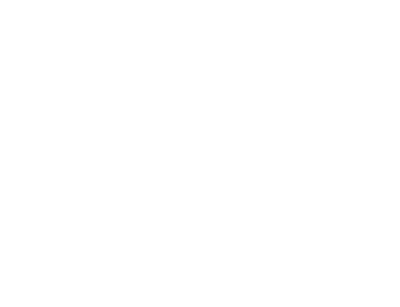

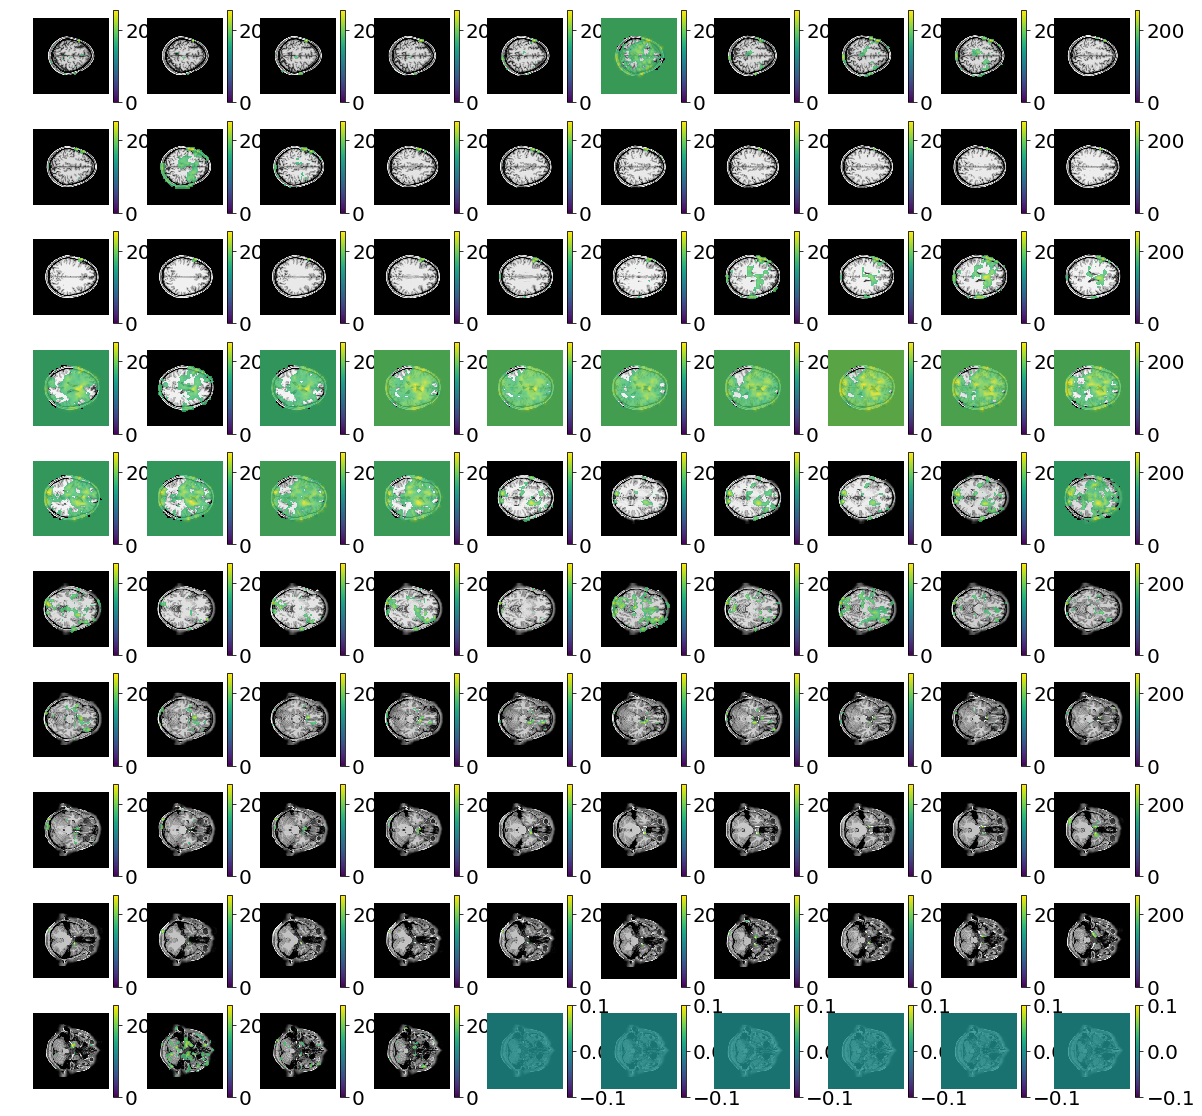

In [320]:
main()

/gpfs/data/cbi/hcp/hcp_seg/mlhc/3Dmodelbijuinoneoutputgradclipwithtorchnogradnodropoutonlypreptargetsmallnetworkwithbnormsample
[]
[]
image shape 1: torch.Size([1, 110, 256, 256])
torch.Size([110, 32, 32])
i0 j0 l0
i0 j0 l8
i0 j0 l16
i0 j0 l24
i0 j0 l32
i0 j0 l40
i0 j0 l48
i0 j0 l56
i0 j0 l64
i0 j0 l72
i0 j0 l80
i0 j0 l88
i0 j0 l96
i0 j0 l104
i0 j0 l112
i0 j0 l120
i0 j0 l128
i0 j0 l136
i0 j0 l144
i0 j0 l152
i0 j0 l160
i0 j0 l168
i0 j0 l176
i0 j0 l184
i0 j0 l192
i0 j0 l200
i0 j0 l208
i0 j0 l216
i0 j0 l224
i0 j0 l232
i0 j0 l240
i0 j0 l248
i0 j8 l0
i0 j8 l8
i0 j8 l16
i0 j8 l24
i0 j8 l32
i0 j8 l40
i0 j8 l48
i0 j8 l56
i0 j8 l64
i0 j8 l72
i0 j8 l80
i0 j8 l88
i0 j8 l96
i0 j8 l104
i0 j8 l112
i0 j8 l120
i0 j8 l128
i0 j8 l136
i0 j8 l144
i0 j8 l152
i0 j8 l160
i0 j8 l168
i0 j8 l176
i0 j8 l184
i0 j8 l192
i0 j8 l200
i0 j8 l208
i0 j8 l216
i0 j8 l224
i0 j8 l232
i0 j8 l240
i0 j8 l248
i0 j16 l0
i0 j16 l8
i0 j16 l16
i0 j16 l24
i0 j16 l32
i0 j16 l40
i0 j16 l48
i0 j16 l56
i0 j16 l64
i0 j16 l72
i0 j16 l80
i

i0 j168 l40
i0 j168 l48
i0 j168 l56
i0 j168 l64
i0 j168 l72
i0 j168 l80
i0 j168 l88
i0 j168 l96
i0 j168 l104
i0 j168 l112
i0 j168 l120
i0 j168 l128
i0 j168 l136
i0 j168 l144
i0 j168 l152
i0 j168 l160
i0 j168 l168
i0 j168 l176
i0 j168 l184
i0 j168 l192
i0 j168 l200
i0 j168 l208
i0 j168 l216
i0 j168 l224
i0 j168 l232
i0 j168 l240
i0 j168 l248
i0 j176 l0
i0 j176 l8
i0 j176 l16
i0 j176 l24
i0 j176 l32
i0 j176 l40
i0 j176 l48
i0 j176 l56
i0 j176 l64
i0 j176 l72
i0 j176 l80
i0 j176 l88
i0 j176 l96
i0 j176 l104
i0 j176 l112
i0 j176 l120
i0 j176 l128
i0 j176 l136
i0 j176 l144
i0 j176 l152
i0 j176 l160
i0 j176 l168
i0 j176 l176
i0 j176 l184
i0 j176 l192
i0 j176 l200
i0 j176 l208
i0 j176 l216
i0 j176 l224
i0 j176 l232
i0 j176 l240
i0 j176 l248
i0 j184 l0
i0 j184 l8
i0 j184 l16
i0 j184 l24
i0 j184 l32
i0 j184 l40
i0 j184 l48
i0 j184 l56
i0 j184 l64
i0 j184 l72
i0 j184 l80
i0 j184 l88
i0 j184 l96
i0 j184 l104
i0 j184 l112
i0 j184 l120
i0 j184 l128
i0 j184 l136
i0 j184 l144
i0 j184 l152
i0 j184 l16

i1 j80 l176
i1 j80 l184
i1 j80 l192
i1 j80 l200
i1 j80 l208
i1 j80 l216
i1 j80 l224
i1 j80 l232
i1 j80 l240
i1 j80 l248
i1 j88 l0
i1 j88 l8
i1 j88 l16
i1 j88 l24
i1 j88 l32
i1 j88 l40
i1 j88 l48
i1 j88 l56
i1 j88 l64
i1 j88 l72
i1 j88 l80
i1 j88 l88
i1 j88 l96
i1 j88 l104
i1 j88 l112
i1 j88 l120
i1 j88 l128
i1 j88 l136
i1 j88 l144
i1 j88 l152
i1 j88 l160
i1 j88 l168
i1 j88 l176
i1 j88 l184
i1 j88 l192
i1 j88 l200
i1 j88 l208
i1 j88 l216
i1 j88 l224
i1 j88 l232
i1 j88 l240
i1 j88 l248
i1 j96 l0
i1 j96 l8
i1 j96 l16
i1 j96 l24
i1 j96 l32
i1 j96 l40
i1 j96 l48
i1 j96 l56
i1 j96 l64
i1 j96 l72
i1 j96 l80
i1 j96 l88
i1 j96 l96
i1 j96 l104
i1 j96 l112
i1 j96 l120
i1 j96 l128
i1 j96 l136
i1 j96 l144
i1 j96 l152
i1 j96 l160
i1 j96 l168
i1 j96 l176
i1 j96 l184
i1 j96 l192
i1 j96 l200
i1 j96 l208
i1 j96 l216
i1 j96 l224
i1 j96 l232
i1 j96 l240
i1 j96 l248
i1 j104 l0
i1 j104 l8
i1 j104 l16
i1 j104 l24
i1 j104 l32
i1 j104 l40
i1 j104 l48
i1 j104 l56
i1 j104 l64
i1 j104 l72
i1 j104 l80
i1 j104 l88


i1 j248 l80
i1 j248 l88
i1 j248 l96
i1 j248 l104
i1 j248 l112
i1 j248 l120
i1 j248 l128
i1 j248 l136
i1 j248 l144
i1 j248 l152
i1 j248 l160
i1 j248 l168
i1 j248 l176
i1 j248 l184
i1 j248 l192
i1 j248 l200
i1 j248 l208
i1 j248 l216
i1 j248 l224
i1 j248 l232
i1 j248 l240
i1 j248 l248
i2 j0 l0
i2 j0 l8
i2 j0 l16
i2 j0 l24
i2 j0 l32
i2 j0 l40
i2 j0 l48
i2 j0 l56
i2 j0 l64
i2 j0 l72
i2 j0 l80
i2 j0 l88
i2 j0 l96
i2 j0 l104
i2 j0 l112
i2 j0 l120
i2 j0 l128
i2 j0 l136
i2 j0 l144
i2 j0 l152
i2 j0 l160
i2 j0 l168
i2 j0 l176
i2 j0 l184
i2 j0 l192
i2 j0 l200
i2 j0 l208
i2 j0 l216
i2 j0 l224
i2 j0 l232
i2 j0 l240
i2 j0 l248
i2 j8 l0
i2 j8 l8
i2 j8 l16
i2 j8 l24
i2 j8 l32
i2 j8 l40
i2 j8 l48
i2 j8 l56
i2 j8 l64
i2 j8 l72
i2 j8 l80
i2 j8 l88
i2 j8 l96
i2 j8 l104
i2 j8 l112
i2 j8 l120
i2 j8 l128
i2 j8 l136
i2 j8 l144
i2 j8 l152
i2 j8 l160
i2 j8 l168
i2 j8 l176
i2 j8 l184
i2 j8 l192
i2 j8 l200
i2 j8 l208
i2 j8 l216
i2 j8 l224
i2 j8 l232
i2 j8 l240
i2 j8 l248
i2 j16 l0
i2 j16 l8
i2 j16 l16
i2 j16 l24
i

i2 j168 l8
i2 j168 l16
i2 j168 l24
i2 j168 l32
i2 j168 l40
i2 j168 l48
i2 j168 l56
i2 j168 l64
i2 j168 l72
i2 j168 l80
i2 j168 l88
i2 j168 l96
i2 j168 l104
i2 j168 l112
i2 j168 l120
i2 j168 l128
i2 j168 l136
i2 j168 l144
i2 j168 l152
i2 j168 l160
i2 j168 l168
i2 j168 l176
i2 j168 l184
i2 j168 l192
i2 j168 l200
i2 j168 l208
i2 j168 l216
i2 j168 l224
i2 j168 l232
i2 j168 l240
i2 j168 l248
i2 j176 l0
i2 j176 l8
i2 j176 l16
i2 j176 l24
i2 j176 l32
i2 j176 l40
i2 j176 l48
i2 j176 l56
i2 j176 l64
i2 j176 l72
i2 j176 l80
i2 j176 l88
i2 j176 l96
i2 j176 l104
i2 j176 l112
i2 j176 l120
i2 j176 l128
i2 j176 l136
i2 j176 l144
i2 j176 l152
i2 j176 l160
i2 j176 l168
i2 j176 l176
i2 j176 l184
i2 j176 l192
i2 j176 l200
i2 j176 l208
i2 j176 l216
i2 j176 l224
i2 j176 l232
i2 j176 l240
i2 j176 l248
i2 j184 l0
i2 j184 l8
i2 j184 l16
i2 j184 l24
i2 j184 l32
i2 j184 l40
i2 j184 l48
i2 j184 l56
i2 j184 l64
i2 j184 l72
i2 j184 l80
i2 j184 l88
i2 j184 l96
i2 j184 l104
i2 j184 l112
i2 j184 l120
i2 j184 l128
i2 

i3 j80 l152
i3 j80 l160
i3 j80 l168
i3 j80 l176
i3 j80 l184
i3 j80 l192
i3 j80 l200
i3 j80 l208
i3 j80 l216
i3 j80 l224
i3 j80 l232
i3 j80 l240
i3 j80 l248
i3 j88 l0
i3 j88 l8
i3 j88 l16
i3 j88 l24
i3 j88 l32
i3 j88 l40
i3 j88 l48
i3 j88 l56
i3 j88 l64
i3 j88 l72
i3 j88 l80
i3 j88 l88
i3 j88 l96
i3 j88 l104
i3 j88 l112
i3 j88 l120
i3 j88 l128
i3 j88 l136
i3 j88 l144
i3 j88 l152
i3 j88 l160
i3 j88 l168
i3 j88 l176
i3 j88 l184
i3 j88 l192
i3 j88 l200
i3 j88 l208
i3 j88 l216
i3 j88 l224
i3 j88 l232
i3 j88 l240
i3 j88 l248
i3 j96 l0
i3 j96 l8
i3 j96 l16
i3 j96 l24
i3 j96 l32
i3 j96 l40
i3 j96 l48
i3 j96 l56
i3 j96 l64
i3 j96 l72
i3 j96 l80
i3 j96 l88
i3 j96 l96
i3 j96 l104
i3 j96 l112
i3 j96 l120
i3 j96 l128
i3 j96 l136
i3 j96 l144
i3 j96 l152
i3 j96 l160
i3 j96 l168
i3 j96 l176
i3 j96 l184
i3 j96 l192
i3 j96 l200
i3 j96 l208
i3 j96 l216
i3 j96 l224
i3 j96 l232
i3 j96 l240
i3 j96 l248
i3 j104 l0
i3 j104 l8
i3 j104 l16
i3 j104 l24
i3 j104 l32
i3 j104 l40
i3 j104 l48
i3 j104 l56
i3 j104 l64


i3 j248 l64
i3 j248 l72
i3 j248 l80
i3 j248 l88
i3 j248 l96
i3 j248 l104
i3 j248 l112
i3 j248 l120
i3 j248 l128
i3 j248 l136
i3 j248 l144
i3 j248 l152
i3 j248 l160
i3 j248 l168
i3 j248 l176
i3 j248 l184
i3 j248 l192
i3 j248 l200
i3 j248 l208
i3 j248 l216
i3 j248 l224
i3 j248 l232
i3 j248 l240
i3 j248 l248
i4 j0 l0
i4 j0 l8
i4 j0 l16
i4 j0 l24
i4 j0 l32
i4 j0 l40
i4 j0 l48
i4 j0 l56
i4 j0 l64
i4 j0 l72
i4 j0 l80
i4 j0 l88
i4 j0 l96
i4 j0 l104
i4 j0 l112
i4 j0 l120
i4 j0 l128
i4 j0 l136
i4 j0 l144
i4 j0 l152
i4 j0 l160
i4 j0 l168
i4 j0 l176
i4 j0 l184
i4 j0 l192
i4 j0 l200
i4 j0 l208
i4 j0 l216
i4 j0 l224
i4 j0 l232
i4 j0 l240
i4 j0 l248
i4 j8 l0
i4 j8 l8
i4 j8 l16
i4 j8 l24
i4 j8 l32
i4 j8 l40
i4 j8 l48
i4 j8 l56
i4 j8 l64
i4 j8 l72
i4 j8 l80
i4 j8 l88
i4 j8 l96
i4 j8 l104
i4 j8 l112
i4 j8 l120
i4 j8 l128
i4 j8 l136
i4 j8 l144
i4 j8 l152
i4 j8 l160
i4 j8 l168
i4 j8 l176
i4 j8 l184
i4 j8 l192
i4 j8 l200
i4 j8 l208
i4 j8 l216
i4 j8 l224
i4 j8 l232
i4 j8 l240
i4 j8 l248
i4 j16 l0
i4 j16 l8

i4 j160 l232
i4 j160 l240
i4 j160 l248
i4 j168 l0
i4 j168 l8
i4 j168 l16
i4 j168 l24
i4 j168 l32
i4 j168 l40
i4 j168 l48
i4 j168 l56
i4 j168 l64
i4 j168 l72
i4 j168 l80
i4 j168 l88
i4 j168 l96
i4 j168 l104
i4 j168 l112
i4 j168 l120
i4 j168 l128
i4 j168 l136
i4 j168 l144
i4 j168 l152
i4 j168 l160
i4 j168 l168
i4 j168 l176
i4 j168 l184
i4 j168 l192
i4 j168 l200
i4 j168 l208
i4 j168 l216
i4 j168 l224
i4 j168 l232
i4 j168 l240
i4 j168 l248
i4 j176 l0
i4 j176 l8
i4 j176 l16
i4 j176 l24
i4 j176 l32
i4 j176 l40
i4 j176 l48
i4 j176 l56
i4 j176 l64
i4 j176 l72
i4 j176 l80
i4 j176 l88
i4 j176 l96
i4 j176 l104
i4 j176 l112
i4 j176 l120
i4 j176 l128
i4 j176 l136
i4 j176 l144
i4 j176 l152
i4 j176 l160
i4 j176 l168
i4 j176 l176
i4 j176 l184
i4 j176 l192
i4 j176 l200
i4 j176 l208
i4 j176 l216
i4 j176 l224
i4 j176 l232
i4 j176 l240
i4 j176 l248
i4 j184 l0
i4 j184 l8
i4 j184 l16
i4 j184 l24
i4 j184 l32
i4 j184 l40
i4 j184 l48
i4 j184 l56
i4 j184 l64
i4 j184 l72
i4 j184 l80
i4 j184 l88
i4 j184 l96
i4 j1

i5 j80 l96
i5 j80 l104
i5 j80 l112
i5 j80 l120
i5 j80 l128
i5 j80 l136
i5 j80 l144
i5 j80 l152
i5 j80 l160
i5 j80 l168
i5 j80 l176
i5 j80 l184
i5 j80 l192
i5 j80 l200
i5 j80 l208
i5 j80 l216
i5 j80 l224
i5 j80 l232
i5 j80 l240
i5 j80 l248
i5 j88 l0
i5 j88 l8
i5 j88 l16
i5 j88 l24
i5 j88 l32
i5 j88 l40
i5 j88 l48
i5 j88 l56
i5 j88 l64
i5 j88 l72
i5 j88 l80
i5 j88 l88
i5 j88 l96
i5 j88 l104
i5 j88 l112
i5 j88 l120
i5 j88 l128
i5 j88 l136
i5 j88 l144
i5 j88 l152
i5 j88 l160
i5 j88 l168
i5 j88 l176
i5 j88 l184
i5 j88 l192
i5 j88 l200
i5 j88 l208
i5 j88 l216
i5 j88 l224
i5 j88 l232
i5 j88 l240
i5 j88 l248
i5 j96 l0
i5 j96 l8
i5 j96 l16
i5 j96 l24
i5 j96 l32
i5 j96 l40
i5 j96 l48
i5 j96 l56
i5 j96 l64
i5 j96 l72
i5 j96 l80
i5 j96 l88
i5 j96 l96
i5 j96 l104
i5 j96 l112
i5 j96 l120
i5 j96 l128
i5 j96 l136
i5 j96 l144
i5 j96 l152
i5 j96 l160
i5 j96 l168
i5 j96 l176
i5 j96 l184
i5 j96 l192
i5 j96 l200
i5 j96 l208
i5 j96 l216
i5 j96 l224
i5 j96 l232
i5 j96 l240
i5 j96 l248
i5 j104 l0
i5 j104 l8
i

i5 j248 l40
i5 j248 l48
i5 j248 l56
i5 j248 l64
i5 j248 l72
i5 j248 l80
i5 j248 l88
i5 j248 l96
i5 j248 l104
i5 j248 l112
i5 j248 l120
i5 j248 l128
i5 j248 l136
i5 j248 l144
i5 j248 l152
i5 j248 l160
i5 j248 l168
i5 j248 l176
i5 j248 l184
i5 j248 l192
i5 j248 l200
i5 j248 l208
i5 j248 l216
i5 j248 l224
i5 j248 l232
i5 j248 l240
i5 j248 l248
i6 j0 l0
i6 j0 l8
i6 j0 l16
i6 j0 l24
i6 j0 l32
i6 j0 l40
i6 j0 l48
i6 j0 l56
i6 j0 l64
i6 j0 l72
i6 j0 l80
i6 j0 l88
i6 j0 l96
i6 j0 l104
i6 j0 l112
i6 j0 l120
i6 j0 l128
i6 j0 l136
i6 j0 l144
i6 j0 l152
i6 j0 l160
i6 j0 l168
i6 j0 l176
i6 j0 l184
i6 j0 l192
i6 j0 l200
i6 j0 l208
i6 j0 l216
i6 j0 l224
i6 j0 l232
i6 j0 l240
i6 j0 l248
i6 j8 l0
i6 j8 l8
i6 j8 l16
i6 j8 l24
i6 j8 l32
i6 j8 l40
i6 j8 l48
i6 j8 l56
i6 j8 l64
i6 j8 l72
i6 j8 l80
i6 j8 l88
i6 j8 l96
i6 j8 l104
i6 j8 l112
i6 j8 l120
i6 j8 l128
i6 j8 l136
i6 j8 l144
i6 j8 l152
i6 j8 l160
i6 j8 l168
i6 j8 l176
i6 j8 l184
i6 j8 l192
i6 j8 l200
i6 j8 l208
i6 j8 l216
i6 j8 l224
i6 j8 l232
i6 j8

i6 j160 l200
i6 j160 l208
i6 j160 l216
i6 j160 l224
i6 j160 l232
i6 j160 l240
i6 j160 l248
i6 j168 l0
i6 j168 l8
i6 j168 l16
i6 j168 l24
i6 j168 l32
i6 j168 l40
i6 j168 l48
i6 j168 l56
i6 j168 l64
i6 j168 l72
i6 j168 l80
i6 j168 l88
i6 j168 l96
i6 j168 l104
i6 j168 l112
i6 j168 l120
i6 j168 l128
i6 j168 l136
i6 j168 l144
i6 j168 l152
i6 j168 l160
i6 j168 l168
i6 j168 l176
i6 j168 l184
i6 j168 l192
i6 j168 l200
i6 j168 l208
i6 j168 l216
i6 j168 l224
i6 j168 l232
i6 j168 l240
i6 j168 l248
i6 j176 l0
i6 j176 l8
i6 j176 l16
i6 j176 l24
i6 j176 l32
i6 j176 l40
i6 j176 l48
i6 j176 l56
i6 j176 l64
i6 j176 l72
i6 j176 l80
i6 j176 l88
i6 j176 l96
i6 j176 l104
i6 j176 l112
i6 j176 l120
i6 j176 l128
i6 j176 l136
i6 j176 l144
i6 j176 l152
i6 j176 l160
i6 j176 l168
i6 j176 l176
i6 j176 l184
i6 j176 l192
i6 j176 l200
i6 j176 l208
i6 j176 l216
i6 j176 l224
i6 j176 l232
i6 j176 l240
i6 j176 l248
i6 j184 l0
i6 j184 l8
i6 j184 l16
i6 j184 l24
i6 j184 l32
i6 j184 l40
i6 j184 l48
i6 j184 l56
i6 j184 l64
i

i7 j80 l80
i7 j80 l88
i7 j80 l96
i7 j80 l104
i7 j80 l112
i7 j80 l120
i7 j80 l128
i7 j80 l136
i7 j80 l144
i7 j80 l152
i7 j80 l160
i7 j80 l168
i7 j80 l176
i7 j80 l184
i7 j80 l192
i7 j80 l200
i7 j80 l208
i7 j80 l216
i7 j80 l224
i7 j80 l232
i7 j80 l240
i7 j80 l248
i7 j88 l0
i7 j88 l8
i7 j88 l16
i7 j88 l24
i7 j88 l32
i7 j88 l40
i7 j88 l48
i7 j88 l56
i7 j88 l64
i7 j88 l72
i7 j88 l80
i7 j88 l88
i7 j88 l96
i7 j88 l104
i7 j88 l112
i7 j88 l120
i7 j88 l128
i7 j88 l136
i7 j88 l144
i7 j88 l152
i7 j88 l160
i7 j88 l168
i7 j88 l176
i7 j88 l184
i7 j88 l192
i7 j88 l200
i7 j88 l208
i7 j88 l216
i7 j88 l224
i7 j88 l232
i7 j88 l240
i7 j88 l248
i7 j96 l0
i7 j96 l8
i7 j96 l16
i7 j96 l24
i7 j96 l32
i7 j96 l40
i7 j96 l48
i7 j96 l56
i7 j96 l64
i7 j96 l72
i7 j96 l80
i7 j96 l88
i7 j96 l96
i7 j96 l104
i7 j96 l112
i7 j96 l120
i7 j96 l128
i7 j96 l136
i7 j96 l144
i7 j96 l152
i7 j96 l160
i7 j96 l168
i7 j96 l176
i7 j96 l184
i7 j96 l192
i7 j96 l200
i7 j96 l208
i7 j96 l216
i7 j96 l224
i7 j96 l232
i7 j96 l240
i7 j96 l248
i

i7 j248 l0
i7 j248 l8
i7 j248 l16
i7 j248 l24
i7 j248 l32
i7 j248 l40
i7 j248 l48
i7 j248 l56
i7 j248 l64
i7 j248 l72
i7 j248 l80
i7 j248 l88
i7 j248 l96
i7 j248 l104
i7 j248 l112
i7 j248 l120
i7 j248 l128
i7 j248 l136
i7 j248 l144
i7 j248 l152
i7 j248 l160
i7 j248 l168
i7 j248 l176
i7 j248 l184
i7 j248 l192
i7 j248 l200
i7 j248 l208
i7 j248 l216
i7 j248 l224
i7 j248 l232
i7 j248 l240
i7 j248 l248
i8 j0 l0
i8 j0 l8
i8 j0 l16
i8 j0 l24
i8 j0 l32
i8 j0 l40
i8 j0 l48
i8 j0 l56
i8 j0 l64
i8 j0 l72
i8 j0 l80
i8 j0 l88
i8 j0 l96
i8 j0 l104
i8 j0 l112
i8 j0 l120
i8 j0 l128
i8 j0 l136
i8 j0 l144
i8 j0 l152
i8 j0 l160
i8 j0 l168
i8 j0 l176
i8 j0 l184
i8 j0 l192
i8 j0 l200
i8 j0 l208
i8 j0 l216
i8 j0 l224
i8 j0 l232
i8 j0 l240
i8 j0 l248
i8 j8 l0
i8 j8 l8
i8 j8 l16
i8 j8 l24
i8 j8 l32
i8 j8 l40
i8 j8 l48
i8 j8 l56
i8 j8 l64
i8 j8 l72
i8 j8 l80
i8 j8 l88
i8 j8 l96
i8 j8 l104
i8 j8 l112
i8 j8 l120
i8 j8 l128
i8 j8 l136
i8 j8 l144
i8 j8 l152
i8 j8 l160
i8 j8 l168
i8 j8 l176
i8 j8 l184
i8 j8 l192
i8

i8 j160 l184
i8 j160 l192
i8 j160 l200
i8 j160 l208
i8 j160 l216
i8 j160 l224
i8 j160 l232
i8 j160 l240
i8 j160 l248
i8 j168 l0
i8 j168 l8
i8 j168 l16
i8 j168 l24
i8 j168 l32
i8 j168 l40
i8 j168 l48
i8 j168 l56
i8 j168 l64
i8 j168 l72
i8 j168 l80
i8 j168 l88
i8 j168 l96
i8 j168 l104
i8 j168 l112
i8 j168 l120
i8 j168 l128
i8 j168 l136
i8 j168 l144
i8 j168 l152
i8 j168 l160
i8 j168 l168
i8 j168 l176
i8 j168 l184
i8 j168 l192
i8 j168 l200
i8 j168 l208
i8 j168 l216
i8 j168 l224
i8 j168 l232
i8 j168 l240
i8 j168 l248
i8 j176 l0
i8 j176 l8
i8 j176 l16
i8 j176 l24
i8 j176 l32
i8 j176 l40
i8 j176 l48
i8 j176 l56
i8 j176 l64
i8 j176 l72
i8 j176 l80
i8 j176 l88
i8 j176 l96
i8 j176 l104
i8 j176 l112
i8 j176 l120
i8 j176 l128
i8 j176 l136
i8 j176 l144
i8 j176 l152
i8 j176 l160
i8 j176 l168
i8 j176 l176
i8 j176 l184
i8 j176 l192
i8 j176 l200
i8 j176 l208
i8 j176 l216
i8 j176 l224
i8 j176 l232
i8 j176 l240
i8 j176 l248
i8 j184 l0
i8 j184 l8
i8 j184 l16
i8 j184 l24
i8 j184 l32
i8 j184 l40
i8 j184 l48

i9 j80 l56
i9 j80 l64
i9 j80 l72
i9 j80 l80
i9 j80 l88
i9 j80 l96
i9 j80 l104
i9 j80 l112
i9 j80 l120
i9 j80 l128
i9 j80 l136
i9 j80 l144
i9 j80 l152
i9 j80 l160
i9 j80 l168
i9 j80 l176
i9 j80 l184
i9 j80 l192
i9 j80 l200
i9 j80 l208
i9 j80 l216
i9 j80 l224
i9 j80 l232
i9 j80 l240
i9 j80 l248
i9 j88 l0
i9 j88 l8
i9 j88 l16
i9 j88 l24
i9 j88 l32
i9 j88 l40
i9 j88 l48
i9 j88 l56
i9 j88 l64
i9 j88 l72
i9 j88 l80
i9 j88 l88
i9 j88 l96
i9 j88 l104
i9 j88 l112
i9 j88 l120
i9 j88 l128
i9 j88 l136
i9 j88 l144
i9 j88 l152
i9 j88 l160
i9 j88 l168
i9 j88 l176
i9 j88 l184
i9 j88 l192
i9 j88 l200
i9 j88 l208
i9 j88 l216
i9 j88 l224
i9 j88 l232
i9 j88 l240
i9 j88 l248
i9 j96 l0
i9 j96 l8
i9 j96 l16
i9 j96 l24
i9 j96 l32
i9 j96 l40
i9 j96 l48
i9 j96 l56
i9 j96 l64
i9 j96 l72
i9 j96 l80
i9 j96 l88
i9 j96 l96
i9 j96 l104
i9 j96 l112
i9 j96 l120
i9 j96 l128
i9 j96 l136
i9 j96 l144
i9 j96 l152
i9 j96 l160
i9 j96 l168
i9 j96 l176
i9 j96 l184
i9 j96 l192
i9 j96 l200
i9 j96 l208
i9 j96 l216
i9 j96 l224
i9 j

i9 j240 l224
i9 j240 l232
i9 j240 l240
i9 j240 l248
i9 j248 l0
i9 j248 l8
i9 j248 l16
i9 j248 l24
i9 j248 l32
i9 j248 l40
i9 j248 l48
i9 j248 l56
i9 j248 l64
i9 j248 l72
i9 j248 l80
i9 j248 l88
i9 j248 l96
i9 j248 l104
i9 j248 l112
i9 j248 l120
i9 j248 l128
i9 j248 l136
i9 j248 l144
i9 j248 l152
i9 j248 l160
i9 j248 l168
i9 j248 l176
i9 j248 l184
i9 j248 l192
i9 j248 l200
i9 j248 l208
i9 j248 l216
i9 j248 l224
i9 j248 l232
i9 j248 l240
i9 j248 l248
i10 j0 l0
i10 j0 l8
i10 j0 l16
i10 j0 l24
i10 j0 l32
i10 j0 l40
i10 j0 l48
i10 j0 l56
i10 j0 l64
i10 j0 l72
i10 j0 l80
i10 j0 l88
i10 j0 l96
i10 j0 l104
i10 j0 l112
i10 j0 l120
i10 j0 l128
i10 j0 l136
i10 j0 l144
i10 j0 l152
i10 j0 l160
i10 j0 l168
i10 j0 l176
i10 j0 l184
i10 j0 l192
i10 j0 l200
i10 j0 l208
i10 j0 l216
i10 j0 l224
i10 j0 l232
i10 j0 l240
i10 j0 l248
i10 j8 l0
i10 j8 l8
i10 j8 l16
i10 j8 l24
i10 j8 l32
i10 j8 l40
i10 j8 l48
i10 j8 l56
i10 j8 l64
i10 j8 l72
i10 j8 l80
i10 j8 l88
i10 j8 l96
i10 j8 l104
i10 j8 l112
i10 j8 l120
i

i10 j152 l8
i10 j152 l16
i10 j152 l24
i10 j152 l32
i10 j152 l40
i10 j152 l48
i10 j152 l56
i10 j152 l64
i10 j152 l72
i10 j152 l80
i10 j152 l88
i10 j152 l96
i10 j152 l104
i10 j152 l112
i10 j152 l120
i10 j152 l128
i10 j152 l136
i10 j152 l144
i10 j152 l152
i10 j152 l160
i10 j152 l168
i10 j152 l176
i10 j152 l184
i10 j152 l192
i10 j152 l200
i10 j152 l208
i10 j152 l216
i10 j152 l224
i10 j152 l232
i10 j152 l240
i10 j152 l248
i10 j160 l0
i10 j160 l8
i10 j160 l16
i10 j160 l24
i10 j160 l32
i10 j160 l40
i10 j160 l48
i10 j160 l56
i10 j160 l64
i10 j160 l72
i10 j160 l80
i10 j160 l88
i10 j160 l96
i10 j160 l104
i10 j160 l112
i10 j160 l120
i10 j160 l128
i10 j160 l136
i10 j160 l144
i10 j160 l152
i10 j160 l160
i10 j160 l168
i10 j160 l176
i10 j160 l184
i10 j160 l192
i10 j160 l200
i10 j160 l208
i10 j160 l216
i10 j160 l224
i10 j160 l232
i10 j160 l240
i10 j160 l248
i10 j168 l0
i10 j168 l8
i10 j168 l16
i10 j168 l24
i10 j168 l32
i10 j168 l40
i10 j168 l48
i10 j168 l56
i10 j168 l64
i10 j168 l72
i10 j168 l80
i10 j

i11 j48 l184
i11 j48 l192
i11 j48 l200
i11 j48 l208
i11 j48 l216
i11 j48 l224
i11 j48 l232
i11 j48 l240
i11 j48 l248
i11 j56 l0
i11 j56 l8
i11 j56 l16
i11 j56 l24
i11 j56 l32
i11 j56 l40
i11 j56 l48
i11 j56 l56
i11 j56 l64
i11 j56 l72
i11 j56 l80
i11 j56 l88
i11 j56 l96
i11 j56 l104
i11 j56 l112
i11 j56 l120
i11 j56 l128
i11 j56 l136
i11 j56 l144
i11 j56 l152
i11 j56 l160
i11 j56 l168
i11 j56 l176
i11 j56 l184
i11 j56 l192
i11 j56 l200
i11 j56 l208
i11 j56 l216
i11 j56 l224
i11 j56 l232
i11 j56 l240
i11 j56 l248
i11 j64 l0
i11 j64 l8
i11 j64 l16
i11 j64 l24
i11 j64 l32
i11 j64 l40
i11 j64 l48
i11 j64 l56
i11 j64 l64
i11 j64 l72
i11 j64 l80
i11 j64 l88
i11 j64 l96
i11 j64 l104
i11 j64 l112
i11 j64 l120
i11 j64 l128
i11 j64 l136
i11 j64 l144
i11 j64 l152
i11 j64 l160
i11 j64 l168
i11 j64 l176
i11 j64 l184
i11 j64 l192
i11 j64 l200
i11 j64 l208
i11 j64 l216
i11 j64 l224
i11 j64 l232
i11 j64 l240
i11 j64 l248
i11 j72 l0
i11 j72 l8
i11 j72 l16
i11 j72 l24
i11 j72 l32
i11 j72 l40
i11 j72 l48

i11 j208 l56
i11 j208 l64
i11 j208 l72
i11 j208 l80
i11 j208 l88
i11 j208 l96
i11 j208 l104
i11 j208 l112
i11 j208 l120
i11 j208 l128
i11 j208 l136
i11 j208 l144
i11 j208 l152
i11 j208 l160
i11 j208 l168
i11 j208 l176
i11 j208 l184
i11 j208 l192
i11 j208 l200
i11 j208 l208
i11 j208 l216
i11 j208 l224
i11 j208 l232
i11 j208 l240
i11 j208 l248
i11 j216 l0
i11 j216 l8
i11 j216 l16
i11 j216 l24
i11 j216 l32
i11 j216 l40
i11 j216 l48
i11 j216 l56
i11 j216 l64
i11 j216 l72
i11 j216 l80
i11 j216 l88
i11 j216 l96
i11 j216 l104
i11 j216 l112
i11 j216 l120
i11 j216 l128
i11 j216 l136
i11 j216 l144
i11 j216 l152
i11 j216 l160
i11 j216 l168
i11 j216 l176
i11 j216 l184
i11 j216 l192
i11 j216 l200
i11 j216 l208
i11 j216 l216
i11 j216 l224
i11 j216 l232
i11 j216 l240
i11 j216 l248
i11 j224 l0
i11 j224 l8
i11 j224 l16
i11 j224 l24
i11 j224 l32
i11 j224 l40
i11 j224 l48
i11 j224 l56
i11 j224 l64
i11 j224 l72
i11 j224 l80
i11 j224 l88
i11 j224 l96
i11 j224 l104
i11 j224 l112
i11 j224 l120
i11 j224 l128


i12 j112 l64
i12 j112 l72
i12 j112 l80
i12 j112 l88
i12 j112 l96
i12 j112 l104
i12 j112 l112
i12 j112 l120
i12 j112 l128
i12 j112 l136
i12 j112 l144
i12 j112 l152
i12 j112 l160
i12 j112 l168
i12 j112 l176
i12 j112 l184
i12 j112 l192
i12 j112 l200
i12 j112 l208
i12 j112 l216
i12 j112 l224
i12 j112 l232
i12 j112 l240
i12 j112 l248
i12 j120 l0
i12 j120 l8
i12 j120 l16
i12 j120 l24
i12 j120 l32
i12 j120 l40
i12 j120 l48
i12 j120 l56
i12 j120 l64
i12 j120 l72
i12 j120 l80
i12 j120 l88
i12 j120 l96
i12 j120 l104
i12 j120 l112
i12 j120 l120
i12 j120 l128
i12 j120 l136
i12 j120 l144
i12 j120 l152
i12 j120 l160
i12 j120 l168
i12 j120 l176
i12 j120 l184
i12 j120 l192
i12 j120 l200
i12 j120 l208
i12 j120 l216
i12 j120 l224
i12 j120 l232
i12 j120 l240
i12 j120 l248
i12 j128 l0
i12 j128 l8
i12 j128 l16
i12 j128 l24
i12 j128 l32
i12 j128 l40
i12 j128 l48
i12 j128 l56
i12 j128 l64
i12 j128 l72
i12 j128 l80
i12 j128 l88
i12 j128 l96
i12 j128 l104
i12 j128 l112
i12 j128 l120
i12 j128 l128
i12 j128 l136

i13 j8 l120
i13 j8 l128
i13 j8 l136
i13 j8 l144
i13 j8 l152
i13 j8 l160
i13 j8 l168
i13 j8 l176
i13 j8 l184
i13 j8 l192
i13 j8 l200
i13 j8 l208
i13 j8 l216
i13 j8 l224
i13 j8 l232
i13 j8 l240
i13 j8 l248
i13 j16 l0
i13 j16 l8
i13 j16 l16
i13 j16 l24
i13 j16 l32
i13 j16 l40
i13 j16 l48
i13 j16 l56
i13 j16 l64
i13 j16 l72
i13 j16 l80
i13 j16 l88
i13 j16 l96
i13 j16 l104
i13 j16 l112
i13 j16 l120
i13 j16 l128
i13 j16 l136
i13 j16 l144
i13 j16 l152
i13 j16 l160
i13 j16 l168
i13 j16 l176
i13 j16 l184
i13 j16 l192
i13 j16 l200
i13 j16 l208
i13 j16 l216
i13 j16 l224
i13 j16 l232
i13 j16 l240
i13 j16 l248
i13 j24 l0
i13 j24 l8
i13 j24 l16
i13 j24 l24
i13 j24 l32
i13 j24 l40
i13 j24 l48
i13 j24 l56
i13 j24 l64
i13 j24 l72
i13 j24 l80
i13 j24 l88
i13 j24 l96
i13 j24 l104
i13 j24 l112
i13 j24 l120
i13 j24 l128
i13 j24 l136
i13 j24 l144
i13 j24 l152
i13 j24 l160
i13 j24 l168
i13 j24 l176
i13 j24 l184
i13 j24 l192
i13 j24 l200
i13 j24 l208
i13 j24 l216
i13 j24 l224
i13 j24 l232
i13 j24 l240
i13 j24

i13 j168 l72
i13 j168 l80
i13 j168 l88
i13 j168 l96
i13 j168 l104
i13 j168 l112
i13 j168 l120
i13 j168 l128
i13 j168 l136
i13 j168 l144
i13 j168 l152
i13 j168 l160
i13 j168 l168
i13 j168 l176
i13 j168 l184
i13 j168 l192
i13 j168 l200
i13 j168 l208
i13 j168 l216
i13 j168 l224
i13 j168 l232
i13 j168 l240
i13 j168 l248
i13 j176 l0
i13 j176 l8
i13 j176 l16
i13 j176 l24
i13 j176 l32
i13 j176 l40
i13 j176 l48
i13 j176 l56
i13 j176 l64
i13 j176 l72
i13 j176 l80
i13 j176 l88
i13 j176 l96
i13 j176 l104
i13 j176 l112
i13 j176 l120
i13 j176 l128
i13 j176 l136
i13 j176 l144
i13 j176 l152
i13 j176 l160
i13 j176 l168
i13 j176 l176
i13 j176 l184
i13 j176 l192
i13 j176 l200
i13 j176 l208
i13 j176 l216
i13 j176 l224
i13 j176 l232
i13 j176 l240
i13 j176 l248
i13 j184 l0
i13 j184 l8
i13 j184 l16
i13 j184 l24
i13 j184 l32
i13 j184 l40
i13 j184 l48
i13 j184 l56
i13 j184 l64
i13 j184 l72
i13 j184 l80
i13 j184 l88
i13 j184 l96
i13 j184 l104
i13 j184 l112
i13 j184 l120
i13 j184 l128
i13 j184 l136
i13 j184 l14

i14 j72 l32
i14 j72 l40
i14 j72 l48
i14 j72 l56
i14 j72 l64
i14 j72 l72
i14 j72 l80
i14 j72 l88
i14 j72 l96
i14 j72 l104
i14 j72 l112
i14 j72 l120
i14 j72 l128
i14 j72 l136
i14 j72 l144
i14 j72 l152
i14 j72 l160
i14 j72 l168
i14 j72 l176
i14 j72 l184
i14 j72 l192
i14 j72 l200
i14 j72 l208
i14 j72 l216
i14 j72 l224
i14 j72 l232
i14 j72 l240
i14 j72 l248
i14 j80 l0
i14 j80 l8
i14 j80 l16
i14 j80 l24
i14 j80 l32
i14 j80 l40
i14 j80 l48
i14 j80 l56
i14 j80 l64
i14 j80 l72
i14 j80 l80
i14 j80 l88
i14 j80 l96
i14 j80 l104
i14 j80 l112
i14 j80 l120
i14 j80 l128
i14 j80 l136
i14 j80 l144
i14 j80 l152
i14 j80 l160
i14 j80 l168
i14 j80 l176
i14 j80 l184
i14 j80 l192
i14 j80 l200
i14 j80 l208
i14 j80 l216
i14 j80 l224
i14 j80 l232
i14 j80 l240
i14 j80 l248
i14 j88 l0
i14 j88 l8
i14 j88 l16
i14 j88 l24
i14 j88 l32
i14 j88 l40
i14 j88 l48
i14 j88 l56
i14 j88 l64
i14 j88 l72
i14 j88 l80
i14 j88 l88
i14 j88 l96
i14 j88 l104
i14 j88 l112
i14 j88 l120
i14 j88 l128
i14 j88 l136
i14 j88 l144
i14 j88 l152

i14 j224 l88
i14 j224 l96
i14 j224 l104
i14 j224 l112
i14 j224 l120
i14 j224 l128
i14 j224 l136
i14 j224 l144
i14 j224 l152
i14 j224 l160
i14 j224 l168
i14 j224 l176
i14 j224 l184
i14 j224 l192
i14 j224 l200
i14 j224 l208
i14 j224 l216
i14 j224 l224
i14 j224 l232
i14 j224 l240
i14 j224 l248
i14 j232 l0
i14 j232 l8
i14 j232 l16
i14 j232 l24
i14 j232 l32
i14 j232 l40
i14 j232 l48
i14 j232 l56
i14 j232 l64
i14 j232 l72
i14 j232 l80
i14 j232 l88
i14 j232 l96
i14 j232 l104
i14 j232 l112
i14 j232 l120
i14 j232 l128
i14 j232 l136
i14 j232 l144
i14 j232 l152
i14 j232 l160
i14 j232 l168
i14 j232 l176
i14 j232 l184
i14 j232 l192
i14 j232 l200
i14 j232 l208
i14 j232 l216
i14 j232 l224
i14 j232 l232
i14 j232 l240
i14 j232 l248
i14 j240 l0
i14 j240 l8
i14 j240 l16
i14 j240 l24
i14 j240 l32
i14 j240 l40
i14 j240 l48
i14 j240 l56
i14 j240 l64
i14 j240 l72
i14 j240 l80
i14 j240 l88
i14 j240 l96
i14 j240 l104
i14 j240 l112
i14 j240 l120
i14 j240 l128
i14 j240 l136
i14 j240 l144
i14 j240 l152
i14 j240 l

i15 j128 l120
i15 j128 l128
i15 j128 l136
i15 j128 l144
i15 j128 l152
i15 j128 l160
i15 j128 l168
i15 j128 l176
i15 j128 l184
i15 j128 l192
i15 j128 l200
i15 j128 l208
i15 j128 l216
i15 j128 l224
i15 j128 l232
i15 j128 l240
i15 j128 l248
i15 j136 l0
i15 j136 l8
i15 j136 l16
i15 j136 l24
i15 j136 l32
i15 j136 l40
i15 j136 l48
i15 j136 l56
i15 j136 l64
i15 j136 l72
i15 j136 l80
i15 j136 l88
i15 j136 l96
i15 j136 l104
i15 j136 l112
i15 j136 l120
i15 j136 l128
i15 j136 l136
i15 j136 l144
i15 j136 l152
i15 j136 l160
i15 j136 l168
i15 j136 l176
i15 j136 l184
i15 j136 l192
i15 j136 l200
i15 j136 l208
i15 j136 l216
i15 j136 l224
i15 j136 l232
i15 j136 l240
i15 j136 l248
i15 j144 l0
i15 j144 l8
i15 j144 l16
i15 j144 l24
i15 j144 l32
i15 j144 l40
i15 j144 l48
i15 j144 l56
i15 j144 l64
i15 j144 l72
i15 j144 l80
i15 j144 l88
i15 j144 l96
i15 j144 l104
i15 j144 l112
i15 j144 l120
i15 j144 l128
i15 j144 l136
i15 j144 l144
i15 j144 l152
i15 j144 l160
i15 j144 l168
i15 j144 l176
i15 j144 l184
i15 j144

i16 j24 l248
i16 j32 l0
i16 j32 l8
i16 j32 l16
i16 j32 l24
i16 j32 l32
i16 j32 l40
i16 j32 l48
i16 j32 l56
i16 j32 l64
i16 j32 l72
i16 j32 l80
i16 j32 l88
i16 j32 l96
i16 j32 l104
i16 j32 l112
i16 j32 l120
i16 j32 l128
i16 j32 l136
i16 j32 l144
i16 j32 l152
i16 j32 l160
i16 j32 l168
i16 j32 l176
i16 j32 l184
i16 j32 l192
i16 j32 l200
i16 j32 l208
i16 j32 l216
i16 j32 l224
i16 j32 l232
i16 j32 l240
i16 j32 l248
i16 j40 l0
i16 j40 l8
i16 j40 l16
i16 j40 l24
i16 j40 l32
i16 j40 l40
i16 j40 l48
i16 j40 l56
i16 j40 l64
i16 j40 l72
i16 j40 l80
i16 j40 l88
i16 j40 l96
i16 j40 l104
i16 j40 l112
i16 j40 l120
i16 j40 l128
i16 j40 l136
i16 j40 l144
i16 j40 l152
i16 j40 l160
i16 j40 l168
i16 j40 l176
i16 j40 l184
i16 j40 l192
i16 j40 l200
i16 j40 l208
i16 j40 l216
i16 j40 l224
i16 j40 l232
i16 j40 l240
i16 j40 l248
i16 j48 l0
i16 j48 l8
i16 j48 l16
i16 j48 l24
i16 j48 l32
i16 j48 l40
i16 j48 l48
i16 j48 l56
i16 j48 l64
i16 j48 l72
i16 j48 l80
i16 j48 l88
i16 j48 l96
i16 j48 l104
i16 j48 l112
i16 j

i16 j184 l168
i16 j184 l176
i16 j184 l184
i16 j184 l192
i16 j184 l200
i16 j184 l208
i16 j184 l216
i16 j184 l224
i16 j184 l232
i16 j184 l240
i16 j184 l248
i16 j192 l0
i16 j192 l8
i16 j192 l16
i16 j192 l24
i16 j192 l32
i16 j192 l40
i16 j192 l48
i16 j192 l56
i16 j192 l64
i16 j192 l72
i16 j192 l80
i16 j192 l88
i16 j192 l96
i16 j192 l104
i16 j192 l112
i16 j192 l120
i16 j192 l128
i16 j192 l136
i16 j192 l144
i16 j192 l152
i16 j192 l160
i16 j192 l168
i16 j192 l176
i16 j192 l184
i16 j192 l192
i16 j192 l200
i16 j192 l208
i16 j192 l216
i16 j192 l224
i16 j192 l232
i16 j192 l240
i16 j192 l248
i16 j200 l0
i16 j200 l8
i16 j200 l16
i16 j200 l24
i16 j200 l32
i16 j200 l40
i16 j200 l48
i16 j200 l56
i16 j200 l64
i16 j200 l72
i16 j200 l80
i16 j200 l88
i16 j200 l96
i16 j200 l104
i16 j200 l112
i16 j200 l120
i16 j200 l128
i16 j200 l136
i16 j200 l144
i16 j200 l152
i16 j200 l160
i16 j200 l168
i16 j200 l176
i16 j200 l184
i16 j200 l192
i16 j200 l200
i16 j200 l208
i16 j200 l216
i16 j200 l224
i16 j200 l232
i16 j200

i17 j88 l176
i17 j88 l184
i17 j88 l192
i17 j88 l200
i17 j88 l208
i17 j88 l216
i17 j88 l224
i17 j88 l232
i17 j88 l240
i17 j88 l248
i17 j96 l0
i17 j96 l8
i17 j96 l16
i17 j96 l24
i17 j96 l32
i17 j96 l40
i17 j96 l48
i17 j96 l56
i17 j96 l64
i17 j96 l72
i17 j96 l80
i17 j96 l88
i17 j96 l96
i17 j96 l104
i17 j96 l112
i17 j96 l120
i17 j96 l128
i17 j96 l136
i17 j96 l144
i17 j96 l152
i17 j96 l160
i17 j96 l168
i17 j96 l176
i17 j96 l184
i17 j96 l192
i17 j96 l200
i17 j96 l208
i17 j96 l216
i17 j96 l224
i17 j96 l232
i17 j96 l240
i17 j96 l248
i17 j104 l0
i17 j104 l8
i17 j104 l16
i17 j104 l24
i17 j104 l32
i17 j104 l40
i17 j104 l48
i17 j104 l56
i17 j104 l64
i17 j104 l72
i17 j104 l80
i17 j104 l88
i17 j104 l96
i17 j104 l104
i17 j104 l112
i17 j104 l120
i17 j104 l128
i17 j104 l136
i17 j104 l144
i17 j104 l152
i17 j104 l160
i17 j104 l168
i17 j104 l176
i17 j104 l184
i17 j104 l192
i17 j104 l200
i17 j104 l208
i17 j104 l216
i17 j104 l224
i17 j104 l232
i17 j104 l240
i17 j104 l248
i17 j112 l0
i17 j112 l8
i17 j112 l16

i17 j240 l216
i17 j240 l224
i17 j240 l232
i17 j240 l240
i17 j240 l248
i17 j248 l0
i17 j248 l8
i17 j248 l16
i17 j248 l24
i17 j248 l32
i17 j248 l40
i17 j248 l48
i17 j248 l56
i17 j248 l64
i17 j248 l72
i17 j248 l80
i17 j248 l88
i17 j248 l96
i17 j248 l104
i17 j248 l112
i17 j248 l120
i17 j248 l128
i17 j248 l136
i17 j248 l144
i17 j248 l152
i17 j248 l160
i17 j248 l168
i17 j248 l176
i17 j248 l184
i17 j248 l192
i17 j248 l200
i17 j248 l208
i17 j248 l216
i17 j248 l224
i17 j248 l232
i17 j248 l240
i17 j248 l248
i18 j0 l0
i18 j0 l8
i18 j0 l16
i18 j0 l24
i18 j0 l32
i18 j0 l40
i18 j0 l48
i18 j0 l56
i18 j0 l64
i18 j0 l72
i18 j0 l80
i18 j0 l88
i18 j0 l96
i18 j0 l104
i18 j0 l112
i18 j0 l120
i18 j0 l128
i18 j0 l136
i18 j0 l144
i18 j0 l152
i18 j0 l160
i18 j0 l168
i18 j0 l176
i18 j0 l184
i18 j0 l192
i18 j0 l200
i18 j0 l208
i18 j0 l216
i18 j0 l224
i18 j0 l232
i18 j0 l240
i18 j0 l248
i18 j8 l0
i18 j8 l8
i18 j8 l16
i18 j8 l24
i18 j8 l32
i18 j8 l40
i18 j8 l48
i18 j8 l56
i18 j8 l64
i18 j8 l72
i18 j8 l80
i18 j8 l8

i18 j152 l0
i18 j152 l8
i18 j152 l16
i18 j152 l24
i18 j152 l32
i18 j152 l40
i18 j152 l48
i18 j152 l56
i18 j152 l64
i18 j152 l72
i18 j152 l80
i18 j152 l88
i18 j152 l96
i18 j152 l104
i18 j152 l112
i18 j152 l120
i18 j152 l128
i18 j152 l136
i18 j152 l144
i18 j152 l152
i18 j152 l160
i18 j152 l168
i18 j152 l176
i18 j152 l184
i18 j152 l192
i18 j152 l200
i18 j152 l208
i18 j152 l216
i18 j152 l224
i18 j152 l232
i18 j152 l240
i18 j152 l248
i18 j160 l0
i18 j160 l8
i18 j160 l16
i18 j160 l24
i18 j160 l32
i18 j160 l40
i18 j160 l48
i18 j160 l56
i18 j160 l64
i18 j160 l72
i18 j160 l80
i18 j160 l88
i18 j160 l96
i18 j160 l104
i18 j160 l112
i18 j160 l120
i18 j160 l128
i18 j160 l136
i18 j160 l144
i18 j160 l152
i18 j160 l160
i18 j160 l168
i18 j160 l176
i18 j160 l184
i18 j160 l192
i18 j160 l200
i18 j160 l208
i18 j160 l216
i18 j160 l224
i18 j160 l232
i18 j160 l240
i18 j160 l248
i18 j168 l0
i18 j168 l8
i18 j168 l16
i18 j168 l24
i18 j168 l32
i18 j168 l40
i18 j168 l48
i18 j168 l56
i18 j168 l64
i18 j168 l72
i18 j1

i19 j48 l168
i19 j48 l176
i19 j48 l184
i19 j48 l192
i19 j48 l200
i19 j48 l208
i19 j48 l216
i19 j48 l224
i19 j48 l232
i19 j48 l240
i19 j48 l248
i19 j56 l0
i19 j56 l8
i19 j56 l16
i19 j56 l24
i19 j56 l32
i19 j56 l40
i19 j56 l48
i19 j56 l56
i19 j56 l64
i19 j56 l72
i19 j56 l80
i19 j56 l88
i19 j56 l96
i19 j56 l104
i19 j56 l112
i19 j56 l120
i19 j56 l128
i19 j56 l136
i19 j56 l144
i19 j56 l152
i19 j56 l160
i19 j56 l168
i19 j56 l176
i19 j56 l184
i19 j56 l192
i19 j56 l200
i19 j56 l208
i19 j56 l216
i19 j56 l224
i19 j56 l232
i19 j56 l240
i19 j56 l248
i19 j64 l0
i19 j64 l8
i19 j64 l16
i19 j64 l24
i19 j64 l32
i19 j64 l40
i19 j64 l48
i19 j64 l56
i19 j64 l64
i19 j64 l72
i19 j64 l80
i19 j64 l88
i19 j64 l96
i19 j64 l104
i19 j64 l112
i19 j64 l120
i19 j64 l128
i19 j64 l136
i19 j64 l144
i19 j64 l152
i19 j64 l160
i19 j64 l168
i19 j64 l176
i19 j64 l184
i19 j64 l192
i19 j64 l200
i19 j64 l208
i19 j64 l216
i19 j64 l224
i19 j64 l232
i19 j64 l240
i19 j64 l248
i19 j72 l0
i19 j72 l8
i19 j72 l16
i19 j72 l24
i19 j72 l

i19 j208 l16
i19 j208 l24
i19 j208 l32
i19 j208 l40
i19 j208 l48
i19 j208 l56
i19 j208 l64
i19 j208 l72
i19 j208 l80
i19 j208 l88
i19 j208 l96
i19 j208 l104
i19 j208 l112
i19 j208 l120
i19 j208 l128
i19 j208 l136
i19 j208 l144
i19 j208 l152
i19 j208 l160
i19 j208 l168
i19 j208 l176
i19 j208 l184
i19 j208 l192
i19 j208 l200
i19 j208 l208
i19 j208 l216
i19 j208 l224
i19 j208 l232
i19 j208 l240
i19 j208 l248
i19 j216 l0
i19 j216 l8
i19 j216 l16
i19 j216 l24
i19 j216 l32
i19 j216 l40
i19 j216 l48
i19 j216 l56
i19 j216 l64
i19 j216 l72
i19 j216 l80
i19 j216 l88
i19 j216 l96
i19 j216 l104
i19 j216 l112
i19 j216 l120
i19 j216 l128
i19 j216 l136
i19 j216 l144
i19 j216 l152
i19 j216 l160
i19 j216 l168
i19 j216 l176
i19 j216 l184
i19 j216 l192
i19 j216 l200
i19 j216 l208
i19 j216 l216
i19 j216 l224
i19 j216 l232
i19 j216 l240
i19 j216 l248
i19 j224 l0
i19 j224 l8
i19 j224 l16
i19 j224 l24
i19 j224 l32
i19 j224 l40
i19 j224 l48
i19 j224 l56
i19 j224 l64
i19 j224 l72
i19 j224 l80
i19 j224 l88
i19 

i20 j112 l48
i20 j112 l56
i20 j112 l64
i20 j112 l72
i20 j112 l80
i20 j112 l88
i20 j112 l96
i20 j112 l104
i20 j112 l112
i20 j112 l120
i20 j112 l128
i20 j112 l136
i20 j112 l144
i20 j112 l152
i20 j112 l160
i20 j112 l168
i20 j112 l176
i20 j112 l184
i20 j112 l192
i20 j112 l200
i20 j112 l208
i20 j112 l216
i20 j112 l224
i20 j112 l232
i20 j112 l240
i20 j112 l248
i20 j120 l0
i20 j120 l8
i20 j120 l16
i20 j120 l24
i20 j120 l32
i20 j120 l40
i20 j120 l48
i20 j120 l56
i20 j120 l64
i20 j120 l72
i20 j120 l80
i20 j120 l88
i20 j120 l96
i20 j120 l104
i20 j120 l112
i20 j120 l120
i20 j120 l128
i20 j120 l136
i20 j120 l144
i20 j120 l152
i20 j120 l160
i20 j120 l168
i20 j120 l176
i20 j120 l184
i20 j120 l192
i20 j120 l200
i20 j120 l208
i20 j120 l216
i20 j120 l224
i20 j120 l232
i20 j120 l240
i20 j120 l248
i20 j128 l0
i20 j128 l8
i20 j128 l16
i20 j128 l24
i20 j128 l32
i20 j128 l40
i20 j128 l48
i20 j128 l56
i20 j128 l64
i20 j128 l72
i20 j128 l80
i20 j128 l88
i20 j128 l96
i20 j128 l104
i20 j128 l112
i20 j128 l120
i

i21 j8 l112
i21 j8 l120
i21 j8 l128
i21 j8 l136
i21 j8 l144
i21 j8 l152
i21 j8 l160
i21 j8 l168
i21 j8 l176
i21 j8 l184
i21 j8 l192
i21 j8 l200
i21 j8 l208
i21 j8 l216
i21 j8 l224
i21 j8 l232
i21 j8 l240
i21 j8 l248
i21 j16 l0
i21 j16 l8
i21 j16 l16
i21 j16 l24
i21 j16 l32
i21 j16 l40
i21 j16 l48
i21 j16 l56
i21 j16 l64
i21 j16 l72
i21 j16 l80
i21 j16 l88
i21 j16 l96
i21 j16 l104
i21 j16 l112
i21 j16 l120
i21 j16 l128
i21 j16 l136
i21 j16 l144
i21 j16 l152
i21 j16 l160
i21 j16 l168
i21 j16 l176
i21 j16 l184
i21 j16 l192
i21 j16 l200
i21 j16 l208
i21 j16 l216
i21 j16 l224
i21 j16 l232
i21 j16 l240
i21 j16 l248
i21 j24 l0
i21 j24 l8
i21 j24 l16
i21 j24 l24
i21 j24 l32
i21 j24 l40
i21 j24 l48
i21 j24 l56
i21 j24 l64
i21 j24 l72
i21 j24 l80
i21 j24 l88
i21 j24 l96
i21 j24 l104
i21 j24 l112
i21 j24 l120
i21 j24 l128
i21 j24 l136
i21 j24 l144
i21 j24 l152
i21 j24 l160
i21 j24 l168
i21 j24 l176
i21 j24 l184
i21 j24 l192
i21 j24 l200
i21 j24 l208
i21 j24 l216
i21 j24 l224
i21 j24 l232
i21 j24 

i21 j168 l64
i21 j168 l72
i21 j168 l80
i21 j168 l88
i21 j168 l96
i21 j168 l104
i21 j168 l112
i21 j168 l120
i21 j168 l128
i21 j168 l136
i21 j168 l144
i21 j168 l152
i21 j168 l160
i21 j168 l168
i21 j168 l176
i21 j168 l184
i21 j168 l192
i21 j168 l200
i21 j168 l208
i21 j168 l216
i21 j168 l224
i21 j168 l232
i21 j168 l240
i21 j168 l248
i21 j176 l0
i21 j176 l8
i21 j176 l16
i21 j176 l24
i21 j176 l32
i21 j176 l40
i21 j176 l48
i21 j176 l56
i21 j176 l64
i21 j176 l72
i21 j176 l80
i21 j176 l88
i21 j176 l96
i21 j176 l104
i21 j176 l112
i21 j176 l120
i21 j176 l128
i21 j176 l136
i21 j176 l144
i21 j176 l152
i21 j176 l160
i21 j176 l168
i21 j176 l176
i21 j176 l184
i21 j176 l192
i21 j176 l200
i21 j176 l208
i21 j176 l216
i21 j176 l224
i21 j176 l232
i21 j176 l240
i21 j176 l248
i21 j184 l0
i21 j184 l8
i21 j184 l16
i21 j184 l24
i21 j184 l32
i21 j184 l40
i21 j184 l48
i21 j184 l56
i21 j184 l64
i21 j184 l72
i21 j184 l80
i21 j184 l88
i21 j184 l96
i21 j184 l104
i21 j184 l112
i21 j184 l120
i21 j184 l128
i21 j184 l136

i22 j64 l248
i22 j72 l0
i22 j72 l8
i22 j72 l16
i22 j72 l24
i22 j72 l32
i22 j72 l40
i22 j72 l48
i22 j72 l56
i22 j72 l64
i22 j72 l72
i22 j72 l80
i22 j72 l88
i22 j72 l96
i22 j72 l104
i22 j72 l112
i22 j72 l120
i22 j72 l128
i22 j72 l136
i22 j72 l144
i22 j72 l152
i22 j72 l160
i22 j72 l168
i22 j72 l176
i22 j72 l184
i22 j72 l192
i22 j72 l200
i22 j72 l208
i22 j72 l216
i22 j72 l224
i22 j72 l232
i22 j72 l240
i22 j72 l248
i22 j80 l0
i22 j80 l8
i22 j80 l16
i22 j80 l24
i22 j80 l32
i22 j80 l40
i22 j80 l48
i22 j80 l56
i22 j80 l64
i22 j80 l72
i22 j80 l80
i22 j80 l88
i22 j80 l96
i22 j80 l104
i22 j80 l112
i22 j80 l120
i22 j80 l128
i22 j80 l136
i22 j80 l144
i22 j80 l152
i22 j80 l160
i22 j80 l168
i22 j80 l176
i22 j80 l184
i22 j80 l192
i22 j80 l200
i22 j80 l208
i22 j80 l216
i22 j80 l224
i22 j80 l232
i22 j80 l240
i22 j80 l248
i22 j88 l0
i22 j88 l8
i22 j88 l16
i22 j88 l24
i22 j88 l32
i22 j88 l40
i22 j88 l48
i22 j88 l56
i22 j88 l64
i22 j88 l72
i22 j88 l80
i22 j88 l88
i22 j88 l96
i22 j88 l104
i22 j88 l112
i22 j

i22 j224 l88
i22 j224 l96
i22 j224 l104
i22 j224 l112
i22 j224 l120
i22 j224 l128
i22 j224 l136
i22 j224 l144
i22 j224 l152
i22 j224 l160
i22 j224 l168
i22 j224 l176
i22 j224 l184
i22 j224 l192
i22 j224 l200
i22 j224 l208
i22 j224 l216
i22 j224 l224
i22 j224 l232
i22 j224 l240
i22 j224 l248
i22 j232 l0
i22 j232 l8
i22 j232 l16
i22 j232 l24
i22 j232 l32
i22 j232 l40
i22 j232 l48
i22 j232 l56
i22 j232 l64
i22 j232 l72
i22 j232 l80
i22 j232 l88
i22 j232 l96
i22 j232 l104
i22 j232 l112
i22 j232 l120
i22 j232 l128
i22 j232 l136
i22 j232 l144
i22 j232 l152
i22 j232 l160
i22 j232 l168
i22 j232 l176
i22 j232 l184
i22 j232 l192
i22 j232 l200
i22 j232 l208
i22 j232 l216
i22 j232 l224
i22 j232 l232
i22 j232 l240
i22 j232 l248
i22 j240 l0
i22 j240 l8
i22 j240 l16
i22 j240 l24
i22 j240 l32
i22 j240 l40
i22 j240 l48
i22 j240 l56
i22 j240 l64
i22 j240 l72
i22 j240 l80
i22 j240 l88
i22 j240 l96
i22 j240 l104
i22 j240 l112
i22 j240 l120
i22 j240 l128
i22 j240 l136
i22 j240 l144
i22 j240 l152
i22 j240 l

i26 j72 l8
i26 j72 l16
i26 j72 l24
i26 j72 l32
i26 j72 l40
i26 j72 l48
i26 j72 l56
i26 j72 l64
i26 j72 l72
i26 j72 l80
i26 j72 l88
i26 j72 l96
i26 j72 l104
i26 j72 l112
i26 j72 l120
i26 j72 l128
i26 j72 l136
i26 j72 l144
i26 j72 l152
i26 j72 l160
i26 j72 l168
i26 j72 l176
i26 j72 l184
i26 j72 l192
i26 j72 l200
i26 j72 l208
i26 j72 l216
i26 j72 l224
i26 j72 l232
i26 j72 l240
i26 j72 l248
i26 j80 l0
i26 j80 l8
i26 j80 l16
i26 j80 l24
i26 j80 l32
i26 j80 l40
i26 j80 l48
i26 j80 l56
i26 j80 l64
i26 j80 l72
i26 j80 l80
i26 j80 l88
i26 j80 l96
i26 j80 l104
i26 j80 l112
i26 j80 l120
i26 j80 l128
i26 j80 l136
i26 j80 l144
i26 j80 l152
i26 j80 l160
i26 j80 l168
i26 j80 l176
i26 j80 l184
i26 j80 l192
i26 j80 l200
i26 j80 l208
i26 j80 l216
i26 j80 l224
i26 j80 l232
i26 j80 l240
i26 j80 l248
i26 j88 l0
i26 j88 l8
i26 j88 l16
i26 j88 l24
i26 j88 l32
i26 j88 l40
i26 j88 l48
i26 j88 l56
i26 j88 l64
i26 j88 l72
i26 j88 l80
i26 j88 l88
i26 j88 l96
i26 j88 l104
i26 j88 l112
i26 j88 l120
i26 j88 l128
i26

i26 j224 l88
i26 j224 l96
i26 j224 l104
i26 j224 l112
i26 j224 l120
i26 j224 l128
i26 j224 l136
i26 j224 l144
i26 j224 l152
i26 j224 l160
i26 j224 l168
i26 j224 l176
i26 j224 l184
i26 j224 l192
i26 j224 l200
i26 j224 l208
i26 j224 l216
i26 j224 l224
i26 j224 l232
i26 j224 l240
i26 j224 l248
i26 j232 l0
i26 j232 l8
i26 j232 l16
i26 j232 l24
i26 j232 l32
i26 j232 l40
i26 j232 l48
i26 j232 l56
i26 j232 l64
i26 j232 l72
i26 j232 l80
i26 j232 l88
i26 j232 l96
i26 j232 l104
i26 j232 l112
i26 j232 l120
i26 j232 l128
i26 j232 l136
i26 j232 l144
i26 j232 l152
i26 j232 l160
i26 j232 l168
i26 j232 l176
i26 j232 l184
i26 j232 l192
i26 j232 l200
i26 j232 l208
i26 j232 l216
i26 j232 l224
i26 j232 l232
i26 j232 l240
i26 j232 l248
i26 j240 l0
i26 j240 l8
i26 j240 l16
i26 j240 l24
i26 j240 l32
i26 j240 l40
i26 j240 l48
i26 j240 l56
i26 j240 l64
i26 j240 l72
i26 j240 l80
i26 j240 l88
i26 j240 l96
i26 j240 l104
i26 j240 l112
i26 j240 l120
i26 j240 l128
i26 j240 l136
i26 j240 l144
i26 j240 l152
i26 j240 l

i27 j128 l128
i27 j128 l136
i27 j128 l144
i27 j128 l152
i27 j128 l160
i27 j128 l168
i27 j128 l176
i27 j128 l184
i27 j128 l192
i27 j128 l200
i27 j128 l208
i27 j128 l216
i27 j128 l224
i27 j128 l232
i27 j128 l240
i27 j128 l248
i27 j136 l0
i27 j136 l8
i27 j136 l16
i27 j136 l24
i27 j136 l32
i27 j136 l40
i27 j136 l48
i27 j136 l56
i27 j136 l64
i27 j136 l72
i27 j136 l80
i27 j136 l88
i27 j136 l96
i27 j136 l104
i27 j136 l112
i27 j136 l120
i27 j136 l128
i27 j136 l136
i27 j136 l144
i27 j136 l152
i27 j136 l160
i27 j136 l168
i27 j136 l176
i27 j136 l184
i27 j136 l192
i27 j136 l200
i27 j136 l208
i27 j136 l216
i27 j136 l224
i27 j136 l232
i27 j136 l240
i27 j136 l248
i27 j144 l0
i27 j144 l8
i27 j144 l16
i27 j144 l24
i27 j144 l32
i27 j144 l40
i27 j144 l48
i27 j144 l56
i27 j144 l64
i27 j144 l72
i27 j144 l80
i27 j144 l88
i27 j144 l96
i27 j144 l104
i27 j144 l112
i27 j144 l120
i27 j144 l128
i27 j144 l136
i27 j144 l144
i27 j144 l152
i27 j144 l160
i27 j144 l168
i27 j144 l176
i27 j144 l184
i27 j144 l192
i27 j144

i28 j24 l224
i28 j24 l232
i28 j24 l240
i28 j24 l248
i28 j32 l0
i28 j32 l8
i28 j32 l16
i28 j32 l24
i28 j32 l32
i28 j32 l40
i28 j32 l48
i28 j32 l56
i28 j32 l64
i28 j32 l72
i28 j32 l80
i28 j32 l88
i28 j32 l96
i28 j32 l104
i28 j32 l112
i28 j32 l120
i28 j32 l128
i28 j32 l136
i28 j32 l144
i28 j32 l152
i28 j32 l160
i28 j32 l168
i28 j32 l176
i28 j32 l184
i28 j32 l192
i28 j32 l200
i28 j32 l208
i28 j32 l216
i28 j32 l224
i28 j32 l232
i28 j32 l240
i28 j32 l248
i28 j40 l0
i28 j40 l8
i28 j40 l16
i28 j40 l24
i28 j40 l32
i28 j40 l40
i28 j40 l48
i28 j40 l56
i28 j40 l64
i28 j40 l72
i28 j40 l80
i28 j40 l88
i28 j40 l96
i28 j40 l104
i28 j40 l112
i28 j40 l120
i28 j40 l128
i28 j40 l136
i28 j40 l144
i28 j40 l152
i28 j40 l160
i28 j40 l168
i28 j40 l176
i28 j40 l184
i28 j40 l192
i28 j40 l200
i28 j40 l208
i28 j40 l216
i28 j40 l224
i28 j40 l232
i28 j40 l240
i28 j40 l248
i28 j48 l0
i28 j48 l8
i28 j48 l16
i28 j48 l24
i28 j48 l32
i28 j48 l40
i28 j48 l48
i28 j48 l56
i28 j48 l64
i28 j48 l72
i28 j48 l80
i28 j48 l88
i28 

i28 j184 l152
i28 j184 l160
i28 j184 l168
i28 j184 l176
i28 j184 l184
i28 j184 l192
i28 j184 l200
i28 j184 l208
i28 j184 l216
i28 j184 l224
i28 j184 l232
i28 j184 l240
i28 j184 l248
i28 j192 l0
i28 j192 l8
i28 j192 l16
i28 j192 l24
i28 j192 l32
i28 j192 l40
i28 j192 l48
i28 j192 l56
i28 j192 l64
i28 j192 l72
i28 j192 l80
i28 j192 l88
i28 j192 l96
i28 j192 l104
i28 j192 l112
i28 j192 l120
i28 j192 l128
i28 j192 l136
i28 j192 l144
i28 j192 l152
i28 j192 l160
i28 j192 l168
i28 j192 l176
i28 j192 l184
i28 j192 l192
i28 j192 l200
i28 j192 l208
i28 j192 l216
i28 j192 l224
i28 j192 l232
i28 j192 l240
i28 j192 l248
i28 j200 l0
i28 j200 l8
i28 j200 l16
i28 j200 l24
i28 j200 l32
i28 j200 l40
i28 j200 l48
i28 j200 l56
i28 j200 l64
i28 j200 l72
i28 j200 l80
i28 j200 l88
i28 j200 l96
i28 j200 l104
i28 j200 l112
i28 j200 l120
i28 j200 l128
i28 j200 l136
i28 j200 l144
i28 j200 l152
i28 j200 l160
i28 j200 l168
i28 j200 l176
i28 j200 l184
i28 j200 l192
i28 j200 l200
i28 j200 l208
i28 j200 l216
i28 j200

i29 j88 l160
i29 j88 l168
i29 j88 l176
i29 j88 l184
i29 j88 l192
i29 j88 l200
i29 j88 l208
i29 j88 l216
i29 j88 l224
i29 j88 l232
i29 j88 l240
i29 j88 l248
i29 j96 l0
i29 j96 l8
i29 j96 l16
i29 j96 l24
i29 j96 l32
i29 j96 l40
i29 j96 l48
i29 j96 l56
i29 j96 l64
i29 j96 l72
i29 j96 l80
i29 j96 l88
i29 j96 l96
i29 j96 l104
i29 j96 l112
i29 j96 l120
i29 j96 l128
i29 j96 l136
i29 j96 l144
i29 j96 l152
i29 j96 l160
i29 j96 l168
i29 j96 l176
i29 j96 l184
i29 j96 l192
i29 j96 l200
i29 j96 l208
i29 j96 l216
i29 j96 l224
i29 j96 l232
i29 j96 l240
i29 j96 l248
i29 j104 l0
i29 j104 l8
i29 j104 l16
i29 j104 l24
i29 j104 l32
i29 j104 l40
i29 j104 l48
i29 j104 l56
i29 j104 l64
i29 j104 l72
i29 j104 l80
i29 j104 l88
i29 j104 l96
i29 j104 l104
i29 j104 l112
i29 j104 l120
i29 j104 l128
i29 j104 l136
i29 j104 l144
i29 j104 l152
i29 j104 l160
i29 j104 l168
i29 j104 l176
i29 j104 l184
i29 j104 l192
i29 j104 l200
i29 j104 l208
i29 j104 l216
i29 j104 l224
i29 j104 l232
i29 j104 l240
i29 j104 l248
i29 j112 l

i29 j240 l168
i29 j240 l176
i29 j240 l184
i29 j240 l192
i29 j240 l200
i29 j240 l208
i29 j240 l216
i29 j240 l224
i29 j240 l232
i29 j240 l240
i29 j240 l248
i29 j248 l0
i29 j248 l8
i29 j248 l16
i29 j248 l24
i29 j248 l32
i29 j248 l40
i29 j248 l48
i29 j248 l56
i29 j248 l64
i29 j248 l72
i29 j248 l80
i29 j248 l88
i29 j248 l96
i29 j248 l104
i29 j248 l112
i29 j248 l120
i29 j248 l128
i29 j248 l136
i29 j248 l144
i29 j248 l152
i29 j248 l160
i29 j248 l168
i29 j248 l176
i29 j248 l184
i29 j248 l192
i29 j248 l200
i29 j248 l208
i29 j248 l216
i29 j248 l224
i29 j248 l232
i29 j248 l240
i29 j248 l248
i30 j0 l0
i30 j0 l8
i30 j0 l16
i30 j0 l24
i30 j0 l32
i30 j0 l40
i30 j0 l48
i30 j0 l56
i30 j0 l64
i30 j0 l72
i30 j0 l80
i30 j0 l88
i30 j0 l96
i30 j0 l104
i30 j0 l112
i30 j0 l120
i30 j0 l128
i30 j0 l136
i30 j0 l144
i30 j0 l152
i30 j0 l160
i30 j0 l168
i30 j0 l176
i30 j0 l184
i30 j0 l192
i30 j0 l200
i30 j0 l208
i30 j0 l216
i30 j0 l224
i30 j0 l232
i30 j0 l240
i30 j0 l248
i30 j8 l0
i30 j8 l8
i30 j8 l16
i30 j8 l24
i3

i30 j144 l200
i30 j144 l208
i30 j144 l216
i30 j144 l224
i30 j144 l232
i30 j144 l240
i30 j144 l248
i30 j152 l0
i30 j152 l8
i30 j152 l16
i30 j152 l24
i30 j152 l32
i30 j152 l40
i30 j152 l48
i30 j152 l56
i30 j152 l64
i30 j152 l72
i30 j152 l80
i30 j152 l88
i30 j152 l96
i30 j152 l104
i30 j152 l112
i30 j152 l120
i30 j152 l128
i30 j152 l136
i30 j152 l144
i30 j152 l152
i30 j152 l160
i30 j152 l168
i30 j152 l176
i30 j152 l184
i30 j152 l192
i30 j152 l200
i30 j152 l208
i30 j152 l216
i30 j152 l224
i30 j152 l232
i30 j152 l240
i30 j152 l248
i30 j160 l0
i30 j160 l8
i30 j160 l16
i30 j160 l24
i30 j160 l32
i30 j160 l40
i30 j160 l48
i30 j160 l56
i30 j160 l64
i30 j160 l72
i30 j160 l80
i30 j160 l88
i30 j160 l96
i30 j160 l104
i30 j160 l112
i30 j160 l120
i30 j160 l128
i30 j160 l136
i30 j160 l144
i30 j160 l152
i30 j160 l160
i30 j160 l168
i30 j160 l176
i30 j160 l184
i30 j160 l192
i30 j160 l200
i30 j160 l208
i30 j160 l216
i30 j160 l224
i30 j160 l232
i30 j160 l240
i30 j160 l248
i30 j168 l0
i30 j168 l8
i30 j168 l16

i31 j48 l96
i31 j48 l104
i31 j48 l112
i31 j48 l120
i31 j48 l128
i31 j48 l136
i31 j48 l144
i31 j48 l152
i31 j48 l160
i31 j48 l168
i31 j48 l176
i31 j48 l184
i31 j48 l192
i31 j48 l200
i31 j48 l208
i31 j48 l216
i31 j48 l224
i31 j48 l232
i31 j48 l240
i31 j48 l248
i31 j56 l0
i31 j56 l8
i31 j56 l16
i31 j56 l24
i31 j56 l32
i31 j56 l40
i31 j56 l48
i31 j56 l56
i31 j56 l64
i31 j56 l72
i31 j56 l80
i31 j56 l88
i31 j56 l96
i31 j56 l104
i31 j56 l112
i31 j56 l120
i31 j56 l128
i31 j56 l136
i31 j56 l144
i31 j56 l152
i31 j56 l160
i31 j56 l168
i31 j56 l176
i31 j56 l184
i31 j56 l192
i31 j56 l200
i31 j56 l208
i31 j56 l216
i31 j56 l224
i31 j56 l232
i31 j56 l240
i31 j56 l248
i31 j64 l0
i31 j64 l8
i31 j64 l16
i31 j64 l24
i31 j64 l32
i31 j64 l40
i31 j64 l48
i31 j64 l56
i31 j64 l64
i31 j64 l72
i31 j64 l80
i31 j64 l88
i31 j64 l96
i31 j64 l104
i31 j64 l112
i31 j64 l120
i31 j64 l128
i31 j64 l136
i31 j64 l144
i31 j64 l152
i31 j64 l160
i31 j64 l168
i31 j64 l176
i31 j64 l184
i31 j64 l192
i31 j64 l200
i31 j64 l208
i31 

i31 j200 l216
i31 j200 l224
i31 j200 l232
i31 j200 l240
i31 j200 l248
i31 j208 l0
i31 j208 l8
i31 j208 l16
i31 j208 l24
i31 j208 l32
i31 j208 l40
i31 j208 l48
i31 j208 l56
i31 j208 l64
i31 j208 l72
i31 j208 l80
i31 j208 l88
i31 j208 l96
i31 j208 l104
i31 j208 l112
i31 j208 l120
i31 j208 l128
i31 j208 l136
i31 j208 l144
i31 j208 l152
i31 j208 l160
i31 j208 l168
i31 j208 l176
i31 j208 l184
i31 j208 l192
i31 j208 l200
i31 j208 l208
i31 j208 l216
i31 j208 l224
i31 j208 l232
i31 j208 l240
i31 j208 l248
i31 j216 l0
i31 j216 l8
i31 j216 l16
i31 j216 l24
i31 j216 l32
i31 j216 l40
i31 j216 l48
i31 j216 l56
i31 j216 l64
i31 j216 l72
i31 j216 l80
i31 j216 l88
i31 j216 l96
i31 j216 l104
i31 j216 l112
i31 j216 l120
i31 j216 l128
i31 j216 l136
i31 j216 l144
i31 j216 l152
i31 j216 l160
i31 j216 l168
i31 j216 l176
i31 j216 l184
i31 j216 l192
i31 j216 l200
i31 j216 l208
i31 j216 l216
i31 j216 l224
i31 j216 l232
i31 j216 l240
i31 j216 l248
i31 j224 l0
i31 j224 l8
i31 j224 l16
i31 j224 l24
i31 j224 l32
i

i32 j112 l0
i32 j112 l8
i32 j112 l16
i32 j112 l24
i32 j112 l32
i32 j112 l40
i32 j112 l48
i32 j112 l56
i32 j112 l64
i32 j112 l72
i32 j112 l80
i32 j112 l88
i32 j112 l96
i32 j112 l104
i32 j112 l112
i32 j112 l120
i32 j112 l128
i32 j112 l136
i32 j112 l144
i32 j112 l152
i32 j112 l160
i32 j112 l168
i32 j112 l176
i32 j112 l184
i32 j112 l192
i32 j112 l200
i32 j112 l208
i32 j112 l216
i32 j112 l224
i32 j112 l232
i32 j112 l240
i32 j112 l248
i32 j120 l0
i32 j120 l8
i32 j120 l16
i32 j120 l24
i32 j120 l32
i32 j120 l40
i32 j120 l48
i32 j120 l56
i32 j120 l64
i32 j120 l72
i32 j120 l80
i32 j120 l88
i32 j120 l96
i32 j120 l104
i32 j120 l112
i32 j120 l120
i32 j120 l128
i32 j120 l136
i32 j120 l144
i32 j120 l152
i32 j120 l160
i32 j120 l168
i32 j120 l176
i32 j120 l184
i32 j120 l192
i32 j120 l200
i32 j120 l208
i32 j120 l216
i32 j120 l224
i32 j120 l232
i32 j120 l240
i32 j120 l248
i32 j128 l0
i32 j128 l8
i32 j128 l16
i32 j128 l24
i32 j128 l32
i32 j128 l40
i32 j128 l48
i32 j128 l56
i32 j128 l64
i32 j128 l72
i32 j1

i33 j8 l56
i33 j8 l64
i33 j8 l72
i33 j8 l80
i33 j8 l88
i33 j8 l96
i33 j8 l104
i33 j8 l112
i33 j8 l120
i33 j8 l128
i33 j8 l136
i33 j8 l144
i33 j8 l152
i33 j8 l160
i33 j8 l168
i33 j8 l176
i33 j8 l184
i33 j8 l192
i33 j8 l200
i33 j8 l208
i33 j8 l216
i33 j8 l224
i33 j8 l232
i33 j8 l240
i33 j8 l248
i33 j16 l0
i33 j16 l8
i33 j16 l16
i33 j16 l24
i33 j16 l32
i33 j16 l40
i33 j16 l48
i33 j16 l56
i33 j16 l64
i33 j16 l72
i33 j16 l80
i33 j16 l88
i33 j16 l96
i33 j16 l104
i33 j16 l112
i33 j16 l120
i33 j16 l128
i33 j16 l136
i33 j16 l144
i33 j16 l152
i33 j16 l160
i33 j16 l168
i33 j16 l176
i33 j16 l184
i33 j16 l192
i33 j16 l200
i33 j16 l208
i33 j16 l216
i33 j16 l224
i33 j16 l232
i33 j16 l240
i33 j16 l248
i33 j24 l0
i33 j24 l8
i33 j24 l16
i33 j24 l24
i33 j24 l32
i33 j24 l40
i33 j24 l48
i33 j24 l56
i33 j24 l64
i33 j24 l72
i33 j24 l80
i33 j24 l88
i33 j24 l96
i33 j24 l104
i33 j24 l112
i33 j24 l120
i33 j24 l128
i33 j24 l136
i33 j24 l144
i33 j24 l152
i33 j24 l160
i33 j24 l168
i33 j24 l176
i33 j24 l184
i33 j24 

i33 j168 l16
i33 j168 l24
i33 j168 l32
i33 j168 l40
i33 j168 l48
i33 j168 l56
i33 j168 l64
i33 j168 l72
i33 j168 l80
i33 j168 l88
i33 j168 l96
i33 j168 l104
i33 j168 l112
i33 j168 l120
i33 j168 l128
i33 j168 l136
i33 j168 l144
i33 j168 l152
i33 j168 l160
i33 j168 l168
i33 j168 l176
i33 j168 l184
i33 j168 l192
i33 j168 l200
i33 j168 l208
i33 j168 l216
i33 j168 l224
i33 j168 l232
i33 j168 l240
i33 j168 l248
i33 j176 l0
i33 j176 l8
i33 j176 l16
i33 j176 l24
i33 j176 l32
i33 j176 l40
i33 j176 l48
i33 j176 l56
i33 j176 l64
i33 j176 l72
i33 j176 l80
i33 j176 l88
i33 j176 l96
i33 j176 l104
i33 j176 l112
i33 j176 l120
i33 j176 l128
i33 j176 l136
i33 j176 l144
i33 j176 l152
i33 j176 l160
i33 j176 l168
i33 j176 l176
i33 j176 l184
i33 j176 l192
i33 j176 l200
i33 j176 l208
i33 j176 l216
i33 j176 l224
i33 j176 l232
i33 j176 l240
i33 j176 l248
i33 j184 l0
i33 j184 l8
i33 j184 l16
i33 j184 l24
i33 j184 l32
i33 j184 l40
i33 j184 l48
i33 j184 l56
i33 j184 l64
i33 j184 l72
i33 j184 l80
i33 j184 l88
i33 

i34 j64 l232
i34 j64 l240
i34 j64 l248
i34 j72 l0
i34 j72 l8
i34 j72 l16
i34 j72 l24
i34 j72 l32
i34 j72 l40
i34 j72 l48
i34 j72 l56
i34 j72 l64
i34 j72 l72
i34 j72 l80
i34 j72 l88
i34 j72 l96
i34 j72 l104
i34 j72 l112
i34 j72 l120
i34 j72 l128
i34 j72 l136
i34 j72 l144
i34 j72 l152
i34 j72 l160
i34 j72 l168
i34 j72 l176
i34 j72 l184
i34 j72 l192
i34 j72 l200
i34 j72 l208
i34 j72 l216
i34 j72 l224
i34 j72 l232
i34 j72 l240
i34 j72 l248
i34 j80 l0
i34 j80 l8
i34 j80 l16
i34 j80 l24
i34 j80 l32
i34 j80 l40
i34 j80 l48
i34 j80 l56
i34 j80 l64
i34 j80 l72
i34 j80 l80
i34 j80 l88
i34 j80 l96
i34 j80 l104
i34 j80 l112
i34 j80 l120
i34 j80 l128
i34 j80 l136
i34 j80 l144
i34 j80 l152
i34 j80 l160
i34 j80 l168
i34 j80 l176
i34 j80 l184
i34 j80 l192
i34 j80 l200
i34 j80 l208
i34 j80 l216
i34 j80 l224
i34 j80 l232
i34 j80 l240
i34 j80 l248
i34 j88 l0
i34 j88 l8
i34 j88 l16
i34 j88 l24
i34 j88 l32
i34 j88 l40
i34 j88 l48
i34 j88 l56
i34 j88 l64
i34 j88 l72
i34 j88 l80
i34 j88 l88
i34 j88 l96
i34 j

i34 j224 l40
i34 j224 l48
i34 j224 l56
i34 j224 l64
i34 j224 l72
i34 j224 l80
i34 j224 l88
i34 j224 l96
i34 j224 l104
i34 j224 l112
i34 j224 l120
i34 j224 l128
i34 j224 l136
i34 j224 l144
i34 j224 l152
i34 j224 l160
i34 j224 l168
i34 j224 l176
i34 j224 l184
i34 j224 l192
i34 j224 l200
i34 j224 l208
i34 j224 l216
i34 j224 l224
i34 j224 l232
i34 j224 l240
i34 j224 l248
i34 j232 l0
i34 j232 l8
i34 j232 l16
i34 j232 l24
i34 j232 l32
i34 j232 l40
i34 j232 l48
i34 j232 l56
i34 j232 l64
i34 j232 l72
i34 j232 l80
i34 j232 l88
i34 j232 l96
i34 j232 l104
i34 j232 l112
i34 j232 l120
i34 j232 l128
i34 j232 l136
i34 j232 l144
i34 j232 l152
i34 j232 l160
i34 j232 l168
i34 j232 l176
i34 j232 l184
i34 j232 l192
i34 j232 l200
i34 j232 l208
i34 j232 l216
i34 j232 l224
i34 j232 l232
i34 j232 l240
i34 j232 l248
i34 j240 l0
i34 j240 l8
i34 j240 l16
i34 j240 l24
i34 j240 l32
i34 j240 l40
i34 j240 l48
i34 j240 l56
i34 j240 l64
i34 j240 l72
i34 j240 l80
i34 j240 l88
i34 j240 l96
i34 j240 l104
i34 j240 l112
i3

i35 j128 l80
i35 j128 l88
i35 j128 l96
i35 j128 l104
i35 j128 l112
i35 j128 l120
i35 j128 l128
i35 j128 l136
i35 j128 l144
i35 j128 l152
i35 j128 l160
i35 j128 l168
i35 j128 l176
i35 j128 l184
i35 j128 l192
i35 j128 l200
i35 j128 l208
i35 j128 l216
i35 j128 l224
i35 j128 l232
i35 j128 l240
i35 j128 l248
i35 j136 l0
i35 j136 l8
i35 j136 l16
i35 j136 l24
i35 j136 l32
i35 j136 l40
i35 j136 l48
i35 j136 l56
i35 j136 l64
i35 j136 l72
i35 j136 l80
i35 j136 l88
i35 j136 l96
i35 j136 l104
i35 j136 l112
i35 j136 l120
i35 j136 l128
i35 j136 l136
i35 j136 l144
i35 j136 l152
i35 j136 l160
i35 j136 l168
i35 j136 l176
i35 j136 l184
i35 j136 l192
i35 j136 l200
i35 j136 l208
i35 j136 l216
i35 j136 l224
i35 j136 l232
i35 j136 l240
i35 j136 l248
i35 j144 l0
i35 j144 l8
i35 j144 l16
i35 j144 l24
i35 j144 l32
i35 j144 l40
i35 j144 l48
i35 j144 l56
i35 j144 l64
i35 j144 l72
i35 j144 l80
i35 j144 l88
i35 j144 l96
i35 j144 l104
i35 j144 l112
i35 j144 l120
i35 j144 l128
i35 j144 l136
i35 j144 l144
i35 j144 l1

i36 j24 l168
i36 j24 l176
i36 j24 l184
i36 j24 l192
i36 j24 l200
i36 j24 l208
i36 j24 l216
i36 j24 l224
i36 j24 l232
i36 j24 l240
i36 j24 l248
i36 j32 l0
i36 j32 l8
i36 j32 l16
i36 j32 l24
i36 j32 l32
i36 j32 l40
i36 j32 l48
i36 j32 l56
i36 j32 l64
i36 j32 l72
i36 j32 l80
i36 j32 l88
i36 j32 l96
i36 j32 l104
i36 j32 l112
i36 j32 l120
i36 j32 l128
i36 j32 l136
i36 j32 l144
i36 j32 l152
i36 j32 l160
i36 j32 l168
i36 j32 l176
i36 j32 l184
i36 j32 l192
i36 j32 l200
i36 j32 l208
i36 j32 l216
i36 j32 l224
i36 j32 l232
i36 j32 l240
i36 j32 l248
i36 j40 l0
i36 j40 l8
i36 j40 l16
i36 j40 l24
i36 j40 l32
i36 j40 l40
i36 j40 l48
i36 j40 l56
i36 j40 l64
i36 j40 l72
i36 j40 l80
i36 j40 l88
i36 j40 l96
i36 j40 l104
i36 j40 l112
i36 j40 l120
i36 j40 l128
i36 j40 l136
i36 j40 l144
i36 j40 l152
i36 j40 l160
i36 j40 l168
i36 j40 l176
i36 j40 l184
i36 j40 l192
i36 j40 l200
i36 j40 l208
i36 j40 l216
i36 j40 l224
i36 j40 l232
i36 j40 l240
i36 j40 l248
i36 j48 l0
i36 j48 l8
i36 j48 l16
i36 j48 l24
i36 j48 l

i36 j184 l80
i36 j184 l88
i36 j184 l96
i36 j184 l104
i36 j184 l112
i36 j184 l120
i36 j184 l128
i36 j184 l136
i36 j184 l144
i36 j184 l152
i36 j184 l160
i36 j184 l168
i36 j184 l176
i36 j184 l184
i36 j184 l192
i36 j184 l200
i36 j184 l208
i36 j184 l216
i36 j184 l224
i36 j184 l232
i36 j184 l240
i36 j184 l248
i36 j192 l0
i36 j192 l8
i36 j192 l16
i36 j192 l24
i36 j192 l32
i36 j192 l40
i36 j192 l48
i36 j192 l56
i36 j192 l64
i36 j192 l72
i36 j192 l80
i36 j192 l88
i36 j192 l96
i36 j192 l104
i36 j192 l112
i36 j192 l120
i36 j192 l128
i36 j192 l136
i36 j192 l144
i36 j192 l152
i36 j192 l160
i36 j192 l168
i36 j192 l176
i36 j192 l184
i36 j192 l192
i36 j192 l200
i36 j192 l208
i36 j192 l216
i36 j192 l224
i36 j192 l232
i36 j192 l240
i36 j192 l248
i36 j200 l0
i36 j200 l8
i36 j200 l16
i36 j200 l24
i36 j200 l32
i36 j200 l40
i36 j200 l48
i36 j200 l56
i36 j200 l64
i36 j200 l72
i36 j200 l80
i36 j200 l88
i36 j200 l96
i36 j200 l104
i36 j200 l112
i36 j200 l120
i36 j200 l128
i36 j200 l136
i36 j200 l144
i36 j200 l1

i37 j88 l88
i37 j88 l96
i37 j88 l104
i37 j88 l112
i37 j88 l120
i37 j88 l128
i37 j88 l136
i37 j88 l144
i37 j88 l152
i37 j88 l160
i37 j88 l168
i37 j88 l176
i37 j88 l184
i37 j88 l192
i37 j88 l200
i37 j88 l208
i37 j88 l216
i37 j88 l224
i37 j88 l232
i37 j88 l240
i37 j88 l248
i37 j96 l0
i37 j96 l8
i37 j96 l16
i37 j96 l24
i37 j96 l32
i37 j96 l40
i37 j96 l48
i37 j96 l56
i37 j96 l64
i37 j96 l72
i37 j96 l80
i37 j96 l88
i37 j96 l96
i37 j96 l104
i37 j96 l112
i37 j96 l120
i37 j96 l128
i37 j96 l136
i37 j96 l144
i37 j96 l152
i37 j96 l160
i37 j96 l168
i37 j96 l176
i37 j96 l184
i37 j96 l192
i37 j96 l200
i37 j96 l208
i37 j96 l216
i37 j96 l224
i37 j96 l232
i37 j96 l240
i37 j96 l248
i37 j104 l0
i37 j104 l8
i37 j104 l16
i37 j104 l24
i37 j104 l32
i37 j104 l40
i37 j104 l48
i37 j104 l56
i37 j104 l64
i37 j104 l72
i37 j104 l80
i37 j104 l88
i37 j104 l96
i37 j104 l104
i37 j104 l112
i37 j104 l120
i37 j104 l128
i37 j104 l136
i37 j104 l144
i37 j104 l152
i37 j104 l160
i37 j104 l168
i37 j104 l176
i37 j104 l184
i37 j10

i37 j240 l136
i37 j240 l144
i37 j240 l152
i37 j240 l160
i37 j240 l168
i37 j240 l176
i37 j240 l184
i37 j240 l192
i37 j240 l200
i37 j240 l208
i37 j240 l216
i37 j240 l224
i37 j240 l232
i37 j240 l240
i37 j240 l248
i37 j248 l0
i37 j248 l8
i37 j248 l16
i37 j248 l24
i37 j248 l32
i37 j248 l40
i37 j248 l48
i37 j248 l56
i37 j248 l64
i37 j248 l72
i37 j248 l80
i37 j248 l88
i37 j248 l96
i37 j248 l104
i37 j248 l112
i37 j248 l120
i37 j248 l128
i37 j248 l136
i37 j248 l144
i37 j248 l152
i37 j248 l160
i37 j248 l168
i37 j248 l176
i37 j248 l184
i37 j248 l192
i37 j248 l200
i37 j248 l208
i37 j248 l216
i37 j248 l224
i37 j248 l232
i37 j248 l240
i37 j248 l248
i38 j0 l0
i38 j0 l8
i38 j0 l16
i38 j0 l24
i38 j0 l32
i38 j0 l40
i38 j0 l48
i38 j0 l56
i38 j0 l64
i38 j0 l72
i38 j0 l80
i38 j0 l88
i38 j0 l96
i38 j0 l104
i38 j0 l112
i38 j0 l120
i38 j0 l128
i38 j0 l136
i38 j0 l144
i38 j0 l152
i38 j0 l160
i38 j0 l168
i38 j0 l176
i38 j0 l184
i38 j0 l192
i38 j0 l200
i38 j0 l208
i38 j0 l216
i38 j0 l224
i38 j0 l232
i38 j0 l240


i38 j144 l168
i38 j144 l176
i38 j144 l184
i38 j144 l192
i38 j144 l200
i38 j144 l208
i38 j144 l216
i38 j144 l224
i38 j144 l232
i38 j144 l240
i38 j144 l248
i38 j152 l0
i38 j152 l8
i38 j152 l16
i38 j152 l24
i38 j152 l32
i38 j152 l40
i38 j152 l48
i38 j152 l56
i38 j152 l64
i38 j152 l72
i38 j152 l80
i38 j152 l88
i38 j152 l96
i38 j152 l104
i38 j152 l112
i38 j152 l120
i38 j152 l128
i38 j152 l136
i38 j152 l144
i38 j152 l152
i38 j152 l160
i38 j152 l168
i38 j152 l176
i38 j152 l184
i38 j152 l192
i38 j152 l200
i38 j152 l208
i38 j152 l216
i38 j152 l224
i38 j152 l232
i38 j152 l240
i38 j152 l248
i38 j160 l0
i38 j160 l8
i38 j160 l16
i38 j160 l24
i38 j160 l32
i38 j160 l40
i38 j160 l48
i38 j160 l56
i38 j160 l64
i38 j160 l72
i38 j160 l80
i38 j160 l88
i38 j160 l96
i38 j160 l104
i38 j160 l112
i38 j160 l120
i38 j160 l128
i38 j160 l136
i38 j160 l144
i38 j160 l152
i38 j160 l160
i38 j160 l168
i38 j160 l176
i38 j160 l184
i38 j160 l192
i38 j160 l200
i38 j160 l208
i38 j160 l216
i38 j160 l224
i38 j160 l232
i38 j160

i39 j48 l72
i39 j48 l80
i39 j48 l88
i39 j48 l96
i39 j48 l104
i39 j48 l112
i39 j48 l120
i39 j48 l128
i39 j48 l136
i39 j48 l144
i39 j48 l152
i39 j48 l160
i39 j48 l168
i39 j48 l176
i39 j48 l184
i39 j48 l192
i39 j48 l200
i39 j48 l208
i39 j48 l216
i39 j48 l224
i39 j48 l232
i39 j48 l240
i39 j48 l248
i39 j56 l0
i39 j56 l8
i39 j56 l16
i39 j56 l24
i39 j56 l32
i39 j56 l40
i39 j56 l48
i39 j56 l56
i39 j56 l64
i39 j56 l72
i39 j56 l80
i39 j56 l88
i39 j56 l96
i39 j56 l104
i39 j56 l112
i39 j56 l120
i39 j56 l128
i39 j56 l136
i39 j56 l144
i39 j56 l152
i39 j56 l160
i39 j56 l168
i39 j56 l176
i39 j56 l184
i39 j56 l192
i39 j56 l200
i39 j56 l208
i39 j56 l216
i39 j56 l224
i39 j56 l232
i39 j56 l240
i39 j56 l248
i39 j64 l0
i39 j64 l8
i39 j64 l16
i39 j64 l24
i39 j64 l32
i39 j64 l40
i39 j64 l48
i39 j64 l56
i39 j64 l64
i39 j64 l72
i39 j64 l80
i39 j64 l88
i39 j64 l96
i39 j64 l104
i39 j64 l112
i39 j64 l120
i39 j64 l128
i39 j64 l136
i39 j64 l144
i39 j64 l152
i39 j64 l160
i39 j64 l168
i39 j64 l176
i39 j64 l184
i39 j64

i39 j200 l200
i39 j200 l208
i39 j200 l216
i39 j200 l224
i39 j200 l232
i39 j200 l240
i39 j200 l248
i39 j208 l0
i39 j208 l8
i39 j208 l16
i39 j208 l24
i39 j208 l32
i39 j208 l40
i39 j208 l48
i39 j208 l56
i39 j208 l64
i39 j208 l72
i39 j208 l80
i39 j208 l88
i39 j208 l96
i39 j208 l104
i39 j208 l112
i39 j208 l120
i39 j208 l128
i39 j208 l136
i39 j208 l144
i39 j208 l152
i39 j208 l160
i39 j208 l168
i39 j208 l176
i39 j208 l184
i39 j208 l192
i39 j208 l200
i39 j208 l208
i39 j208 l216
i39 j208 l224
i39 j208 l232
i39 j208 l240
i39 j208 l248
i39 j216 l0
i39 j216 l8
i39 j216 l16
i39 j216 l24
i39 j216 l32
i39 j216 l40
i39 j216 l48
i39 j216 l56
i39 j216 l64
i39 j216 l72
i39 j216 l80
i39 j216 l88
i39 j216 l96
i39 j216 l104
i39 j216 l112
i39 j216 l120
i39 j216 l128
i39 j216 l136
i39 j216 l144
i39 j216 l152
i39 j216 l160
i39 j216 l168
i39 j216 l176
i39 j216 l184
i39 j216 l192
i39 j216 l200
i39 j216 l208
i39 j216 l216
i39 j216 l224
i39 j216 l232
i39 j216 l240
i39 j216 l248
i39 j224 l0
i39 j224 l8
i39 j224 l16

i40 j104 l224
i40 j104 l232
i40 j104 l240
i40 j104 l248
i40 j112 l0
i40 j112 l8
i40 j112 l16
i40 j112 l24
i40 j112 l32
i40 j112 l40
i40 j112 l48
i40 j112 l56
i40 j112 l64
i40 j112 l72
i40 j112 l80
i40 j112 l88
i40 j112 l96
i40 j112 l104
i40 j112 l112
i40 j112 l120
i40 j112 l128
i40 j112 l136
i40 j112 l144
i40 j112 l152
i40 j112 l160
i40 j112 l168
i40 j112 l176
i40 j112 l184
i40 j112 l192
i40 j112 l200
i40 j112 l208
i40 j112 l216
i40 j112 l224
i40 j112 l232
i40 j112 l240
i40 j112 l248
i40 j120 l0
i40 j120 l8
i40 j120 l16
i40 j120 l24
i40 j120 l32
i40 j120 l40
i40 j120 l48
i40 j120 l56
i40 j120 l64
i40 j120 l72
i40 j120 l80
i40 j120 l88
i40 j120 l96
i40 j120 l104
i40 j120 l112
i40 j120 l120
i40 j120 l128
i40 j120 l136
i40 j120 l144
i40 j120 l152
i40 j120 l160
i40 j120 l168
i40 j120 l176
i40 j120 l184
i40 j120 l192
i40 j120 l200
i40 j120 l208
i40 j120 l216
i40 j120 l224
i40 j120 l232
i40 j120 l240
i40 j120 l248
i40 j128 l0
i40 j128 l8
i40 j128 l16
i40 j128 l24
i40 j128 l32
i40 j128 l40
i4

i41 j8 l8
i41 j8 l16
i41 j8 l24
i41 j8 l32
i41 j8 l40
i41 j8 l48
i41 j8 l56
i41 j8 l64
i41 j8 l72
i41 j8 l80
i41 j8 l88
i41 j8 l96
i41 j8 l104
i41 j8 l112
i41 j8 l120
i41 j8 l128
i41 j8 l136
i41 j8 l144
i41 j8 l152
i41 j8 l160
i41 j8 l168
i41 j8 l176
i41 j8 l184
i41 j8 l192
i41 j8 l200
i41 j8 l208
i41 j8 l216
i41 j8 l224
i41 j8 l232
i41 j8 l240
i41 j8 l248
i41 j16 l0
i41 j16 l8
i41 j16 l16
i41 j16 l24
i41 j16 l32
i41 j16 l40
i41 j16 l48
i41 j16 l56
i41 j16 l64
i41 j16 l72
i41 j16 l80
i41 j16 l88
i41 j16 l96
i41 j16 l104
i41 j16 l112
i41 j16 l120
i41 j16 l128
i41 j16 l136
i41 j16 l144
i41 j16 l152
i41 j16 l160
i41 j16 l168
i41 j16 l176
i41 j16 l184
i41 j16 l192
i41 j16 l200
i41 j16 l208
i41 j16 l216
i41 j16 l224
i41 j16 l232
i41 j16 l240
i41 j16 l248
i41 j24 l0
i41 j24 l8
i41 j24 l16
i41 j24 l24
i41 j24 l32
i41 j24 l40
i41 j24 l48
i41 j24 l56
i41 j24 l64
i41 j24 l72
i41 j24 l80
i41 j24 l88
i41 j24 l96
i41 j24 l104
i41 j24 l112
i41 j24 l120
i41 j24 l128
i41 j24 l136
i41 j24 l144
i41 j24 

i41 j168 l8
i41 j168 l16
i41 j168 l24
i41 j168 l32
i41 j168 l40
i41 j168 l48
i41 j168 l56
i41 j168 l64
i41 j168 l72
i41 j168 l80
i41 j168 l88
i41 j168 l96
i41 j168 l104
i41 j168 l112
i41 j168 l120
i41 j168 l128
i41 j168 l136
i41 j168 l144
i41 j168 l152
i41 j168 l160
i41 j168 l168
i41 j168 l176
i41 j168 l184
i41 j168 l192
i41 j168 l200
i41 j168 l208
i41 j168 l216
i41 j168 l224
i41 j168 l232
i41 j168 l240
i41 j168 l248
i41 j176 l0
i41 j176 l8
i41 j176 l16
i41 j176 l24
i41 j176 l32
i41 j176 l40
i41 j176 l48
i41 j176 l56
i41 j176 l64
i41 j176 l72
i41 j176 l80
i41 j176 l88
i41 j176 l96
i41 j176 l104
i41 j176 l112
i41 j176 l120
i41 j176 l128
i41 j176 l136
i41 j176 l144
i41 j176 l152
i41 j176 l160
i41 j176 l168
i41 j176 l176
i41 j176 l184
i41 j176 l192
i41 j176 l200
i41 j176 l208
i41 j176 l216
i41 j176 l224
i41 j176 l232
i41 j176 l240
i41 j176 l248
i41 j184 l0
i41 j184 l8
i41 j184 l16
i41 j184 l24
i41 j184 l32
i41 j184 l40
i41 j184 l48
i41 j184 l56
i41 j184 l64
i41 j184 l72
i41 j184 l80
i41 j

i42 j64 l224
i42 j64 l232
i42 j64 l240
i42 j64 l248
i42 j72 l0
i42 j72 l8
i42 j72 l16
i42 j72 l24
i42 j72 l32
i42 j72 l40
i42 j72 l48
i42 j72 l56
i42 j72 l64
i42 j72 l72
i42 j72 l80
i42 j72 l88
i42 j72 l96
i42 j72 l104
i42 j72 l112
i42 j72 l120
i42 j72 l128
i42 j72 l136
i42 j72 l144
i42 j72 l152
i42 j72 l160
i42 j72 l168
i42 j72 l176
i42 j72 l184
i42 j72 l192
i42 j72 l200
i42 j72 l208
i42 j72 l216
i42 j72 l224
i42 j72 l232
i42 j72 l240
i42 j72 l248
i42 j80 l0
i42 j80 l8
i42 j80 l16
i42 j80 l24
i42 j80 l32
i42 j80 l40
i42 j80 l48
i42 j80 l56
i42 j80 l64
i42 j80 l72
i42 j80 l80
i42 j80 l88
i42 j80 l96
i42 j80 l104
i42 j80 l112
i42 j80 l120
i42 j80 l128
i42 j80 l136
i42 j80 l144
i42 j80 l152
i42 j80 l160
i42 j80 l168
i42 j80 l176
i42 j80 l184
i42 j80 l192
i42 j80 l200
i42 j80 l208
i42 j80 l216
i42 j80 l224
i42 j80 l232
i42 j80 l240
i42 j80 l248
i42 j88 l0
i42 j88 l8
i42 j88 l16
i42 j88 l24
i42 j88 l32
i42 j88 l40
i42 j88 l48
i42 j88 l56
i42 j88 l64
i42 j88 l72
i42 j88 l80
i42 j88 l88
i42 

i42 j224 l32
i42 j224 l40
i42 j224 l48
i42 j224 l56
i42 j224 l64
i42 j224 l72
i42 j224 l80
i42 j224 l88
i42 j224 l96
i42 j224 l104
i42 j224 l112
i42 j224 l120
i42 j224 l128
i42 j224 l136
i42 j224 l144
i42 j224 l152
i42 j224 l160
i42 j224 l168
i42 j224 l176
i42 j224 l184
i42 j224 l192
i42 j224 l200
i42 j224 l208
i42 j224 l216
i42 j224 l224
i42 j224 l232
i42 j224 l240
i42 j224 l248
i42 j232 l0
i42 j232 l8
i42 j232 l16
i42 j232 l24
i42 j232 l32
i42 j232 l40
i42 j232 l48
i42 j232 l56
i42 j232 l64
i42 j232 l72
i42 j232 l80
i42 j232 l88
i42 j232 l96
i42 j232 l104
i42 j232 l112
i42 j232 l120
i42 j232 l128
i42 j232 l136
i42 j232 l144
i42 j232 l152
i42 j232 l160
i42 j232 l168
i42 j232 l176
i42 j232 l184
i42 j232 l192
i42 j232 l200
i42 j232 l208
i42 j232 l216
i42 j232 l224
i42 j232 l232
i42 j232 l240
i42 j232 l248
i42 j240 l0
i42 j240 l8
i42 j240 l16
i42 j240 l24
i42 j240 l32
i42 j240 l40
i42 j240 l48
i42 j240 l56
i42 j240 l64
i42 j240 l72
i42 j240 l80
i42 j240 l88
i42 j240 l96
i42 j240 l104
i42

i43 j128 l72
i43 j128 l80
i43 j128 l88
i43 j128 l96
i43 j128 l104
i43 j128 l112
i43 j128 l120
i43 j128 l128
i43 j128 l136
i43 j128 l144
i43 j128 l152
i43 j128 l160
i43 j128 l168
i43 j128 l176
i43 j128 l184
i43 j128 l192
i43 j128 l200
i43 j128 l208
i43 j128 l216
i43 j128 l224
i43 j128 l232
i43 j128 l240
i43 j128 l248
i43 j136 l0
i43 j136 l8
i43 j136 l16
i43 j136 l24
i43 j136 l32
i43 j136 l40
i43 j136 l48
i43 j136 l56
i43 j136 l64
i43 j136 l72
i43 j136 l80
i43 j136 l88
i43 j136 l96
i43 j136 l104
i43 j136 l112
i43 j136 l120
i43 j136 l128
i43 j136 l136
i43 j136 l144
i43 j136 l152
i43 j136 l160
i43 j136 l168
i43 j136 l176
i43 j136 l184
i43 j136 l192
i43 j136 l200
i43 j136 l208
i43 j136 l216
i43 j136 l224
i43 j136 l232
i43 j136 l240
i43 j136 l248
i43 j144 l0
i43 j144 l8
i43 j144 l16
i43 j144 l24
i43 j144 l32
i43 j144 l40
i43 j144 l48
i43 j144 l56
i43 j144 l64
i43 j144 l72
i43 j144 l80
i43 j144 l88
i43 j144 l96
i43 j144 l104
i43 j144 l112
i43 j144 l120
i43 j144 l128
i43 j144 l136
i43 j144 l14

i44 j24 l176
i44 j24 l184
i44 j24 l192
i44 j24 l200
i44 j24 l208
i44 j24 l216
i44 j24 l224
i44 j24 l232
i44 j24 l240
i44 j24 l248
i44 j32 l0
i44 j32 l8
i44 j32 l16
i44 j32 l24
i44 j32 l32
i44 j32 l40
i44 j32 l48
i44 j32 l56
i44 j32 l64
i44 j32 l72
i44 j32 l80
i44 j32 l88
i44 j32 l96
i44 j32 l104
i44 j32 l112
i44 j32 l120
i44 j32 l128
i44 j32 l136
i44 j32 l144
i44 j32 l152
i44 j32 l160
i44 j32 l168
i44 j32 l176
i44 j32 l184
i44 j32 l192
i44 j32 l200
i44 j32 l208
i44 j32 l216
i44 j32 l224
i44 j32 l232
i44 j32 l240
i44 j32 l248
i44 j40 l0
i44 j40 l8
i44 j40 l16
i44 j40 l24
i44 j40 l32
i44 j40 l40
i44 j40 l48
i44 j40 l56
i44 j40 l64
i44 j40 l72
i44 j40 l80
i44 j40 l88
i44 j40 l96
i44 j40 l104
i44 j40 l112
i44 j40 l120
i44 j40 l128
i44 j40 l136
i44 j40 l144
i44 j40 l152
i44 j40 l160
i44 j40 l168
i44 j40 l176
i44 j40 l184
i44 j40 l192
i44 j40 l200
i44 j40 l208
i44 j40 l216
i44 j40 l224
i44 j40 l232
i44 j40 l240
i44 j40 l248
i44 j48 l0
i44 j48 l8
i44 j48 l16
i44 j48 l24
i44 j48 l32
i44 j48 l4

i44 j184 l80
i44 j184 l88
i44 j184 l96
i44 j184 l104
i44 j184 l112
i44 j184 l120
i44 j184 l128
i44 j184 l136
i44 j184 l144
i44 j184 l152
i44 j184 l160
i44 j184 l168
i44 j184 l176
i44 j184 l184
i44 j184 l192
i44 j184 l200
i44 j184 l208
i44 j184 l216
i44 j184 l224
i44 j184 l232
i44 j184 l240
i44 j184 l248
i44 j192 l0
i44 j192 l8
i44 j192 l16
i44 j192 l24
i44 j192 l32
i44 j192 l40
i44 j192 l48
i44 j192 l56
i44 j192 l64
i44 j192 l72
i44 j192 l80
i44 j192 l88
i44 j192 l96
i44 j192 l104
i44 j192 l112
i44 j192 l120
i44 j192 l128
i44 j192 l136
i44 j192 l144
i44 j192 l152
i44 j192 l160
i44 j192 l168
i44 j192 l176
i44 j192 l184
i44 j192 l192
i44 j192 l200
i44 j192 l208
i44 j192 l216
i44 j192 l224
i44 j192 l232
i44 j192 l240
i44 j192 l248
i44 j200 l0
i44 j200 l8
i44 j200 l16
i44 j200 l24
i44 j200 l32
i44 j200 l40
i44 j200 l48
i44 j200 l56
i44 j200 l64
i44 j200 l72
i44 j200 l80
i44 j200 l88
i44 j200 l96
i44 j200 l104
i44 j200 l112
i44 j200 l120
i44 j200 l128
i44 j200 l136
i44 j200 l144
i44 j200 l1

i45 j88 l64
i45 j88 l72
i45 j88 l80
i45 j88 l88
i45 j88 l96
i45 j88 l104
i45 j88 l112
i45 j88 l120
i45 j88 l128
i45 j88 l136
i45 j88 l144
i45 j88 l152
i45 j88 l160
i45 j88 l168
i45 j88 l176
i45 j88 l184
i45 j88 l192
i45 j88 l200
i45 j88 l208
i45 j88 l216
i45 j88 l224
i45 j88 l232
i45 j88 l240
i45 j88 l248
i45 j96 l0
i45 j96 l8
i45 j96 l16
i45 j96 l24
i45 j96 l32
i45 j96 l40
i45 j96 l48
i45 j96 l56
i45 j96 l64
i45 j96 l72
i45 j96 l80
i45 j96 l88
i45 j96 l96
i45 j96 l104
i45 j96 l112
i45 j96 l120
i45 j96 l128
i45 j96 l136
i45 j96 l144
i45 j96 l152
i45 j96 l160
i45 j96 l168
i45 j96 l176
i45 j96 l184
i45 j96 l192
i45 j96 l200
i45 j96 l208
i45 j96 l216
i45 j96 l224
i45 j96 l232
i45 j96 l240
i45 j96 l248
i45 j104 l0
i45 j104 l8
i45 j104 l16
i45 j104 l24
i45 j104 l32
i45 j104 l40
i45 j104 l48
i45 j104 l56
i45 j104 l64
i45 j104 l72
i45 j104 l80
i45 j104 l88
i45 j104 l96
i45 j104 l104
i45 j104 l112
i45 j104 l120
i45 j104 l128
i45 j104 l136
i45 j104 l144
i45 j104 l152
i45 j104 l160
i45 j104 l168

i48 j136 l216
i48 j136 l224
i48 j136 l232
i48 j136 l240
i48 j136 l248
i48 j144 l0
i48 j144 l8
i48 j144 l16
i48 j144 l24
i48 j144 l32
i48 j144 l40
i48 j144 l48
i48 j144 l56
i48 j144 l64
i48 j144 l72
i48 j144 l80
i48 j144 l88
i48 j144 l96
i48 j144 l104
i48 j144 l112
i48 j144 l120
i48 j144 l128
i48 j144 l136
i48 j144 l144
i48 j144 l152
i48 j144 l160
i48 j144 l168
i48 j144 l176
i48 j144 l184
i48 j144 l192
i48 j144 l200
i48 j144 l208
i48 j144 l216
i48 j144 l224
i48 j144 l232
i48 j144 l240
i48 j144 l248
i48 j152 l0
i48 j152 l8
i48 j152 l16
i48 j152 l24
i48 j152 l32
i48 j152 l40
i48 j152 l48
i48 j152 l56
i48 j152 l64
i48 j152 l72
i48 j152 l80
i48 j152 l88
i48 j152 l96
i48 j152 l104
i48 j152 l112
i48 j152 l120
i48 j152 l128
i48 j152 l136
i48 j152 l144
i48 j152 l152
i48 j152 l160
i48 j152 l168
i48 j152 l176
i48 j152 l184
i48 j152 l192
i48 j152 l200
i48 j152 l208
i48 j152 l216
i48 j152 l224
i48 j152 l232
i48 j152 l240
i48 j152 l248
i48 j160 l0
i48 j160 l8
i48 j160 l16
i48 j160 l24
i48 j160 l32
i

i49 j40 l96
i49 j40 l104
i49 j40 l112
i49 j40 l120
i49 j40 l128
i49 j40 l136
i49 j40 l144
i49 j40 l152
i49 j40 l160
i49 j40 l168
i49 j40 l176
i49 j40 l184
i49 j40 l192
i49 j40 l200
i49 j40 l208
i49 j40 l216
i49 j40 l224
i49 j40 l232
i49 j40 l240
i49 j40 l248
i49 j48 l0
i49 j48 l8
i49 j48 l16
i49 j48 l24
i49 j48 l32
i49 j48 l40
i49 j48 l48
i49 j48 l56
i49 j48 l64
i49 j48 l72
i49 j48 l80
i49 j48 l88
i49 j48 l96
i49 j48 l104
i49 j48 l112
i49 j48 l120
i49 j48 l128
i49 j48 l136
i49 j48 l144
i49 j48 l152
i49 j48 l160
i49 j48 l168
i49 j48 l176
i49 j48 l184
i49 j48 l192
i49 j48 l200
i49 j48 l208
i49 j48 l216
i49 j48 l224
i49 j48 l232
i49 j48 l240
i49 j48 l248
i49 j56 l0
i49 j56 l8
i49 j56 l16
i49 j56 l24
i49 j56 l32
i49 j56 l40
i49 j56 l48
i49 j56 l56
i49 j56 l64
i49 j56 l72
i49 j56 l80
i49 j56 l88
i49 j56 l96
i49 j56 l104
i49 j56 l112
i49 j56 l120
i49 j56 l128
i49 j56 l136
i49 j56 l144
i49 j56 l152
i49 j56 l160
i49 j56 l168
i49 j56 l176
i49 j56 l184
i49 j56 l192
i49 j56 l200
i49 j56 l208
i49 

i49 j192 l224
i49 j192 l232
i49 j192 l240
i49 j192 l248
i49 j200 l0
i49 j200 l8
i49 j200 l16
i49 j200 l24
i49 j200 l32
i49 j200 l40
i49 j200 l48
i49 j200 l56
i49 j200 l64
i49 j200 l72
i49 j200 l80
i49 j200 l88
i49 j200 l96
i49 j200 l104
i49 j200 l112
i49 j200 l120
i49 j200 l128
i49 j200 l136
i49 j200 l144
i49 j200 l152
i49 j200 l160
i49 j200 l168
i49 j200 l176
i49 j200 l184
i49 j200 l192
i49 j200 l200
i49 j200 l208
i49 j200 l216
i49 j200 l224
i49 j200 l232
i49 j200 l240
i49 j200 l248
i49 j208 l0
i49 j208 l8
i49 j208 l16
i49 j208 l24
i49 j208 l32
i49 j208 l40
i49 j208 l48
i49 j208 l56
i49 j208 l64
i49 j208 l72
i49 j208 l80
i49 j208 l88
i49 j208 l96
i49 j208 l104
i49 j208 l112
i49 j208 l120
i49 j208 l128
i49 j208 l136
i49 j208 l144
i49 j208 l152
i49 j208 l160
i49 j208 l168
i49 j208 l176
i49 j208 l184
i49 j208 l192
i49 j208 l200
i49 j208 l208
i49 j208 l216
i49 j208 l224
i49 j208 l232
i49 j208 l240
i49 j208 l248
i49 j216 l0
i49 j216 l8
i49 j216 l16
i49 j216 l24
i49 j216 l32
i49 j216 l40
i4

i50 j104 l8
i50 j104 l16
i50 j104 l24
i50 j104 l32
i50 j104 l40
i50 j104 l48
i50 j104 l56
i50 j104 l64
i50 j104 l72
i50 j104 l80
i50 j104 l88
i50 j104 l96
i50 j104 l104
i50 j104 l112
i50 j104 l120
i50 j104 l128
i50 j104 l136
i50 j104 l144
i50 j104 l152
i50 j104 l160
i50 j104 l168
i50 j104 l176
i50 j104 l184
i50 j104 l192
i50 j104 l200
i50 j104 l208
i50 j104 l216
i50 j104 l224
i50 j104 l232
i50 j104 l240
i50 j104 l248
i50 j112 l0
i50 j112 l8
i50 j112 l16
i50 j112 l24
i50 j112 l32
i50 j112 l40
i50 j112 l48
i50 j112 l56
i50 j112 l64
i50 j112 l72
i50 j112 l80
i50 j112 l88
i50 j112 l96
i50 j112 l104
i50 j112 l112
i50 j112 l120
i50 j112 l128
i50 j112 l136
i50 j112 l144
i50 j112 l152
i50 j112 l160
i50 j112 l168
i50 j112 l176
i50 j112 l184
i50 j112 l192
i50 j112 l200
i50 j112 l208
i50 j112 l216
i50 j112 l224
i50 j112 l232
i50 j112 l240
i50 j112 l248
i50 j120 l0
i50 j120 l8
i50 j120 l16
i50 j120 l24
i50 j120 l32
i50 j120 l40
i50 j120 l48
i50 j120 l56
i50 j120 l64
i50 j120 l72
i50 j120 l80
i50 j

i51 j0 l24
i51 j0 l32
i51 j0 l40
i51 j0 l48
i51 j0 l56
i51 j0 l64
i51 j0 l72
i51 j0 l80
i51 j0 l88
i51 j0 l96
i51 j0 l104
i51 j0 l112
i51 j0 l120
i51 j0 l128
i51 j0 l136
i51 j0 l144
i51 j0 l152
i51 j0 l160
i51 j0 l168
i51 j0 l176
i51 j0 l184
i51 j0 l192
i51 j0 l200
i51 j0 l208
i51 j0 l216
i51 j0 l224
i51 j0 l232
i51 j0 l240
i51 j0 l248
i51 j8 l0
i51 j8 l8
i51 j8 l16
i51 j8 l24
i51 j8 l32
i51 j8 l40
i51 j8 l48
i51 j8 l56
i51 j8 l64
i51 j8 l72
i51 j8 l80
i51 j8 l88
i51 j8 l96
i51 j8 l104
i51 j8 l112
i51 j8 l120
i51 j8 l128
i51 j8 l136
i51 j8 l144
i51 j8 l152
i51 j8 l160
i51 j8 l168
i51 j8 l176
i51 j8 l184
i51 j8 l192
i51 j8 l200
i51 j8 l208
i51 j8 l216
i51 j8 l224
i51 j8 l232
i51 j8 l240
i51 j8 l248
i51 j16 l0
i51 j16 l8
i51 j16 l16
i51 j16 l24
i51 j16 l32
i51 j16 l40
i51 j16 l48
i51 j16 l56
i51 j16 l64
i51 j16 l72
i51 j16 l80
i51 j16 l88
i51 j16 l96
i51 j16 l104
i51 j16 l112
i51 j16 l120
i51 j16 l128
i51 j16 l136
i51 j16 l144
i51 j16 l152
i51 j16 l160
i51 j16 l168
i51 j16 l176
i51 j16 l

i51 j160 l40
i51 j160 l48
i51 j160 l56
i51 j160 l64
i51 j160 l72
i51 j160 l80
i51 j160 l88
i51 j160 l96
i51 j160 l104
i51 j160 l112
i51 j160 l120
i51 j160 l128
i51 j160 l136
i51 j160 l144
i51 j160 l152
i51 j160 l160
i51 j160 l168
i51 j160 l176
i51 j160 l184
i51 j160 l192
i51 j160 l200
i51 j160 l208
i51 j160 l216
i51 j160 l224
i51 j160 l232
i51 j160 l240
i51 j160 l248
i51 j168 l0
i51 j168 l8
i51 j168 l16
i51 j168 l24
i51 j168 l32
i51 j168 l40
i51 j168 l48
i51 j168 l56
i51 j168 l64
i51 j168 l72
i51 j168 l80
i51 j168 l88
i51 j168 l96
i51 j168 l104
i51 j168 l112
i51 j168 l120
i51 j168 l128
i51 j168 l136
i51 j168 l144
i51 j168 l152
i51 j168 l160
i51 j168 l168
i51 j168 l176
i51 j168 l184
i51 j168 l192
i51 j168 l200
i51 j168 l208
i51 j168 l216
i51 j168 l224
i51 j168 l232
i51 j168 l240
i51 j168 l248
i51 j176 l0
i51 j176 l8
i51 j176 l16
i51 j176 l24
i51 j176 l32
i51 j176 l40
i51 j176 l48
i51 j176 l56
i51 j176 l64
i51 j176 l72
i51 j176 l80
i51 j176 l88
i51 j176 l96
i51 j176 l104
i51 j176 l112
i5

i52 j56 l248
i52 j64 l0
i52 j64 l8
i52 j64 l16
i52 j64 l24
i52 j64 l32
i52 j64 l40
i52 j64 l48
i52 j64 l56
i52 j64 l64
i52 j64 l72
i52 j64 l80
i52 j64 l88
i52 j64 l96
i52 j64 l104
i52 j64 l112
i52 j64 l120
i52 j64 l128
i52 j64 l136
i52 j64 l144
i52 j64 l152
i52 j64 l160
i52 j64 l168
i52 j64 l176
i52 j64 l184
i52 j64 l192
i52 j64 l200
i52 j64 l208
i52 j64 l216
i52 j64 l224
i52 j64 l232
i52 j64 l240
i52 j64 l248
i52 j72 l0
i52 j72 l8
i52 j72 l16
i52 j72 l24
i52 j72 l32
i52 j72 l40
i52 j72 l48
i52 j72 l56
i52 j72 l64
i52 j72 l72
i52 j72 l80
i52 j72 l88
i52 j72 l96
i52 j72 l104
i52 j72 l112
i52 j72 l120
i52 j72 l128
i52 j72 l136
i52 j72 l144
i52 j72 l152
i52 j72 l160
i52 j72 l168
i52 j72 l176
i52 j72 l184
i52 j72 l192
i52 j72 l200
i52 j72 l208
i52 j72 l216
i52 j72 l224
i52 j72 l232
i52 j72 l240
i52 j72 l248
i52 j80 l0
i52 j80 l8
i52 j80 l16
i52 j80 l24
i52 j80 l32
i52 j80 l40
i52 j80 l48
i52 j80 l56
i52 j80 l64
i52 j80 l72
i52 j80 l80
i52 j80 l88
i52 j80 l96
i52 j80 l104
i52 j80 l112
i52 j

i52 j216 l80
i52 j216 l88
i52 j216 l96
i52 j216 l104
i52 j216 l112
i52 j216 l120
i52 j216 l128
i52 j216 l136
i52 j216 l144
i52 j216 l152
i52 j216 l160
i52 j216 l168
i52 j216 l176
i52 j216 l184
i52 j216 l192
i52 j216 l200
i52 j216 l208
i52 j216 l216
i52 j216 l224
i52 j216 l232
i52 j216 l240
i52 j216 l248
i52 j224 l0
i52 j224 l8
i52 j224 l16
i52 j224 l24
i52 j224 l32
i52 j224 l40
i52 j224 l48
i52 j224 l56
i52 j224 l64
i52 j224 l72
i52 j224 l80
i52 j224 l88
i52 j224 l96
i52 j224 l104
i52 j224 l112
i52 j224 l120
i52 j224 l128
i52 j224 l136
i52 j224 l144
i52 j224 l152
i52 j224 l160
i52 j224 l168
i52 j224 l176
i52 j224 l184
i52 j224 l192
i52 j224 l200
i52 j224 l208
i52 j224 l216
i52 j224 l224
i52 j224 l232
i52 j224 l240
i52 j224 l248
i52 j232 l0
i52 j232 l8
i52 j232 l16
i52 j232 l24
i52 j232 l32
i52 j232 l40
i52 j232 l48
i52 j232 l56
i52 j232 l64
i52 j232 l72
i52 j232 l80
i52 j232 l88
i52 j232 l96
i52 j232 l104
i52 j232 l112
i52 j232 l120
i52 j232 l128
i52 j232 l136
i52 j232 l144
i52 j232 l1

i53 j120 l120
i53 j120 l128
i53 j120 l136
i53 j120 l144
i53 j120 l152
i53 j120 l160
i53 j120 l168
i53 j120 l176
i53 j120 l184
i53 j120 l192
i53 j120 l200
i53 j120 l208
i53 j120 l216
i53 j120 l224
i53 j120 l232
i53 j120 l240
i53 j120 l248
i53 j128 l0
i53 j128 l8
i53 j128 l16
i53 j128 l24
i53 j128 l32
i53 j128 l40
i53 j128 l48
i53 j128 l56
i53 j128 l64
i53 j128 l72
i53 j128 l80
i53 j128 l88
i53 j128 l96
i53 j128 l104
i53 j128 l112
i53 j128 l120
i53 j128 l128
i53 j128 l136
i53 j128 l144
i53 j128 l152
i53 j128 l160
i53 j128 l168
i53 j128 l176
i53 j128 l184
i53 j128 l192
i53 j128 l200
i53 j128 l208
i53 j128 l216
i53 j128 l224
i53 j128 l232
i53 j128 l240
i53 j128 l248
i53 j136 l0
i53 j136 l8
i53 j136 l16
i53 j136 l24
i53 j136 l32
i53 j136 l40
i53 j136 l48
i53 j136 l56
i53 j136 l64
i53 j136 l72
i53 j136 l80
i53 j136 l88
i53 j136 l96
i53 j136 l104
i53 j136 l112
i53 j136 l120
i53 j136 l128
i53 j136 l136
i53 j136 l144
i53 j136 l152
i53 j136 l160
i53 j136 l168
i53 j136 l176
i53 j136 l184
i53 j136

i54 j16 l192
i54 j16 l200
i54 j16 l208
i54 j16 l216
i54 j16 l224
i54 j16 l232
i54 j16 l240
i54 j16 l248
i54 j24 l0
i54 j24 l8
i54 j24 l16
i54 j24 l24
i54 j24 l32
i54 j24 l40
i54 j24 l48
i54 j24 l56
i54 j24 l64
i54 j24 l72
i54 j24 l80
i54 j24 l88
i54 j24 l96
i54 j24 l104
i54 j24 l112
i54 j24 l120
i54 j24 l128
i54 j24 l136
i54 j24 l144
i54 j24 l152
i54 j24 l160
i54 j24 l168
i54 j24 l176
i54 j24 l184
i54 j24 l192
i54 j24 l200
i54 j24 l208
i54 j24 l216
i54 j24 l224
i54 j24 l232
i54 j24 l240
i54 j24 l248
i54 j32 l0
i54 j32 l8
i54 j32 l16
i54 j32 l24
i54 j32 l32
i54 j32 l40
i54 j32 l48
i54 j32 l56
i54 j32 l64
i54 j32 l72
i54 j32 l80
i54 j32 l88
i54 j32 l96
i54 j32 l104
i54 j32 l112
i54 j32 l120
i54 j32 l128
i54 j32 l136
i54 j32 l144
i54 j32 l152
i54 j32 l160
i54 j32 l168
i54 j32 l176
i54 j32 l184
i54 j32 l192
i54 j32 l200
i54 j32 l208
i54 j32 l216
i54 j32 l224
i54 j32 l232
i54 j32 l240
i54 j32 l248
i54 j40 l0
i54 j40 l8
i54 j40 l16
i54 j40 l24
i54 j40 l32
i54 j40 l40
i54 j40 l48
i54 j40 l56


i54 j176 l152
i54 j176 l160
i54 j176 l168
i54 j176 l176
i54 j176 l184
i54 j176 l192
i54 j176 l200
i54 j176 l208
i54 j176 l216
i54 j176 l224
i54 j176 l232
i54 j176 l240
i54 j176 l248
i54 j184 l0
i54 j184 l8
i54 j184 l16
i54 j184 l24
i54 j184 l32
i54 j184 l40
i54 j184 l48
i54 j184 l56
i54 j184 l64
i54 j184 l72
i54 j184 l80
i54 j184 l88
i54 j184 l96
i54 j184 l104
i54 j184 l112
i54 j184 l120
i54 j184 l128
i54 j184 l136
i54 j184 l144
i54 j184 l152
i54 j184 l160
i54 j184 l168
i54 j184 l176
i54 j184 l184
i54 j184 l192
i54 j184 l200
i54 j184 l208
i54 j184 l216
i54 j184 l224
i54 j184 l232
i54 j184 l240
i54 j184 l248
i54 j192 l0
i54 j192 l8
i54 j192 l16
i54 j192 l24
i54 j192 l32
i54 j192 l40
i54 j192 l48
i54 j192 l56
i54 j192 l64
i54 j192 l72
i54 j192 l80
i54 j192 l88
i54 j192 l96
i54 j192 l104
i54 j192 l112
i54 j192 l120
i54 j192 l128
i54 j192 l136
i54 j192 l144
i54 j192 l152
i54 j192 l160
i54 j192 l168
i54 j192 l176
i54 j192 l184
i54 j192 l192
i54 j192 l200
i54 j192 l208
i54 j192 l216
i54 j192

i55 j80 l152
i55 j80 l160
i55 j80 l168
i55 j80 l176
i55 j80 l184
i55 j80 l192
i55 j80 l200
i55 j80 l208
i55 j80 l216
i55 j80 l224
i55 j80 l232
i55 j80 l240
i55 j80 l248
i55 j88 l0
i55 j88 l8
i55 j88 l16
i55 j88 l24
i55 j88 l32
i55 j88 l40
i55 j88 l48
i55 j88 l56
i55 j88 l64
i55 j88 l72
i55 j88 l80
i55 j88 l88
i55 j88 l96
i55 j88 l104
i55 j88 l112
i55 j88 l120
i55 j88 l128
i55 j88 l136
i55 j88 l144
i55 j88 l152
i55 j88 l160
i55 j88 l168
i55 j88 l176
i55 j88 l184
i55 j88 l192
i55 j88 l200
i55 j88 l208
i55 j88 l216
i55 j88 l224
i55 j88 l232
i55 j88 l240
i55 j88 l248
i55 j96 l0
i55 j96 l8
i55 j96 l16
i55 j96 l24
i55 j96 l32
i55 j96 l40
i55 j96 l48
i55 j96 l56
i55 j96 l64
i55 j96 l72
i55 j96 l80
i55 j96 l88
i55 j96 l96
i55 j96 l104
i55 j96 l112
i55 j96 l120
i55 j96 l128
i55 j96 l136
i55 j96 l144
i55 j96 l152
i55 j96 l160
i55 j96 l168
i55 j96 l176
i55 j96 l184
i55 j96 l192
i55 j96 l200
i55 j96 l208
i55 j96 l216
i55 j96 l224
i55 j96 l232
i55 j96 l240
i55 j96 l248
i55 j104 l0
i55 j104 l8
i55 j

i55 j232 l208
i55 j232 l216
i55 j232 l224
i55 j232 l232
i55 j232 l240
i55 j232 l248
i55 j240 l0
i55 j240 l8
i55 j240 l16
i55 j240 l24
i55 j240 l32
i55 j240 l40
i55 j240 l48
i55 j240 l56
i55 j240 l64
i55 j240 l72
i55 j240 l80
i55 j240 l88
i55 j240 l96
i55 j240 l104
i55 j240 l112
i55 j240 l120
i55 j240 l128
i55 j240 l136
i55 j240 l144
i55 j240 l152
i55 j240 l160
i55 j240 l168
i55 j240 l176
i55 j240 l184
i55 j240 l192
i55 j240 l200
i55 j240 l208
i55 j240 l216
i55 j240 l224
i55 j240 l232
i55 j240 l240
i55 j240 l248
i55 j248 l0
i55 j248 l8
i55 j248 l16
i55 j248 l24
i55 j248 l32
i55 j248 l40
i55 j248 l48
i55 j248 l56
i55 j248 l64
i55 j248 l72
i55 j248 l80
i55 j248 l88
i55 j248 l96
i55 j248 l104
i55 j248 l112
i55 j248 l120
i55 j248 l128
i55 j248 l136
i55 j248 l144
i55 j248 l152
i55 j248 l160
i55 j248 l168
i55 j248 l176
i55 j248 l184
i55 j248 l192
i55 j248 l200
i55 j248 l208
i55 j248 l216
i55 j248 l224
i55 j248 l232
i55 j248 l240
i55 j248 l248
i56 j0 l0
i56 j0 l8
i56 j0 l16
i56 j0 l24
i56 j0 l

i56 j136 l216
i56 j136 l224
i56 j136 l232
i56 j136 l240
i56 j136 l248
i56 j144 l0
i56 j144 l8
i56 j144 l16
i56 j144 l24
i56 j144 l32
i56 j144 l40
i56 j144 l48
i56 j144 l56
i56 j144 l64
i56 j144 l72
i56 j144 l80
i56 j144 l88
i56 j144 l96
i56 j144 l104
i56 j144 l112
i56 j144 l120
i56 j144 l128
i56 j144 l136
i56 j144 l144
i56 j144 l152
i56 j144 l160
i56 j144 l168
i56 j144 l176
i56 j144 l184
i56 j144 l192
i56 j144 l200
i56 j144 l208
i56 j144 l216
i56 j144 l224
i56 j144 l232
i56 j144 l240
i56 j144 l248
i56 j152 l0
i56 j152 l8
i56 j152 l16
i56 j152 l24
i56 j152 l32
i56 j152 l40
i56 j152 l48
i56 j152 l56
i56 j152 l64
i56 j152 l72
i56 j152 l80
i56 j152 l88
i56 j152 l96
i56 j152 l104
i56 j152 l112
i56 j152 l120
i56 j152 l128
i56 j152 l136
i56 j152 l144
i56 j152 l152
i56 j152 l160
i56 j152 l168
i56 j152 l176
i56 j152 l184
i56 j152 l192
i56 j152 l200
i56 j152 l208
i56 j152 l216
i56 j152 l224
i56 j152 l232
i56 j152 l240
i56 j152 l248
i56 j160 l0
i56 j160 l8
i56 j160 l16
i56 j160 l24
i56 j160 l32
i

i57 j40 l120
i57 j40 l128
i57 j40 l136
i57 j40 l144
i57 j40 l152
i57 j40 l160
i57 j40 l168
i57 j40 l176
i57 j40 l184
i57 j40 l192
i57 j40 l200
i57 j40 l208
i57 j40 l216
i57 j40 l224
i57 j40 l232
i57 j40 l240
i57 j40 l248
i57 j48 l0
i57 j48 l8
i57 j48 l16
i57 j48 l24
i57 j48 l32
i57 j48 l40
i57 j48 l48
i57 j48 l56
i57 j48 l64
i57 j48 l72
i57 j48 l80
i57 j48 l88
i57 j48 l96
i57 j48 l104
i57 j48 l112
i57 j48 l120
i57 j48 l128
i57 j48 l136
i57 j48 l144
i57 j48 l152
i57 j48 l160
i57 j48 l168
i57 j48 l176
i57 j48 l184
i57 j48 l192
i57 j48 l200
i57 j48 l208
i57 j48 l216
i57 j48 l224
i57 j48 l232
i57 j48 l240
i57 j48 l248
i57 j56 l0
i57 j56 l8
i57 j56 l16
i57 j56 l24
i57 j56 l32
i57 j56 l40
i57 j56 l48
i57 j56 l56
i57 j56 l64
i57 j56 l72
i57 j56 l80
i57 j56 l88
i57 j56 l96
i57 j56 l104
i57 j56 l112
i57 j56 l120
i57 j56 l128
i57 j56 l136
i57 j56 l144
i57 j56 l152
i57 j56 l160
i57 j56 l168
i57 j56 l176
i57 j56 l184
i57 j56 l192
i57 j56 l200
i57 j56 l208
i57 j56 l216
i57 j56 l224
i57 j56 l232
i57

i57 j192 l240
i57 j192 l248
i57 j200 l0
i57 j200 l8
i57 j200 l16
i57 j200 l24
i57 j200 l32
i57 j200 l40
i57 j200 l48
i57 j200 l56
i57 j200 l64
i57 j200 l72
i57 j200 l80
i57 j200 l88
i57 j200 l96
i57 j200 l104
i57 j200 l112
i57 j200 l120
i57 j200 l128
i57 j200 l136
i57 j200 l144
i57 j200 l152
i57 j200 l160
i57 j200 l168
i57 j200 l176
i57 j200 l184
i57 j200 l192
i57 j200 l200
i57 j200 l208
i57 j200 l216
i57 j200 l224
i57 j200 l232
i57 j200 l240
i57 j200 l248
i57 j208 l0
i57 j208 l8
i57 j208 l16
i57 j208 l24
i57 j208 l32
i57 j208 l40
i57 j208 l48
i57 j208 l56
i57 j208 l64
i57 j208 l72
i57 j208 l80
i57 j208 l88
i57 j208 l96
i57 j208 l104
i57 j208 l112
i57 j208 l120
i57 j208 l128
i57 j208 l136
i57 j208 l144
i57 j208 l152
i57 j208 l160
i57 j208 l168
i57 j208 l176
i57 j208 l184
i57 j208 l192
i57 j208 l200
i57 j208 l208
i57 j208 l216
i57 j208 l224
i57 j208 l232
i57 j208 l240
i57 j208 l248
i57 j216 l0
i57 j216 l8
i57 j216 l16
i57 j216 l24
i57 j216 l32
i57 j216 l40
i57 j216 l48
i57 j216 l56
i57 

i58 j104 l0
i58 j104 l8
i58 j104 l16
i58 j104 l24
i58 j104 l32
i58 j104 l40
i58 j104 l48
i58 j104 l56
i58 j104 l64
i58 j104 l72
i58 j104 l80
i58 j104 l88
i58 j104 l96
i58 j104 l104
i58 j104 l112
i58 j104 l120
i58 j104 l128
i58 j104 l136
i58 j104 l144
i58 j104 l152
i58 j104 l160
i58 j104 l168
i58 j104 l176
i58 j104 l184
i58 j104 l192
i58 j104 l200
i58 j104 l208
i58 j104 l216
i58 j104 l224
i58 j104 l232
i58 j104 l240
i58 j104 l248
i58 j112 l0
i58 j112 l8
i58 j112 l16
i58 j112 l24
i58 j112 l32
i58 j112 l40
i58 j112 l48
i58 j112 l56
i58 j112 l64
i58 j112 l72
i58 j112 l80
i58 j112 l88
i58 j112 l96
i58 j112 l104
i58 j112 l112
i58 j112 l120
i58 j112 l128
i58 j112 l136
i58 j112 l144
i58 j112 l152
i58 j112 l160
i58 j112 l168
i58 j112 l176
i58 j112 l184
i58 j112 l192
i58 j112 l200
i58 j112 l208
i58 j112 l216
i58 j112 l224
i58 j112 l232
i58 j112 l240
i58 j112 l248
i58 j120 l0
i58 j120 l8
i58 j120 l16
i58 j120 l24
i58 j120 l32
i58 j120 l40
i58 j120 l48
i58 j120 l56
i58 j120 l64
i58 j120 l72
i58 j1

i58 j248 l240
i58 j248 l248
i59 j0 l0
i59 j0 l8
i59 j0 l16
i59 j0 l24
i59 j0 l32
i59 j0 l40
i59 j0 l48
i59 j0 l56
i59 j0 l64
i59 j0 l72
i59 j0 l80
i59 j0 l88
i59 j0 l96
i59 j0 l104
i59 j0 l112
i59 j0 l120
i59 j0 l128
i59 j0 l136
i59 j0 l144
i59 j0 l152
i59 j0 l160
i59 j0 l168
i59 j0 l176
i59 j0 l184
i59 j0 l192
i59 j0 l200
i59 j0 l208
i59 j0 l216
i59 j0 l224
i59 j0 l232
i59 j0 l240
i59 j0 l248
i59 j8 l0
i59 j8 l8
i59 j8 l16
i59 j8 l24
i59 j8 l32
i59 j8 l40
i59 j8 l48
i59 j8 l56
i59 j8 l64
i59 j8 l72
i59 j8 l80
i59 j8 l88
i59 j8 l96
i59 j8 l104
i59 j8 l112
i59 j8 l120
i59 j8 l128
i59 j8 l136
i59 j8 l144
i59 j8 l152
i59 j8 l160
i59 j8 l168
i59 j8 l176
i59 j8 l184
i59 j8 l192
i59 j8 l200
i59 j8 l208
i59 j8 l216
i59 j8 l224
i59 j8 l232
i59 j8 l240
i59 j8 l248
i59 j16 l0
i59 j16 l8
i59 j16 l16
i59 j16 l24
i59 j16 l32
i59 j16 l40
i59 j16 l48
i59 j16 l56
i59 j16 l64
i59 j16 l72
i59 j16 l80
i59 j16 l88
i59 j16 l96
i59 j16 l104
i59 j16 l112
i59 j16 l120
i59 j16 l128
i59 j16 l136
i59 j16 l144
i5

i59 j160 l16
i59 j160 l24
i59 j160 l32
i59 j160 l40
i59 j160 l48
i59 j160 l56
i59 j160 l64
i59 j160 l72
i59 j160 l80
i59 j160 l88
i59 j160 l96
i59 j160 l104
i59 j160 l112
i59 j160 l120
i59 j160 l128
i59 j160 l136
i59 j160 l144
i59 j160 l152
i59 j160 l160
i59 j160 l168
i59 j160 l176
i59 j160 l184
i59 j160 l192
i59 j160 l200
i59 j160 l208
i59 j160 l216
i59 j160 l224
i59 j160 l232
i59 j160 l240
i59 j160 l248
i59 j168 l0
i59 j168 l8
i59 j168 l16
i59 j168 l24
i59 j168 l32
i59 j168 l40
i59 j168 l48
i59 j168 l56
i59 j168 l64
i59 j168 l72
i59 j168 l80
i59 j168 l88
i59 j168 l96
i59 j168 l104
i59 j168 l112
i59 j168 l120
i59 j168 l128
i59 j168 l136
i59 j168 l144
i59 j168 l152
i59 j168 l160
i59 j168 l168
i59 j168 l176
i59 j168 l184
i59 j168 l192
i59 j168 l200
i59 j168 l208
i59 j168 l216
i59 j168 l224
i59 j168 l232
i59 j168 l240
i59 j168 l248
i59 j176 l0
i59 j176 l8
i59 j176 l16
i59 j176 l24
i59 j176 l32
i59 j176 l40
i59 j176 l48
i59 j176 l56
i59 j176 l64
i59 j176 l72
i59 j176 l80
i59 j176 l88
i59 

i60 j56 l184
i60 j56 l192
i60 j56 l200
i60 j56 l208
i60 j56 l216
i60 j56 l224
i60 j56 l232
i60 j56 l240
i60 j56 l248
i60 j64 l0
i60 j64 l8
i60 j64 l16
i60 j64 l24
i60 j64 l32
i60 j64 l40
i60 j64 l48
i60 j64 l56
i60 j64 l64
i60 j64 l72
i60 j64 l80
i60 j64 l88
i60 j64 l96
i60 j64 l104
i60 j64 l112
i60 j64 l120
i60 j64 l128
i60 j64 l136
i60 j64 l144
i60 j64 l152
i60 j64 l160
i60 j64 l168
i60 j64 l176
i60 j64 l184
i60 j64 l192
i60 j64 l200
i60 j64 l208
i60 j64 l216
i60 j64 l224
i60 j64 l232
i60 j64 l240
i60 j64 l248
i60 j72 l0
i60 j72 l8
i60 j72 l16
i60 j72 l24
i60 j72 l32
i60 j72 l40
i60 j72 l48
i60 j72 l56
i60 j72 l64
i60 j72 l72
i60 j72 l80
i60 j72 l88
i60 j72 l96
i60 j72 l104
i60 j72 l112
i60 j72 l120
i60 j72 l128
i60 j72 l136
i60 j72 l144
i60 j72 l152
i60 j72 l160
i60 j72 l168
i60 j72 l176
i60 j72 l184
i60 j72 l192
i60 j72 l200
i60 j72 l208
i60 j72 l216
i60 j72 l224
i60 j72 l232
i60 j72 l240
i60 j72 l248
i60 j80 l0
i60 j80 l8
i60 j80 l16
i60 j80 l24
i60 j80 l32
i60 j80 l40
i60 j80 l48

i60 j216 l32
i60 j216 l40
i60 j216 l48
i60 j216 l56
i60 j216 l64
i60 j216 l72
i60 j216 l80
i60 j216 l88
i60 j216 l96
i60 j216 l104
i60 j216 l112
i60 j216 l120
i60 j216 l128
i60 j216 l136
i60 j216 l144
i60 j216 l152
i60 j216 l160
i60 j216 l168
i60 j216 l176
i60 j216 l184
i60 j216 l192
i60 j216 l200
i60 j216 l208
i60 j216 l216
i60 j216 l224
i60 j216 l232
i60 j216 l240
i60 j216 l248
i60 j224 l0
i60 j224 l8
i60 j224 l16
i60 j224 l24
i60 j224 l32
i60 j224 l40
i60 j224 l48
i60 j224 l56
i60 j224 l64
i60 j224 l72
i60 j224 l80
i60 j224 l88
i60 j224 l96
i60 j224 l104
i60 j224 l112
i60 j224 l120
i60 j224 l128
i60 j224 l136
i60 j224 l144
i60 j224 l152
i60 j224 l160
i60 j224 l168
i60 j224 l176
i60 j224 l184
i60 j224 l192
i60 j224 l200
i60 j224 l208
i60 j224 l216
i60 j224 l224
i60 j224 l232
i60 j224 l240
i60 j224 l248
i60 j232 l0
i60 j232 l8
i60 j232 l16
i60 j232 l24
i60 j232 l32
i60 j232 l40
i60 j232 l48
i60 j232 l56
i60 j232 l64
i60 j232 l72
i60 j232 l80
i60 j232 l88
i60 j232 l96
i60 j232 l104
i60

i61 j120 l56
i61 j120 l64
i61 j120 l72
i61 j120 l80
i61 j120 l88
i61 j120 l96
i61 j120 l104
i61 j120 l112
i61 j120 l120
i61 j120 l128
i61 j120 l136
i61 j120 l144
i61 j120 l152
i61 j120 l160
i61 j120 l168
i61 j120 l176
i61 j120 l184
i61 j120 l192
i61 j120 l200
i61 j120 l208
i61 j120 l216
i61 j120 l224
i61 j120 l232
i61 j120 l240
i61 j120 l248
i61 j128 l0
i61 j128 l8
i61 j128 l16
i61 j128 l24
i61 j128 l32
i61 j128 l40
i61 j128 l48
i61 j128 l56
i61 j128 l64
i61 j128 l72
i61 j128 l80
i61 j128 l88
i61 j128 l96
i61 j128 l104
i61 j128 l112
i61 j128 l120
i61 j128 l128
i61 j128 l136
i61 j128 l144
i61 j128 l152
i61 j128 l160
i61 j128 l168
i61 j128 l176
i61 j128 l184
i61 j128 l192
i61 j128 l200
i61 j128 l208
i61 j128 l216
i61 j128 l224
i61 j128 l232
i61 j128 l240
i61 j128 l248
i61 j136 l0
i61 j136 l8
i61 j136 l16
i61 j136 l24
i61 j136 l32
i61 j136 l40
i61 j136 l48
i61 j136 l56
i61 j136 l64
i61 j136 l72
i61 j136 l80
i61 j136 l88
i61 j136 l96
i61 j136 l104
i61 j136 l112
i61 j136 l120
i61 j136 l128


i62 j16 l152
i62 j16 l160
i62 j16 l168
i62 j16 l176
i62 j16 l184
i62 j16 l192
i62 j16 l200
i62 j16 l208
i62 j16 l216
i62 j16 l224
i62 j16 l232
i62 j16 l240
i62 j16 l248
i62 j24 l0
i62 j24 l8
i62 j24 l16
i62 j24 l24
i62 j24 l32
i62 j24 l40
i62 j24 l48
i62 j24 l56
i62 j24 l64
i62 j24 l72
i62 j24 l80
i62 j24 l88
i62 j24 l96
i62 j24 l104
i62 j24 l112
i62 j24 l120
i62 j24 l128
i62 j24 l136
i62 j24 l144
i62 j24 l152
i62 j24 l160
i62 j24 l168
i62 j24 l176
i62 j24 l184
i62 j24 l192
i62 j24 l200
i62 j24 l208
i62 j24 l216
i62 j24 l224
i62 j24 l232
i62 j24 l240
i62 j24 l248
i62 j32 l0
i62 j32 l8
i62 j32 l16
i62 j32 l24
i62 j32 l32
i62 j32 l40
i62 j32 l48
i62 j32 l56
i62 j32 l64
i62 j32 l72
i62 j32 l80
i62 j32 l88
i62 j32 l96
i62 j32 l104
i62 j32 l112
i62 j32 l120
i62 j32 l128
i62 j32 l136
i62 j32 l144
i62 j32 l152
i62 j32 l160
i62 j32 l168
i62 j32 l176
i62 j32 l184
i62 j32 l192
i62 j32 l200
i62 j32 l208
i62 j32 l216
i62 j32 l224
i62 j32 l232
i62 j32 l240
i62 j32 l248
i62 j40 l0
i62 j40 l8
i62 j40

i62 j176 l112
i62 j176 l120
i62 j176 l128
i62 j176 l136
i62 j176 l144
i62 j176 l152
i62 j176 l160
i62 j176 l168
i62 j176 l176
i62 j176 l184
i62 j176 l192
i62 j176 l200
i62 j176 l208
i62 j176 l216
i62 j176 l224
i62 j176 l232
i62 j176 l240
i62 j176 l248
i62 j184 l0
i62 j184 l8
i62 j184 l16
i62 j184 l24
i62 j184 l32
i62 j184 l40
i62 j184 l48
i62 j184 l56
i62 j184 l64
i62 j184 l72
i62 j184 l80
i62 j184 l88
i62 j184 l96
i62 j184 l104
i62 j184 l112
i62 j184 l120
i62 j184 l128
i62 j184 l136
i62 j184 l144
i62 j184 l152
i62 j184 l160
i62 j184 l168
i62 j184 l176
i62 j184 l184
i62 j184 l192
i62 j184 l200
i62 j184 l208
i62 j184 l216
i62 j184 l224
i62 j184 l232
i62 j184 l240
i62 j184 l248
i62 j192 l0
i62 j192 l8
i62 j192 l16
i62 j192 l24
i62 j192 l32
i62 j192 l40
i62 j192 l48
i62 j192 l56
i62 j192 l64
i62 j192 l72
i62 j192 l80
i62 j192 l88
i62 j192 l96
i62 j192 l104
i62 j192 l112
i62 j192 l120
i62 j192 l128
i62 j192 l136
i62 j192 l144
i62 j192 l152
i62 j192 l160
i62 j192 l168
i62 j192 l176
i62 j192

i63 j80 l104
i63 j80 l112
i63 j80 l120
i63 j80 l128
i63 j80 l136
i63 j80 l144
i63 j80 l152
i63 j80 l160
i63 j80 l168
i63 j80 l176
i63 j80 l184
i63 j80 l192
i63 j80 l200
i63 j80 l208
i63 j80 l216
i63 j80 l224
i63 j80 l232
i63 j80 l240
i63 j80 l248
i63 j88 l0
i63 j88 l8
i63 j88 l16
i63 j88 l24
i63 j88 l32
i63 j88 l40
i63 j88 l48
i63 j88 l56
i63 j88 l64
i63 j88 l72
i63 j88 l80
i63 j88 l88
i63 j88 l96
i63 j88 l104
i63 j88 l112
i63 j88 l120
i63 j88 l128
i63 j88 l136
i63 j88 l144
i63 j88 l152
i63 j88 l160
i63 j88 l168
i63 j88 l176
i63 j88 l184
i63 j88 l192
i63 j88 l200
i63 j88 l208
i63 j88 l216
i63 j88 l224
i63 j88 l232
i63 j88 l240
i63 j88 l248
i63 j96 l0
i63 j96 l8
i63 j96 l16
i63 j96 l24
i63 j96 l32
i63 j96 l40
i63 j96 l48
i63 j96 l56
i63 j96 l64
i63 j96 l72
i63 j96 l80
i63 j96 l88
i63 j96 l96
i63 j96 l104
i63 j96 l112
i63 j96 l120
i63 j96 l128
i63 j96 l136
i63 j96 l144
i63 j96 l152
i63 j96 l160
i63 j96 l168
i63 j96 l176
i63 j96 l184
i63 j96 l192
i63 j96 l200
i63 j96 l208
i63 j96 l216
i63

i63 j232 l160
i63 j232 l168
i63 j232 l176
i63 j232 l184
i63 j232 l192
i63 j232 l200
i63 j232 l208
i63 j232 l216
i63 j232 l224
i63 j232 l232
i63 j232 l240
i63 j232 l248
i63 j240 l0
i63 j240 l8
i63 j240 l16
i63 j240 l24
i63 j240 l32
i63 j240 l40
i63 j240 l48
i63 j240 l56
i63 j240 l64
i63 j240 l72
i63 j240 l80
i63 j240 l88
i63 j240 l96
i63 j240 l104
i63 j240 l112
i63 j240 l120
i63 j240 l128
i63 j240 l136
i63 j240 l144
i63 j240 l152
i63 j240 l160
i63 j240 l168
i63 j240 l176
i63 j240 l184
i63 j240 l192
i63 j240 l200
i63 j240 l208
i63 j240 l216
i63 j240 l224
i63 j240 l232
i63 j240 l240
i63 j240 l248
i63 j248 l0
i63 j248 l8
i63 j248 l16
i63 j248 l24
i63 j248 l32
i63 j248 l40
i63 j248 l48
i63 j248 l56
i63 j248 l64
i63 j248 l72
i63 j248 l80
i63 j248 l88
i63 j248 l96
i63 j248 l104
i63 j248 l112
i63 j248 l120
i63 j248 l128
i63 j248 l136
i63 j248 l144
i63 j248 l152
i63 j248 l160
i63 j248 l168
i63 j248 l176
i63 j248 l184
i63 j248 l192
i63 j248 l200
i63 j248 l208
i63 j248 l216
i63 j248 l224
i63 j248

i64 j136 l200
i64 j136 l208
i64 j136 l216
i64 j136 l224
i64 j136 l232
i64 j136 l240
i64 j136 l248
i64 j144 l0
i64 j144 l8
i64 j144 l16
i64 j144 l24
i64 j144 l32
i64 j144 l40
i64 j144 l48
i64 j144 l56
i64 j144 l64
i64 j144 l72
i64 j144 l80
i64 j144 l88
i64 j144 l96
i64 j144 l104
i64 j144 l112
i64 j144 l120
i64 j144 l128
i64 j144 l136
i64 j144 l144
i64 j144 l152
i64 j144 l160
i64 j144 l168
i64 j144 l176
i64 j144 l184
i64 j144 l192
i64 j144 l200
i64 j144 l208
i64 j144 l216
i64 j144 l224
i64 j144 l232
i64 j144 l240
i64 j144 l248
i64 j152 l0
i64 j152 l8
i64 j152 l16
i64 j152 l24
i64 j152 l32
i64 j152 l40
i64 j152 l48
i64 j152 l56
i64 j152 l64
i64 j152 l72
i64 j152 l80
i64 j152 l88
i64 j152 l96
i64 j152 l104
i64 j152 l112
i64 j152 l120
i64 j152 l128
i64 j152 l136
i64 j152 l144
i64 j152 l152
i64 j152 l160
i64 j152 l168
i64 j152 l176
i64 j152 l184
i64 j152 l192
i64 j152 l200
i64 j152 l208
i64 j152 l216
i64 j152 l224
i64 j152 l232
i64 j152 l240
i64 j152 l248
i64 j160 l0
i64 j160 l8
i64 j160 l16

i65 j40 l80
i65 j40 l88
i65 j40 l96
i65 j40 l104
i65 j40 l112
i65 j40 l120
i65 j40 l128
i65 j40 l136
i65 j40 l144
i65 j40 l152
i65 j40 l160
i65 j40 l168
i65 j40 l176
i65 j40 l184
i65 j40 l192
i65 j40 l200
i65 j40 l208
i65 j40 l216
i65 j40 l224
i65 j40 l232
i65 j40 l240
i65 j40 l248
i65 j48 l0
i65 j48 l8
i65 j48 l16
i65 j48 l24
i65 j48 l32
i65 j48 l40
i65 j48 l48
i65 j48 l56
i65 j48 l64
i65 j48 l72
i65 j48 l80
i65 j48 l88
i65 j48 l96
i65 j48 l104
i65 j48 l112
i65 j48 l120
i65 j48 l128
i65 j48 l136
i65 j48 l144
i65 j48 l152
i65 j48 l160
i65 j48 l168
i65 j48 l176
i65 j48 l184
i65 j48 l192
i65 j48 l200
i65 j48 l208
i65 j48 l216
i65 j48 l224
i65 j48 l232
i65 j48 l240
i65 j48 l248
i65 j56 l0
i65 j56 l8
i65 j56 l16
i65 j56 l24
i65 j56 l32
i65 j56 l40
i65 j56 l48
i65 j56 l56
i65 j56 l64
i65 j56 l72
i65 j56 l80
i65 j56 l88
i65 j56 l96
i65 j56 l104
i65 j56 l112
i65 j56 l120
i65 j56 l128
i65 j56 l136
i65 j56 l144
i65 j56 l152
i65 j56 l160
i65 j56 l168
i65 j56 l176
i65 j56 l184
i65 j56 l192
i65 j5

i65 j192 l224
i65 j192 l232
i65 j192 l240
i65 j192 l248
i65 j200 l0
i65 j200 l8
i65 j200 l16
i65 j200 l24
i65 j200 l32
i65 j200 l40
i65 j200 l48
i65 j200 l56
i65 j200 l64
i65 j200 l72
i65 j200 l80
i65 j200 l88
i65 j200 l96
i65 j200 l104
i65 j200 l112
i65 j200 l120
i65 j200 l128
i65 j200 l136
i65 j200 l144
i65 j200 l152
i65 j200 l160
i65 j200 l168
i65 j200 l176
i65 j200 l184
i65 j200 l192
i65 j200 l200
i65 j200 l208
i65 j200 l216
i65 j200 l224
i65 j200 l232
i65 j200 l240
i65 j200 l248
i65 j208 l0
i65 j208 l8
i65 j208 l16
i65 j208 l24
i65 j208 l32
i65 j208 l40
i65 j208 l48
i65 j208 l56
i65 j208 l64
i65 j208 l72
i65 j208 l80
i65 j208 l88
i65 j208 l96
i65 j208 l104
i65 j208 l112
i65 j208 l120
i65 j208 l128
i65 j208 l136
i65 j208 l144
i65 j208 l152
i65 j208 l160
i65 j208 l168
i65 j208 l176
i65 j208 l184
i65 j208 l192
i65 j208 l200
i65 j208 l208
i65 j208 l216
i65 j208 l224
i65 j208 l232
i65 j208 l240
i65 j208 l248
i65 j216 l0
i65 j216 l8
i65 j216 l16
i65 j216 l24
i65 j216 l32
i65 j216 l40
i6

i66 j96 l232
i66 j96 l240
i66 j96 l248
i66 j104 l0
i66 j104 l8
i66 j104 l16
i66 j104 l24
i66 j104 l32
i66 j104 l40
i66 j104 l48
i66 j104 l56
i66 j104 l64
i66 j104 l72
i66 j104 l80
i66 j104 l88
i66 j104 l96
i66 j104 l104
i66 j104 l112
i66 j104 l120
i66 j104 l128
i66 j104 l136
i66 j104 l144
i66 j104 l152
i66 j104 l160
i66 j104 l168
i66 j104 l176
i66 j104 l184
i66 j104 l192
i66 j104 l200
i66 j104 l208
i66 j104 l216
i66 j104 l224
i66 j104 l232
i66 j104 l240
i66 j104 l248
i66 j112 l0
i66 j112 l8
i66 j112 l16
i66 j112 l24
i66 j112 l32
i66 j112 l40
i66 j112 l48
i66 j112 l56
i66 j112 l64
i66 j112 l72
i66 j112 l80
i66 j112 l88
i66 j112 l96
i66 j112 l104
i66 j112 l112
i66 j112 l120
i66 j112 l128
i66 j112 l136
i66 j112 l144
i66 j112 l152
i66 j112 l160
i66 j112 l168
i66 j112 l176
i66 j112 l184
i66 j112 l192
i66 j112 l200
i66 j112 l208
i66 j112 l216
i66 j112 l224
i66 j112 l232
i66 j112 l240
i66 j112 l248
i66 j120 l0
i66 j120 l8
i66 j120 l16
i66 j120 l24
i66 j120 l32
i66 j120 l40
i66 j120 l48
i66 j1

i66 j248 l248
i67 j0 l0
i67 j0 l8
i67 j0 l16
i67 j0 l24
i67 j0 l32
i67 j0 l40
i67 j0 l48
i67 j0 l56
i67 j0 l64
i67 j0 l72
i67 j0 l80
i67 j0 l88
i67 j0 l96
i67 j0 l104
i67 j0 l112
i67 j0 l120
i67 j0 l128
i67 j0 l136
i67 j0 l144
i67 j0 l152
i67 j0 l160
i67 j0 l168
i67 j0 l176
i67 j0 l184
i67 j0 l192
i67 j0 l200
i67 j0 l208
i67 j0 l216
i67 j0 l224
i67 j0 l232
i67 j0 l240
i67 j0 l248
i67 j8 l0
i67 j8 l8
i67 j8 l16
i67 j8 l24
i67 j8 l32
i67 j8 l40
i67 j8 l48
i67 j8 l56
i67 j8 l64
i67 j8 l72
i67 j8 l80
i67 j8 l88
i67 j8 l96
i67 j8 l104
i67 j8 l112
i67 j8 l120
i67 j8 l128
i67 j8 l136
i67 j8 l144
i67 j8 l152
i67 j8 l160
i67 j8 l168
i67 j8 l176
i67 j8 l184
i67 j8 l192
i67 j8 l200
i67 j8 l208
i67 j8 l216
i67 j8 l224
i67 j8 l232
i67 j8 l240
i67 j8 l248
i67 j16 l0
i67 j16 l8
i67 j16 l16
i67 j16 l24
i67 j16 l32
i67 j16 l40
i67 j16 l48
i67 j16 l56
i67 j16 l64
i67 j16 l72
i67 j16 l80
i67 j16 l88
i67 j16 l96
i67 j16 l104
i67 j16 l112
i67 j16 l120
i67 j16 l128
i67 j16 l136
i67 j16 l144
i67 j16 l152
i67

i67 j160 l32
i67 j160 l40
i67 j160 l48
i67 j160 l56
i67 j160 l64
i67 j160 l72
i67 j160 l80
i67 j160 l88
i67 j160 l96
i67 j160 l104
i67 j160 l112
i67 j160 l120
i67 j160 l128
i67 j160 l136
i67 j160 l144
i67 j160 l152
i67 j160 l160
i67 j160 l168
i67 j160 l176
i67 j160 l184
i67 j160 l192
i67 j160 l200
i67 j160 l208
i67 j160 l216
i67 j160 l224
i67 j160 l232
i67 j160 l240
i67 j160 l248
i67 j168 l0
i67 j168 l8
i67 j168 l16
i67 j168 l24
i67 j168 l32
i67 j168 l40
i67 j168 l48
i67 j168 l56
i67 j168 l64
i67 j168 l72
i67 j168 l80
i67 j168 l88
i67 j168 l96
i67 j168 l104
i67 j168 l112
i67 j168 l120
i67 j168 l128
i67 j168 l136
i67 j168 l144
i67 j168 l152
i67 j168 l160
i67 j168 l168
i67 j168 l176
i67 j168 l184
i67 j168 l192
i67 j168 l200
i67 j168 l208
i67 j168 l216
i67 j168 l224
i67 j168 l232
i67 j168 l240
i67 j168 l248
i67 j176 l0
i67 j176 l8
i67 j176 l16
i67 j176 l24
i67 j176 l32
i67 j176 l40
i67 j176 l48
i67 j176 l56
i67 j176 l64
i67 j176 l72
i67 j176 l80
i67 j176 l88
i67 j176 l96
i67 j176 l104
i67

i68 j56 l208
i68 j56 l216
i68 j56 l224
i68 j56 l232
i68 j56 l240
i68 j56 l248
i68 j64 l0
i68 j64 l8
i68 j64 l16
i68 j64 l24
i68 j64 l32
i68 j64 l40
i68 j64 l48
i68 j64 l56
i68 j64 l64
i68 j64 l72
i68 j64 l80
i68 j64 l88
i68 j64 l96
i68 j64 l104
i68 j64 l112
i68 j64 l120
i68 j64 l128
i68 j64 l136
i68 j64 l144
i68 j64 l152
i68 j64 l160
i68 j64 l168
i68 j64 l176
i68 j64 l184
i68 j64 l192
i68 j64 l200
i68 j64 l208
i68 j64 l216
i68 j64 l224
i68 j64 l232
i68 j64 l240
i68 j64 l248
i68 j72 l0
i68 j72 l8
i68 j72 l16
i68 j72 l24
i68 j72 l32
i68 j72 l40
i68 j72 l48
i68 j72 l56
i68 j72 l64
i68 j72 l72
i68 j72 l80
i68 j72 l88
i68 j72 l96
i68 j72 l104
i68 j72 l112
i68 j72 l120
i68 j72 l128
i68 j72 l136
i68 j72 l144
i68 j72 l152
i68 j72 l160
i68 j72 l168
i68 j72 l176
i68 j72 l184
i68 j72 l192
i68 j72 l200
i68 j72 l208
i68 j72 l216
i68 j72 l224
i68 j72 l232
i68 j72 l240
i68 j72 l248
i68 j80 l0
i68 j80 l8
i68 j80 l16
i68 j80 l24
i68 j80 l32
i68 j80 l40
i68 j80 l48
i68 j80 l56
i68 j80 l64
i68 j80 l72
i6

i68 j216 l32
i68 j216 l40
i68 j216 l48
i68 j216 l56
i68 j216 l64
i68 j216 l72
i68 j216 l80
i68 j216 l88
i68 j216 l96
i68 j216 l104
i68 j216 l112
i68 j216 l120
i68 j216 l128
i68 j216 l136
i68 j216 l144
i68 j216 l152
i68 j216 l160
i68 j216 l168
i68 j216 l176
i68 j216 l184
i68 j216 l192
i68 j216 l200
i68 j216 l208
i68 j216 l216
i68 j216 l224
i68 j216 l232
i68 j216 l240
i68 j216 l248
i68 j224 l0
i68 j224 l8
i68 j224 l16
i68 j224 l24
i68 j224 l32
i68 j224 l40
i68 j224 l48
i68 j224 l56
i68 j224 l64
i68 j224 l72
i68 j224 l80
i68 j224 l88
i68 j224 l96
i68 j224 l104
i68 j224 l112
i68 j224 l120
i68 j224 l128
i68 j224 l136
i68 j224 l144
i68 j224 l152
i68 j224 l160
i68 j224 l168
i68 j224 l176
i68 j224 l184
i68 j224 l192
i68 j224 l200
i68 j224 l208
i68 j224 l216
i68 j224 l224
i68 j224 l232
i68 j224 l240
i68 j224 l248
i68 j232 l0
i68 j232 l8
i68 j232 l16
i68 j232 l24
i68 j232 l32
i68 j232 l40
i68 j232 l48
i68 j232 l56
i68 j232 l64
i68 j232 l72
i68 j232 l80
i68 j232 l88
i68 j232 l96
i68 j232 l104
i68

i69 j120 l72
i69 j120 l80
i69 j120 l88
i69 j120 l96
i69 j120 l104
i69 j120 l112
i69 j120 l120
i69 j120 l128
i69 j120 l136
i69 j120 l144
i69 j120 l152
i69 j120 l160
i69 j120 l168
i69 j120 l176
i69 j120 l184
i69 j120 l192
i69 j120 l200
i69 j120 l208
i69 j120 l216
i69 j120 l224
i69 j120 l232
i69 j120 l240
i69 j120 l248
i69 j128 l0
i69 j128 l8
i69 j128 l16
i69 j128 l24
i69 j128 l32
i69 j128 l40
i69 j128 l48
i69 j128 l56
i69 j128 l64
i69 j128 l72
i69 j128 l80
i69 j128 l88
i69 j128 l96
i69 j128 l104
i69 j128 l112
i69 j128 l120
i69 j128 l128
i69 j128 l136
i69 j128 l144
i69 j128 l152
i69 j128 l160
i69 j128 l168
i69 j128 l176
i69 j128 l184
i69 j128 l192
i69 j128 l200
i69 j128 l208
i69 j128 l216
i69 j128 l224
i69 j128 l232
i69 j128 l240
i69 j128 l248
i69 j136 l0
i69 j136 l8
i69 j136 l16
i69 j136 l24
i69 j136 l32
i69 j136 l40
i69 j136 l48
i69 j136 l56
i69 j136 l64
i69 j136 l72
i69 j136 l80
i69 j136 l88
i69 j136 l96
i69 j136 l104
i69 j136 l112
i69 j136 l120
i69 j136 l128
i69 j136 l136
i69 j136 l14

i70 j16 l168
i70 j16 l176
i70 j16 l184
i70 j16 l192
i70 j16 l200
i70 j16 l208
i70 j16 l216
i70 j16 l224
i70 j16 l232
i70 j16 l240
i70 j16 l248
i70 j24 l0
i70 j24 l8
i70 j24 l16
i70 j24 l24
i70 j24 l32
i70 j24 l40
i70 j24 l48
i70 j24 l56
i70 j24 l64
i70 j24 l72
i70 j24 l80
i70 j24 l88
i70 j24 l96
i70 j24 l104
i70 j24 l112
i70 j24 l120
i70 j24 l128
i70 j24 l136
i70 j24 l144
i70 j24 l152
i70 j24 l160
i70 j24 l168
i70 j24 l176
i70 j24 l184
i70 j24 l192
i70 j24 l200
i70 j24 l208
i70 j24 l216
i70 j24 l224
i70 j24 l232
i70 j24 l240
i70 j24 l248
i70 j32 l0
i70 j32 l8
i70 j32 l16
i70 j32 l24
i70 j32 l32
i70 j32 l40
i70 j32 l48
i70 j32 l56
i70 j32 l64
i70 j32 l72
i70 j32 l80
i70 j32 l88
i70 j32 l96
i70 j32 l104
i70 j32 l112
i70 j32 l120
i70 j32 l128
i70 j32 l136
i70 j32 l144
i70 j32 l152
i70 j32 l160
i70 j32 l168
i70 j32 l176
i70 j32 l184
i70 j32 l192
i70 j32 l200
i70 j32 l208
i70 j32 l216
i70 j32 l224
i70 j32 l232
i70 j32 l240
i70 j32 l248
i70 j40 l0
i70 j40 l8
i70 j40 l16
i70 j40 l24
i70 j40 l

i70 j176 l128
i70 j176 l136
i70 j176 l144
i70 j176 l152
i70 j176 l160
i70 j176 l168
i70 j176 l176
i70 j176 l184
i70 j176 l192
i70 j176 l200
i70 j176 l208
i70 j176 l216
i70 j176 l224
i70 j176 l232
i70 j176 l240
i70 j176 l248
i70 j184 l0
i70 j184 l8
i70 j184 l16
i70 j184 l24
i70 j184 l32
i70 j184 l40
i70 j184 l48
i70 j184 l56
i70 j184 l64
i70 j184 l72
i70 j184 l80
i70 j184 l88
i70 j184 l96
i70 j184 l104
i70 j184 l112
i70 j184 l120
i70 j184 l128
i70 j184 l136
i70 j184 l144
i70 j184 l152
i70 j184 l160
i70 j184 l168
i70 j184 l176
i70 j184 l184
i70 j184 l192
i70 j184 l200
i70 j184 l208
i70 j184 l216
i70 j184 l224
i70 j184 l232
i70 j184 l240
i70 j184 l248
i70 j192 l0
i70 j192 l8
i70 j192 l16
i70 j192 l24
i70 j192 l32
i70 j192 l40
i70 j192 l48
i70 j192 l56
i70 j192 l64
i70 j192 l72
i70 j192 l80
i70 j192 l88
i70 j192 l96
i70 j192 l104
i70 j192 l112
i70 j192 l120
i70 j192 l128
i70 j192 l136
i70 j192 l144
i70 j192 l152
i70 j192 l160
i70 j192 l168
i70 j192 l176
i70 j192 l184
i70 j192 l192
i70 j192

i71 j80 l120
i71 j80 l128
i71 j80 l136
i71 j80 l144
i71 j80 l152
i71 j80 l160
i71 j80 l168
i71 j80 l176
i71 j80 l184
i71 j80 l192
i71 j80 l200
i71 j80 l208
i71 j80 l216
i71 j80 l224
i71 j80 l232
i71 j80 l240
i71 j80 l248
i71 j88 l0
i71 j88 l8
i71 j88 l16
i71 j88 l24
i71 j88 l32
i71 j88 l40
i71 j88 l48
i71 j88 l56
i71 j88 l64
i71 j88 l72
i71 j88 l80
i71 j88 l88
i71 j88 l96
i71 j88 l104
i71 j88 l112
i71 j88 l120
i71 j88 l128
i71 j88 l136
i71 j88 l144
i71 j88 l152
i71 j88 l160
i71 j88 l168
i71 j88 l176
i71 j88 l184
i71 j88 l192
i71 j88 l200
i71 j88 l208
i71 j88 l216
i71 j88 l224
i71 j88 l232
i71 j88 l240
i71 j88 l248
i71 j96 l0
i71 j96 l8
i71 j96 l16
i71 j96 l24
i71 j96 l32
i71 j96 l40
i71 j96 l48
i71 j96 l56
i71 j96 l64
i71 j96 l72
i71 j96 l80
i71 j96 l88
i71 j96 l96
i71 j96 l104
i71 j96 l112
i71 j96 l120
i71 j96 l128
i71 j96 l136
i71 j96 l144
i71 j96 l152
i71 j96 l160
i71 j96 l168
i71 j96 l176
i71 j96 l184
i71 j96 l192
i71 j96 l200
i71 j96 l208
i71 j96 l216
i71 j96 l224
i71 j96 l232
i71

i71 j232 l176
i71 j232 l184
i71 j232 l192
i71 j232 l200
i71 j232 l208
i71 j232 l216
i71 j232 l224
i71 j232 l232
i71 j232 l240
i71 j232 l248
i71 j240 l0
i71 j240 l8
i71 j240 l16
i71 j240 l24
i71 j240 l32
i71 j240 l40
i71 j240 l48
i71 j240 l56
i71 j240 l64
i71 j240 l72
i71 j240 l80
i71 j240 l88
i71 j240 l96
i71 j240 l104
i71 j240 l112
i71 j240 l120
i71 j240 l128
i71 j240 l136
i71 j240 l144
i71 j240 l152
i71 j240 l160
i71 j240 l168
i71 j240 l176
i71 j240 l184
i71 j240 l192
i71 j240 l200
i71 j240 l208
i71 j240 l216
i71 j240 l224
i71 j240 l232
i71 j240 l240
i71 j240 l248
i71 j248 l0
i71 j248 l8
i71 j248 l16
i71 j248 l24
i71 j248 l32
i71 j248 l40
i71 j248 l48
i71 j248 l56
i71 j248 l64
i71 j248 l72
i71 j248 l80
i71 j248 l88
i71 j248 l96
i71 j248 l104
i71 j248 l112
i71 j248 l120
i71 j248 l128
i71 j248 l136
i71 j248 l144
i71 j248 l152
i71 j248 l160
i71 j248 l168
i71 j248 l176
i71 j248 l184
i71 j248 l192
i71 j248 l200
i71 j248 l208
i71 j248 l216
i71 j248 l224
i71 j248 l232
i71 j248 l240
i71 j248

i72 j136 l216
i72 j136 l224
i72 j136 l232
i72 j136 l240
i72 j136 l248
i72 j144 l0
i72 j144 l8
i72 j144 l16
i72 j144 l24
i72 j144 l32
i72 j144 l40
i72 j144 l48
i72 j144 l56
i72 j144 l64
i72 j144 l72
i72 j144 l80
i72 j144 l88
i72 j144 l96
i72 j144 l104
i72 j144 l112
i72 j144 l120
i72 j144 l128
i72 j144 l136
i72 j144 l144
i72 j144 l152
i72 j144 l160
i72 j144 l168
i72 j144 l176
i72 j144 l184
i72 j144 l192
i72 j144 l200
i72 j144 l208
i72 j144 l216
i72 j144 l224
i72 j144 l232
i72 j144 l240
i72 j144 l248
i72 j152 l0
i72 j152 l8
i72 j152 l16
i72 j152 l24
i72 j152 l32
i72 j152 l40
i72 j152 l48
i72 j152 l56
i72 j152 l64
i72 j152 l72
i72 j152 l80
i72 j152 l88
i72 j152 l96
i72 j152 l104
i72 j152 l112
i72 j152 l120
i72 j152 l128
i72 j152 l136
i72 j152 l144
i72 j152 l152
i72 j152 l160
i72 j152 l168
i72 j152 l176
i72 j152 l184
i72 j152 l192
i72 j152 l200
i72 j152 l208
i72 j152 l216
i72 j152 l224
i72 j152 l232
i72 j152 l240
i72 j152 l248
i72 j160 l0
i72 j160 l8
i72 j160 l16
i72 j160 l24
i72 j160 l32
i

i73 j40 l96
i73 j40 l104
i73 j40 l112
i73 j40 l120
i73 j40 l128
i73 j40 l136
i73 j40 l144
i73 j40 l152
i73 j40 l160
i73 j40 l168
i73 j40 l176
i73 j40 l184
i73 j40 l192
i73 j40 l200
i73 j40 l208
i73 j40 l216
i73 j40 l224
i73 j40 l232
i73 j40 l240
i73 j40 l248
i73 j48 l0
i73 j48 l8
i73 j48 l16
i73 j48 l24
i73 j48 l32
i73 j48 l40
i73 j48 l48
i73 j48 l56
i73 j48 l64
i73 j48 l72
i73 j48 l80
i73 j48 l88
i73 j48 l96
i73 j48 l104
i73 j48 l112
i73 j48 l120
i73 j48 l128
i73 j48 l136
i73 j48 l144
i73 j48 l152
i73 j48 l160
i73 j48 l168
i73 j48 l176
i73 j48 l184
i73 j48 l192
i73 j48 l200
i73 j48 l208
i73 j48 l216
i73 j48 l224
i73 j48 l232
i73 j48 l240
i73 j48 l248
i73 j56 l0
i73 j56 l8
i73 j56 l16
i73 j56 l24
i73 j56 l32
i73 j56 l40
i73 j56 l48
i73 j56 l56
i73 j56 l64
i73 j56 l72
i73 j56 l80
i73 j56 l88
i73 j56 l96
i73 j56 l104
i73 j56 l112
i73 j56 l120
i73 j56 l128
i73 j56 l136
i73 j56 l144
i73 j56 l152
i73 j56 l160
i73 j56 l168
i73 j56 l176
i73 j56 l184
i73 j56 l192
i73 j56 l200
i73 j56 l208
i73 

i73 j192 l232
i73 j192 l240
i73 j192 l248
i73 j200 l0
i73 j200 l8
i73 j200 l16
i73 j200 l24
i73 j200 l32
i73 j200 l40
i73 j200 l48
i73 j200 l56
i73 j200 l64
i73 j200 l72
i73 j200 l80
i73 j200 l88
i73 j200 l96
i73 j200 l104
i73 j200 l112
i73 j200 l120
i73 j200 l128
i73 j200 l136
i73 j200 l144
i73 j200 l152
i73 j200 l160
i73 j200 l168
i73 j200 l176
i73 j200 l184
i73 j200 l192
i73 j200 l200
i73 j200 l208
i73 j200 l216
i73 j200 l224
i73 j200 l232
i73 j200 l240
i73 j200 l248
i73 j208 l0
i73 j208 l8
i73 j208 l16
i73 j208 l24
i73 j208 l32
i73 j208 l40
i73 j208 l48
i73 j208 l56
i73 j208 l64
i73 j208 l72
i73 j208 l80
i73 j208 l88
i73 j208 l96
i73 j208 l104
i73 j208 l112
i73 j208 l120
i73 j208 l128
i73 j208 l136
i73 j208 l144
i73 j208 l152
i73 j208 l160
i73 j208 l168
i73 j208 l176
i73 j208 l184
i73 j208 l192
i73 j208 l200
i73 j208 l208
i73 j208 l216
i73 j208 l224
i73 j208 l232
i73 j208 l240
i73 j208 l248
i73 j216 l0
i73 j216 l8
i73 j216 l16
i73 j216 l24
i73 j216 l32
i73 j216 l40
i73 j216 l48
i73

i74 j104 l0
i74 j104 l8
i74 j104 l16
i74 j104 l24
i74 j104 l32
i74 j104 l40
i74 j104 l48
i74 j104 l56
i74 j104 l64
i74 j104 l72
i74 j104 l80
i74 j104 l88
i74 j104 l96
i74 j104 l104
i74 j104 l112
i74 j104 l120
i74 j104 l128
i74 j104 l136
i74 j104 l144
i74 j104 l152
i74 j104 l160
i74 j104 l168
i74 j104 l176
i74 j104 l184
i74 j104 l192
i74 j104 l200
i74 j104 l208
i74 j104 l216
i74 j104 l224
i74 j104 l232
i74 j104 l240
i74 j104 l248
i74 j112 l0
i74 j112 l8
i74 j112 l16
i74 j112 l24
i74 j112 l32
i74 j112 l40
i74 j112 l48
i74 j112 l56
i74 j112 l64
i74 j112 l72
i74 j112 l80
i74 j112 l88
i74 j112 l96
i74 j112 l104
i74 j112 l112
i74 j112 l120
i74 j112 l128
i74 j112 l136
i74 j112 l144
i74 j112 l152
i74 j112 l160
i74 j112 l168
i74 j112 l176
i74 j112 l184
i74 j112 l192
i74 j112 l200
i74 j112 l208
i74 j112 l216
i74 j112 l224
i74 j112 l232
i74 j112 l240
i74 j112 l248
i74 j120 l0
i74 j120 l8
i74 j120 l16
i74 j120 l24
i74 j120 l32
i74 j120 l40
i74 j120 l48
i74 j120 l56
i74 j120 l64
i74 j120 l72
i74 j1

i74 j248 l248
i75 j0 l0
i75 j0 l8
i75 j0 l16
i75 j0 l24
i75 j0 l32
i75 j0 l40
i75 j0 l48
i75 j0 l56
i75 j0 l64
i75 j0 l72
i75 j0 l80
i75 j0 l88
i75 j0 l96
i75 j0 l104
i75 j0 l112
i75 j0 l120
i75 j0 l128
i75 j0 l136
i75 j0 l144
i75 j0 l152
i75 j0 l160
i75 j0 l168
i75 j0 l176
i75 j0 l184
i75 j0 l192
i75 j0 l200
i75 j0 l208
i75 j0 l216
i75 j0 l224
i75 j0 l232
i75 j0 l240
i75 j0 l248
i75 j8 l0
i75 j8 l8
i75 j8 l16
i75 j8 l24
i75 j8 l32
i75 j8 l40
i75 j8 l48
i75 j8 l56
i75 j8 l64
i75 j8 l72
i75 j8 l80
i75 j8 l88
i75 j8 l96
i75 j8 l104
i75 j8 l112
i75 j8 l120
i75 j8 l128
i75 j8 l136
i75 j8 l144
i75 j8 l152
i75 j8 l160
i75 j8 l168
i75 j8 l176
i75 j8 l184
i75 j8 l192
i75 j8 l200
i75 j8 l208
i75 j8 l216
i75 j8 l224
i75 j8 l232
i75 j8 l240
i75 j8 l248
i75 j16 l0
i75 j16 l8
i75 j16 l16
i75 j16 l24
i75 j16 l32
i75 j16 l40
i75 j16 l48
i75 j16 l56
i75 j16 l64
i75 j16 l72
i75 j16 l80
i75 j16 l88
i75 j16 l96
i75 j16 l104
i75 j16 l112
i75 j16 l120
i75 j16 l128
i75 j16 l136
i75 j16 l144
i75 j16 l152
i75

i75 j160 l16
i75 j160 l24
i75 j160 l32
i75 j160 l40
i75 j160 l48
i75 j160 l56
i75 j160 l64
i75 j160 l72
i75 j160 l80
i75 j160 l88
i75 j160 l96
i75 j160 l104
i75 j160 l112
i75 j160 l120
i75 j160 l128
i75 j160 l136
i75 j160 l144
i75 j160 l152
i75 j160 l160
i75 j160 l168
i75 j160 l176
i75 j160 l184
i75 j160 l192
i75 j160 l200
i75 j160 l208
i75 j160 l216
i75 j160 l224
i75 j160 l232
i75 j160 l240
i75 j160 l248
i75 j168 l0
i75 j168 l8
i75 j168 l16
i75 j168 l24
i75 j168 l32
i75 j168 l40
i75 j168 l48
i75 j168 l56
i75 j168 l64
i75 j168 l72
i75 j168 l80
i75 j168 l88
i75 j168 l96
i75 j168 l104
i75 j168 l112
i75 j168 l120
i75 j168 l128
i75 j168 l136
i75 j168 l144
i75 j168 l152
i75 j168 l160
i75 j168 l168
i75 j168 l176
i75 j168 l184
i75 j168 l192
i75 j168 l200
i75 j168 l208
i75 j168 l216
i75 j168 l224
i75 j168 l232
i75 j168 l240
i75 j168 l248
i75 j176 l0
i75 j176 l8
i75 j176 l16
i75 j176 l24
i75 j176 l32
i75 j176 l40
i75 j176 l48
i75 j176 l56
i75 j176 l64
i75 j176 l72
i75 j176 l80
i75 j176 l88
i75 

i76 j56 l208
i76 j56 l216
i76 j56 l224
i76 j56 l232
i76 j56 l240
i76 j56 l248
i76 j64 l0
i76 j64 l8
i76 j64 l16
i76 j64 l24
i76 j64 l32
i76 j64 l40
i76 j64 l48
i76 j64 l56
i76 j64 l64
i76 j64 l72
i76 j64 l80
i76 j64 l88
i76 j64 l96
i76 j64 l104
i76 j64 l112
i76 j64 l120
i76 j64 l128
i76 j64 l136
i76 j64 l144
i76 j64 l152
i76 j64 l160
i76 j64 l168
i76 j64 l176
i76 j64 l184
i76 j64 l192
i76 j64 l200
i76 j64 l208
i76 j64 l216
i76 j64 l224
i76 j64 l232
i76 j64 l240
i76 j64 l248
i76 j72 l0
i76 j72 l8
i76 j72 l16
i76 j72 l24
i76 j72 l32
i76 j72 l40
i76 j72 l48
i76 j72 l56
i76 j72 l64
i76 j72 l72
i76 j72 l80
i76 j72 l88
i76 j72 l96
i76 j72 l104
i76 j72 l112
i76 j72 l120
i76 j72 l128
i76 j72 l136
i76 j72 l144
i76 j72 l152
i76 j72 l160
i76 j72 l168
i76 j72 l176
i76 j72 l184
i76 j72 l192
i76 j72 l200
i76 j72 l208
i76 j72 l216
i76 j72 l224
i76 j72 l232
i76 j72 l240
i76 j72 l248
i76 j80 l0
i76 j80 l8
i76 j80 l16
i76 j80 l24
i76 j80 l32
i76 j80 l40
i76 j80 l48
i76 j80 l56
i76 j80 l64
i76 j80 l72
i7

i76 j216 l48
i76 j216 l56
i76 j216 l64
i76 j216 l72
i76 j216 l80
i76 j216 l88
i76 j216 l96
i76 j216 l104
i76 j216 l112
i76 j216 l120
i76 j216 l128
i76 j216 l136
i76 j216 l144
i76 j216 l152
i76 j216 l160
i76 j216 l168
i76 j216 l176
i76 j216 l184
i76 j216 l192
i76 j216 l200
i76 j216 l208
i76 j216 l216
i76 j216 l224
i76 j216 l232
i76 j216 l240
i76 j216 l248
i76 j224 l0
i76 j224 l8
i76 j224 l16
i76 j224 l24
i76 j224 l32
i76 j224 l40
i76 j224 l48
i76 j224 l56
i76 j224 l64
i76 j224 l72
i76 j224 l80
i76 j224 l88
i76 j224 l96
i76 j224 l104
i76 j224 l112
i76 j224 l120
i76 j224 l128
i76 j224 l136
i76 j224 l144
i76 j224 l152
i76 j224 l160
i76 j224 l168
i76 j224 l176
i76 j224 l184
i76 j224 l192
i76 j224 l200
i76 j224 l208
i76 j224 l216
i76 j224 l224
i76 j224 l232
i76 j224 l240
i76 j224 l248
i76 j232 l0
i76 j232 l8
i76 j232 l16
i76 j232 l24
i76 j232 l32
i76 j232 l40
i76 j232 l48
i76 j232 l56
i76 j232 l64
i76 j232 l72
i76 j232 l80
i76 j232 l88
i76 j232 l96
i76 j232 l104
i76 j232 l112
i76 j232 l120
i

i77 j120 l80
i77 j120 l88
i77 j120 l96
i77 j120 l104
i77 j120 l112
i77 j120 l120
i77 j120 l128
i77 j120 l136
i77 j120 l144
i77 j120 l152
i77 j120 l160
i77 j120 l168
i77 j120 l176
i77 j120 l184
i77 j120 l192
i77 j120 l200
i77 j120 l208
i77 j120 l216
i77 j120 l224
i77 j120 l232
i77 j120 l240
i77 j120 l248
i77 j128 l0
i77 j128 l8
i77 j128 l16
i77 j128 l24
i77 j128 l32
i77 j128 l40
i77 j128 l48
i77 j128 l56
i77 j128 l64
i77 j128 l72
i77 j128 l80
i77 j128 l88
i77 j128 l96
i77 j128 l104
i77 j128 l112
i77 j128 l120
i77 j128 l128
i77 j128 l136
i77 j128 l144
i77 j128 l152
i77 j128 l160
i77 j128 l168
i77 j128 l176
i77 j128 l184
i77 j128 l192
i77 j128 l200
i77 j128 l208
i77 j128 l216
i77 j128 l224
i77 j128 l232
i77 j128 l240
i77 j128 l248
i77 j136 l0
i77 j136 l8
i77 j136 l16
i77 j136 l24
i77 j136 l32
i77 j136 l40
i77 j136 l48
i77 j136 l56
i77 j136 l64
i77 j136 l72
i77 j136 l80
i77 j136 l88
i77 j136 l96
i77 j136 l104
i77 j136 l112
i77 j136 l120
i77 j136 l128
i77 j136 l136
i77 j136 l144
i77 j136 l1

i78 j16 l176
i78 j16 l184
i78 j16 l192
i78 j16 l200
i78 j16 l208
i78 j16 l216
i78 j16 l224
i78 j16 l232
i78 j16 l240
i78 j16 l248
i78 j24 l0
i78 j24 l8
i78 j24 l16
i78 j24 l24
i78 j24 l32
i78 j24 l40
i78 j24 l48
i78 j24 l56
i78 j24 l64
i78 j24 l72
i78 j24 l80
i78 j24 l88
i78 j24 l96
i78 j24 l104
i78 j24 l112
i78 j24 l120
i78 j24 l128
i78 j24 l136
i78 j24 l144
i78 j24 l152
i78 j24 l160
i78 j24 l168
i78 j24 l176
i78 j24 l184
i78 j24 l192
i78 j24 l200
i78 j24 l208
i78 j24 l216
i78 j24 l224
i78 j24 l232
i78 j24 l240
i78 j24 l248
i78 j32 l0
i78 j32 l8
i78 j32 l16
i78 j32 l24
i78 j32 l32
i78 j32 l40
i78 j32 l48
i78 j32 l56
i78 j32 l64
i78 j32 l72
i78 j32 l80
i78 j32 l88
i78 j32 l96
i78 j32 l104
i78 j32 l112
i78 j32 l120
i78 j32 l128
i78 j32 l136
i78 j32 l144
i78 j32 l152
i78 j32 l160
i78 j32 l168
i78 j32 l176
i78 j32 l184
i78 j32 l192
i78 j32 l200
i78 j32 l208
i78 j32 l216
i78 j32 l224
i78 j32 l232
i78 j32 l240
i78 j32 l248
i78 j40 l0
i78 j40 l8
i78 j40 l16
i78 j40 l24
i78 j40 l32
i78 j40 l4

i78 j176 l136
i78 j176 l144
i78 j176 l152
i78 j176 l160
i78 j176 l168
i78 j176 l176
i78 j176 l184
i78 j176 l192
i78 j176 l200
i78 j176 l208
i78 j176 l216
i78 j176 l224
i78 j176 l232
i78 j176 l240
i78 j176 l248
i78 j184 l0
i78 j184 l8
i78 j184 l16
i78 j184 l24
i78 j184 l32
i78 j184 l40
i78 j184 l48
i78 j184 l56
i78 j184 l64
i78 j184 l72
i78 j184 l80
i78 j184 l88
i78 j184 l96
i78 j184 l104
i78 j184 l112
i78 j184 l120
i78 j184 l128
i78 j184 l136
i78 j184 l144
i78 j184 l152
i78 j184 l160
i78 j184 l168
i78 j184 l176
i78 j184 l184
i78 j184 l192
i78 j184 l200
i78 j184 l208
i78 j184 l216
i78 j184 l224
i78 j184 l232
i78 j184 l240
i78 j184 l248
i78 j192 l0
i78 j192 l8
i78 j192 l16
i78 j192 l24
i78 j192 l32
i78 j192 l40
i78 j192 l48
i78 j192 l56
i78 j192 l64
i78 j192 l72
i78 j192 l80
i78 j192 l88
i78 j192 l96
i78 j192 l104
i78 j192 l112
i78 j192 l120
i78 j192 l128
i78 j192 l136
i78 j192 l144
i78 j192 l152
i78 j192 l160
i78 j192 l168
i78 j192 l176
i78 j192 l184
i78 j192 l192
i78 j192 l200
i78 j192

i79 j80 l96
i79 j80 l104
i79 j80 l112
i79 j80 l120
i79 j80 l128
i79 j80 l136
i79 j80 l144
i79 j80 l152
i79 j80 l160
i79 j80 l168
i79 j80 l176
i79 j80 l184
i79 j80 l192
i79 j80 l200
i79 j80 l208
i79 j80 l216
i79 j80 l224
i79 j80 l232
i79 j80 l240
i79 j80 l248
i79 j88 l0
i79 j88 l8
i79 j88 l16
i79 j88 l24
i79 j88 l32
i79 j88 l40
i79 j88 l48
i79 j88 l56
i79 j88 l64
i79 j88 l72
i79 j88 l80
i79 j88 l88
i79 j88 l96
i79 j88 l104
i79 j88 l112
i79 j88 l120
i79 j88 l128
i79 j88 l136
i79 j88 l144
i79 j88 l152
i79 j88 l160
i79 j88 l168
i79 j88 l176
i79 j88 l184
i79 j88 l192
i79 j88 l200
i79 j88 l208
i79 j88 l216
i79 j88 l224
i79 j88 l232
i79 j88 l240
i79 j88 l248
i79 j96 l0
i79 j96 l8
i79 j96 l16
i79 j96 l24
i79 j96 l32
i79 j96 l40
i79 j96 l48
i79 j96 l56
i79 j96 l64
i79 j96 l72
i79 j96 l80
i79 j96 l88
i79 j96 l96
i79 j96 l104
i79 j96 l112
i79 j96 l120
i79 j96 l128
i79 j96 l136
i79 j96 l144
i79 j96 l152
i79 j96 l160
i79 j96 l168
i79 j96 l176
i79 j96 l184
i79 j96 l192
i79 j96 l200
i79 j96 l208
i79 

i79 j232 l136
i79 j232 l144
i79 j232 l152
i79 j232 l160
i79 j232 l168
i79 j232 l176
i79 j232 l184
i79 j232 l192
i79 j232 l200
i79 j232 l208
i79 j232 l216
i79 j232 l224
i79 j232 l232
i79 j232 l240
i79 j232 l248
i79 j240 l0
i79 j240 l8
i79 j240 l16
i79 j240 l24
i79 j240 l32
i79 j240 l40
i79 j240 l48
i79 j240 l56
i79 j240 l64
i79 j240 l72
i79 j240 l80
i79 j240 l88
i79 j240 l96
i79 j240 l104
i79 j240 l112
i79 j240 l120
i79 j240 l128
i79 j240 l136
i79 j240 l144
i79 j240 l152
i79 j240 l160
i79 j240 l168
i79 j240 l176
i79 j240 l184
i79 j240 l192
i79 j240 l200
i79 j240 l208
i79 j240 l216
i79 j240 l224
i79 j240 l232
i79 j240 l240
i79 j240 l248
i79 j248 l0
i79 j248 l8
i79 j248 l16
i79 j248 l24
i79 j248 l32
i79 j248 l40
i79 j248 l48
i79 j248 l56
i79 j248 l64
i79 j248 l72
i79 j248 l80
i79 j248 l88
i79 j248 l96
i79 j248 l104
i79 j248 l112
i79 j248 l120
i79 j248 l128
i79 j248 l136
i79 j248 l144
i79 j248 l152
i79 j248 l160
i79 j248 l168
i79 j248 l176
i79 j248 l184
i79 j248 l192
i79 j248 l200
i79 j248

i80 j136 l176
i80 j136 l184
i80 j136 l192
i80 j136 l200
i80 j136 l208
i80 j136 l216
i80 j136 l224
i80 j136 l232
i80 j136 l240
i80 j136 l248
i80 j144 l0
i80 j144 l8
i80 j144 l16
i80 j144 l24
i80 j144 l32
i80 j144 l40
i80 j144 l48
i80 j144 l56
i80 j144 l64
i80 j144 l72
i80 j144 l80
i80 j144 l88
i80 j144 l96
i80 j144 l104
i80 j144 l112
i80 j144 l120
i80 j144 l128
i80 j144 l136
i80 j144 l144
i80 j144 l152
i80 j144 l160
i80 j144 l168
i80 j144 l176
i80 j144 l184
i80 j144 l192
i80 j144 l200
i80 j144 l208
i80 j144 l216
i80 j144 l224
i80 j144 l232
i80 j144 l240
i80 j144 l248
i80 j152 l0
i80 j152 l8
i80 j152 l16
i80 j152 l24
i80 j152 l32
i80 j152 l40
i80 j152 l48
i80 j152 l56
i80 j152 l64
i80 j152 l72
i80 j152 l80
i80 j152 l88
i80 j152 l96
i80 j152 l104
i80 j152 l112
i80 j152 l120
i80 j152 l128
i80 j152 l136
i80 j152 l144
i80 j152 l152
i80 j152 l160
i80 j152 l168
i80 j152 l176
i80 j152 l184
i80 j152 l192
i80 j152 l200
i80 j152 l208
i80 j152 l216
i80 j152 l224
i80 j152 l232
i80 j152 l240
i80 j152

i81 j40 l56
i81 j40 l64
i81 j40 l72
i81 j40 l80
i81 j40 l88
i81 j40 l96
i81 j40 l104
i81 j40 l112
i81 j40 l120
i81 j40 l128
i81 j40 l136
i81 j40 l144
i81 j40 l152
i81 j40 l160
i81 j40 l168
i81 j40 l176
i81 j40 l184
i81 j40 l192
i81 j40 l200
i81 j40 l208
i81 j40 l216
i81 j40 l224
i81 j40 l232
i81 j40 l240
i81 j40 l248
i81 j48 l0
i81 j48 l8
i81 j48 l16
i81 j48 l24
i81 j48 l32
i81 j48 l40
i81 j48 l48
i81 j48 l56
i81 j48 l64
i81 j48 l72
i81 j48 l80
i81 j48 l88
i81 j48 l96
i81 j48 l104
i81 j48 l112
i81 j48 l120
i81 j48 l128
i81 j48 l136
i81 j48 l144
i81 j48 l152
i81 j48 l160
i81 j48 l168
i81 j48 l176
i81 j48 l184
i81 j48 l192
i81 j48 l200
i81 j48 l208
i81 j48 l216
i81 j48 l224
i81 j48 l232
i81 j48 l240
i81 j48 l248
i81 j56 l0
i81 j56 l8
i81 j56 l16
i81 j56 l24
i81 j56 l32
i81 j56 l40
i81 j56 l48
i81 j56 l56
i81 j56 l64
i81 j56 l72
i81 j56 l80
i81 j56 l88
i81 j56 l96
i81 j56 l104
i81 j56 l112
i81 j56 l120
i81 j56 l128
i81 j56 l136
i81 j56 l144
i81 j56 l152
i81 j56 l160
i81 j56 l168
i81 j56 l

i81 j192 l192
i81 j192 l200
i81 j192 l208
i81 j192 l216
i81 j192 l224
i81 j192 l232
i81 j192 l240
i81 j192 l248
i81 j200 l0
i81 j200 l8
i81 j200 l16
i81 j200 l24
i81 j200 l32
i81 j200 l40
i81 j200 l48
i81 j200 l56
i81 j200 l64
i81 j200 l72
i81 j200 l80
i81 j200 l88
i81 j200 l96
i81 j200 l104
i81 j200 l112
i81 j200 l120
i81 j200 l128
i81 j200 l136
i81 j200 l144
i81 j200 l152
i81 j200 l160
i81 j200 l168
i81 j200 l176
i81 j200 l184
i81 j200 l192
i81 j200 l200
i81 j200 l208
i81 j200 l216
i81 j200 l224
i81 j200 l232
i81 j200 l240
i81 j200 l248
i81 j208 l0
i81 j208 l8
i81 j208 l16
i81 j208 l24
i81 j208 l32
i81 j208 l40
i81 j208 l48
i81 j208 l56
i81 j208 l64
i81 j208 l72
i81 j208 l80
i81 j208 l88
i81 j208 l96
i81 j208 l104
i81 j208 l112
i81 j208 l120
i81 j208 l128
i81 j208 l136
i81 j208 l144
i81 j208 l152
i81 j208 l160
i81 j208 l168
i81 j208 l176
i81 j208 l184
i81 j208 l192
i81 j208 l200
i81 j208 l208
i81 j208 l216
i81 j208 l224
i81 j208 l232
i81 j208 l240
i81 j208 l248
i81 j216 l0
i81 j216 l

i82 j96 l232
i82 j96 l240
i82 j96 l248
i82 j104 l0
i82 j104 l8
i82 j104 l16
i82 j104 l24
i82 j104 l32
i82 j104 l40
i82 j104 l48
i82 j104 l56
i82 j104 l64
i82 j104 l72
i82 j104 l80
i82 j104 l88
i82 j104 l96
i82 j104 l104
i82 j104 l112
i82 j104 l120
i82 j104 l128
i82 j104 l136
i82 j104 l144
i82 j104 l152
i82 j104 l160
i82 j104 l168
i82 j104 l176
i82 j104 l184
i82 j104 l192
i82 j104 l200
i82 j104 l208
i82 j104 l216
i82 j104 l224
i82 j104 l232
i82 j104 l240
i82 j104 l248
i82 j112 l0
i82 j112 l8
i82 j112 l16
i82 j112 l24
i82 j112 l32
i82 j112 l40
i82 j112 l48
i82 j112 l56
i82 j112 l64
i82 j112 l72
i82 j112 l80
i82 j112 l88
i82 j112 l96
i82 j112 l104
i82 j112 l112
i82 j112 l120
i82 j112 l128
i82 j112 l136
i82 j112 l144
i82 j112 l152
i82 j112 l160
i82 j112 l168
i82 j112 l176
i82 j112 l184
i82 j112 l192
i82 j112 l200
i82 j112 l208
i82 j112 l216
i82 j112 l224
i82 j112 l232
i82 j112 l240
i82 j112 l248
i82 j120 l0
i82 j120 l8
i82 j120 l16
i82 j120 l24
i82 j120 l32
i82 j120 l40
i82 j120 l48
i82 j1

i82 j248 l232
i82 j248 l240
i82 j248 l248
i83 j0 l0
i83 j0 l8
i83 j0 l16
i83 j0 l24
i83 j0 l32
i83 j0 l40
i83 j0 l48
i83 j0 l56
i83 j0 l64
i83 j0 l72
i83 j0 l80
i83 j0 l88
i83 j0 l96
i83 j0 l104
i83 j0 l112
i83 j0 l120
i83 j0 l128
i83 j0 l136
i83 j0 l144
i83 j0 l152
i83 j0 l160
i83 j0 l168
i83 j0 l176
i83 j0 l184
i83 j0 l192
i83 j0 l200
i83 j0 l208
i83 j0 l216
i83 j0 l224
i83 j0 l232
i83 j0 l240
i83 j0 l248
i83 j8 l0
i83 j8 l8
i83 j8 l16
i83 j8 l24
i83 j8 l32
i83 j8 l40
i83 j8 l48
i83 j8 l56
i83 j8 l64
i83 j8 l72
i83 j8 l80
i83 j8 l88
i83 j8 l96
i83 j8 l104
i83 j8 l112
i83 j8 l120
i83 j8 l128
i83 j8 l136
i83 j8 l144
i83 j8 l152
i83 j8 l160
i83 j8 l168
i83 j8 l176
i83 j8 l184
i83 j8 l192
i83 j8 l200
i83 j8 l208
i83 j8 l216
i83 j8 l224
i83 j8 l232
i83 j8 l240
i83 j8 l248
i83 j16 l0
i83 j16 l8
i83 j16 l16
i83 j16 l24
i83 j16 l32
i83 j16 l40
i83 j16 l48
i83 j16 l56
i83 j16 l64
i83 j16 l72
i83 j16 l80
i83 j16 l88
i83 j16 l96
i83 j16 l104
i83 j16 l112
i83 j16 l120
i83 j16 l128
i83 j16 l136
i

i83 j160 l16
i83 j160 l24
i83 j160 l32
i83 j160 l40
i83 j160 l48
i83 j160 l56
i83 j160 l64
i83 j160 l72
i83 j160 l80
i83 j160 l88
i83 j160 l96
i83 j160 l104
i83 j160 l112
i83 j160 l120
i83 j160 l128
i83 j160 l136
i83 j160 l144
i83 j160 l152
i83 j160 l160
i83 j160 l168
i83 j160 l176
i83 j160 l184
i83 j160 l192
i83 j160 l200
i83 j160 l208
i83 j160 l216
i83 j160 l224
i83 j160 l232
i83 j160 l240
i83 j160 l248
i83 j168 l0
i83 j168 l8
i83 j168 l16
i83 j168 l24
i83 j168 l32
i83 j168 l40
i83 j168 l48
i83 j168 l56
i83 j168 l64
i83 j168 l72
i83 j168 l80
i83 j168 l88
i83 j168 l96
i83 j168 l104
i83 j168 l112
i83 j168 l120
i83 j168 l128
i83 j168 l136
i83 j168 l144
i83 j168 l152
i83 j168 l160
i83 j168 l168
i83 j168 l176
i83 j168 l184
i83 j168 l192
i83 j168 l200
i83 j168 l208
i83 j168 l216
i83 j168 l224
i83 j168 l232
i83 j168 l240
i83 j168 l248
i83 j176 l0
i83 j176 l8
i83 j176 l16
i83 j176 l24
i83 j176 l32
i83 j176 l40
i83 j176 l48
i83 j176 l56
i83 j176 l64
i83 j176 l72
i83 j176 l80
i83 j176 l88
i83 

i84 j56 l192
i84 j56 l200
i84 j56 l208
i84 j56 l216
i84 j56 l224
i84 j56 l232
i84 j56 l240
i84 j56 l248
i84 j64 l0
i84 j64 l8
i84 j64 l16
i84 j64 l24
i84 j64 l32
i84 j64 l40
i84 j64 l48
i84 j64 l56
i84 j64 l64
i84 j64 l72
i84 j64 l80
i84 j64 l88
i84 j64 l96
i84 j64 l104
i84 j64 l112
i84 j64 l120
i84 j64 l128
i84 j64 l136
i84 j64 l144
i84 j64 l152
i84 j64 l160
i84 j64 l168
i84 j64 l176
i84 j64 l184
i84 j64 l192
i84 j64 l200
i84 j64 l208
i84 j64 l216
i84 j64 l224
i84 j64 l232
i84 j64 l240
i84 j64 l248
i84 j72 l0
i84 j72 l8
i84 j72 l16
i84 j72 l24
i84 j72 l32
i84 j72 l40
i84 j72 l48
i84 j72 l56
i84 j72 l64
i84 j72 l72
i84 j72 l80
i84 j72 l88
i84 j72 l96
i84 j72 l104
i84 j72 l112
i84 j72 l120
i84 j72 l128
i84 j72 l136
i84 j72 l144
i84 j72 l152
i84 j72 l160
i84 j72 l168
i84 j72 l176
i84 j72 l184
i84 j72 l192
i84 j72 l200
i84 j72 l208
i84 j72 l216
i84 j72 l224
i84 j72 l232
i84 j72 l240
i84 j72 l248
i84 j80 l0
i84 j80 l8
i84 j80 l16
i84 j80 l24
i84 j80 l32
i84 j80 l40
i84 j80 l48
i84 j80 l56


i84 j216 l32
i84 j216 l40
i84 j216 l48
i84 j216 l56
i84 j216 l64
i84 j216 l72
i84 j216 l80
i84 j216 l88
i84 j216 l96
i84 j216 l104
i84 j216 l112
i84 j216 l120
i84 j216 l128
i84 j216 l136
i84 j216 l144
i84 j216 l152
i84 j216 l160
i84 j216 l168
i84 j216 l176
i84 j216 l184
i84 j216 l192
i84 j216 l200
i84 j216 l208
i84 j216 l216
i84 j216 l224
i84 j216 l232
i84 j216 l240
i84 j216 l248
i84 j224 l0
i84 j224 l8
i84 j224 l16
i84 j224 l24
i84 j224 l32
i84 j224 l40
i84 j224 l48
i84 j224 l56
i84 j224 l64
i84 j224 l72
i84 j224 l80
i84 j224 l88
i84 j224 l96
i84 j224 l104
i84 j224 l112
i84 j224 l120
i84 j224 l128
i84 j224 l136
i84 j224 l144
i84 j224 l152
i84 j224 l160
i84 j224 l168
i84 j224 l176
i84 j224 l184
i84 j224 l192
i84 j224 l200
i84 j224 l208
i84 j224 l216
i84 j224 l224
i84 j224 l232
i84 j224 l240
i84 j224 l248
i84 j232 l0
i84 j232 l8
i84 j232 l16
i84 j232 l24
i84 j232 l32
i84 j232 l40
i84 j232 l48
i84 j232 l56
i84 j232 l64
i84 j232 l72
i84 j232 l80
i84 j232 l88
i84 j232 l96
i84 j232 l104
i84

i85 j120 l48
i85 j120 l56
i85 j120 l64
i85 j120 l72
i85 j120 l80
i85 j120 l88
i85 j120 l96
i85 j120 l104
i85 j120 l112
i85 j120 l120
i85 j120 l128
i85 j120 l136
i85 j120 l144
i85 j120 l152
i85 j120 l160
i85 j120 l168
i85 j120 l176
i85 j120 l184
i85 j120 l192
i85 j120 l200
i85 j120 l208
i85 j120 l216
i85 j120 l224
i85 j120 l232
i85 j120 l240
i85 j120 l248
i85 j128 l0
i85 j128 l8
i85 j128 l16
i85 j128 l24
i85 j128 l32
i85 j128 l40
i85 j128 l48
i85 j128 l56
i85 j128 l64
i85 j128 l72
i85 j128 l80
i85 j128 l88
i85 j128 l96
i85 j128 l104
i85 j128 l112
i85 j128 l120
i85 j128 l128
i85 j128 l136
i85 j128 l144
i85 j128 l152
i85 j128 l160
i85 j128 l168
i85 j128 l176
i85 j128 l184
i85 j128 l192
i85 j128 l200
i85 j128 l208
i85 j128 l216
i85 j128 l224
i85 j128 l232
i85 j128 l240
i85 j128 l248
i85 j136 l0
i85 j136 l8
i85 j136 l16
i85 j136 l24
i85 j136 l32
i85 j136 l40
i85 j136 l48
i85 j136 l56
i85 j136 l64
i85 j136 l72
i85 j136 l80
i85 j136 l88
i85 j136 l96
i85 j136 l104
i85 j136 l112
i85 j136 l120
i

i86 j16 l144
i86 j16 l152
i86 j16 l160
i86 j16 l168
i86 j16 l176
i86 j16 l184
i86 j16 l192
i86 j16 l200
i86 j16 l208
i86 j16 l216
i86 j16 l224
i86 j16 l232
i86 j16 l240
i86 j16 l248
i86 j24 l0
i86 j24 l8
i86 j24 l16
i86 j24 l24
i86 j24 l32
i86 j24 l40
i86 j24 l48
i86 j24 l56
i86 j24 l64
i86 j24 l72
i86 j24 l80
i86 j24 l88
i86 j24 l96
i86 j24 l104
i86 j24 l112
i86 j24 l120
i86 j24 l128
i86 j24 l136
i86 j24 l144
i86 j24 l152
i86 j24 l160
i86 j24 l168
i86 j24 l176
i86 j24 l184
i86 j24 l192
i86 j24 l200
i86 j24 l208
i86 j24 l216
i86 j24 l224
i86 j24 l232
i86 j24 l240
i86 j24 l248
i86 j32 l0
i86 j32 l8
i86 j32 l16
i86 j32 l24
i86 j32 l32
i86 j32 l40
i86 j32 l48
i86 j32 l56
i86 j32 l64
i86 j32 l72
i86 j32 l80
i86 j32 l88
i86 j32 l96
i86 j32 l104
i86 j32 l112
i86 j32 l120
i86 j32 l128
i86 j32 l136
i86 j32 l144
i86 j32 l152
i86 j32 l160
i86 j32 l168
i86 j32 l176
i86 j32 l184
i86 j32 l192
i86 j32 l200
i86 j32 l208
i86 j32 l216
i86 j32 l224
i86 j32 l232
i86 j32 l240
i86 j32 l248
i86 j40 l0
i86 j

i86 j176 l80
i86 j176 l88
i86 j176 l96
i86 j176 l104
i86 j176 l112
i86 j176 l120
i86 j176 l128
i86 j176 l136
i86 j176 l144
i86 j176 l152
i86 j176 l160
i86 j176 l168
i86 j176 l176
i86 j176 l184
i86 j176 l192
i86 j176 l200
i86 j176 l208
i86 j176 l216
i86 j176 l224
i86 j176 l232
i86 j176 l240
i86 j176 l248
i86 j184 l0
i86 j184 l8
i86 j184 l16
i86 j184 l24
i86 j184 l32
i86 j184 l40
i86 j184 l48
i86 j184 l56
i86 j184 l64
i86 j184 l72
i86 j184 l80
i86 j184 l88
i86 j184 l96
i86 j184 l104
i86 j184 l112
i86 j184 l120
i86 j184 l128
i86 j184 l136
i86 j184 l144
i86 j184 l152
i86 j184 l160
i86 j184 l168
i86 j184 l176
i86 j184 l184
i86 j184 l192
i86 j184 l200
i86 j184 l208
i86 j184 l216
i86 j184 l224
i86 j184 l232
i86 j184 l240
i86 j184 l248
i86 j192 l0
i86 j192 l8
i86 j192 l16
i86 j192 l24
i86 j192 l32
i86 j192 l40
i86 j192 l48
i86 j192 l56
i86 j192 l64
i86 j192 l72
i86 j192 l80
i86 j192 l88
i86 j192 l96
i86 j192 l104
i86 j192 l112
i86 j192 l120
i86 j192 l128
i86 j192 l136
i86 j192 l144
i86 j192 l1

i87 j80 l64
i87 j80 l72
i87 j80 l80
i87 j80 l88
i87 j80 l96
i87 j80 l104
i87 j80 l112
i87 j80 l120
i87 j80 l128
i87 j80 l136
i87 j80 l144
i87 j80 l152
i87 j80 l160
i87 j80 l168
i87 j80 l176
i87 j80 l184
i87 j80 l192
i87 j80 l200
i87 j80 l208
i87 j80 l216
i87 j80 l224
i87 j80 l232
i87 j80 l240
i87 j80 l248
i87 j88 l0
i87 j88 l8
i87 j88 l16
i87 j88 l24
i87 j88 l32
i87 j88 l40
i87 j88 l48
i87 j88 l56
i87 j88 l64
i87 j88 l72
i87 j88 l80
i87 j88 l88
i87 j88 l96
i87 j88 l104
i87 j88 l112
i87 j88 l120
i87 j88 l128
i87 j88 l136
i87 j88 l144
i87 j88 l152
i87 j88 l160
i87 j88 l168
i87 j88 l176
i87 j88 l184
i87 j88 l192
i87 j88 l200
i87 j88 l208
i87 j88 l216
i87 j88 l224
i87 j88 l232
i87 j88 l240
i87 j88 l248
i87 j96 l0
i87 j96 l8
i87 j96 l16
i87 j96 l24
i87 j96 l32
i87 j96 l40
i87 j96 l48
i87 j96 l56
i87 j96 l64
i87 j96 l72
i87 j96 l80
i87 j96 l88
i87 j96 l96
i87 j96 l104
i87 j96 l112
i87 j96 l120
i87 j96 l128
i87 j96 l136
i87 j96 l144
i87 j96 l152
i87 j96 l160
i87 j96 l168
i87 j96 l176
i87 j96 

i87 j232 l136
i87 j232 l144
i87 j232 l152
i87 j232 l160
i87 j232 l168
i87 j232 l176
i87 j232 l184
i87 j232 l192
i87 j232 l200
i87 j232 l208
i87 j232 l216
i87 j232 l224
i87 j232 l232
i87 j232 l240
i87 j232 l248
i87 j240 l0
i87 j240 l8
i87 j240 l16
i87 j240 l24
i87 j240 l32
i87 j240 l40
i87 j240 l48
i87 j240 l56
i87 j240 l64
i87 j240 l72
i87 j240 l80
i87 j240 l88
i87 j240 l96
i87 j240 l104
i87 j240 l112
i87 j240 l120
i87 j240 l128
i87 j240 l136
i87 j240 l144
i87 j240 l152
i87 j240 l160
i87 j240 l168
i87 j240 l176
i87 j240 l184
i87 j240 l192
i87 j240 l200
i87 j240 l208
i87 j240 l216
i87 j240 l224
i87 j240 l232
i87 j240 l240
i87 j240 l248
i87 j248 l0
i87 j248 l8
i87 j248 l16
i87 j248 l24
i87 j248 l32
i87 j248 l40
i87 j248 l48
i87 j248 l56
i87 j248 l64
i87 j248 l72
i87 j248 l80
i87 j248 l88
i87 j248 l96
i87 j248 l104
i87 j248 l112
i87 j248 l120
i87 j248 l128
i87 j248 l136
i87 j248 l144
i87 j248 l152
i87 j248 l160
i87 j248 l168
i87 j248 l176
i87 j248 l184
i87 j248 l192
i87 j248 l200
i87 j248

i88 j136 l152
i88 j136 l160
i88 j136 l168
i88 j136 l176
i88 j136 l184
i88 j136 l192
i88 j136 l200
i88 j136 l208
i88 j136 l216
i88 j136 l224
i88 j136 l232
i88 j136 l240
i88 j136 l248
i88 j144 l0
i88 j144 l8
i88 j144 l16
i88 j144 l24
i88 j144 l32
i88 j144 l40
i88 j144 l48
i88 j144 l56
i88 j144 l64
i88 j144 l72
i88 j144 l80
i88 j144 l88
i88 j144 l96
i88 j144 l104
i88 j144 l112
i88 j144 l120
i88 j144 l128
i88 j144 l136
i88 j144 l144
i88 j144 l152
i88 j144 l160
i88 j144 l168
i88 j144 l176
i88 j144 l184
i88 j144 l192
i88 j144 l200
i88 j144 l208
i88 j144 l216
i88 j144 l224
i88 j144 l232
i88 j144 l240
i88 j144 l248
i88 j152 l0
i88 j152 l8
i88 j152 l16
i88 j152 l24
i88 j152 l32
i88 j152 l40
i88 j152 l48
i88 j152 l56
i88 j152 l64
i88 j152 l72
i88 j152 l80
i88 j152 l88
i88 j152 l96
i88 j152 l104
i88 j152 l112
i88 j152 l120
i88 j152 l128
i88 j152 l136
i88 j152 l144
i88 j152 l152
i88 j152 l160
i88 j152 l168
i88 j152 l176
i88 j152 l184
i88 j152 l192
i88 j152 l200
i88 j152 l208
i88 j152 l216
i88 j152

i89 j40 l24
i89 j40 l32
i89 j40 l40
i89 j40 l48
i89 j40 l56
i89 j40 l64
i89 j40 l72
i89 j40 l80
i89 j40 l88
i89 j40 l96
i89 j40 l104
i89 j40 l112
i89 j40 l120
i89 j40 l128
i89 j40 l136
i89 j40 l144
i89 j40 l152
i89 j40 l160
i89 j40 l168
i89 j40 l176
i89 j40 l184
i89 j40 l192
i89 j40 l200
i89 j40 l208
i89 j40 l216
i89 j40 l224
i89 j40 l232
i89 j40 l240
i89 j40 l248
i89 j48 l0
i89 j48 l8
i89 j48 l16
i89 j48 l24
i89 j48 l32
i89 j48 l40
i89 j48 l48
i89 j48 l56
i89 j48 l64
i89 j48 l72
i89 j48 l80
i89 j48 l88
i89 j48 l96
i89 j48 l104
i89 j48 l112
i89 j48 l120
i89 j48 l128
i89 j48 l136
i89 j48 l144
i89 j48 l152
i89 j48 l160
i89 j48 l168
i89 j48 l176
i89 j48 l184
i89 j48 l192
i89 j48 l200
i89 j48 l208
i89 j48 l216
i89 j48 l224
i89 j48 l232
i89 j48 l240
i89 j48 l248
i89 j56 l0
i89 j56 l8
i89 j56 l16
i89 j56 l24
i89 j56 l32
i89 j56 l40
i89 j56 l48
i89 j56 l56
i89 j56 l64
i89 j56 l72
i89 j56 l80
i89 j56 l88
i89 j56 l96
i89 j56 l104
i89 j56 l112
i89 j56 l120
i89 j56 l128
i89 j56 l136
i89 j56 l144


i89 j192 l168
i89 j192 l176
i89 j192 l184
i89 j192 l192
i89 j192 l200
i89 j192 l208
i89 j192 l216
i89 j192 l224
i89 j192 l232
i89 j192 l240
i89 j192 l248
i89 j200 l0
i89 j200 l8
i89 j200 l16
i89 j200 l24
i89 j200 l32
i89 j200 l40
i89 j200 l48
i89 j200 l56
i89 j200 l64
i89 j200 l72
i89 j200 l80
i89 j200 l88
i89 j200 l96
i89 j200 l104
i89 j200 l112
i89 j200 l120
i89 j200 l128
i89 j200 l136
i89 j200 l144
i89 j200 l152
i89 j200 l160
i89 j200 l168
i89 j200 l176
i89 j200 l184
i89 j200 l192
i89 j200 l200
i89 j200 l208
i89 j200 l216
i89 j200 l224
i89 j200 l232
i89 j200 l240
i89 j200 l248
i89 j208 l0
i89 j208 l8
i89 j208 l16
i89 j208 l24
i89 j208 l32
i89 j208 l40
i89 j208 l48
i89 j208 l56
i89 j208 l64
i89 j208 l72
i89 j208 l80
i89 j208 l88
i89 j208 l96
i89 j208 l104
i89 j208 l112
i89 j208 l120
i89 j208 l128
i89 j208 l136
i89 j208 l144
i89 j208 l152
i89 j208 l160
i89 j208 l168
i89 j208 l176
i89 j208 l184
i89 j208 l192
i89 j208 l200
i89 j208 l208
i89 j208 l216
i89 j208 l224
i89 j208 l232
i89 j208

i90 j96 l192
i90 j96 l200
i90 j96 l208
i90 j96 l216
i90 j96 l224
i90 j96 l232
i90 j96 l240
i90 j96 l248
i90 j104 l0
i90 j104 l8
i90 j104 l16
i90 j104 l24
i90 j104 l32
i90 j104 l40
i90 j104 l48
i90 j104 l56
i90 j104 l64
i90 j104 l72
i90 j104 l80
i90 j104 l88
i90 j104 l96
i90 j104 l104
i90 j104 l112
i90 j104 l120
i90 j104 l128
i90 j104 l136
i90 j104 l144
i90 j104 l152
i90 j104 l160
i90 j104 l168
i90 j104 l176
i90 j104 l184
i90 j104 l192
i90 j104 l200
i90 j104 l208
i90 j104 l216
i90 j104 l224
i90 j104 l232
i90 j104 l240
i90 j104 l248
i90 j112 l0
i90 j112 l8
i90 j112 l16
i90 j112 l24
i90 j112 l32
i90 j112 l40
i90 j112 l48
i90 j112 l56
i90 j112 l64
i90 j112 l72
i90 j112 l80
i90 j112 l88
i90 j112 l96
i90 j112 l104
i90 j112 l112
i90 j112 l120
i90 j112 l128
i90 j112 l136
i90 j112 l144
i90 j112 l152
i90 j112 l160
i90 j112 l168
i90 j112 l176
i90 j112 l184
i90 j112 l192
i90 j112 l200
i90 j112 l208
i90 j112 l216
i90 j112 l224
i90 j112 l232
i90 j112 l240
i90 j112 l248
i90 j120 l0
i90 j120 l8
i90 j1

i90 j248 l216
i90 j248 l224
i90 j248 l232
i90 j248 l240
i90 j248 l248
i91 j0 l0
i91 j0 l8
i91 j0 l16
i91 j0 l24
i91 j0 l32
i91 j0 l40
i91 j0 l48
i91 j0 l56
i91 j0 l64
i91 j0 l72
i91 j0 l80
i91 j0 l88
i91 j0 l96
i91 j0 l104
i91 j0 l112
i91 j0 l120
i91 j0 l128
i91 j0 l136
i91 j0 l144
i91 j0 l152
i91 j0 l160
i91 j0 l168
i91 j0 l176
i91 j0 l184
i91 j0 l192
i91 j0 l200
i91 j0 l208
i91 j0 l216
i91 j0 l224
i91 j0 l232
i91 j0 l240
i91 j0 l248
i91 j8 l0
i91 j8 l8
i91 j8 l16
i91 j8 l24
i91 j8 l32
i91 j8 l40
i91 j8 l48
i91 j8 l56
i91 j8 l64
i91 j8 l72
i91 j8 l80
i91 j8 l88
i91 j8 l96
i91 j8 l104
i91 j8 l112
i91 j8 l120
i91 j8 l128
i91 j8 l136
i91 j8 l144
i91 j8 l152
i91 j8 l160
i91 j8 l168
i91 j8 l176
i91 j8 l184
i91 j8 l192
i91 j8 l200
i91 j8 l208
i91 j8 l216
i91 j8 l224
i91 j8 l232
i91 j8 l240
i91 j8 l248
i91 j16 l0
i91 j16 l8
i91 j16 l16
i91 j16 l24
i91 j16 l32
i91 j16 l40
i91 j16 l48
i91 j16 l56
i91 j16 l64
i91 j16 l72
i91 j16 l80
i91 j16 l88
i91 j16 l96
i91 j16 l104
i91 j16 l112
i91 j16 l120

i91 j152 l232
i91 j152 l240
i91 j152 l248
i91 j160 l0
i91 j160 l8
i91 j160 l16
i91 j160 l24
i91 j160 l32
i91 j160 l40
i91 j160 l48
i91 j160 l56
i91 j160 l64
i91 j160 l72
i91 j160 l80
i91 j160 l88
i91 j160 l96
i91 j160 l104
i91 j160 l112
i91 j160 l120
i91 j160 l128
i91 j160 l136
i91 j160 l144
i91 j160 l152
i91 j160 l160
i91 j160 l168
i91 j160 l176
i91 j160 l184
i91 j160 l192
i91 j160 l200
i91 j160 l208
i91 j160 l216
i91 j160 l224
i91 j160 l232
i91 j160 l240
i91 j160 l248
i91 j168 l0
i91 j168 l8
i91 j168 l16
i91 j168 l24
i91 j168 l32
i91 j168 l40
i91 j168 l48
i91 j168 l56
i91 j168 l64
i91 j168 l72
i91 j168 l80
i91 j168 l88
i91 j168 l96
i91 j168 l104
i91 j168 l112
i91 j168 l120
i91 j168 l128
i91 j168 l136
i91 j168 l144
i91 j168 l152
i91 j168 l160
i91 j168 l168
i91 j168 l176
i91 j168 l184
i91 j168 l192
i91 j168 l200
i91 j168 l208
i91 j168 l216
i91 j168 l224
i91 j168 l232
i91 j168 l240
i91 j168 l248
i91 j176 l0
i91 j176 l8
i91 j176 l16
i91 j176 l24
i91 j176 l32
i91 j176 l40
i91 j176 l48
i91

i92 j56 l152
i92 j56 l160
i92 j56 l168
i92 j56 l176
i92 j56 l184
i92 j56 l192
i92 j56 l200
i92 j56 l208
i92 j56 l216
i92 j56 l224
i92 j56 l232
i92 j56 l240
i92 j56 l248
i92 j64 l0
i92 j64 l8
i92 j64 l16
i92 j64 l24
i92 j64 l32
i92 j64 l40
i92 j64 l48
i92 j64 l56
i92 j64 l64
i92 j64 l72
i92 j64 l80
i92 j64 l88
i92 j64 l96
i92 j64 l104
i92 j64 l112
i92 j64 l120
i92 j64 l128
i92 j64 l136
i92 j64 l144
i92 j64 l152
i92 j64 l160
i92 j64 l168
i92 j64 l176
i92 j64 l184
i92 j64 l192
i92 j64 l200
i92 j64 l208
i92 j64 l216
i92 j64 l224
i92 j64 l232
i92 j64 l240
i92 j64 l248
i92 j72 l0
i92 j72 l8
i92 j72 l16
i92 j72 l24
i92 j72 l32
i92 j72 l40
i92 j72 l48
i92 j72 l56
i92 j72 l64
i92 j72 l72
i92 j72 l80
i92 j72 l88
i92 j72 l96
i92 j72 l104
i92 j72 l112
i92 j72 l120
i92 j72 l128
i92 j72 l136
i92 j72 l144
i92 j72 l152
i92 j72 l160
i92 j72 l168
i92 j72 l176
i92 j72 l184
i92 j72 l192
i92 j72 l200
i92 j72 l208
i92 j72 l216
i92 j72 l224
i92 j72 l232
i92 j72 l240
i92 j72 l248
i92 j80 l0
i92 j80 l8
i92 j80

i92 j208 l248
i92 j216 l0
i92 j216 l8
i92 j216 l16
i92 j216 l24
i92 j216 l32
i92 j216 l40
i92 j216 l48
i92 j216 l56
i92 j216 l64
i92 j216 l72
i92 j216 l80
i92 j216 l88
i92 j216 l96
i92 j216 l104
i92 j216 l112
i92 j216 l120
i92 j216 l128
i92 j216 l136
i92 j216 l144
i92 j216 l152
i92 j216 l160
i92 j216 l168
i92 j216 l176
i92 j216 l184
i92 j216 l192
i92 j216 l200
i92 j216 l208
i92 j216 l216
i92 j216 l224
i92 j216 l232
i92 j216 l240
i92 j216 l248
i92 j224 l0
i92 j224 l8
i92 j224 l16
i92 j224 l24
i92 j224 l32
i92 j224 l40
i92 j224 l48
i92 j224 l56
i92 j224 l64
i92 j224 l72
i92 j224 l80
i92 j224 l88
i92 j224 l96
i92 j224 l104
i92 j224 l112
i92 j224 l120
i92 j224 l128
i92 j224 l136
i92 j224 l144
i92 j224 l152
i92 j224 l160
i92 j224 l168
i92 j224 l176
i92 j224 l184
i92 j224 l192
i92 j224 l200
i92 j224 l208
i92 j224 l216
i92 j224 l224
i92 j224 l232
i92 j224 l240
i92 j224 l248
i92 j232 l0
i92 j232 l8
i92 j232 l16
i92 j232 l24
i92 j232 l32
i92 j232 l40
i92 j232 l48
i92 j232 l56
i92 j232 l64
i92 j

i93 j120 l32
i93 j120 l40
i93 j120 l48
i93 j120 l56
i93 j120 l64
i93 j120 l72
i93 j120 l80
i93 j120 l88
i93 j120 l96
i93 j120 l104
i93 j120 l112
i93 j120 l120
i93 j120 l128
i93 j120 l136
i93 j120 l144
i93 j120 l152
i93 j120 l160
i93 j120 l168
i93 j120 l176
i93 j120 l184
i93 j120 l192
i93 j120 l200
i93 j120 l208
i93 j120 l216
i93 j120 l224
i93 j120 l232
i93 j120 l240
i93 j120 l248
i93 j128 l0
i93 j128 l8
i93 j128 l16
i93 j128 l24
i93 j128 l32
i93 j128 l40
i93 j128 l48
i93 j128 l56
i93 j128 l64
i93 j128 l72
i93 j128 l80
i93 j128 l88
i93 j128 l96
i93 j128 l104
i93 j128 l112
i93 j128 l120
i93 j128 l128
i93 j128 l136
i93 j128 l144
i93 j128 l152
i93 j128 l160
i93 j128 l168
i93 j128 l176
i93 j128 l184
i93 j128 l192
i93 j128 l200
i93 j128 l208
i93 j128 l216
i93 j128 l224
i93 j128 l232
i93 j128 l240
i93 j128 l248
i93 j136 l0
i93 j136 l8
i93 j136 l16
i93 j136 l24
i93 j136 l32
i93 j136 l40
i93 j136 l48
i93 j136 l56
i93 j136 l64
i93 j136 l72
i93 j136 l80
i93 j136 l88
i93 j136 l96
i93 j136 l104
i93

i94 j16 l112
i94 j16 l120
i94 j16 l128
i94 j16 l136
i94 j16 l144
i94 j16 l152
i94 j16 l160
i94 j16 l168
i94 j16 l176
i94 j16 l184
i94 j16 l192
i94 j16 l200
i94 j16 l208
i94 j16 l216
i94 j16 l224
i94 j16 l232
i94 j16 l240
i94 j16 l248
i94 j24 l0
i94 j24 l8
i94 j24 l16
i94 j24 l24
i94 j24 l32
i94 j24 l40
i94 j24 l48
i94 j24 l56
i94 j24 l64
i94 j24 l72
i94 j24 l80
i94 j24 l88
i94 j24 l96
i94 j24 l104
i94 j24 l112
i94 j24 l120
i94 j24 l128
i94 j24 l136
i94 j24 l144
i94 j24 l152
i94 j24 l160
i94 j24 l168
i94 j24 l176
i94 j24 l184
i94 j24 l192
i94 j24 l200
i94 j24 l208
i94 j24 l216
i94 j24 l224
i94 j24 l232
i94 j24 l240
i94 j24 l248
i94 j32 l0
i94 j32 l8
i94 j32 l16
i94 j32 l24
i94 j32 l32
i94 j32 l40
i94 j32 l48
i94 j32 l56
i94 j32 l64
i94 j32 l72
i94 j32 l80
i94 j32 l88
i94 j32 l96
i94 j32 l104
i94 j32 l112
i94 j32 l120
i94 j32 l128
i94 j32 l136
i94 j32 l144
i94 j32 l152
i94 j32 l160
i94 j32 l168
i94 j32 l176
i94 j32 l184
i94 j32 l192
i94 j32 l200
i94 j32 l208
i94 j32 l216
i94 j32 l224
i94

i94 j176 l72
i94 j176 l80
i94 j176 l88
i94 j176 l96
i94 j176 l104
i94 j176 l112
i94 j176 l120
i94 j176 l128
i94 j176 l136
i94 j176 l144
i94 j176 l152
i94 j176 l160
i94 j176 l168
i94 j176 l176
i94 j176 l184
i94 j176 l192
i94 j176 l200
i94 j176 l208
i94 j176 l216
i94 j176 l224
i94 j176 l232
i94 j176 l240
i94 j176 l248
i94 j184 l0
i94 j184 l8
i94 j184 l16
i94 j184 l24
i94 j184 l32
i94 j184 l40
i94 j184 l48
i94 j184 l56
i94 j184 l64
i94 j184 l72
i94 j184 l80
i94 j184 l88
i94 j184 l96
i94 j184 l104
i94 j184 l112
i94 j184 l120
i94 j184 l128
i94 j184 l136
i94 j184 l144
i94 j184 l152
i94 j184 l160
i94 j184 l168
i94 j184 l176
i94 j184 l184
i94 j184 l192
i94 j184 l200
i94 j184 l208
i94 j184 l216
i94 j184 l224
i94 j184 l232
i94 j184 l240
i94 j184 l248
i94 j192 l0
i94 j192 l8
i94 j192 l16
i94 j192 l24
i94 j192 l32
i94 j192 l40
i94 j192 l48
i94 j192 l56
i94 j192 l64
i94 j192 l72
i94 j192 l80
i94 j192 l88
i94 j192 l96
i94 j192 l104
i94 j192 l112
i94 j192 l120
i94 j192 l128
i94 j192 l136
i94 j192 l14

i95 j80 l32
i95 j80 l40
i95 j80 l48
i95 j80 l56
i95 j80 l64
i95 j80 l72
i95 j80 l80
i95 j80 l88
i95 j80 l96
i95 j80 l104
i95 j80 l112
i95 j80 l120
i95 j80 l128
i95 j80 l136
i95 j80 l144
i95 j80 l152
i95 j80 l160
i95 j80 l168
i95 j80 l176
i95 j80 l184
i95 j80 l192
i95 j80 l200
i95 j80 l208
i95 j80 l216
i95 j80 l224
i95 j80 l232
i95 j80 l240
i95 j80 l248
i95 j88 l0
i95 j88 l8
i95 j88 l16
i95 j88 l24
i95 j88 l32
i95 j88 l40
i95 j88 l48
i95 j88 l56
i95 j88 l64
i95 j88 l72
i95 j88 l80
i95 j88 l88
i95 j88 l96
i95 j88 l104
i95 j88 l112
i95 j88 l120
i95 j88 l128
i95 j88 l136
i95 j88 l144
i95 j88 l152
i95 j88 l160
i95 j88 l168
i95 j88 l176
i95 j88 l184
i95 j88 l192
i95 j88 l200
i95 j88 l208
i95 j88 l216
i95 j88 l224
i95 j88 l232
i95 j88 l240
i95 j88 l248
i95 j96 l0
i95 j96 l8
i95 j96 l16
i95 j96 l24
i95 j96 l32
i95 j96 l40
i95 j96 l48
i95 j96 l56
i95 j96 l64
i95 j96 l72
i95 j96 l80
i95 j96 l88
i95 j96 l96
i95 j96 l104
i95 j96 l112
i95 j96 l120
i95 j96 l128
i95 j96 l136
i95 j96 l144
i95 j96 l152

i95 j232 l88
i95 j232 l96
i95 j232 l104
i95 j232 l112
i95 j232 l120
i95 j232 l128
i95 j232 l136
i95 j232 l144
i95 j232 l152
i95 j232 l160
i95 j232 l168
i95 j232 l176
i95 j232 l184
i95 j232 l192
i95 j232 l200
i95 j232 l208
i95 j232 l216
i95 j232 l224
i95 j232 l232
i95 j232 l240
i95 j232 l248
i95 j240 l0
i95 j240 l8
i95 j240 l16
i95 j240 l24
i95 j240 l32
i95 j240 l40
i95 j240 l48
i95 j240 l56
i95 j240 l64
i95 j240 l72
i95 j240 l80
i95 j240 l88
i95 j240 l96
i95 j240 l104
i95 j240 l112
i95 j240 l120
i95 j240 l128
i95 j240 l136
i95 j240 l144
i95 j240 l152
i95 j240 l160
i95 j240 l168
i95 j240 l176
i95 j240 l184
i95 j240 l192
i95 j240 l200
i95 j240 l208
i95 j240 l216
i95 j240 l224
i95 j240 l232
i95 j240 l240
i95 j240 l248
i95 j248 l0
i95 j248 l8
i95 j248 l16
i95 j248 l24
i95 j248 l32
i95 j248 l40
i95 j248 l48
i95 j248 l56
i95 j248 l64
i95 j248 l72
i95 j248 l80
i95 j248 l88
i95 j248 l96
i95 j248 l104
i95 j248 l112
i95 j248 l120
i95 j248 l128
i95 j248 l136
i95 j248 l144
i95 j248 l152
i95 j248 l

i96 j136 l128
i96 j136 l136
i96 j136 l144
i96 j136 l152
i96 j136 l160
i96 j136 l168
i96 j136 l176
i96 j136 l184
i96 j136 l192
i96 j136 l200
i96 j136 l208
i96 j136 l216
i96 j136 l224
i96 j136 l232
i96 j136 l240
i96 j136 l248
i96 j144 l0
i96 j144 l8
i96 j144 l16
i96 j144 l24
i96 j144 l32
i96 j144 l40
i96 j144 l48
i96 j144 l56
i96 j144 l64
i96 j144 l72
i96 j144 l80
i96 j144 l88
i96 j144 l96
i96 j144 l104
i96 j144 l112
i96 j144 l120
i96 j144 l128
i96 j144 l136
i96 j144 l144
i96 j144 l152
i96 j144 l160
i96 j144 l168
i96 j144 l176
i96 j144 l184
i96 j144 l192
i96 j144 l200
i96 j144 l208
i96 j144 l216
i96 j144 l224
i96 j144 l232
i96 j144 l240
i96 j144 l248
i96 j152 l0
i96 j152 l8
i96 j152 l16
i96 j152 l24
i96 j152 l32
i96 j152 l40
i96 j152 l48
i96 j152 l56
i96 j152 l64
i96 j152 l72
i96 j152 l80
i96 j152 l88
i96 j152 l96
i96 j152 l104
i96 j152 l112
i96 j152 l120
i96 j152 l128
i96 j152 l136
i96 j152 l144
i96 j152 l152
i96 j152 l160
i96 j152 l168
i96 j152 l176
i96 j152 l184
i96 j152 l192
i96 j152

i97 j32 l240
i97 j32 l248
i97 j40 l0
i97 j40 l8
i97 j40 l16
i97 j40 l24
i97 j40 l32
i97 j40 l40
i97 j40 l48
i97 j40 l56
i97 j40 l64
i97 j40 l72
i97 j40 l80
i97 j40 l88
i97 j40 l96
i97 j40 l104
i97 j40 l112
i97 j40 l120
i97 j40 l128
i97 j40 l136
i97 j40 l144
i97 j40 l152
i97 j40 l160
i97 j40 l168
i97 j40 l176
i97 j40 l184
i97 j40 l192
i97 j40 l200
i97 j40 l208
i97 j40 l216
i97 j40 l224
i97 j40 l232
i97 j40 l240
i97 j40 l248
i97 j48 l0
i97 j48 l8
i97 j48 l16
i97 j48 l24
i97 j48 l32
i97 j48 l40
i97 j48 l48
i97 j48 l56
i97 j48 l64
i97 j48 l72
i97 j48 l80
i97 j48 l88
i97 j48 l96
i97 j48 l104
i97 j48 l112
i97 j48 l120
i97 j48 l128
i97 j48 l136
i97 j48 l144
i97 j48 l152
i97 j48 l160
i97 j48 l168
i97 j48 l176
i97 j48 l184
i97 j48 l192
i97 j48 l200
i97 j48 l208
i97 j48 l216
i97 j48 l224
i97 j48 l232
i97 j48 l240
i97 j48 l248
i97 j56 l0
i97 j56 l8
i97 j56 l16
i97 j56 l24
i97 j56 l32
i97 j56 l40
i97 j56 l48
i97 j56 l56
i97 j56 l64
i97 j56 l72
i97 j56 l80
i97 j56 l88
i97 j56 l96
i97 j56 l104
i97 j

i97 j192 l160
i97 j192 l168
i97 j192 l176
i97 j192 l184
i97 j192 l192
i97 j192 l200
i97 j192 l208
i97 j192 l216
i97 j192 l224
i97 j192 l232
i97 j192 l240
i97 j192 l248
i97 j200 l0
i97 j200 l8
i97 j200 l16
i97 j200 l24
i97 j200 l32
i97 j200 l40
i97 j200 l48
i97 j200 l56
i97 j200 l64
i97 j200 l72
i97 j200 l80
i97 j200 l88
i97 j200 l96
i97 j200 l104
i97 j200 l112
i97 j200 l120
i97 j200 l128
i97 j200 l136
i97 j200 l144
i97 j200 l152
i97 j200 l160
i97 j200 l168
i97 j200 l176
i97 j200 l184
i97 j200 l192
i97 j200 l200
i97 j200 l208
i97 j200 l216
i97 j200 l224
i97 j200 l232
i97 j200 l240
i97 j200 l248
i97 j208 l0
i97 j208 l8
i97 j208 l16
i97 j208 l24
i97 j208 l32
i97 j208 l40
i97 j208 l48
i97 j208 l56
i97 j208 l64
i97 j208 l72
i97 j208 l80
i97 j208 l88
i97 j208 l96
i97 j208 l104
i97 j208 l112
i97 j208 l120
i97 j208 l128
i97 j208 l136
i97 j208 l144
i97 j208 l152
i97 j208 l160
i97 j208 l168
i97 j208 l176
i97 j208 l184
i97 j208 l192
i97 j208 l200
i97 j208 l208
i97 j208 l216
i97 j208 l224
i97 j208

i98 j96 l200
i98 j96 l208
i98 j96 l216
i98 j96 l224
i98 j96 l232
i98 j96 l240
i98 j96 l248
i98 j104 l0
i98 j104 l8
i98 j104 l16
i98 j104 l24
i98 j104 l32
i98 j104 l40
i98 j104 l48
i98 j104 l56
i98 j104 l64
i98 j104 l72
i98 j104 l80
i98 j104 l88
i98 j104 l96
i98 j104 l104
i98 j104 l112
i98 j104 l120
i98 j104 l128
i98 j104 l136
i98 j104 l144
i98 j104 l152
i98 j104 l160
i98 j104 l168
i98 j104 l176
i98 j104 l184
i98 j104 l192
i98 j104 l200
i98 j104 l208
i98 j104 l216
i98 j104 l224
i98 j104 l232
i98 j104 l240
i98 j104 l248
i98 j112 l0
i98 j112 l8
i98 j112 l16
i98 j112 l24
i98 j112 l32
i98 j112 l40
i98 j112 l48
i98 j112 l56
i98 j112 l64
i98 j112 l72
i98 j112 l80
i98 j112 l88
i98 j112 l96
i98 j112 l104
i98 j112 l112
i98 j112 l120
i98 j112 l128
i98 j112 l136
i98 j112 l144
i98 j112 l152
i98 j112 l160
i98 j112 l168
i98 j112 l176
i98 j112 l184
i98 j112 l192
i98 j112 l200
i98 j112 l208
i98 j112 l216
i98 j112 l224
i98 j112 l232
i98 j112 l240
i98 j112 l248
i98 j120 l0
i98 j120 l8
i98 j120 l16
i98 j1

i98 j248 l216
i98 j248 l224
i98 j248 l232
i98 j248 l240
i98 j248 l248
i99 j0 l0
i99 j0 l8
i99 j0 l16
i99 j0 l24
i99 j0 l32
i99 j0 l40
i99 j0 l48
i99 j0 l56
i99 j0 l64
i99 j0 l72
i99 j0 l80
i99 j0 l88
i99 j0 l96
i99 j0 l104
i99 j0 l112
i99 j0 l120
i99 j0 l128
i99 j0 l136
i99 j0 l144
i99 j0 l152
i99 j0 l160
i99 j0 l168
i99 j0 l176
i99 j0 l184
i99 j0 l192
i99 j0 l200
i99 j0 l208
i99 j0 l216
i99 j0 l224
i99 j0 l232
i99 j0 l240
i99 j0 l248
i99 j8 l0
i99 j8 l8
i99 j8 l16
i99 j8 l24
i99 j8 l32
i99 j8 l40
i99 j8 l48
i99 j8 l56
i99 j8 l64
i99 j8 l72
i99 j8 l80
i99 j8 l88
i99 j8 l96
i99 j8 l104
i99 j8 l112
i99 j8 l120
i99 j8 l128
i99 j8 l136
i99 j8 l144
i99 j8 l152
i99 j8 l160
i99 j8 l168
i99 j8 l176
i99 j8 l184
i99 j8 l192
i99 j8 l200
i99 j8 l208
i99 j8 l216
i99 j8 l224
i99 j8 l232
i99 j8 l240
i99 j8 l248
i99 j16 l0
i99 j16 l8
i99 j16 l16
i99 j16 l24
i99 j16 l32
i99 j16 l40
i99 j16 l48
i99 j16 l56
i99 j16 l64
i99 j16 l72
i99 j16 l80
i99 j16 l88
i99 j16 l96
i99 j16 l104
i99 j16 l112
i99 j16 l120

i99 j160 l0
i99 j160 l8
i99 j160 l16
i99 j160 l24
i99 j160 l32
i99 j160 l40
i99 j160 l48
i99 j160 l56
i99 j160 l64
i99 j160 l72
i99 j160 l80
i99 j160 l88
i99 j160 l96
i99 j160 l104
i99 j160 l112
i99 j160 l120
i99 j160 l128
i99 j160 l136
i99 j160 l144
i99 j160 l152
i99 j160 l160
i99 j160 l168
i99 j160 l176
i99 j160 l184
i99 j160 l192
i99 j160 l200
i99 j160 l208
i99 j160 l216
i99 j160 l224
i99 j160 l232
i99 j160 l240
i99 j160 l248
i99 j168 l0
i99 j168 l8
i99 j168 l16
i99 j168 l24
i99 j168 l32
i99 j168 l40
i99 j168 l48
i99 j168 l56
i99 j168 l64
i99 j168 l72
i99 j168 l80
i99 j168 l88
i99 j168 l96
i99 j168 l104
i99 j168 l112
i99 j168 l120
i99 j168 l128
i99 j168 l136
i99 j168 l144
i99 j168 l152
i99 j168 l160
i99 j168 l168
i99 j168 l176
i99 j168 l184
i99 j168 l192
i99 j168 l200
i99 j168 l208
i99 j168 l216
i99 j168 l224
i99 j168 l232
i99 j168 l240
i99 j168 l248
i99 j176 l0
i99 j176 l8
i99 j176 l16
i99 j176 l24
i99 j176 l32
i99 j176 l40
i99 j176 l48
i99 j176 l56
i99 j176 l64
i99 j176 l72
i99 j1

i100 j56 l32
i100 j56 l40
i100 j56 l48
i100 j56 l56
i100 j56 l64
i100 j56 l72
i100 j56 l80
i100 j56 l88
i100 j56 l96
i100 j56 l104
i100 j56 l112
i100 j56 l120
i100 j56 l128
i100 j56 l136
i100 j56 l144
i100 j56 l152
i100 j56 l160
i100 j56 l168
i100 j56 l176
i100 j56 l184
i100 j56 l192
i100 j56 l200
i100 j56 l208
i100 j56 l216
i100 j56 l224
i100 j56 l232
i100 j56 l240
i100 j56 l248
i100 j64 l0
i100 j64 l8
i100 j64 l16
i100 j64 l24
i100 j64 l32
i100 j64 l40
i100 j64 l48
i100 j64 l56
i100 j64 l64
i100 j64 l72
i100 j64 l80
i100 j64 l88
i100 j64 l96
i100 j64 l104
i100 j64 l112
i100 j64 l120
i100 j64 l128
i100 j64 l136
i100 j64 l144
i100 j64 l152
i100 j64 l160
i100 j64 l168
i100 j64 l176
i100 j64 l184
i100 j64 l192
i100 j64 l200
i100 j64 l208
i100 j64 l216
i100 j64 l224
i100 j64 l232
i100 j64 l240
i100 j64 l248
i100 j72 l0
i100 j72 l8
i100 j72 l16
i100 j72 l24
i100 j72 l32
i100 j72 l40
i100 j72 l48
i100 j72 l56
i100 j72 l64
i100 j72 l72
i100 j72 l80
i100 j72 l88
i100 j72 l96
i100 j72 l104
i10

i100 j200 l64
i100 j200 l72
i100 j200 l80
i100 j200 l88
i100 j200 l96
i100 j200 l104
i100 j200 l112
i100 j200 l120
i100 j200 l128
i100 j200 l136
i100 j200 l144
i100 j200 l152
i100 j200 l160
i100 j200 l168
i100 j200 l176
i100 j200 l184
i100 j200 l192
i100 j200 l200
i100 j200 l208
i100 j200 l216
i100 j200 l224
i100 j200 l232
i100 j200 l240
i100 j200 l248
i100 j208 l0
i100 j208 l8
i100 j208 l16
i100 j208 l24
i100 j208 l32
i100 j208 l40
i100 j208 l48
i100 j208 l56
i100 j208 l64
i100 j208 l72
i100 j208 l80
i100 j208 l88
i100 j208 l96
i100 j208 l104
i100 j208 l112
i100 j208 l120
i100 j208 l128
i100 j208 l136
i100 j208 l144
i100 j208 l152
i100 j208 l160
i100 j208 l168
i100 j208 l176
i100 j208 l184
i100 j208 l192
i100 j208 l200
i100 j208 l208
i100 j208 l216
i100 j208 l224
i100 j208 l232
i100 j208 l240
i100 j208 l248
i100 j216 l0
i100 j216 l8
i100 j216 l16
i100 j216 l24
i100 j216 l32
i100 j216 l40
i100 j216 l48
i100 j216 l56
i100 j216 l64
i100 j216 l72
i100 j216 l80
i100 j216 l88
i100 j216 l96


i101 j88 l216
i101 j88 l224
i101 j88 l232
i101 j88 l240
i101 j88 l248
i101 j96 l0
i101 j96 l8
i101 j96 l16
i101 j96 l24
i101 j96 l32
i101 j96 l40
i101 j96 l48
i101 j96 l56
i101 j96 l64
i101 j96 l72
i101 j96 l80
i101 j96 l88
i101 j96 l96
i101 j96 l104
i101 j96 l112
i101 j96 l120
i101 j96 l128
i101 j96 l136
i101 j96 l144
i101 j96 l152
i101 j96 l160
i101 j96 l168
i101 j96 l176
i101 j96 l184
i101 j96 l192
i101 j96 l200
i101 j96 l208
i101 j96 l216
i101 j96 l224
i101 j96 l232
i101 j96 l240
i101 j96 l248
i101 j104 l0
i101 j104 l8
i101 j104 l16
i101 j104 l24
i101 j104 l32
i101 j104 l40
i101 j104 l48
i101 j104 l56
i101 j104 l64
i101 j104 l72
i101 j104 l80
i101 j104 l88
i101 j104 l96
i101 j104 l104
i101 j104 l112
i101 j104 l120
i101 j104 l128
i101 j104 l136
i101 j104 l144
i101 j104 l152
i101 j104 l160
i101 j104 l168
i101 j104 l176
i101 j104 l184
i101 j104 l192
i101 j104 l200
i101 j104 l208
i101 j104 l216
i101 j104 l224
i101 j104 l232
i101 j104 l240
i101 j104 l248
i101 j112 l0
i101 j112 l8
i101 j

i101 j232 l168
i101 j232 l176
i101 j232 l184
i101 j232 l192
i101 j232 l200
i101 j232 l208
i101 j232 l216
i101 j232 l224
i101 j232 l232
i101 j232 l240
i101 j232 l248
i101 j240 l0
i101 j240 l8
i101 j240 l16
i101 j240 l24
i101 j240 l32
i101 j240 l40
i101 j240 l48
i101 j240 l56
i101 j240 l64
i101 j240 l72
i101 j240 l80
i101 j240 l88
i101 j240 l96
i101 j240 l104
i101 j240 l112
i101 j240 l120
i101 j240 l128
i101 j240 l136
i101 j240 l144
i101 j240 l152
i101 j240 l160
i101 j240 l168
i101 j240 l176
i101 j240 l184
i101 j240 l192
i101 j240 l200
i101 j240 l208
i101 j240 l216
i101 j240 l224
i101 j240 l232
i101 j240 l240
i101 j240 l248
i101 j248 l0
i101 j248 l8
i101 j248 l16
i101 j248 l24
i101 j248 l32
i101 j248 l40
i101 j248 l48
i101 j248 l56
i101 j248 l64
i101 j248 l72
i101 j248 l80
i101 j248 l88
i101 j248 l96
i101 j248 l104
i101 j248 l112
i101 j248 l120
i101 j248 l128
i101 j248 l136
i101 j248 l144
i101 j248 l152
i101 j248 l160
i101 j248 l168
i101 j248 l176
i101 j248 l184
i101 j248 l192
i101 j248 

i102 j128 l80
i102 j128 l88
i102 j128 l96
i102 j128 l104
i102 j128 l112
i102 j128 l120
i102 j128 l128
i102 j128 l136
i102 j128 l144
i102 j128 l152
i102 j128 l160
i102 j128 l168
i102 j128 l176
i102 j128 l184
i102 j128 l192
i102 j128 l200
i102 j128 l208
i102 j128 l216
i102 j128 l224
i102 j128 l232
i102 j128 l240
i102 j128 l248
i102 j136 l0
i102 j136 l8
i102 j136 l16
i102 j136 l24
i102 j136 l32
i102 j136 l40
i102 j136 l48
i102 j136 l56
i102 j136 l64
i102 j136 l72
i102 j136 l80
i102 j136 l88
i102 j136 l96
i102 j136 l104
i102 j136 l112
i102 j136 l120
i102 j136 l128
i102 j136 l136
i102 j136 l144
i102 j136 l152
i102 j136 l160
i102 j136 l168
i102 j136 l176
i102 j136 l184
i102 j136 l192
i102 j136 l200
i102 j136 l208
i102 j136 l216
i102 j136 l224
i102 j136 l232
i102 j136 l240
i102 j136 l248
i102 j144 l0
i102 j144 l8
i102 j144 l16
i102 j144 l24
i102 j144 l32
i102 j144 l40
i102 j144 l48
i102 j144 l56
i102 j144 l64
i102 j144 l72
i102 j144 l80
i102 j144 l88
i102 j144 l96
i102 j144 l104
i102 j144 l11

i103 j16 l72
i103 j16 l80
i103 j16 l88
i103 j16 l96
i103 j16 l104
i103 j16 l112
i103 j16 l120
i103 j16 l128
i103 j16 l136
i103 j16 l144
i103 j16 l152
i103 j16 l160
i103 j16 l168
i103 j16 l176
i103 j16 l184
i103 j16 l192
i103 j16 l200
i103 j16 l208
i103 j16 l216
i103 j16 l224
i103 j16 l232
i103 j16 l240
i103 j16 l248
i103 j24 l0
i103 j24 l8
i103 j24 l16
i103 j24 l24
i103 j24 l32
i103 j24 l40
i103 j24 l48
i103 j24 l56
i103 j24 l64
i103 j24 l72
i103 j24 l80
i103 j24 l88
i103 j24 l96
i103 j24 l104
i103 j24 l112
i103 j24 l120
i103 j24 l128
i103 j24 l136
i103 j24 l144
i103 j24 l152
i103 j24 l160
i103 j24 l168
i103 j24 l176
i103 j24 l184
i103 j24 l192
i103 j24 l200
i103 j24 l208
i103 j24 l216
i103 j24 l224
i103 j24 l232
i103 j24 l240
i103 j24 l248
i103 j32 l0
i103 j32 l8
i103 j32 l16
i103 j32 l24
i103 j32 l32
i103 j32 l40
i103 j32 l48
i103 j32 l56
i103 j32 l64
i103 j32 l72
i103 j32 l80
i103 j32 l88
i103 j32 l96
i103 j32 l104
i103 j32 l112
i103 j32 l120
i103 j32 l128
i103 j32 l136
i103 j32 l14

i103 j160 l184
i103 j160 l192
i103 j160 l200
i103 j160 l208
i103 j160 l216
i103 j160 l224
i103 j160 l232
i103 j160 l240
i103 j160 l248
i103 j168 l0
i103 j168 l8
i103 j168 l16
i103 j168 l24
i103 j168 l32
i103 j168 l40
i103 j168 l48
i103 j168 l56
i103 j168 l64
i103 j168 l72
i103 j168 l80
i103 j168 l88
i103 j168 l96
i103 j168 l104
i103 j168 l112
i103 j168 l120
i103 j168 l128
i103 j168 l136
i103 j168 l144
i103 j168 l152
i103 j168 l160
i103 j168 l168
i103 j168 l176
i103 j168 l184
i103 j168 l192
i103 j168 l200
i103 j168 l208
i103 j168 l216
i103 j168 l224
i103 j168 l232
i103 j168 l240
i103 j168 l248
i103 j176 l0
i103 j176 l8
i103 j176 l16
i103 j176 l24
i103 j176 l32
i103 j176 l40
i103 j176 l48
i103 j176 l56
i103 j176 l64
i103 j176 l72
i103 j176 l80
i103 j176 l88
i103 j176 l96
i103 j176 l104
i103 j176 l112
i103 j176 l120
i103 j176 l128
i103 j176 l136
i103 j176 l144
i103 j176 l152
i103 j176 l160
i103 j176 l168
i103 j176 l176
i103 j176 l184
i103 j176 l192
i103 j176 l200
i103 j176 l208
i103 j176 

i104 j56 l0
i104 j56 l8
i104 j56 l16
i104 j56 l24
i104 j56 l32
i104 j56 l40
i104 j56 l48
i104 j56 l56
i104 j56 l64
i104 j56 l72
i104 j56 l80
i104 j56 l88
i104 j56 l96
i104 j56 l104
i104 j56 l112
i104 j56 l120
i104 j56 l128
i104 j56 l136
i104 j56 l144
i104 j56 l152
i104 j56 l160
i104 j56 l168
i104 j56 l176
i104 j56 l184
i104 j56 l192
i104 j56 l200
i104 j56 l208
i104 j56 l216
i104 j56 l224
i104 j56 l232
i104 j56 l240
i104 j56 l248
i104 j64 l0
i104 j64 l8
i104 j64 l16
i104 j64 l24
i104 j64 l32
i104 j64 l40
i104 j64 l48
i104 j64 l56
i104 j64 l64
i104 j64 l72
i104 j64 l80
i104 j64 l88
i104 j64 l96
i104 j64 l104
i104 j64 l112
i104 j64 l120
i104 j64 l128
i104 j64 l136
i104 j64 l144
i104 j64 l152
i104 j64 l160
i104 j64 l168
i104 j64 l176
i104 j64 l184
i104 j64 l192
i104 j64 l200
i104 j64 l208
i104 j64 l216
i104 j64 l224
i104 j64 l232
i104 j64 l240
i104 j64 l248
i104 j72 l0
i104 j72 l8
i104 j72 l16
i104 j72 l24
i104 j72 l32
i104 j72 l40
i104 j72 l48
i104 j72 l56
i104 j72 l64
i104 j72 l72
i104 j

i104 j200 l32
i104 j200 l40
i104 j200 l48
i104 j200 l56
i104 j200 l64
i104 j200 l72
i104 j200 l80
i104 j200 l88
i104 j200 l96
i104 j200 l104
i104 j200 l112
i104 j200 l120
i104 j200 l128
i104 j200 l136
i104 j200 l144
i104 j200 l152
i104 j200 l160
i104 j200 l168
i104 j200 l176
i104 j200 l184
i104 j200 l192
i104 j200 l200
i104 j200 l208
i104 j200 l216
i104 j200 l224
i104 j200 l232
i104 j200 l240
i104 j200 l248
i104 j208 l0
i104 j208 l8
i104 j208 l16
i104 j208 l24
i104 j208 l32
i104 j208 l40
i104 j208 l48
i104 j208 l56
i104 j208 l64
i104 j208 l72
i104 j208 l80
i104 j208 l88
i104 j208 l96
i104 j208 l104
i104 j208 l112
i104 j208 l120
i104 j208 l128
i104 j208 l136
i104 j208 l144
i104 j208 l152
i104 j208 l160
i104 j208 l168
i104 j208 l176
i104 j208 l184
i104 j208 l192
i104 j208 l200
i104 j208 l208
i104 j208 l216
i104 j208 l224
i104 j208 l232
i104 j208 l240
i104 j208 l248
i104 j216 l0
i104 j216 l8
i104 j216 l16
i104 j216 l24
i104 j216 l32
i104 j216 l40
i104 j216 l48
i104 j216 l56
i104 j216 l64


i105 j88 l208
i105 j88 l216
i105 j88 l224
i105 j88 l232
i105 j88 l240
i105 j88 l248
i105 j96 l0
i105 j96 l8
i105 j96 l16
i105 j96 l24
i105 j96 l32
i105 j96 l40
i105 j96 l48
i105 j96 l56
i105 j96 l64
i105 j96 l72
i105 j96 l80
i105 j96 l88
i105 j96 l96
i105 j96 l104
i105 j96 l112
i105 j96 l120
i105 j96 l128
i105 j96 l136
i105 j96 l144
i105 j96 l152
i105 j96 l160
i105 j96 l168
i105 j96 l176
i105 j96 l184
i105 j96 l192
i105 j96 l200
i105 j96 l208
i105 j96 l216
i105 j96 l224
i105 j96 l232
i105 j96 l240
i105 j96 l248
i105 j104 l0
i105 j104 l8
i105 j104 l16
i105 j104 l24
i105 j104 l32
i105 j104 l40
i105 j104 l48
i105 j104 l56
i105 j104 l64
i105 j104 l72
i105 j104 l80
i105 j104 l88
i105 j104 l96
i105 j104 l104
i105 j104 l112
i105 j104 l120
i105 j104 l128
i105 j104 l136
i105 j104 l144
i105 j104 l152
i105 j104 l160
i105 j104 l168
i105 j104 l176
i105 j104 l184
i105 j104 l192
i105 j104 l200
i105 j104 l208
i105 j104 l216
i105 j104 l224
i105 j104 l232
i105 j104 l240
i105 j104 l248
i105 j112 l0
i105 

i105 j232 l160
i105 j232 l168
i105 j232 l176
i105 j232 l184
i105 j232 l192
i105 j232 l200
i105 j232 l208
i105 j232 l216
i105 j232 l224
i105 j232 l232
i105 j232 l240
i105 j232 l248
i105 j240 l0
i105 j240 l8
i105 j240 l16
i105 j240 l24
i105 j240 l32
i105 j240 l40
i105 j240 l48
i105 j240 l56
i105 j240 l64
i105 j240 l72
i105 j240 l80
i105 j240 l88
i105 j240 l96
i105 j240 l104
i105 j240 l112
i105 j240 l120
i105 j240 l128
i105 j240 l136
i105 j240 l144
i105 j240 l152
i105 j240 l160
i105 j240 l168
i105 j240 l176
i105 j240 l184
i105 j240 l192
i105 j240 l200
i105 j240 l208
i105 j240 l216
i105 j240 l224
i105 j240 l232
i105 j240 l240
i105 j240 l248
i105 j248 l0
i105 j248 l8
i105 j248 l16
i105 j248 l24
i105 j248 l32
i105 j248 l40
i105 j248 l48
i105 j248 l56
i105 j248 l64
i105 j248 l72
i105 j248 l80
i105 j248 l88
i105 j248 l96
i105 j248 l104
i105 j248 l112
i105 j248 l120
i105 j248 l128
i105 j248 l136
i105 j248 l144
i105 j248 l152
i105 j248 l160
i105 j248 l168
i105 j248 l176
i105 j248 l184
i105 j248 

i106 j128 l96
i106 j128 l104
i106 j128 l112
i106 j128 l120
i106 j128 l128
i106 j128 l136
i106 j128 l144
i106 j128 l152
i106 j128 l160
i106 j128 l168
i106 j128 l176
i106 j128 l184
i106 j128 l192
i106 j128 l200
i106 j128 l208
i106 j128 l216
i106 j128 l224
i106 j128 l232
i106 j128 l240
i106 j128 l248
i106 j136 l0
i106 j136 l8
i106 j136 l16
i106 j136 l24
i106 j136 l32
i106 j136 l40
i106 j136 l48
i106 j136 l56
i106 j136 l64
i106 j136 l72
i106 j136 l80
i106 j136 l88
i106 j136 l96
i106 j136 l104
i106 j136 l112
i106 j136 l120
i106 j136 l128
i106 j136 l136
i106 j136 l144
i106 j136 l152
i106 j136 l160
i106 j136 l168
i106 j136 l176
i106 j136 l184
i106 j136 l192
i106 j136 l200
i106 j136 l208
i106 j136 l216
i106 j136 l224
i106 j136 l232
i106 j136 l240
i106 j136 l248
i106 j144 l0
i106 j144 l8
i106 j144 l16
i106 j144 l24
i106 j144 l32
i106 j144 l40
i106 j144 l48
i106 j144 l56
i106 j144 l64
i106 j144 l72
i106 j144 l80
i106 j144 l88
i106 j144 l96
i106 j144 l104
i106 j144 l112
i106 j144 l120
i106 j144 l

i107 j16 l88
i107 j16 l96
i107 j16 l104
i107 j16 l112
i107 j16 l120
i107 j16 l128
i107 j16 l136
i107 j16 l144
i107 j16 l152
i107 j16 l160
i107 j16 l168
i107 j16 l176
i107 j16 l184
i107 j16 l192
i107 j16 l200
i107 j16 l208
i107 j16 l216
i107 j16 l224
i107 j16 l232
i107 j16 l240
i107 j16 l248
i107 j24 l0
i107 j24 l8
i107 j24 l16
i107 j24 l24
i107 j24 l32
i107 j24 l40
i107 j24 l48
i107 j24 l56
i107 j24 l64
i107 j24 l72
i107 j24 l80
i107 j24 l88
i107 j24 l96
i107 j24 l104
i107 j24 l112
i107 j24 l120
i107 j24 l128
i107 j24 l136
i107 j24 l144
i107 j24 l152
i107 j24 l160
i107 j24 l168
i107 j24 l176
i107 j24 l184
i107 j24 l192
i107 j24 l200
i107 j24 l208
i107 j24 l216
i107 j24 l224
i107 j24 l232
i107 j24 l240
i107 j24 l248
i107 j32 l0
i107 j32 l8
i107 j32 l16
i107 j32 l24
i107 j32 l32
i107 j32 l40
i107 j32 l48
i107 j32 l56
i107 j32 l64
i107 j32 l72
i107 j32 l80
i107 j32 l88
i107 j32 l96
i107 j32 l104
i107 j32 l112
i107 j32 l120
i107 j32 l128
i107 j32 l136
i107 j32 l144
i107 j32 l152
i107 j32 l

i107 j160 l200
i107 j160 l208
i107 j160 l216
i107 j160 l224
i107 j160 l232
i107 j160 l240
i107 j160 l248
i107 j168 l0
i107 j168 l8
i107 j168 l16
i107 j168 l24
i107 j168 l32
i107 j168 l40
i107 j168 l48
i107 j168 l56
i107 j168 l64
i107 j168 l72
i107 j168 l80
i107 j168 l88
i107 j168 l96
i107 j168 l104
i107 j168 l112
i107 j168 l120
i107 j168 l128
i107 j168 l136
i107 j168 l144
i107 j168 l152
i107 j168 l160
i107 j168 l168
i107 j168 l176
i107 j168 l184
i107 j168 l192
i107 j168 l200
i107 j168 l208
i107 j168 l216
i107 j168 l224
i107 j168 l232
i107 j168 l240
i107 j168 l248
i107 j176 l0
i107 j176 l8
i107 j176 l16
i107 j176 l24
i107 j176 l32
i107 j176 l40
i107 j176 l48
i107 j176 l56
i107 j176 l64
i107 j176 l72
i107 j176 l80
i107 j176 l88
i107 j176 l96
i107 j176 l104
i107 j176 l112
i107 j176 l120
i107 j176 l128
i107 j176 l136
i107 j176 l144
i107 j176 l152
i107 j176 l160
i107 j176 l168
i107 j176 l176
i107 j176 l184
i107 j176 l192
i107 j176 l200
i107 j176 l208
i107 j176 l216
i107 j176 l224
i107 j176 

i108 j56 l32
i108 j56 l40
i108 j56 l48
i108 j56 l56
i108 j56 l64
i108 j56 l72
i108 j56 l80
i108 j56 l88
i108 j56 l96
i108 j56 l104
i108 j56 l112
i108 j56 l120
i108 j56 l128
i108 j56 l136
i108 j56 l144
i108 j56 l152
i108 j56 l160
i108 j56 l168
i108 j56 l176
i108 j56 l184
i108 j56 l192
i108 j56 l200
i108 j56 l208
i108 j56 l216
i108 j56 l224
i108 j56 l232
i108 j56 l240
i108 j56 l248
i108 j64 l0
i108 j64 l8
i108 j64 l16
i108 j64 l24
i108 j64 l32
i108 j64 l40
i108 j64 l48
i108 j64 l56
i108 j64 l64
i108 j64 l72
i108 j64 l80
i108 j64 l88
i108 j64 l96
i108 j64 l104
i108 j64 l112
i108 j64 l120
i108 j64 l128
i108 j64 l136
i108 j64 l144
i108 j64 l152
i108 j64 l160
i108 j64 l168
i108 j64 l176
i108 j64 l184
i108 j64 l192
i108 j64 l200
i108 j64 l208
i108 j64 l216
i108 j64 l224
i108 j64 l232
i108 j64 l240
i108 j64 l248
i108 j72 l0
i108 j72 l8
i108 j72 l16
i108 j72 l24
i108 j72 l32
i108 j72 l40
i108 j72 l48
i108 j72 l56
i108 j72 l64
i108 j72 l72
i108 j72 l80
i108 j72 l88
i108 j72 l96
i108 j72 l104
i10

i108 j200 l64
i108 j200 l72
i108 j200 l80
i108 j200 l88
i108 j200 l96
i108 j200 l104
i108 j200 l112
i108 j200 l120
i108 j200 l128
i108 j200 l136
i108 j200 l144
i108 j200 l152
i108 j200 l160
i108 j200 l168
i108 j200 l176
i108 j200 l184
i108 j200 l192
i108 j200 l200
i108 j200 l208
i108 j200 l216
i108 j200 l224
i108 j200 l232
i108 j200 l240
i108 j200 l248
i108 j208 l0
i108 j208 l8
i108 j208 l16
i108 j208 l24
i108 j208 l32
i108 j208 l40
i108 j208 l48
i108 j208 l56
i108 j208 l64
i108 j208 l72
i108 j208 l80
i108 j208 l88
i108 j208 l96
i108 j208 l104
i108 j208 l112
i108 j208 l120
i108 j208 l128
i108 j208 l136
i108 j208 l144
i108 j208 l152
i108 j208 l160
i108 j208 l168
i108 j208 l176
i108 j208 l184
i108 j208 l192
i108 j208 l200
i108 j208 l208
i108 j208 l216
i108 j208 l224
i108 j208 l232
i108 j208 l240
i108 j208 l248
i108 j216 l0
i108 j216 l8
i108 j216 l16
i108 j216 l24
i108 j216 l32
i108 j216 l40
i108 j216 l48
i108 j216 l56
i108 j216 l64
i108 j216 l72
i108 j216 l80
i108 j216 l88
i108 j216 l96


i109 j88 l216
i109 j88 l224
i109 j88 l232
i109 j88 l240
i109 j88 l248
i109 j96 l0
i109 j96 l8
i109 j96 l16
i109 j96 l24
i109 j96 l32
i109 j96 l40
i109 j96 l48
i109 j96 l56
i109 j96 l64
i109 j96 l72
i109 j96 l80
i109 j96 l88
i109 j96 l96
i109 j96 l104
i109 j96 l112
i109 j96 l120
i109 j96 l128
i109 j96 l136
i109 j96 l144
i109 j96 l152
i109 j96 l160
i109 j96 l168
i109 j96 l176
i109 j96 l184
i109 j96 l192
i109 j96 l200
i109 j96 l208
i109 j96 l216
i109 j96 l224
i109 j96 l232
i109 j96 l240
i109 j96 l248
i109 j104 l0
i109 j104 l8
i109 j104 l16
i109 j104 l24
i109 j104 l32
i109 j104 l40
i109 j104 l48
i109 j104 l56
i109 j104 l64
i109 j104 l72
i109 j104 l80
i109 j104 l88
i109 j104 l96
i109 j104 l104
i109 j104 l112
i109 j104 l120
i109 j104 l128
i109 j104 l136
i109 j104 l144
i109 j104 l152
i109 j104 l160
i109 j104 l168
i109 j104 l176
i109 j104 l184
i109 j104 l192
i109 j104 l200
i109 j104 l208
i109 j104 l216
i109 j104 l224
i109 j104 l232
i109 j104 l240
i109 j104 l248
i109 j112 l0
i109 j112 l8
i109 j

i109 j232 l168
i109 j232 l176
i109 j232 l184
i109 j232 l192
i109 j232 l200
i109 j232 l208
i109 j232 l216
i109 j232 l224
i109 j232 l232
i109 j232 l240
i109 j232 l248
i109 j240 l0
i109 j240 l8
i109 j240 l16
i109 j240 l24
i109 j240 l32
i109 j240 l40
i109 j240 l48
i109 j240 l56
i109 j240 l64
i109 j240 l72
i109 j240 l80
i109 j240 l88
i109 j240 l96
i109 j240 l104
i109 j240 l112
i109 j240 l120
i109 j240 l128
i109 j240 l136
i109 j240 l144
i109 j240 l152
i109 j240 l160
i109 j240 l168
i109 j240 l176
i109 j240 l184
i109 j240 l192
i109 j240 l200
i109 j240 l208
i109 j240 l216
i109 j240 l224
i109 j240 l232
i109 j240 l240
i109 j240 l248
i109 j248 l0
i109 j248 l8
i109 j248 l16
i109 j248 l24
i109 j248 l32
i109 j248 l40
i109 j248 l48
i109 j248 l56
i109 j248 l64
i109 j248 l72
i109 j248 l80
i109 j248 l88
i109 j248 l96
i109 j248 l104
i109 j248 l112
i109 j248 l120
i109 j248 l128
i109 j248 l136
i109 j248 l144
i109 j248 l152
i109 j248 l160
i109 j248 l168
i109 j248 l176
i109 j248 l184
i109 j248 l192
i109 j248 

/gpfs/share/skynet/apps/anaconda3/envs/tensorflow_1_12_pytorch_1_0/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


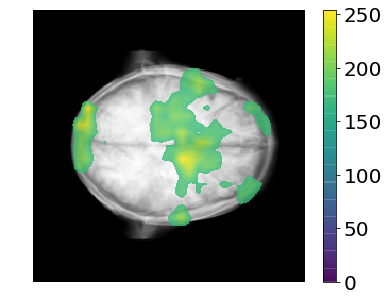

/gpfs/share/skynet/apps/anaconda3/envs/tensorflow_1_12_pytorch_1_0/lib/python3.6/site-packages/ipykernel_launcher.py:1: ResourceWarning: unclosed file <_io.TextIOWrapper name='/gpfs/data/cbi/hcp/hcp_seg/mlhc/3Dmodelbijuinoneoutputgradclipwithtorchnogradnodropoutonlypreptargetsmallnetworkwithbnormsample/results_test.txt' mode='w+' encoding='UTF-8'>
  """Entry point for launching an IPython kernel.


In [299]:
main()

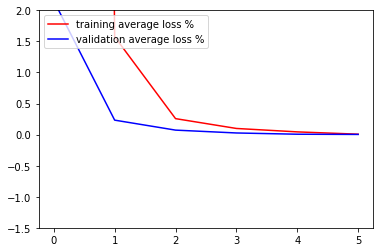

'\nTraining set size: 50000\nValidation set size: 20000\nTesting set size: 500\nMean of target: [110.9130679933665]\nStd deviation of target: [11.341138842623135]\n\nEpoch: 0, Phase: train, epoch loss: [45980.76866792481]\n----------\nEpoch: 0, Phase: validate, epoch loss: [430.8368664428711]\n----------\nEpoch: 1, Phase: train, epoch loss: [787.8369385964489]\n----------\nEpoch: 1, Phase: validate, epoch loss: [46.59435864589214]\n----------\nEpoch: 2, Phase: train, epoch loss: [128.58907673193215]\n----------\nEpoch: 2, Phase: validate, epoch loss: [14.466564593017102]\n----------\nEpoch: 3, Phase: train, epoch loss: [49.50286519578695]\n----------\nEpoch: 3, Phase: validate, epoch loss: [5.2801358789742]\n----------\nEpoch: 4, Phase: train, epoch loss: [21.96967015291512]\n----------\nEpoch: 4, Phase: validate, epoch loss: [1.2598782307744025]\n----------\nEpoch: 5, Phase: train, epoch loss: [3.416141473683715]\n----------\nEpoch: 5, Phase: validate, epoch loss: [0.5781864257365465]

In [43]:
import matplotlib.pyplot as plt
import pylab

x = [0,1, 2, 3, 4, 5]
train = [45980.76866792481/500, 787.8369385964489/500, 128.58907673193215/500, 49.50286519578695/500, 21.96967015291512/500, 3.416141473683715/500]
val = [430.8368664428711/200, 46.59435864589214/200, 14.466564593017102/200,5.2801358789742/200,1.2598782307744025/200, 0.5781864257365465/200  ]
plt.plot(x, train, 'r', label='training average loss %') # plotting t, a separately 
plt.plot(x, val, 'b', label='validation average loss %') # plotting t, b separately 
pylab.legend(loc='upper left')
pylab.ylim(-1.5, 2.0)
plt.show()

"""
Training set size: 50000
Validation set size: 20000
Testing set size: 500
Mean of target: [110.9130679933665]
Std deviation of target: [11.341138842623135]

Epoch: 0, Phase: train, epoch loss: [45980.76866792481]
----------
Epoch: 0, Phase: validate, epoch loss: [430.8368664428711]
----------
Epoch: 1, Phase: train, epoch loss: [787.8369385964489]
----------
Epoch: 1, Phase: validate, epoch loss: [46.59435864589214]
----------
Epoch: 2, Phase: train, epoch loss: [128.58907673193215]
----------
Epoch: 2, Phase: validate, epoch loss: [14.466564593017102]
----------
Epoch: 3, Phase: train, epoch loss: [49.50286519578695]
----------
Epoch: 3, Phase: validate, epoch loss: [5.2801358789742]
----------
Epoch: 4, Phase: train, epoch loss: [21.96967015291512]
----------
Epoch: 4, Phase: validate, epoch loss: [1.2598782307744025]
----------
Epoch: 5, Phase: train, epoch loss: [3.416141473683715]
----------
Epoch: 5, Phase: validate, epoch loss: [0.5781864257365465]
----------"""